In [1]:
import pickle
import os
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import FastICA
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
import nibabel as nib
import ants
from scipy.ndimage.morphology import binary_erosion
from scipy.ndimage.morphology import binary_dilation
import cv2
import bigbadbrain as bbb
import scipy
from scipy.interpolate import interp1d
from matplotlib.colors import ListedColormap
from matplotlib.pyplot import cm
import matplotlib.colors as mcolors
import matplotlib
import tqdm

/home/users/brezovec/.local/lib/python3.6/site-packages/ants/viz/render_surface_function.py:16: UserWarning: Cant import Plotly. Install it `pip install chart_studio` if you want to use ants.render_surface_function
  "Cant import Plotly. Install it `pip install chart_studio` if you want to use ants.render_surface_function"


In [2]:
cluster_dir = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20221109_cluster_pca/"

In [3]:
file = os.path.join(cluster_dir, 'superclusters_more.npy')
superclusters = np.load(file)
#with 249 there will be clusters 1-250 inclusive (len=250). cluster 140 is background
superclusters_250 = superclusters[:,:,:,249]
# right brain gets +250 to cluster ID so now 500 clusters
superclusters_250[157:,:,:] += 250

In [4]:
file = os.path.join(cluster_dir, '20221122_clusters_exploded.npy')
supercluster_visualize = np.load(file)
supercluster_visualize.shape

(501, 350, 500)

In [5]:
file = os.path.join(cluster_dir,"20221202_SC_signals.npy")
supercluster_signals = np.load(file)
supercluster_signals.shape

(501, 30456)

In [6]:
file = os.path.join(cluster_dir,"20221122_behavior_fwd.npy")
beh_fwd = np.load(file)
print(beh_fwd.shape)

file = os.path.join(cluster_dir,"20221122_behavior_turn.npy")
beh_turn = np.load(file)
print(beh_turn.shape)

behavior_super = {}
behavior_super['Y_pos_std'] = beh_fwd
behavior_super['Z_pos_std'] = np.clip(beh_turn,0,None)
behavior_super['Z_neg_std'] = np.clip(beh_turn,None,0)*-1

(30456,)
(30456,)


In [7]:
### TEMPORAL NEWEST ###
# not based on average supercluster signal, but rather averaged filters from supervoxels
temporal_filters_indiv = []
for fly in range(9):
    file = os.path.join(cluster_dir,"20221128_indiv_temporal_filters", F"fly_{fly}.npy")
    temporal_filters_indiv.append(np.load(file))
temporal_filters_indiv = np.asarray(temporal_filters_indiv)
temporal_filters_indiv = np.swapaxes(temporal_filters_indiv,0,1)
temporal_filters_indiv = np.reshape(temporal_filters_indiv,(501,9,4,500))
print(temporal_filters_indiv.shape)

(501, 9, 4, 500)


In [8]:
### average across flies
temporal_filters = np.mean(temporal_filters_indiv,axis=1)

In [9]:
#################
### GLM INDIV ###
#################

file = os.path.join(cluster_dir, "20221127_singles_glm_indiv_FDA.npy")
singles_glm_indiv = np.load(file)
print(singles_glm_indiv.shape)

file = os.path.join(cluster_dir, "20221127_unique_glm_indiv_FDA.npy")
unique_glm_indiv = np.load(file)
print(unique_glm_indiv.shape)

glm = np.concatenate((singles_glm_indiv, unique_glm_indiv),axis=-1)

supercluster_glm_indiv = []
for cluster in tqdm.tqdm(range(501)):
    ind = np.where(superclusters_250==cluster)
    supercluster_glm_indiv.append(np.mean(glm[:,ind[0],ind[1],ind[2],:],axis=1))
supercluster_glm_indiv = np.asarray(supercluster_glm_indiv)
print(supercluster_glm_indiv.shape)
supercluster_glm_indiv = np.reshape(supercluster_glm_indiv,(501, 9, 6))
supercluster_glm_indiv = np.reshape(supercluster_glm_indiv,(501,9,2,3))

(9, 314, 146, 91, 3)
(9, 314, 146, 91, 3)


100%|██████████| 501/501 [00:14<00:00, 35.38it/s]

(501, 9, 6)


In [10]:
file = os.path.join(cluster_dir,"20221122_full_supercluster_2d_beh_hists.npy")
beh_hist_2d = np.load(file)
beh_hist_2d.shape

(501, 25, 25)

In [11]:
start_c = 265 ###
end_c = 200 ######## most used
middle_c = 250 ###

# sample the colormaps that you want to use. Use 128 from each so we get 256
# colors in total
colors1 = plt.cm.Blues_r(np.linspace(0., 1, middle_c-end_c))
colors2 = plt.cm.Reds(np.linspace(0, 1, start_c-middle_c))

# combine them and build a new colormap
colors = np.vstack((colors1, colors2))
mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)
temporal_norm = mcolors.Normalize(vmin=end_c,vmax=start_c)

In [12]:
##########################
### PLOTTING FUNCTIONS ###
##########################

def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def plot_corrs(ypos):
    ax = fig.add_axes([0.32, ypos, 0.08, 0.1])
    glm_mean = np.mean(supercluster_glm_indiv[cluster,...],axis=0) #shape (2, 3)
    glm_sem = np.mean(supercluster_glm_indiv[cluster,...],axis=0)/3 #/3 is sqrt of 9 indiv
    
    ### single variables
    plt.bar([1,2,3],
        [glm_mean[0,2],
         glm_mean[0,1],
         glm_mean[0,0]],
        color=['grey','grey','grey'],
        zorder=0)
    
    ### unique variables
    plt.bar([1,2,3],
            [glm_mean[1,2],
             glm_mean[1,1],
             glm_mean[1,0]],
            color=[(0,0,1),(0,1,0),(1,0,0)],zorder=1,
            yerr=[glm_sem[1,2], #/3 is sqrt of 9 indiv
                  glm_sem[1,1],
                  glm_sem[1,0]],
            error_kw=dict(lw=3, capsize=3, capthick=2))
    
    # is blue green red
    # unique order is 
    plt.scatter([1]*9,supercluster_glm_indiv[cluster,:,1,2],zorder=2,color='k',s=2)
    plt.scatter([2]*9,supercluster_glm_indiv[cluster,:,1,1],zorder=2,color='k',s=2)
    plt.scatter([3]*9,supercluster_glm_indiv[cluster,:,1,0],zorder=2,color='k',s=2)
    #plt.scatter([2]*9,supercluster_unique_indiv[cluster,:,1],zorder=2,color='k',s=2)
    #plt.scatter([3]*9,supercluster_unique_indiv[cluster,:,0],zorder=2,color='k',s=2)

    plt.ylim(0,.2) # CAN ADJUST THIS
    #ax.set_yticklabels([0,.1,.2,.3,.4,.5,.6])
    #ax.set_yticks([0,.1,.2,.3,.4,.5,.6])
    #plt.scatter([1]*9,supercluster_corr_indiv[cluster,0,:],zorder=2,color='k',s=2)
    #plt.scatter([2]*9,supercluster_corr_indiv[cluster,1,:],zorder=2,color='k',s=2)
    #plt.scatter([3]*9,supercluster_corr_indiv[cluster,2,:],zorder=2,color='k',s=2)
    
def plot_cluster_visualization(ypos,hemi):
    ax = fig.add_axes([0, ypos, 0.1, 0.1])
    if hemi == 'L':
        plt.imshow(supercluster_visualize[cluster,:,:250],cmap='cool')
    elif hemi == 'R':
        plt.imshow(supercluster_visualize[cluster,:,250:],cmap='cool')
    plt.text(0,70,cluster,fontsize=30)
    plt.axis('off')
    
def plot_2D_beh(ypos):
    ax = fig.add_axes([0.1, ypos, 0.1, 0.1])
    vmax = np.percentile(np.abs(beh_hist_2d[cluster,...]),98)
    plt.imshow(beh_hist_2d[cluster,...],cmap='PuOr',vmin=-vmax,vmax=vmax)
    plt.axis('off')
    
def plot_temporal_filters(ypos):
    ax = fig.add_axes([0.4, ypos, 0.1, 0.05])
    xs = np.arange(-4000,4000,20)
    plt.plot(xs,NormalizeData(temporal_filters[cluster,0,50:450][::-1]),color=(0,0,1))
    plt.plot(xs,NormalizeData(temporal_filters[cluster,1,50:450][::-1]),color=(0,1,0)) #zpos,ie left turn, ie green
    plt.plot(xs,NormalizeData(temporal_filters[cluster,2,50:450][::-1]),color=(1,0,0))
    plt.axvline(0,color='k',linestyle='--')
    ax.set_yticklabels([0,1])
    ax.set_yticks([0,1])
    
def plot_peak_time(ypos):
    ax = fig.add_axes([0.4, ypos+0.05, 0.1, 0.05])
    xpos = [.2,.5,.8]
    names = ['VF', 'VL', 'VR']
    xs = np.arange(-5000,5000,20)
    colors=[(0,0,1),(0,1,0),(1,0,0)]
    for beh in [0,1,2]:
        peak = np.argmax(temporal_filters[cluster,beh,:])
        circle = plt.Circle((xpos[beh], .5), .1, color=mymap(temporal_norm(peak)))
        ax.add_patch(circle)
        plt.text(xpos[beh],.5,xs[peak],ha='center',va='center')
        plt.text(xpos[beh],.7,names[beh],ha='center',va='center',color=colors[beh])
        plt.axis('off')
        
def plot_peak_time_bars(ypos):
    peaks = np.argmax(temporal_filters[cluster,:,:],axis=-1)
    indiv_peaks = np.argmax(temporal_filters_indiv[cluster,:,:,:],axis=-1)
    #peaks = np.mean(indiv_peaks,axis=0).astype('int')
    colors = mymap(temporal_norm(peaks))
    xs = np.arange(-5000,5000,20)
    
    ax = fig.add_axes([0.4, ypos+.05, 0.1, 0.05])
    plt.bar([1,2,3],peaks[:3],color=colors[:3])
    plt.ylim(end_c,start_c)
    plt.axhline(250,color='grey',linestyle='--')
    ax.set_xticks([1,2,3])
    ax.set_xticklabels([xs[peaks[0]],xs[peaks[1]],xs[peaks[2]]])
    ax.tick_params(axis="x",direction="in", pad=-15)
    for beh in [0,1,2]:
        #indiv_peaks = np.argmax(temporal_filters_indiv[cluster,:,beh,:],axis=-1)
        plt.scatter([beh+1]*9,indiv_peaks[:,beh],zorder=2,color='k',s=2)
        
def plot_supercluster_vs_beh(supercluster,ypos):
    ax = fig.add_axes([0.2, ypos, 0.1, 0.1])
    neu = supercluster #shortcut
    for beh,color in zip(['Y_pos_std', 'Z_pos_std', 'Z_neg_std'],[(0,0,1),(0,1,0),(1,0,0)]):
        #cmap = matplotlib.cm.get_cmap(color)
        
        # make x bins, get mean y in each bin
        num_bins = 10
        xbins = np.linspace(0,5,num_bins+1)
        step = xbins[1] - xbins[0]
        mids = [i+step/2 for i in xbins]
        avgs = []
        stds = []
        cnts = []
        for i in range(num_bins):
            start = xbins[i]
            end = xbins[i+1]
            a = np.where(np.logical_and(behavior_super[beh]>start, behavior_super[beh]<=end))
            avgs.append(np.mean(supercluster_signals[neu][a]))
            stds.append(np.std(supercluster_signals[neu][a]))
            cnts.append(len(a[0]))

        #plt.scatter(behavior_super[beh],supercluster_signals[neu],marker='.',color='grey',s=1)

        ### Plot line along bins, with error bar ###
        sem = [stds[i]/np.sqrt(cnts[i]) for i in range(len(mids)-1)]
        plt.errorbar(mids[:-1], avgs, yerr=sem, label='both limits (default)',color=color,lw=3)

        plt.axhline(avgs[1],color='k',linestyle='--')
        plt.axvline(mids[1],color='k',linestyle='--')
        plt.xlim(0,5)
        plt.ylim(-.2,.2)
        plt.xticks([])
        plt.yticks([0,.1])
        ax.set_yticklabels([0,.1])
        ax.set_yticks([0,.1])

100%|██████████| 251/251 [17:45<00:00,  4.25s/it]


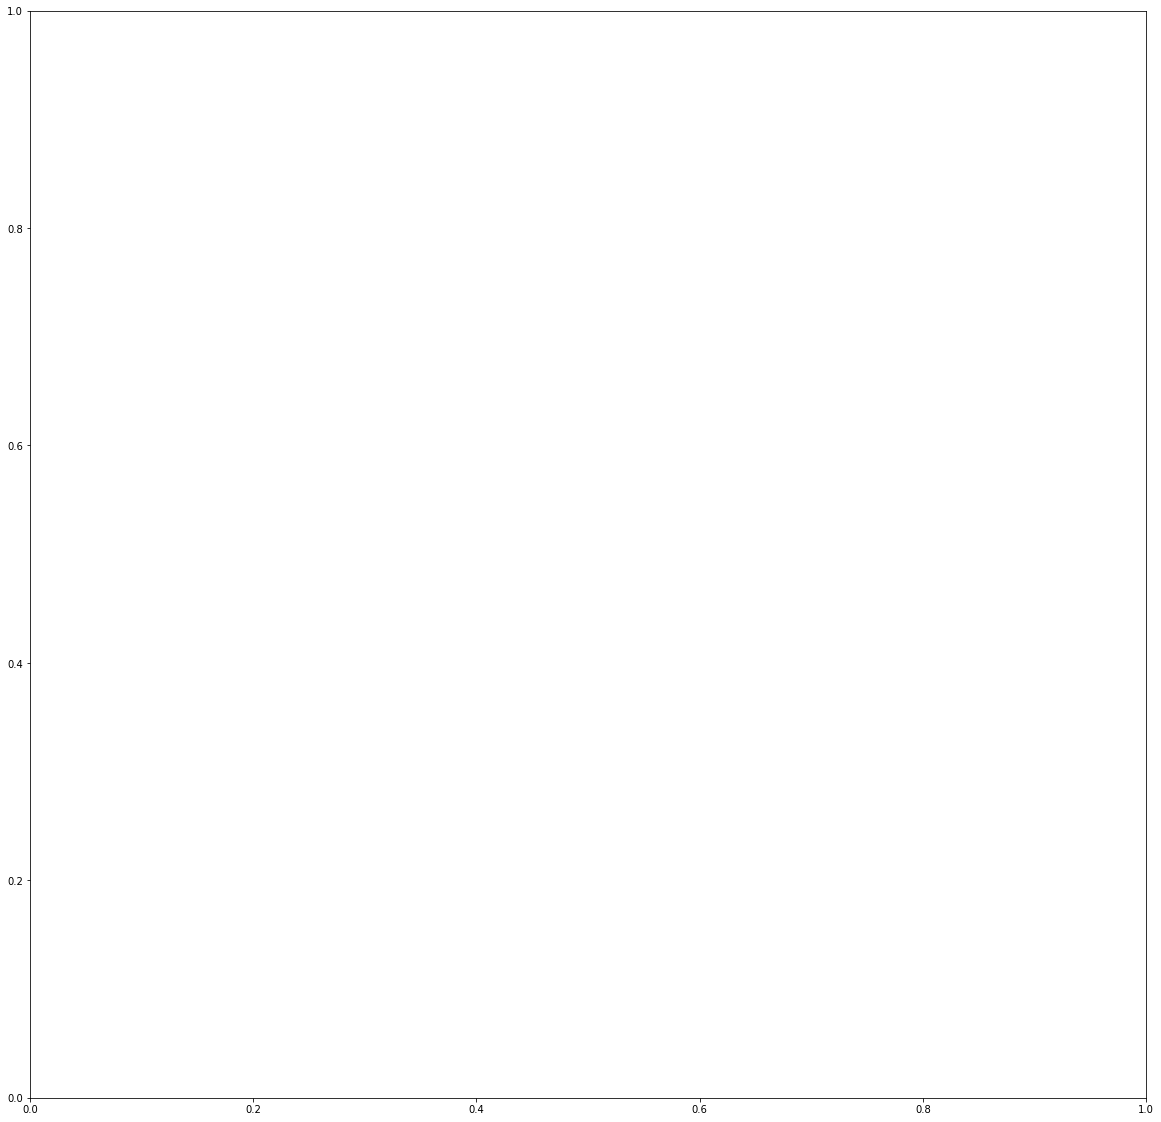

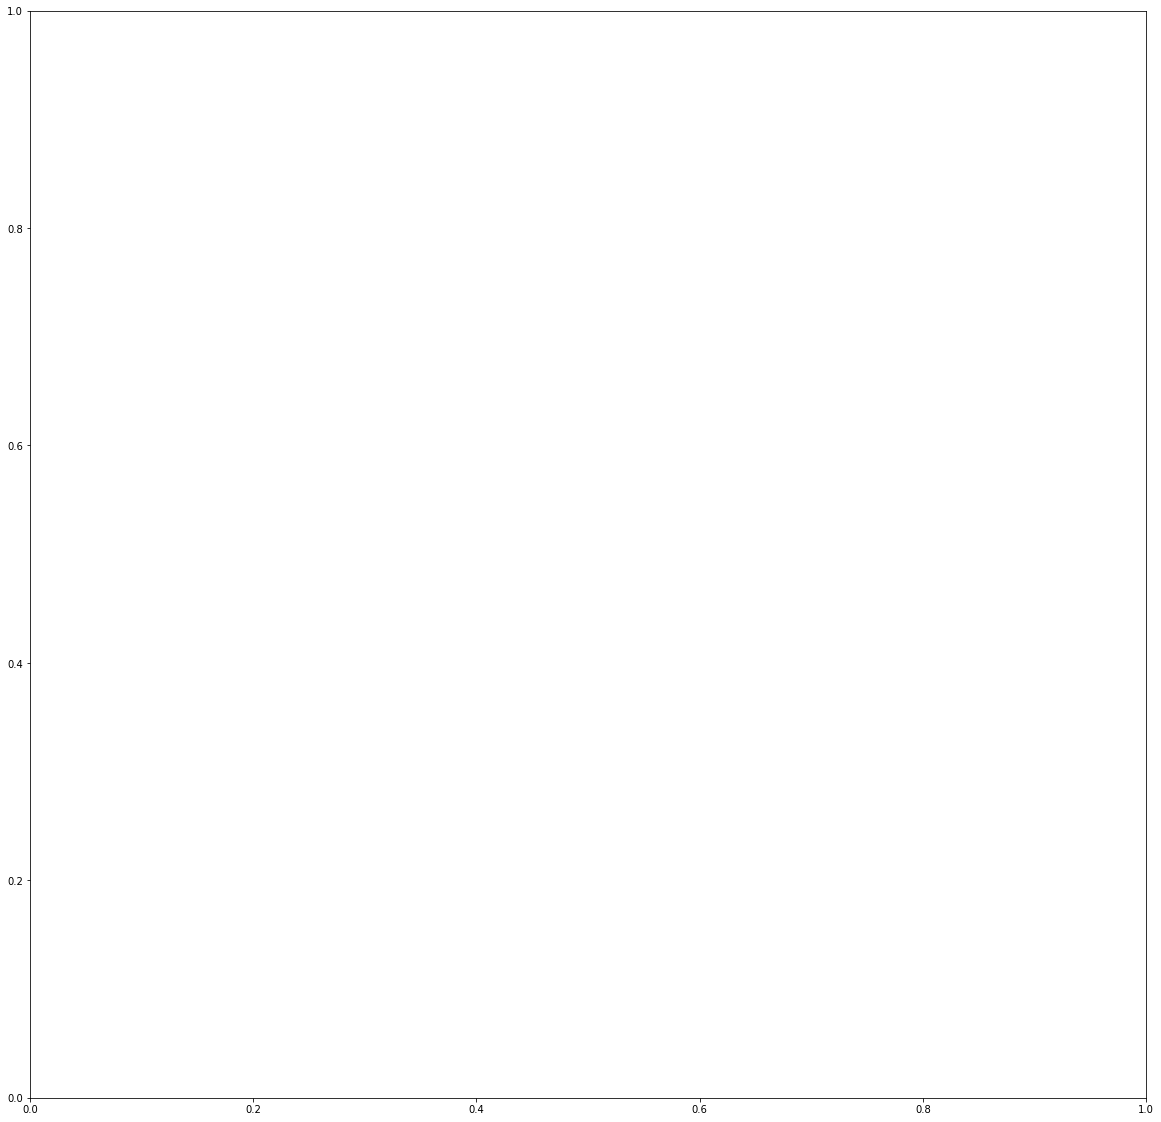

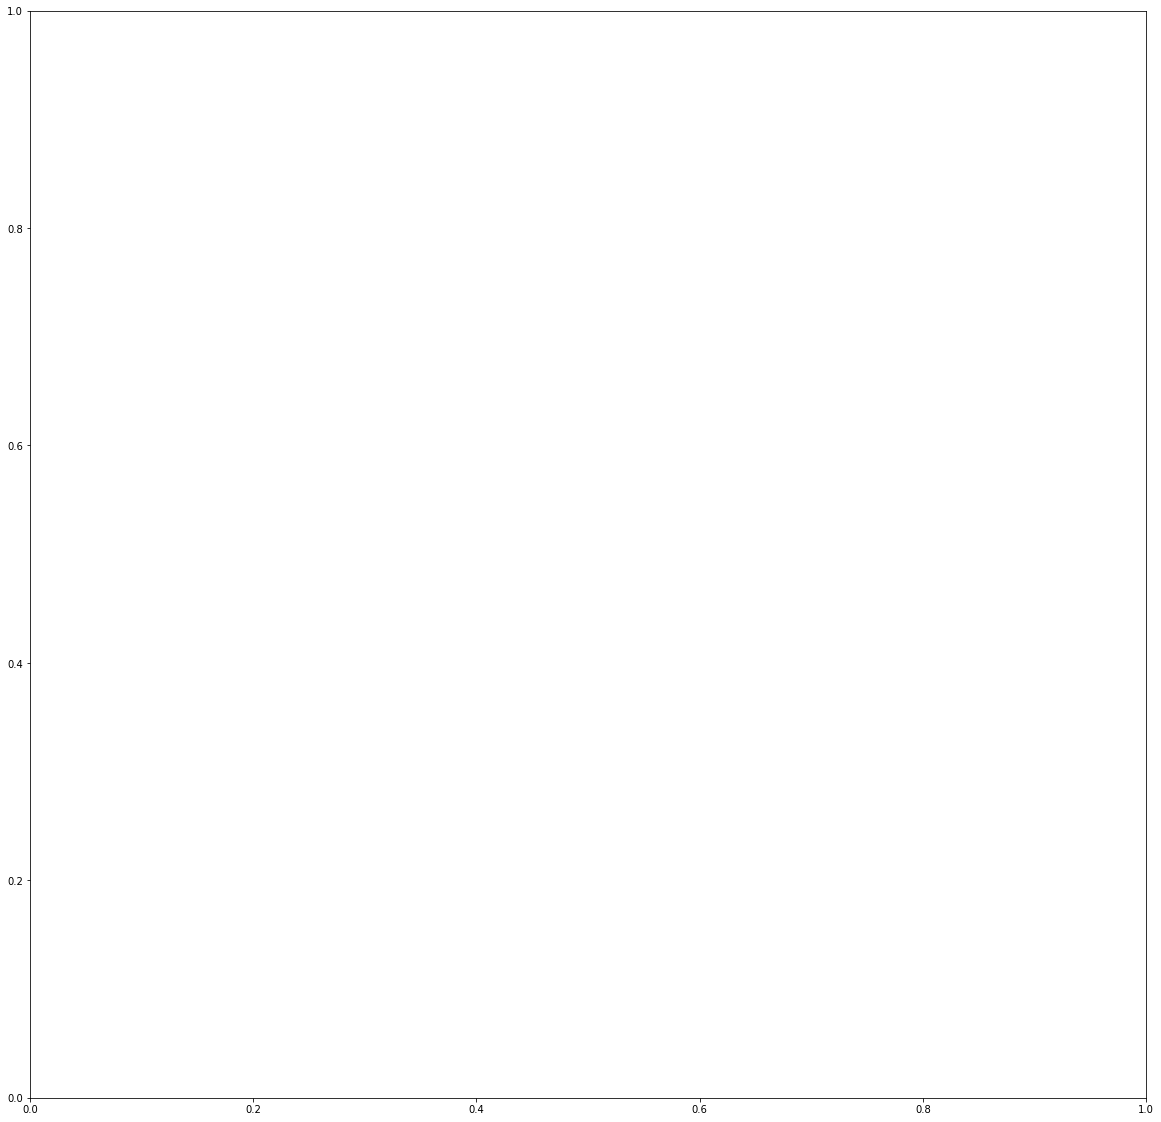

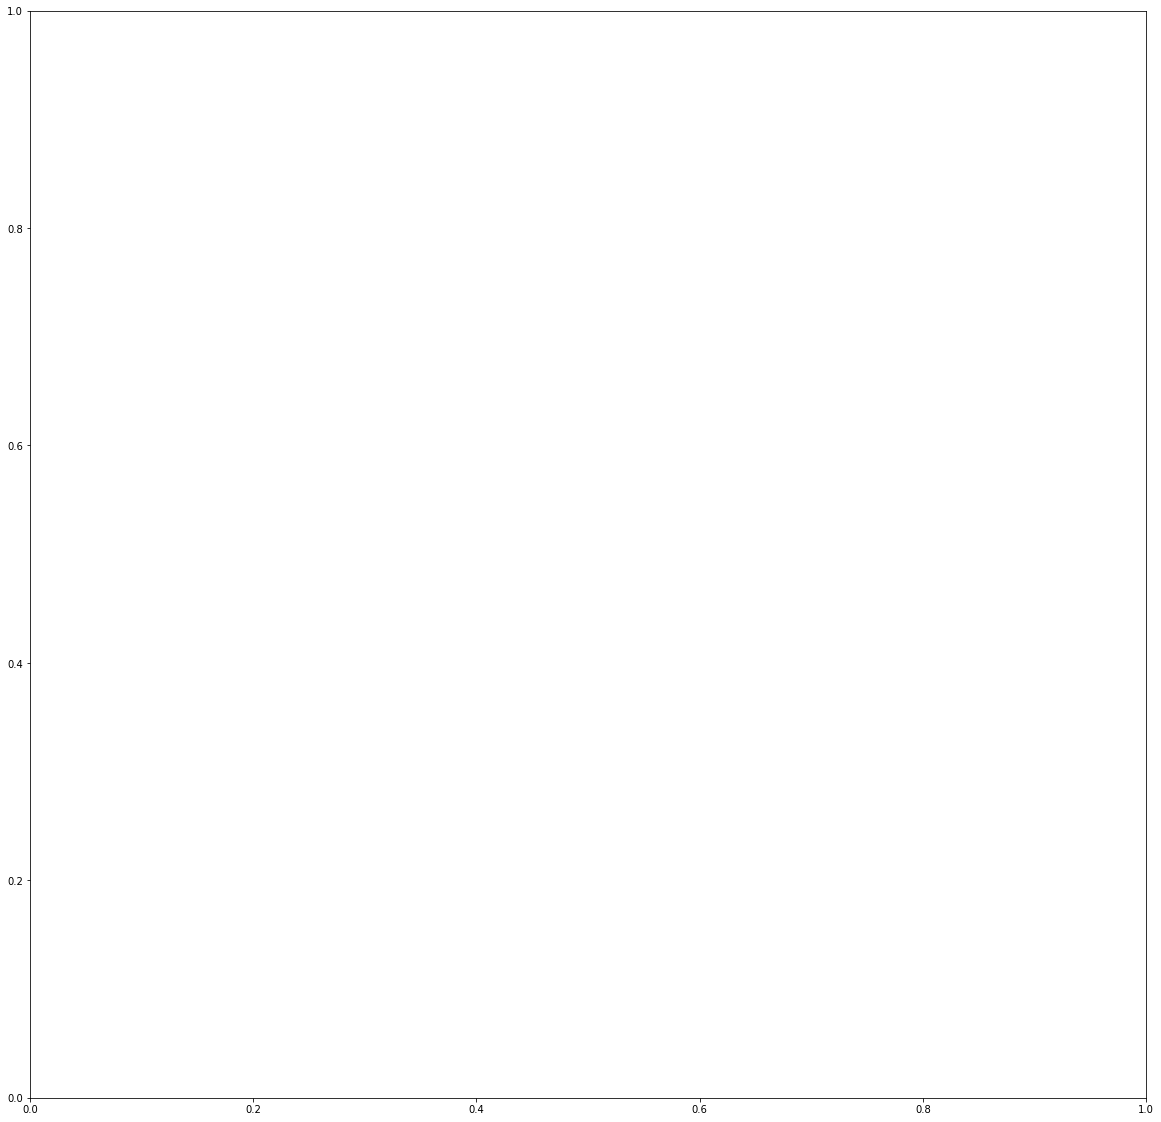

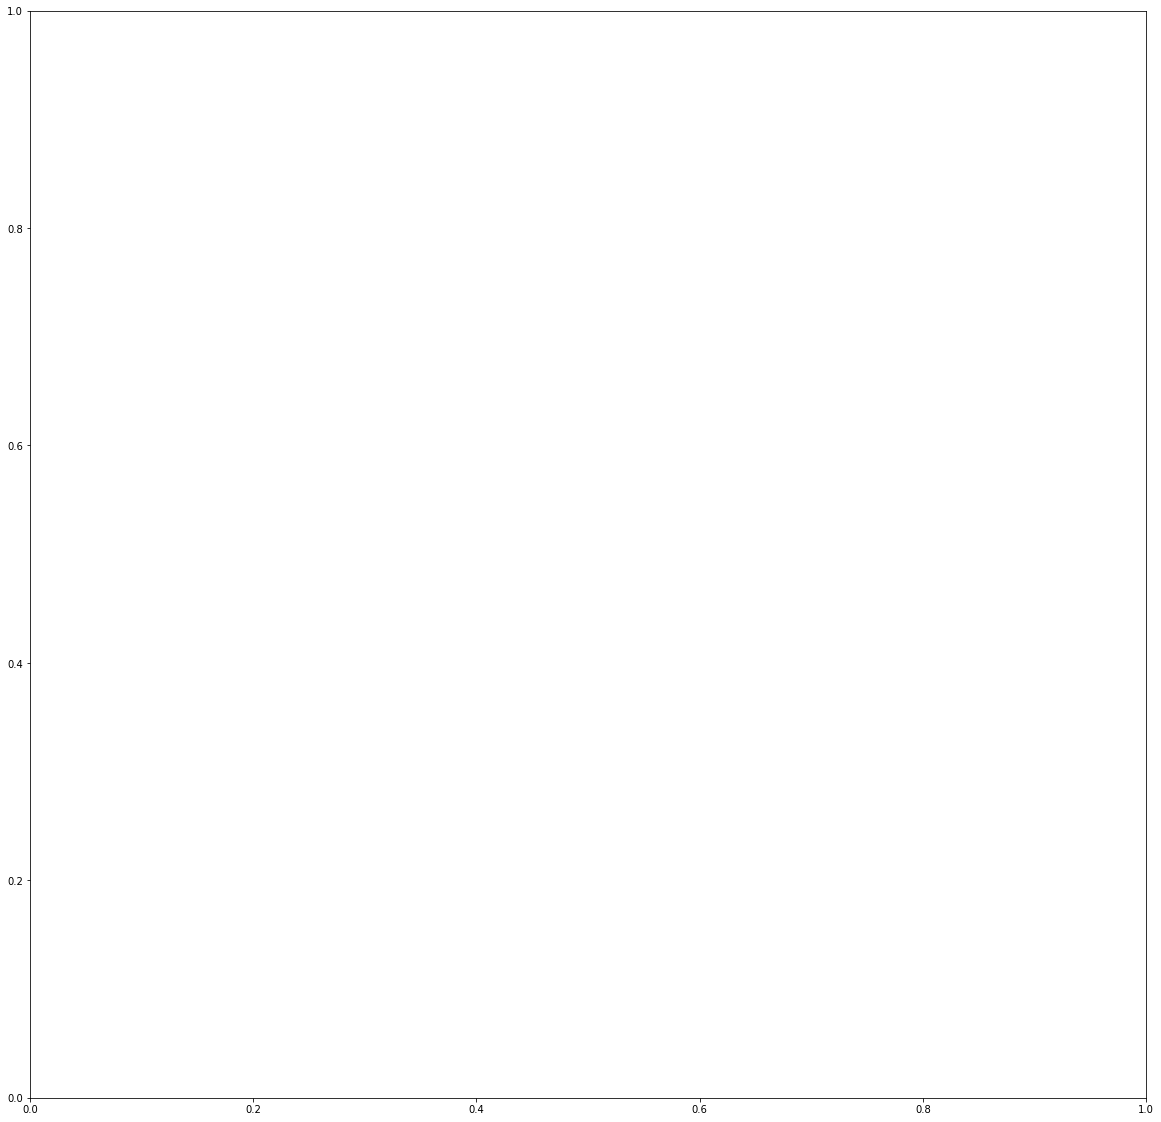

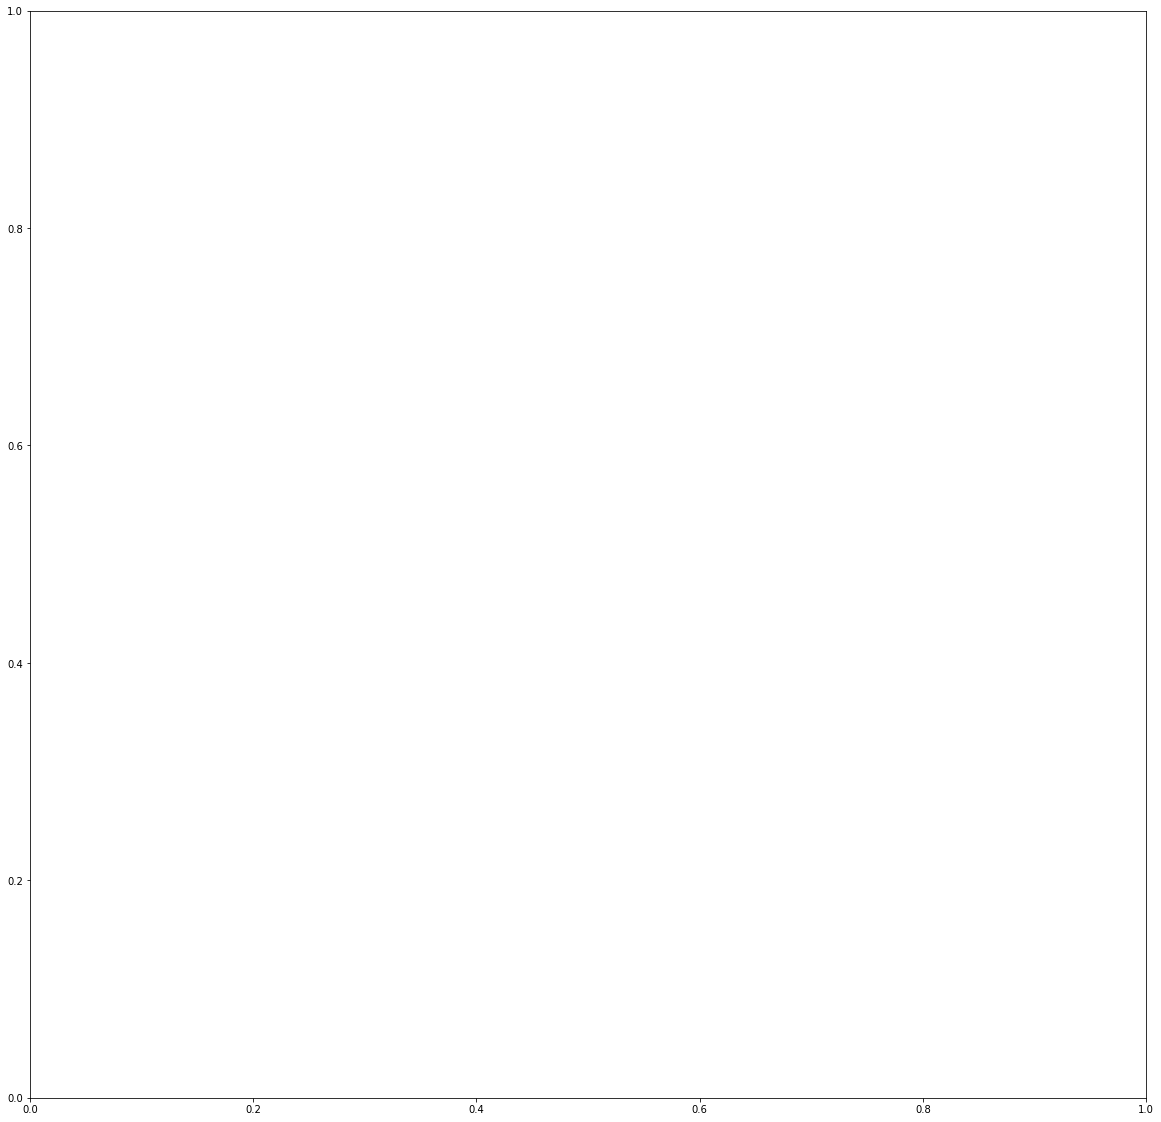

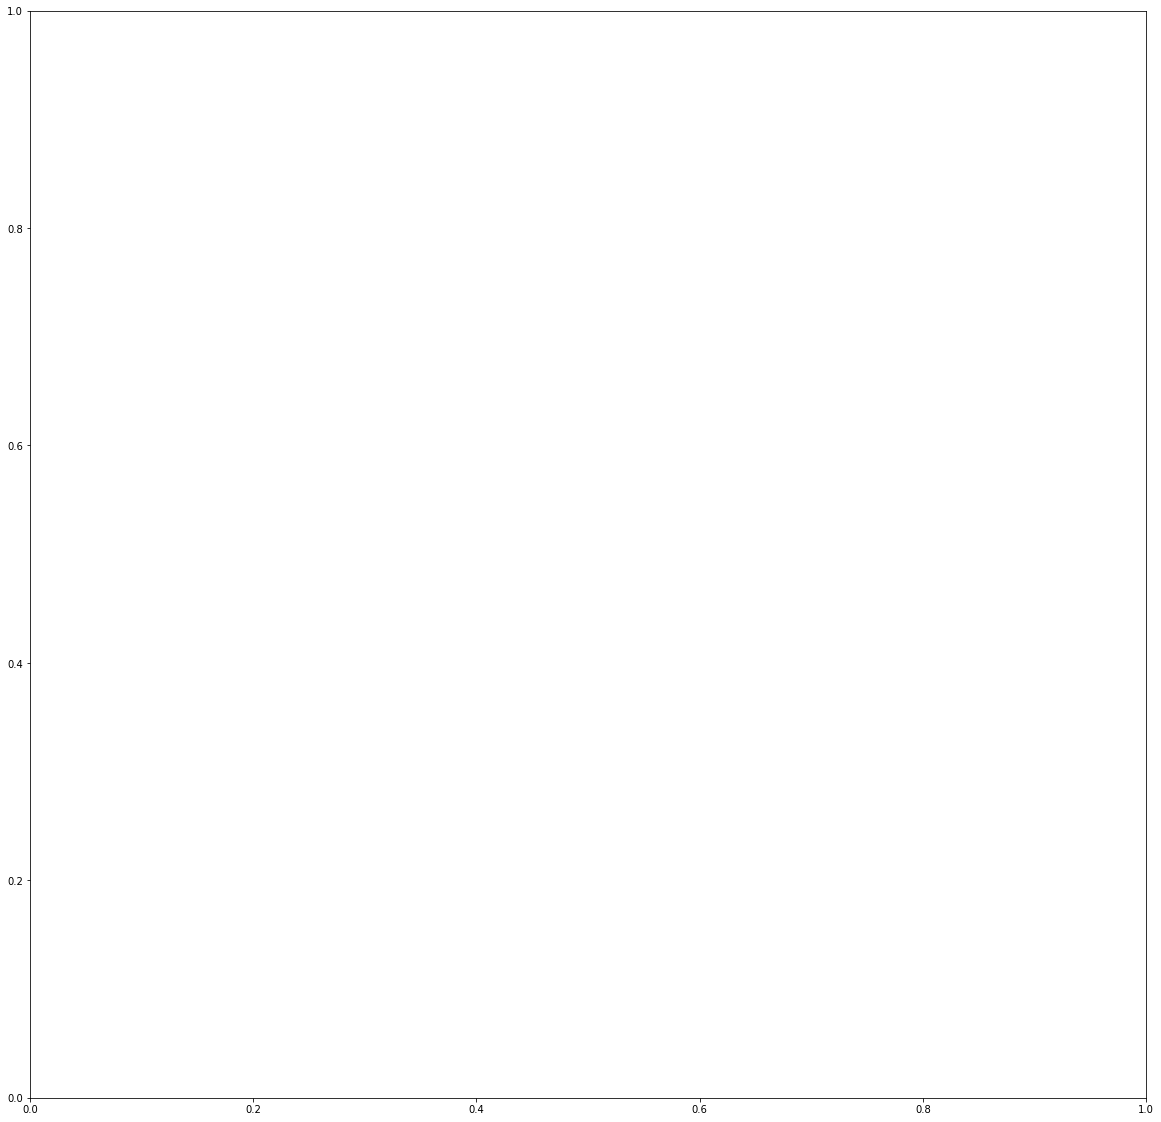

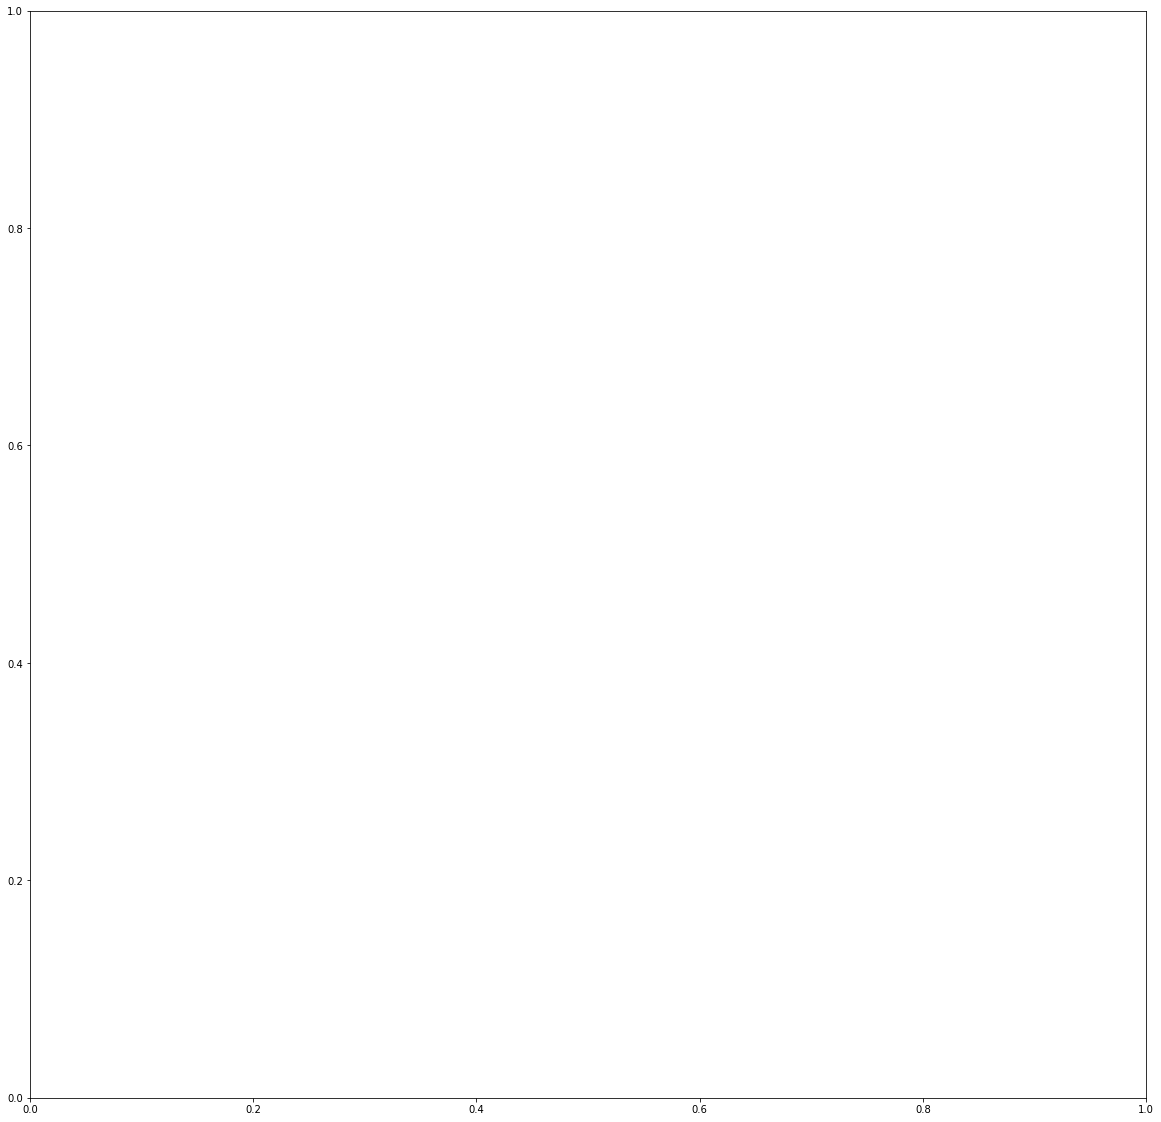

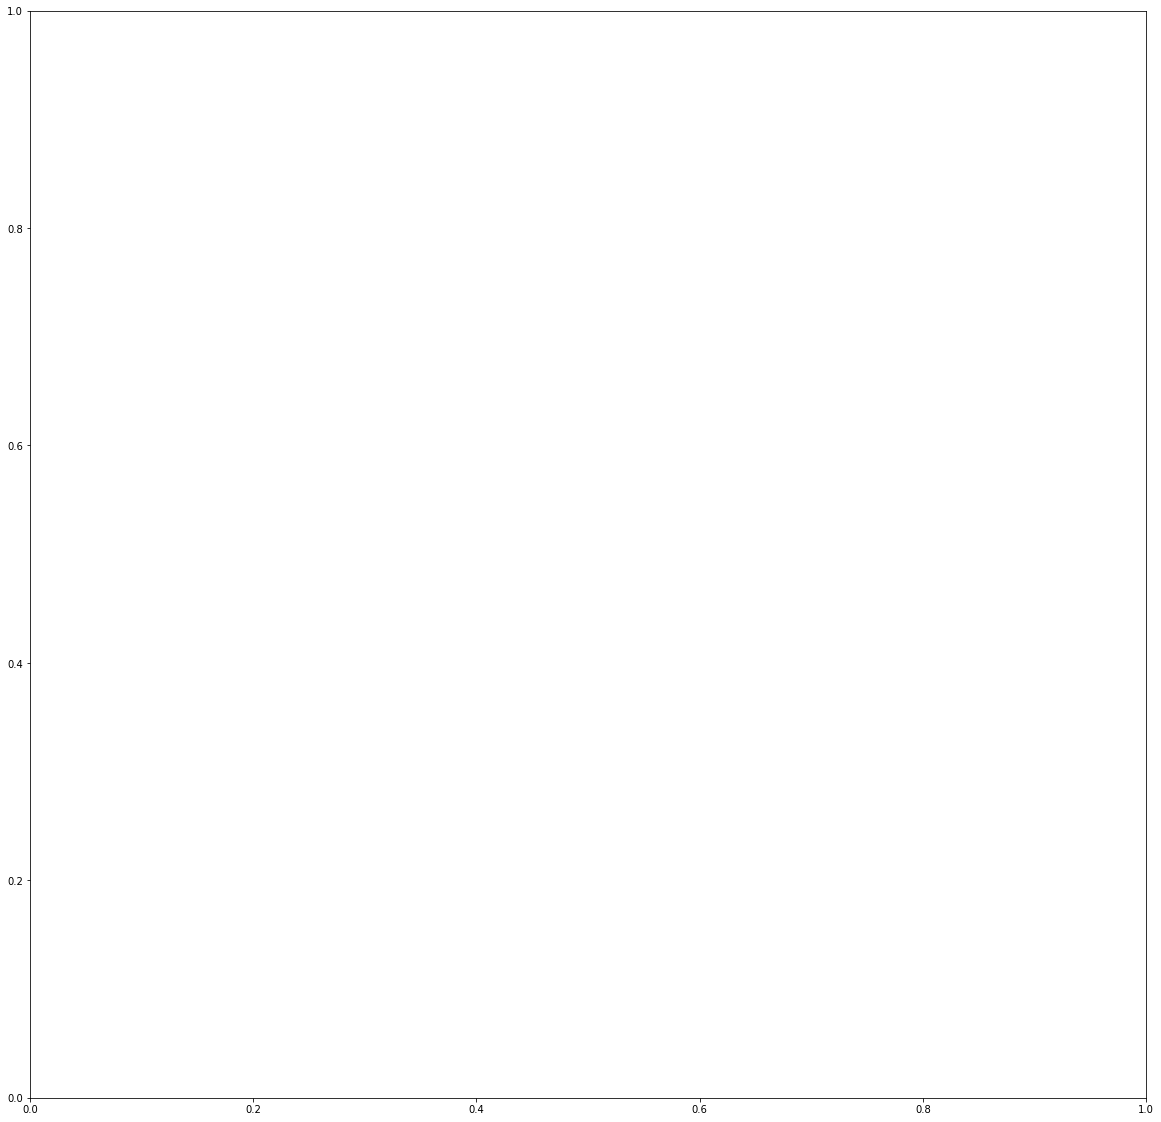

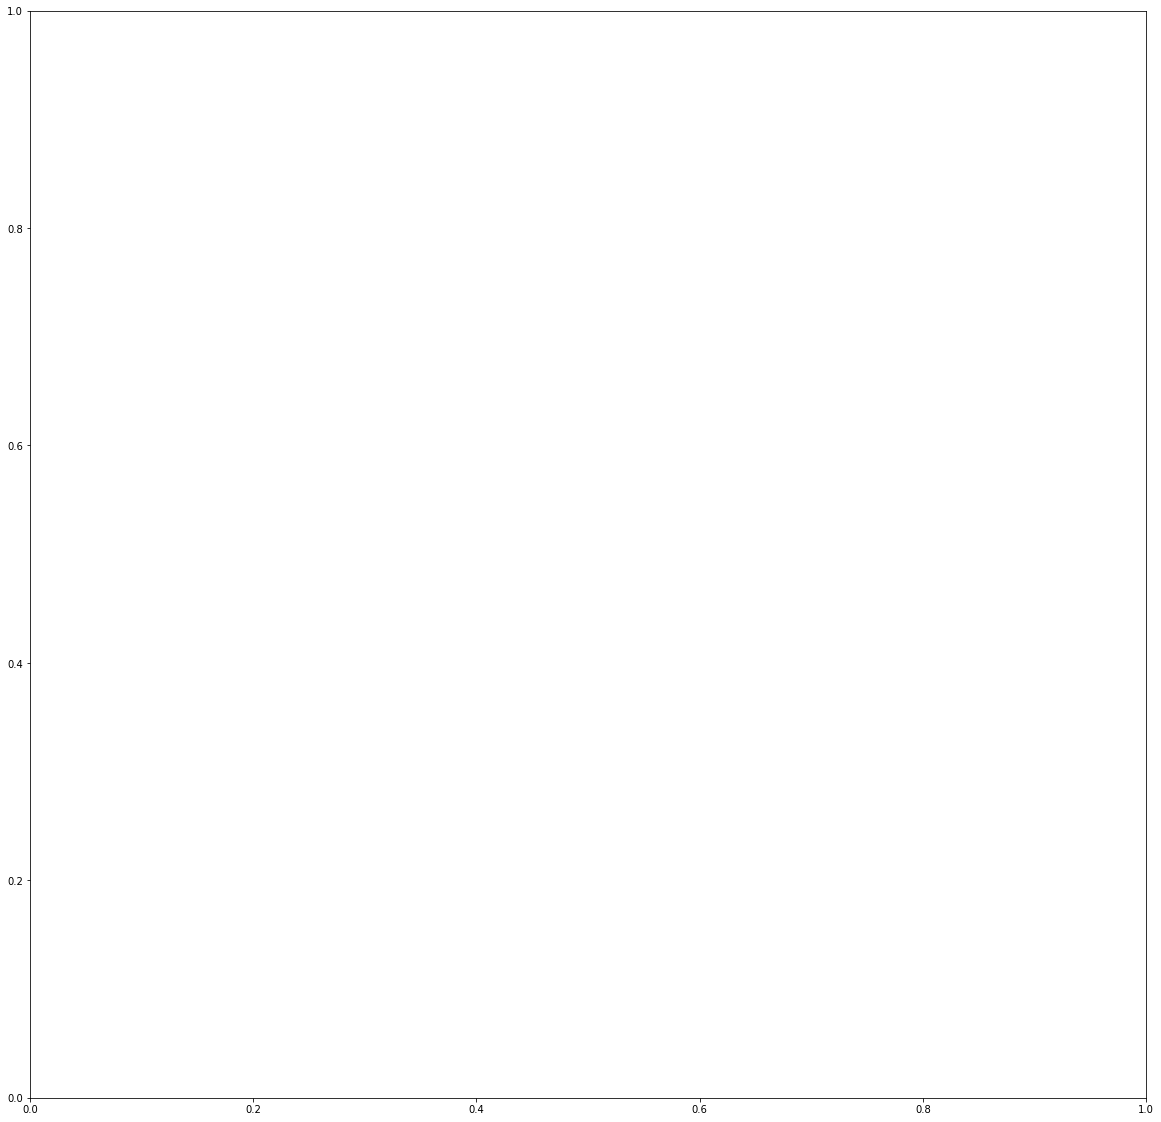

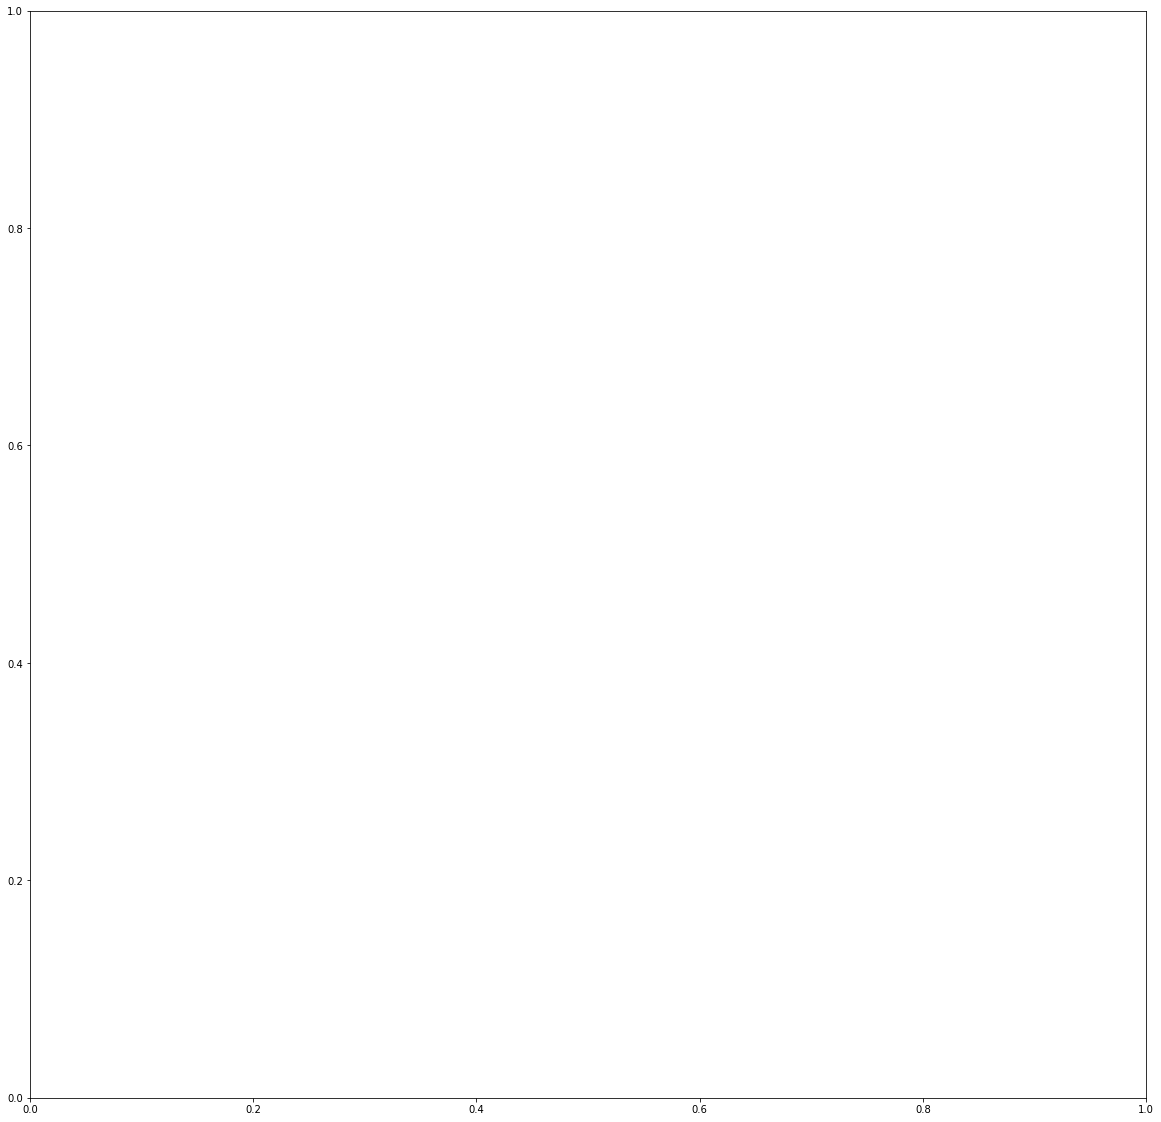

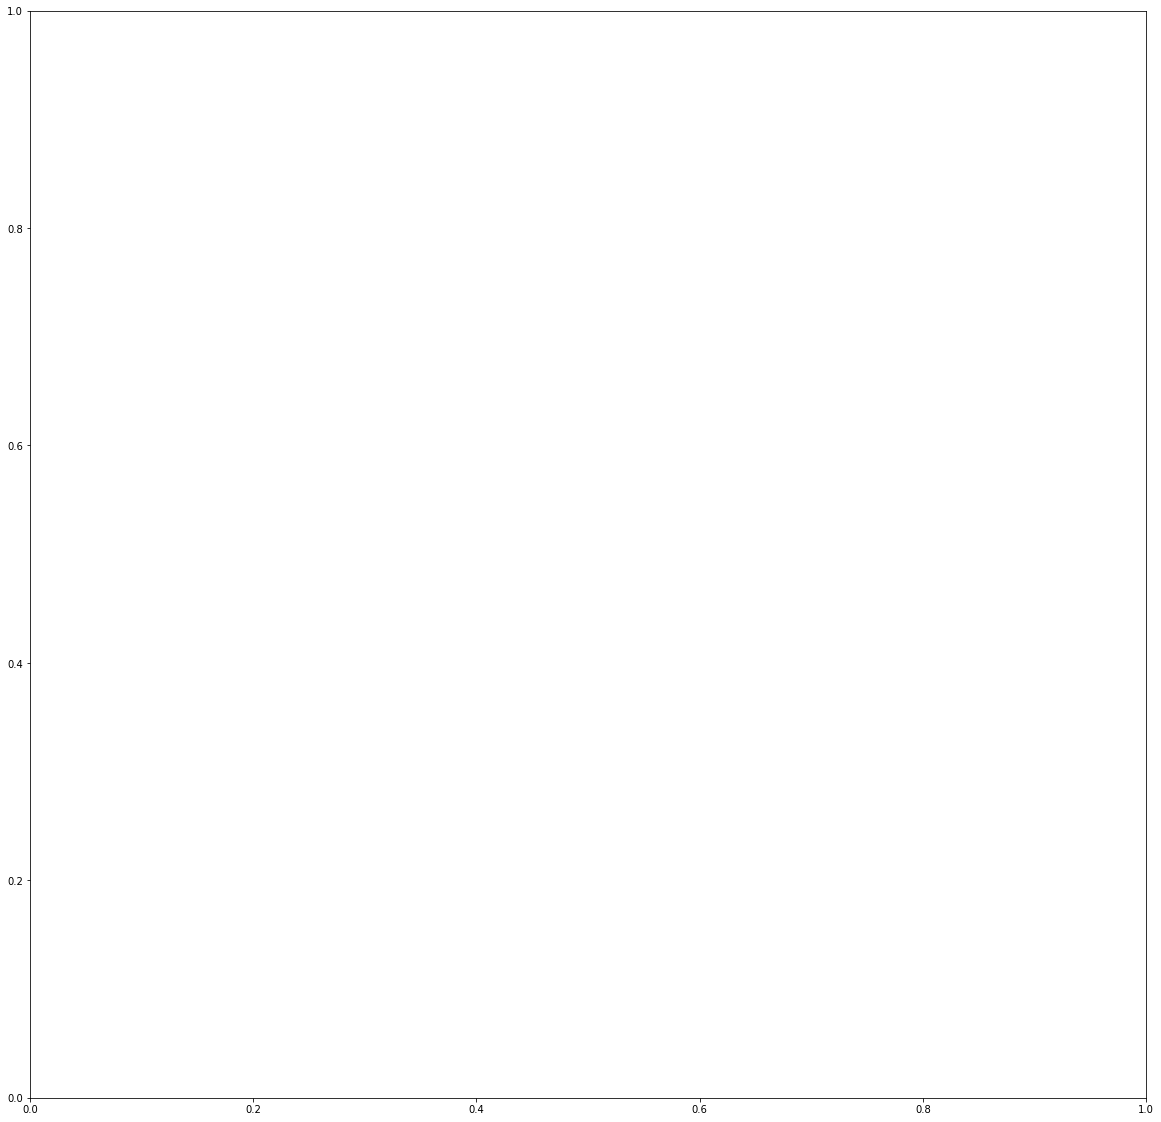

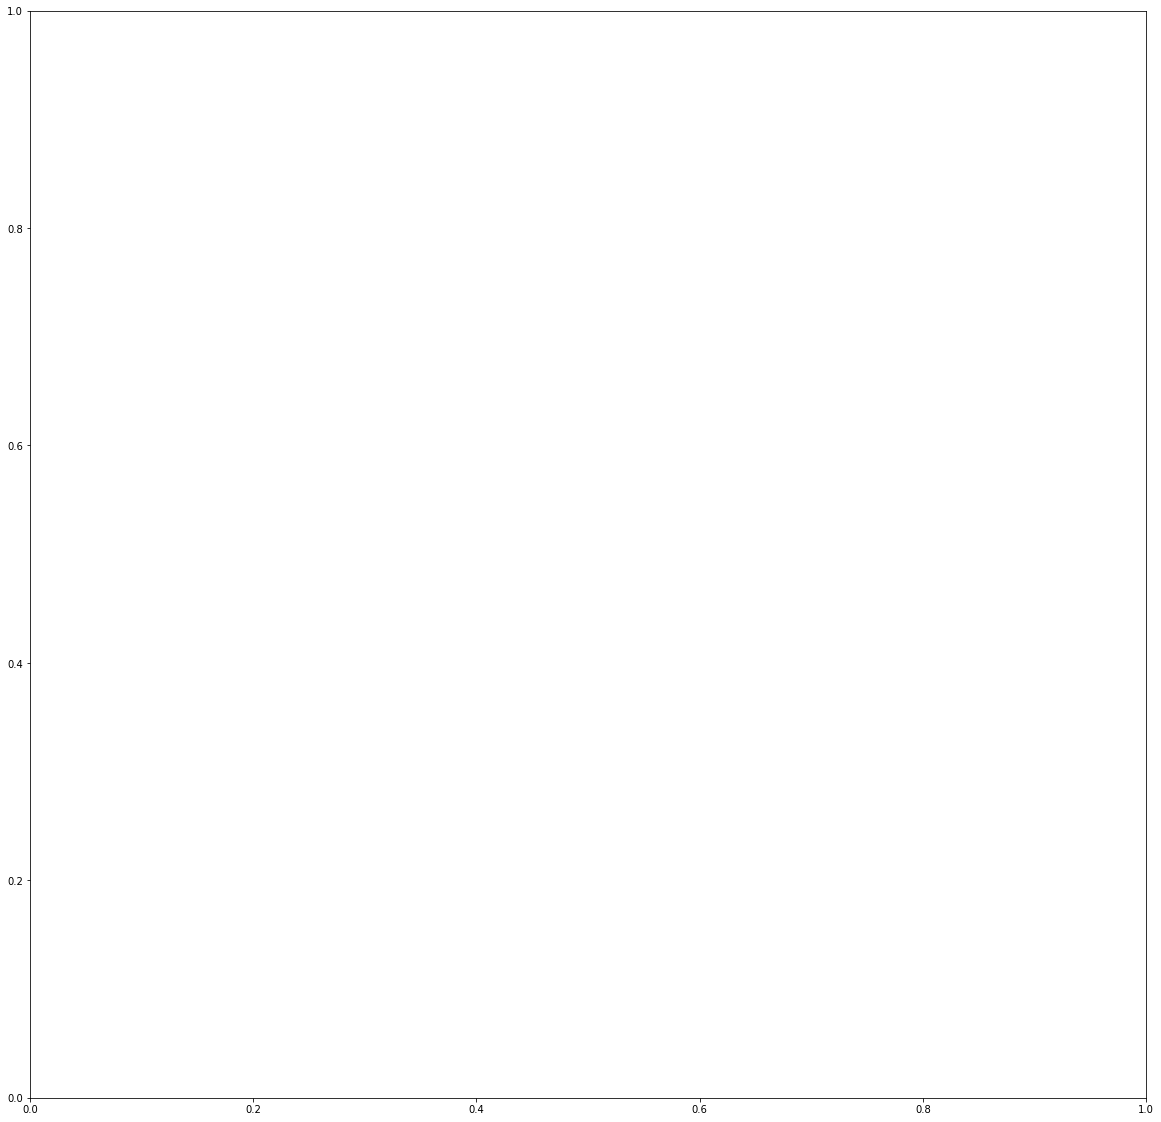

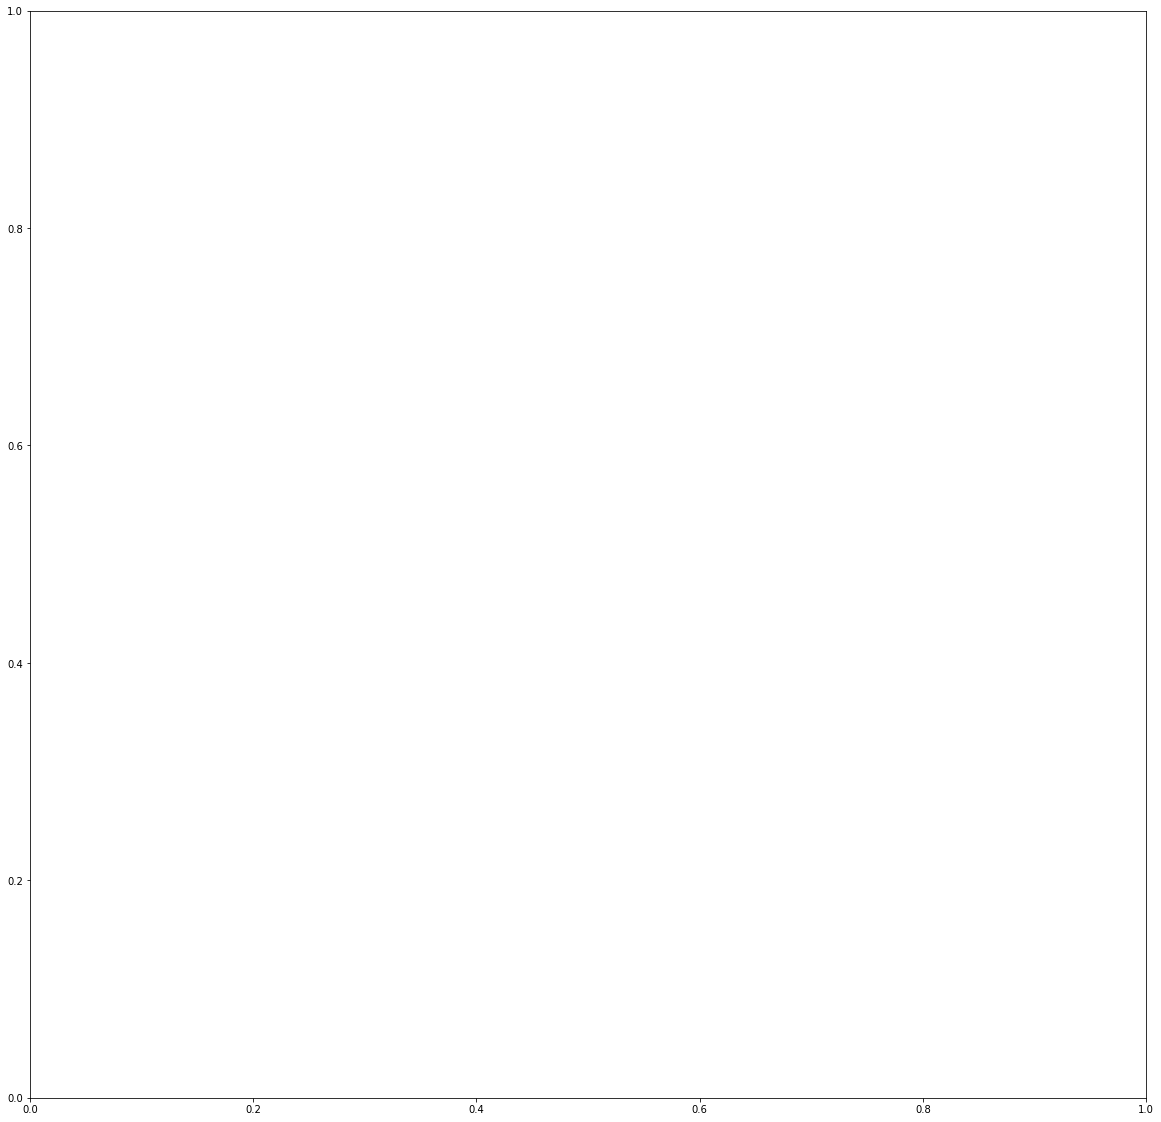

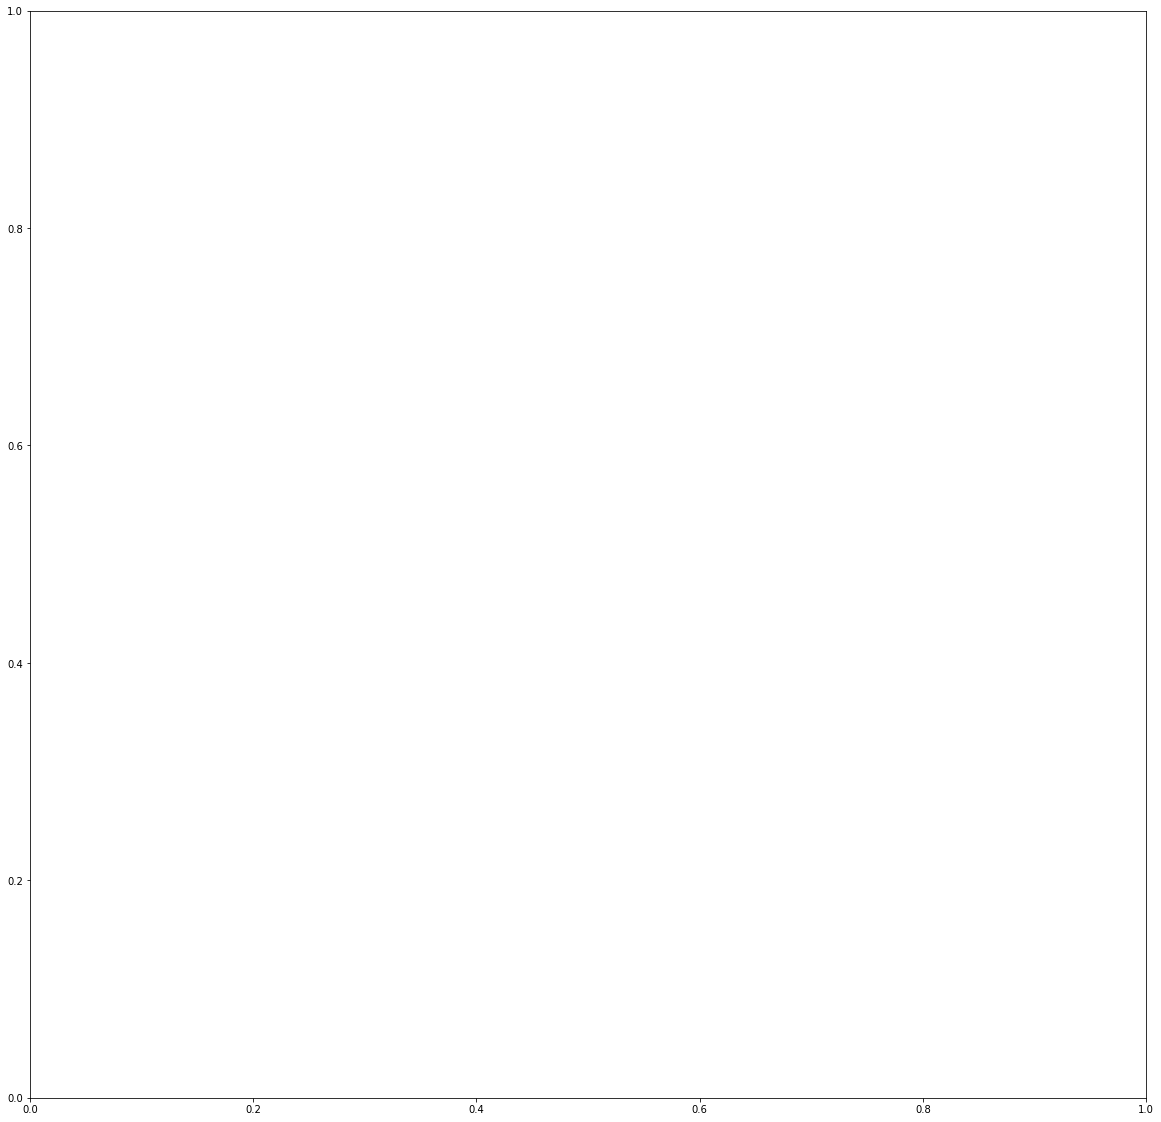

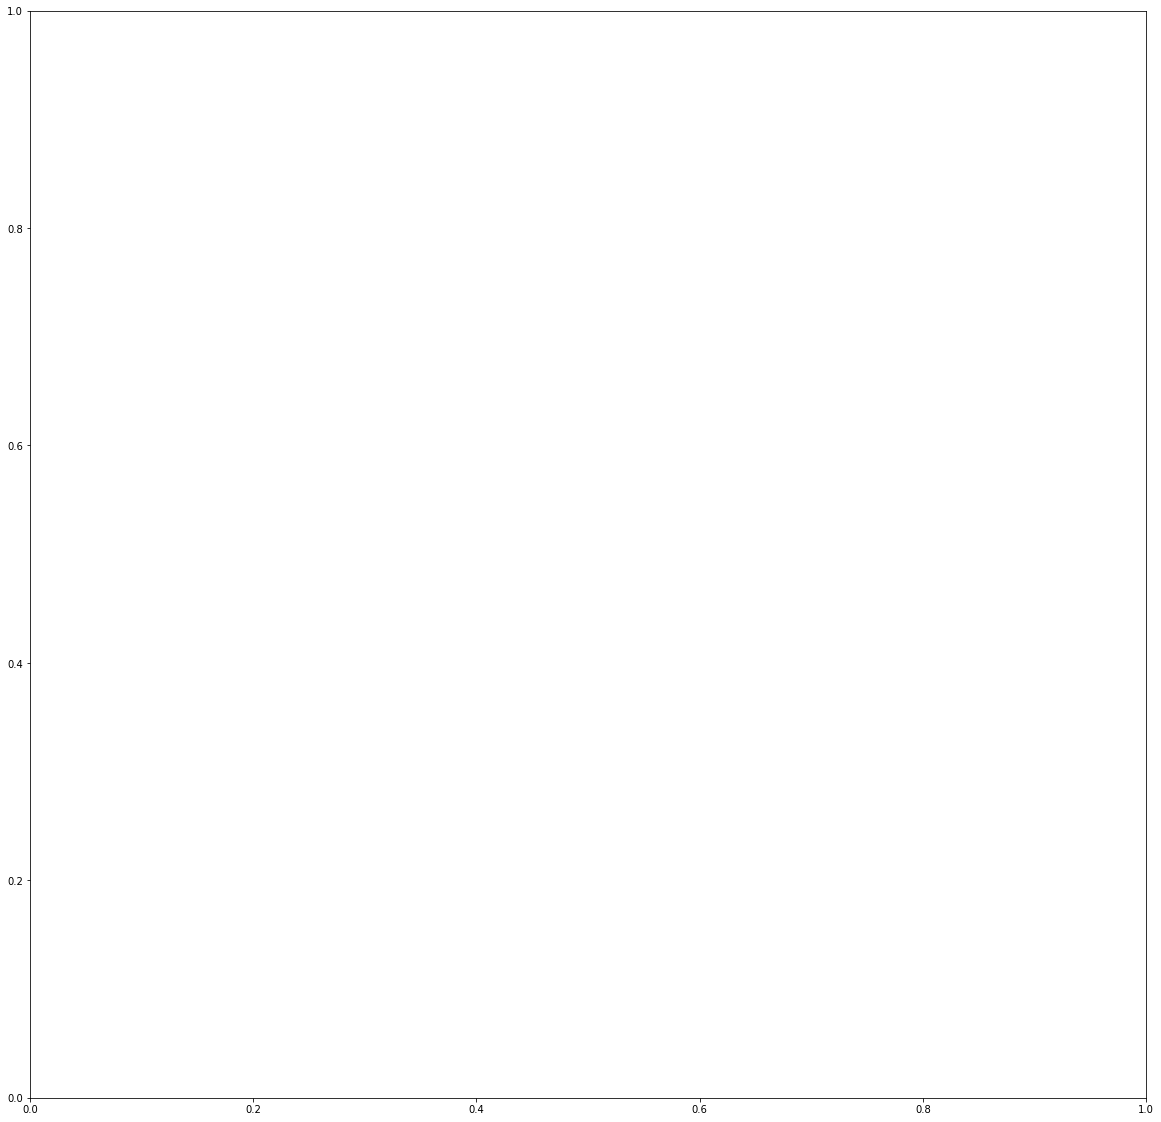

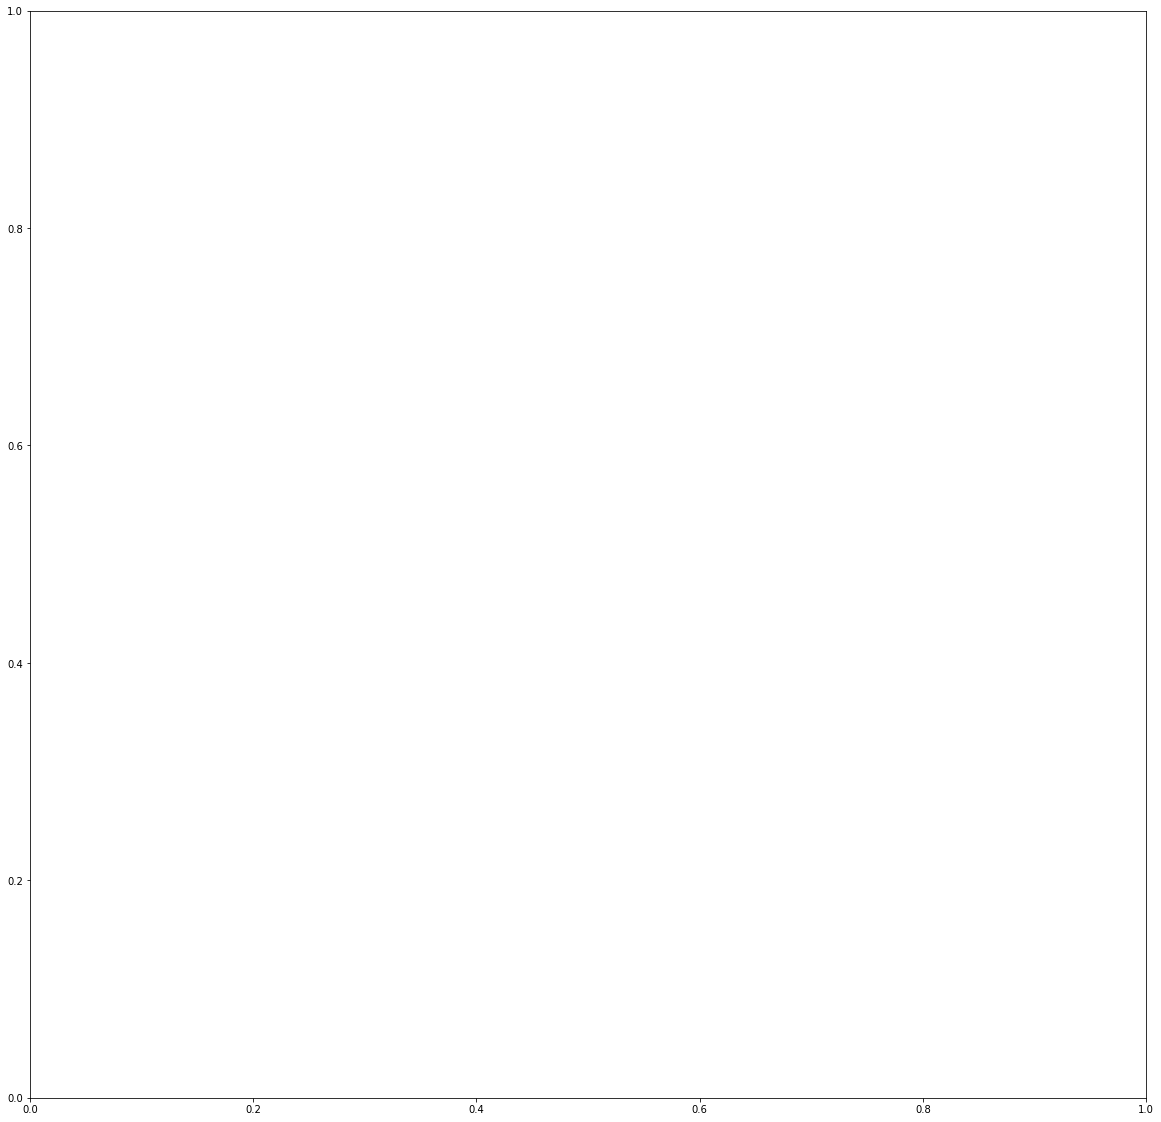

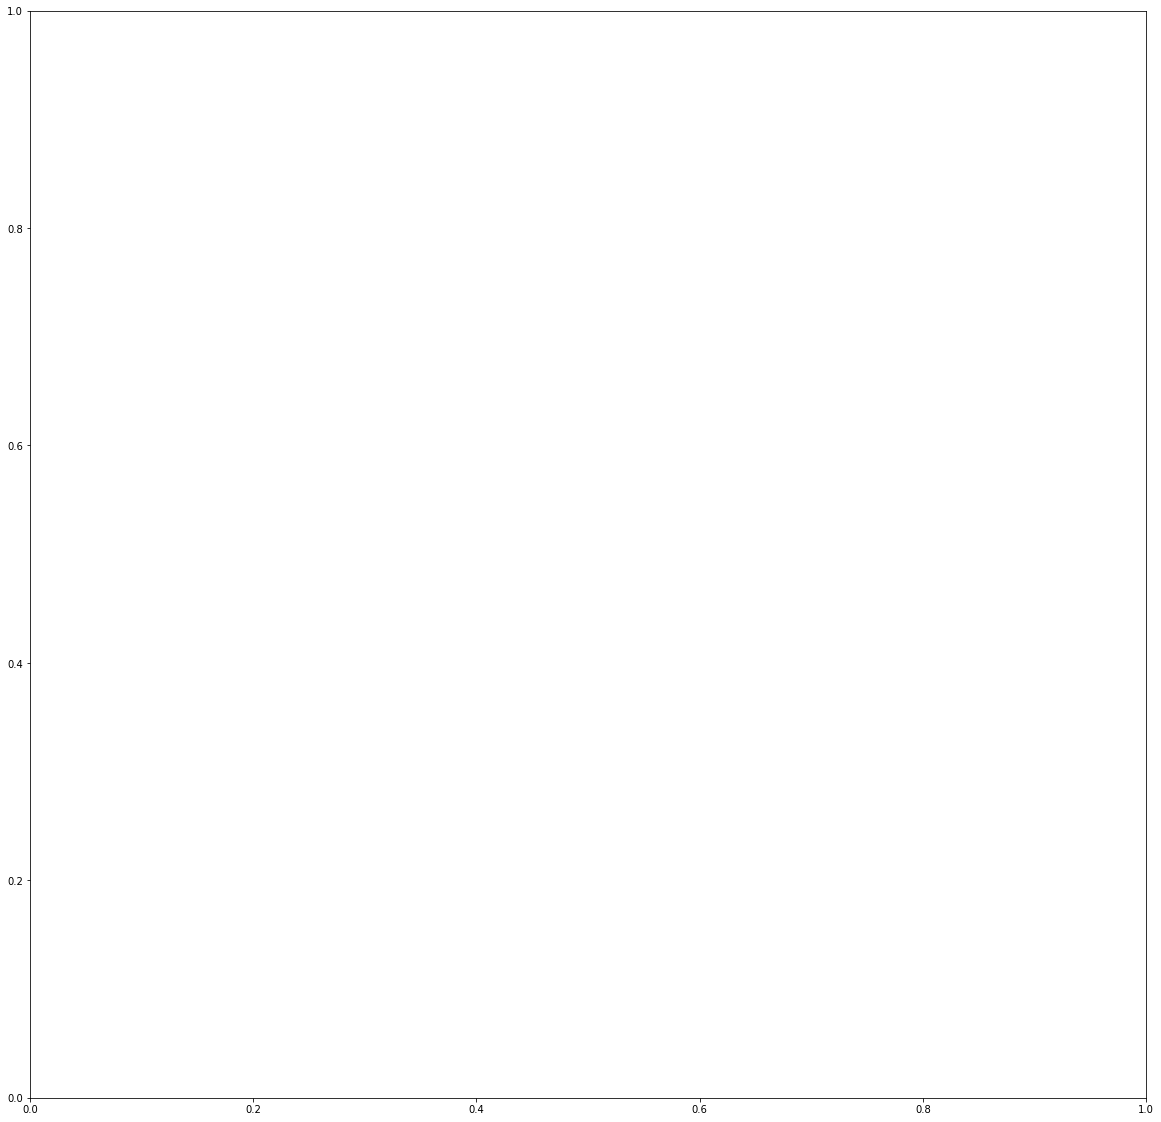

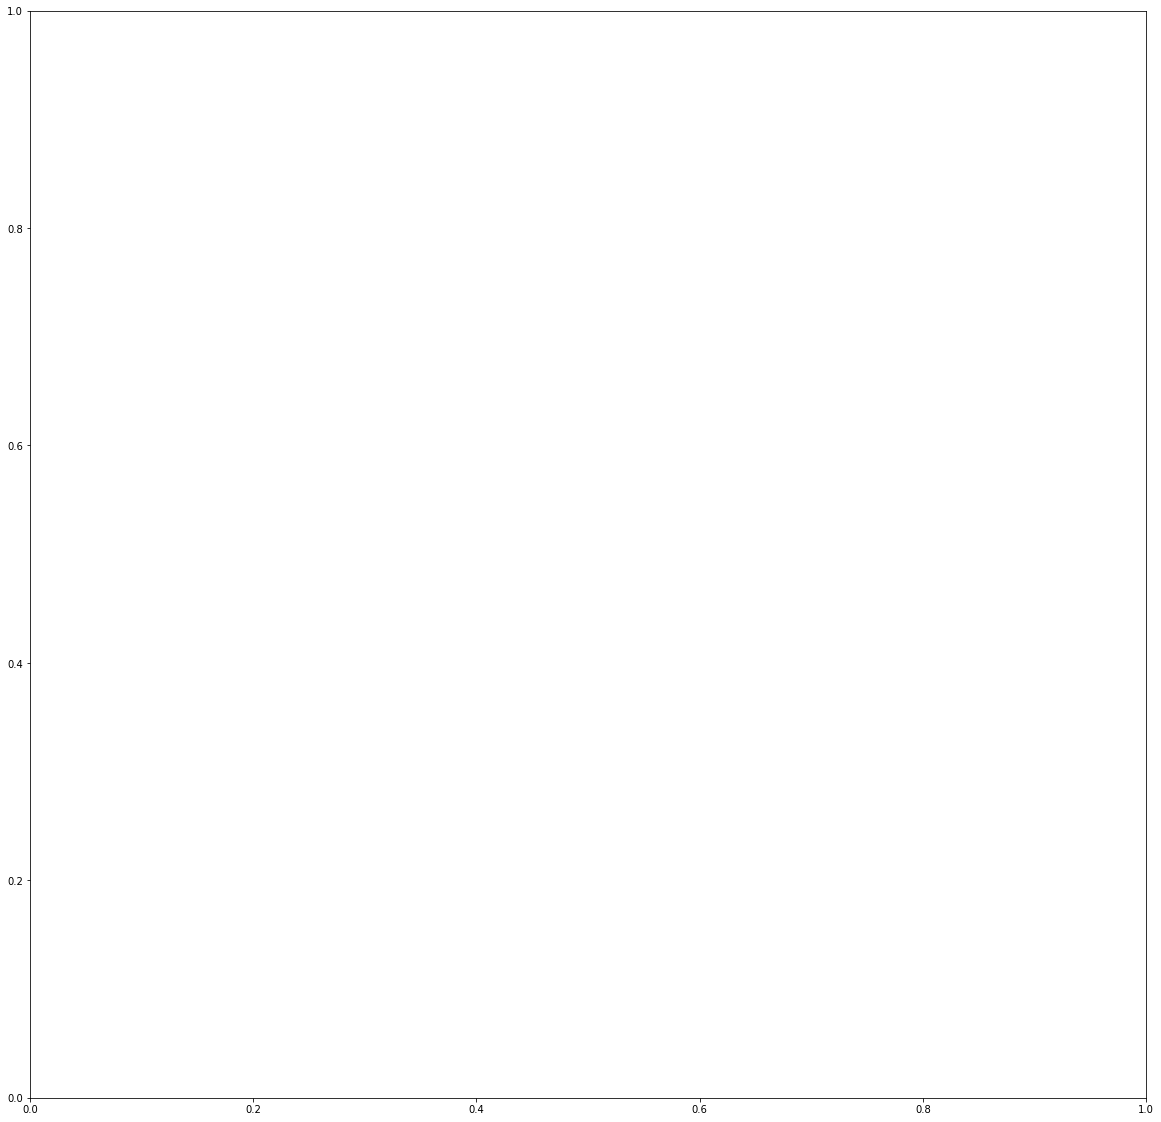

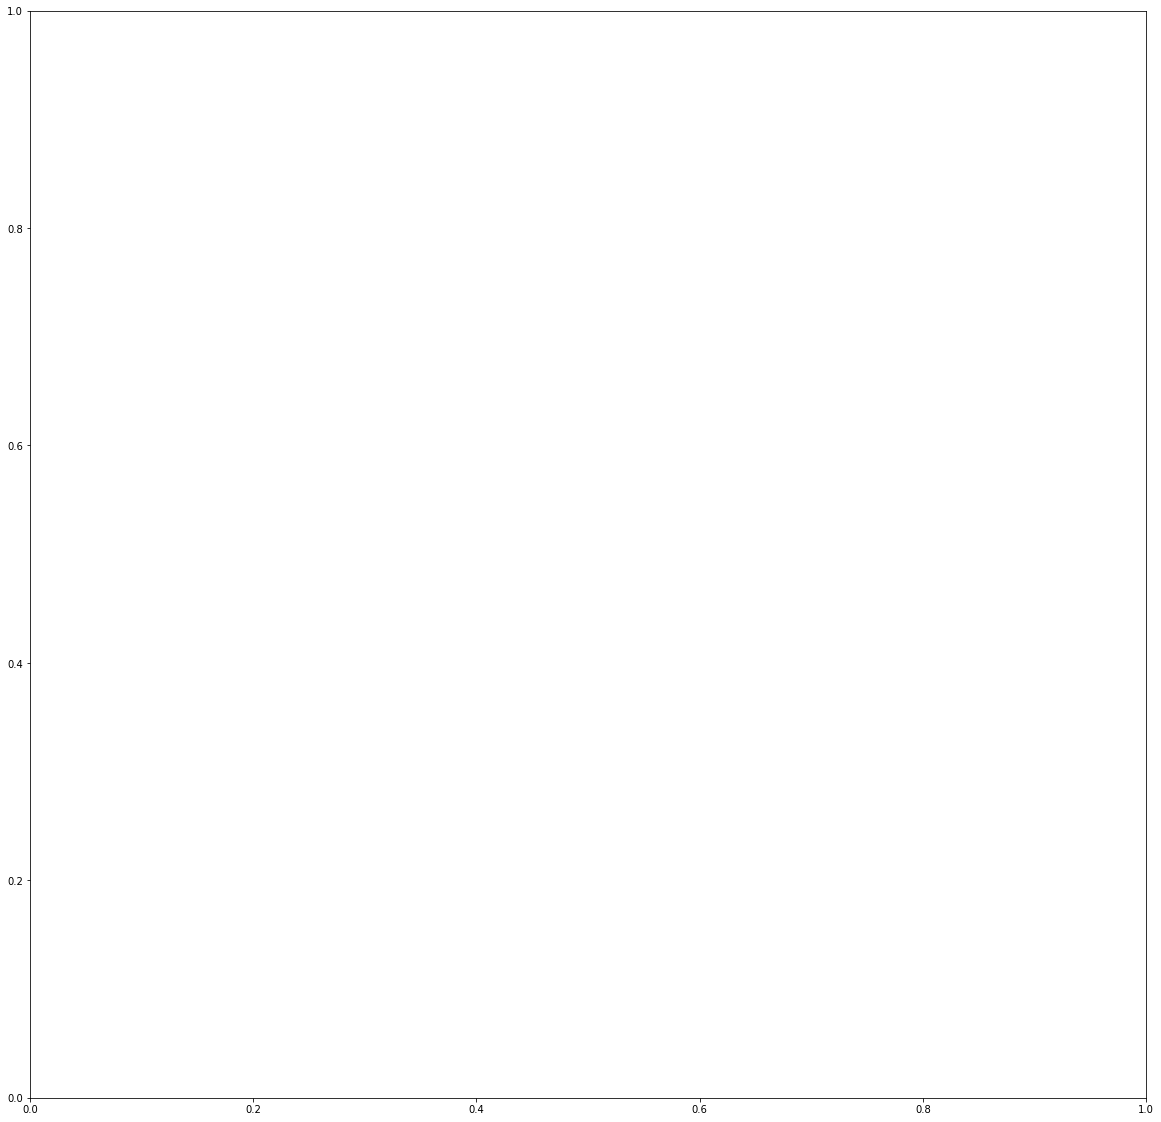

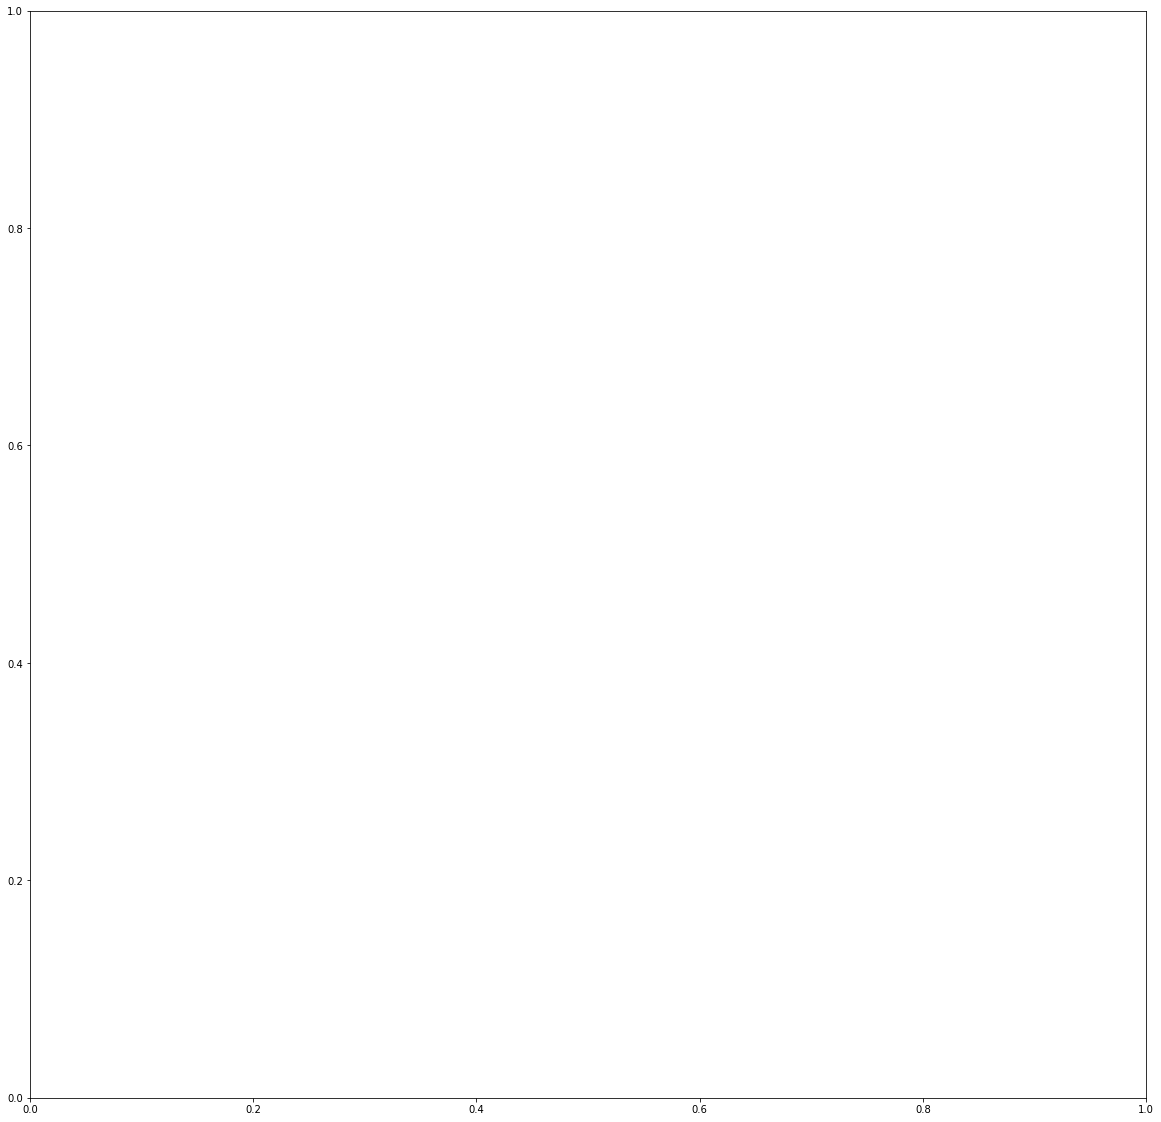

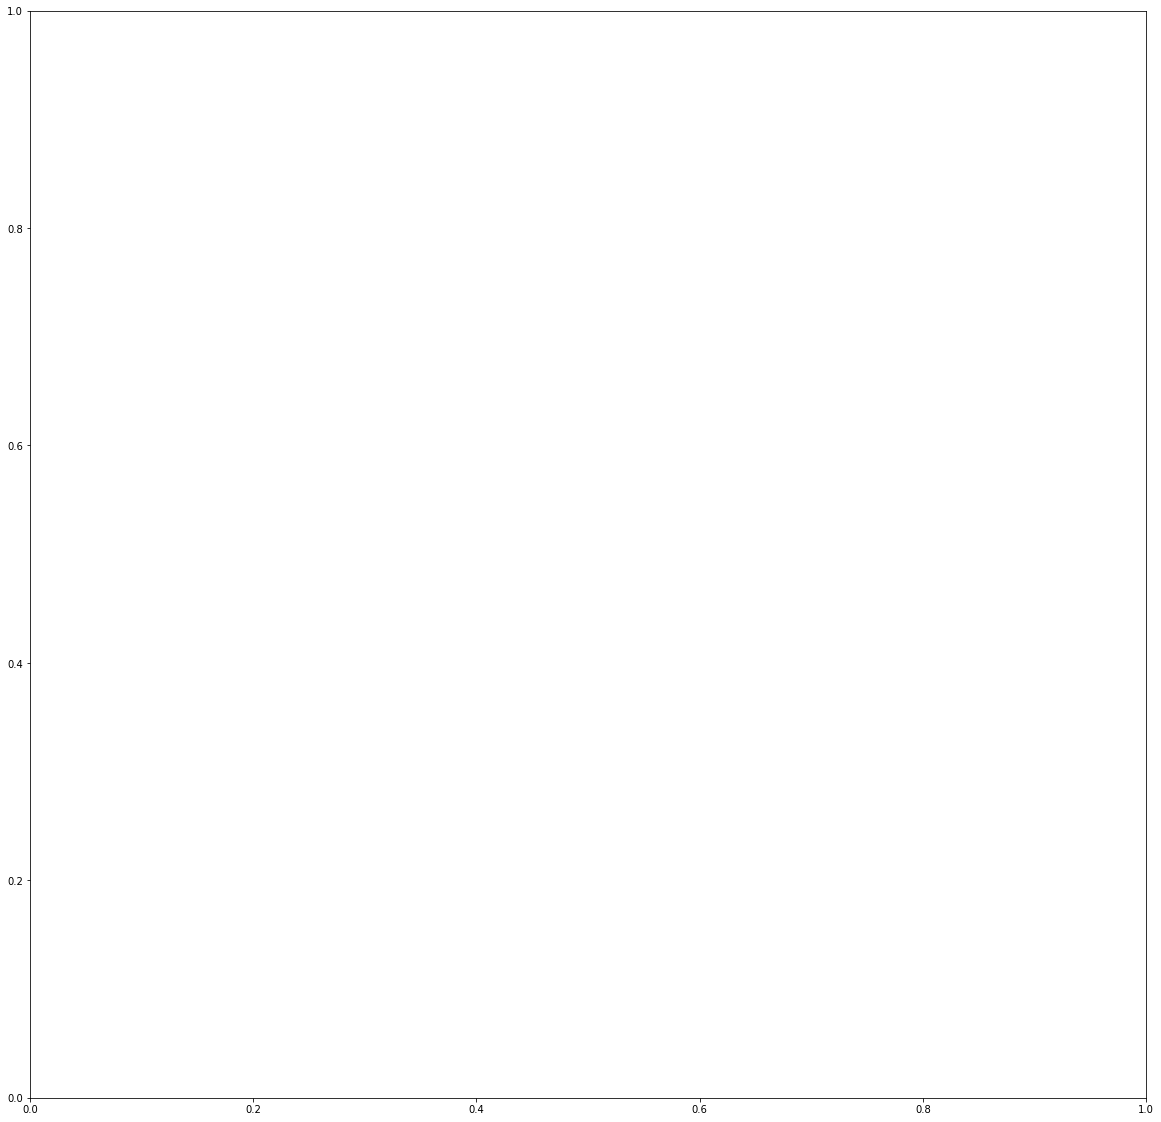

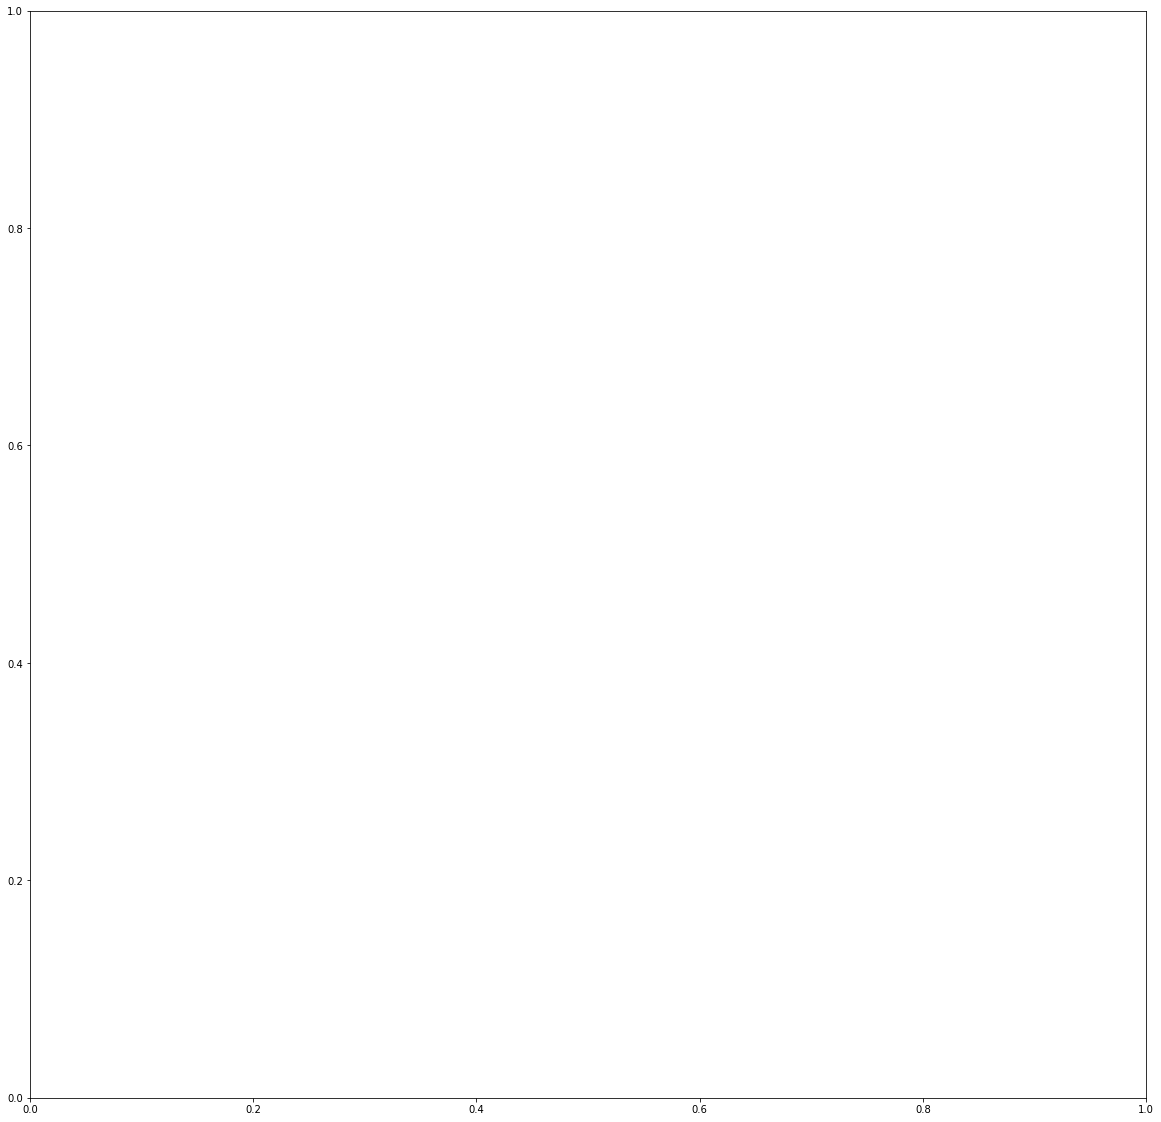

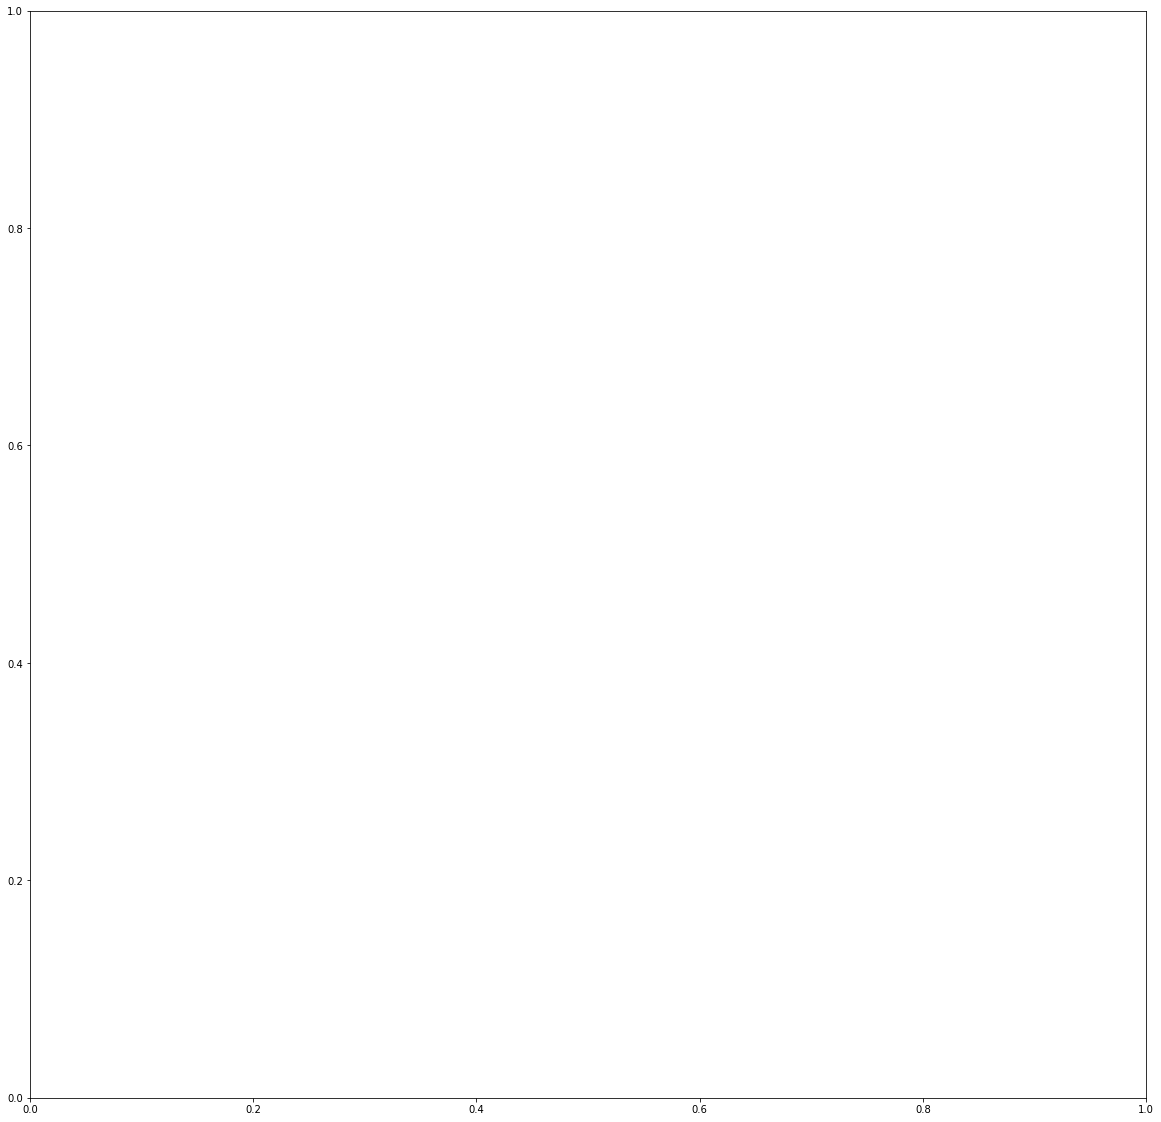

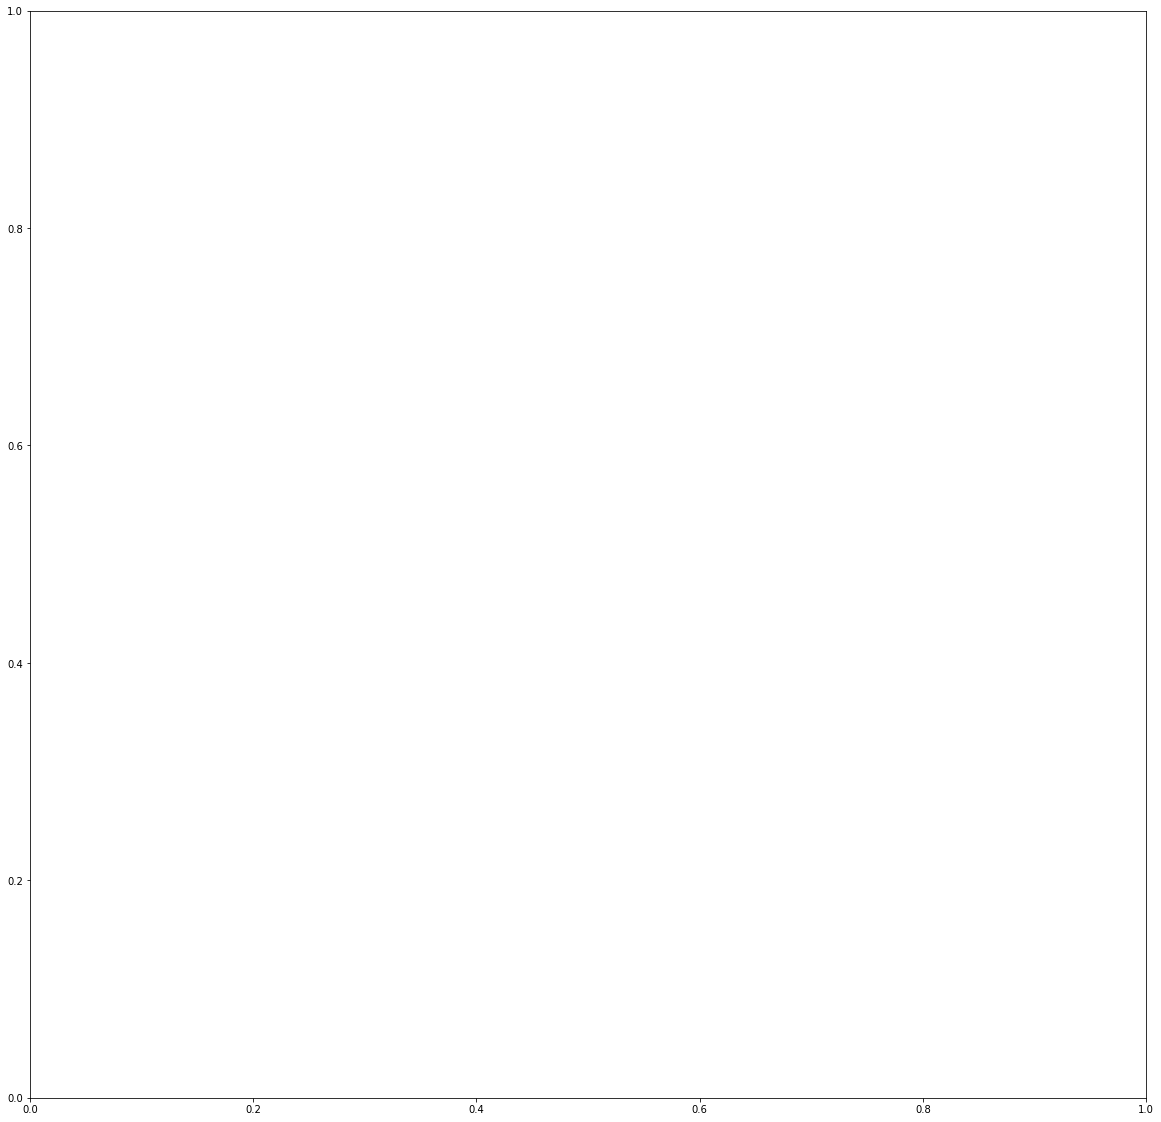

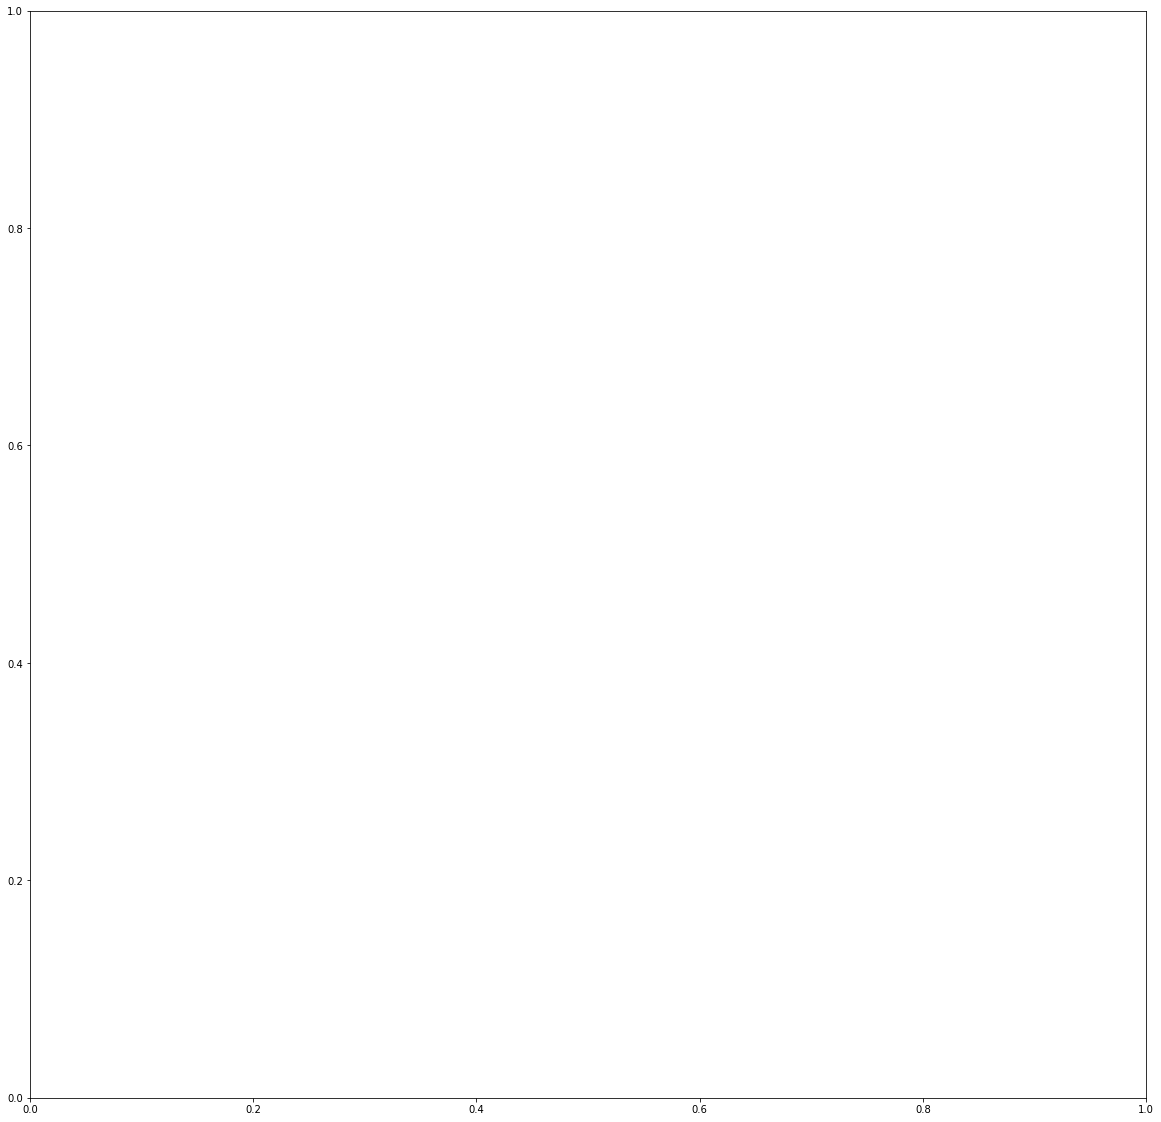

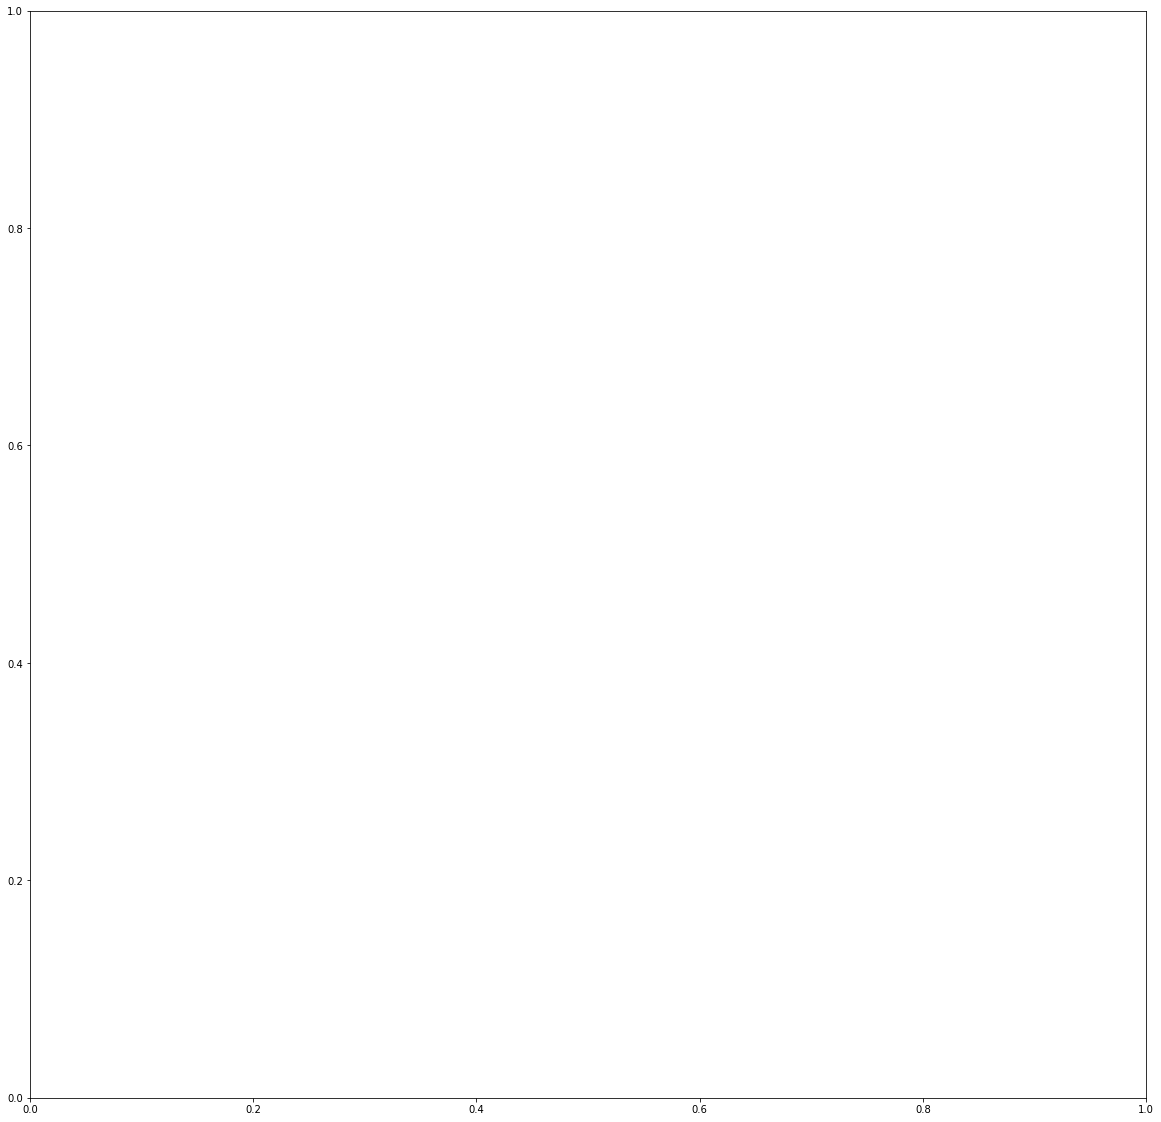

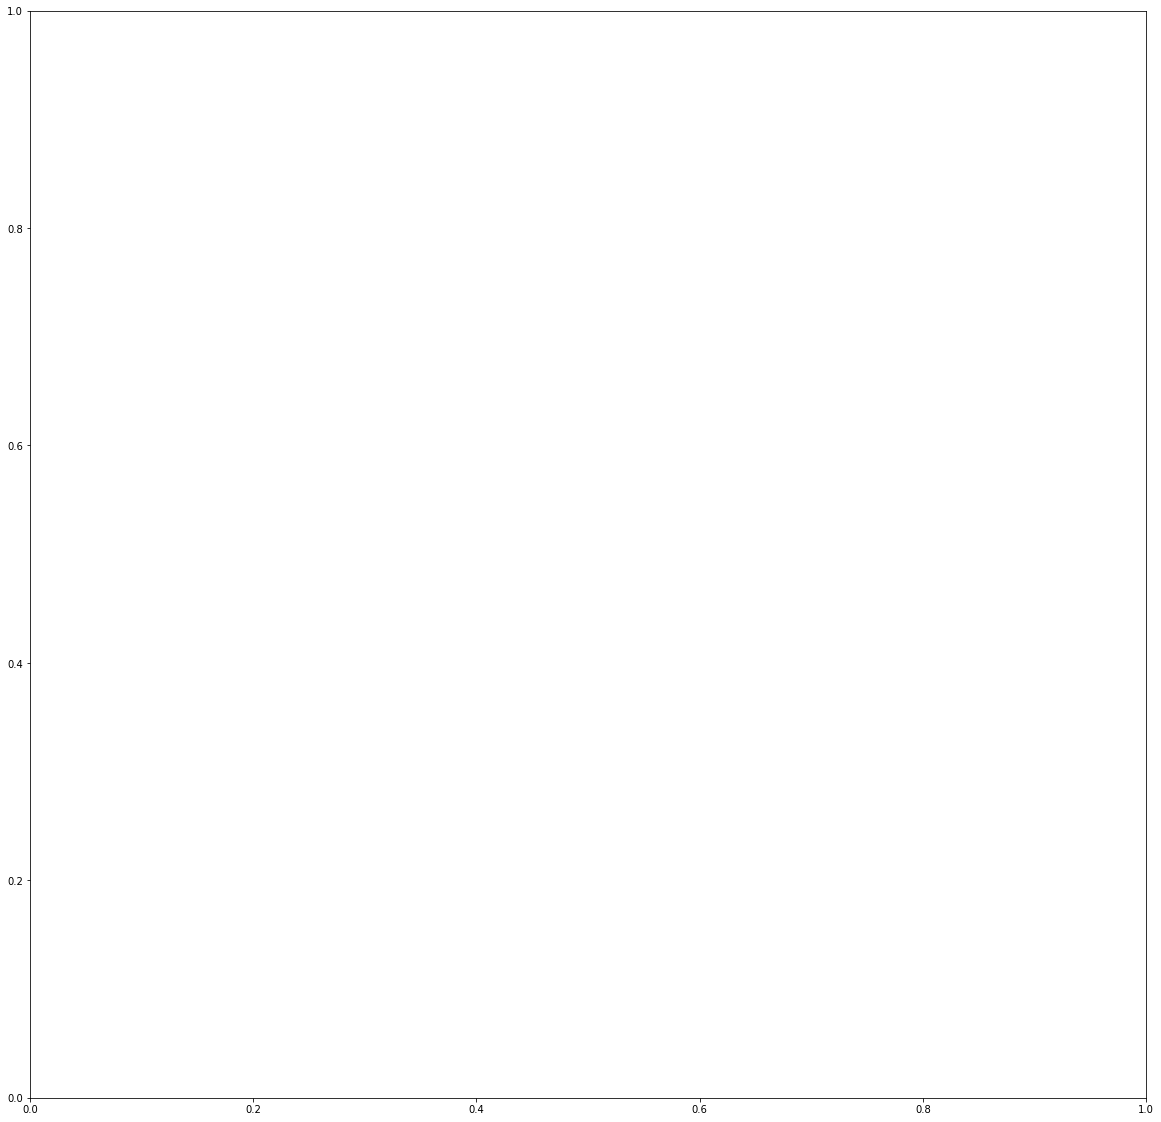

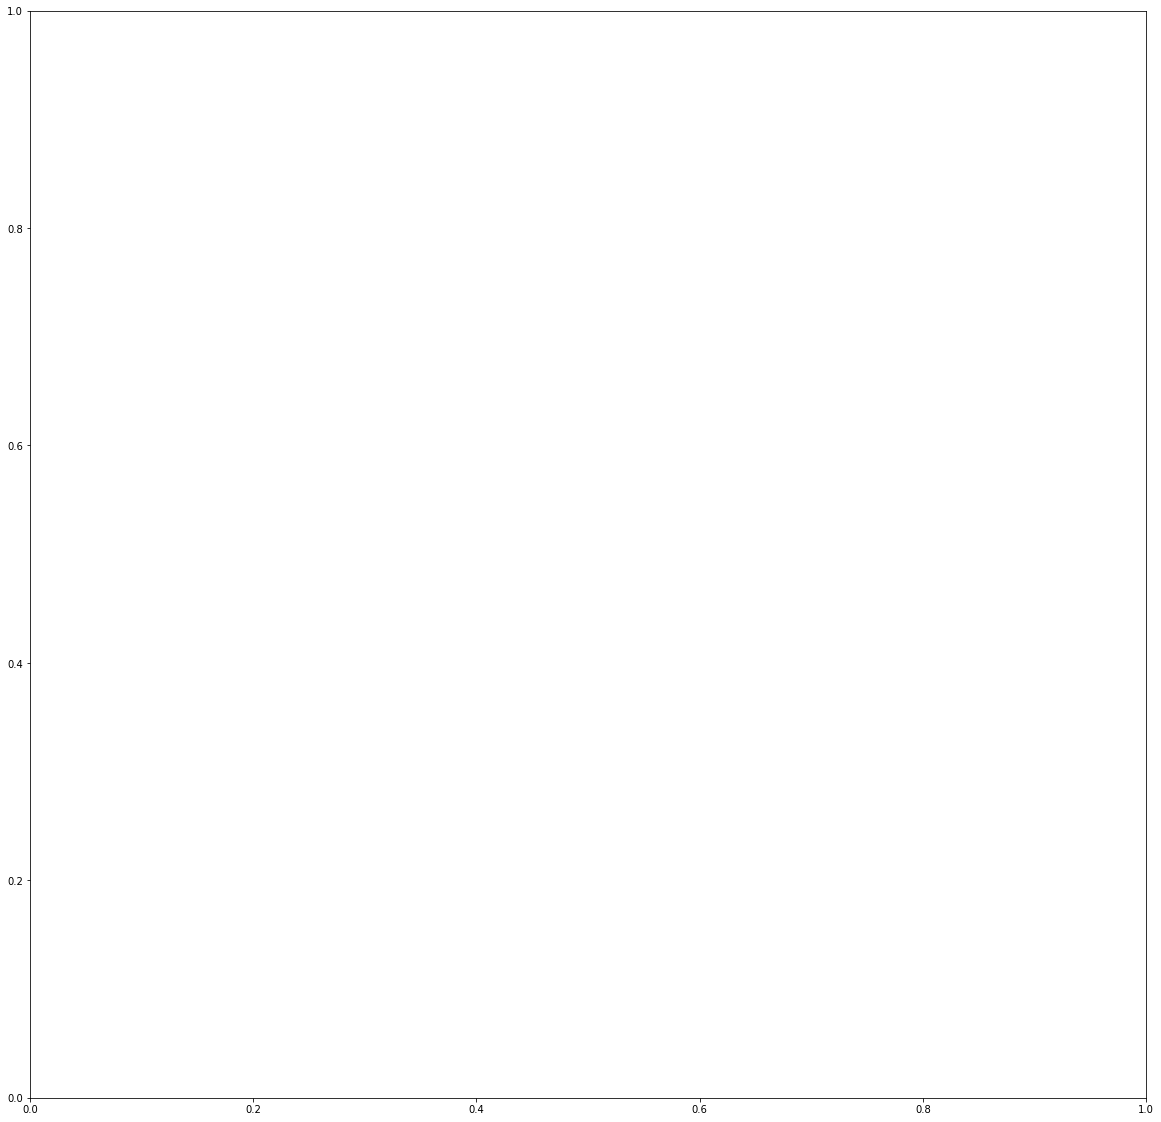

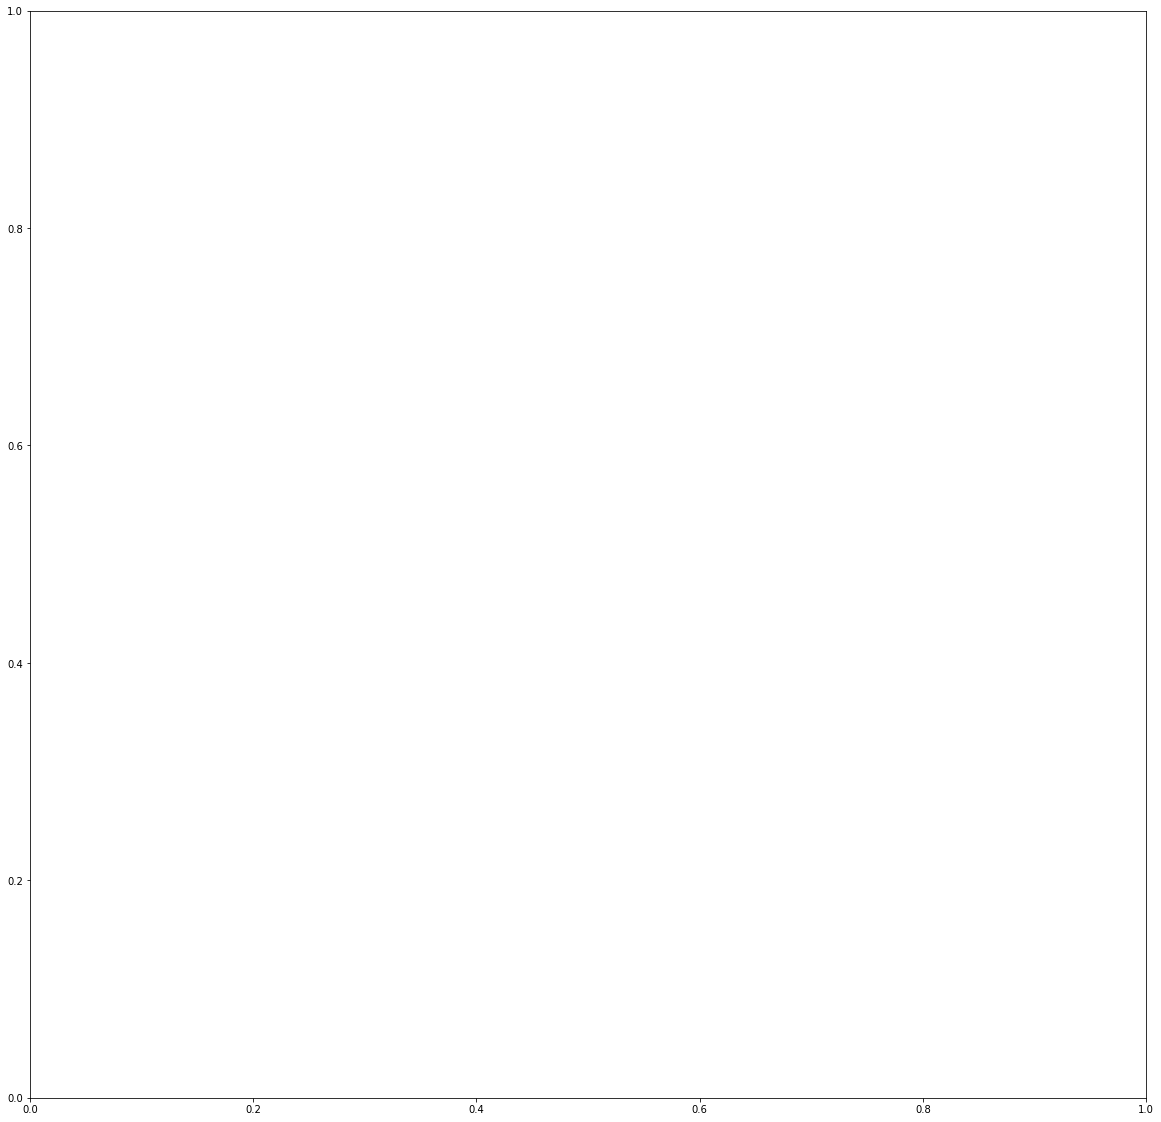

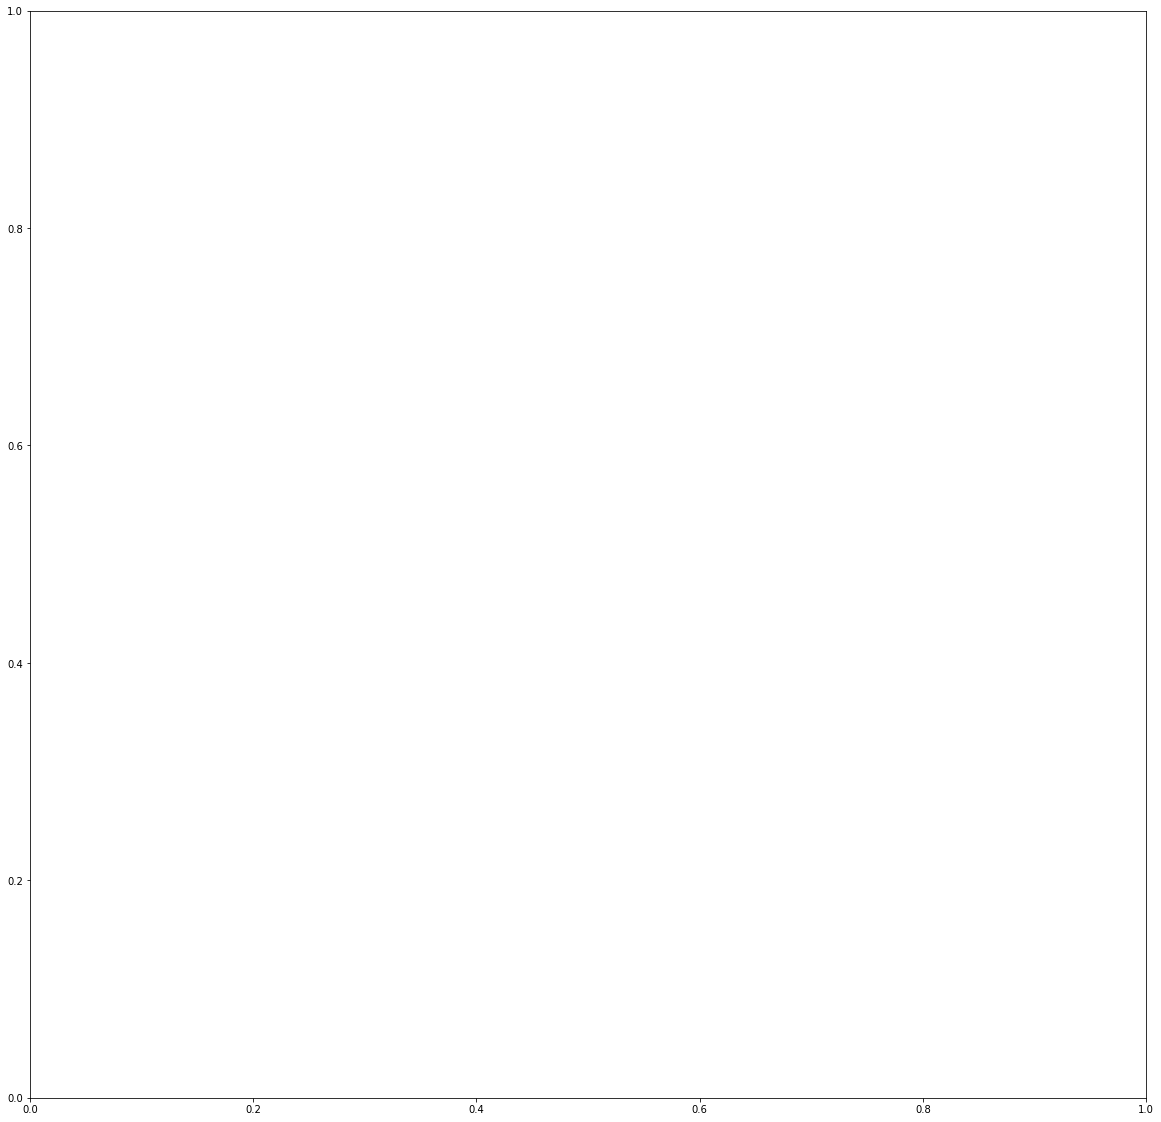

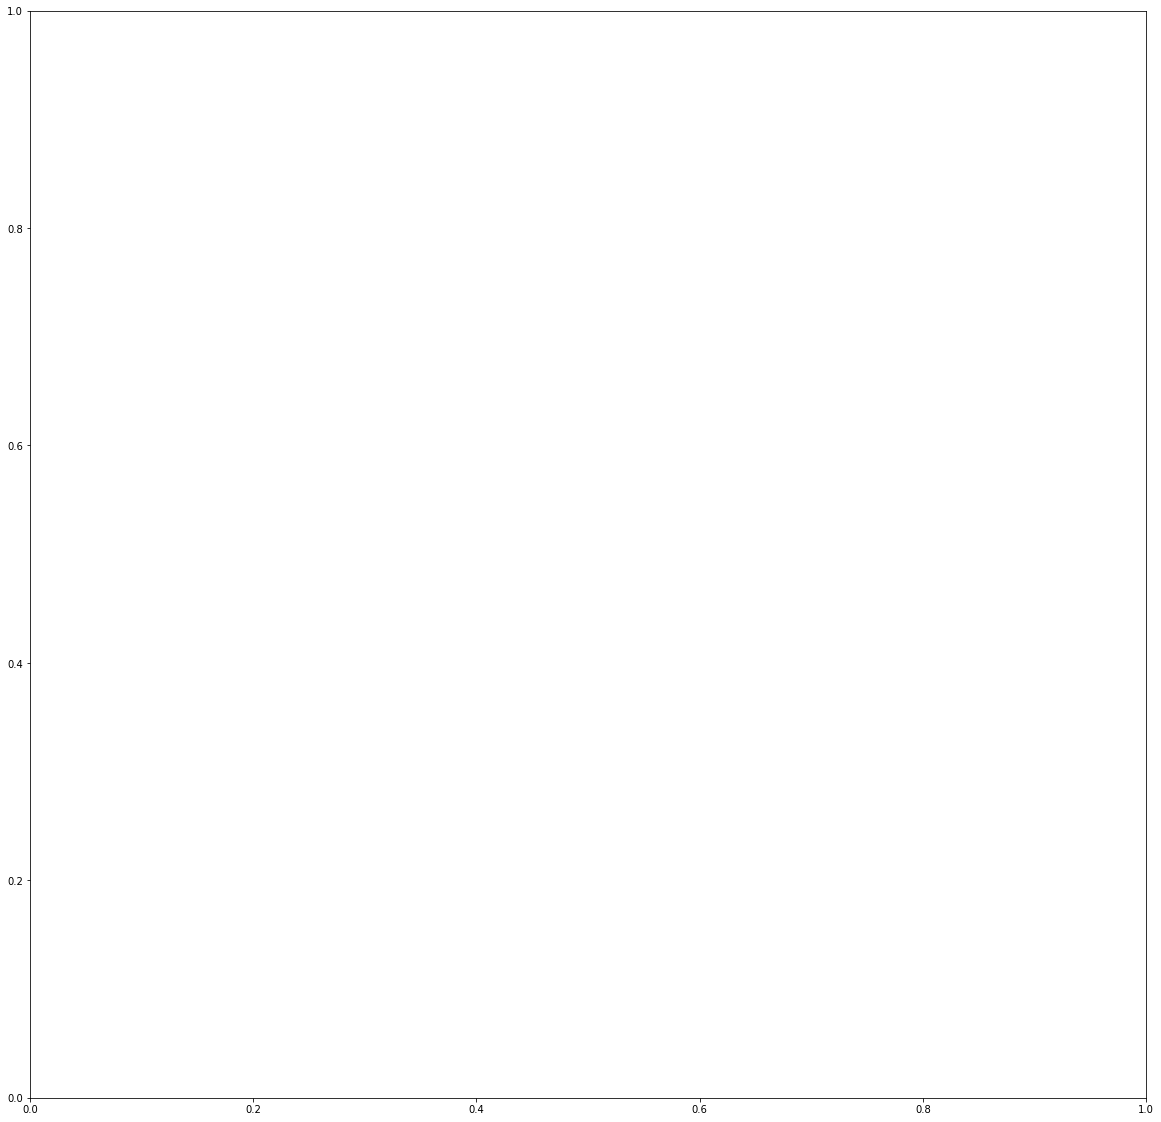

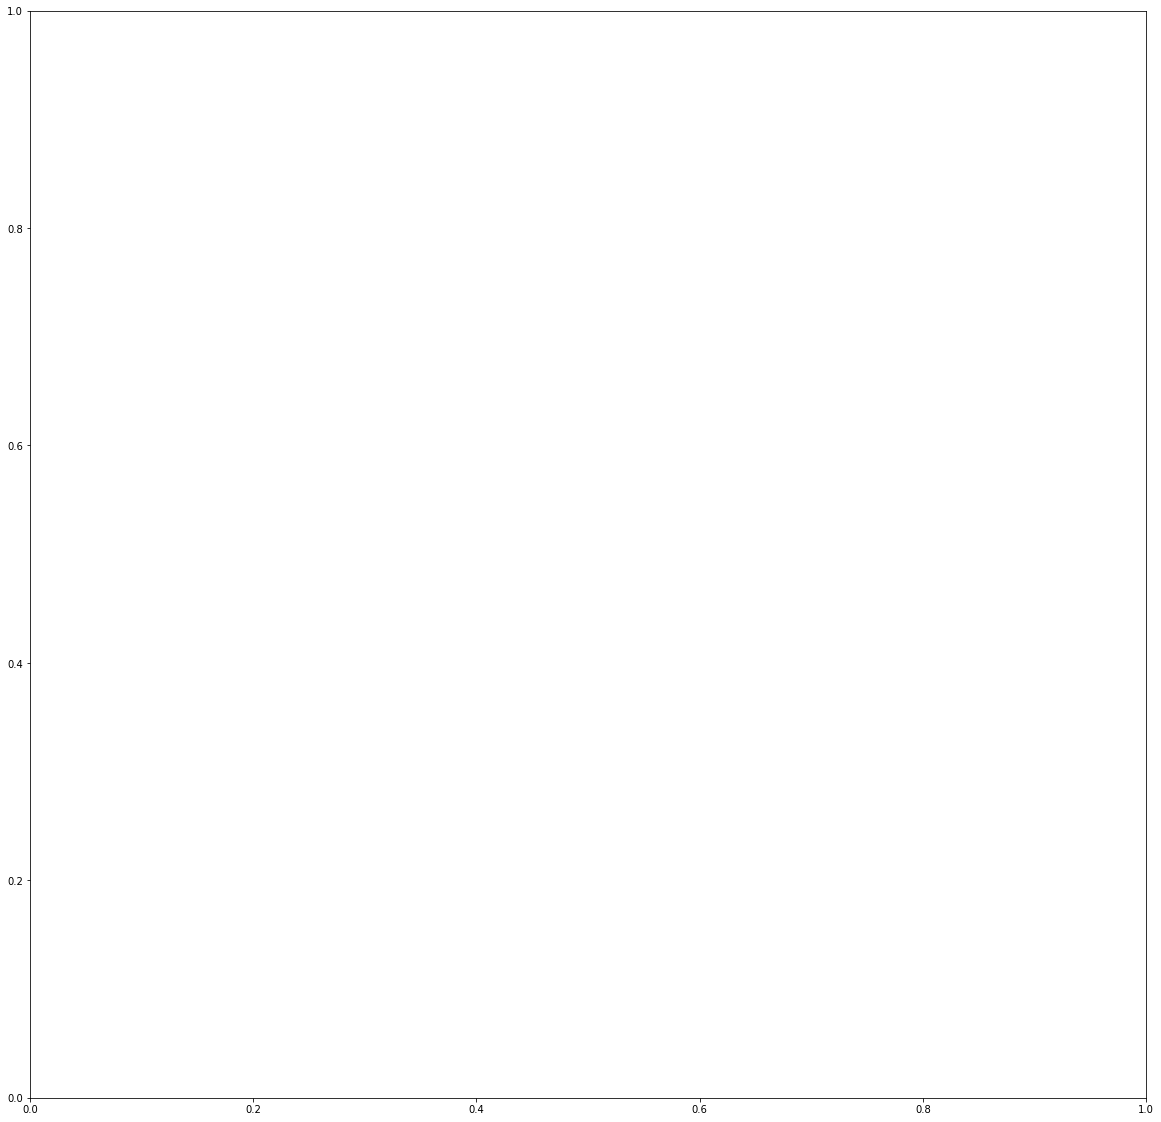

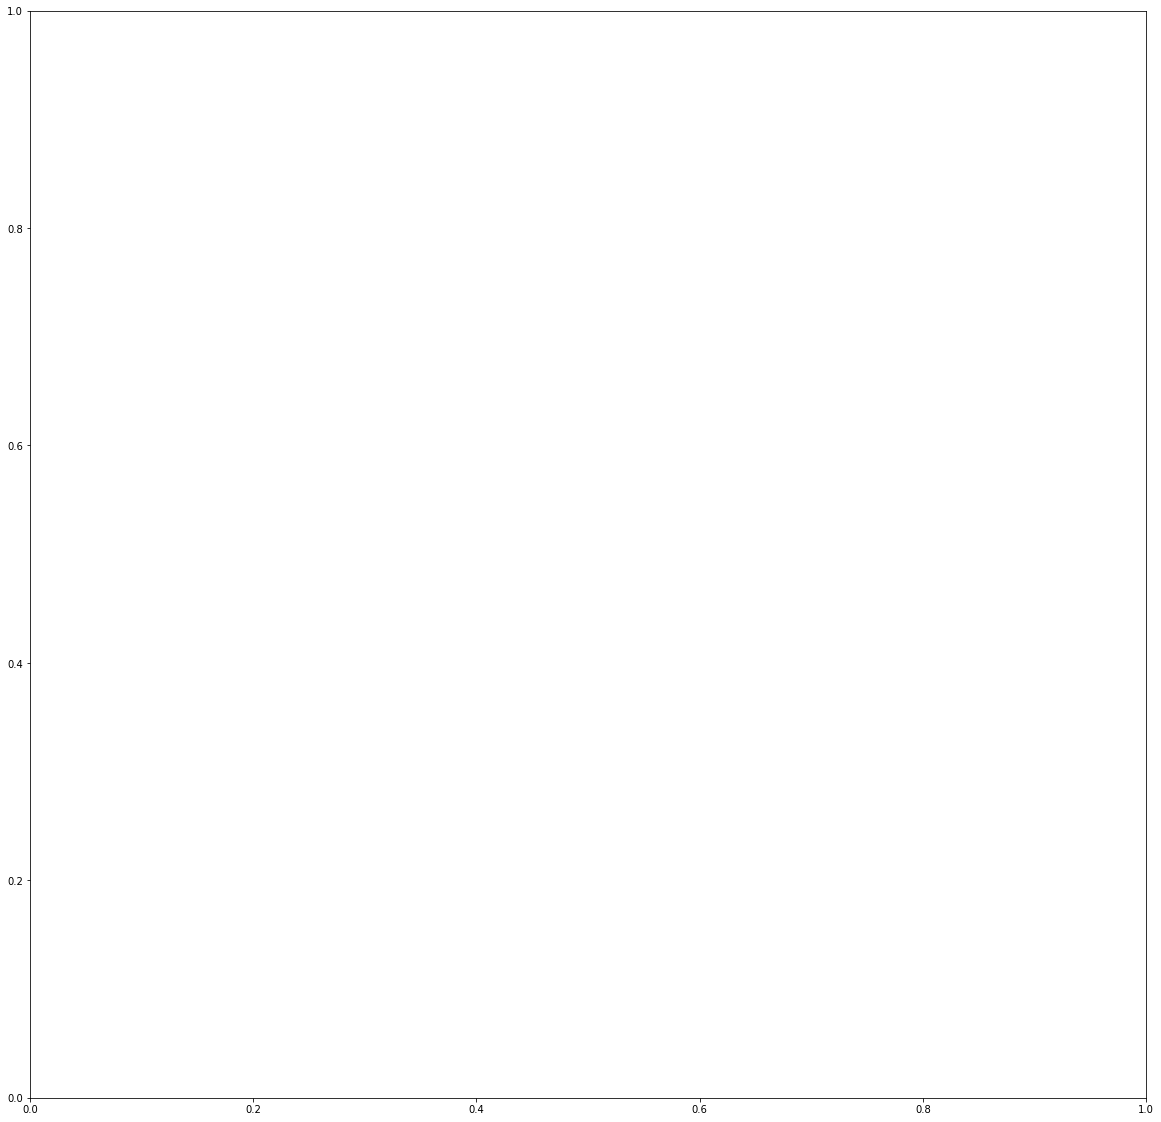

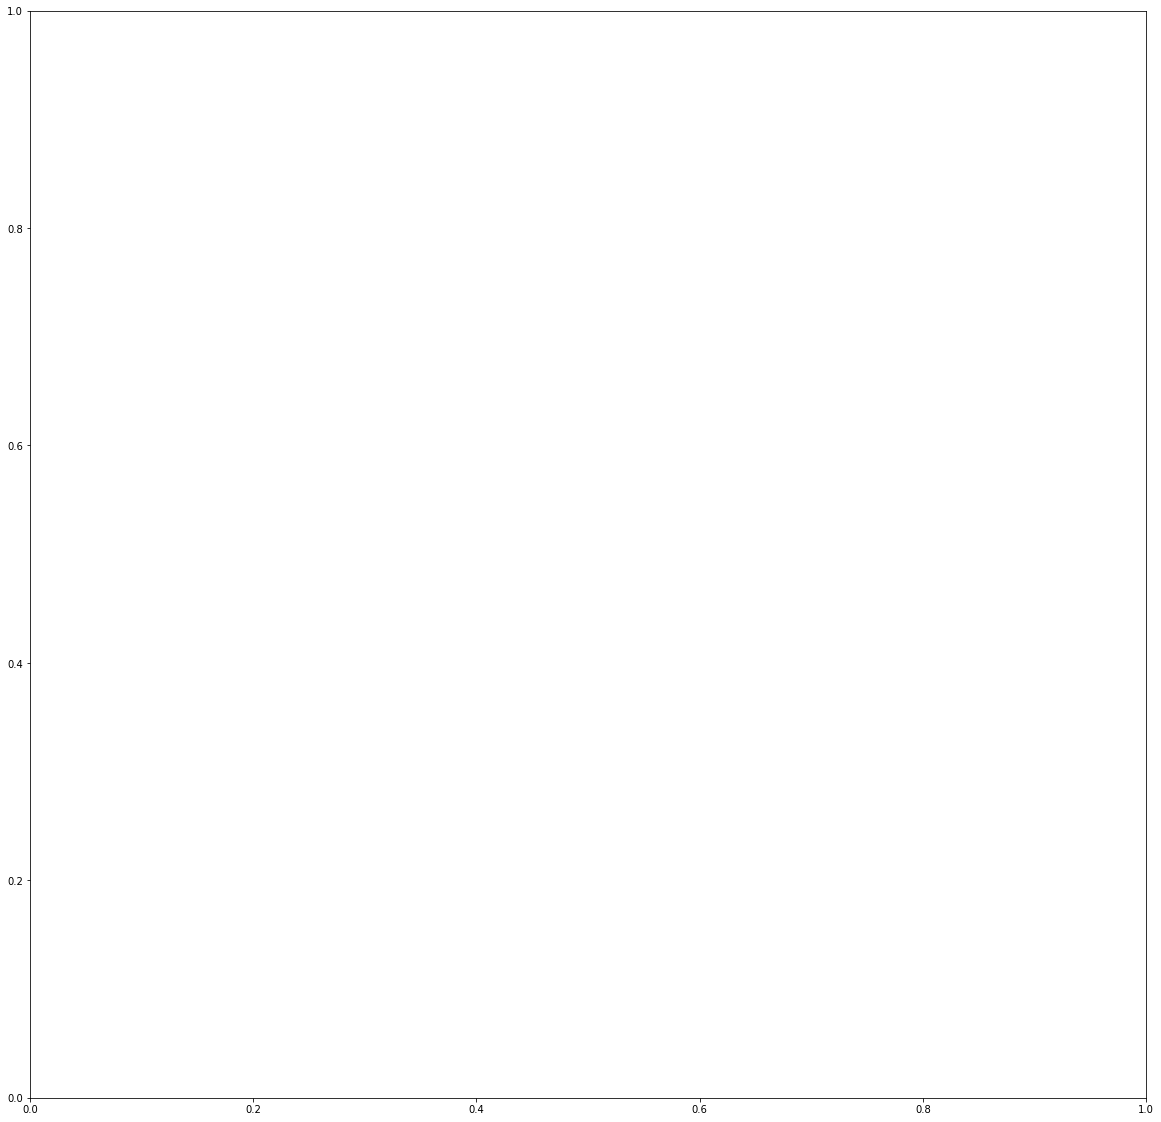

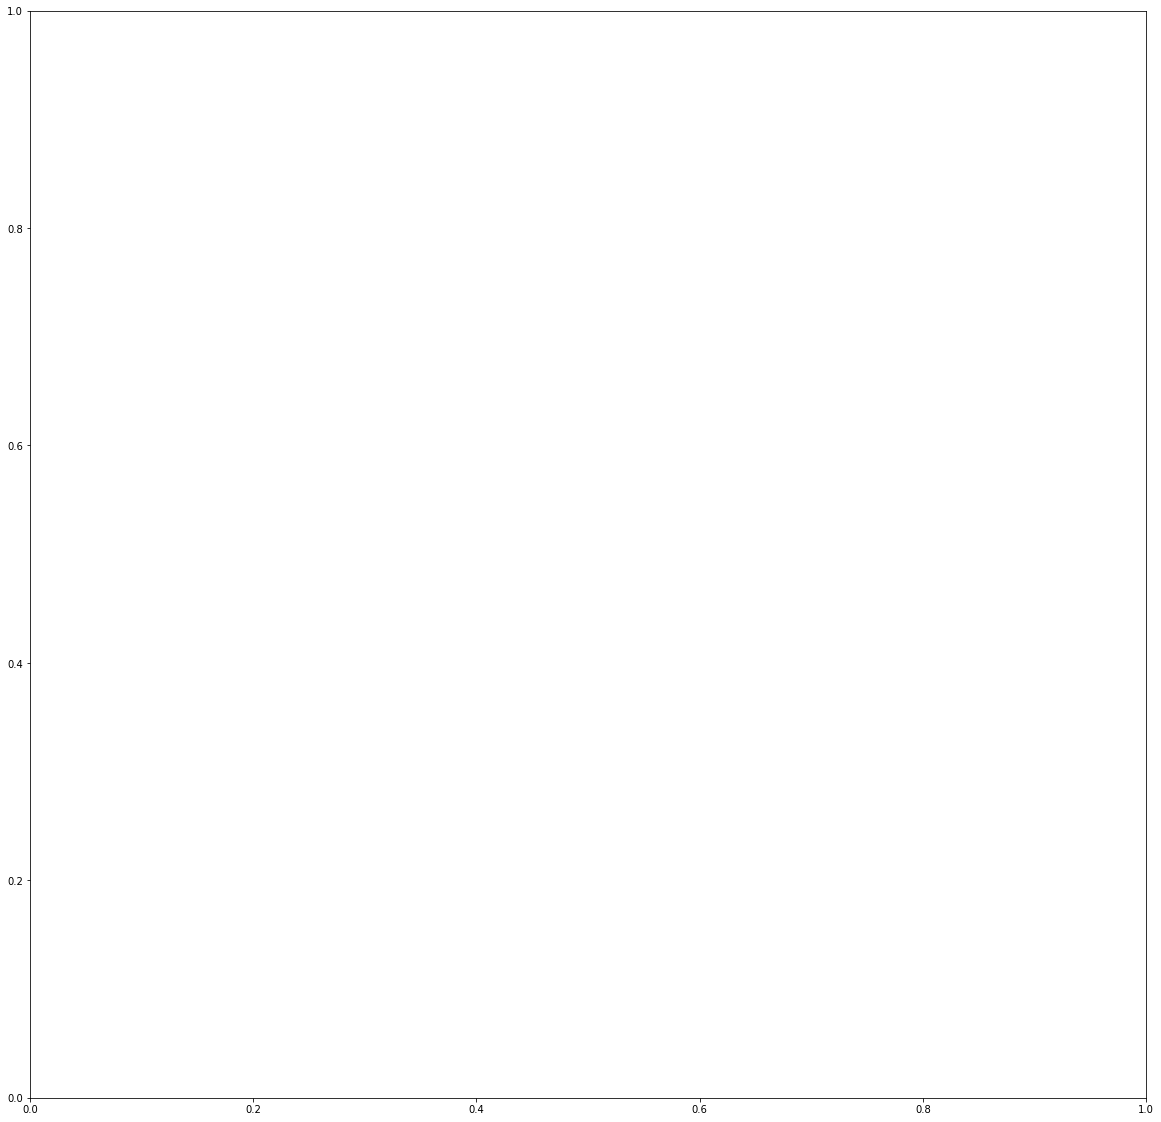

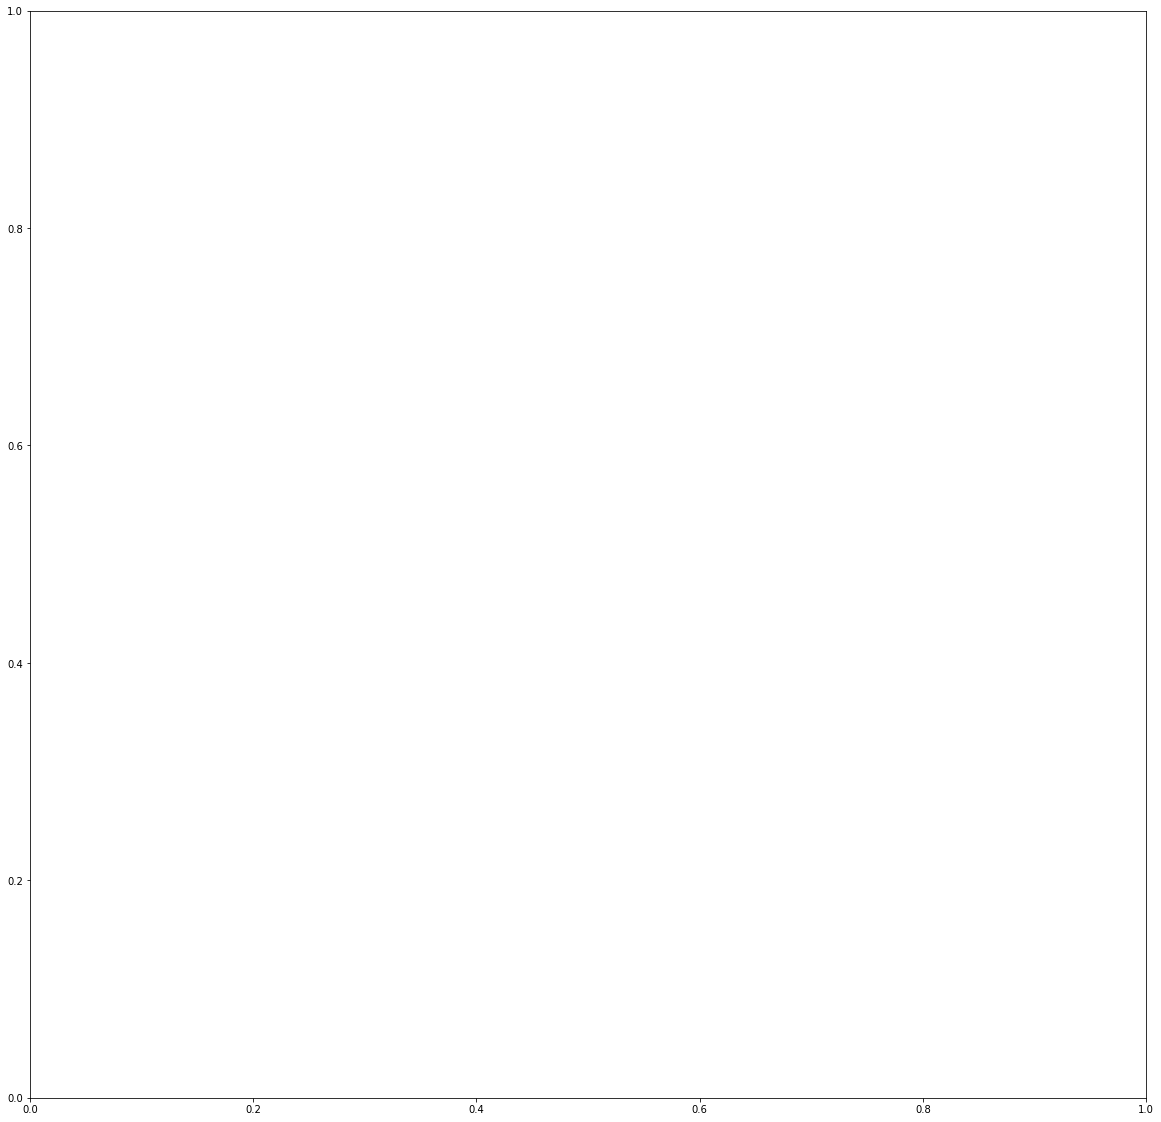

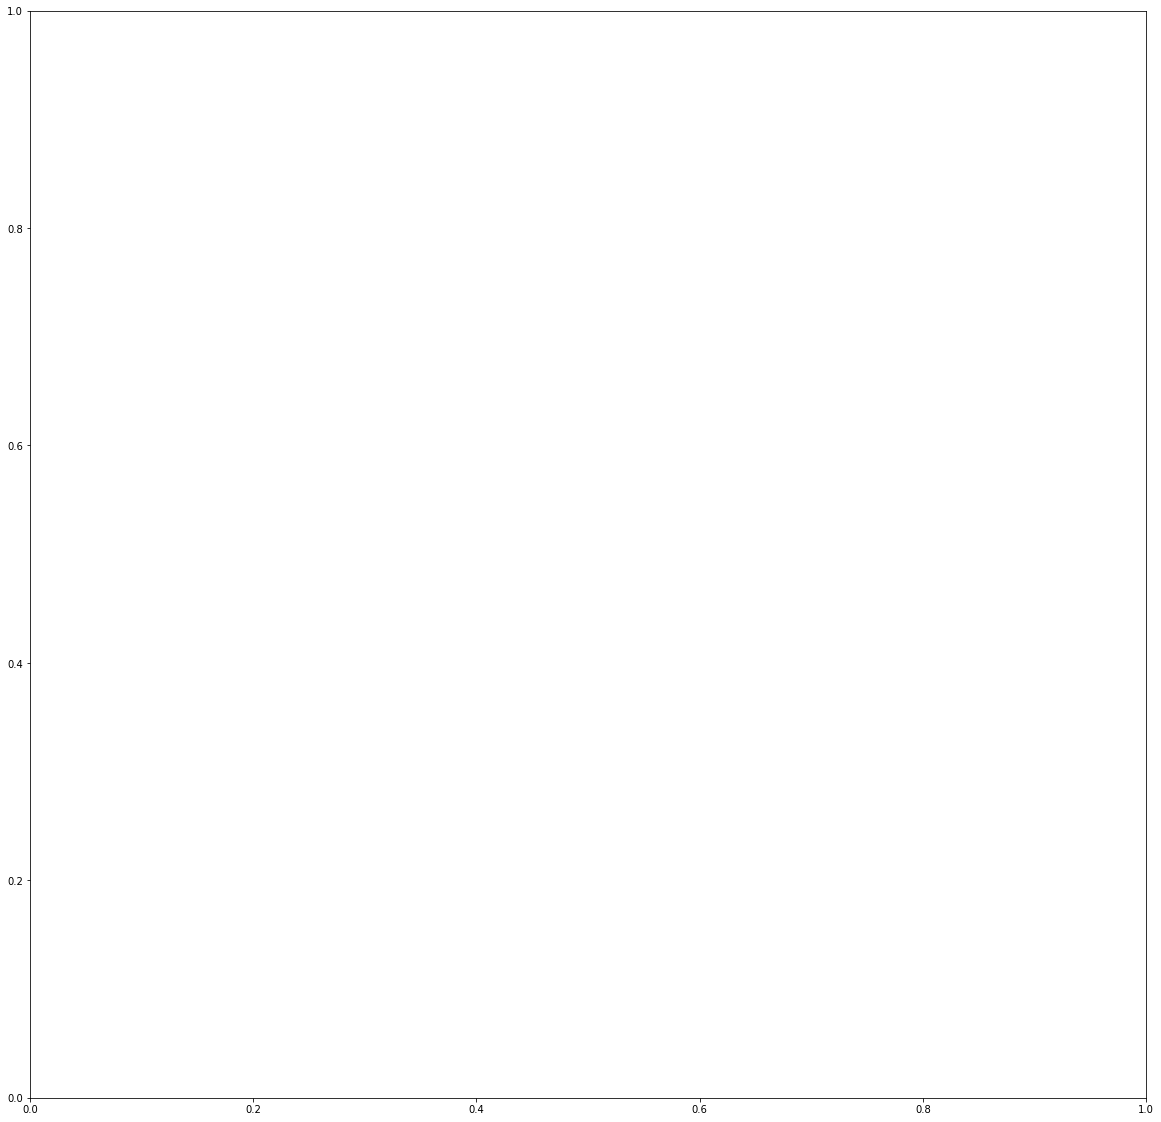

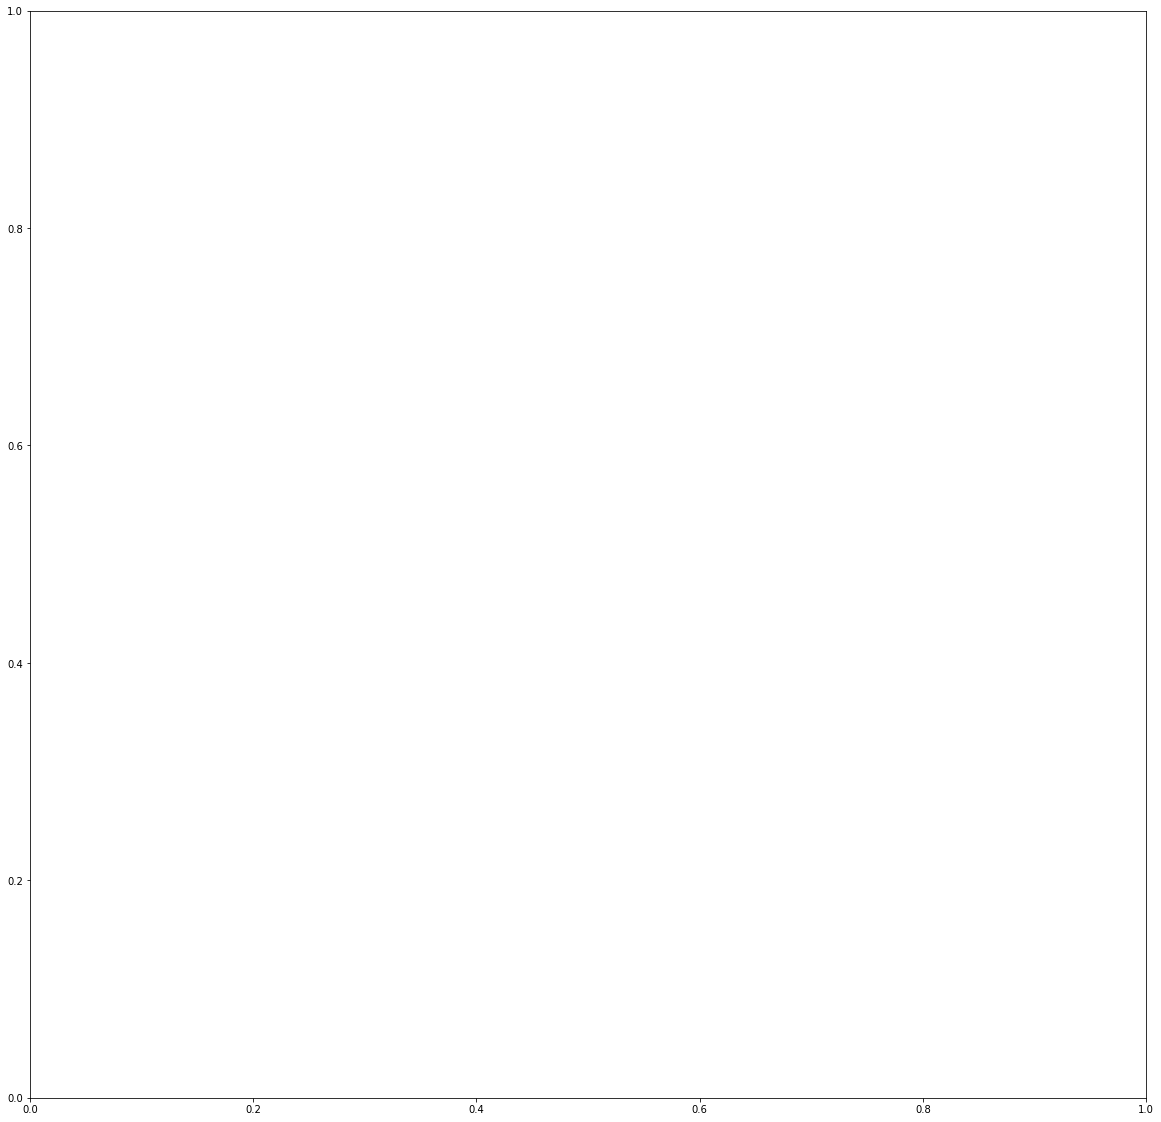

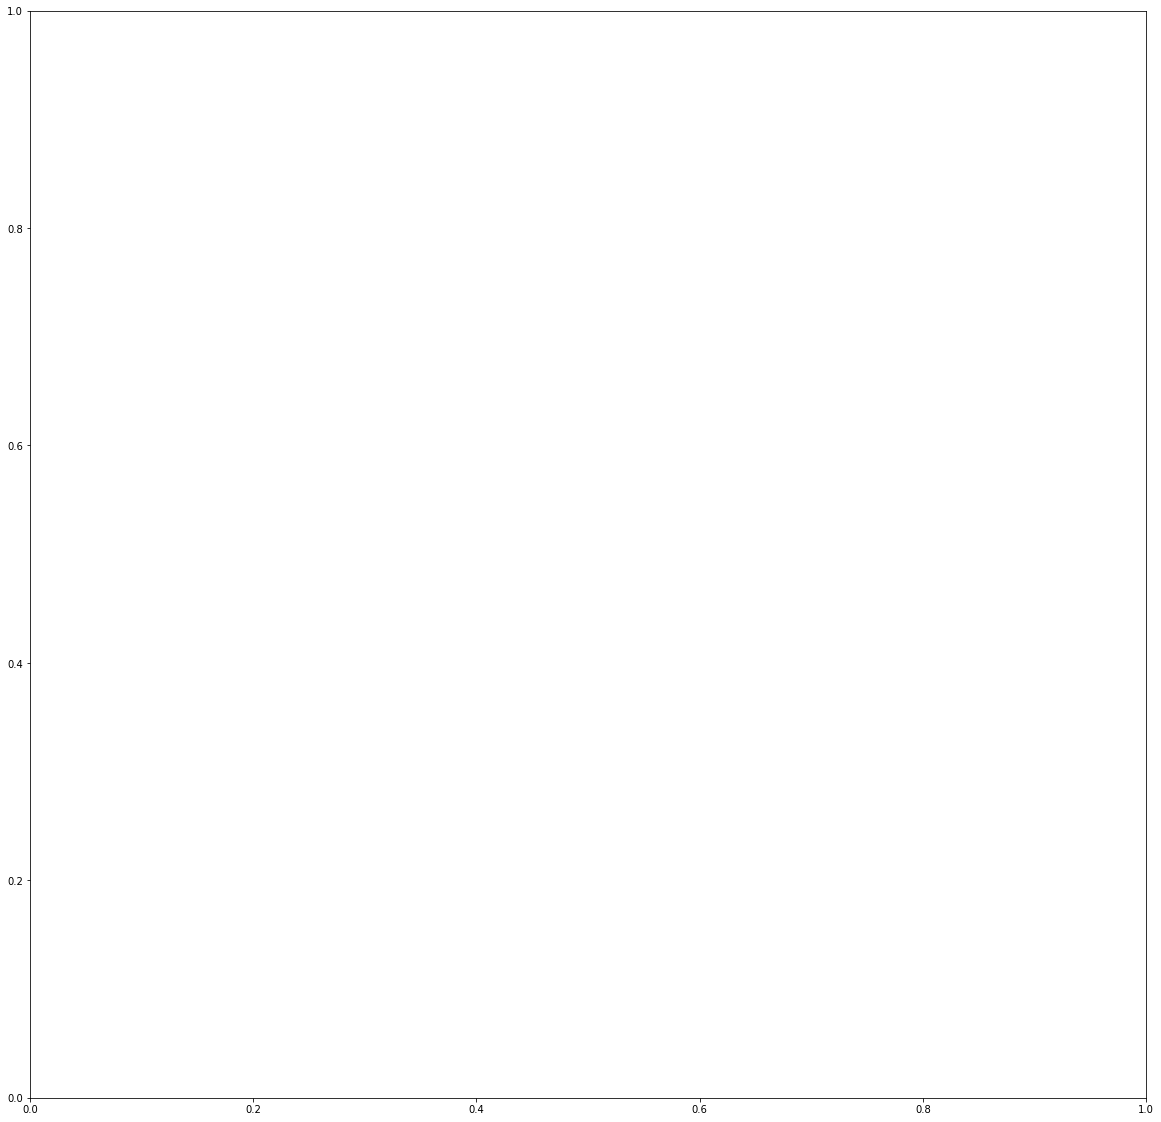

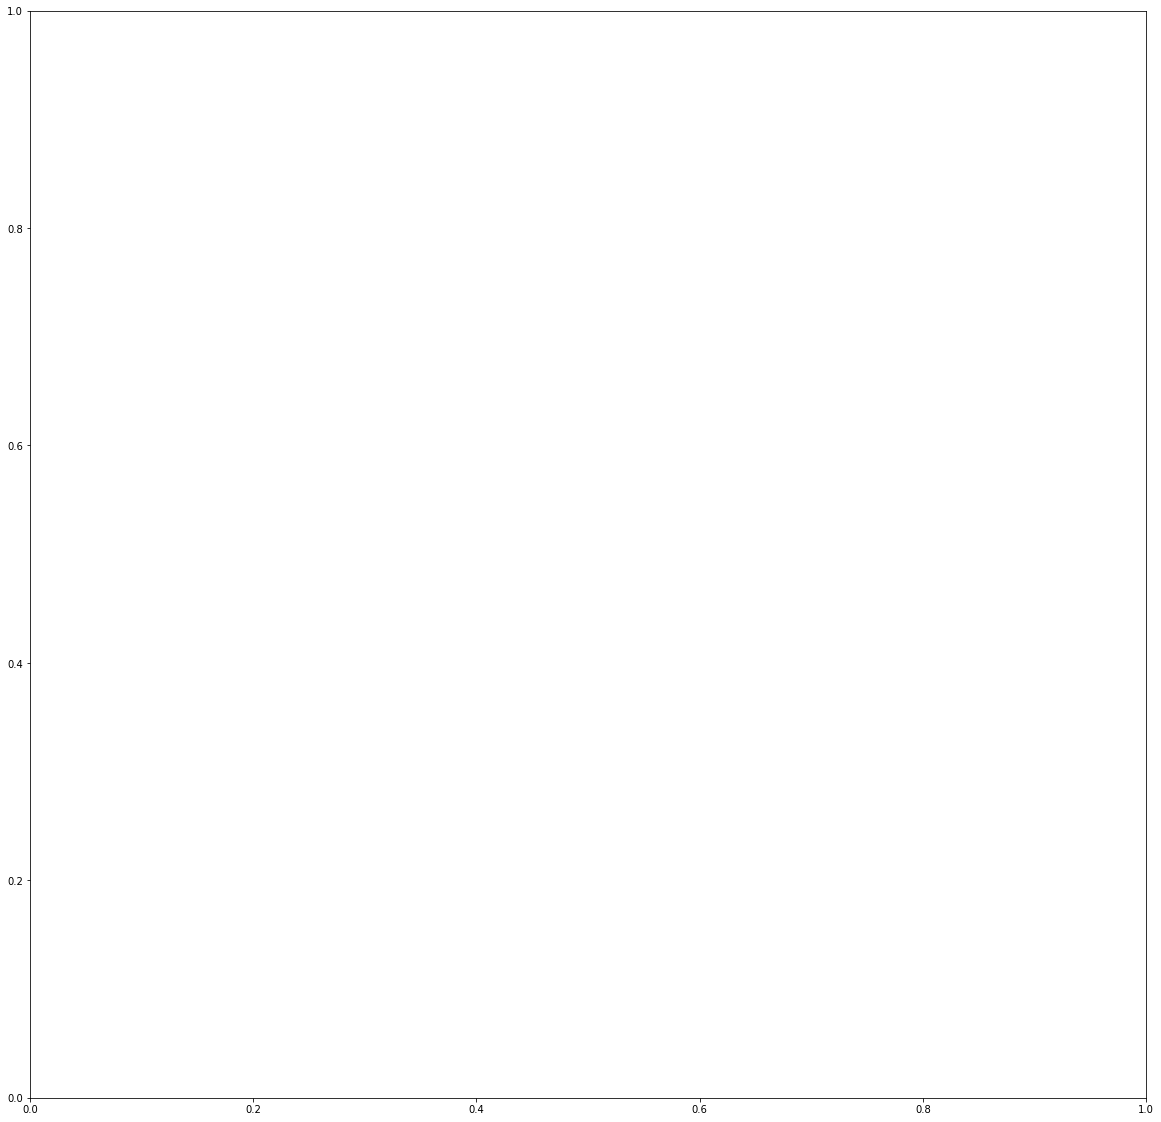

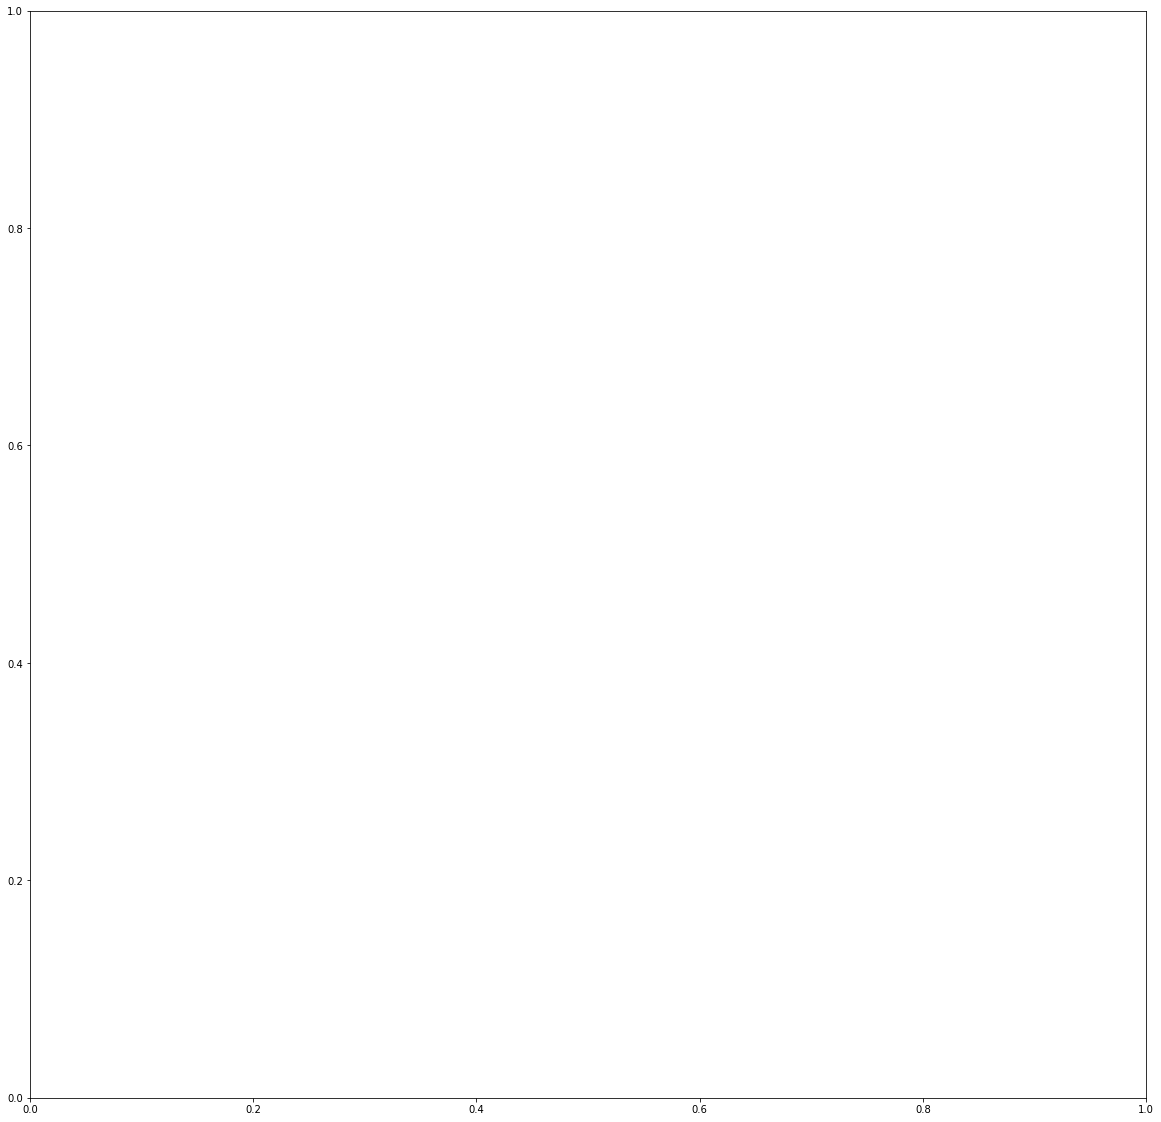

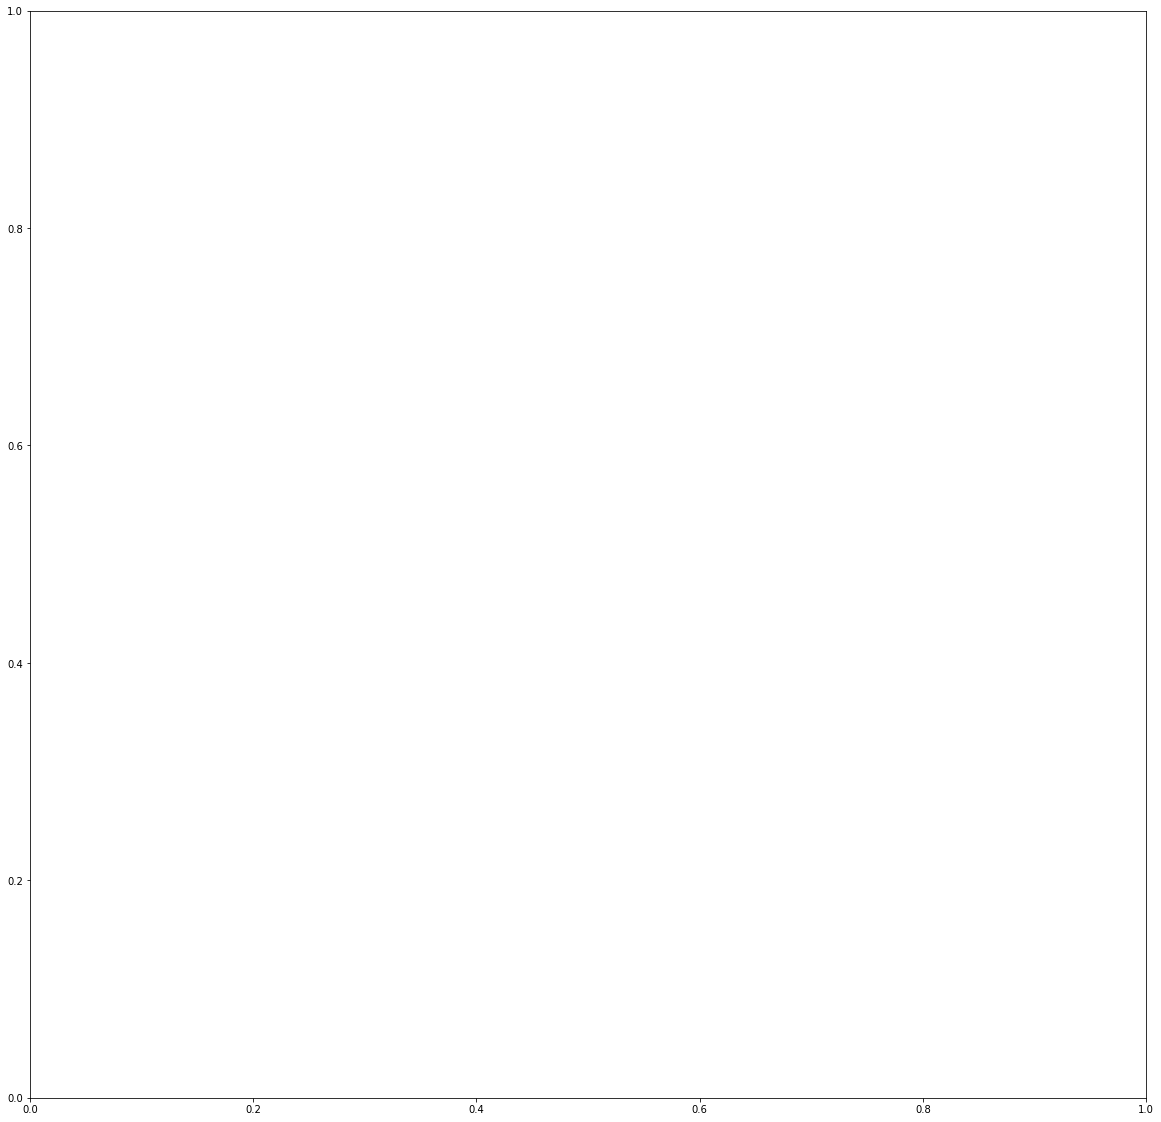

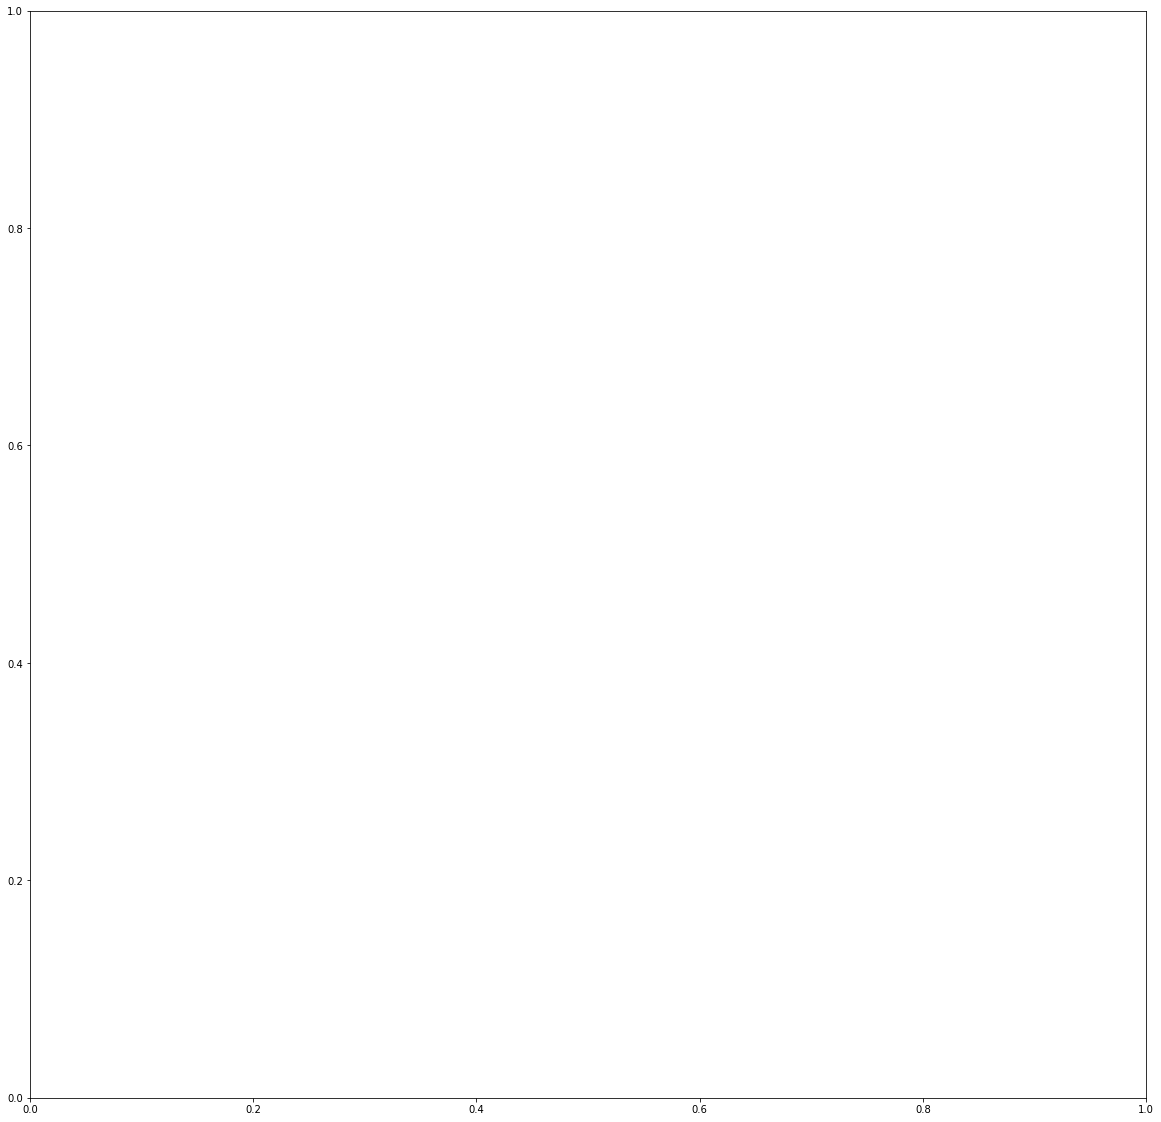

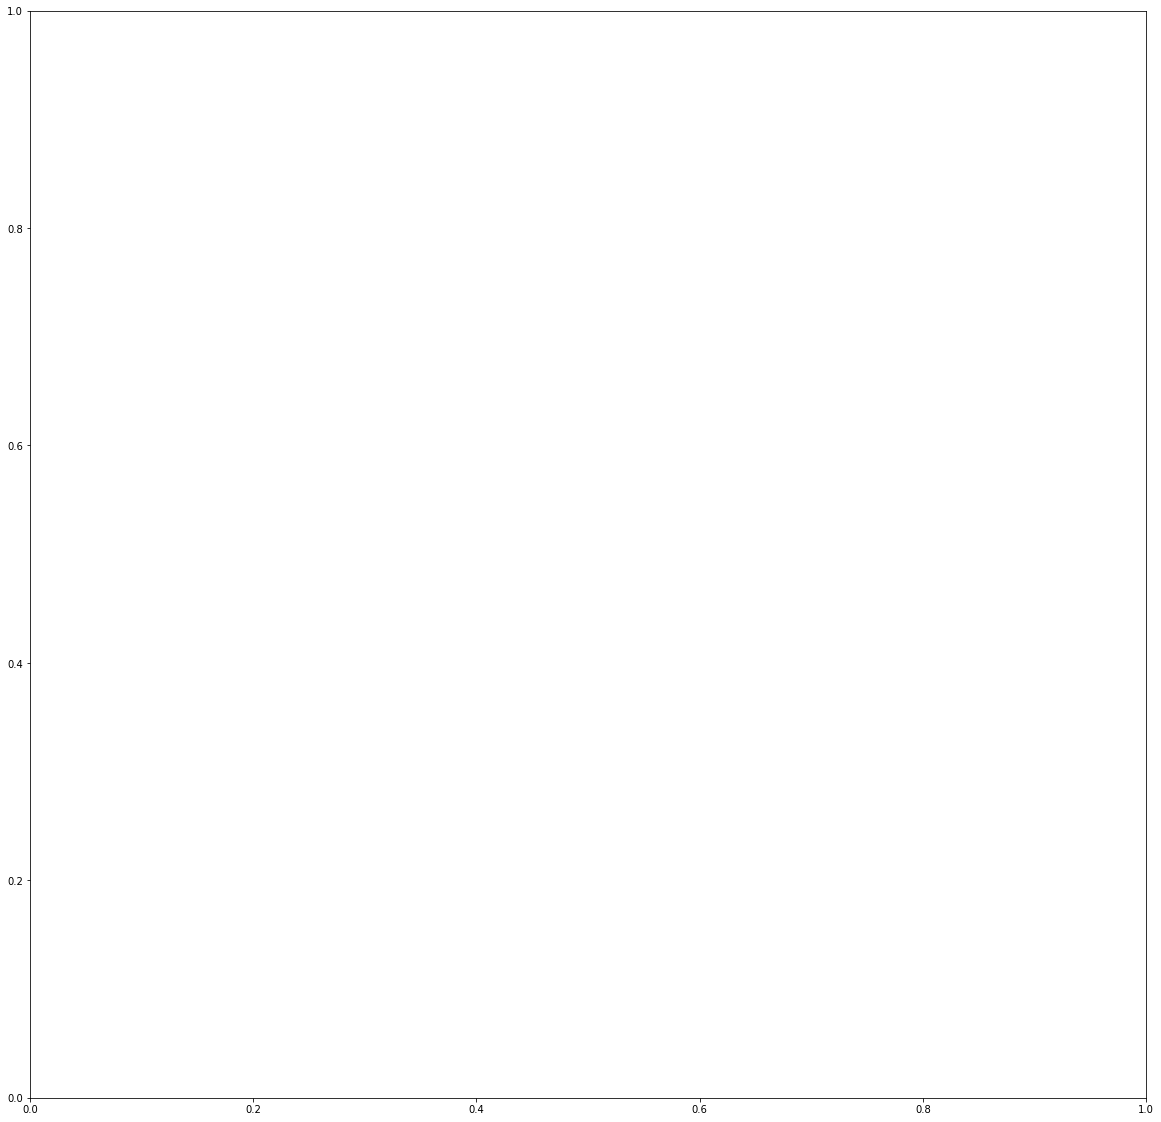

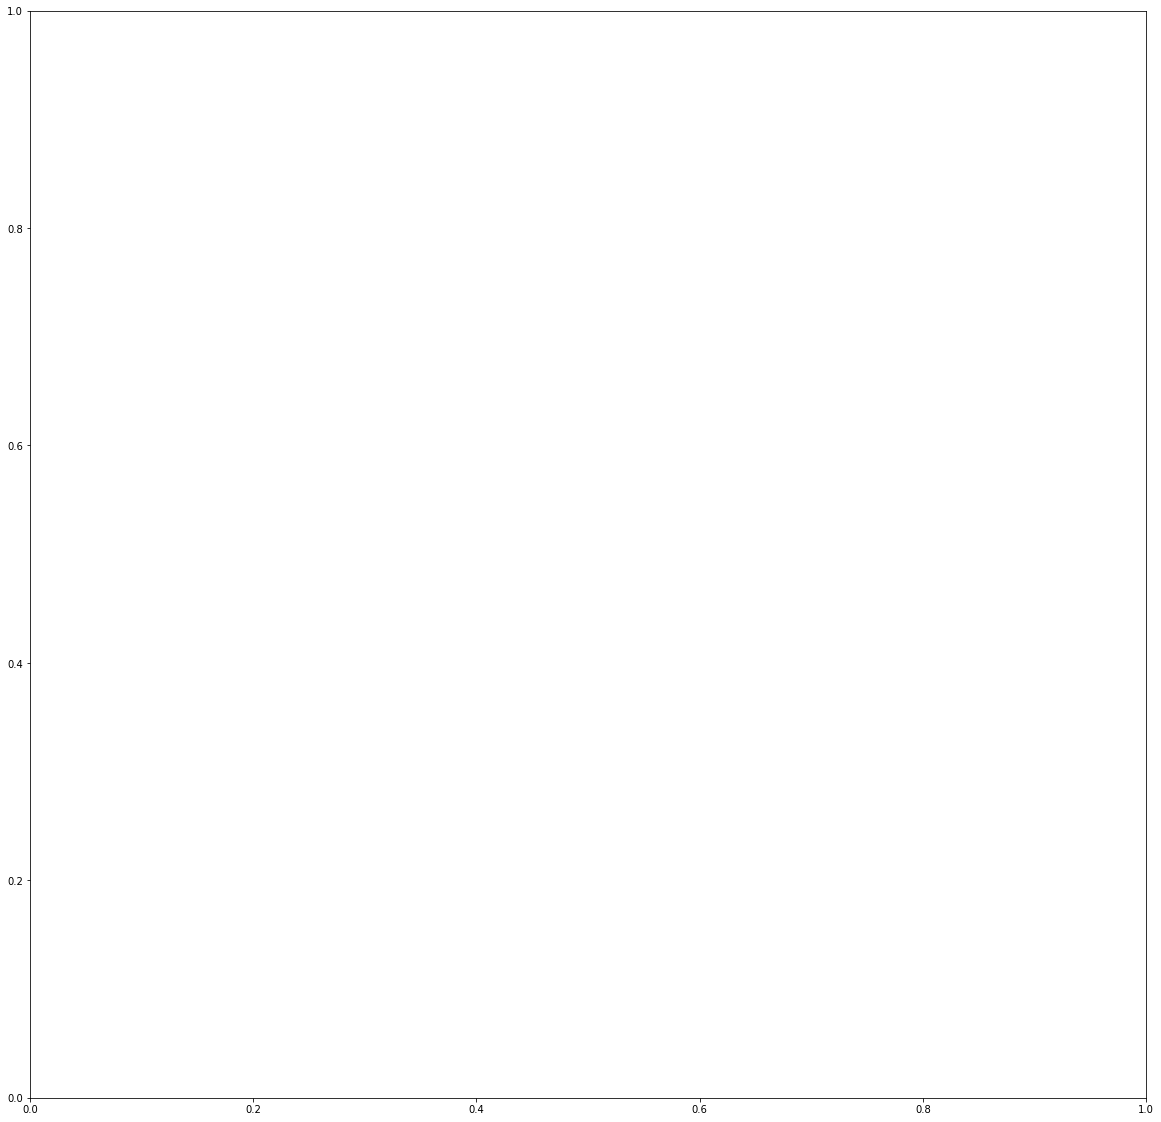

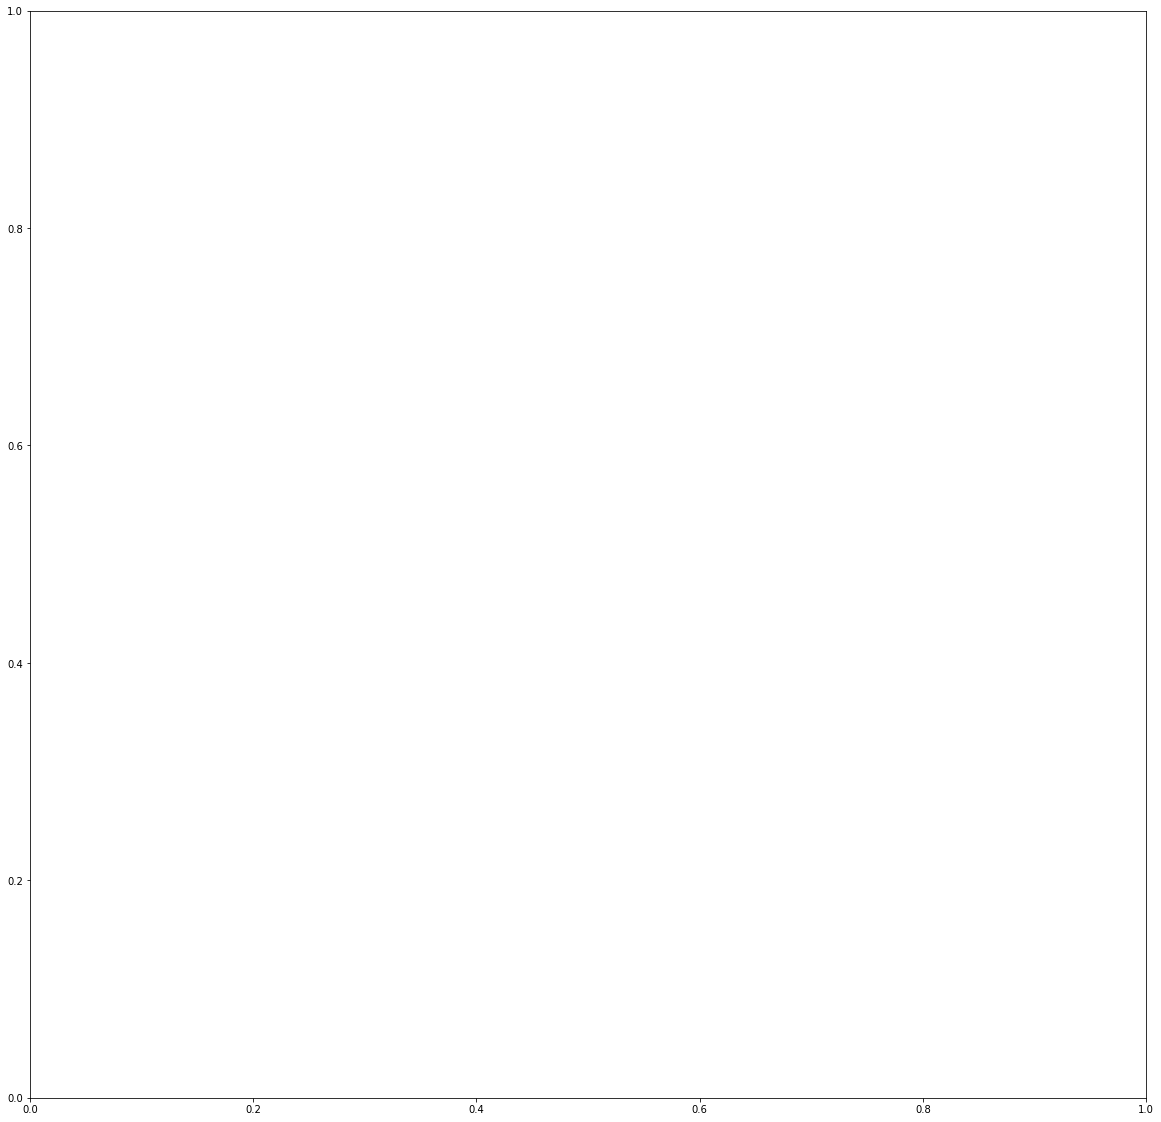

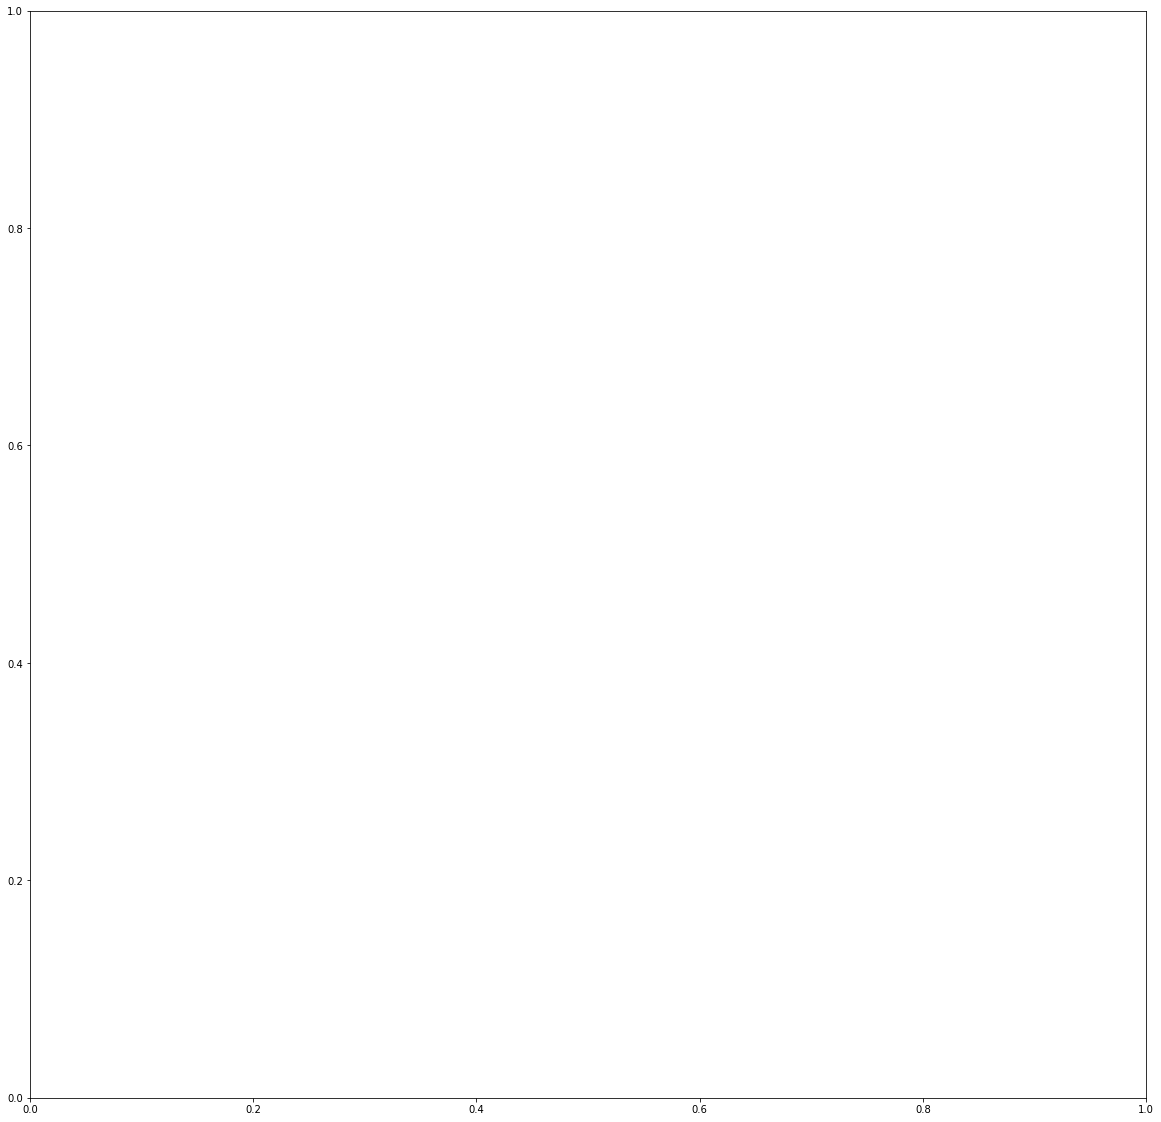

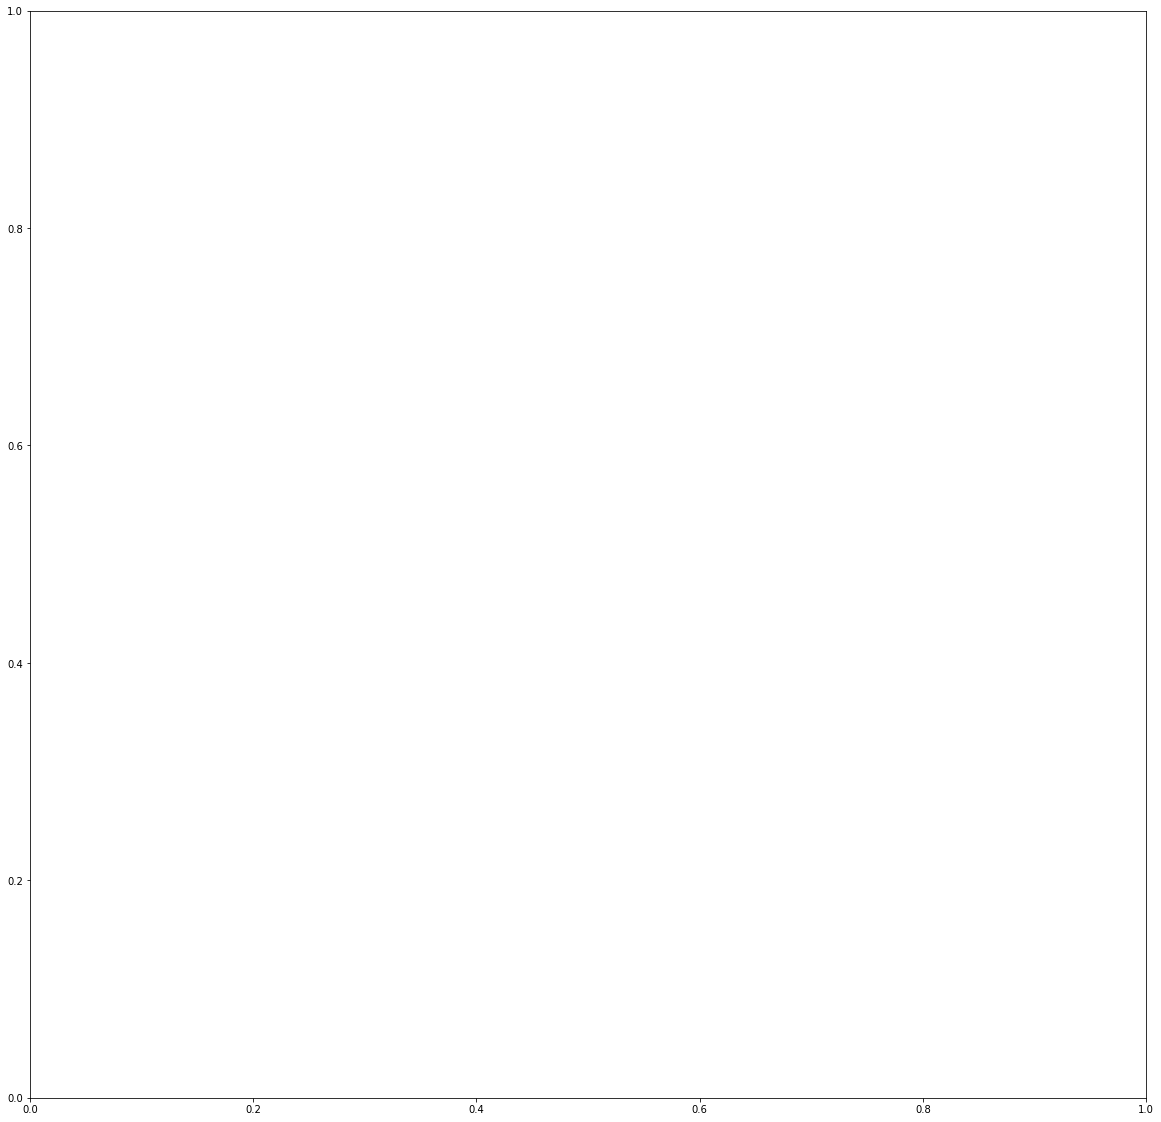

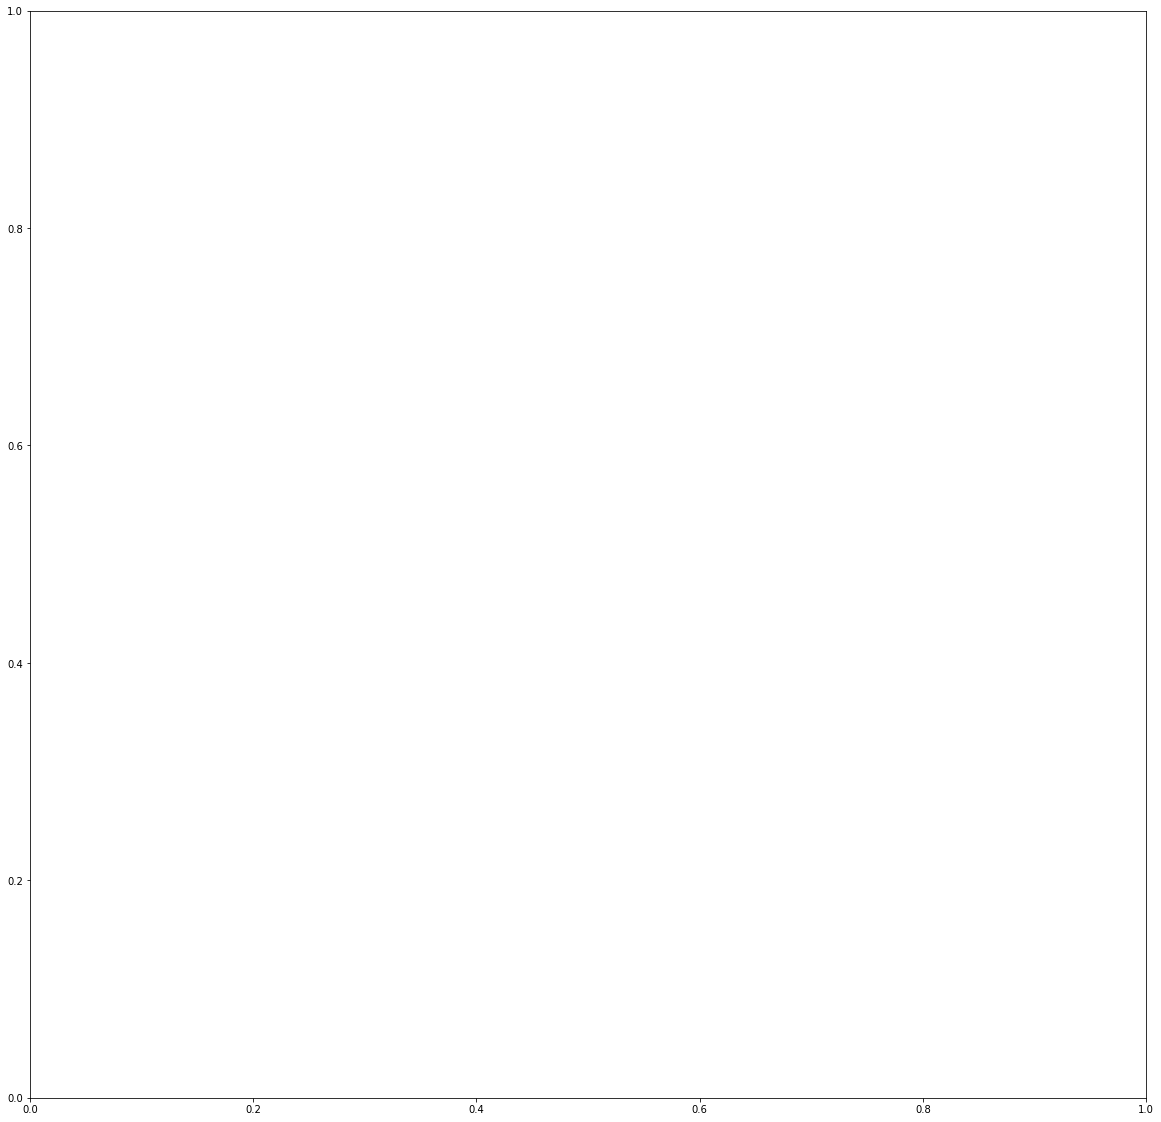

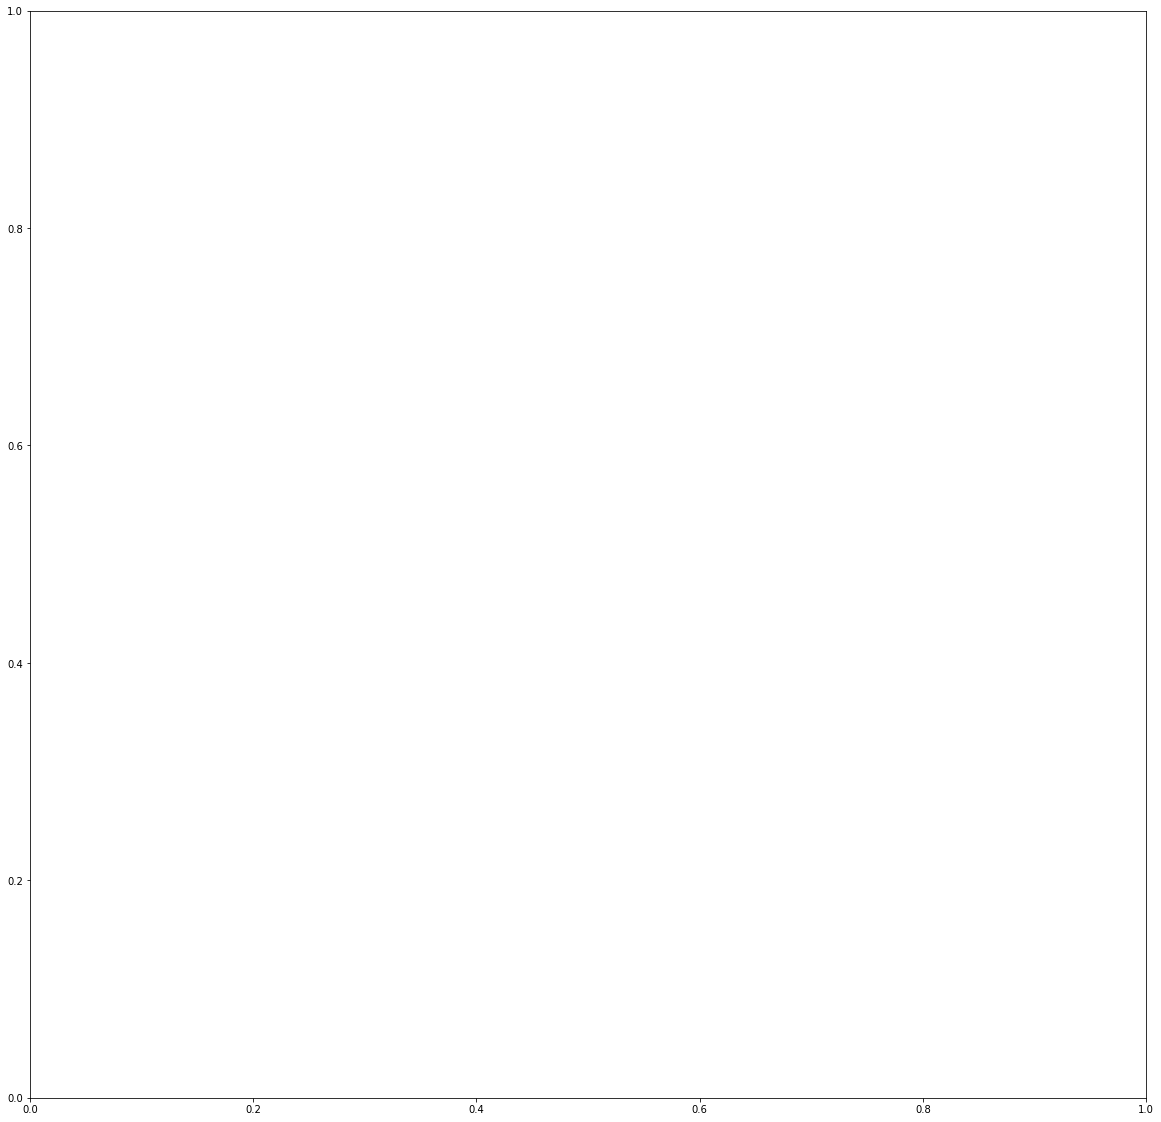

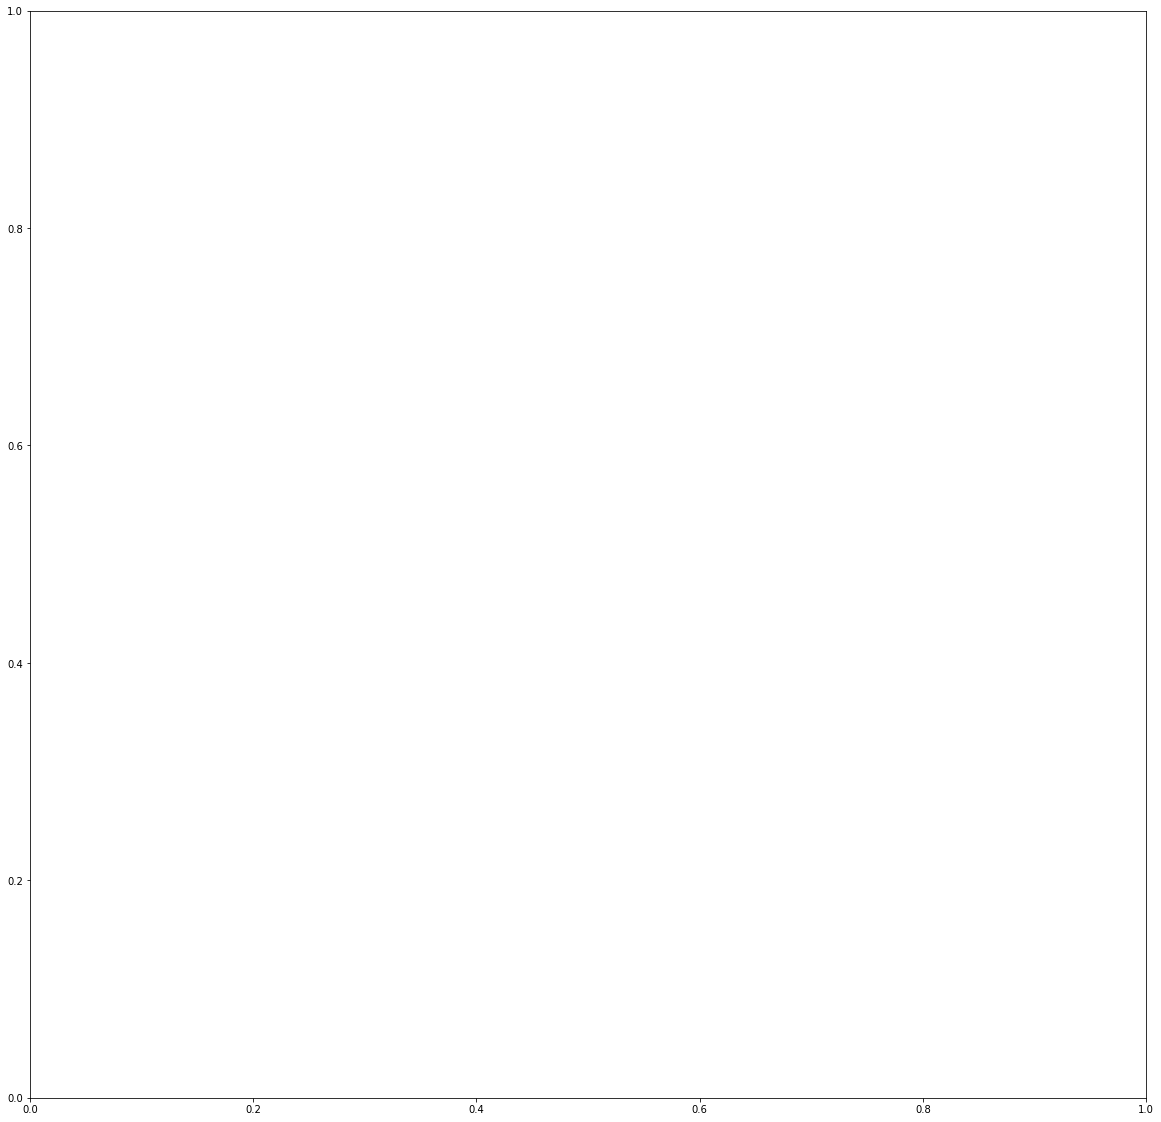

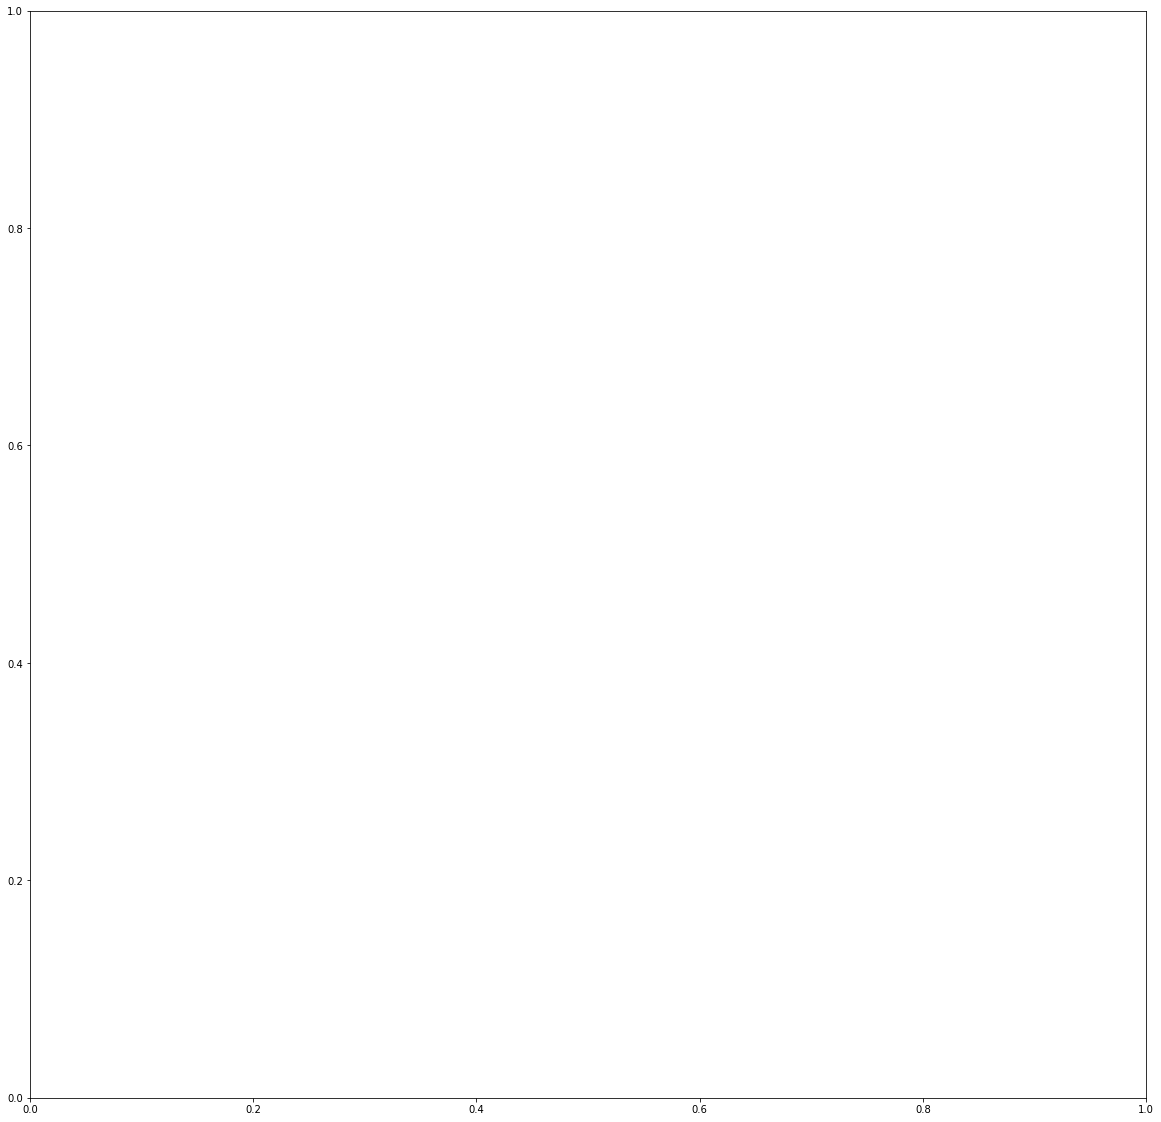

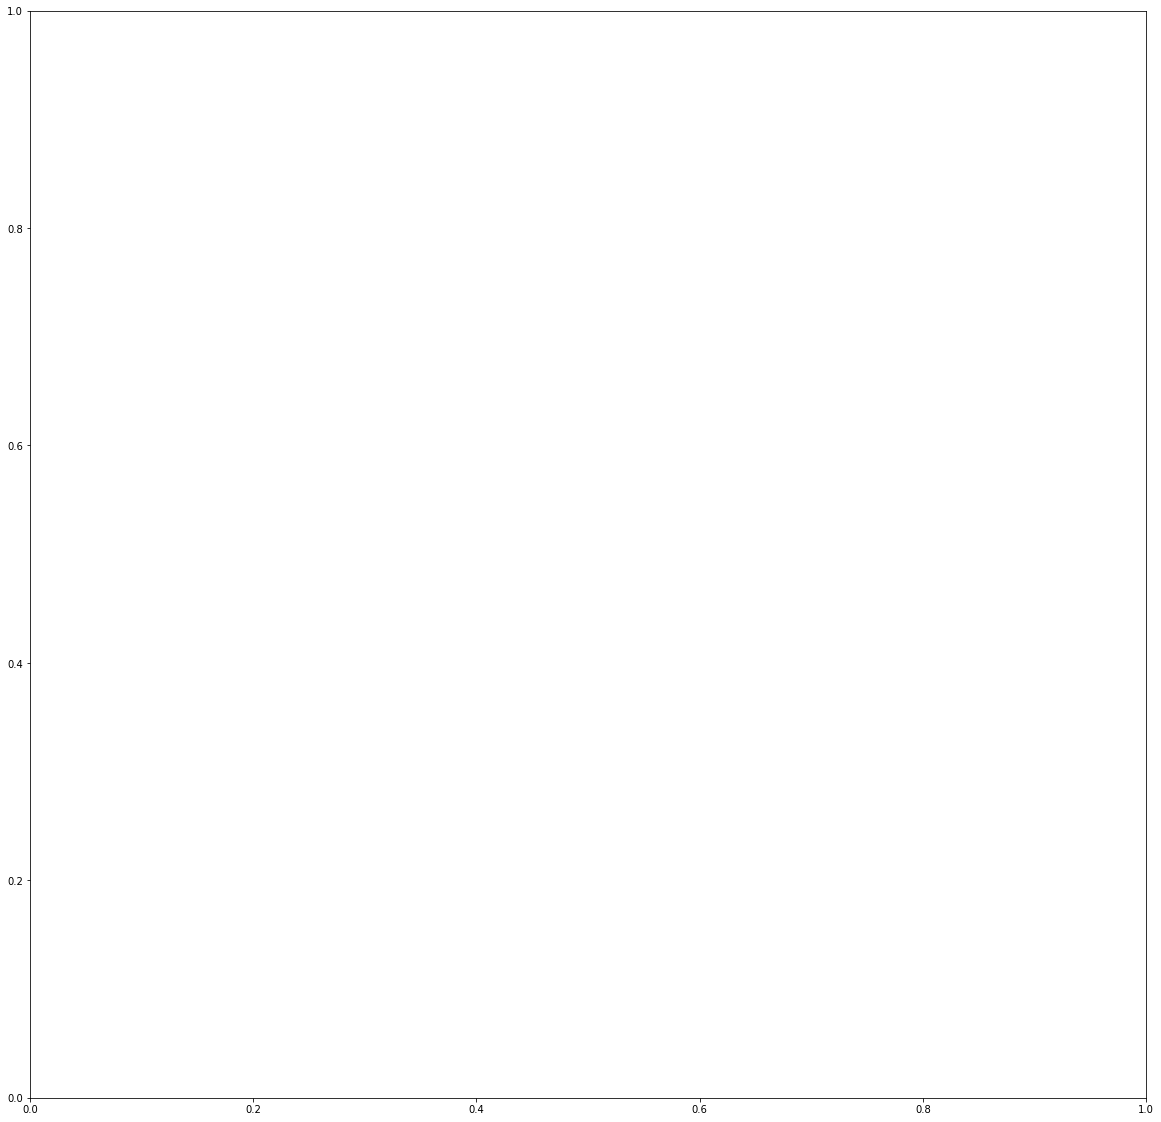

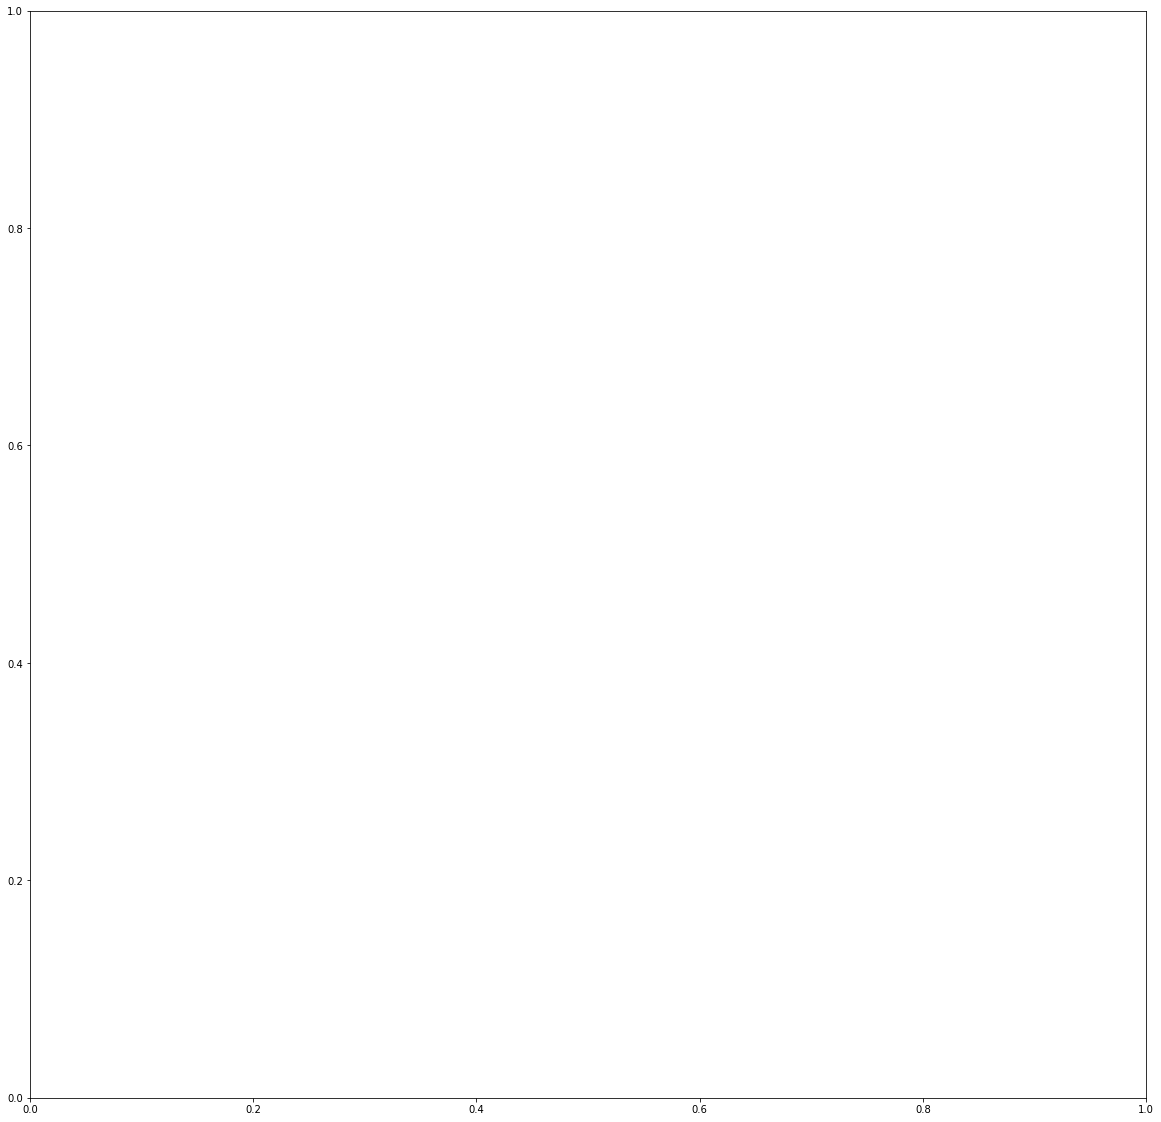

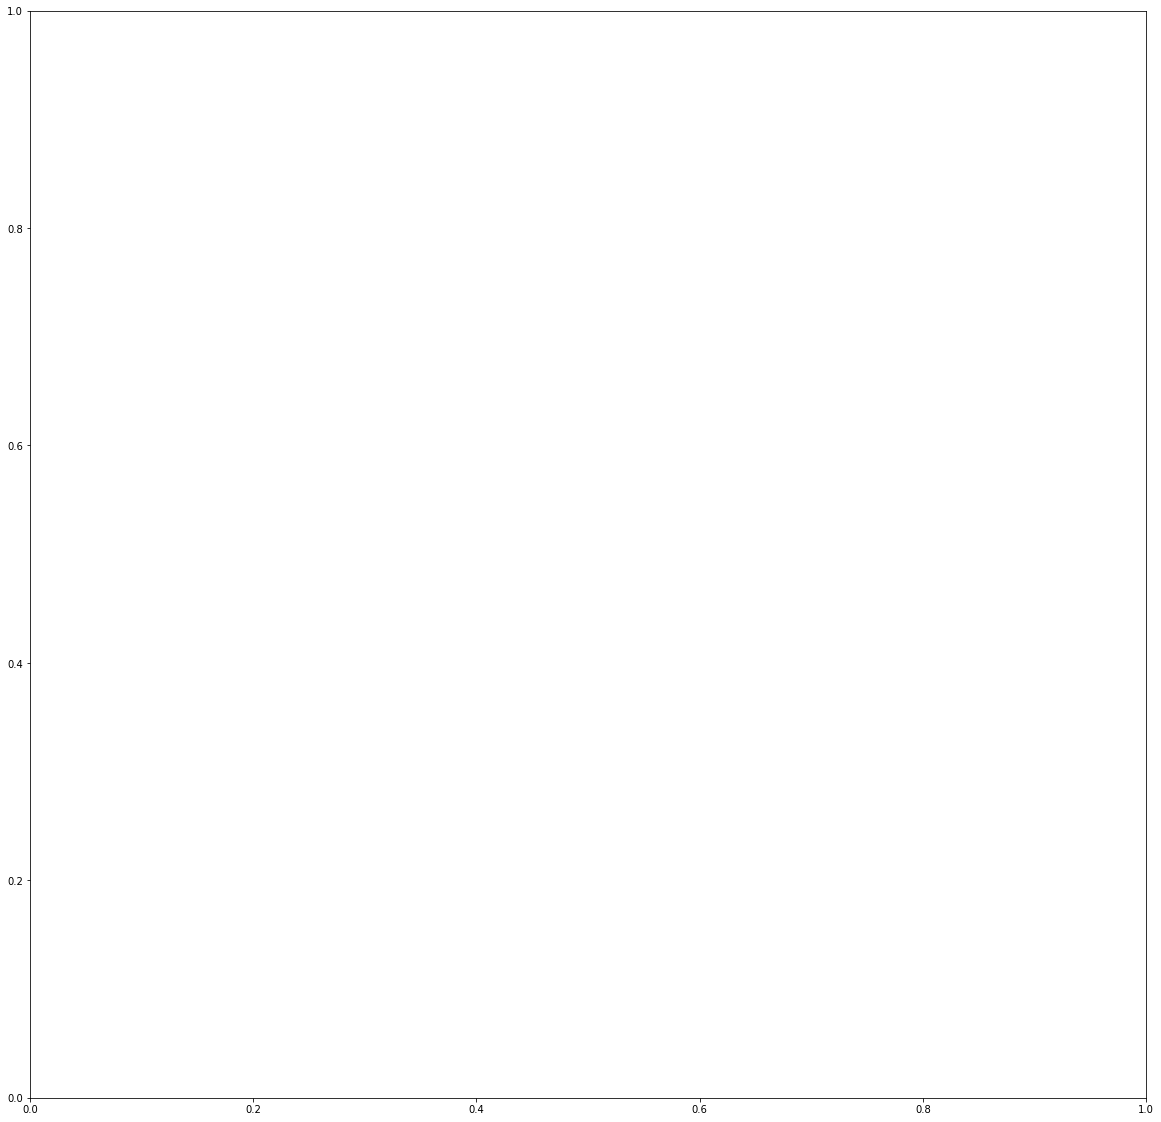

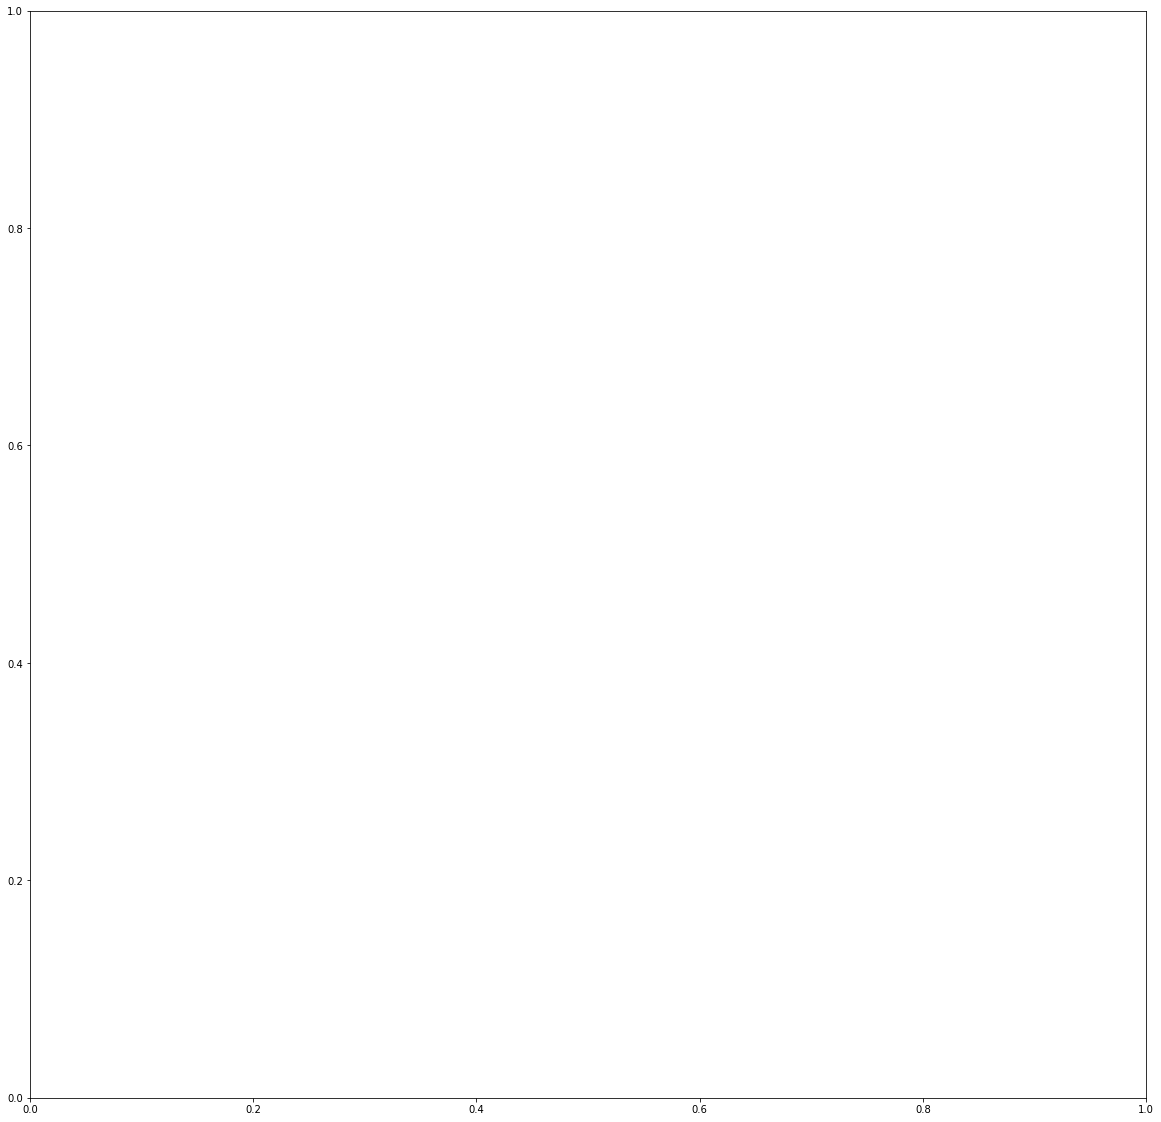

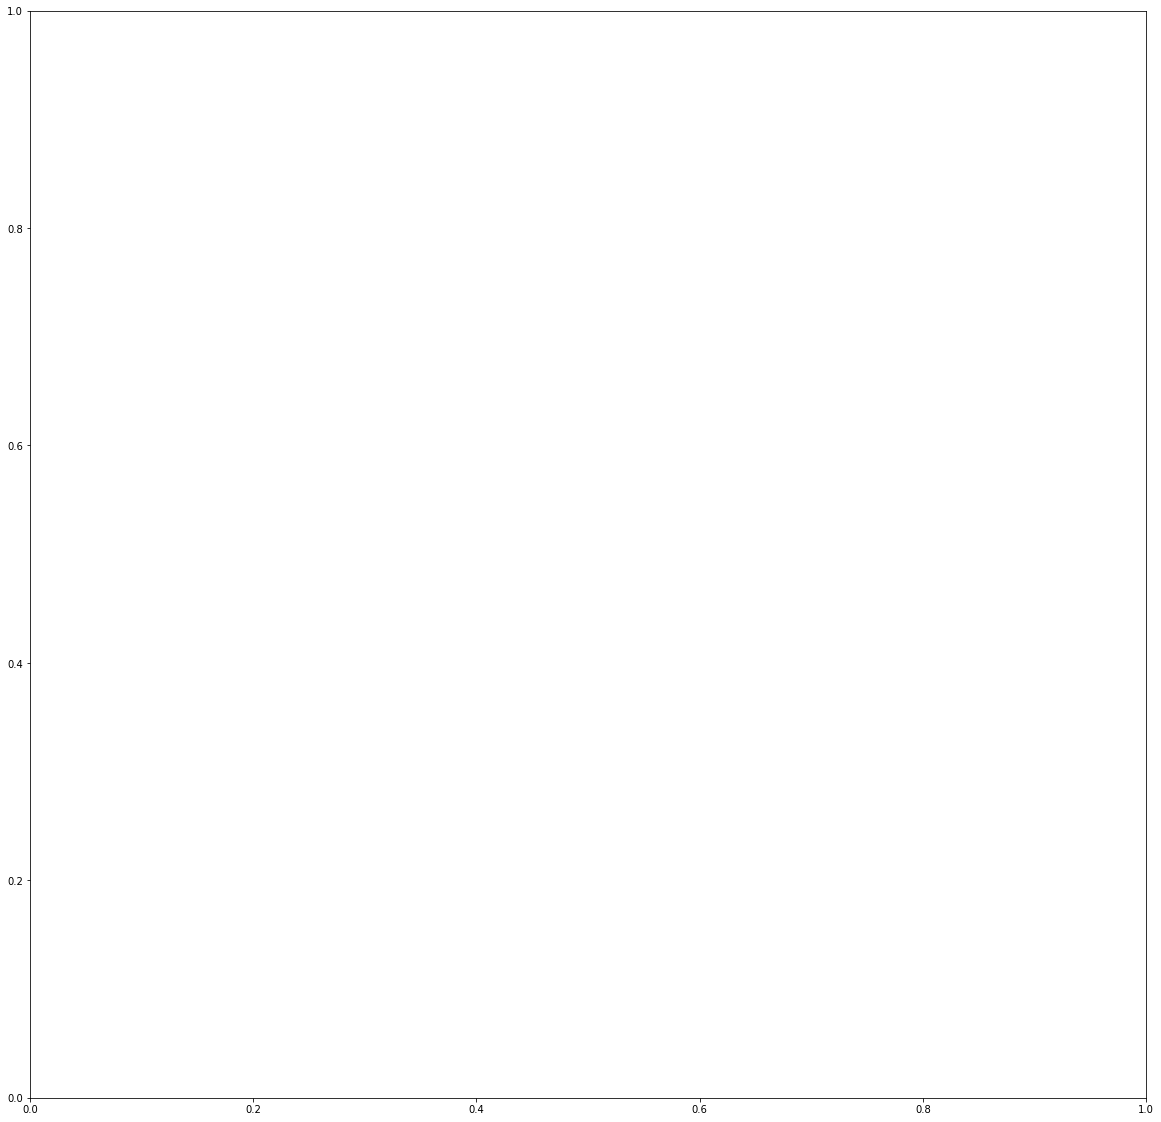

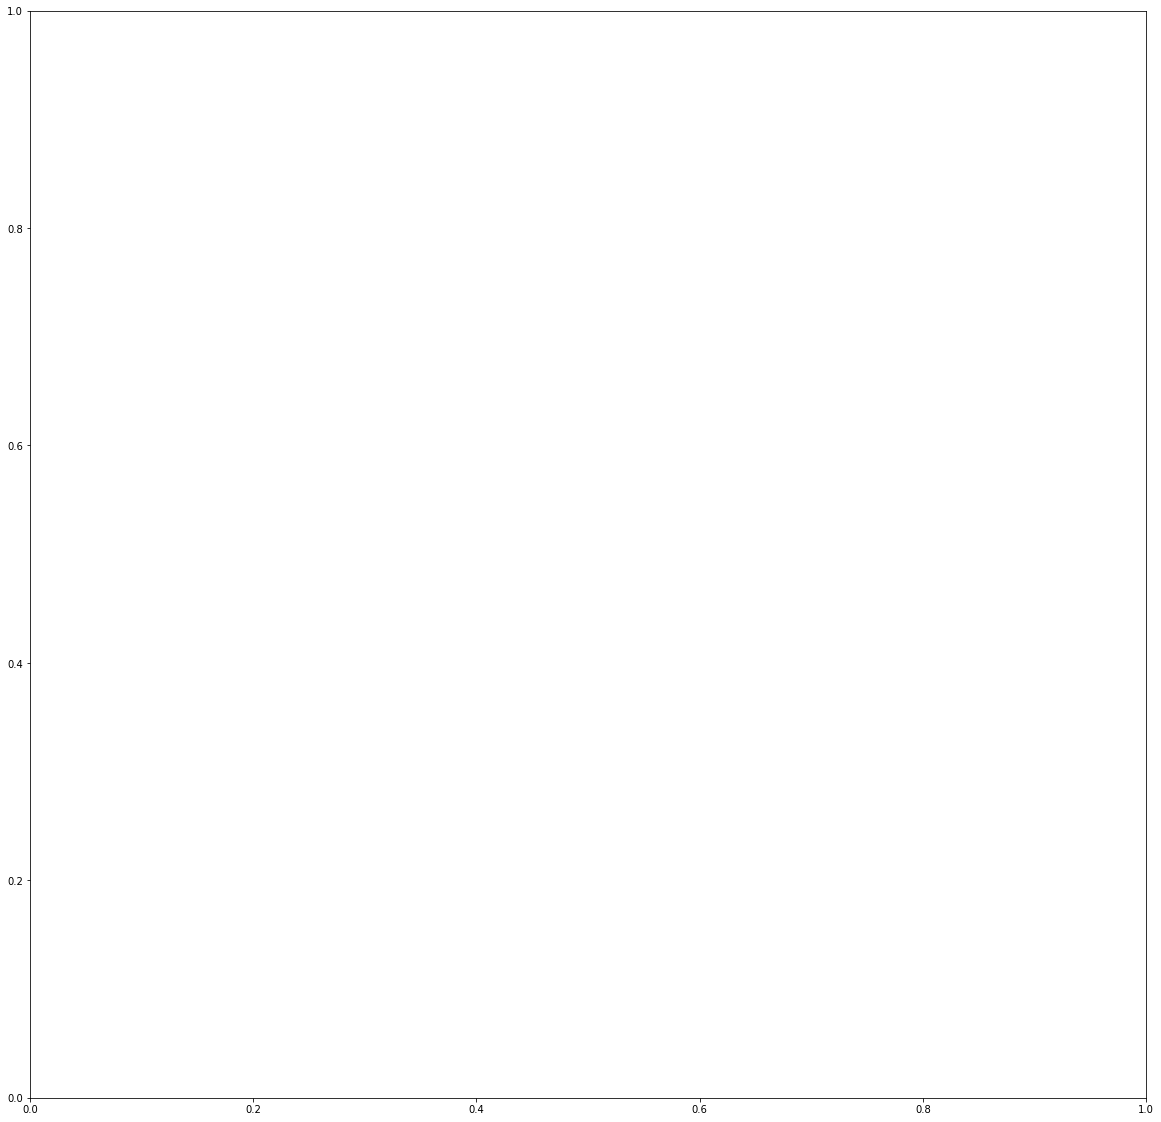

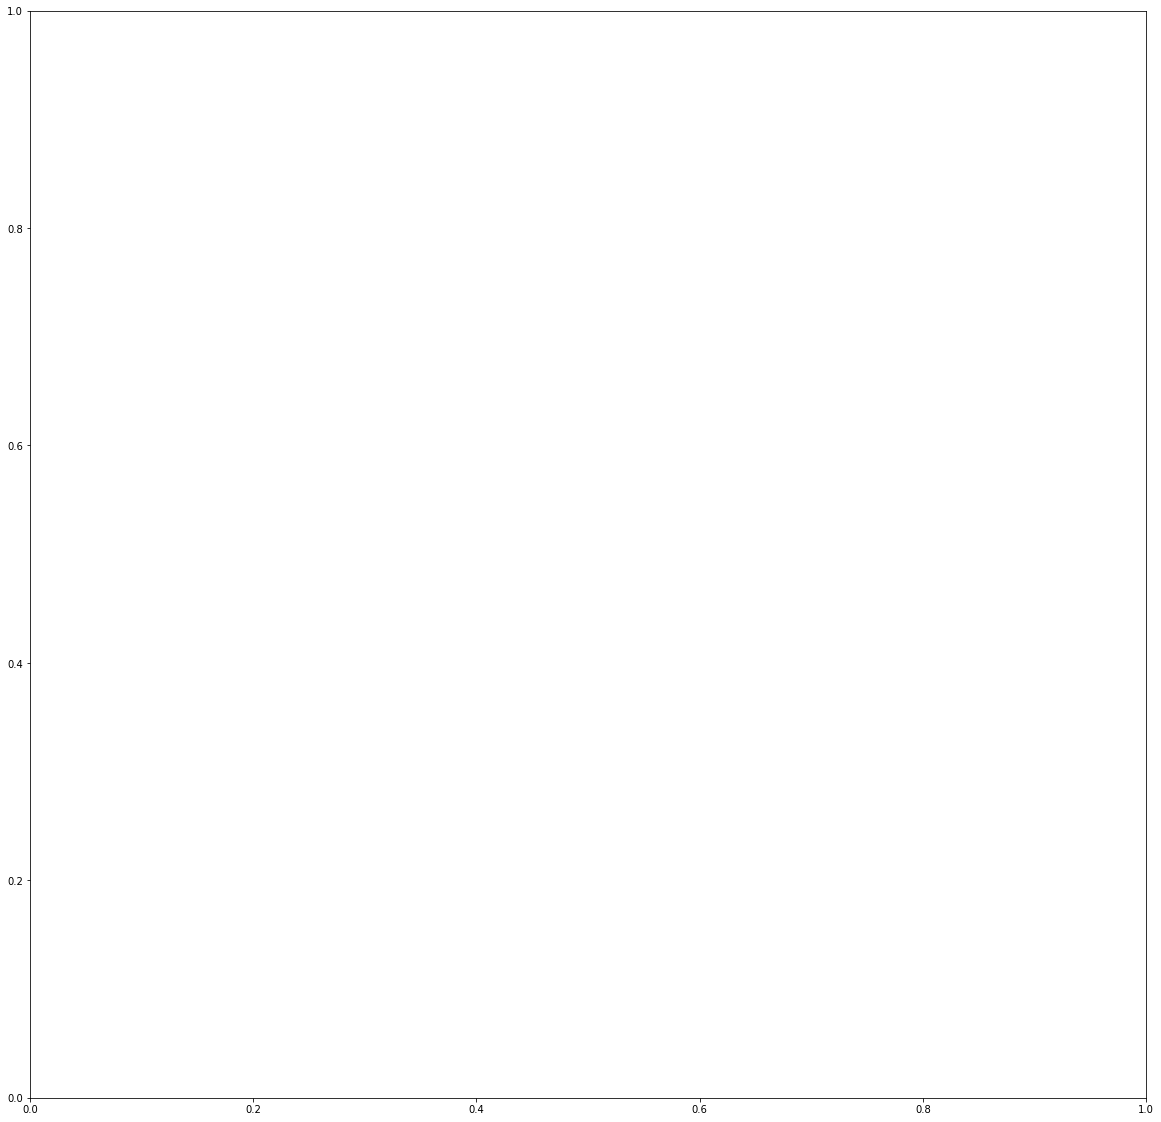

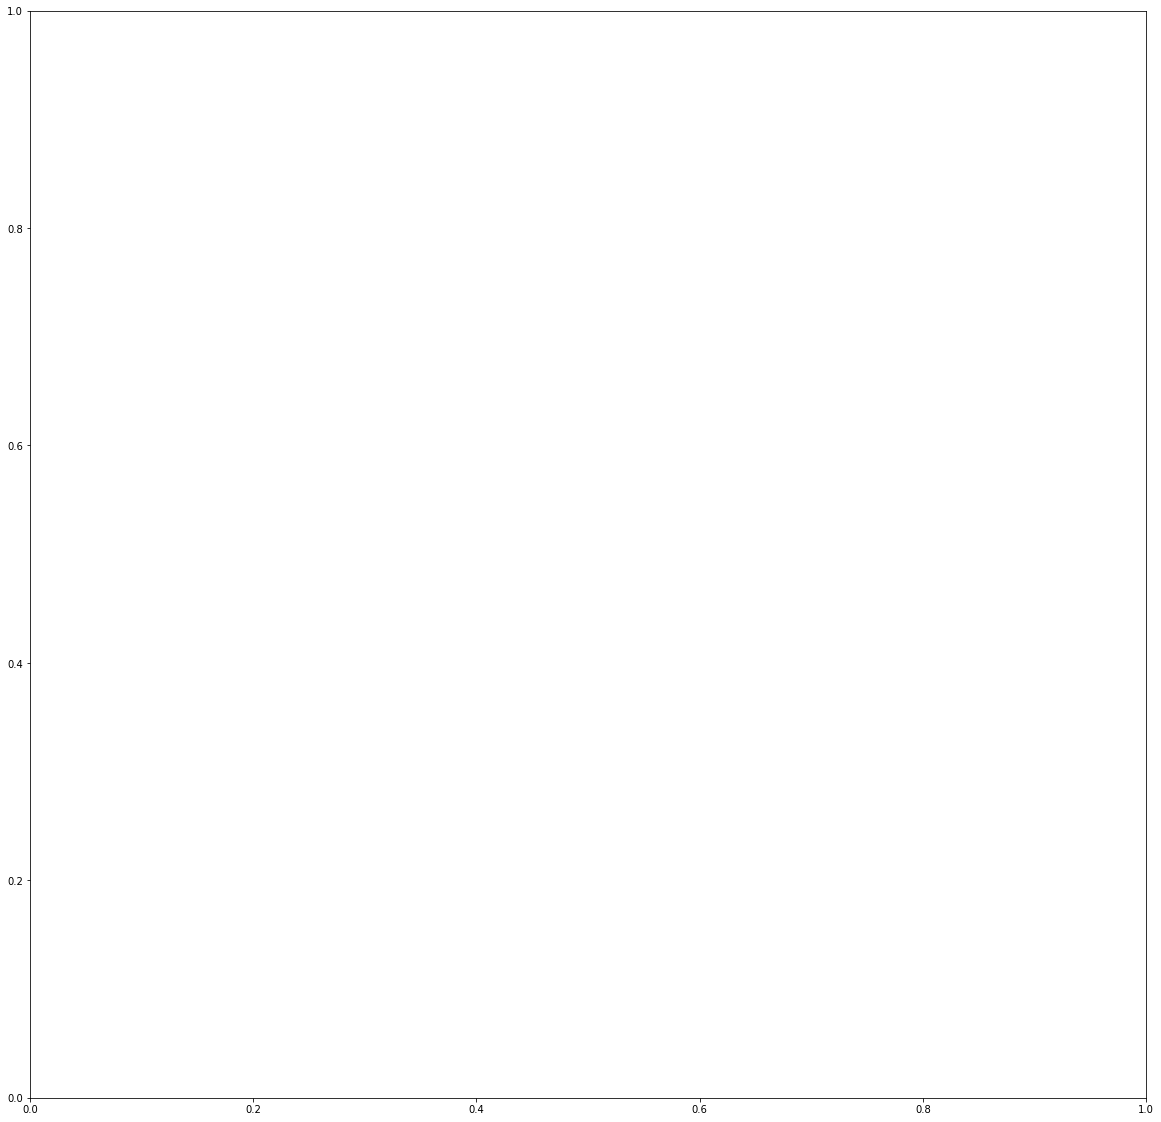

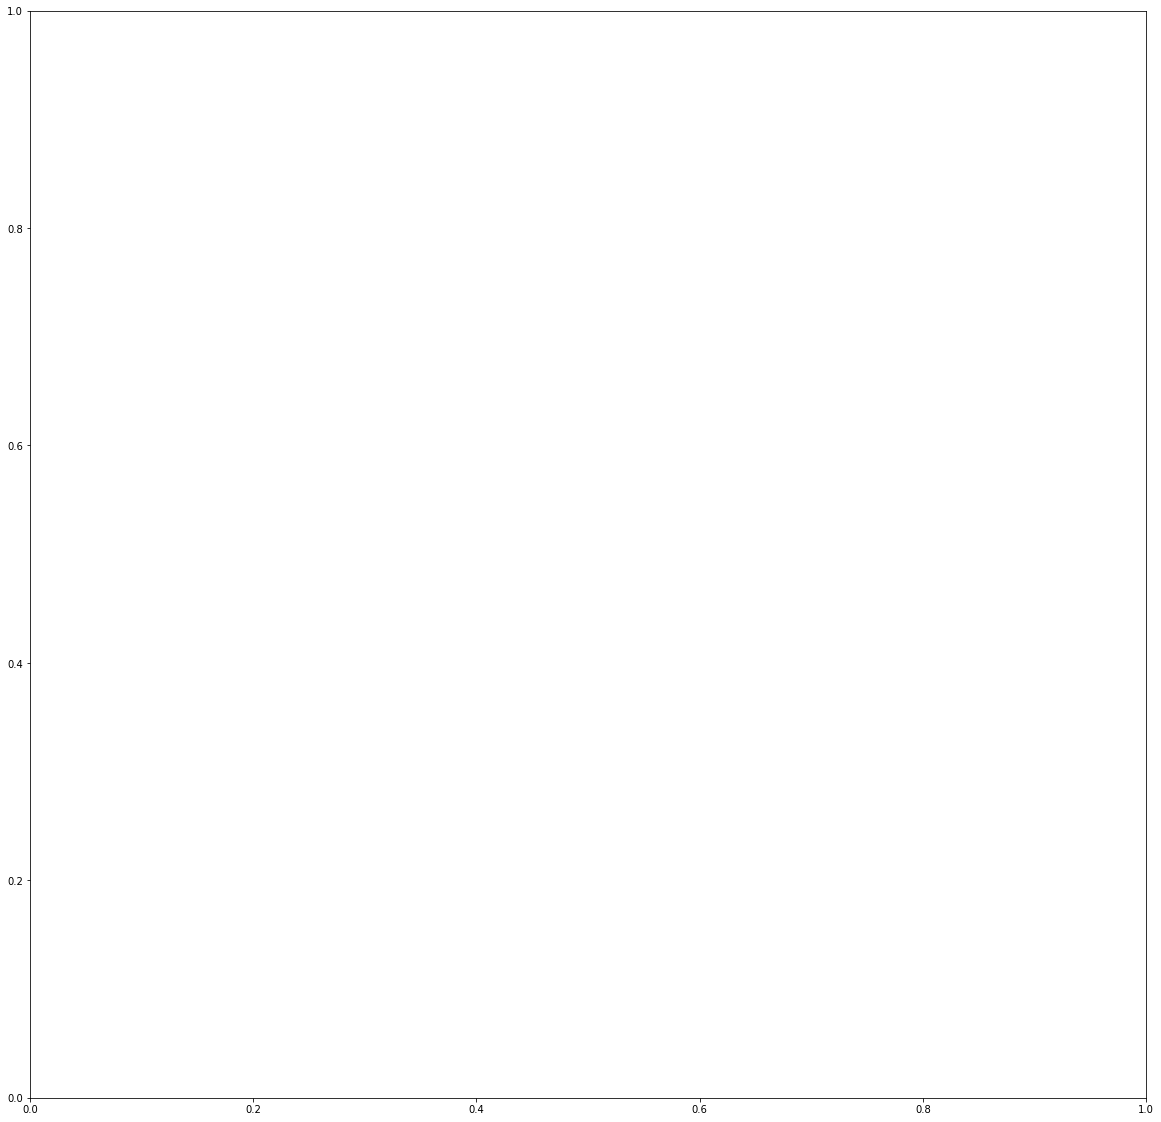

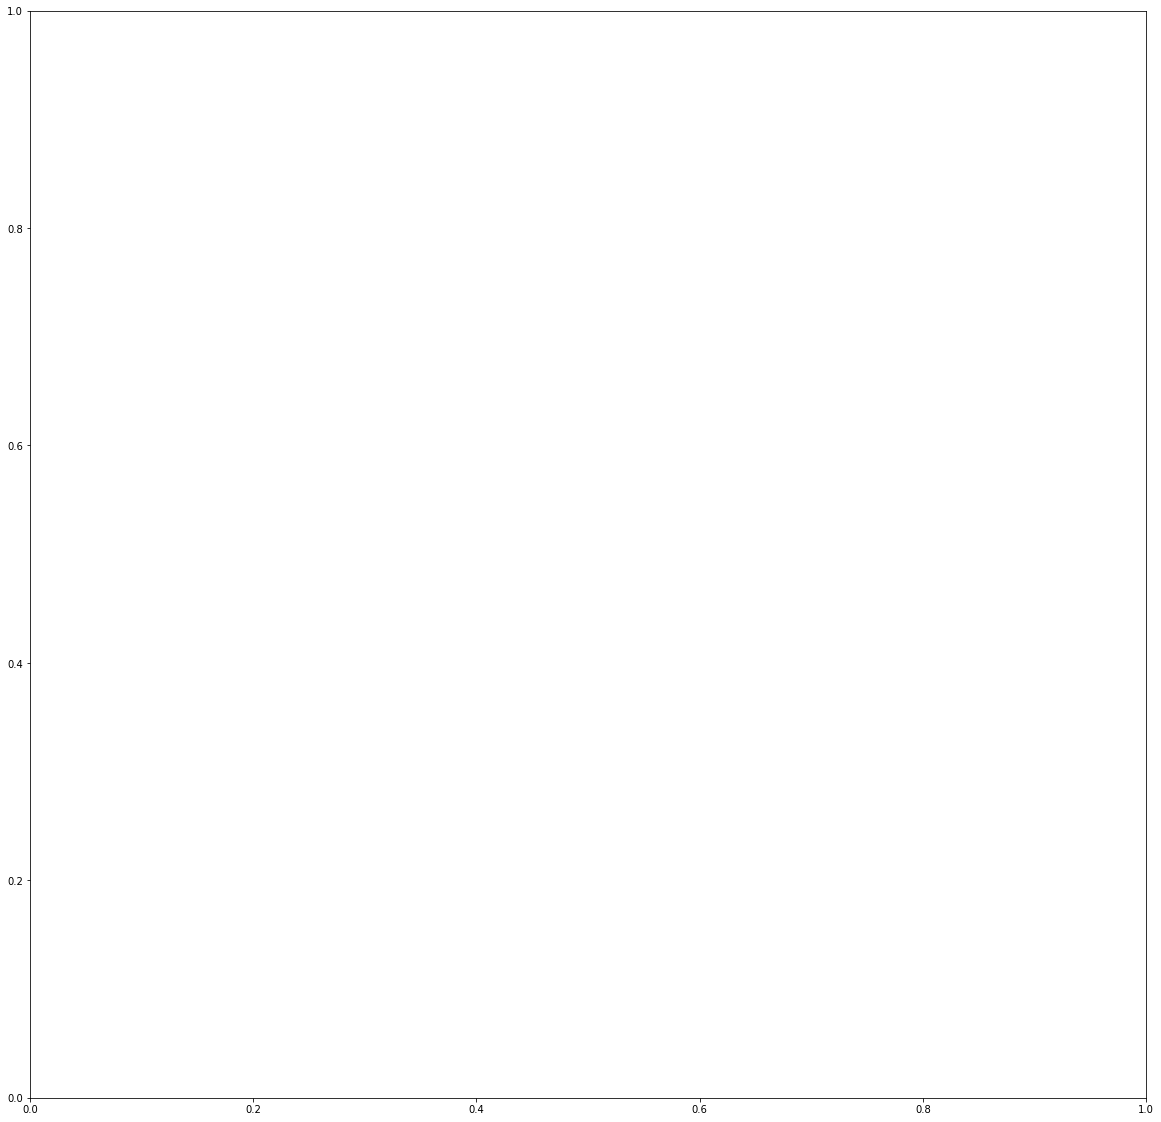

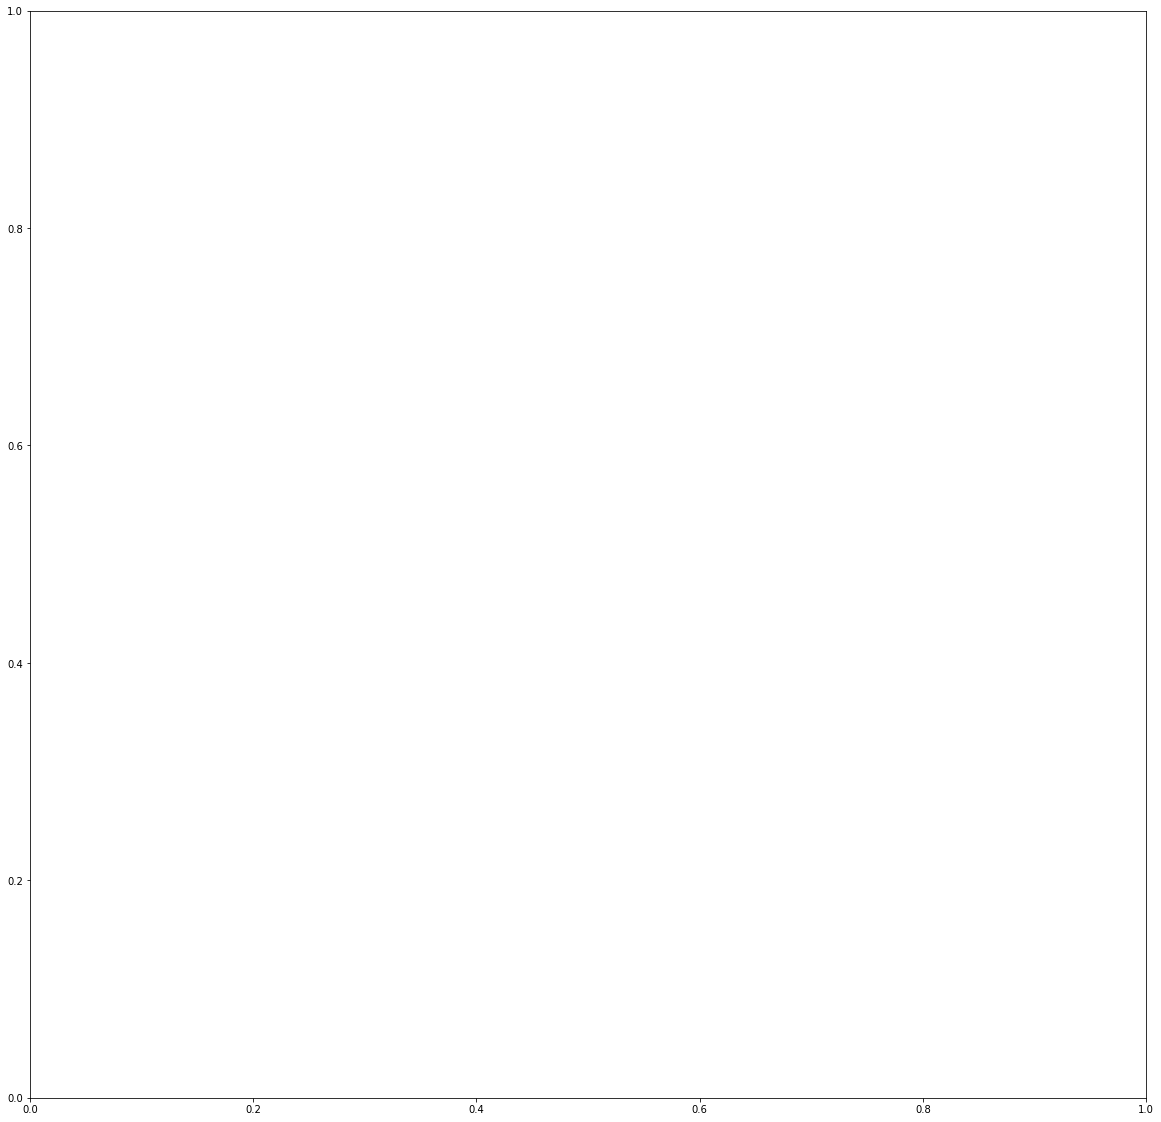

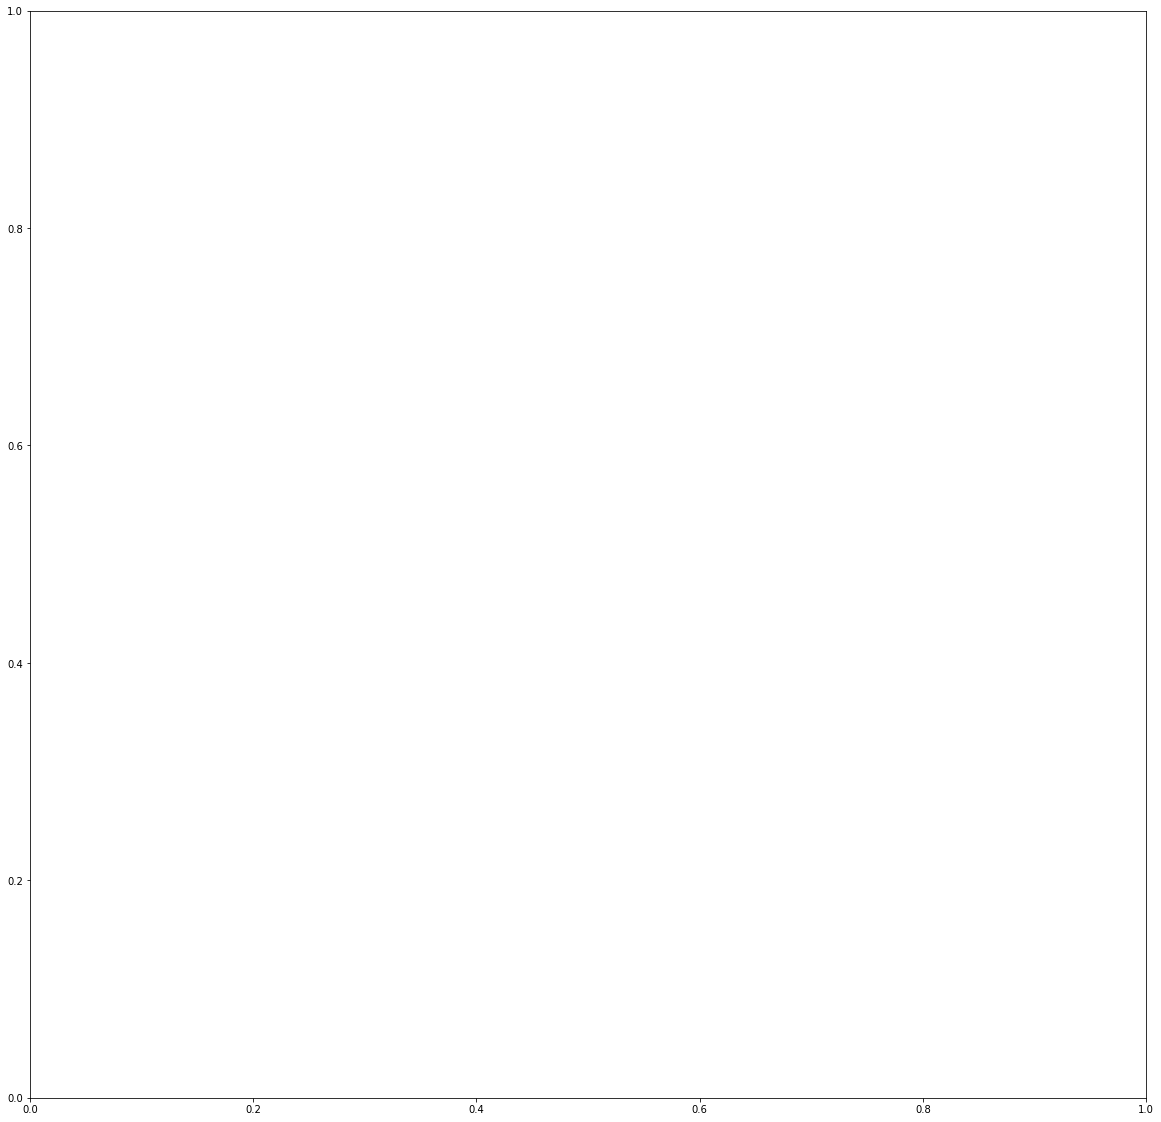

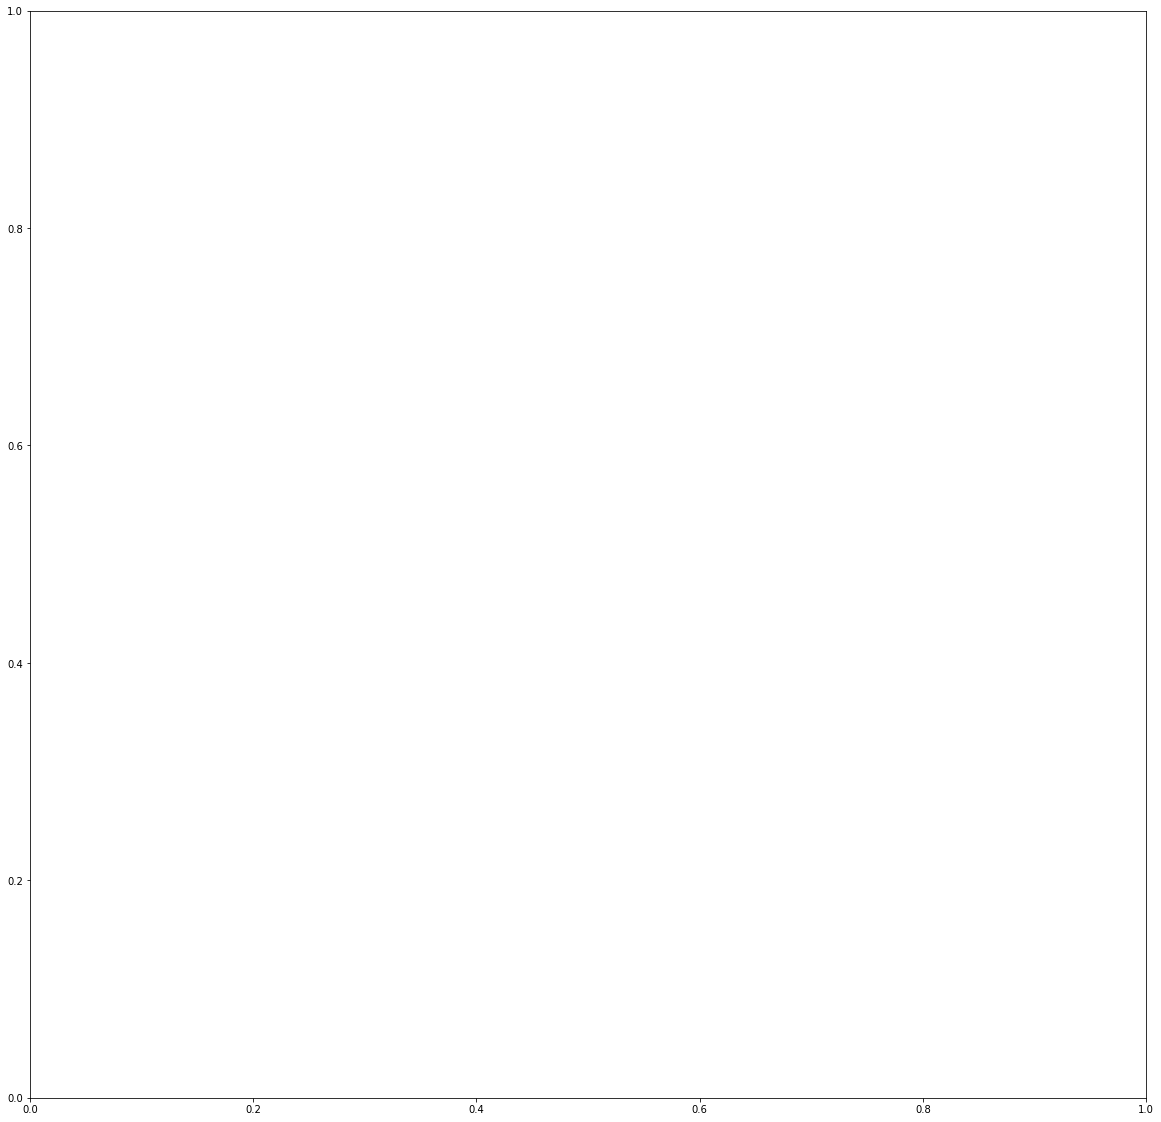

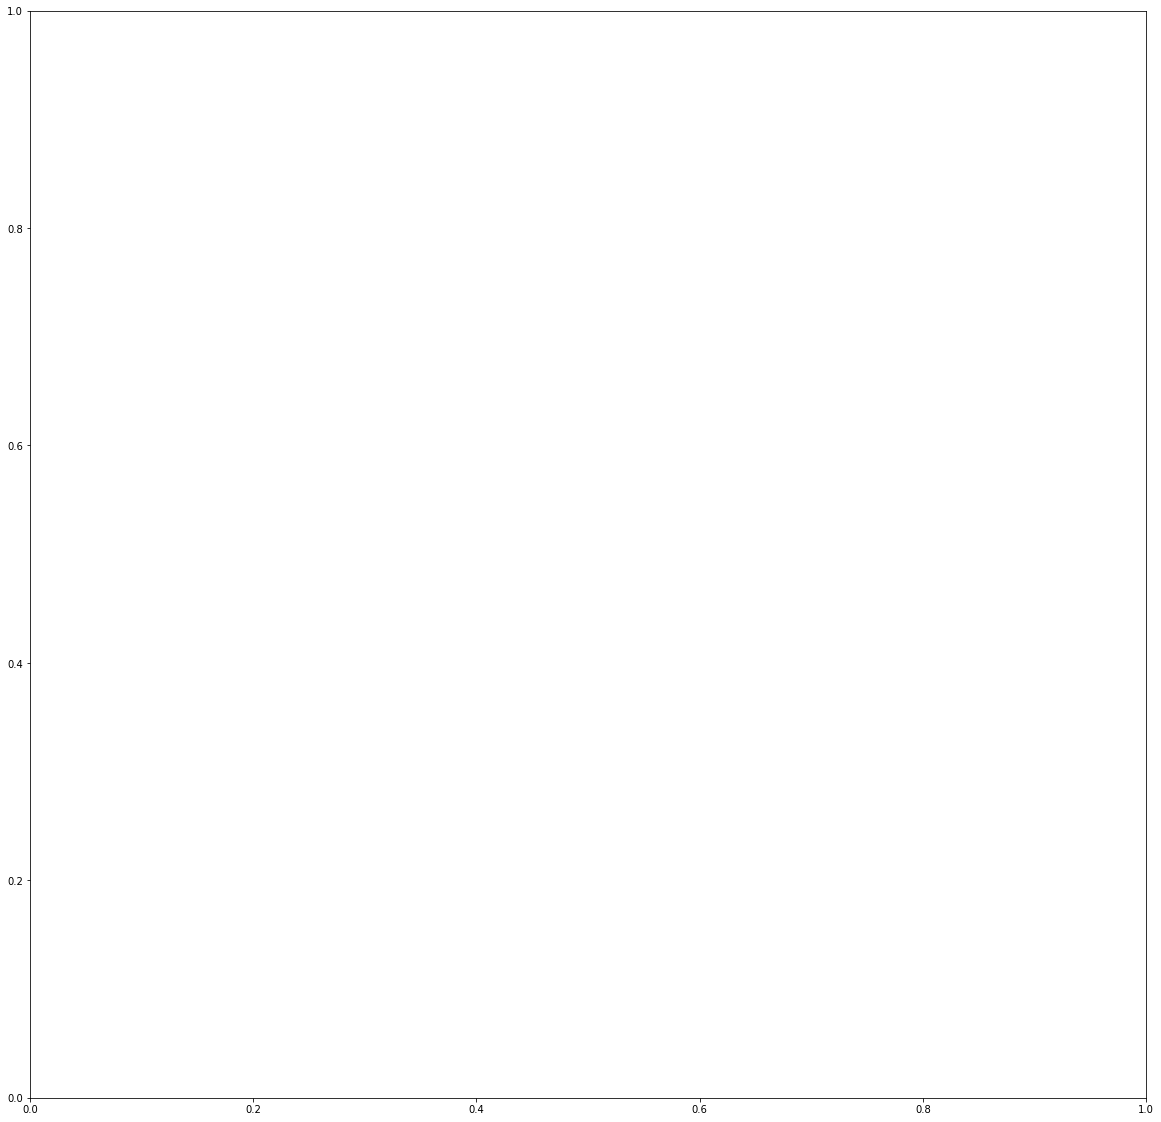

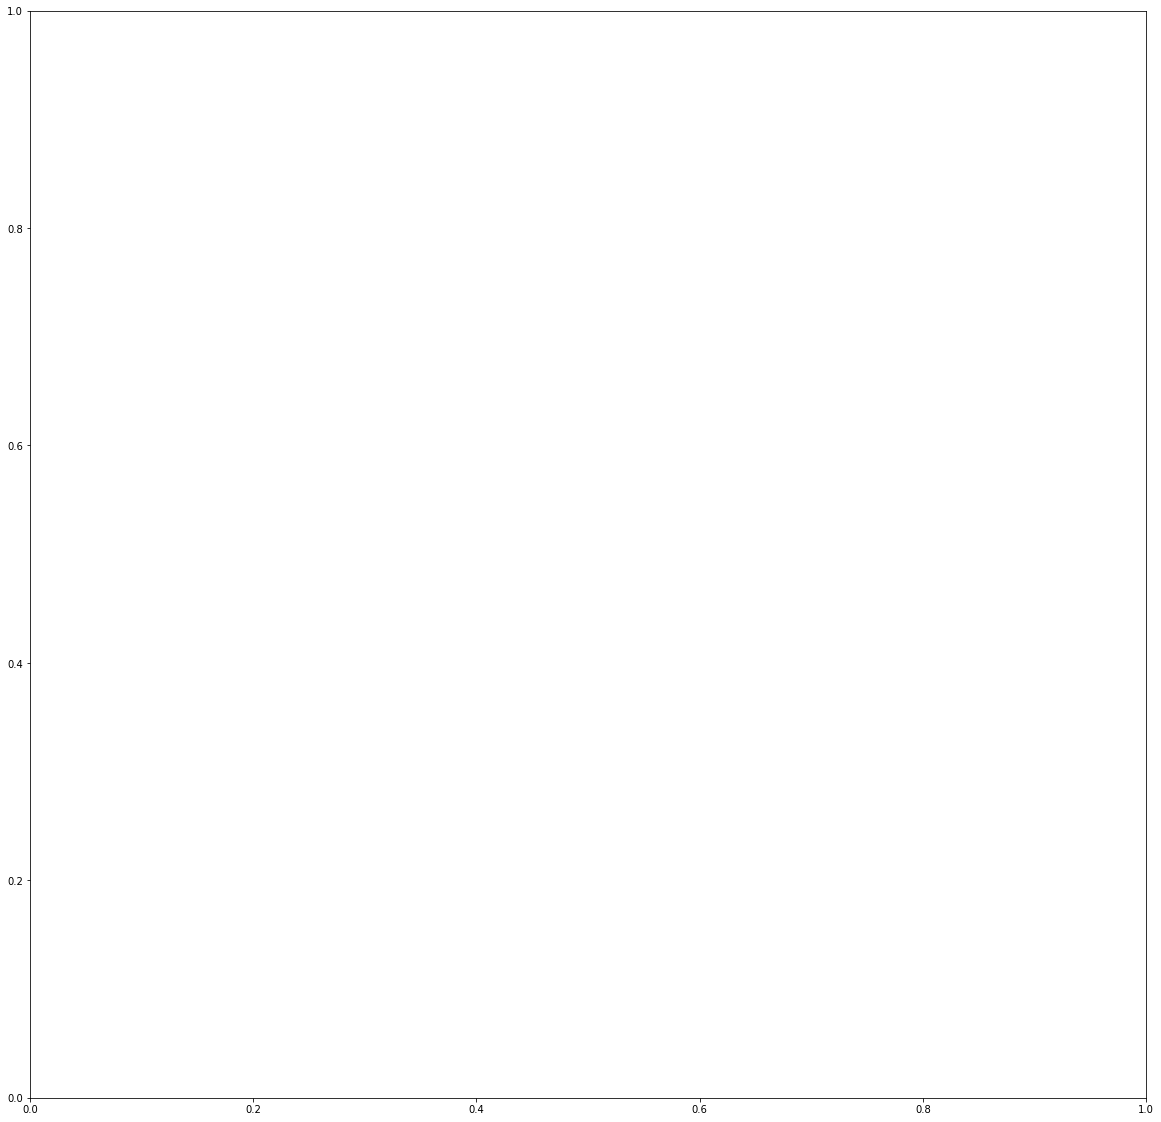

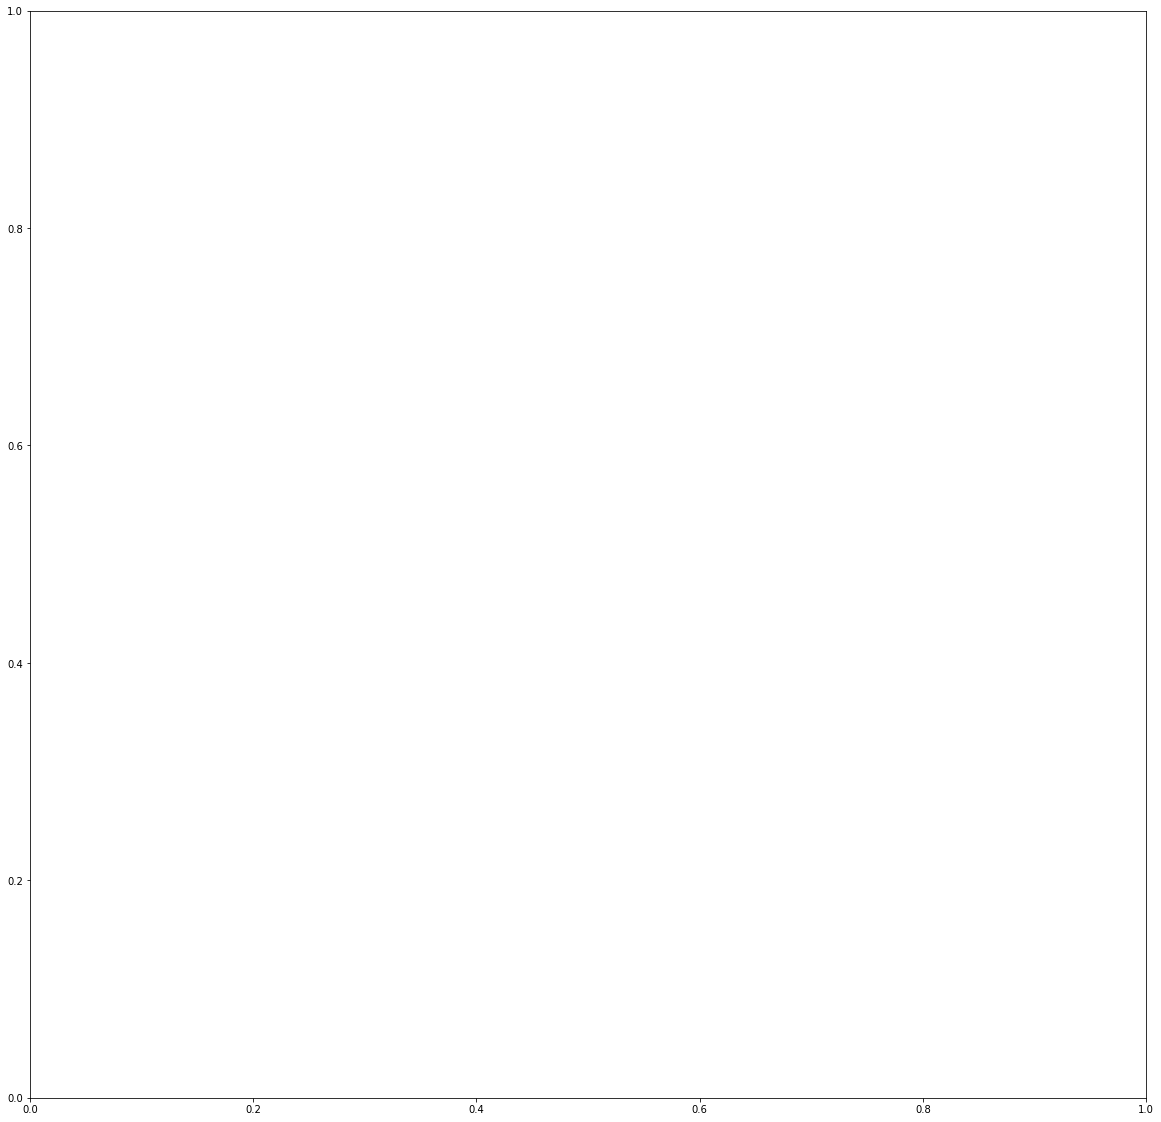

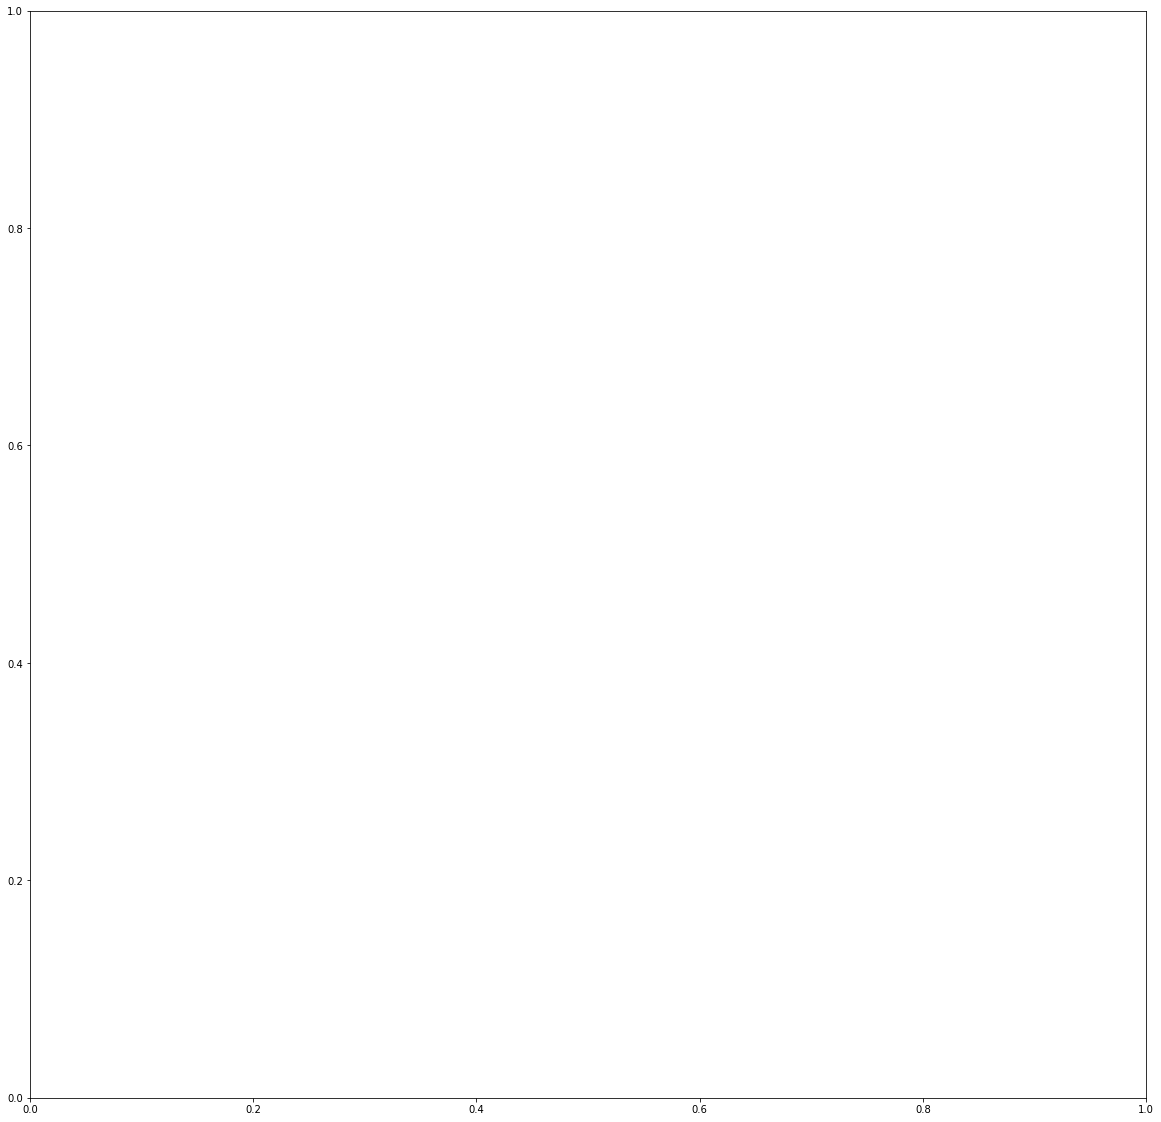

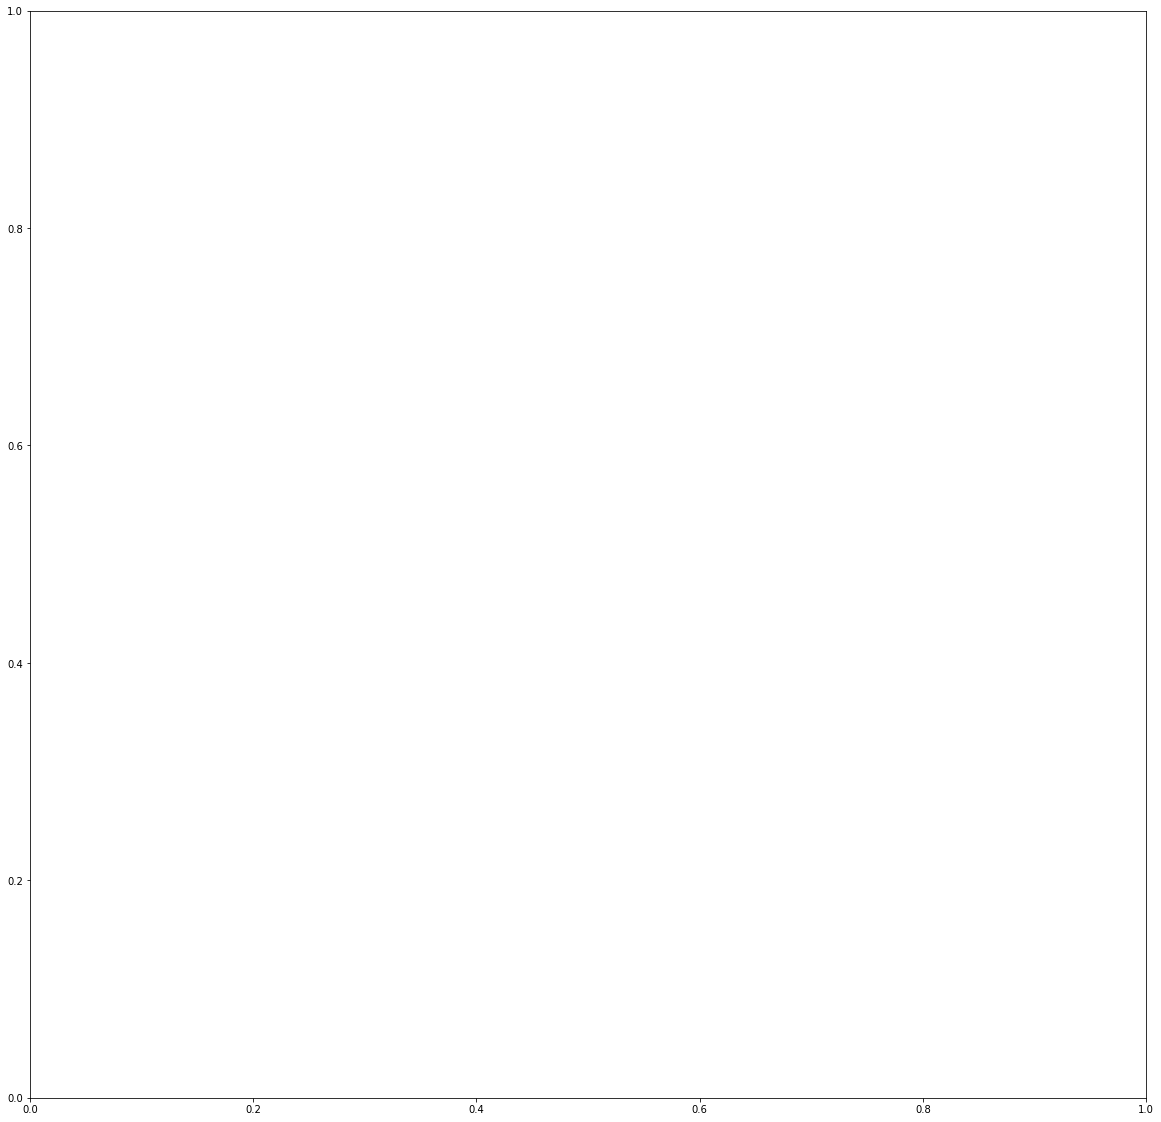

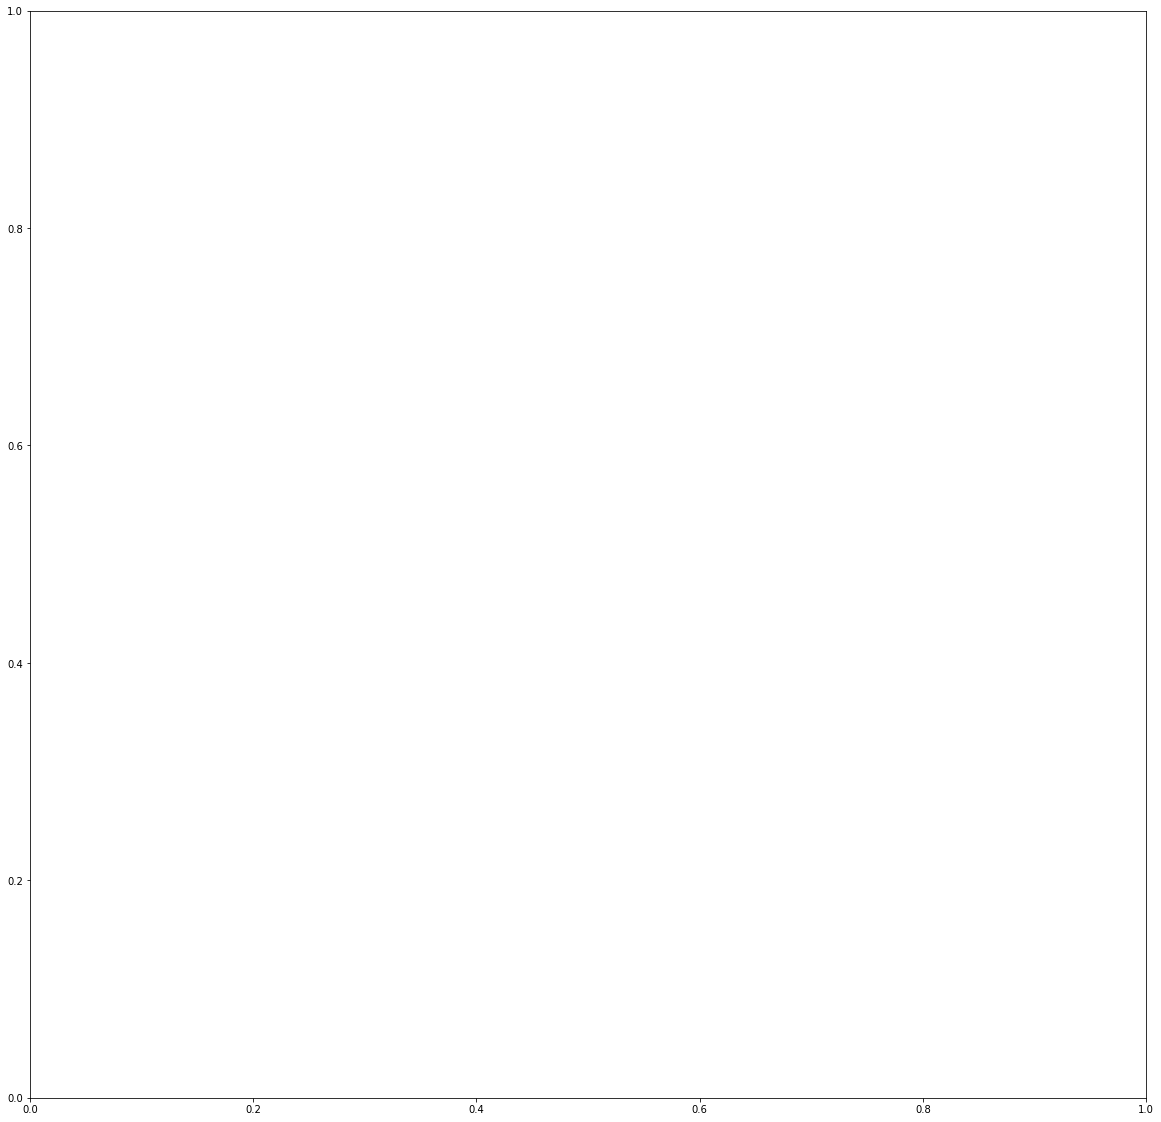

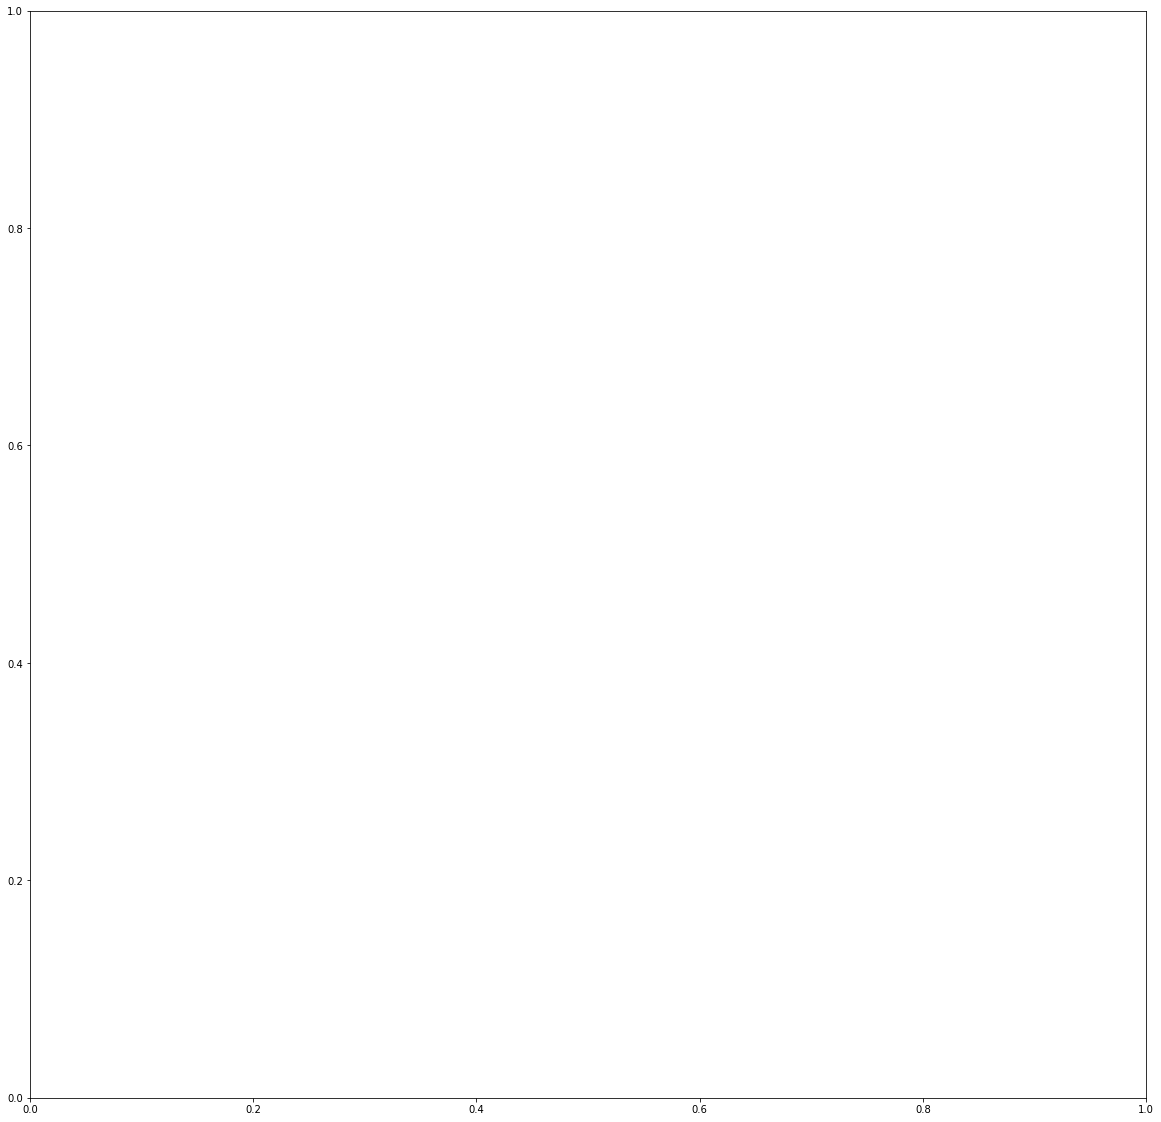

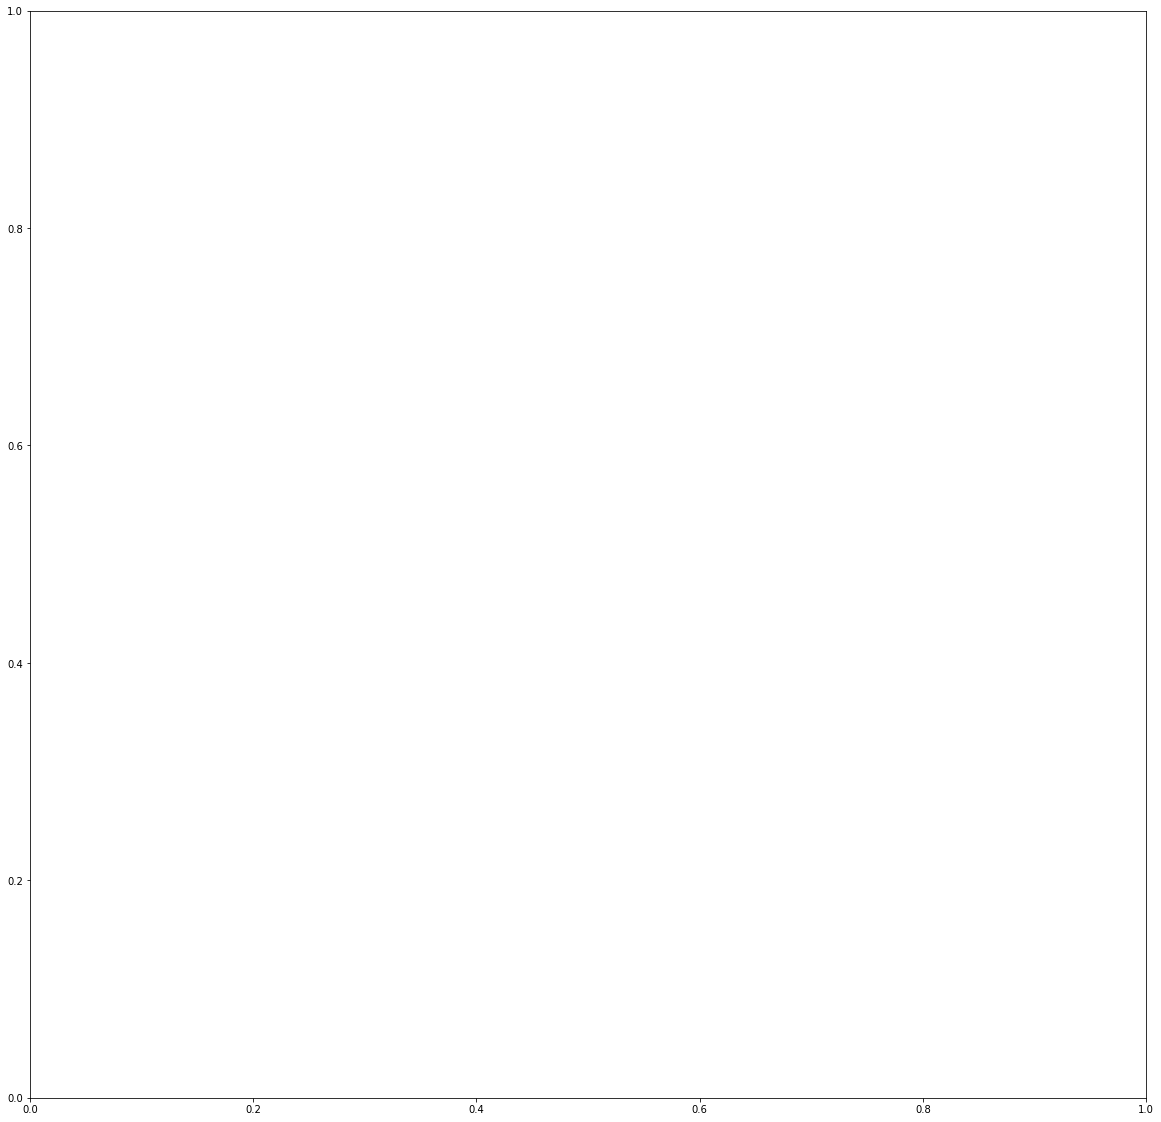

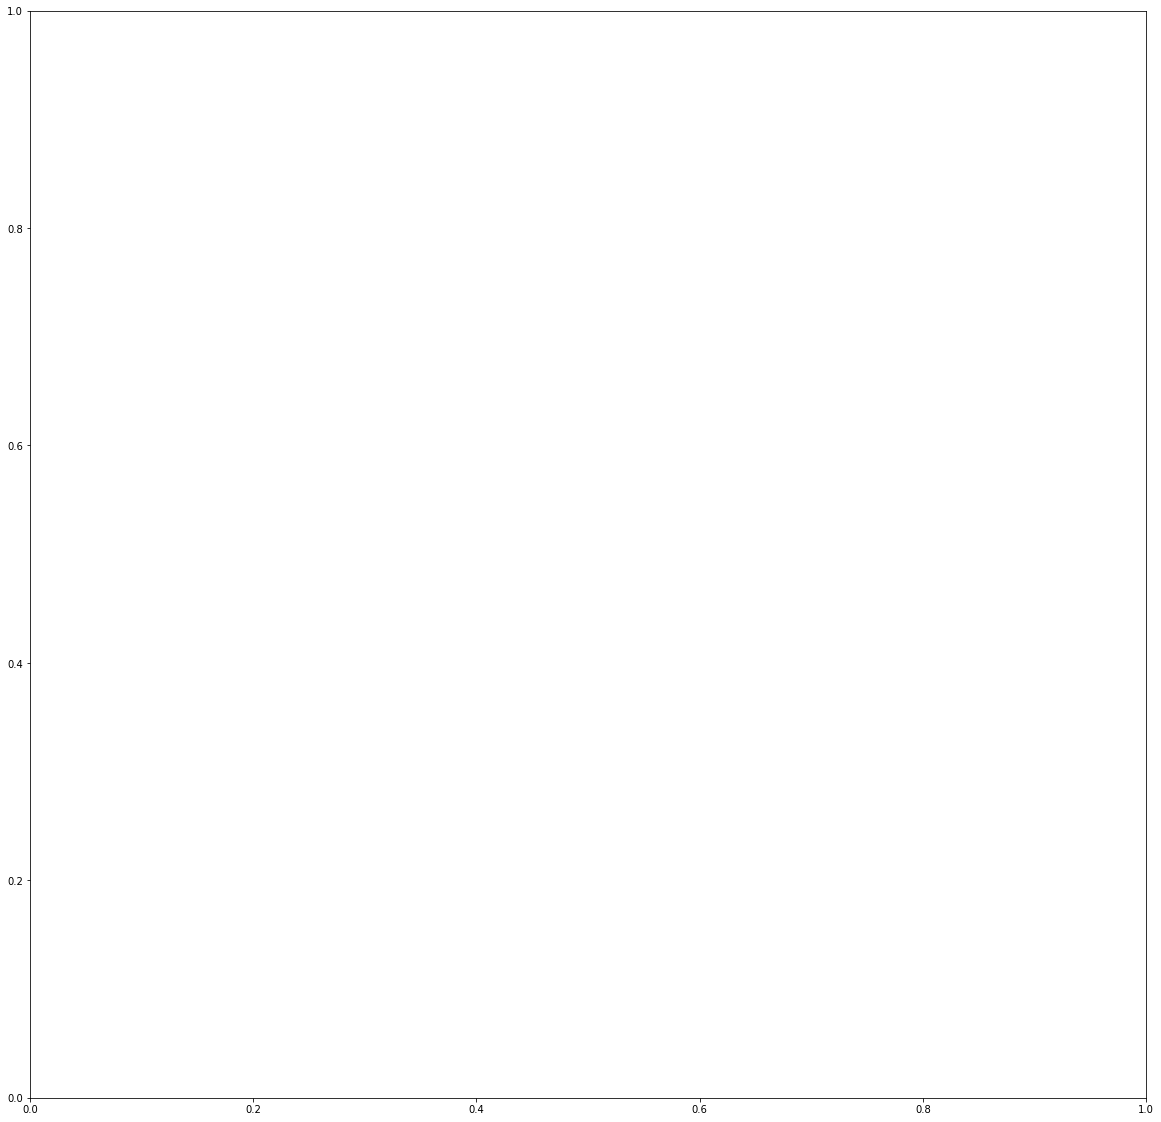

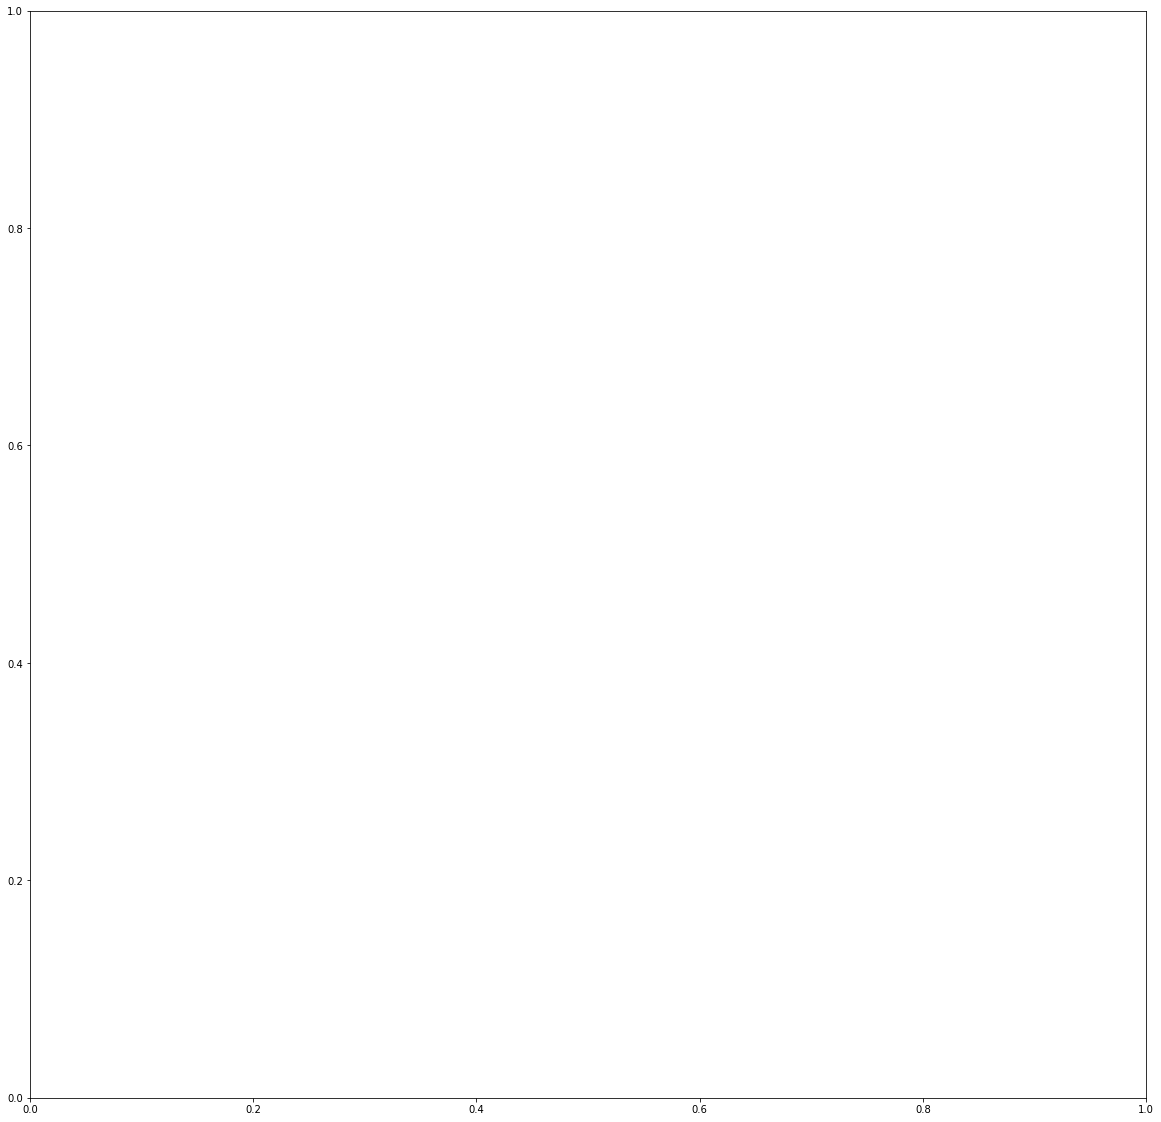

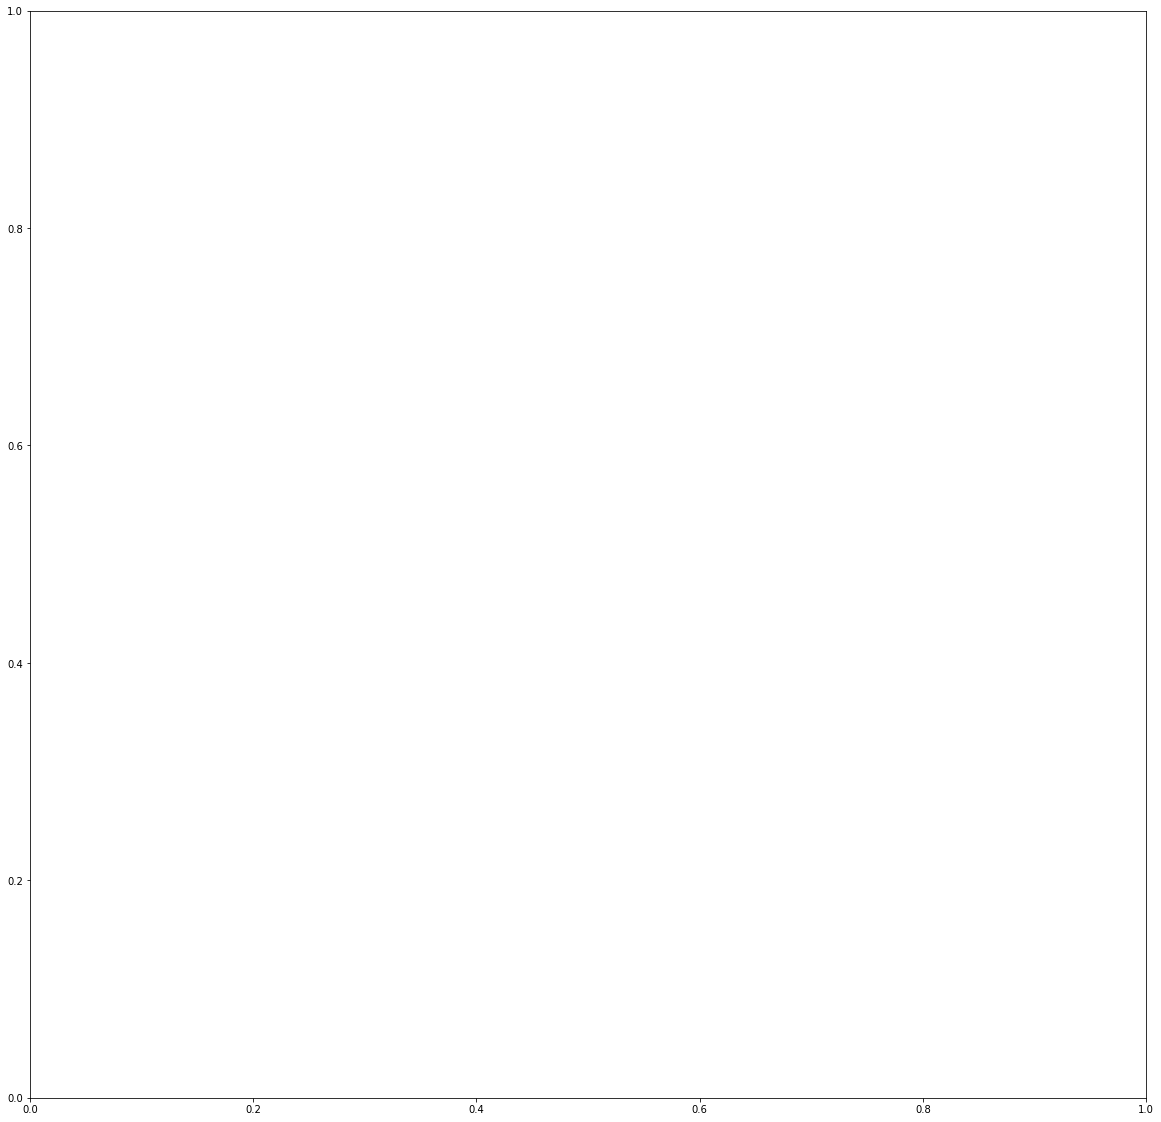

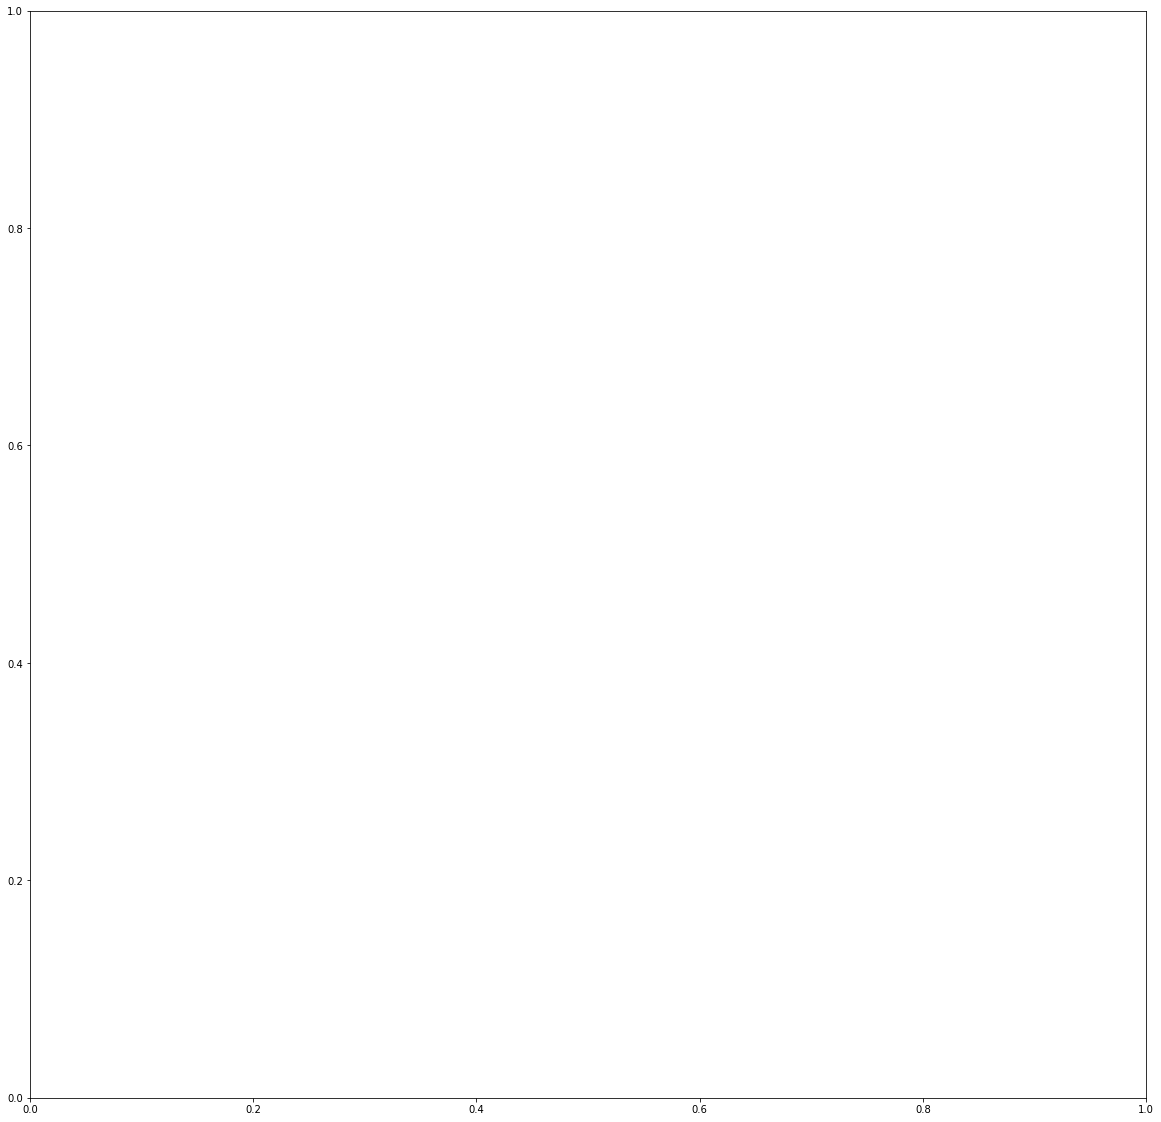

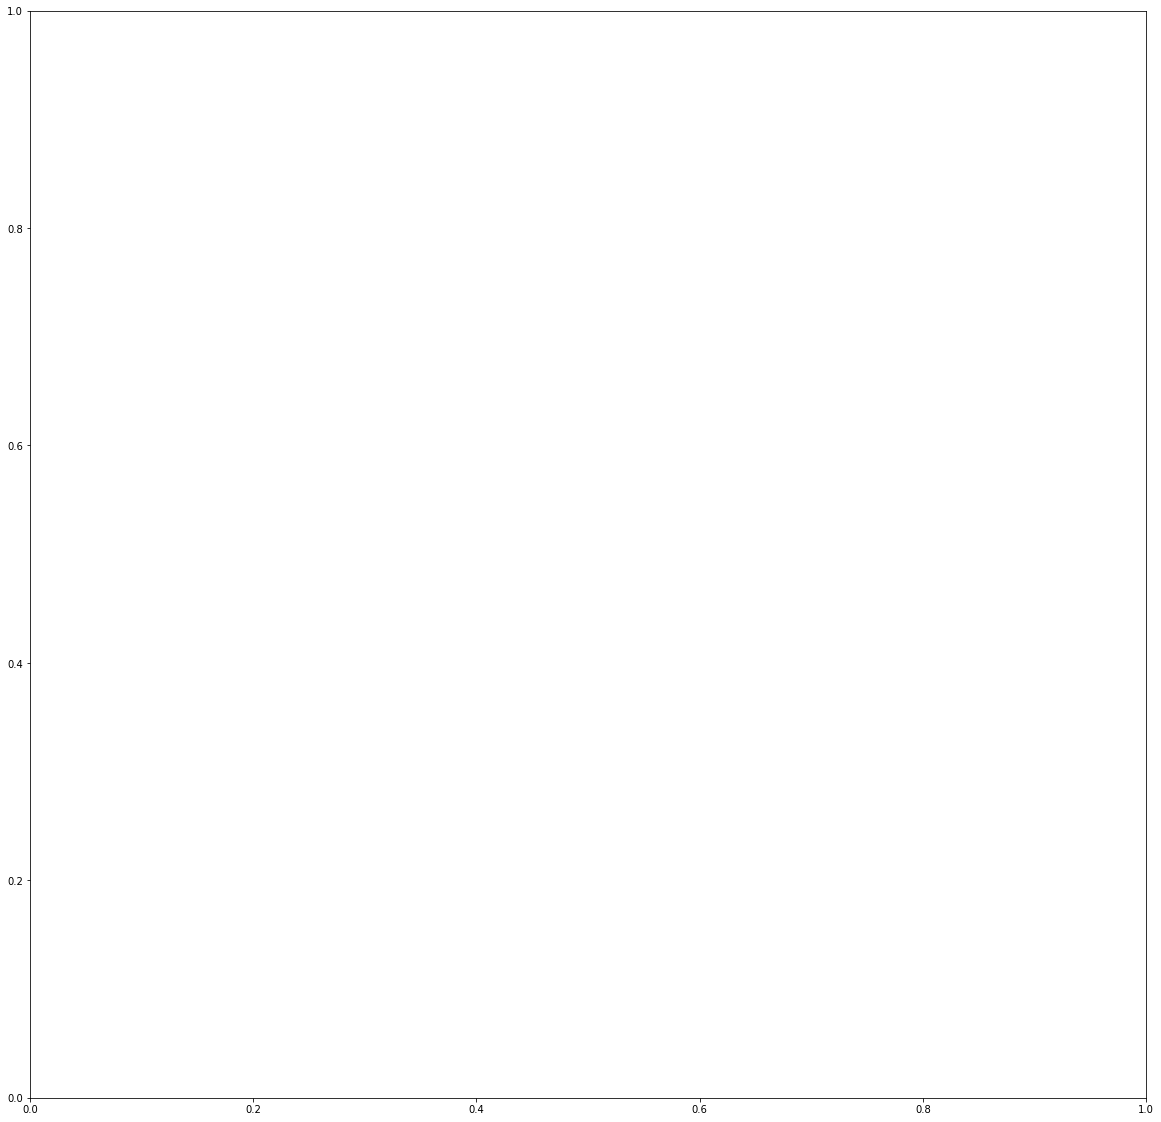

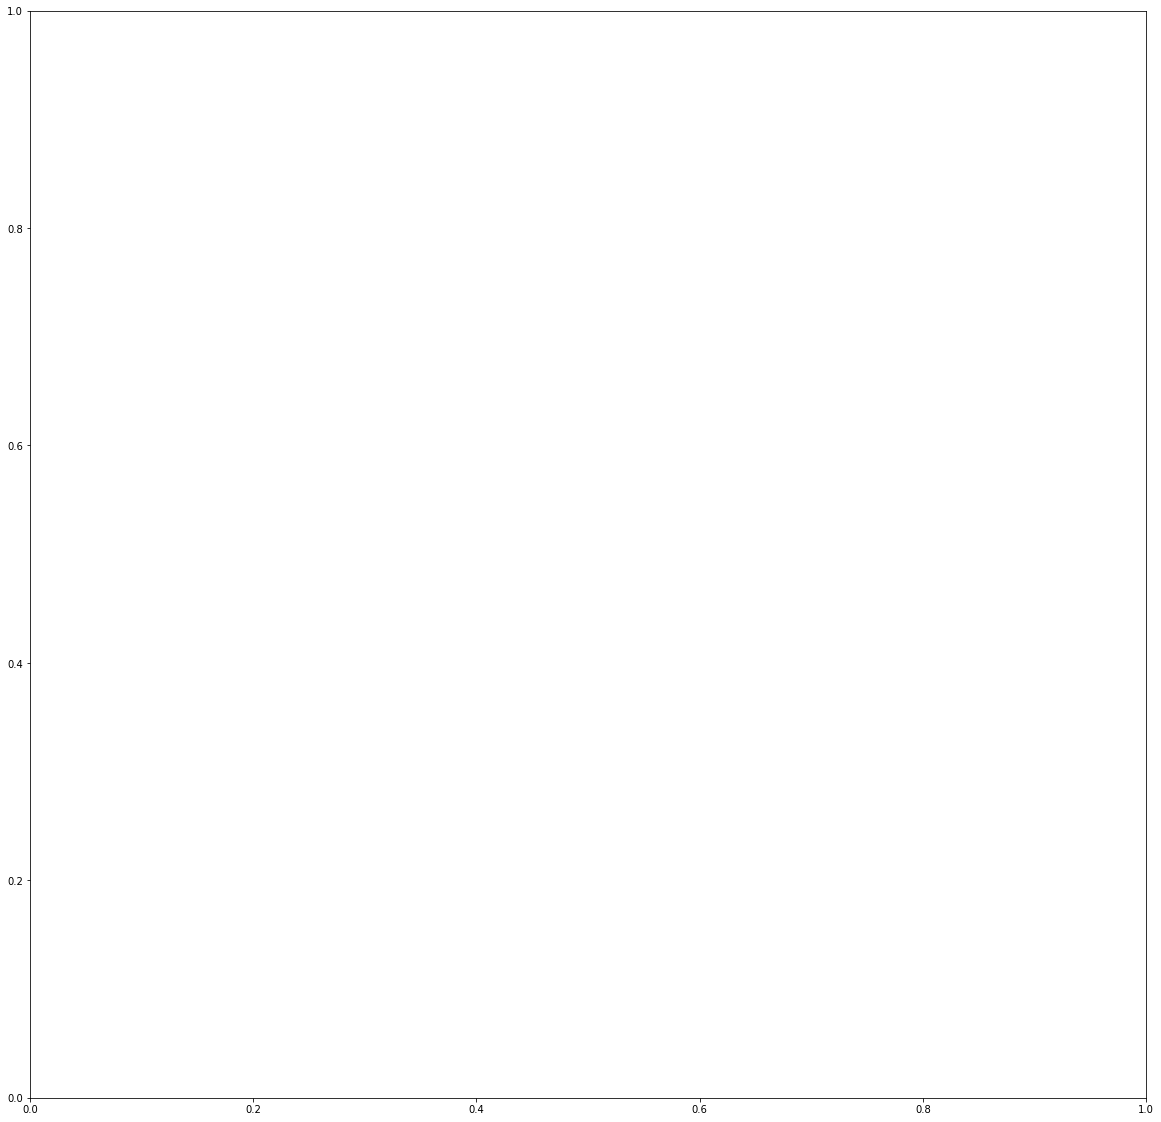

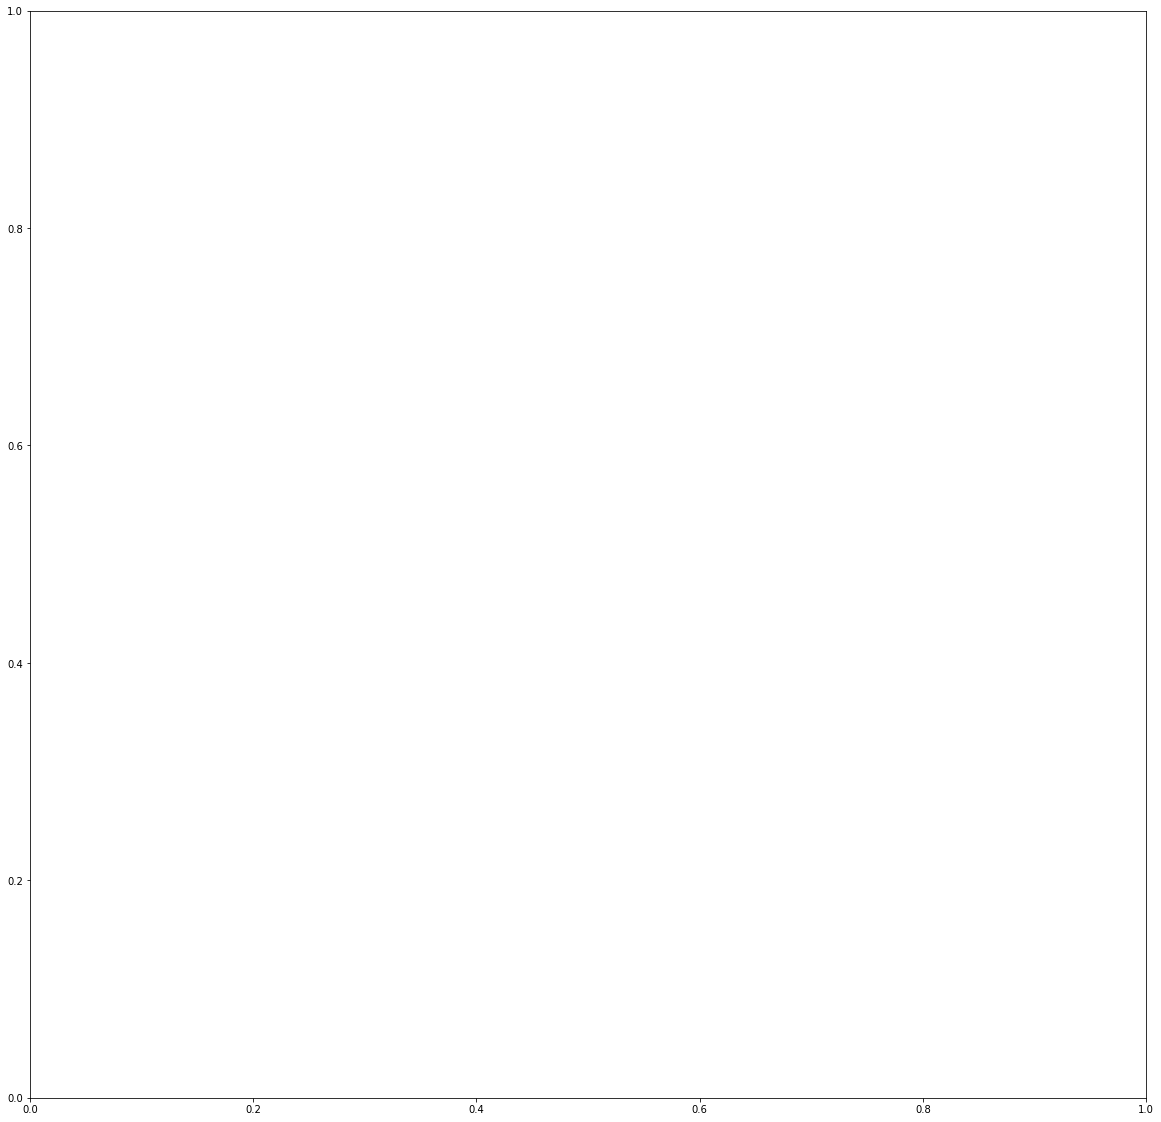

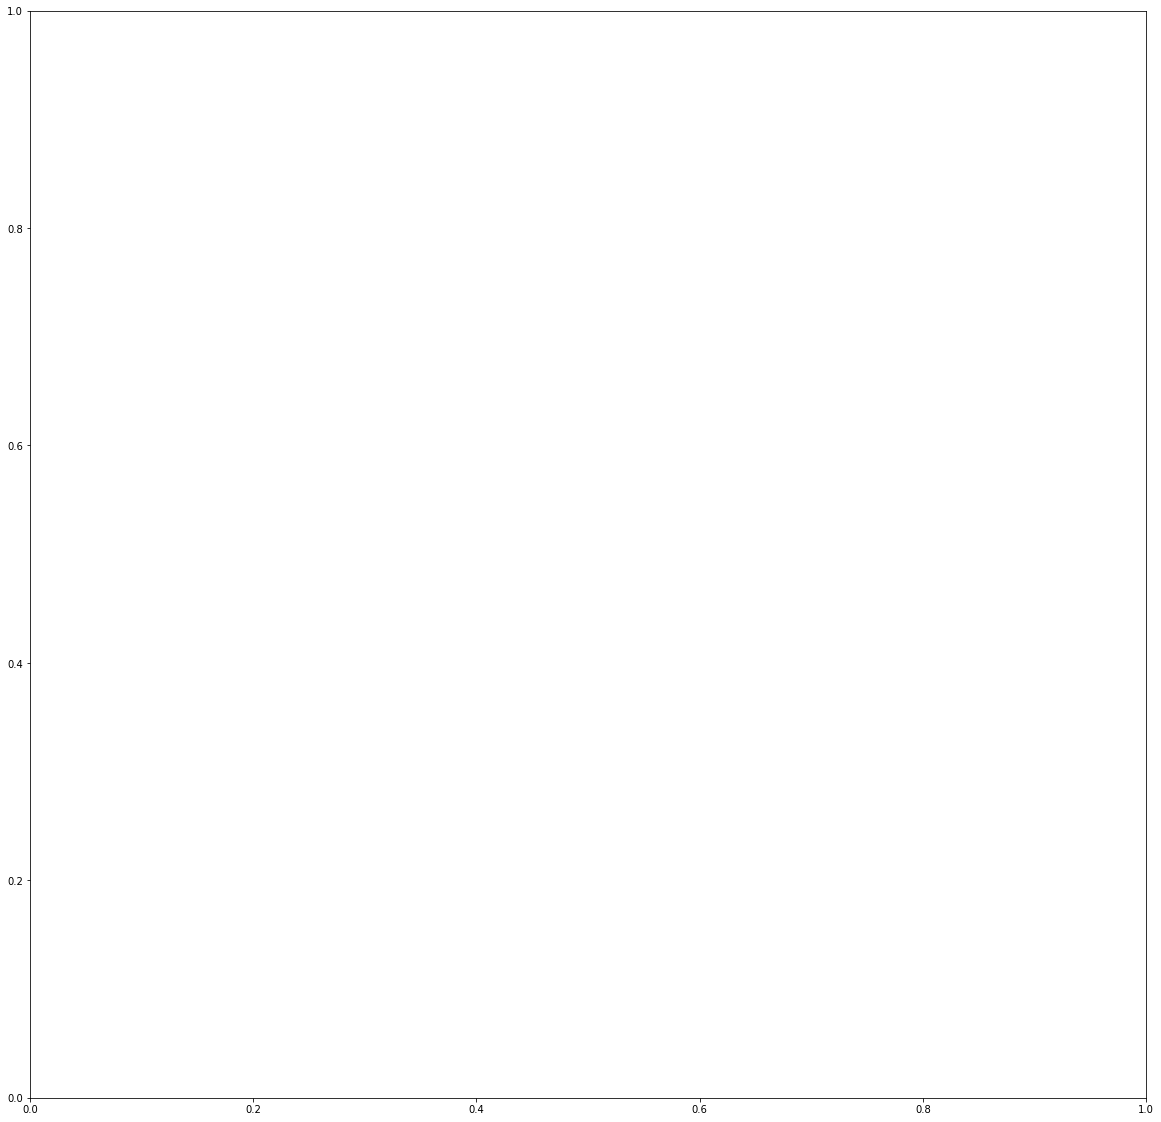

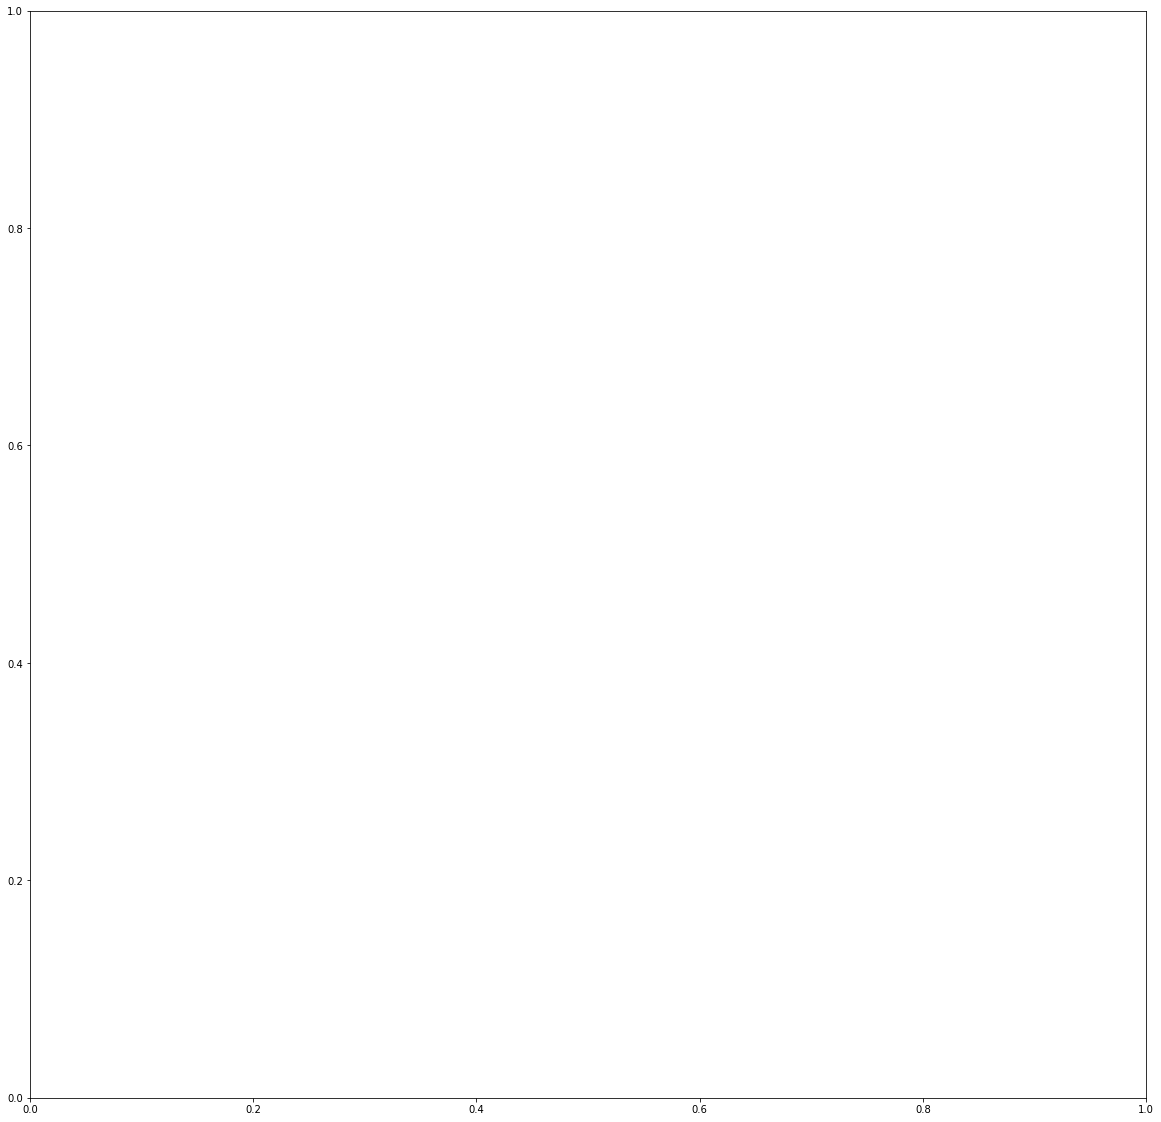

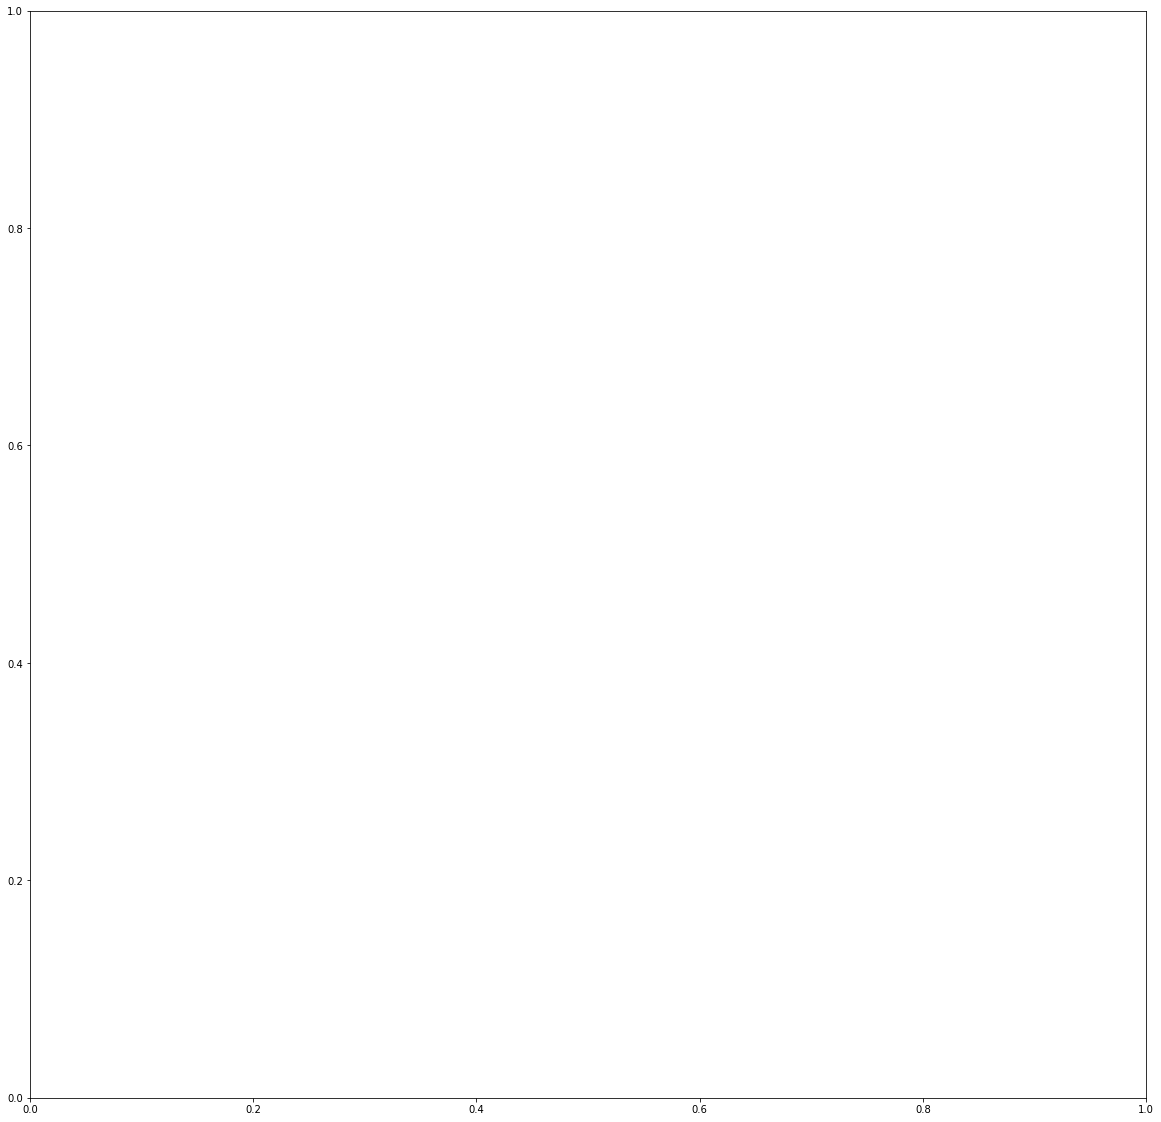

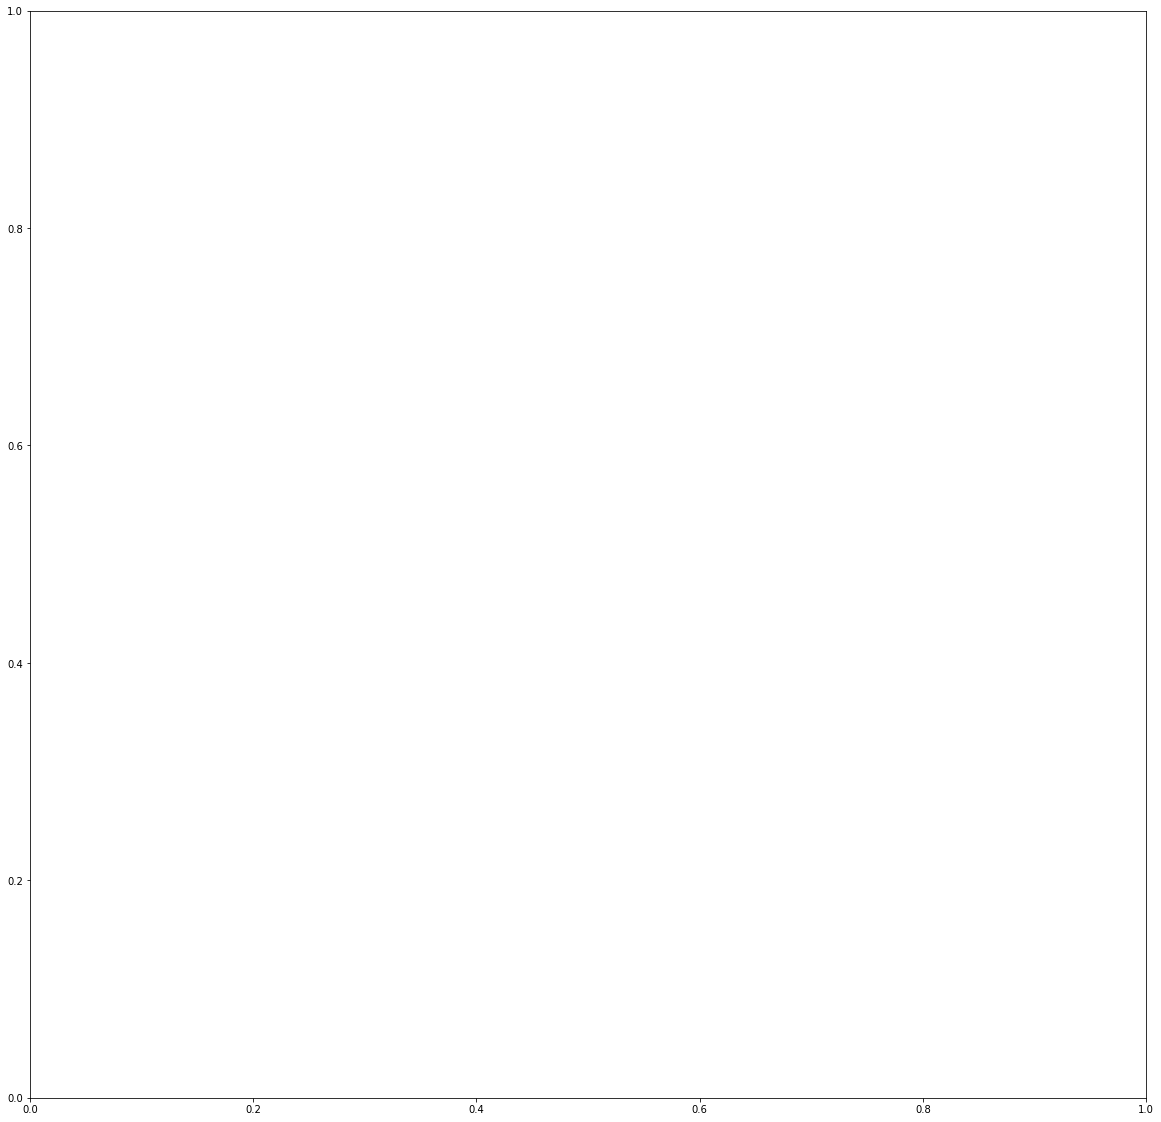

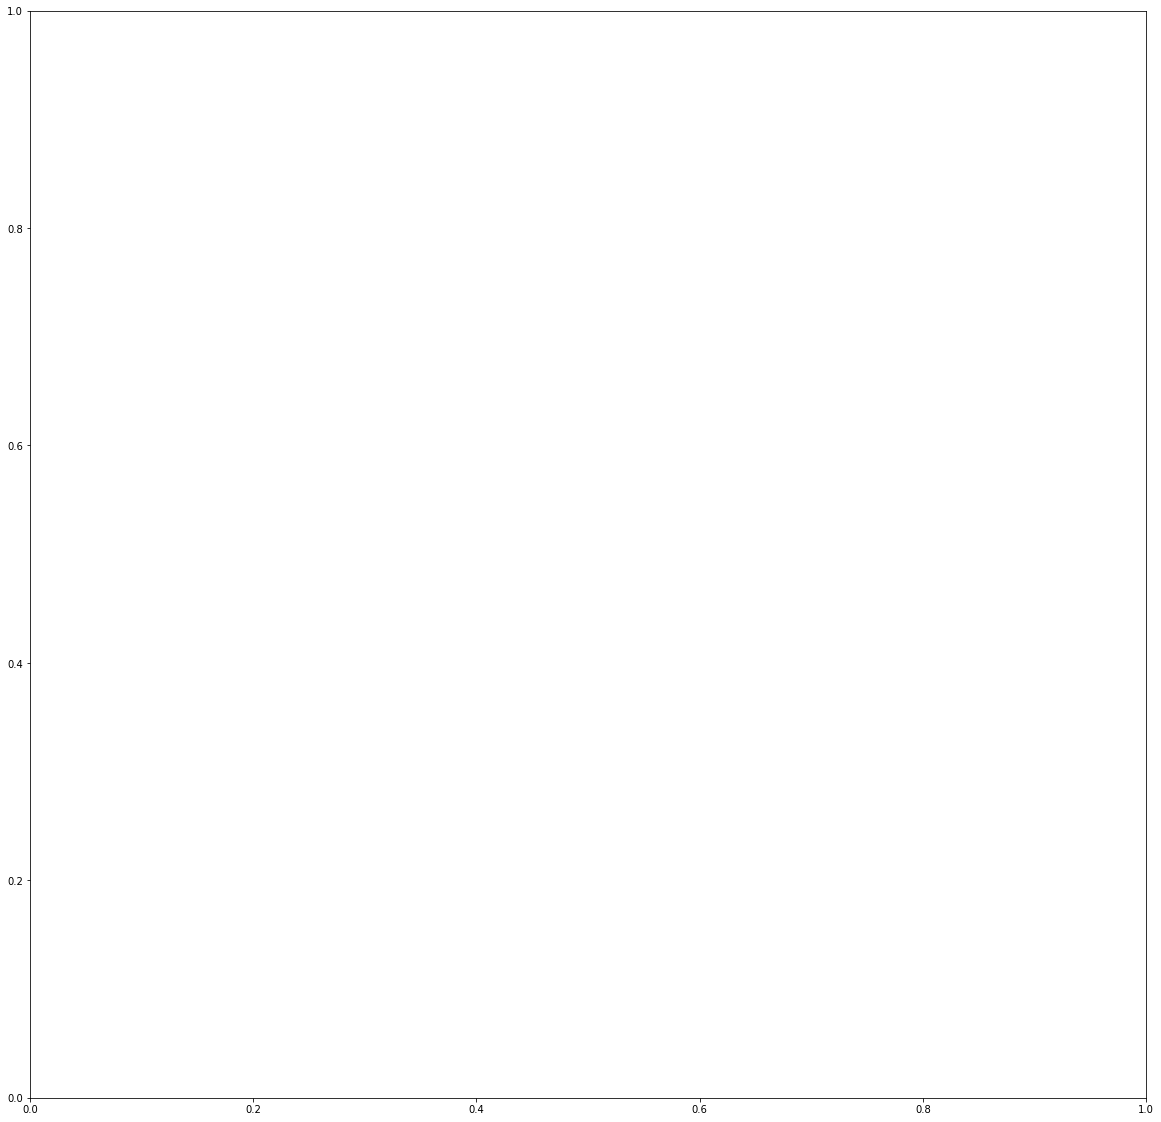

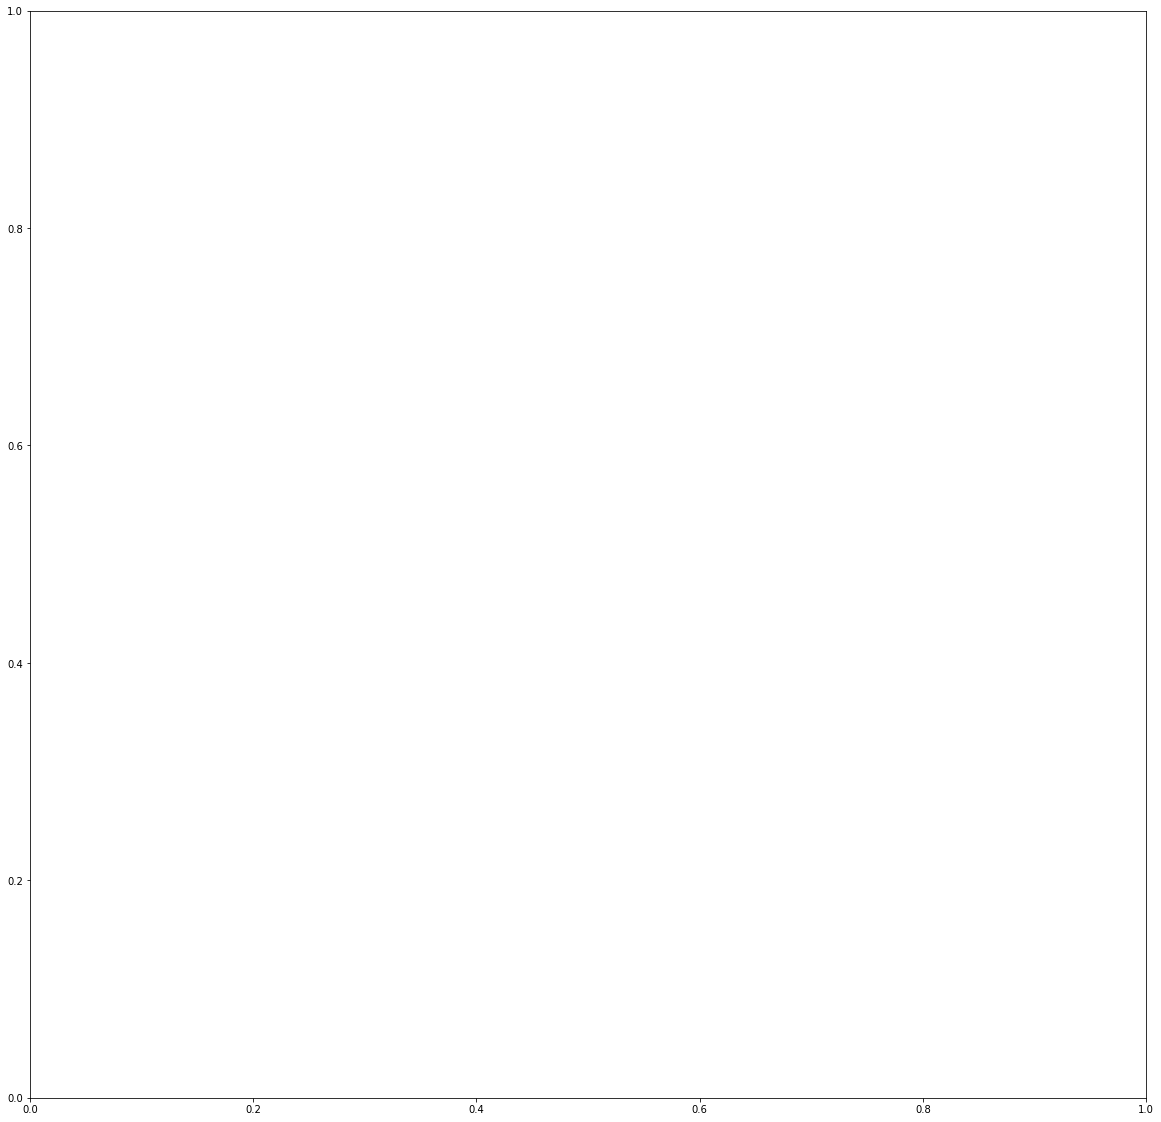

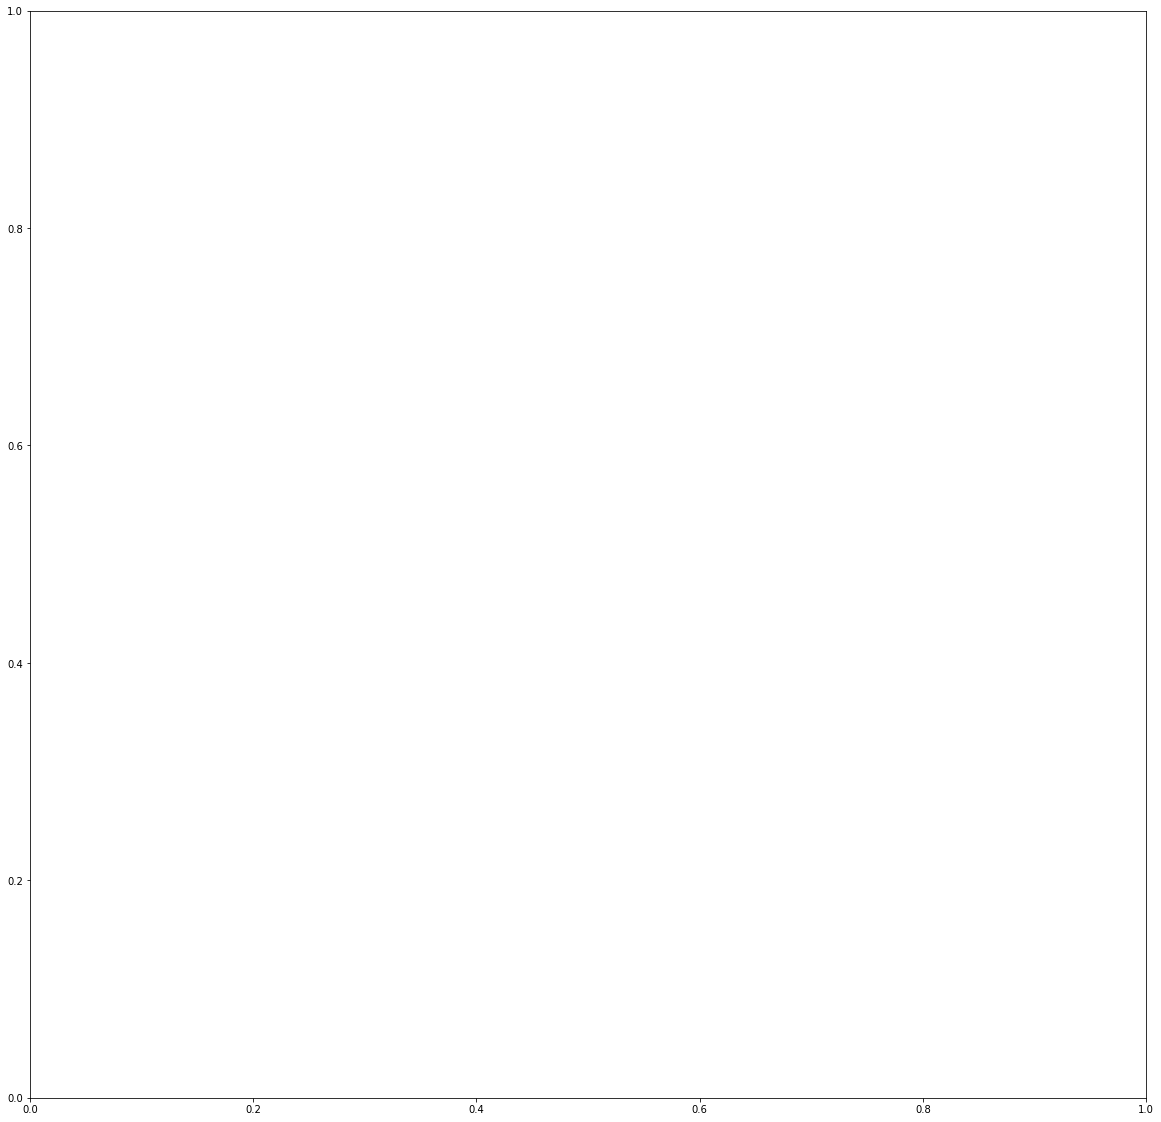

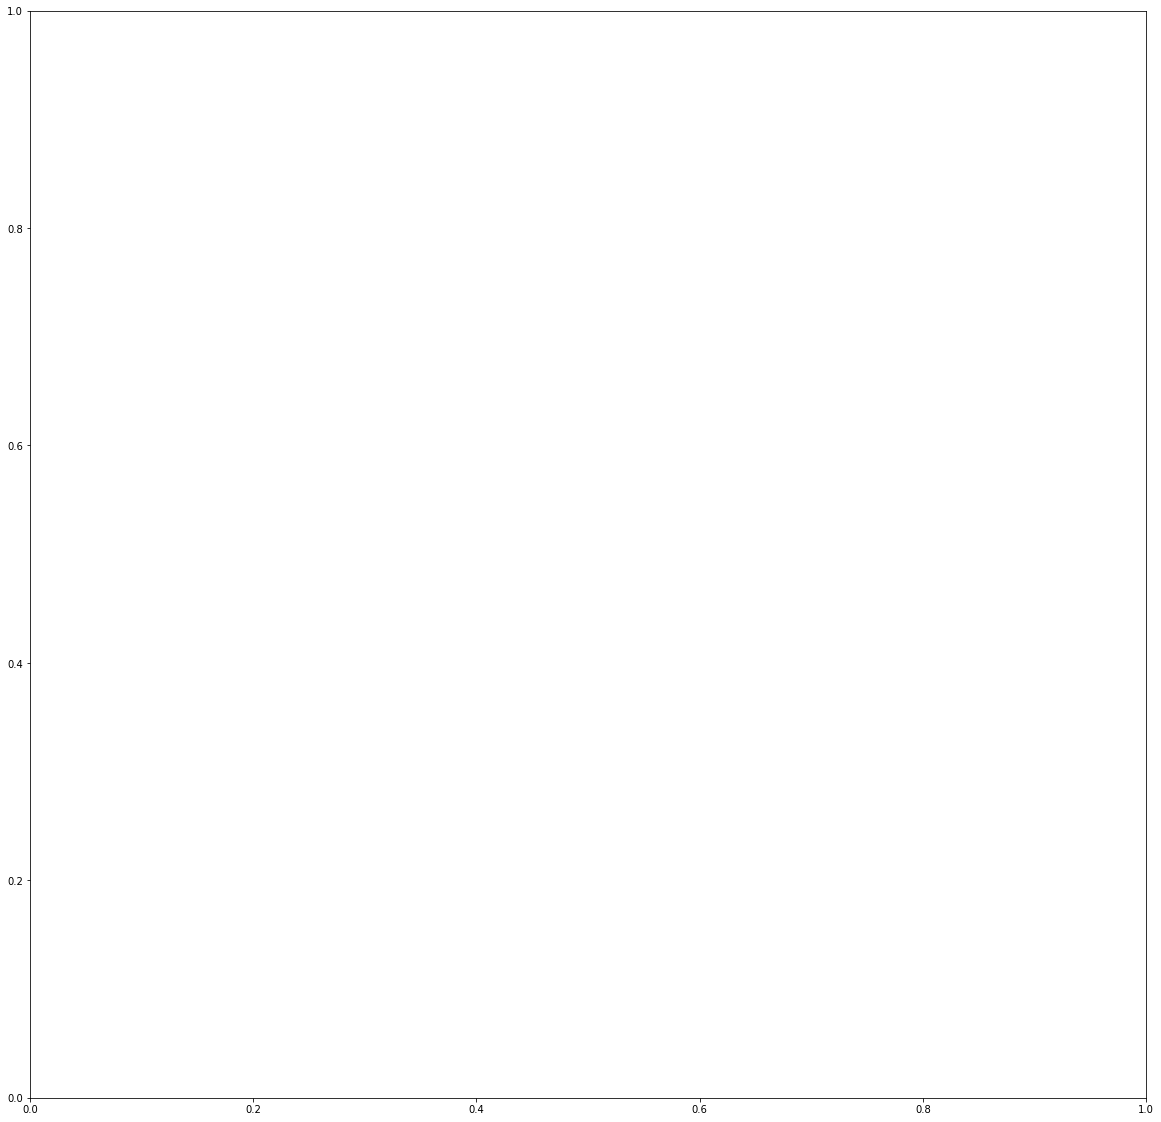

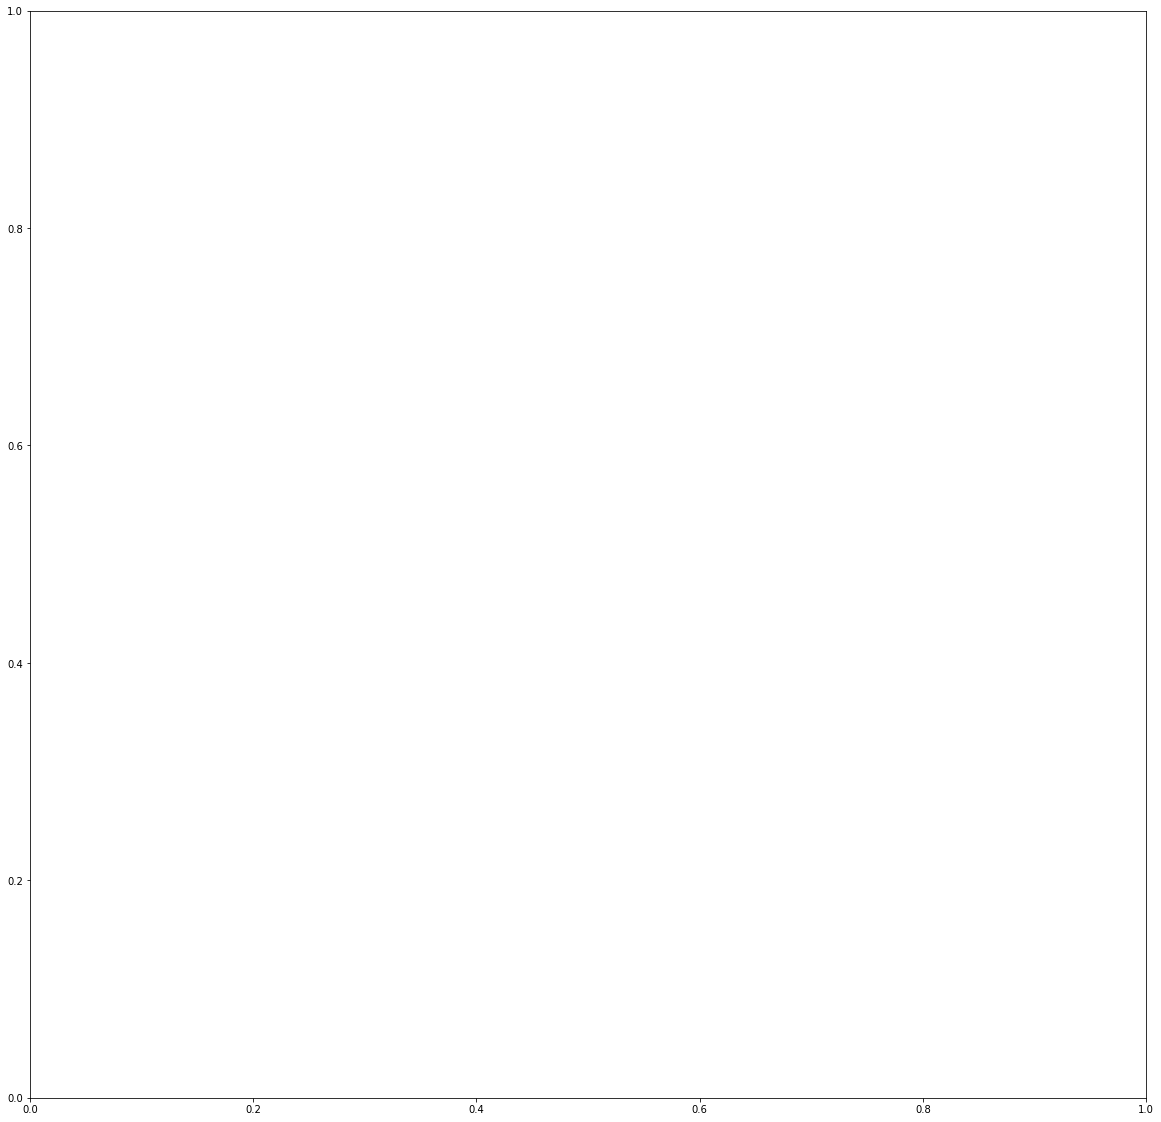

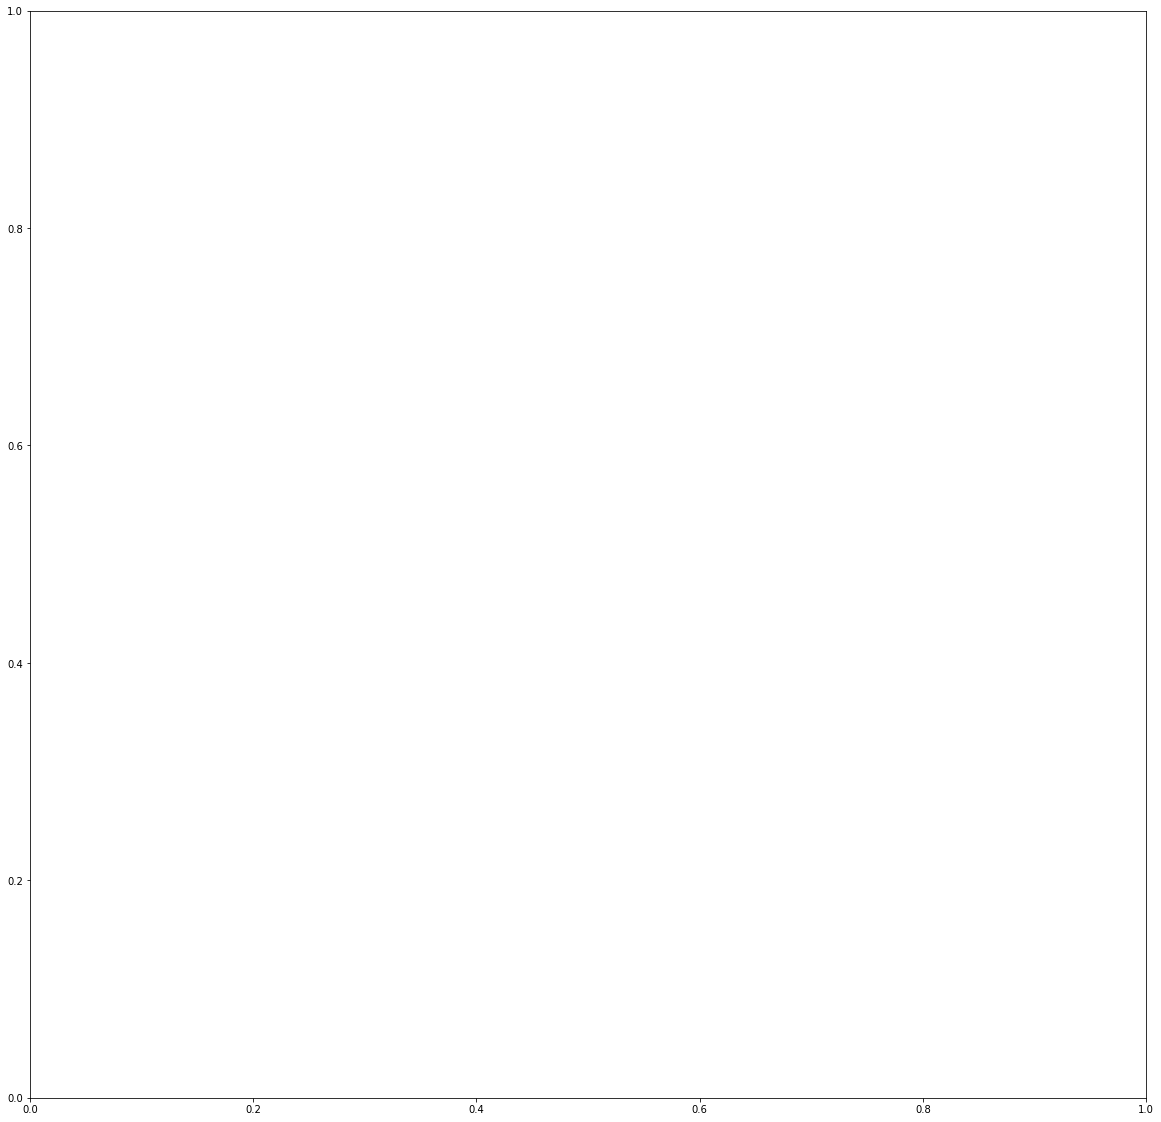

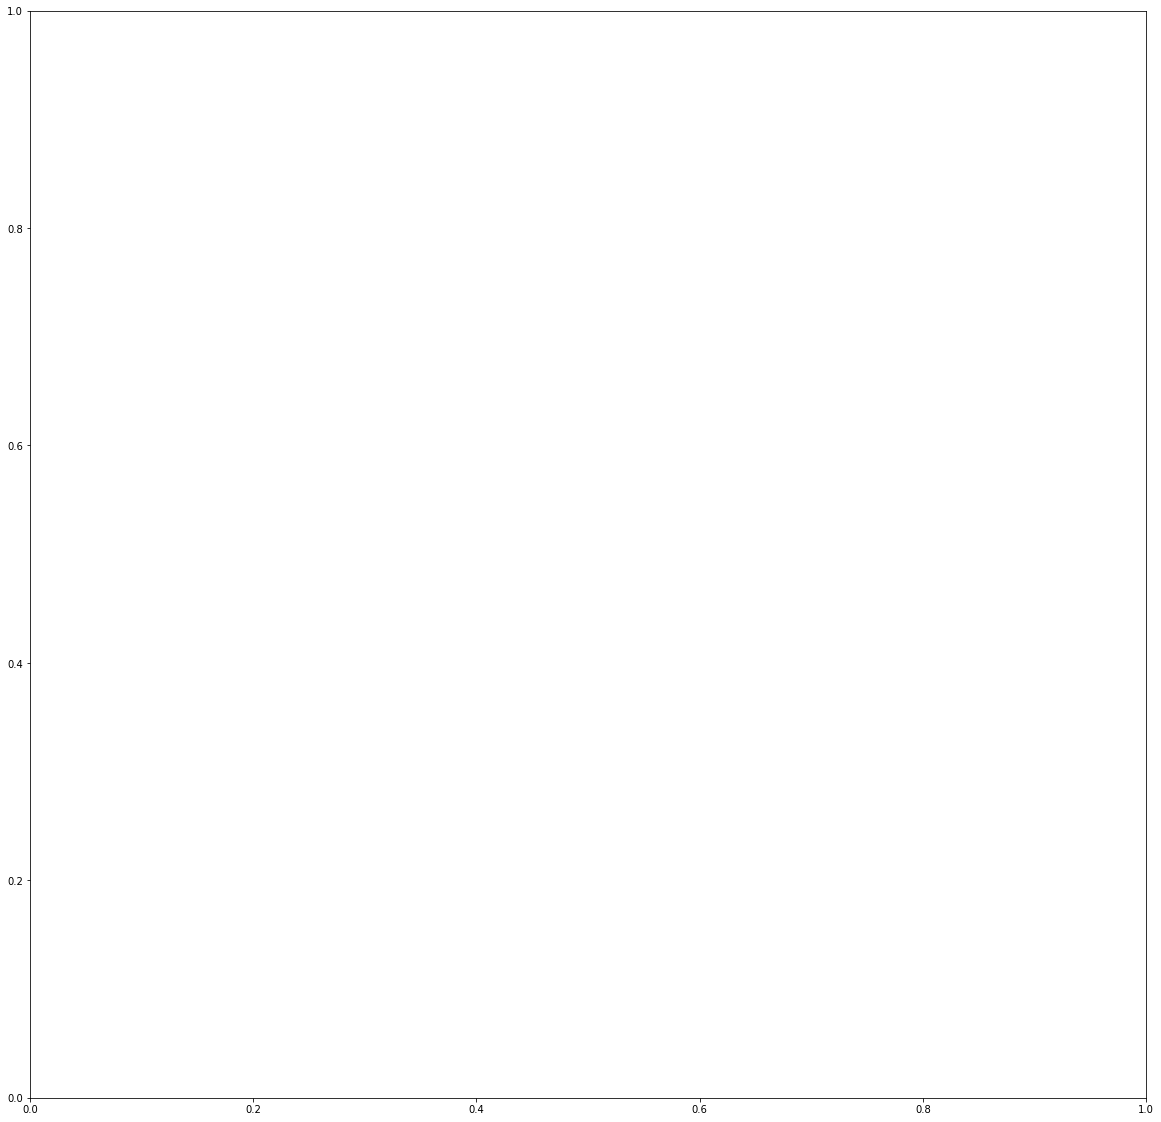

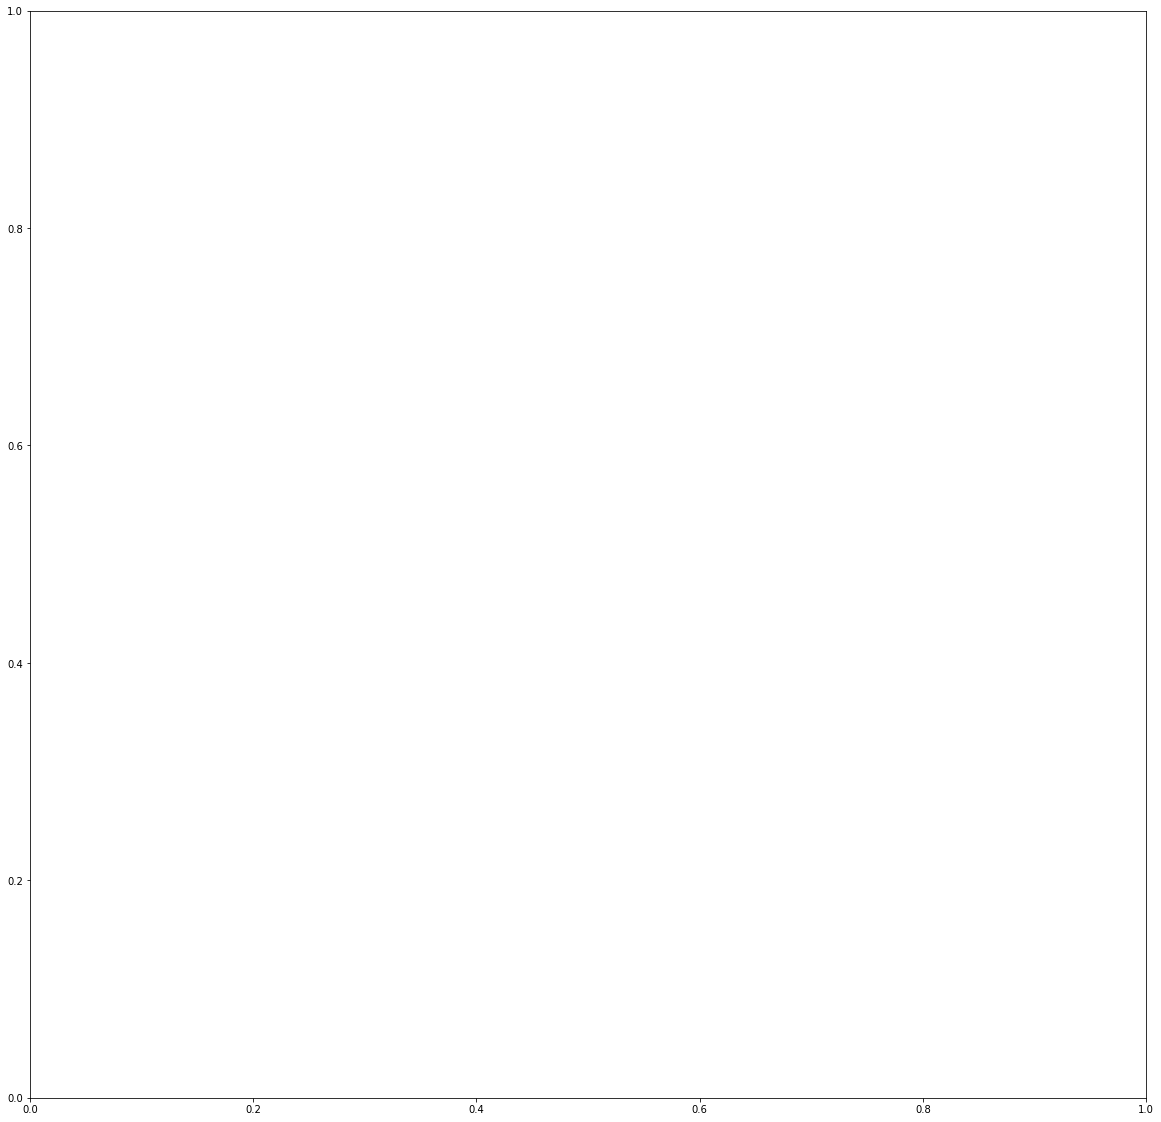

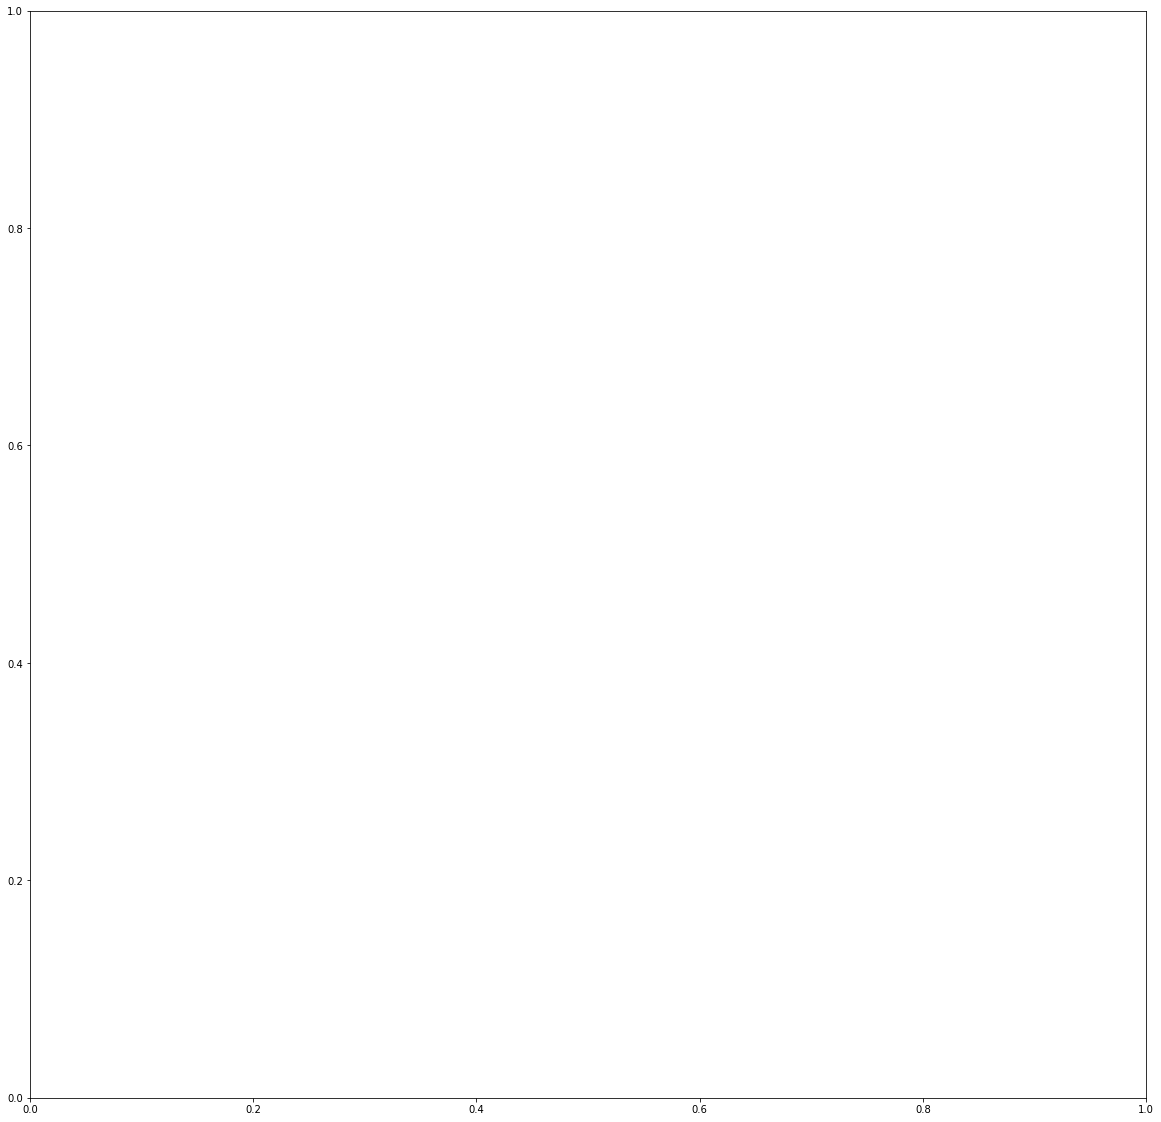

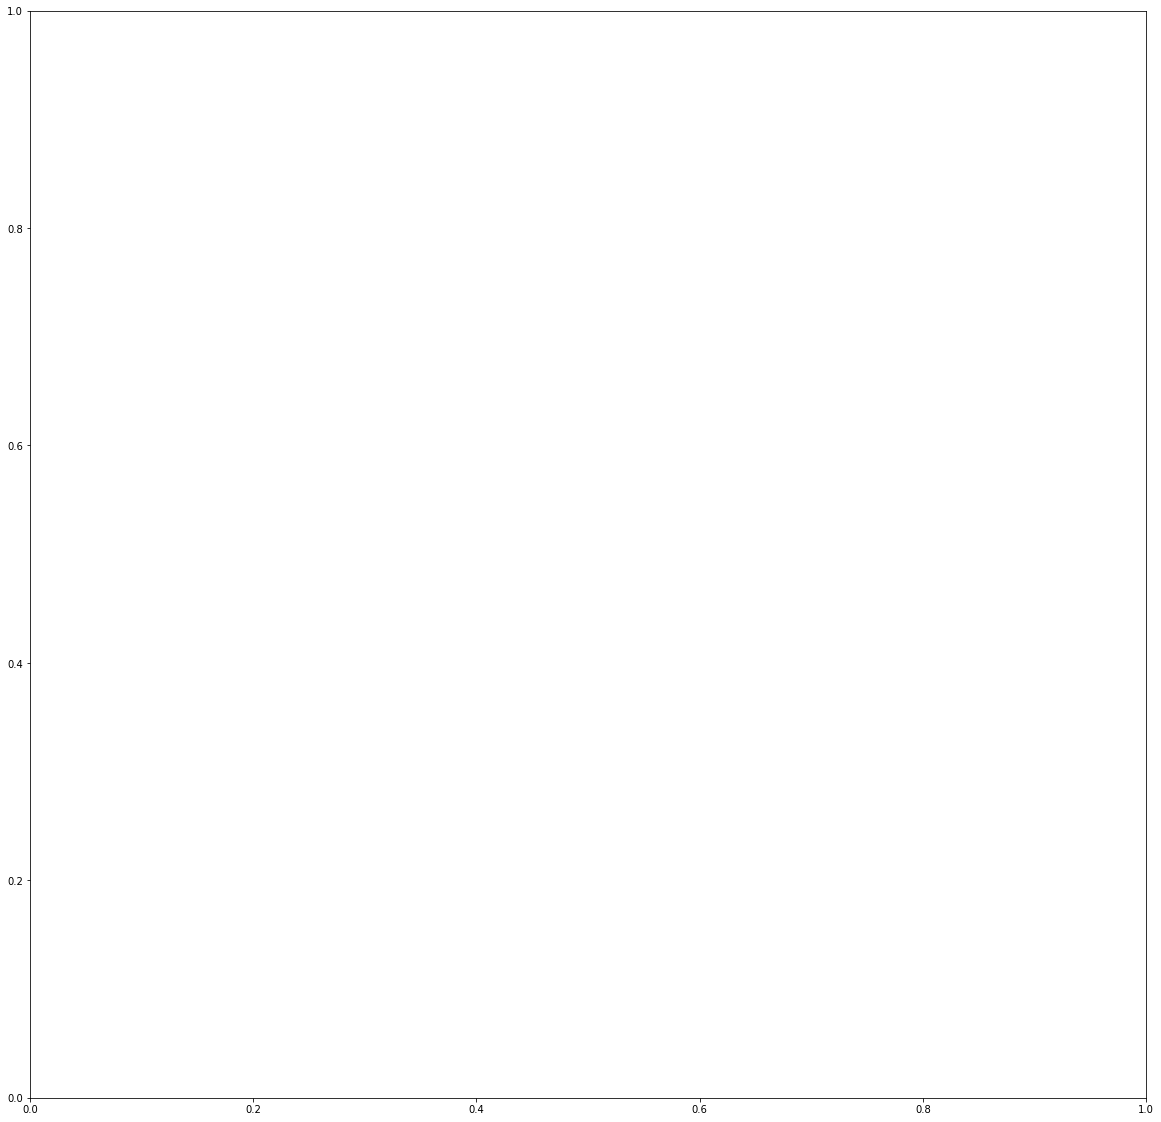

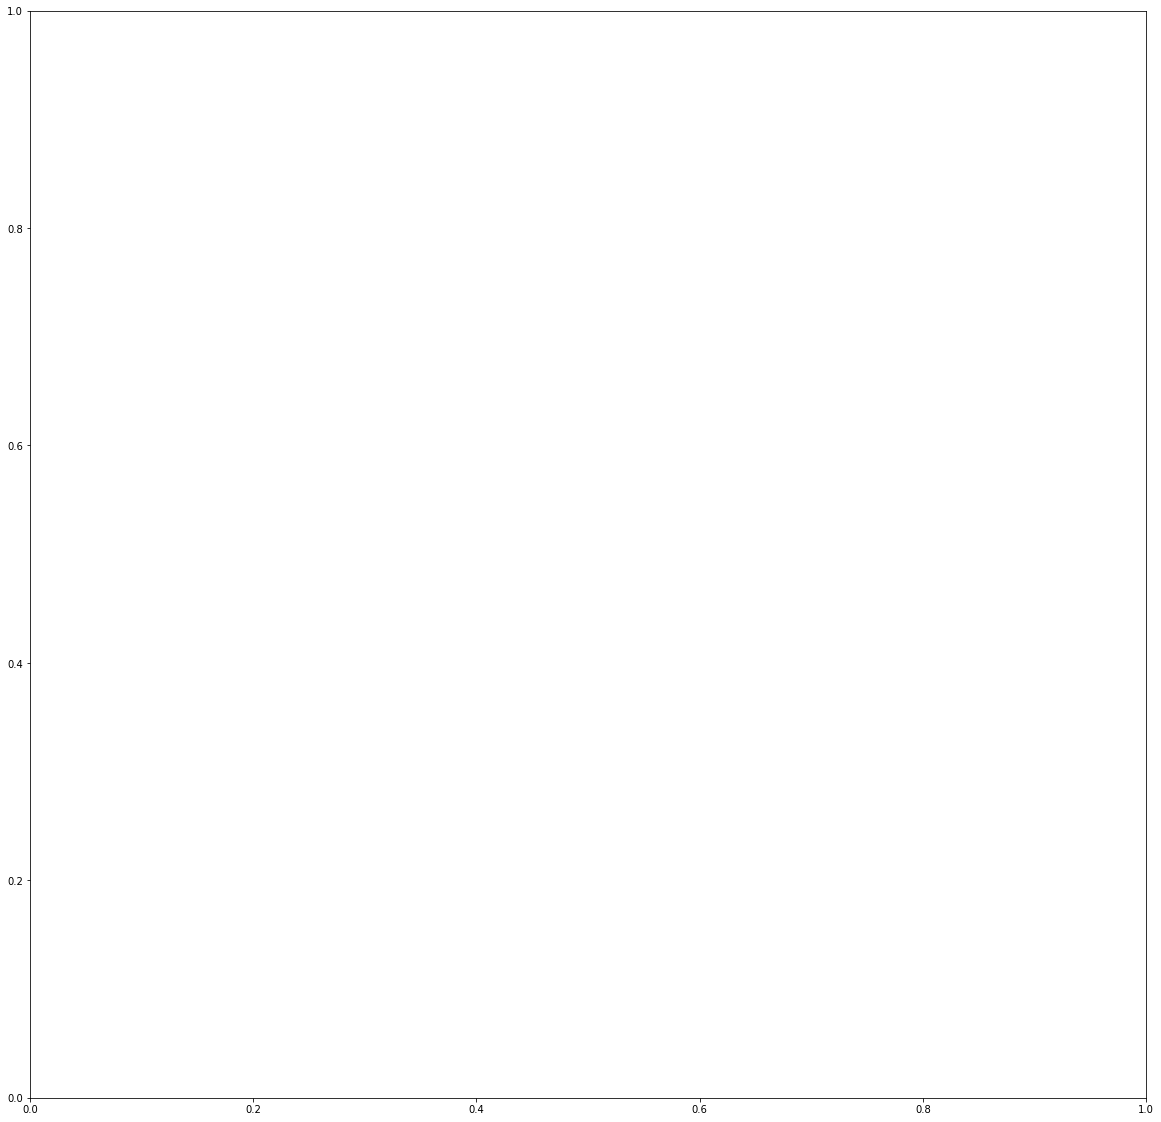

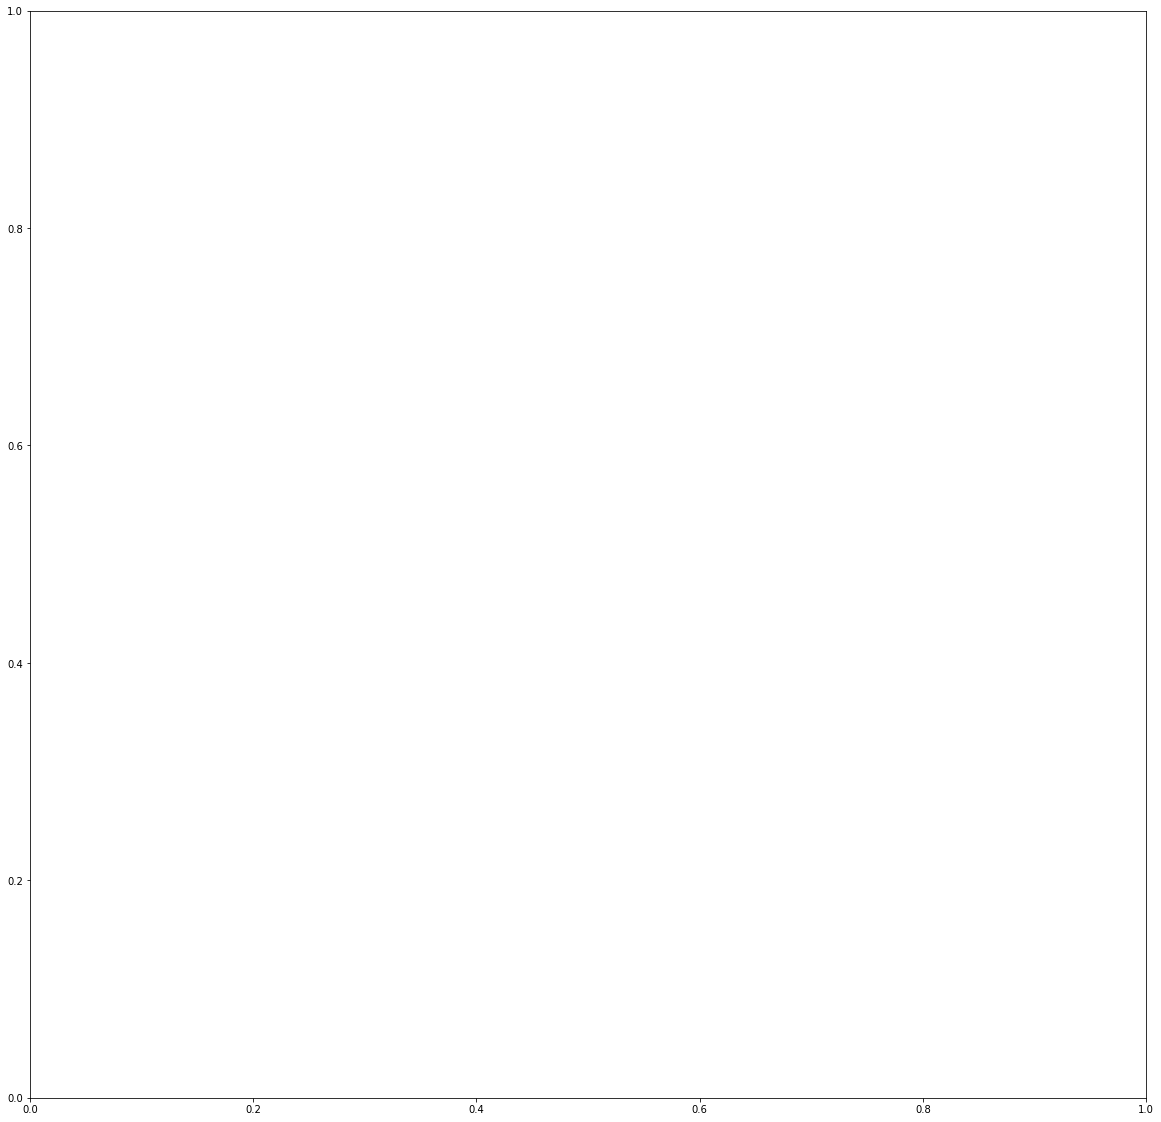

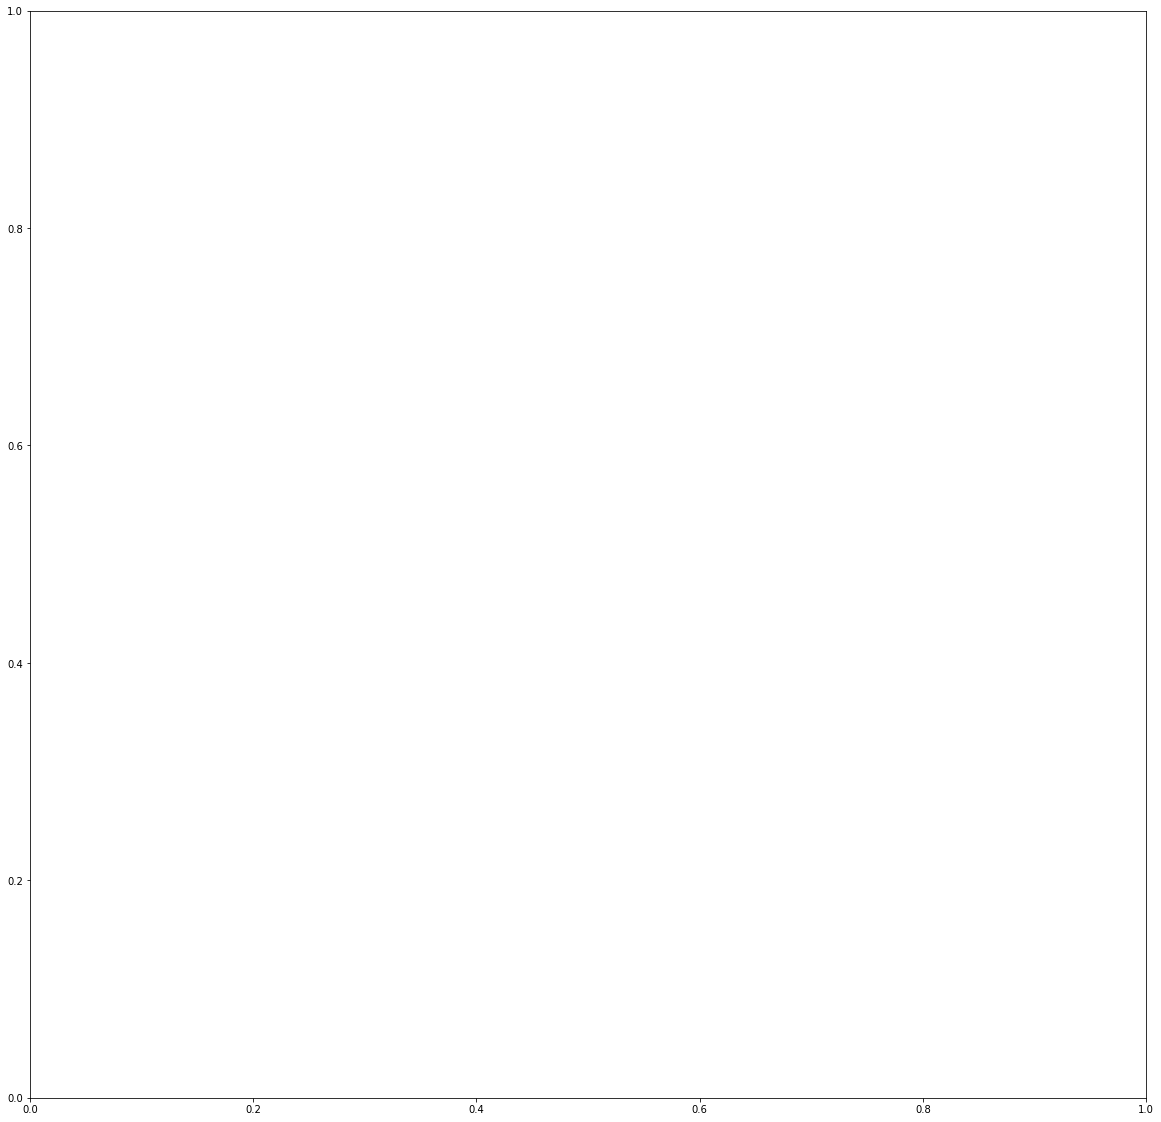

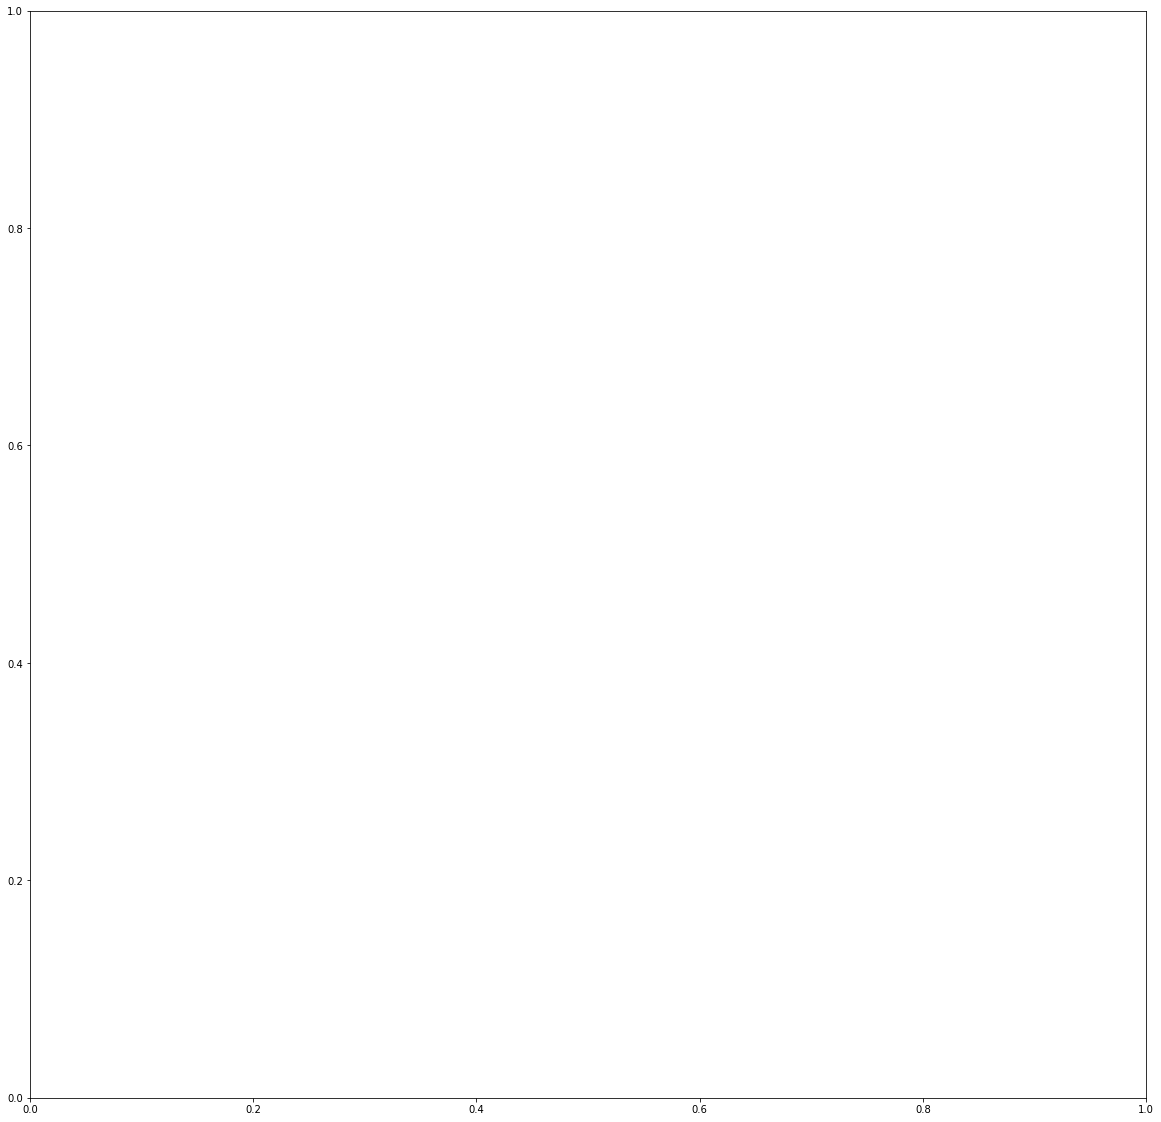

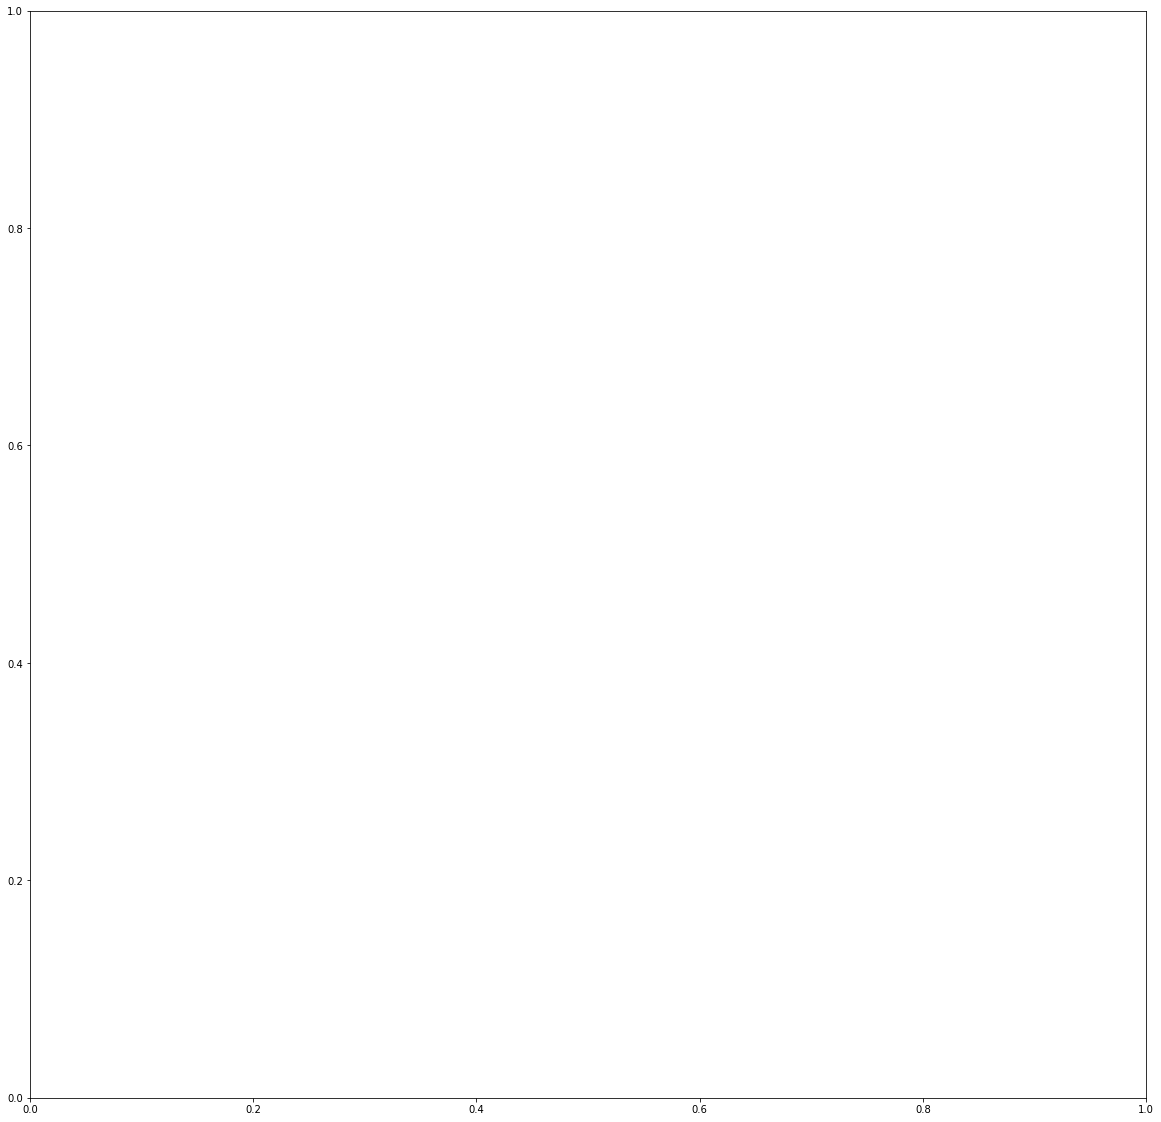

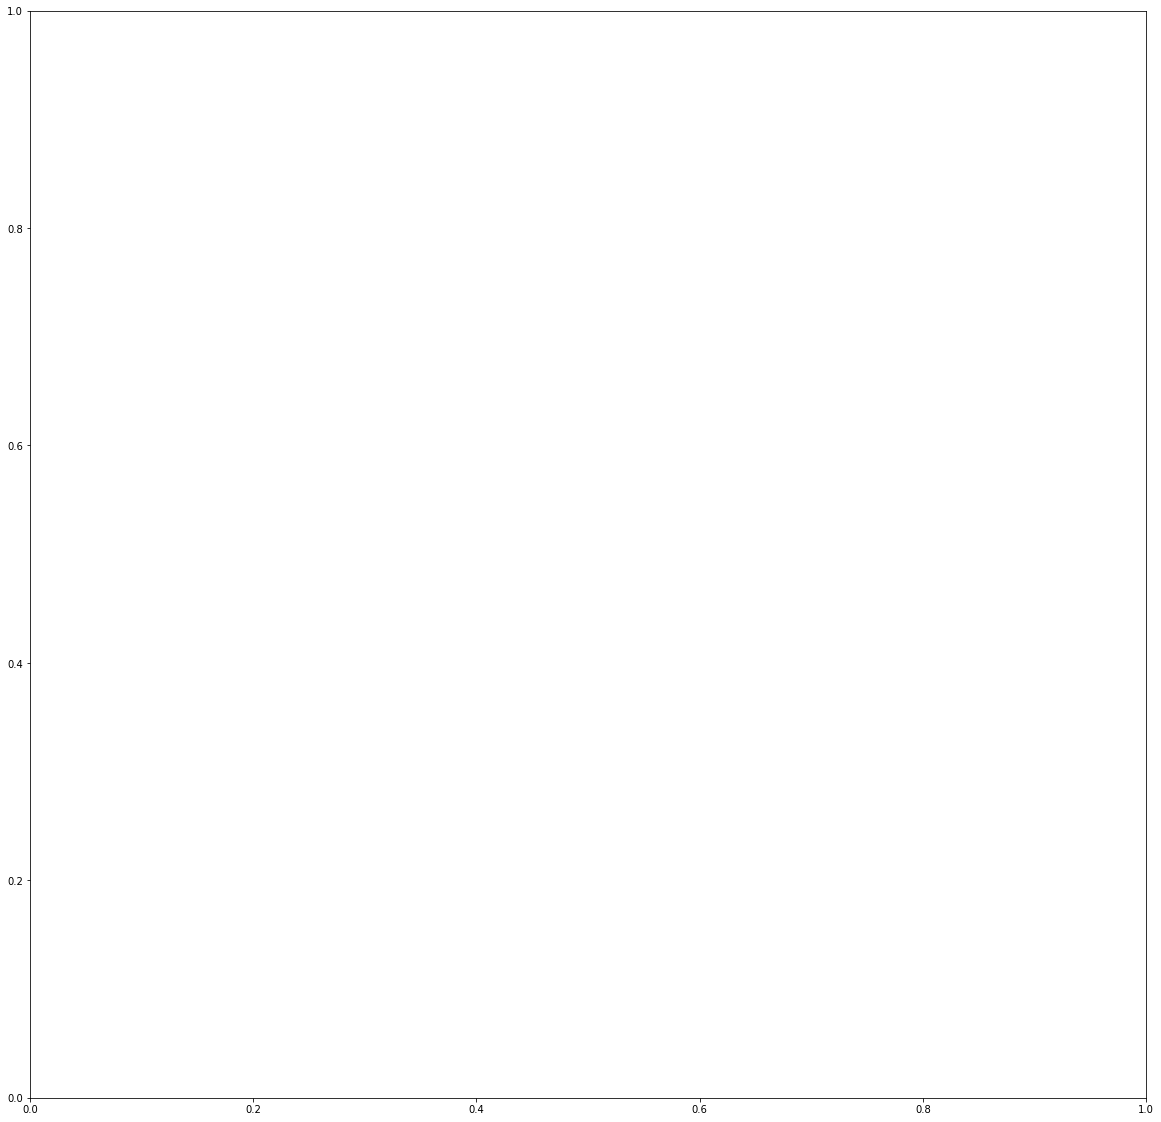

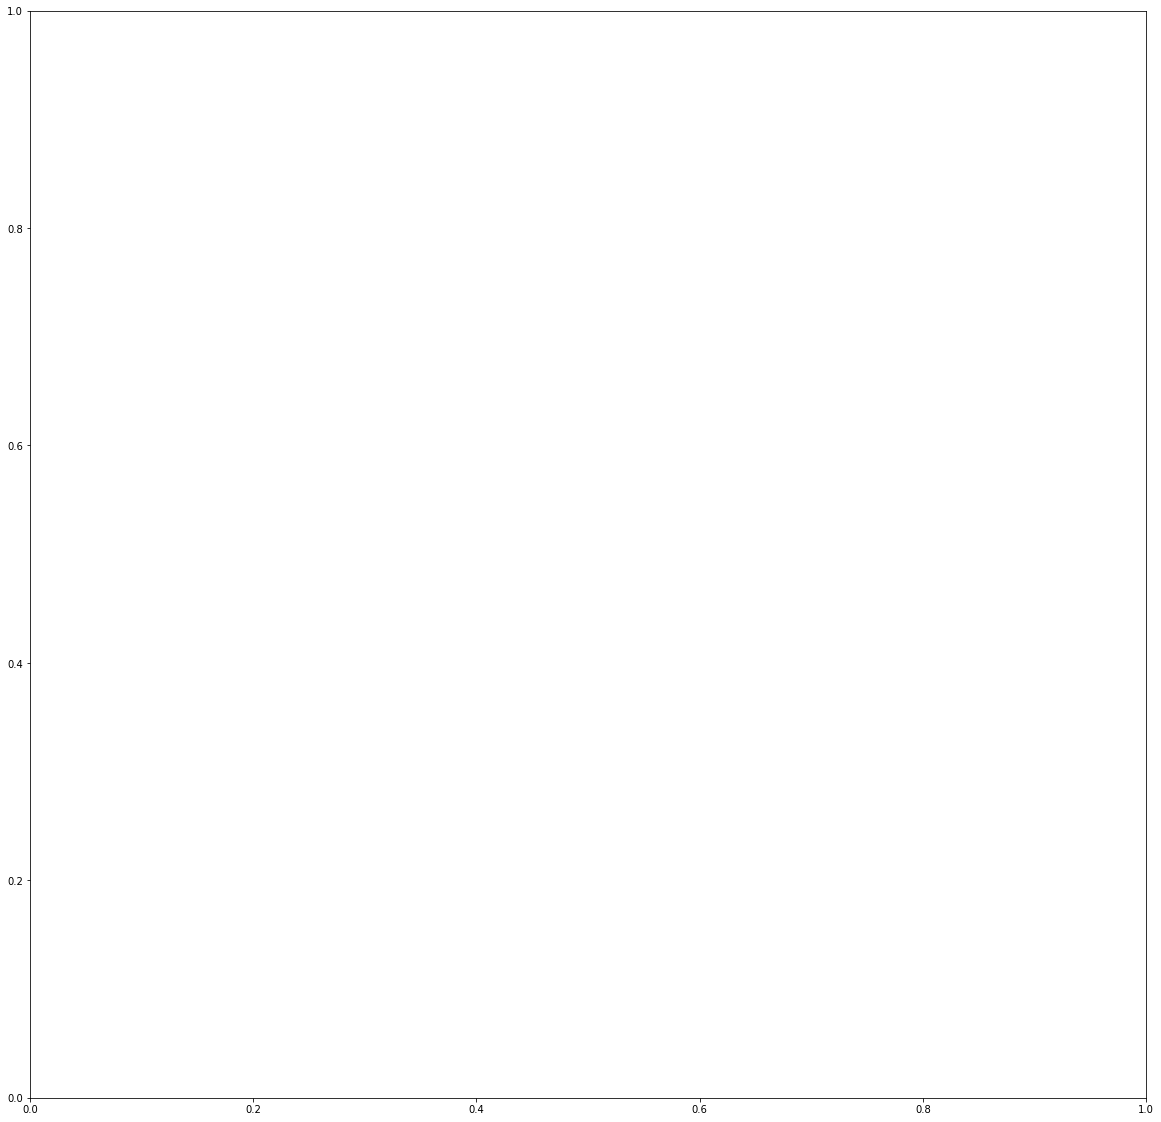

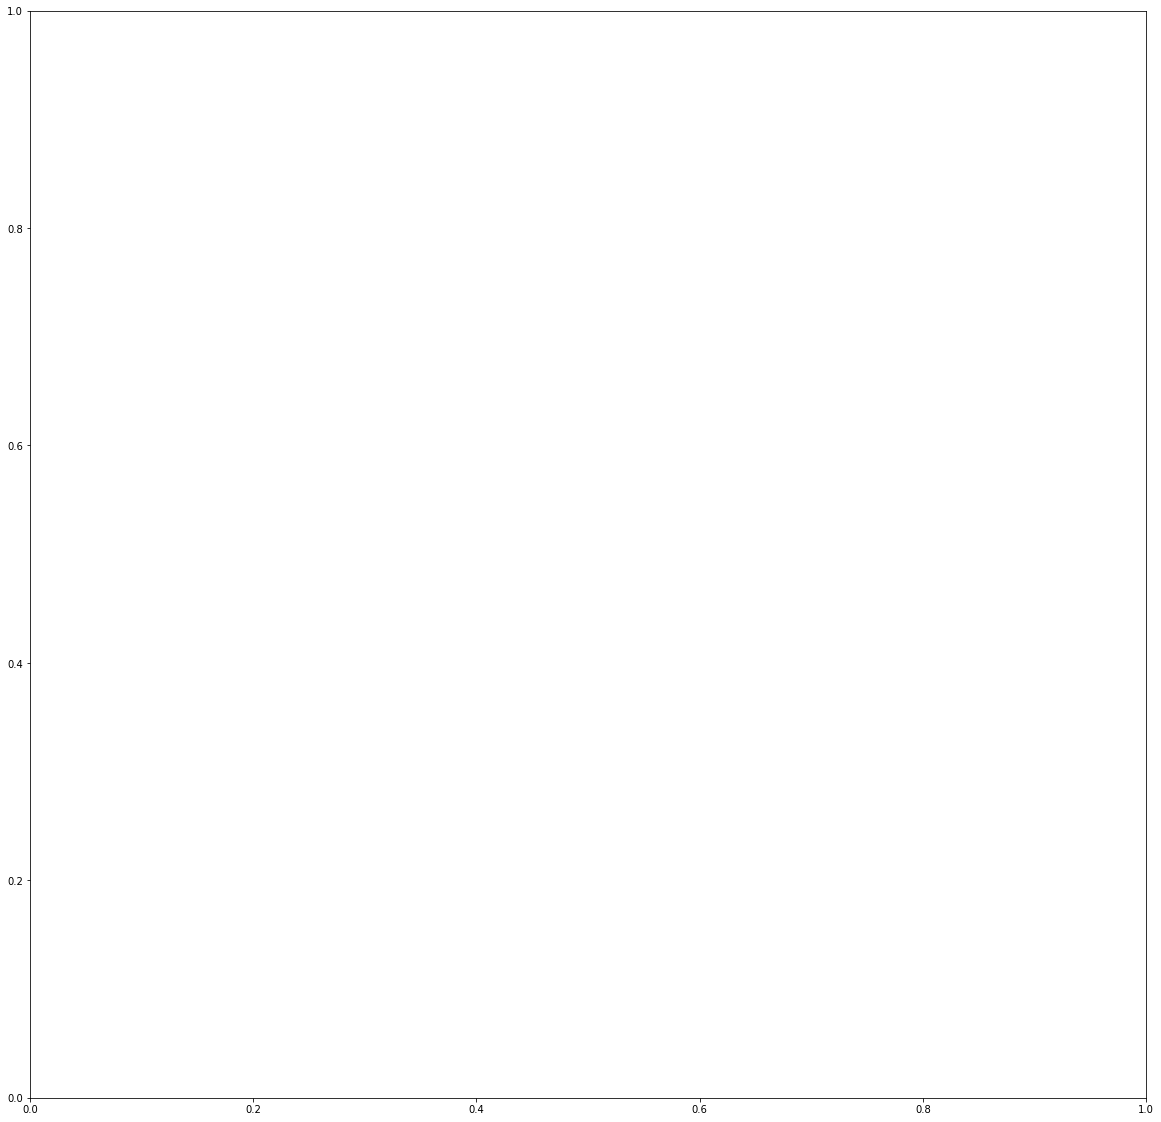

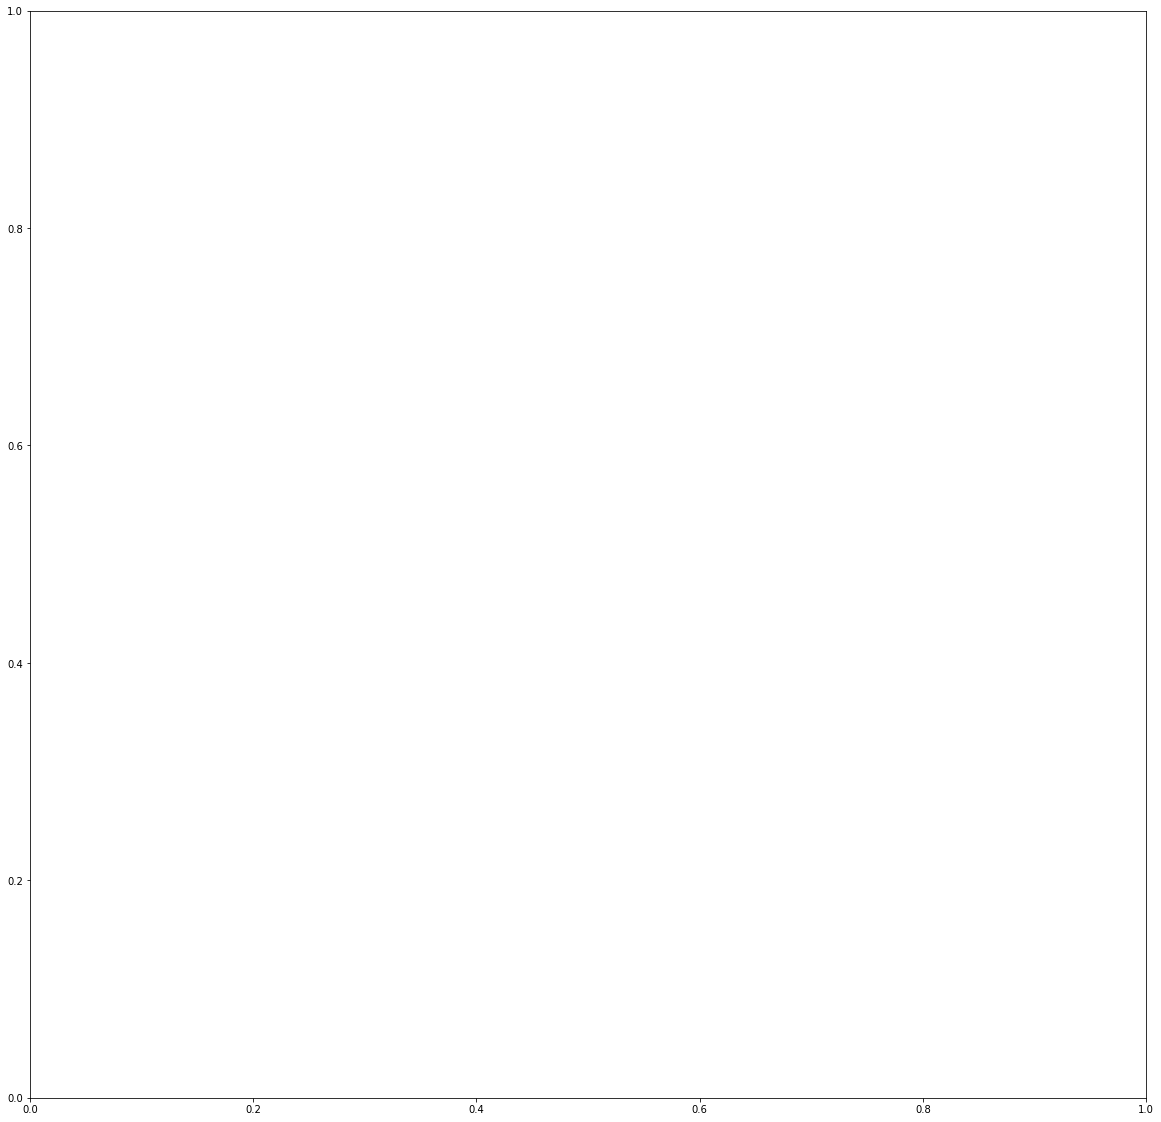

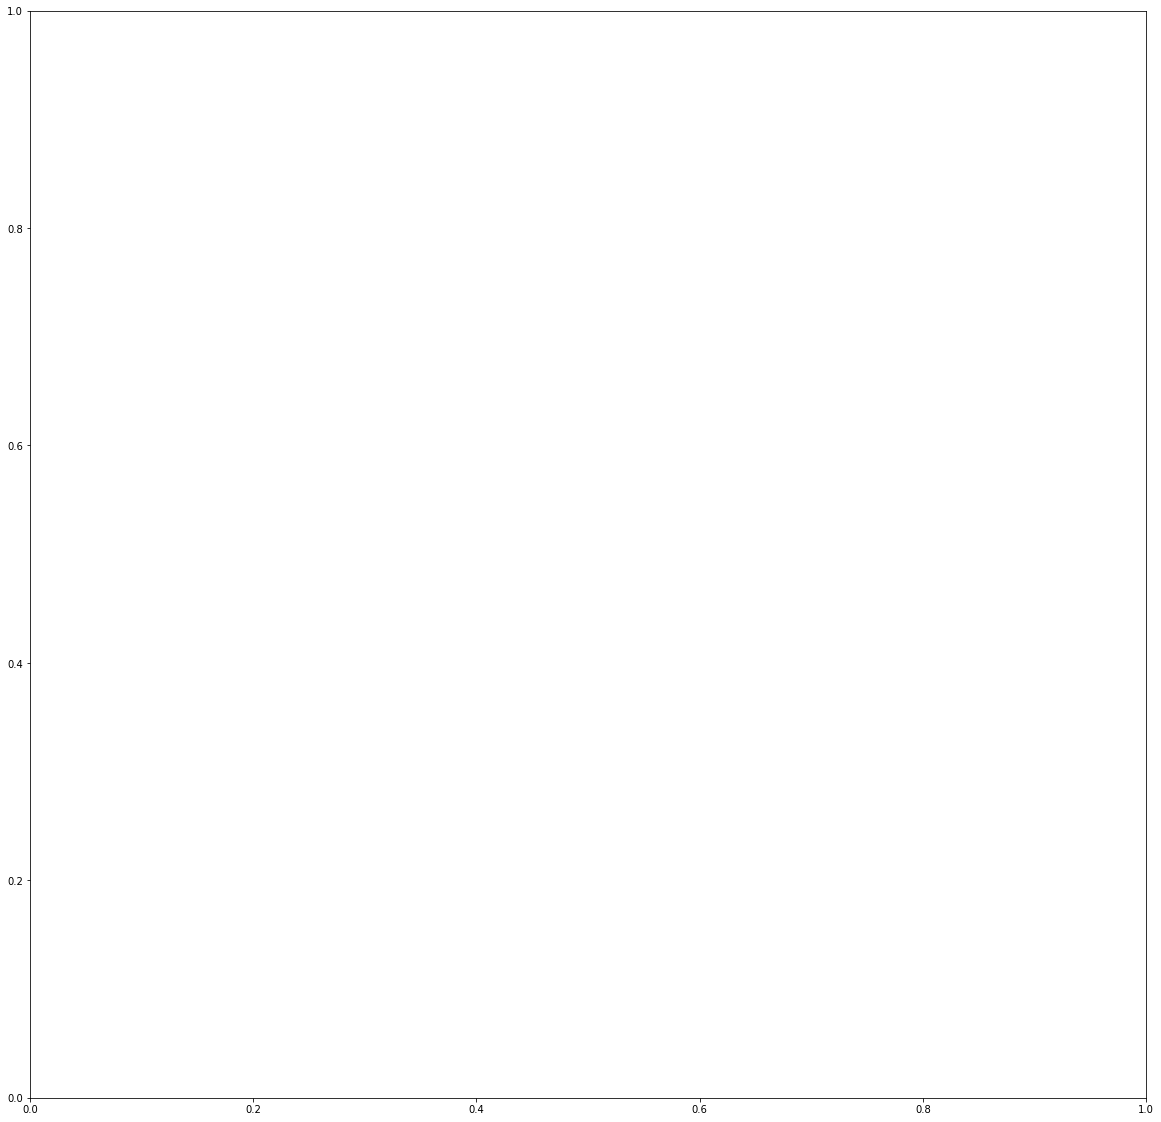

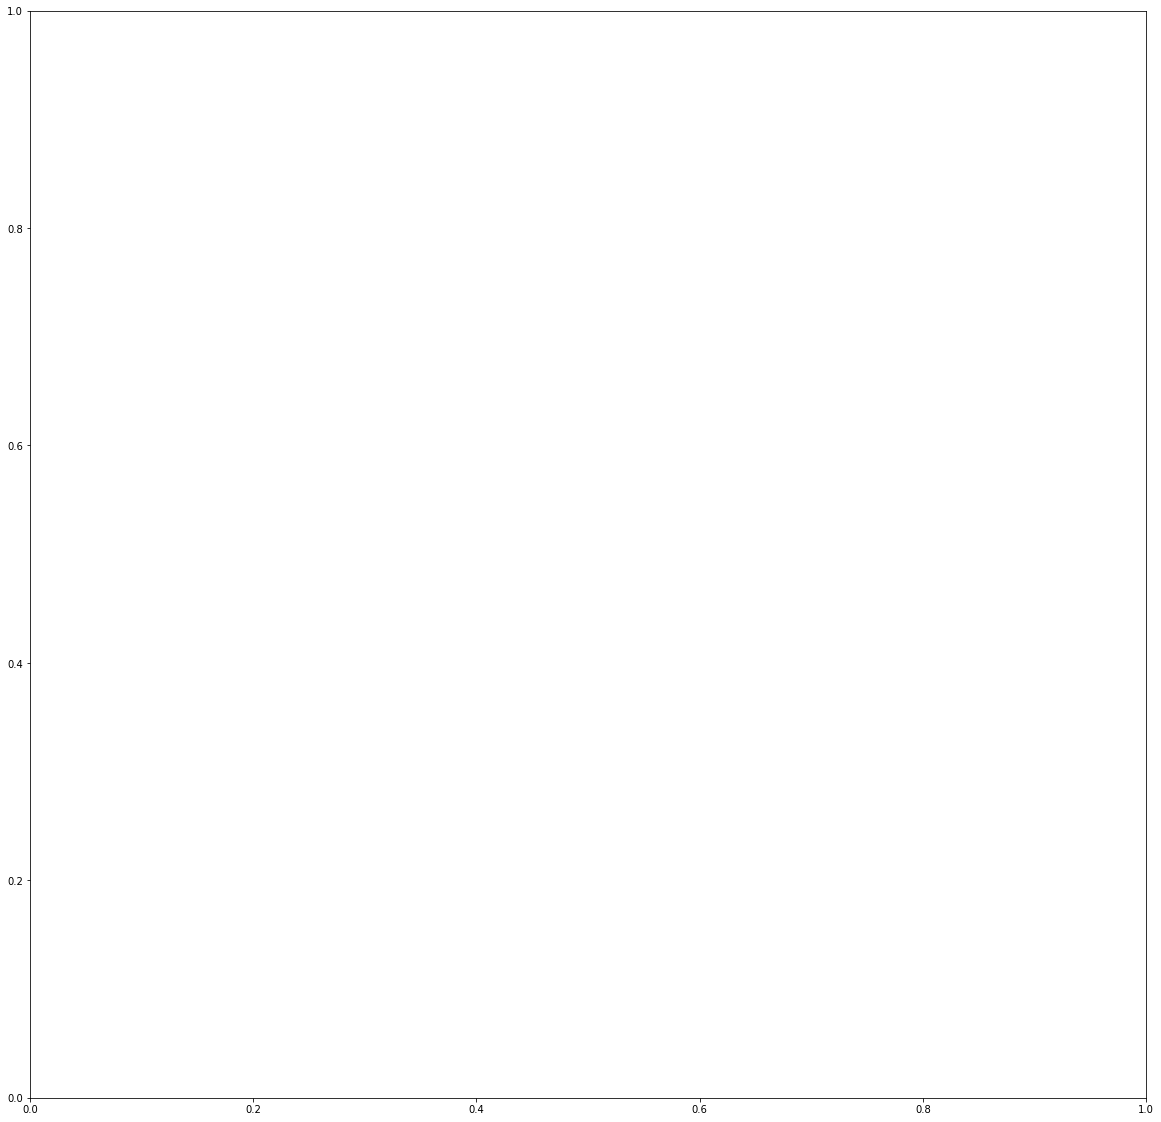

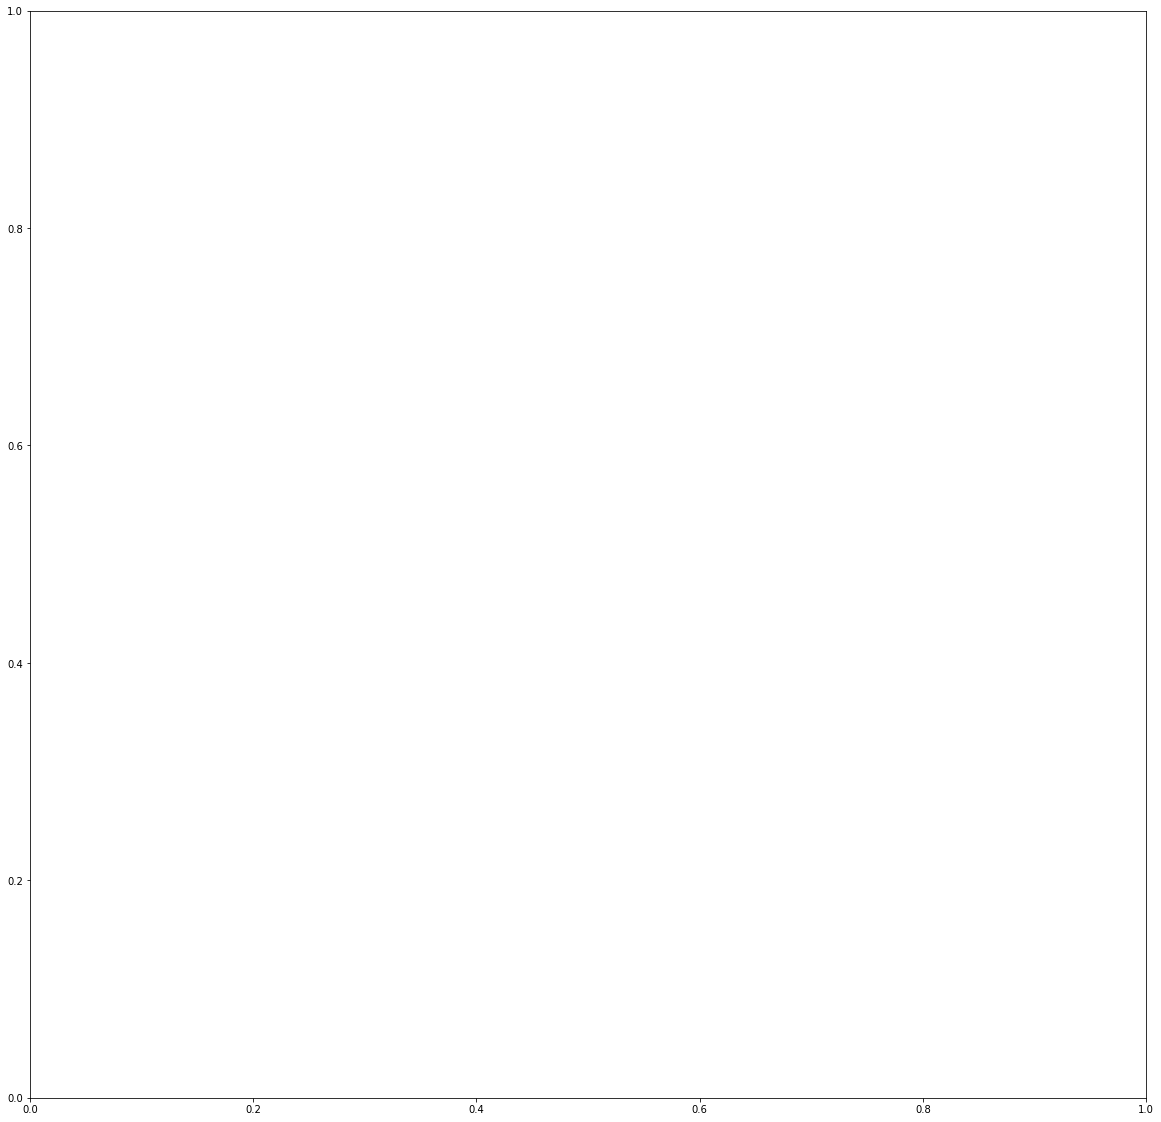

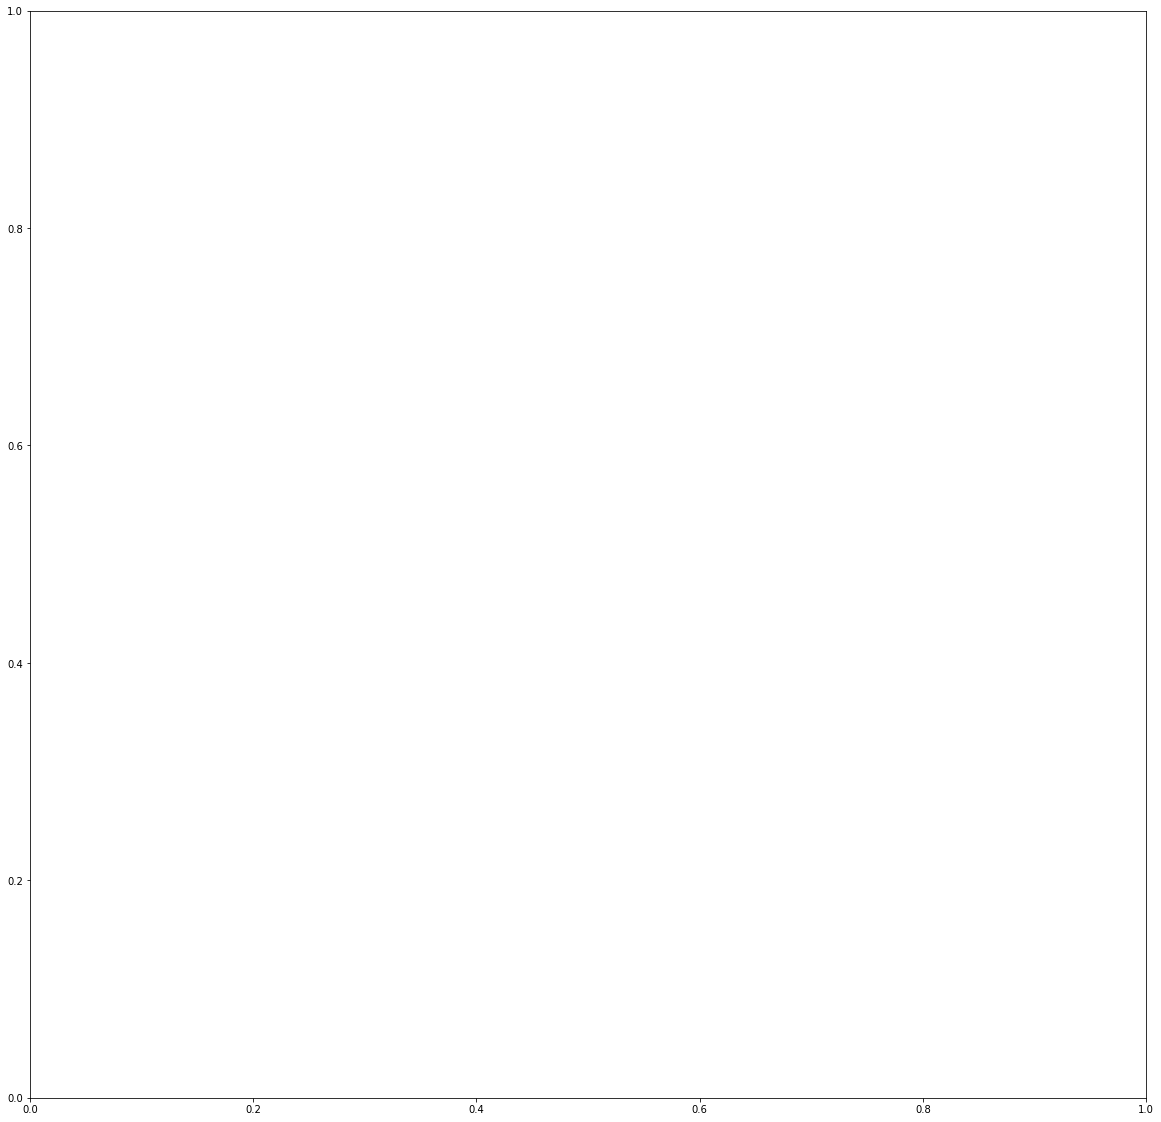

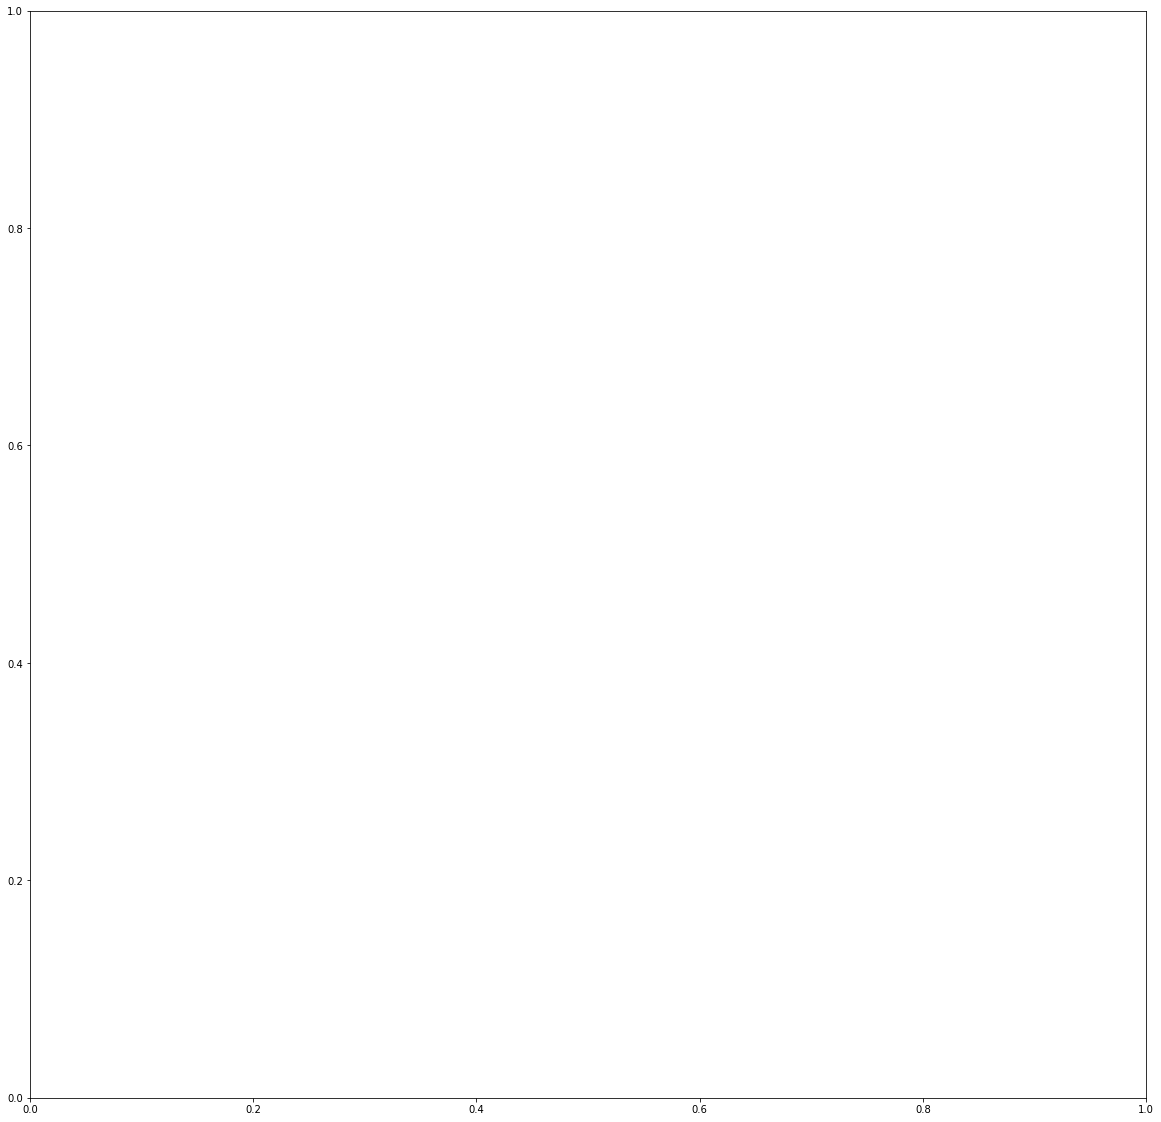

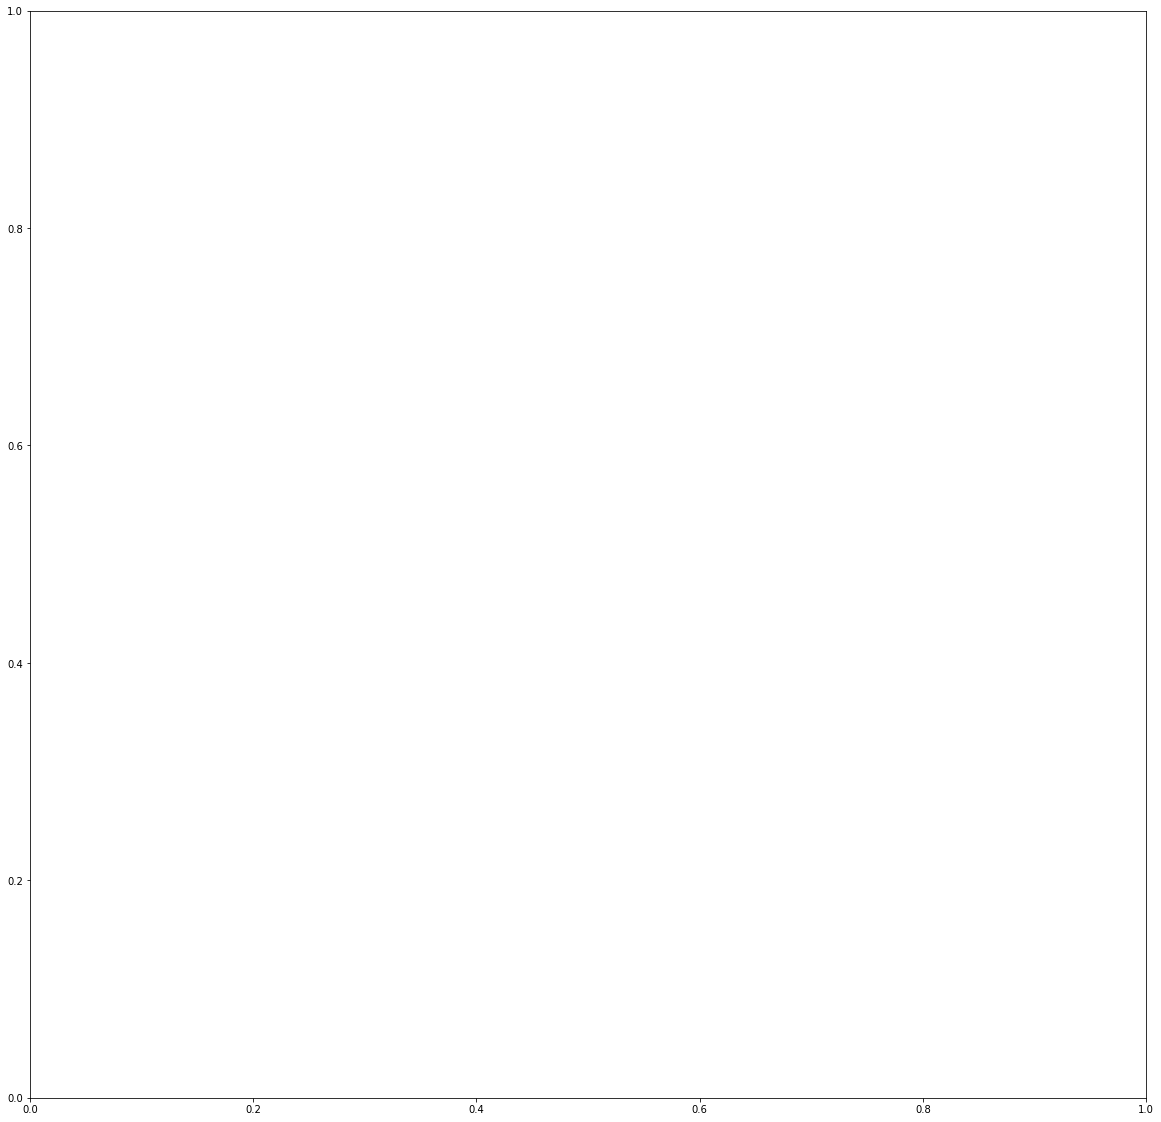

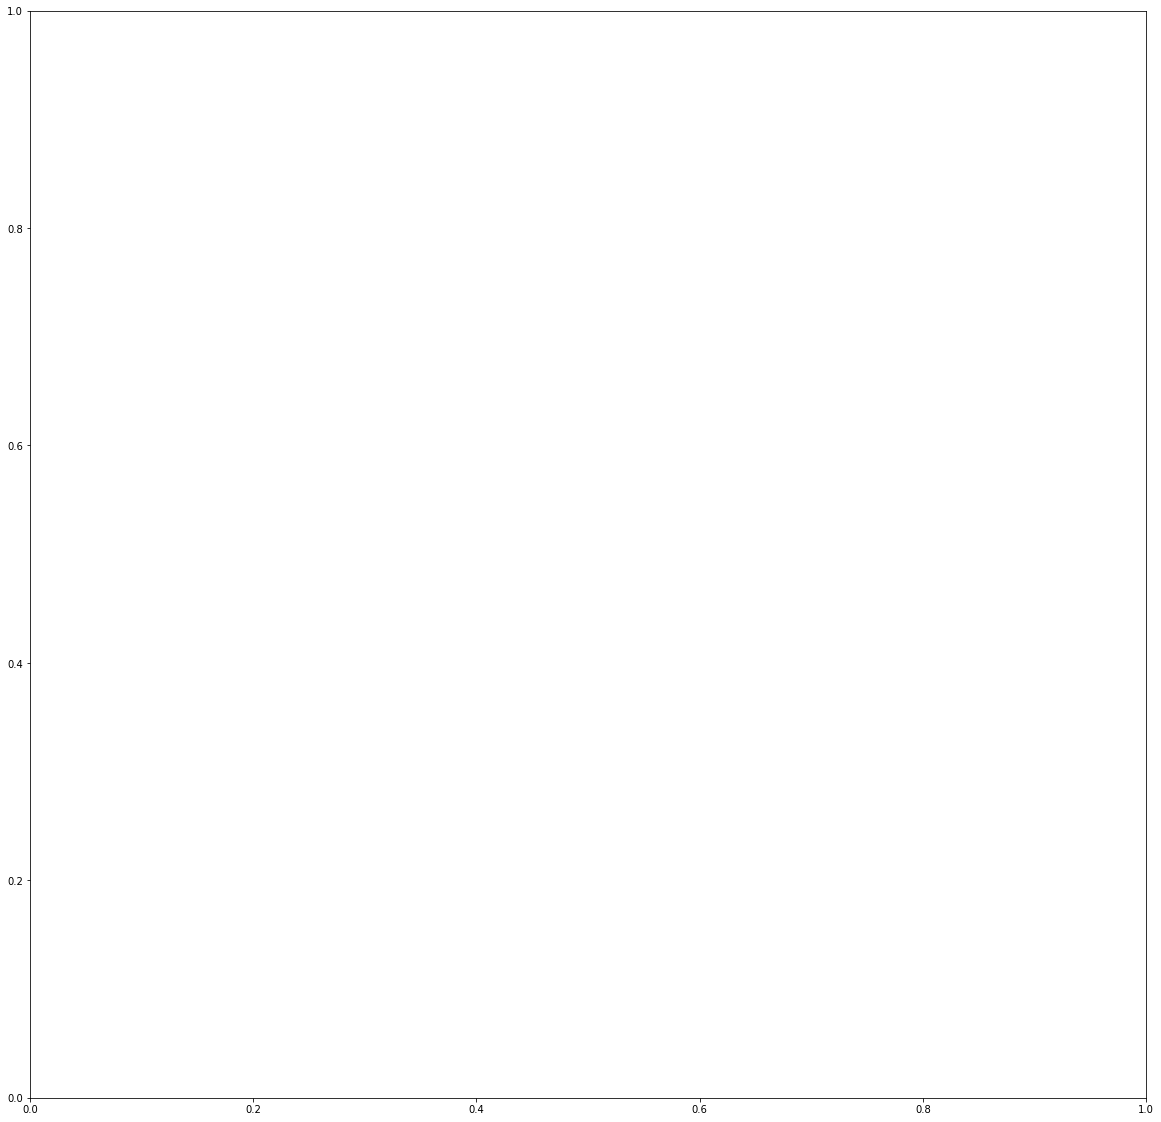

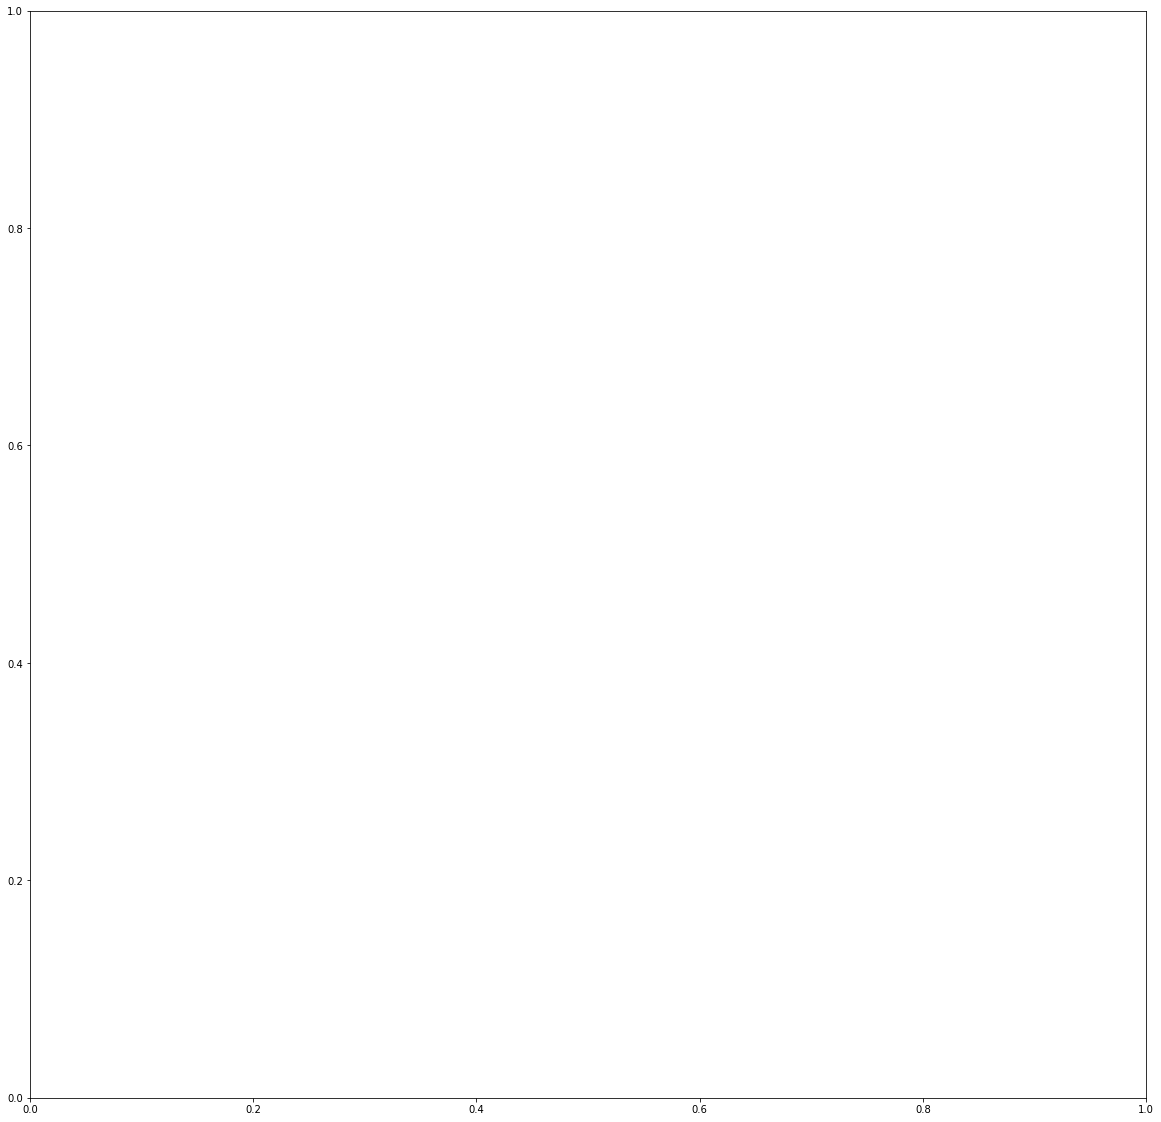

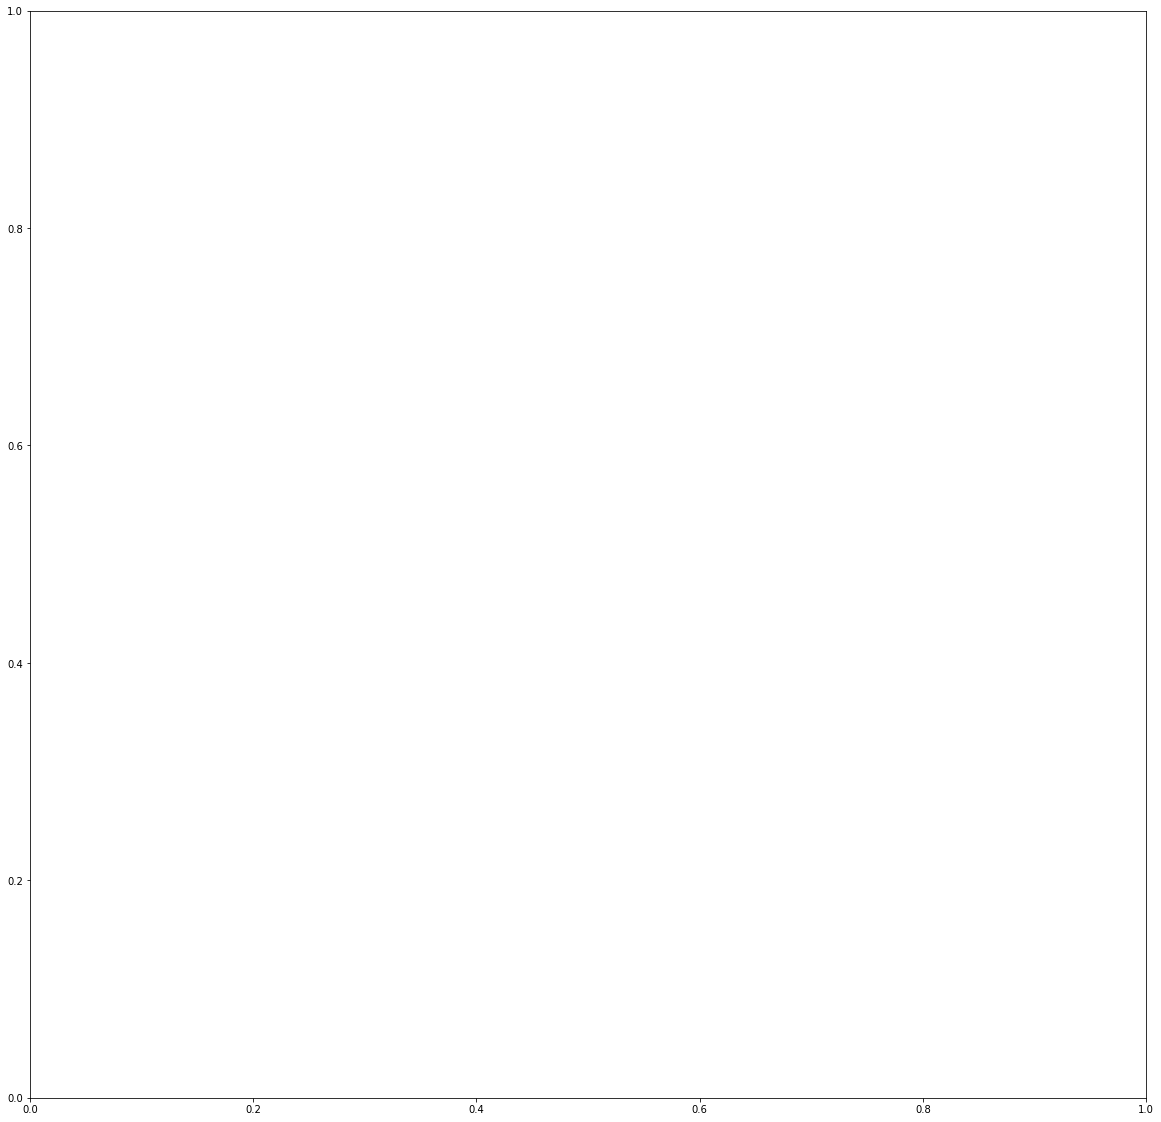

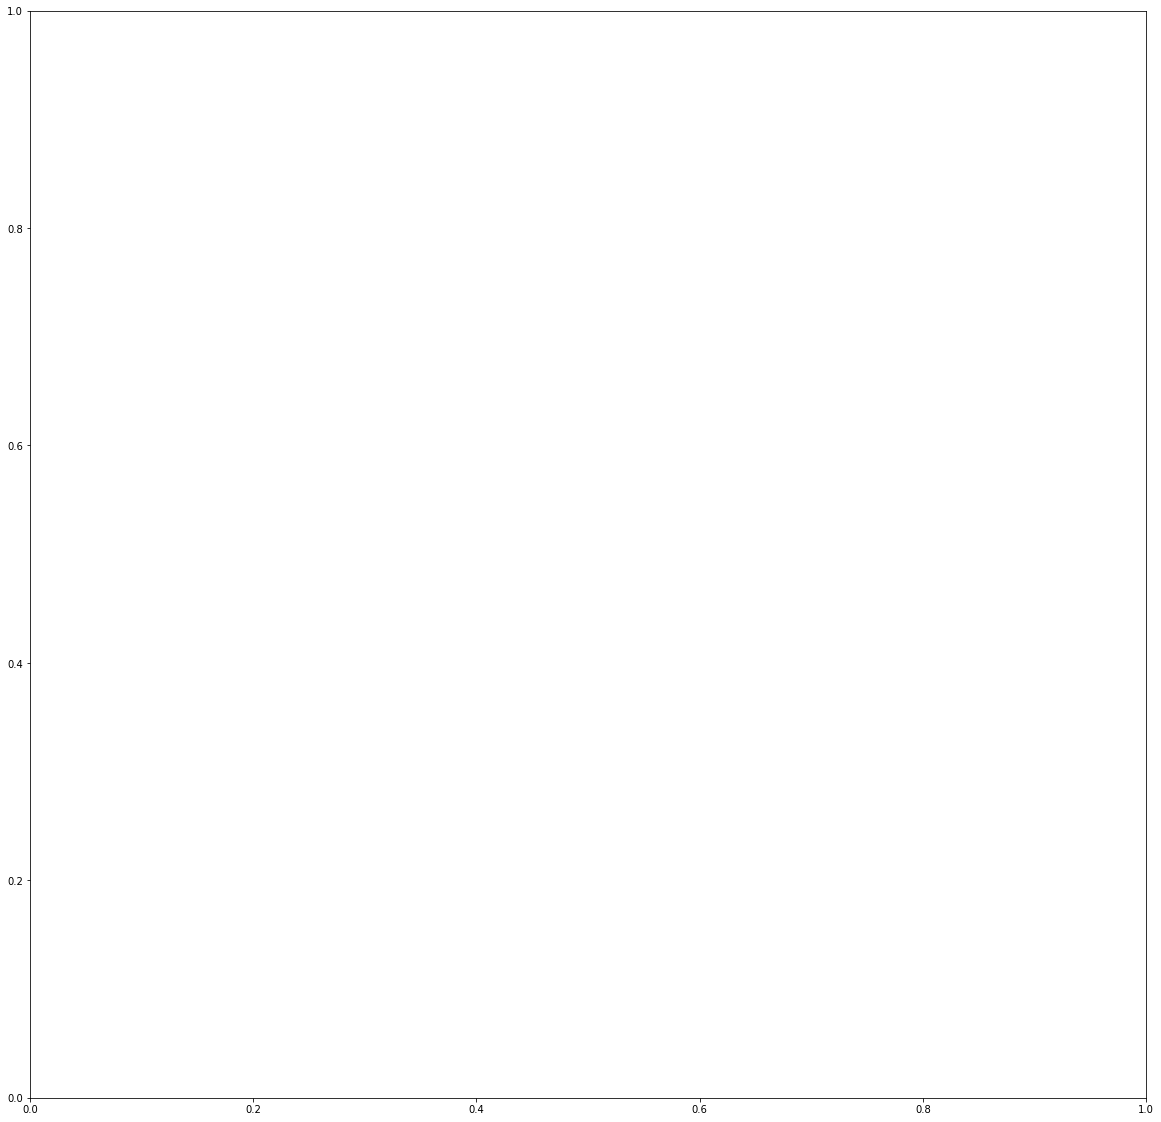

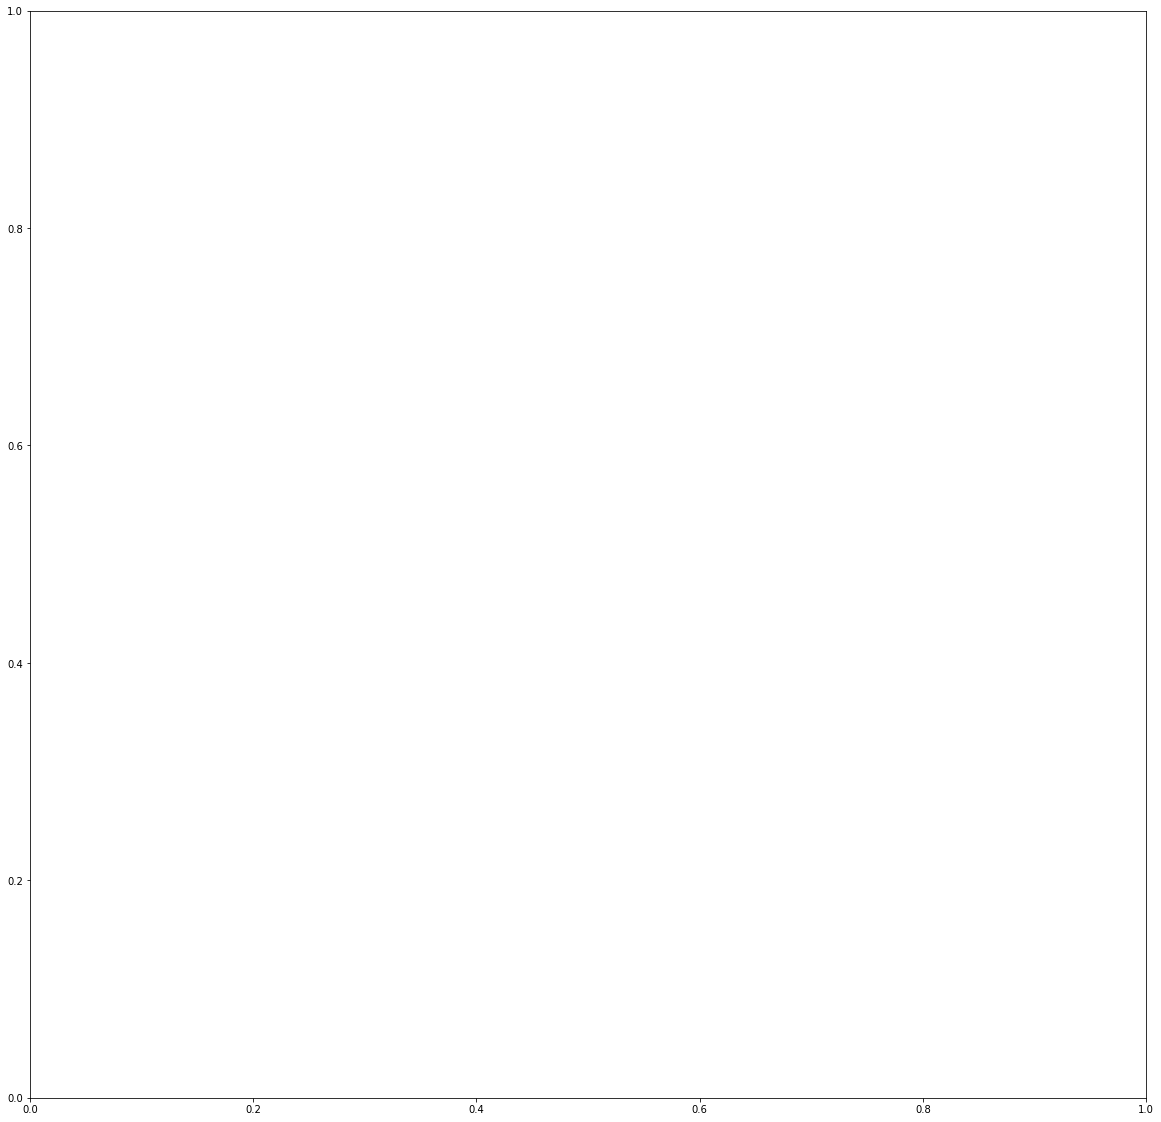

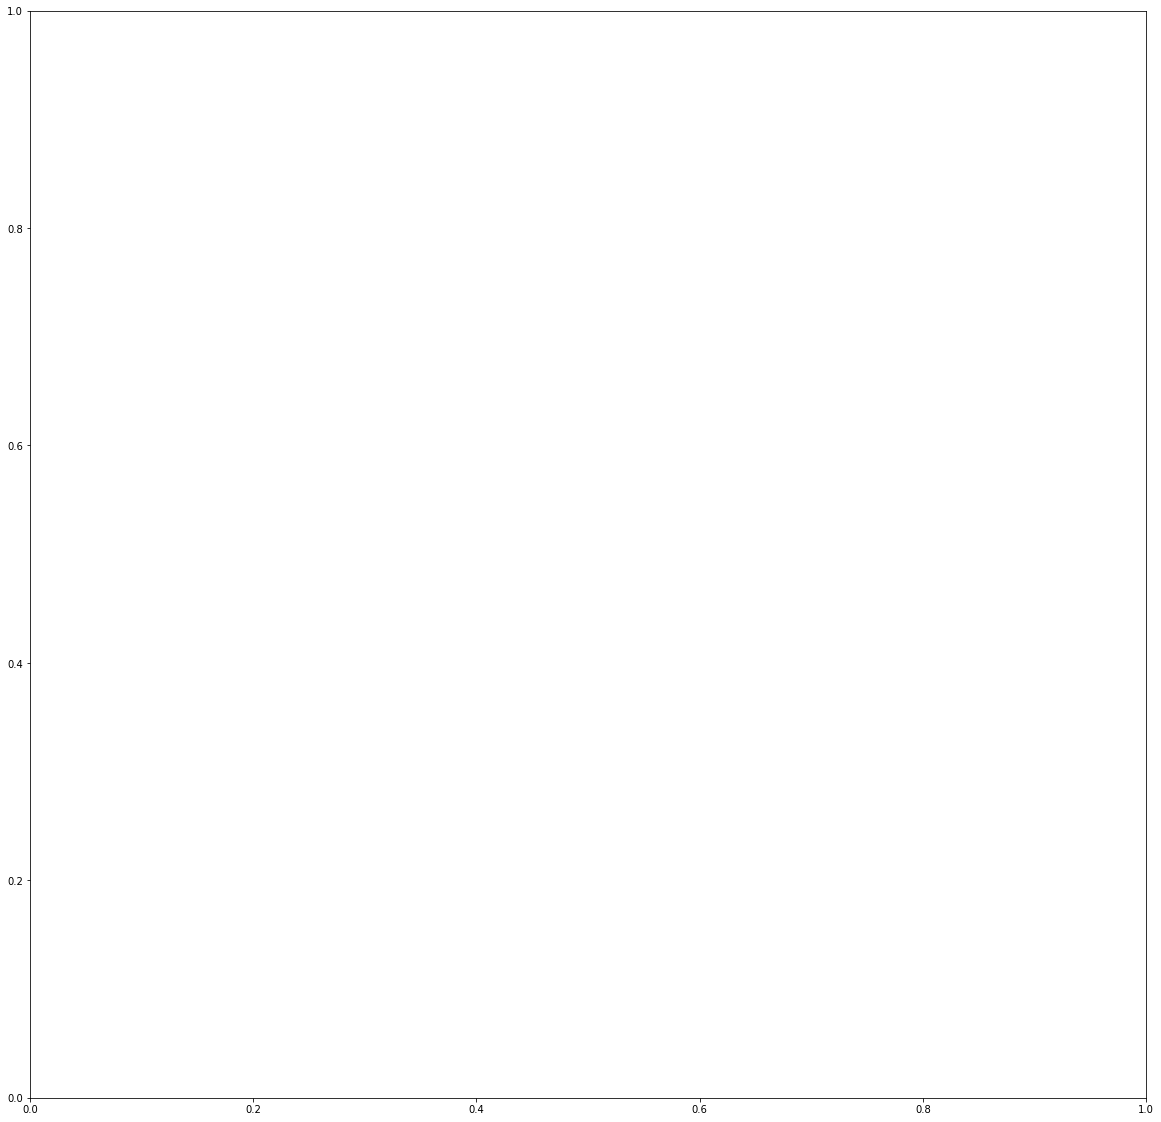

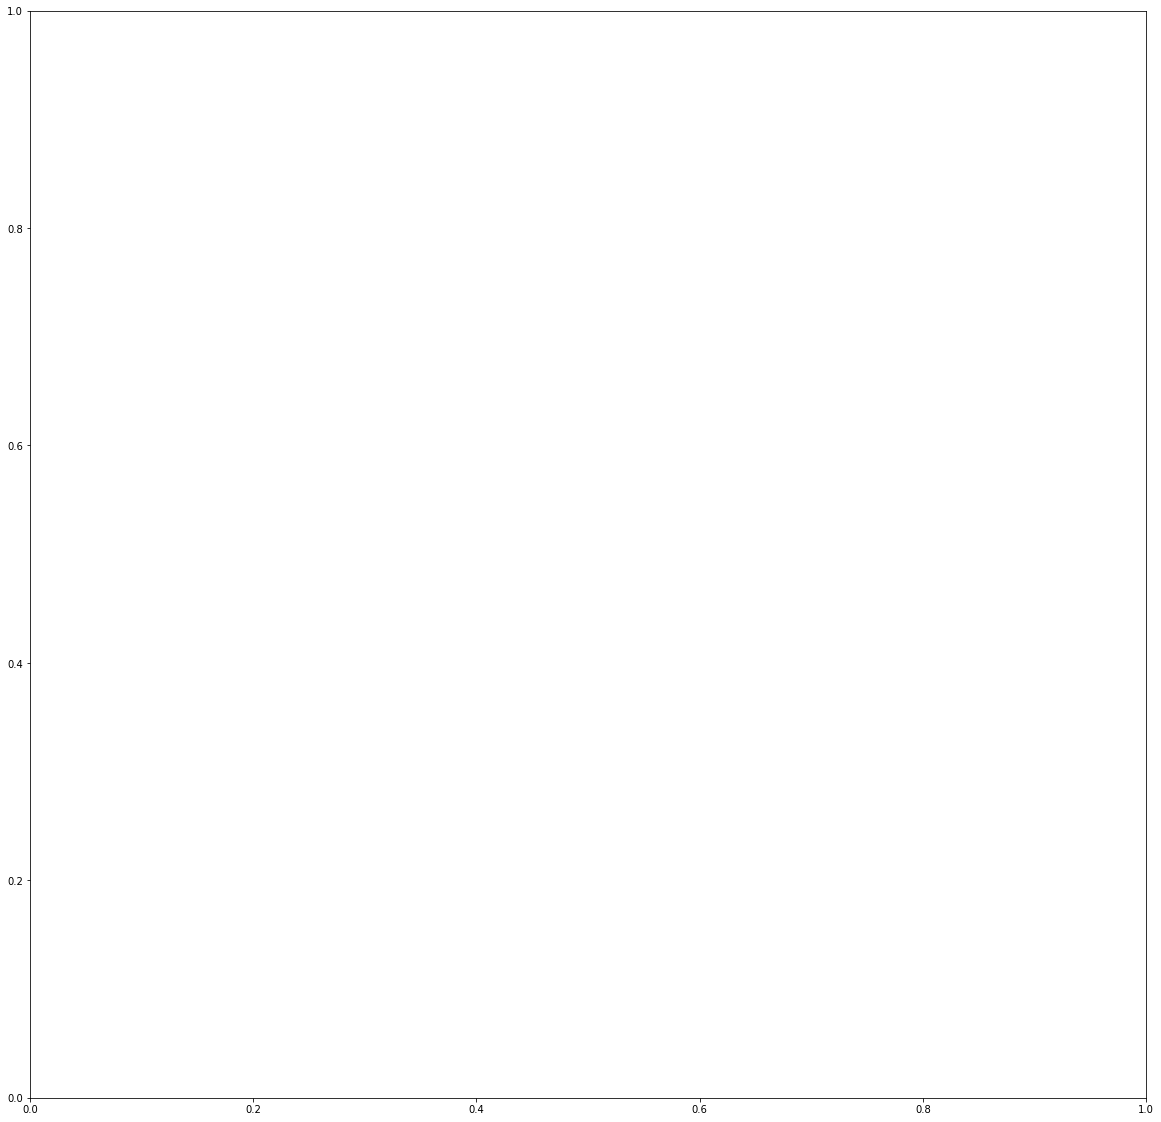

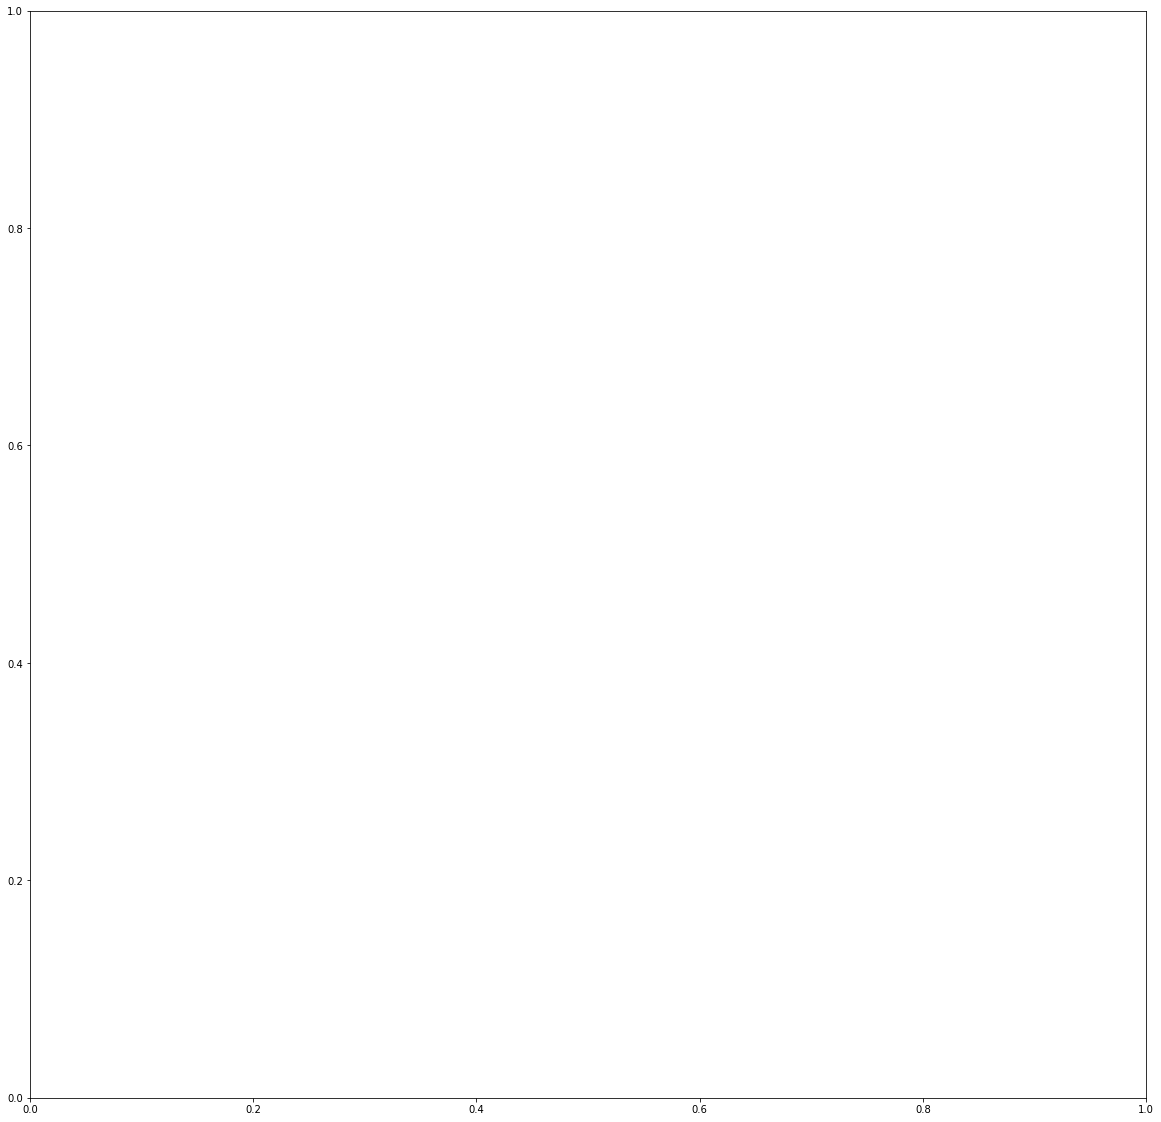

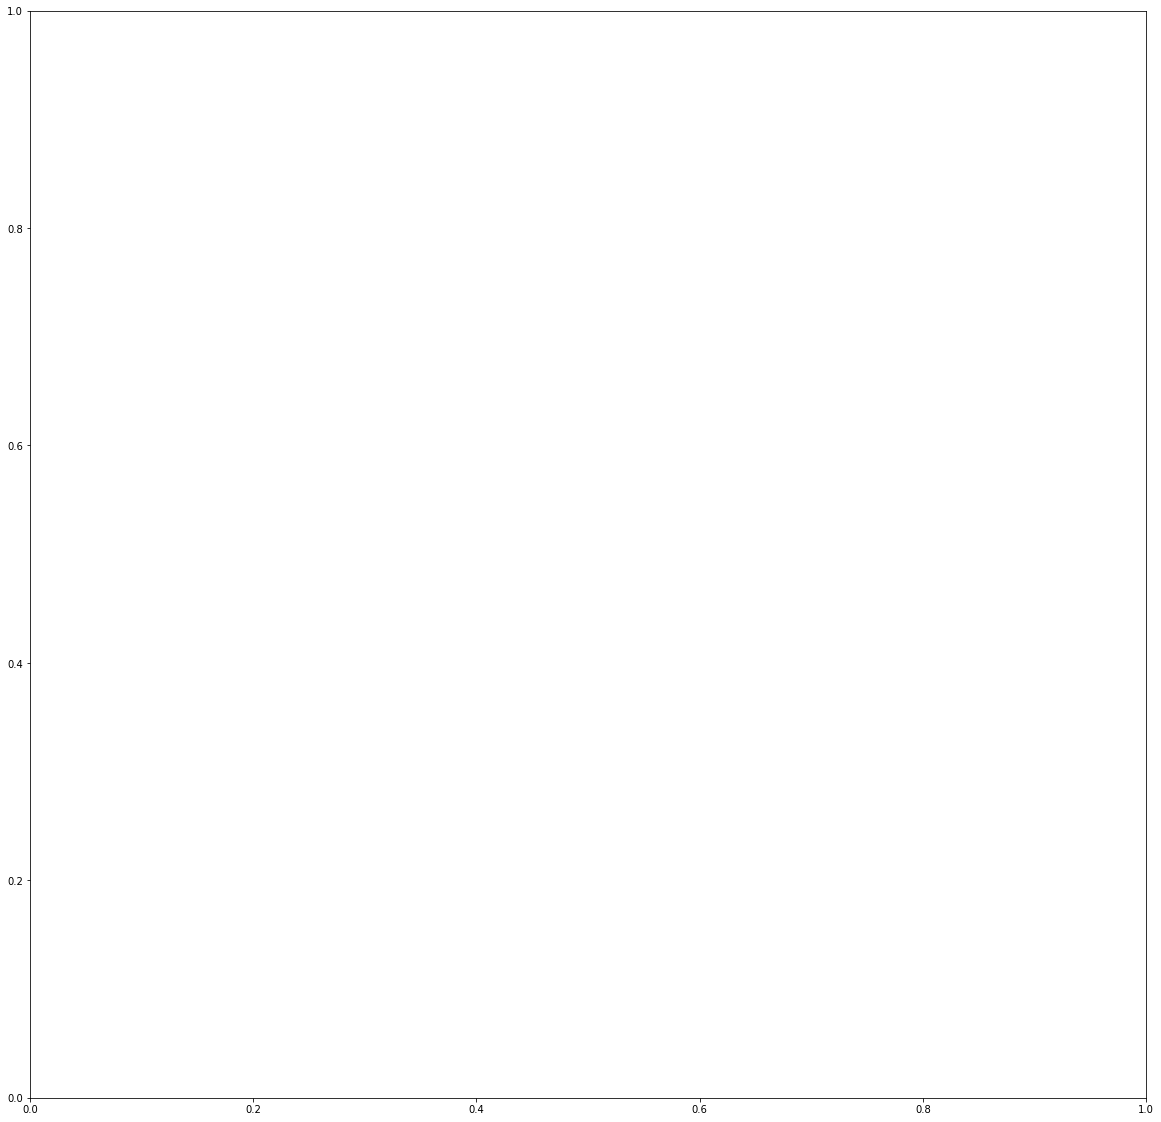

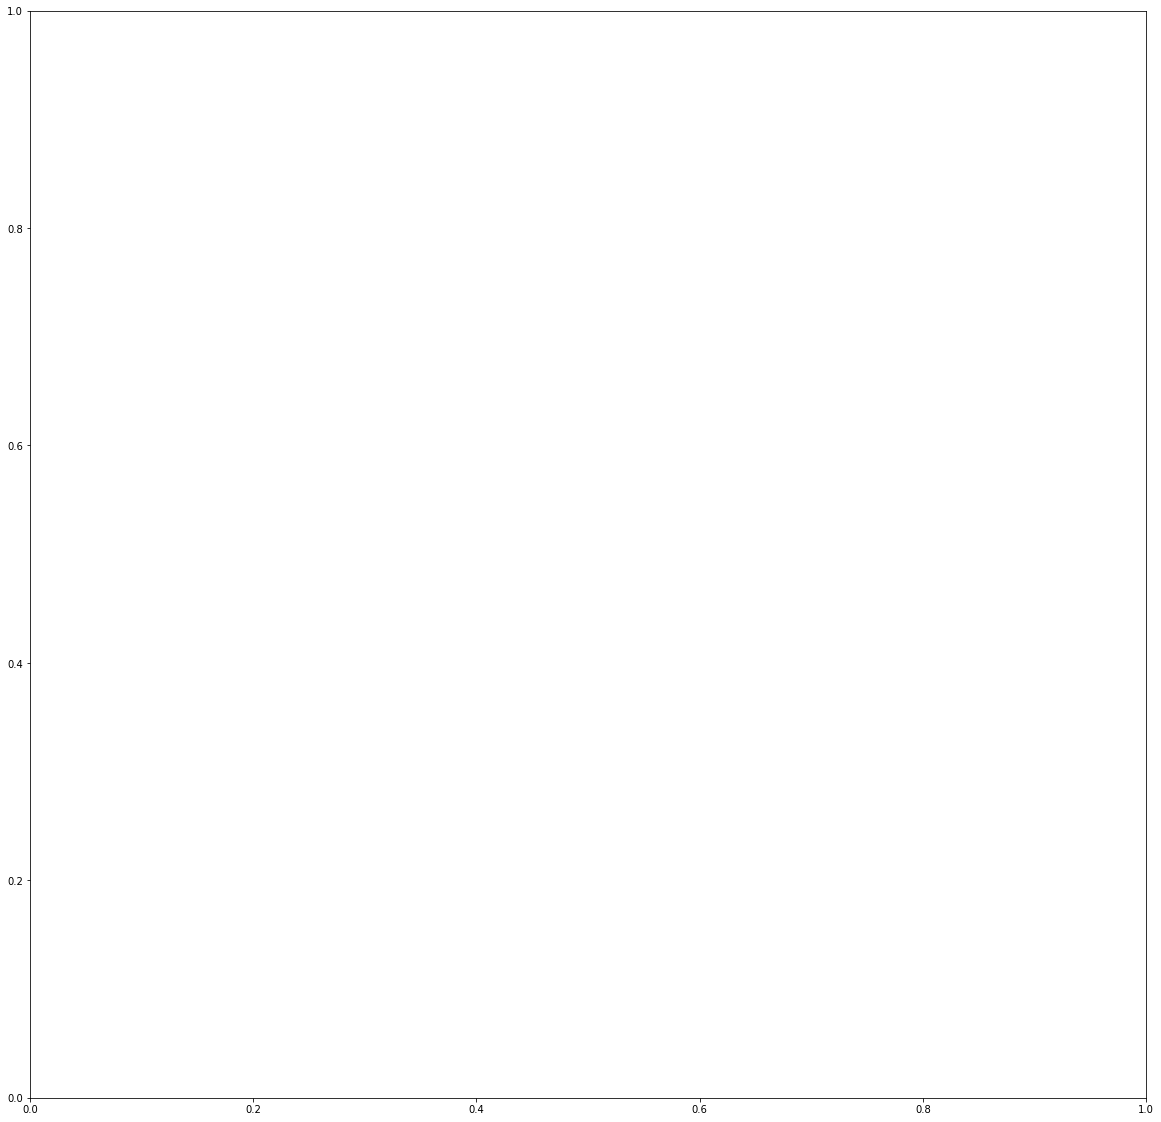

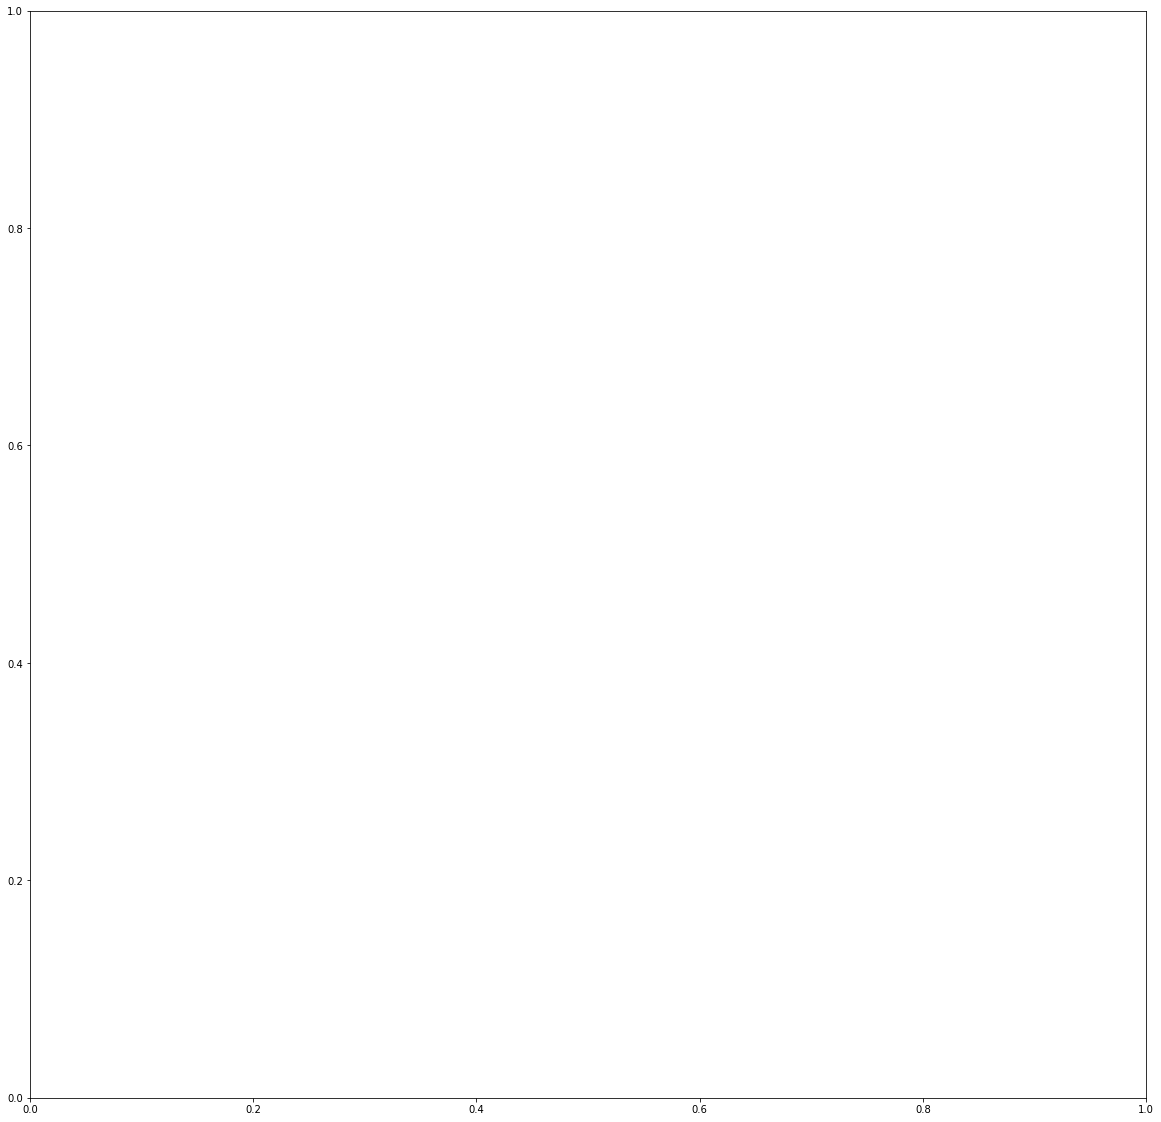

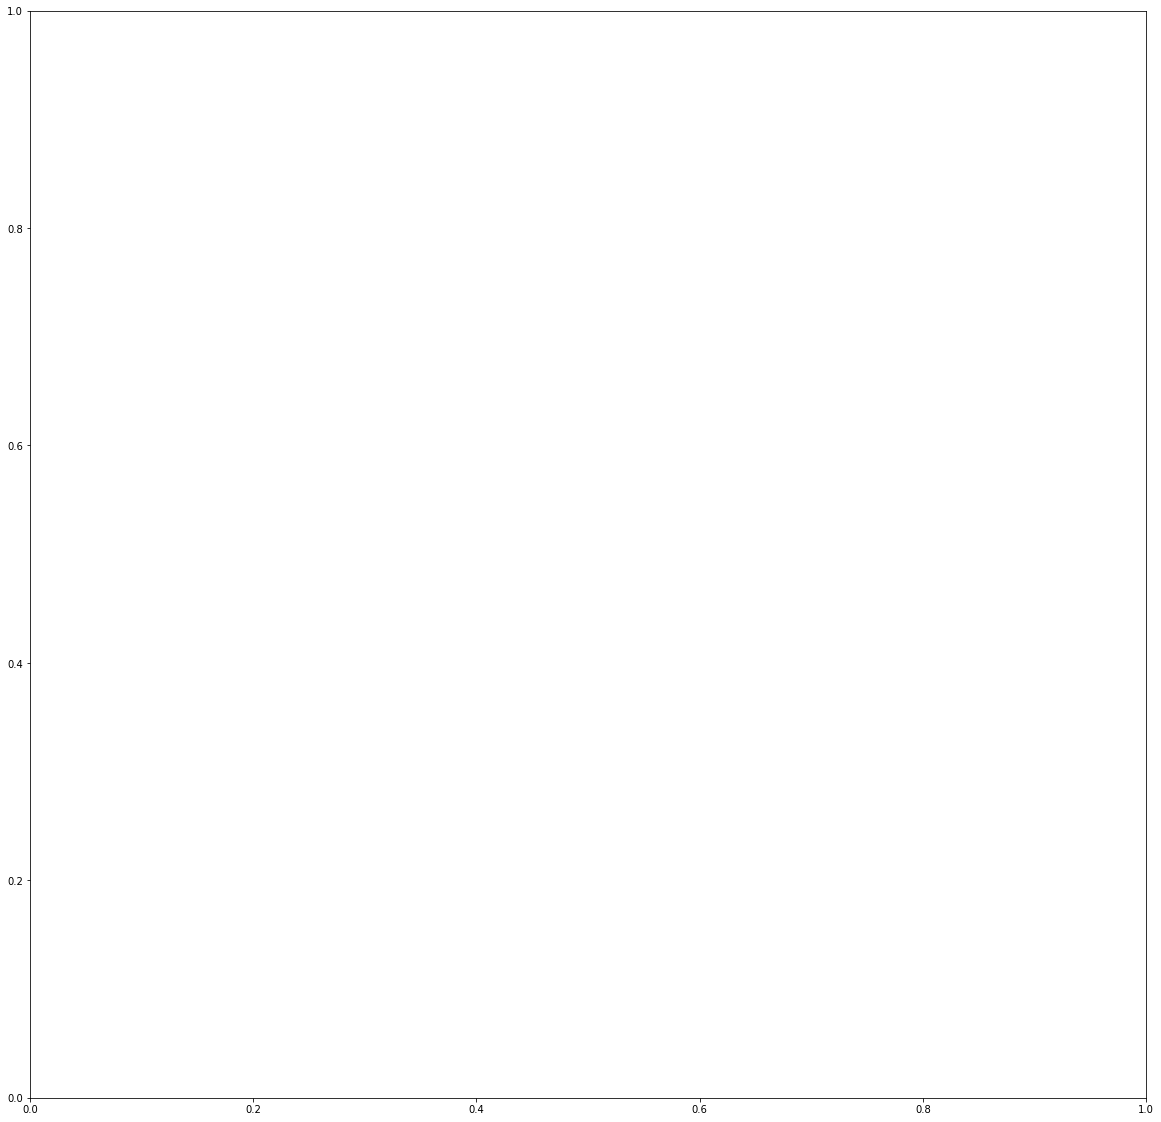

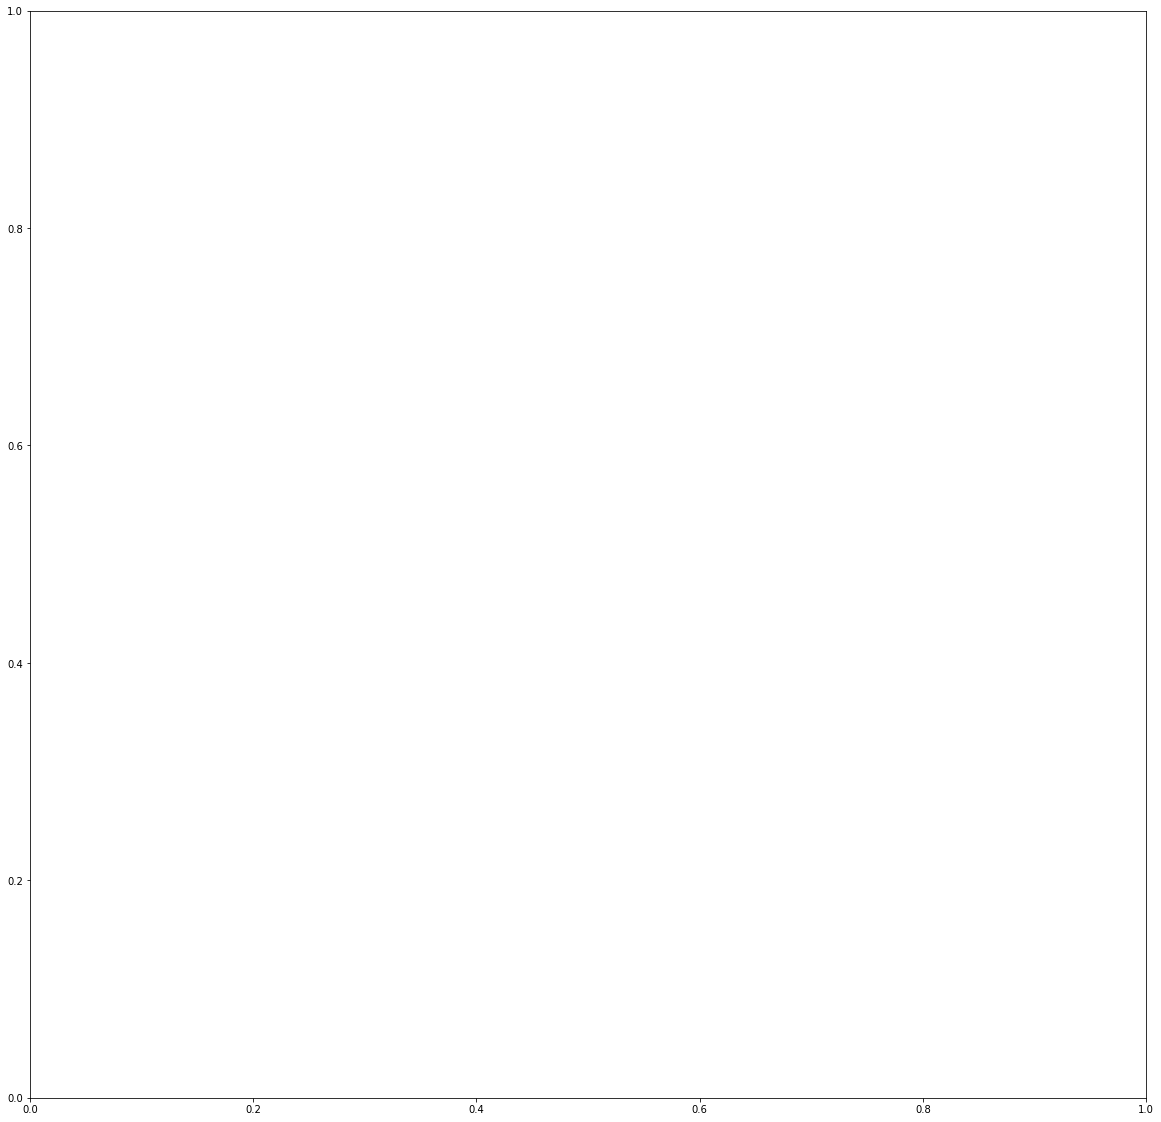

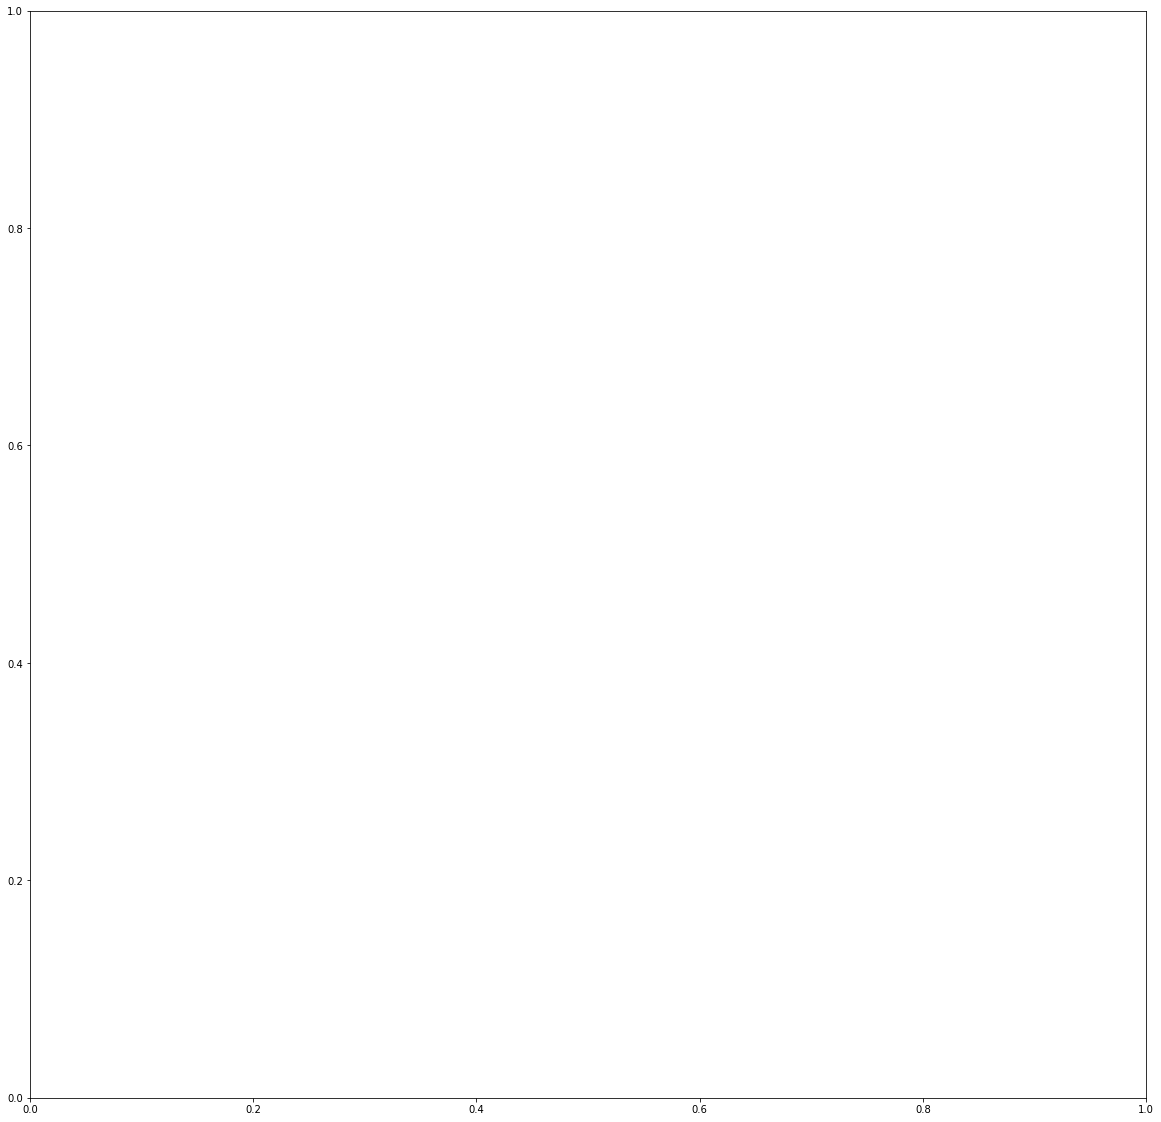

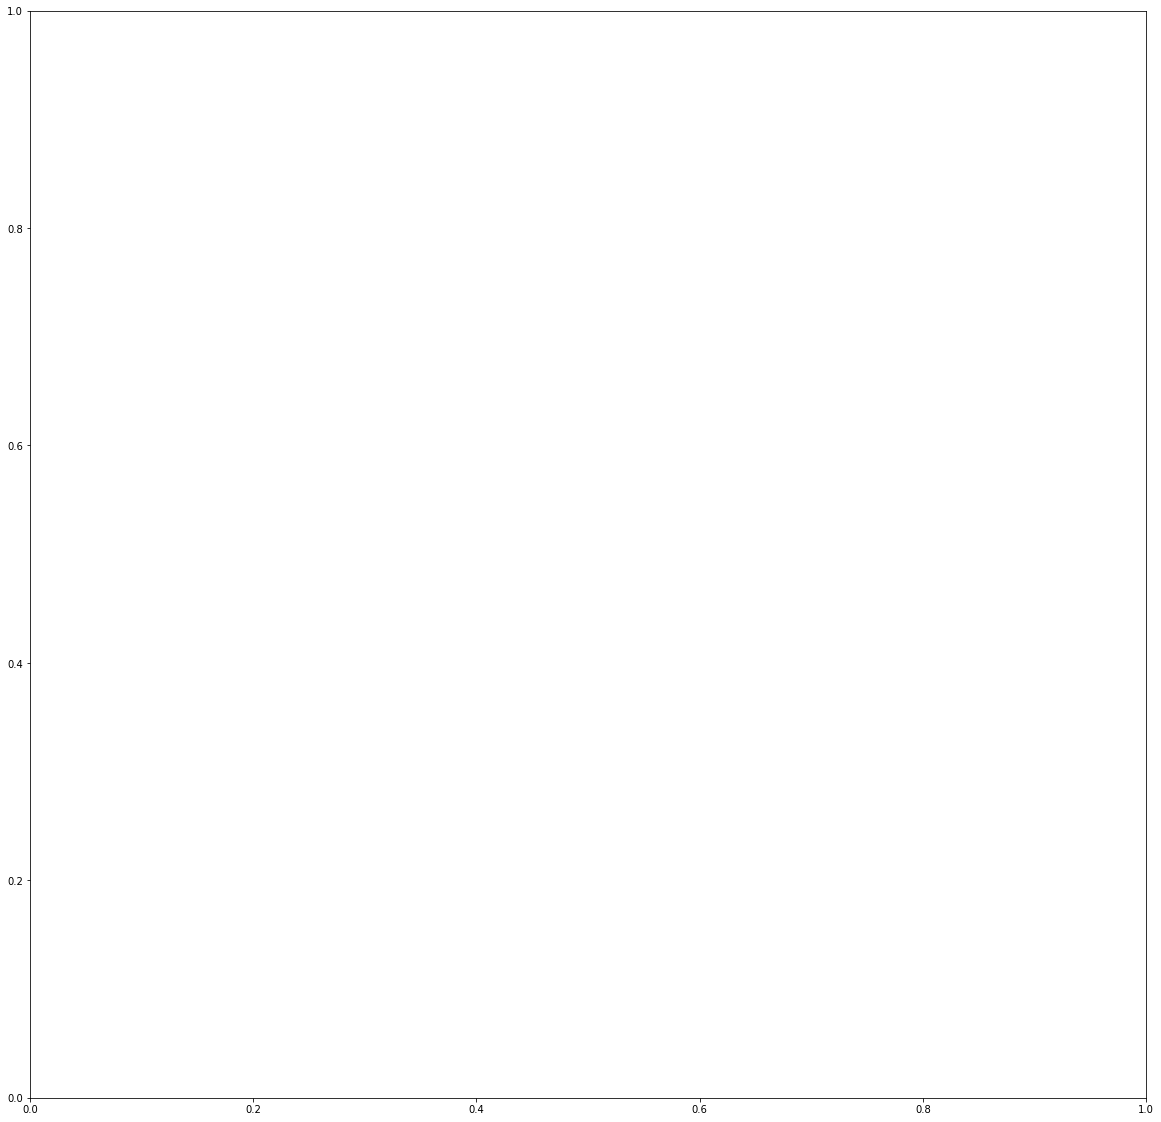

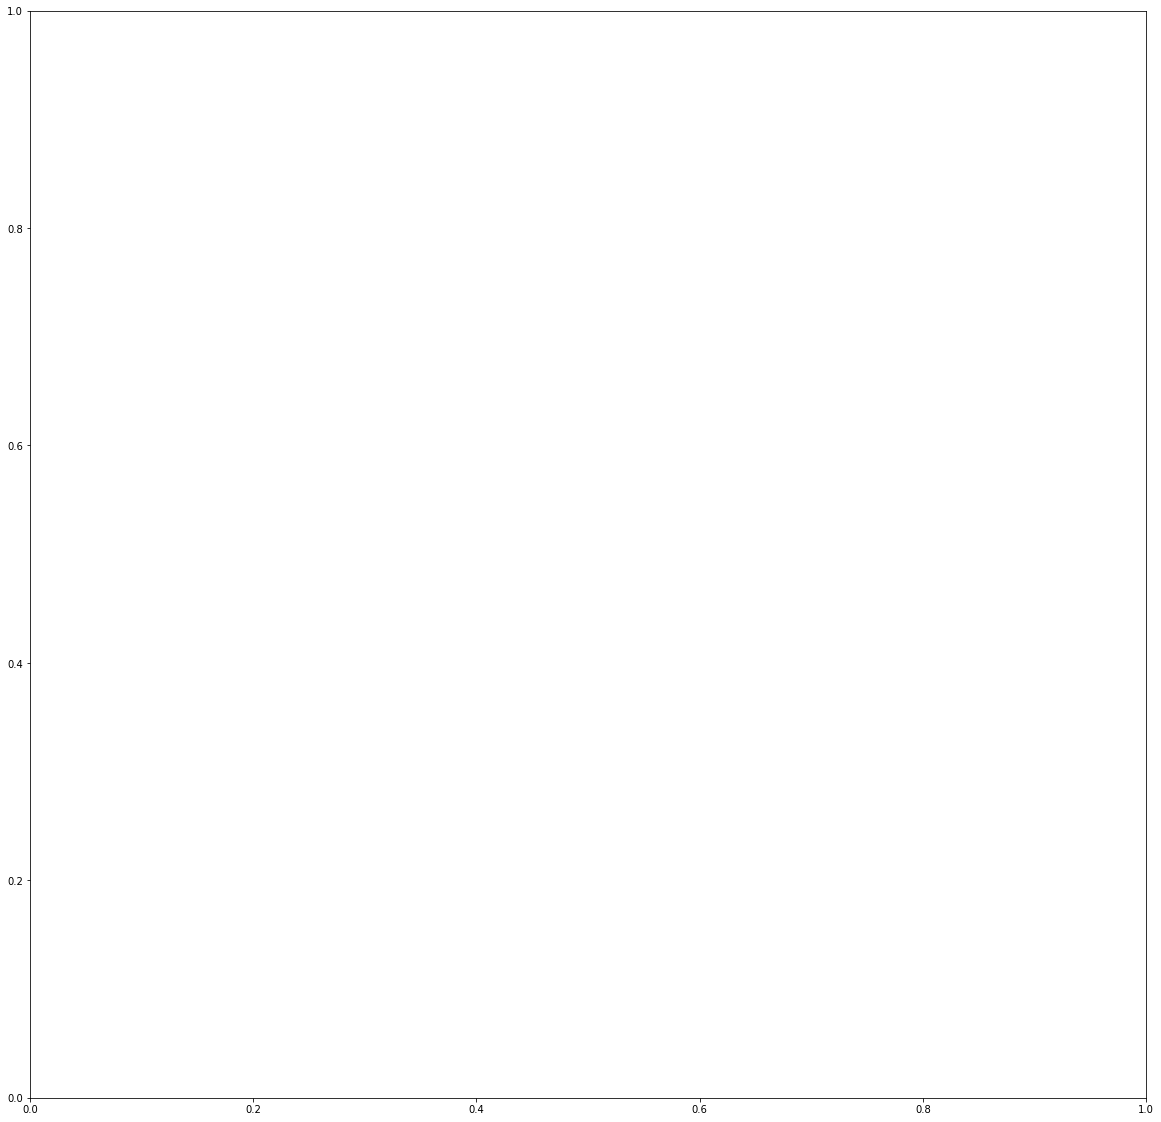

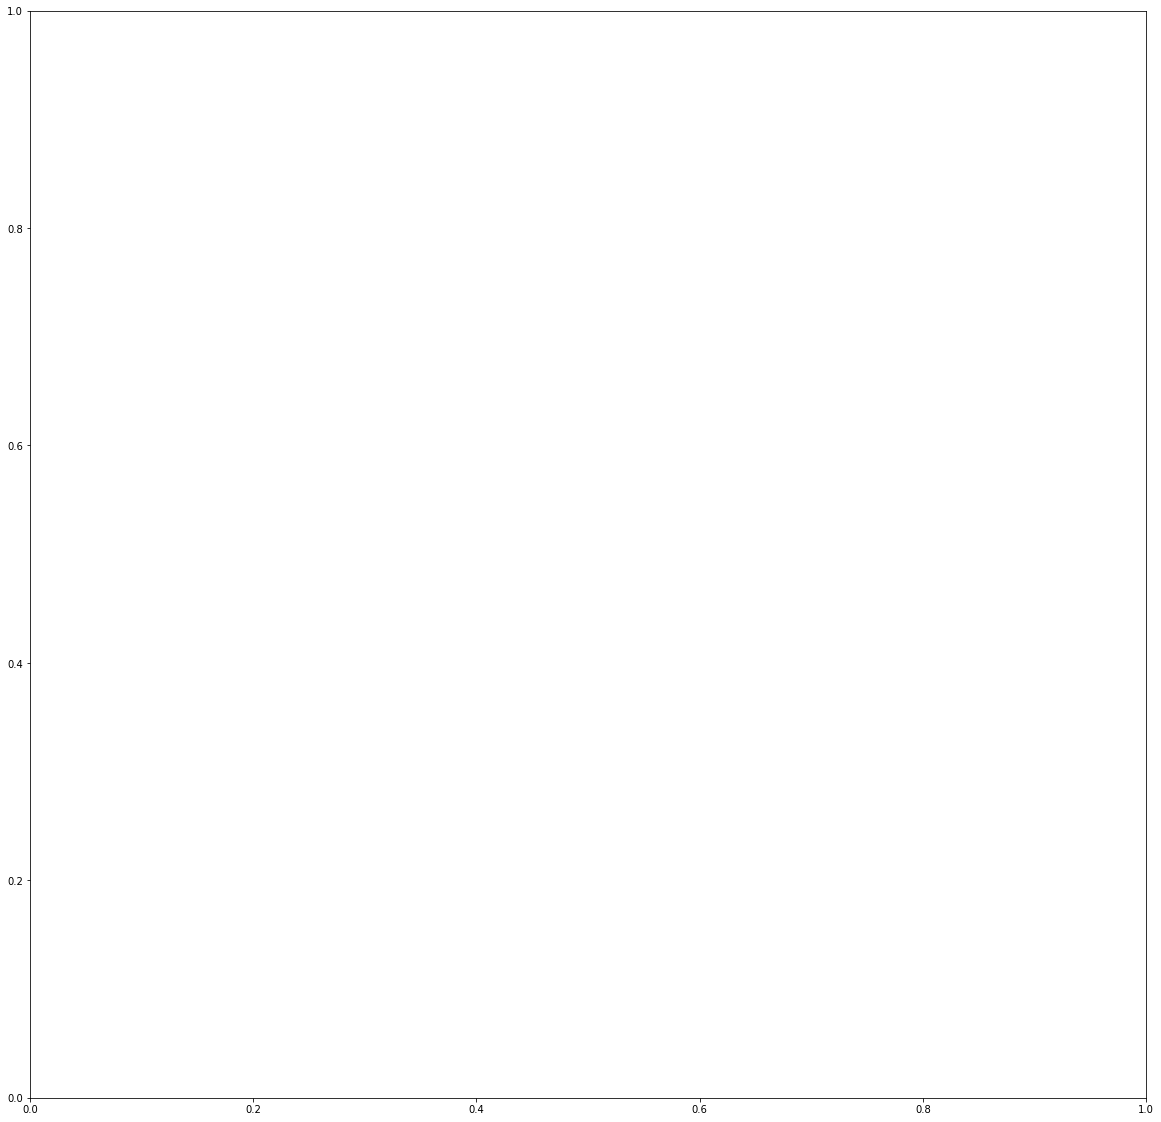

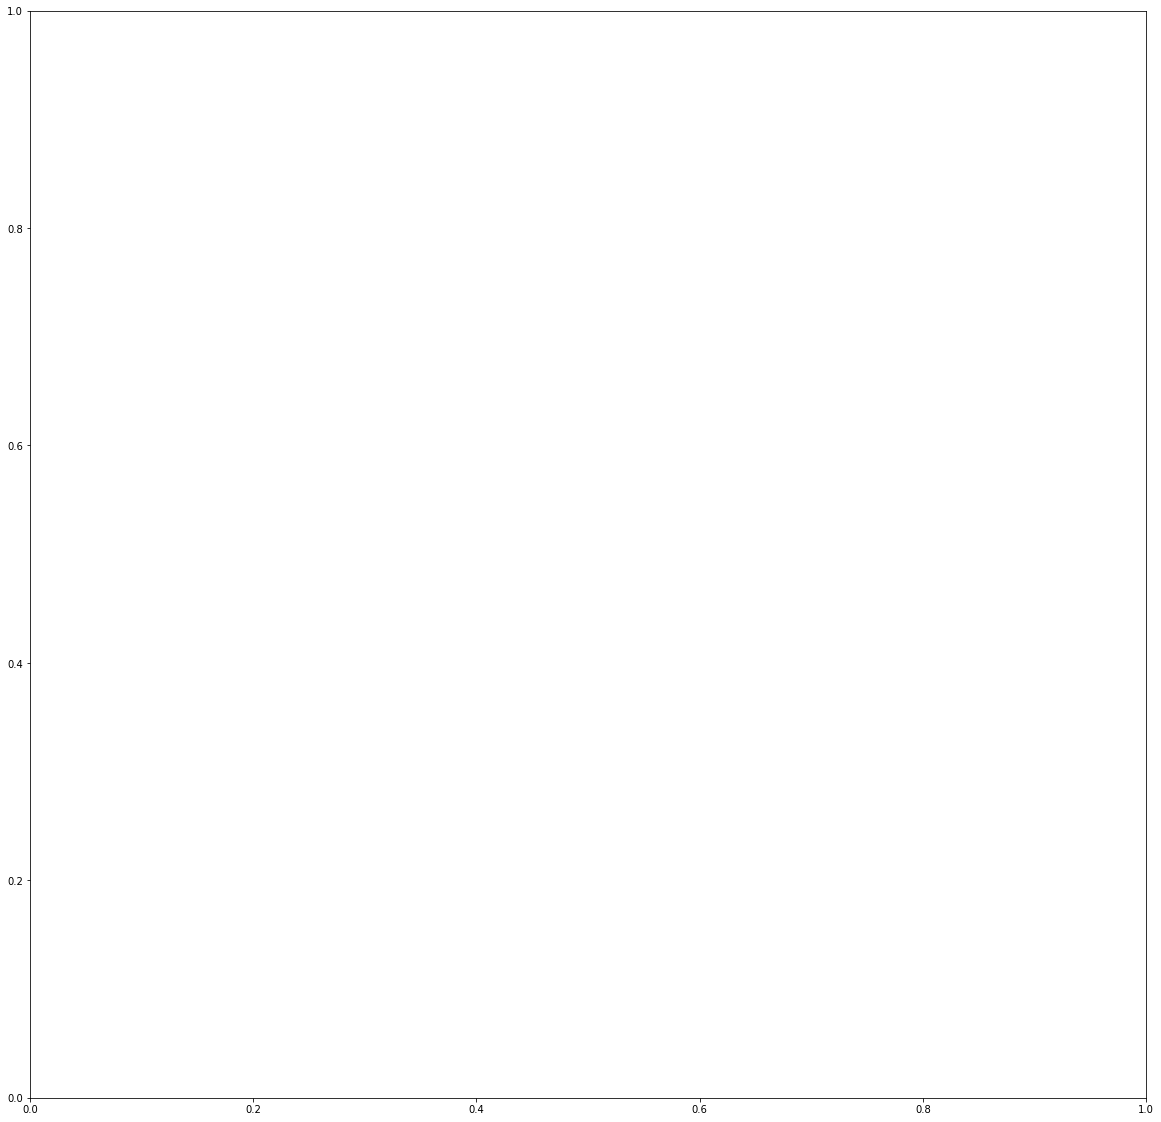

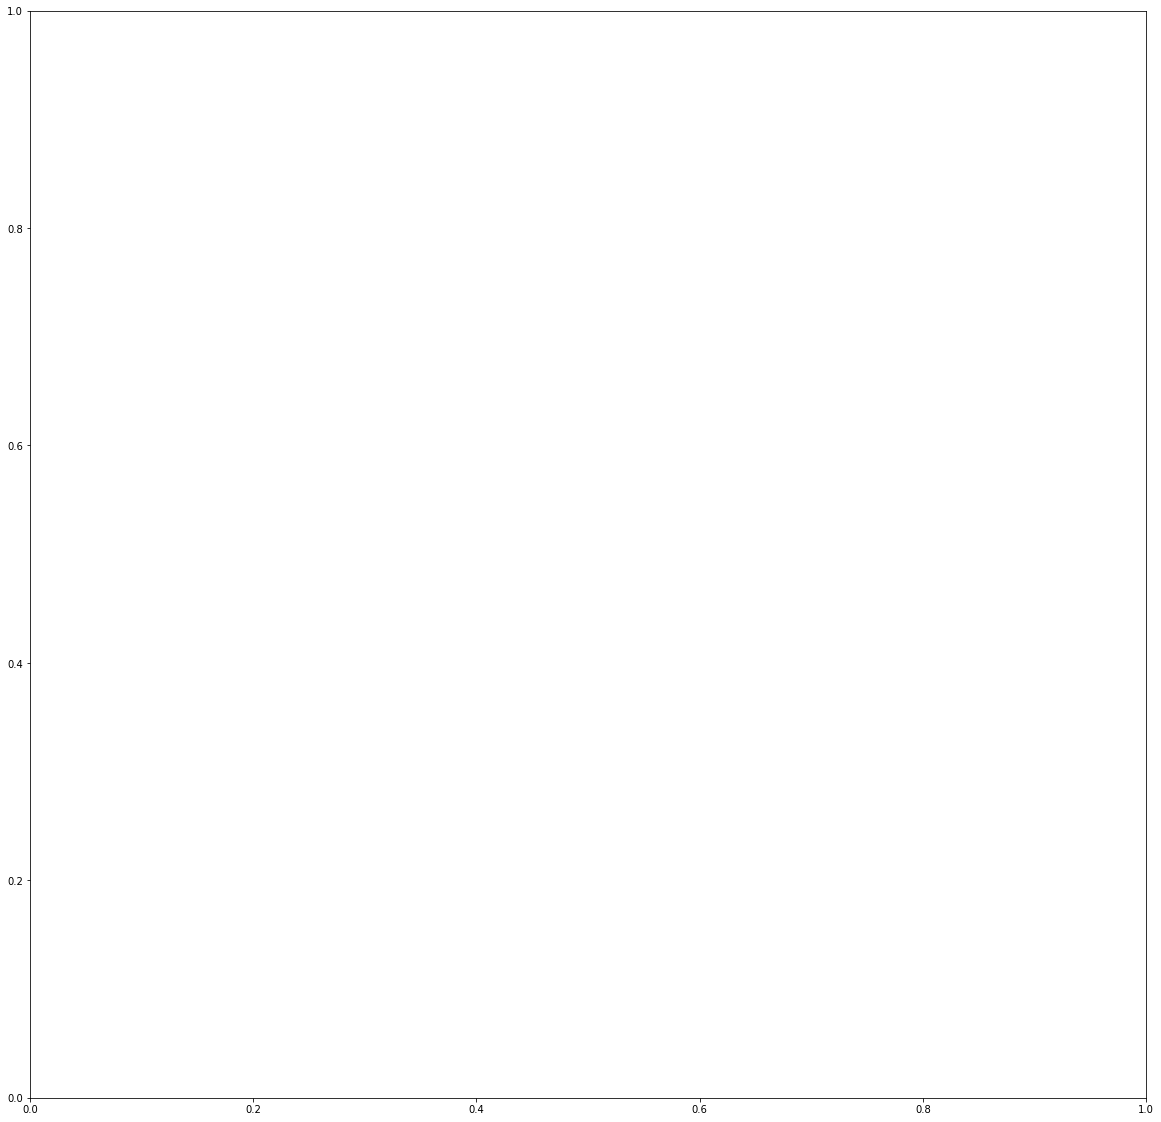

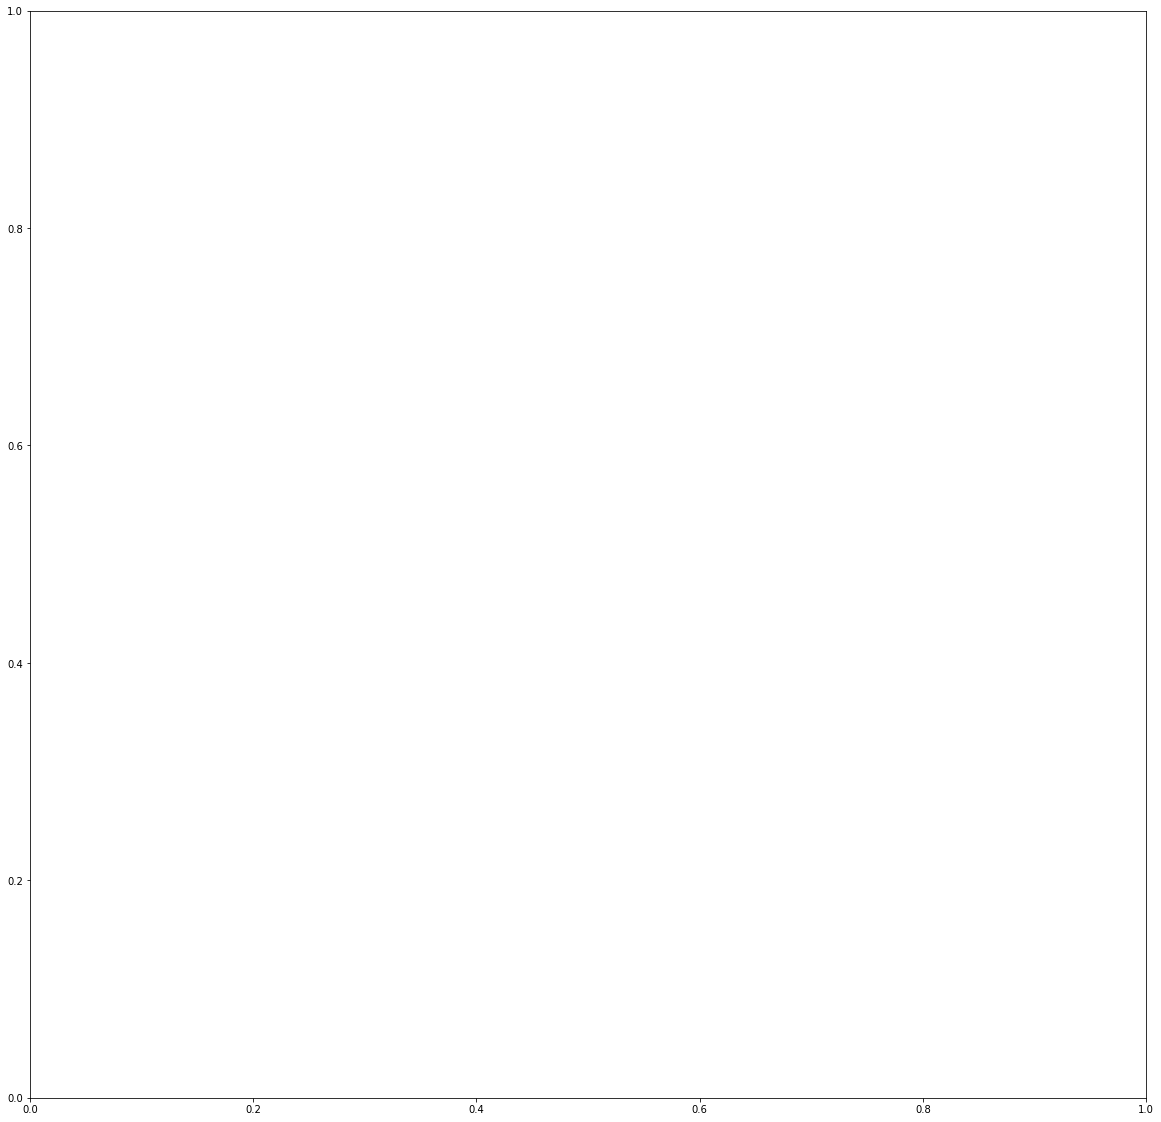

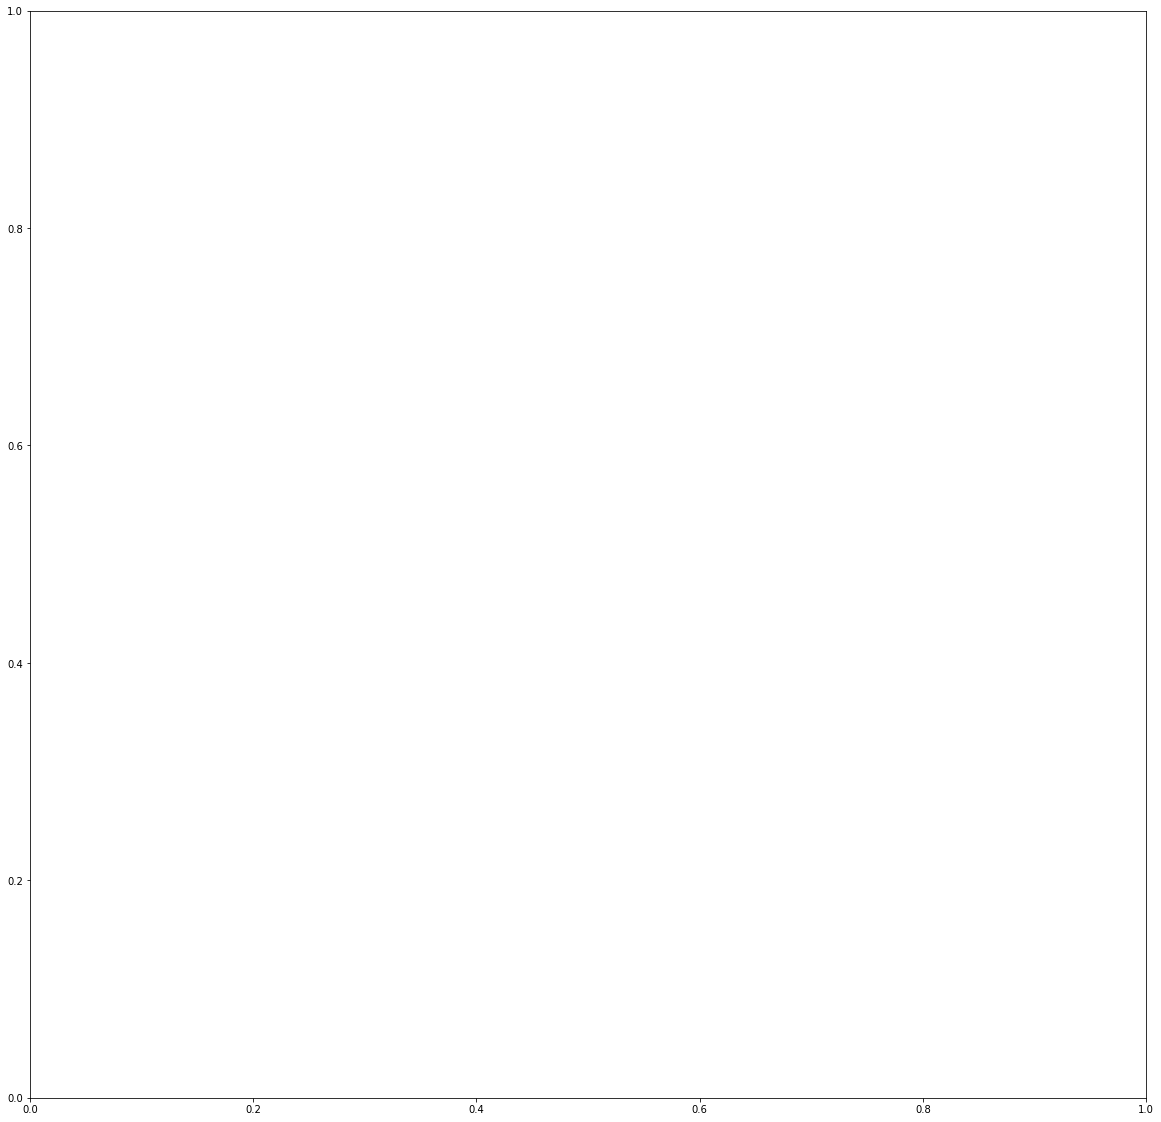

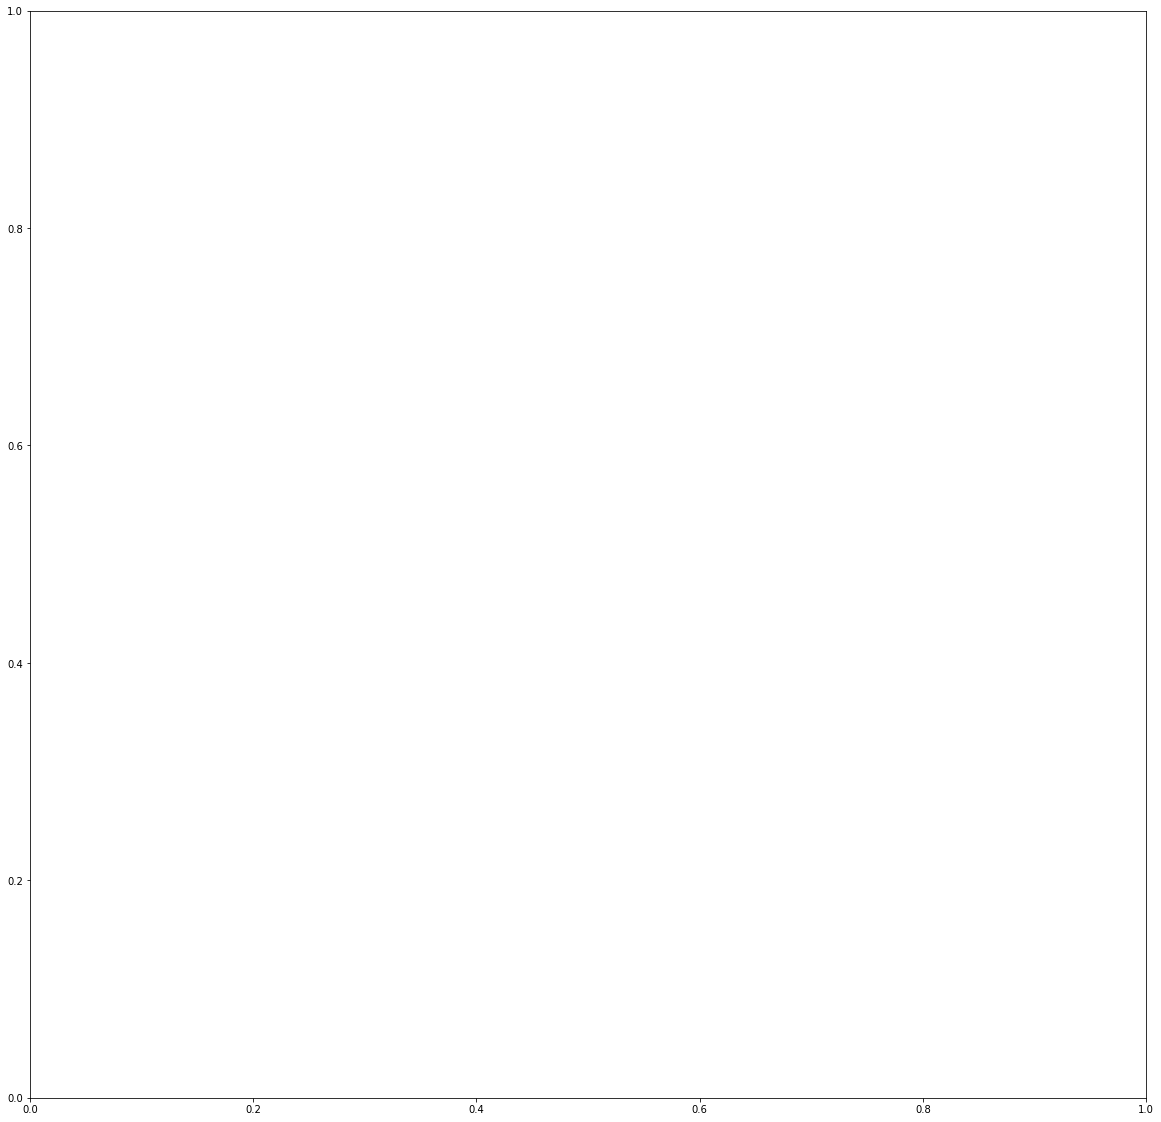

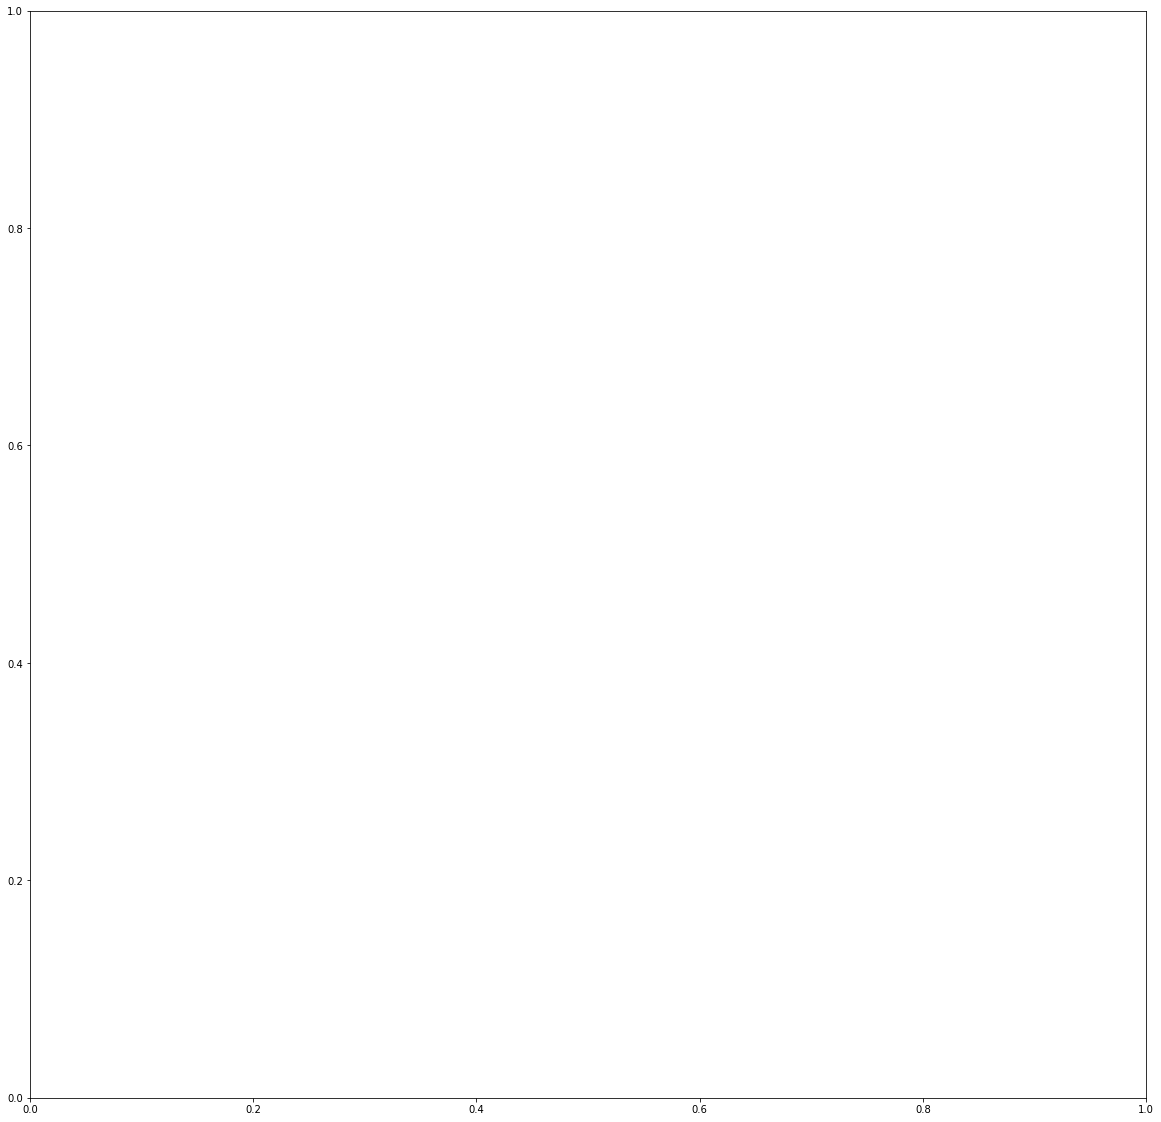

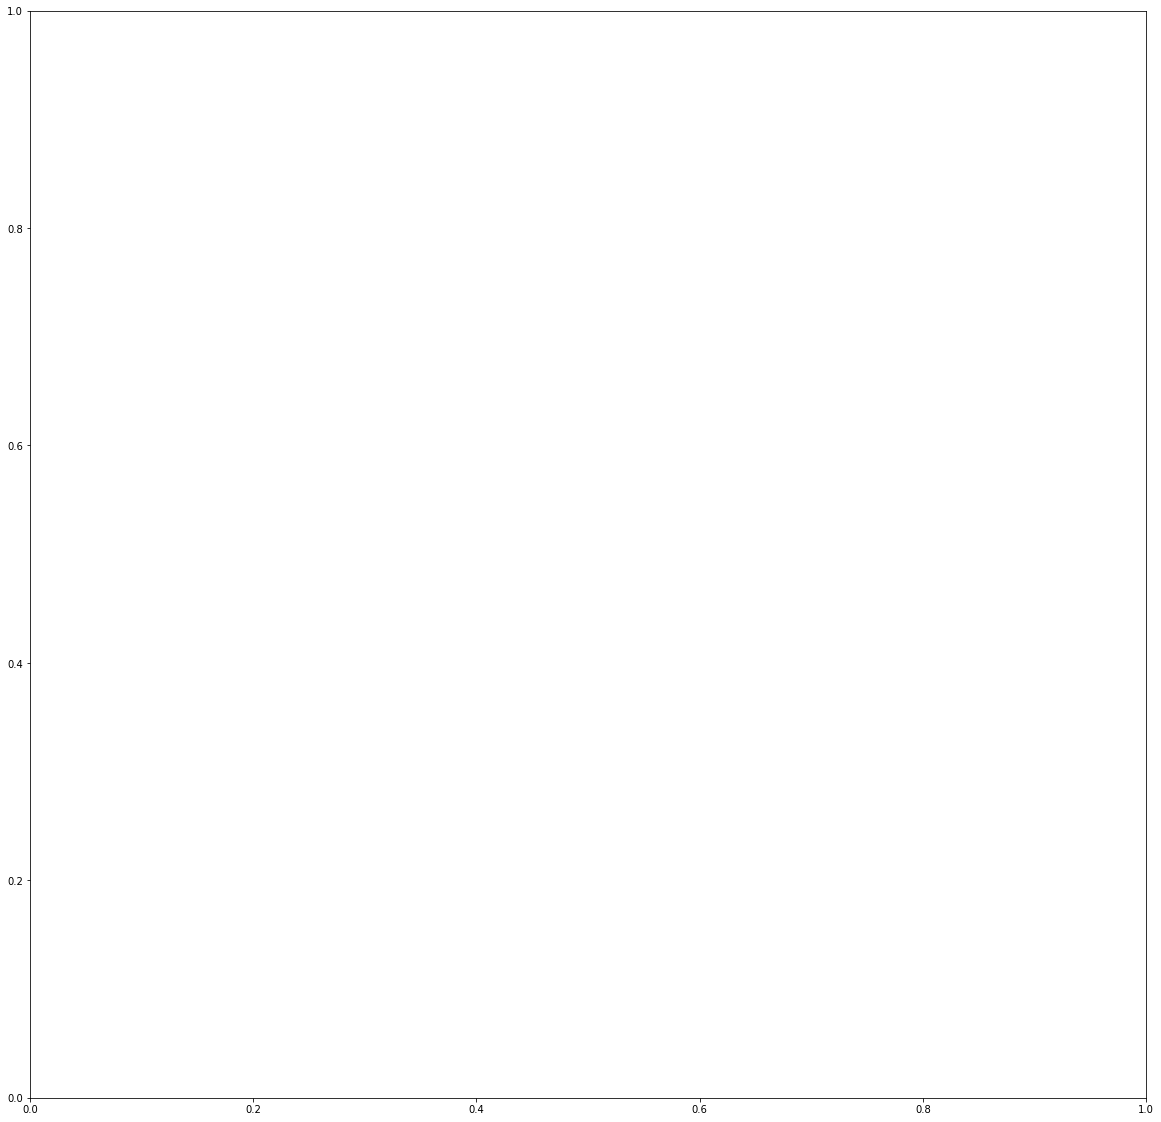

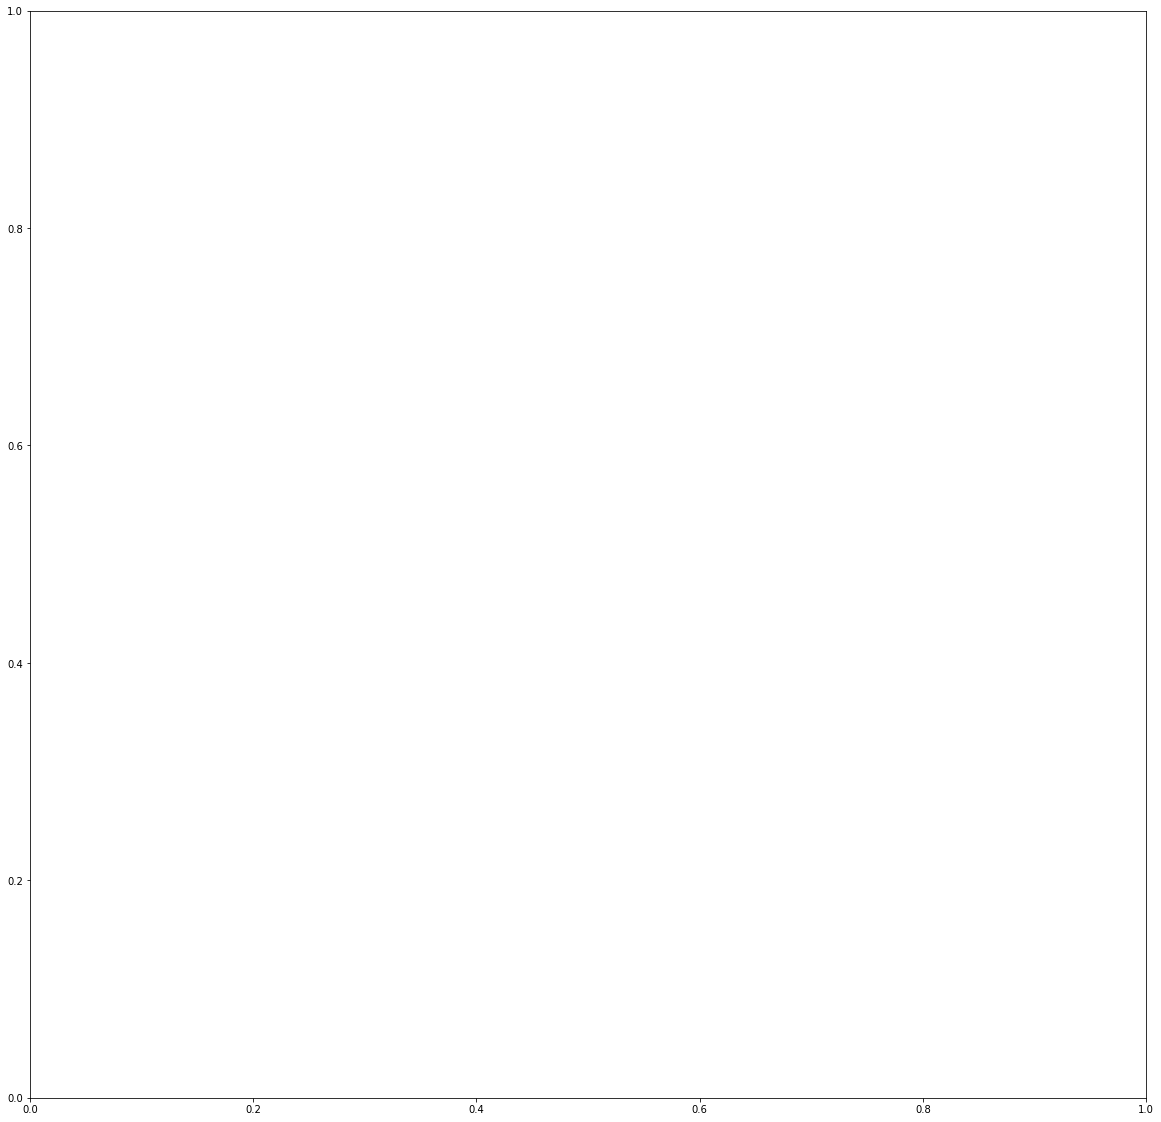

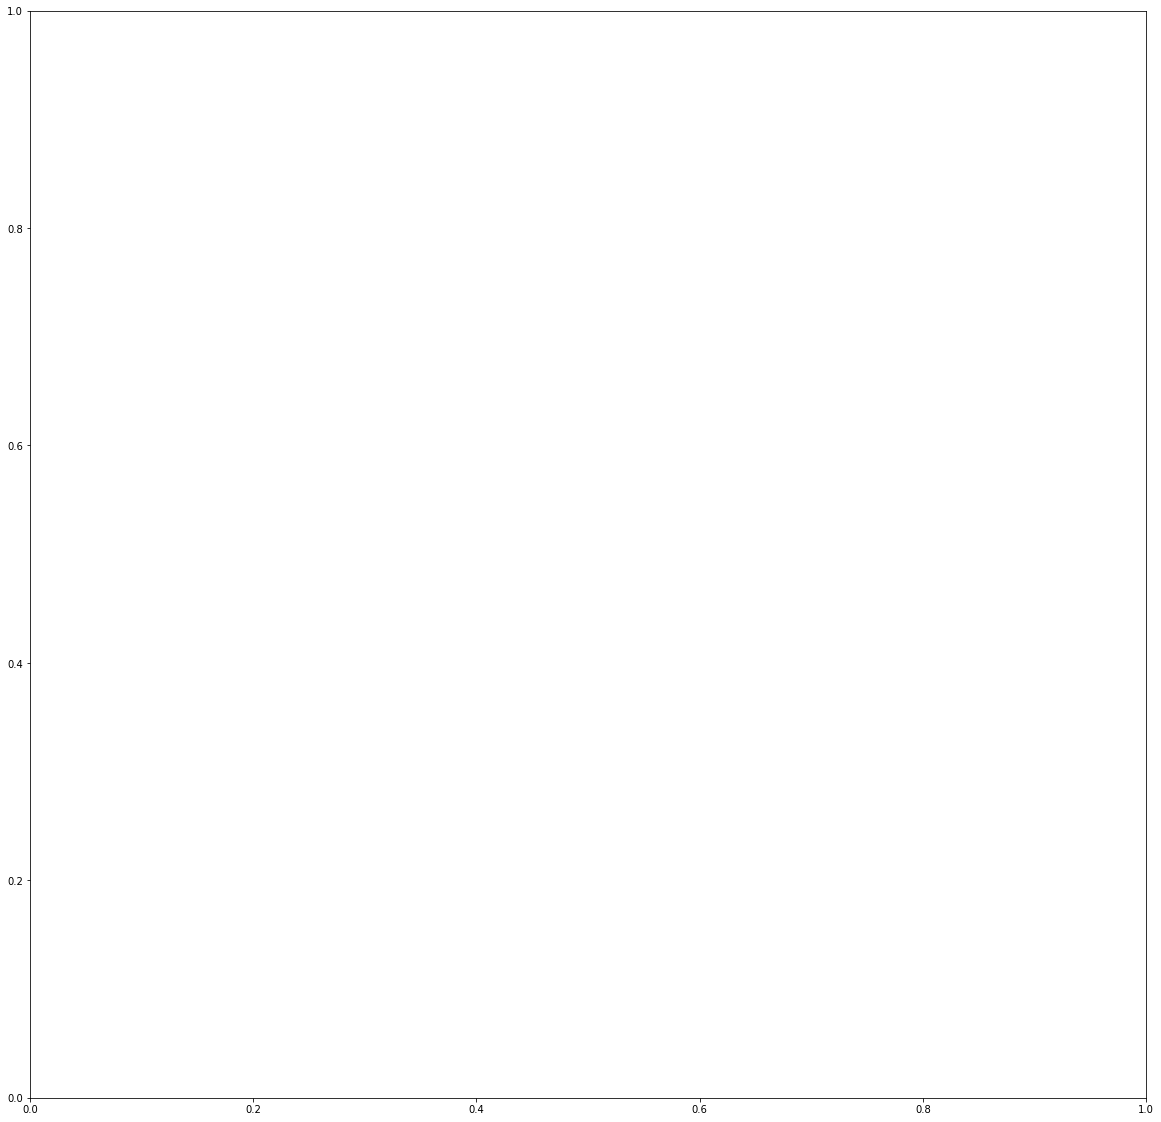

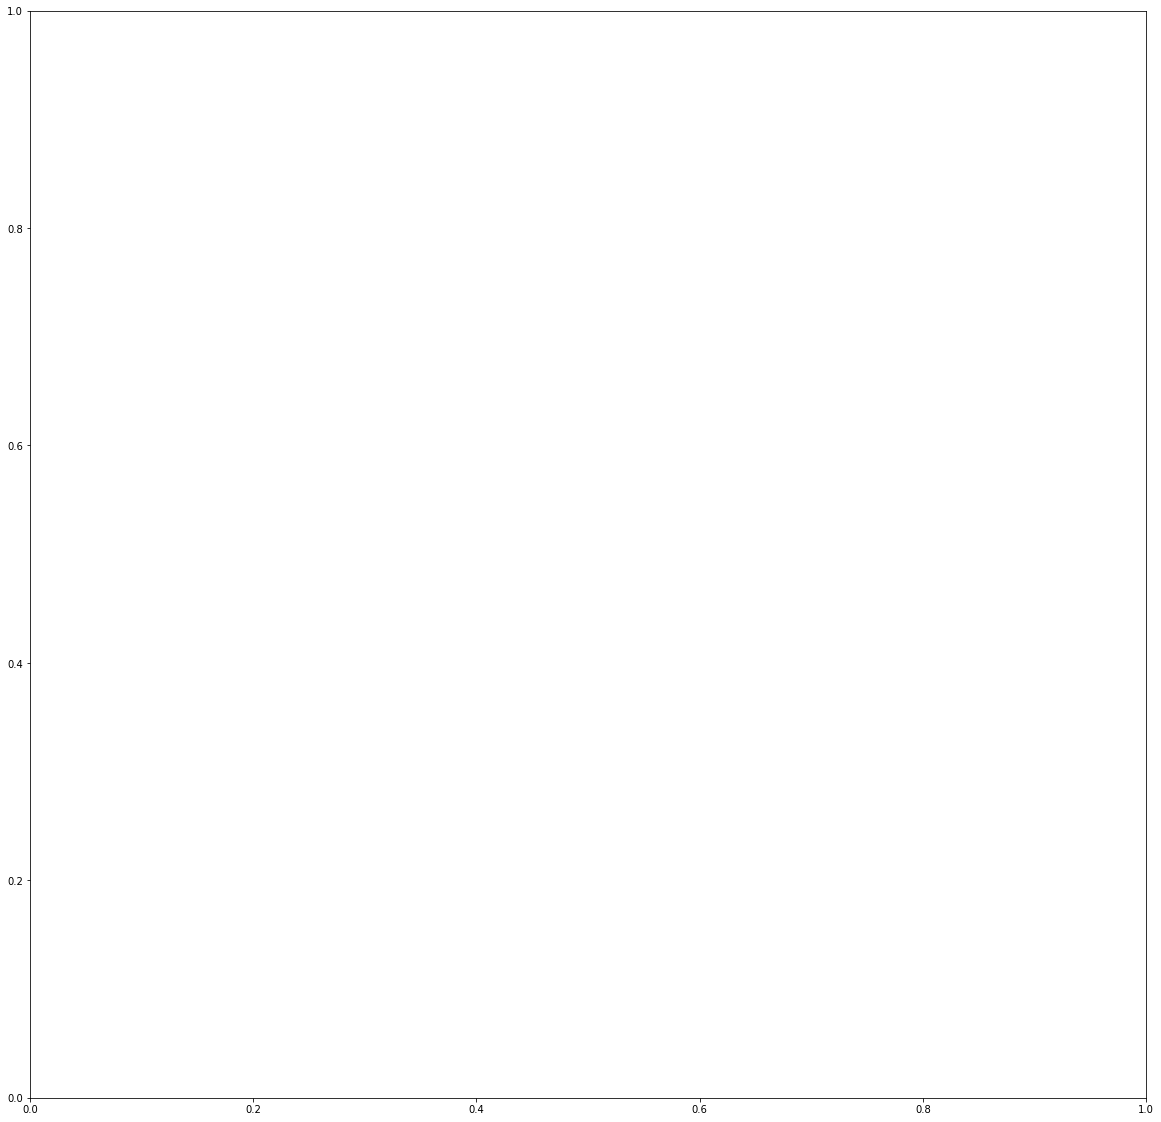

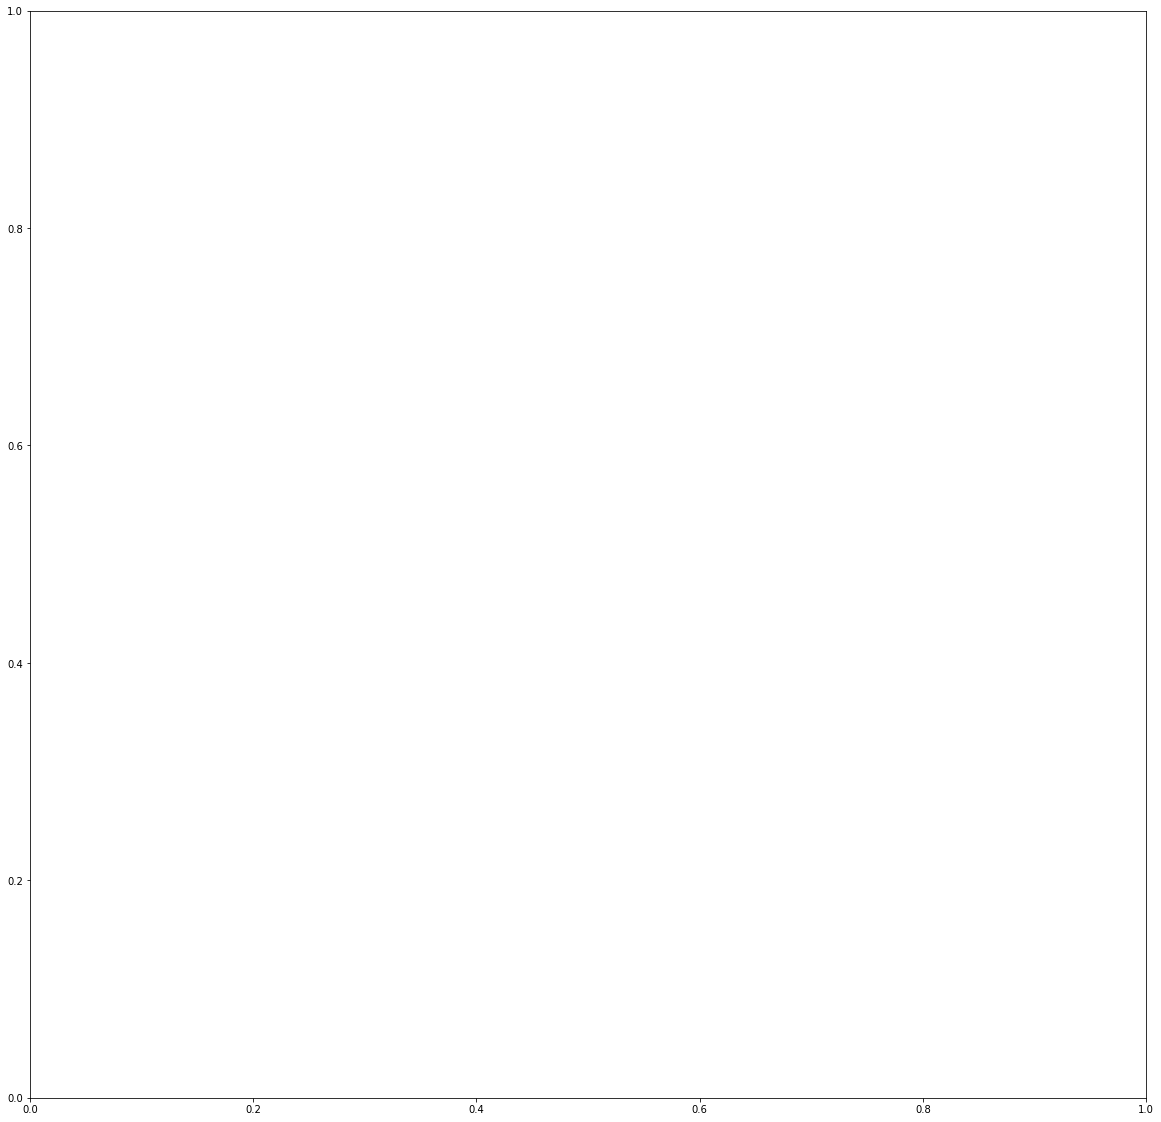

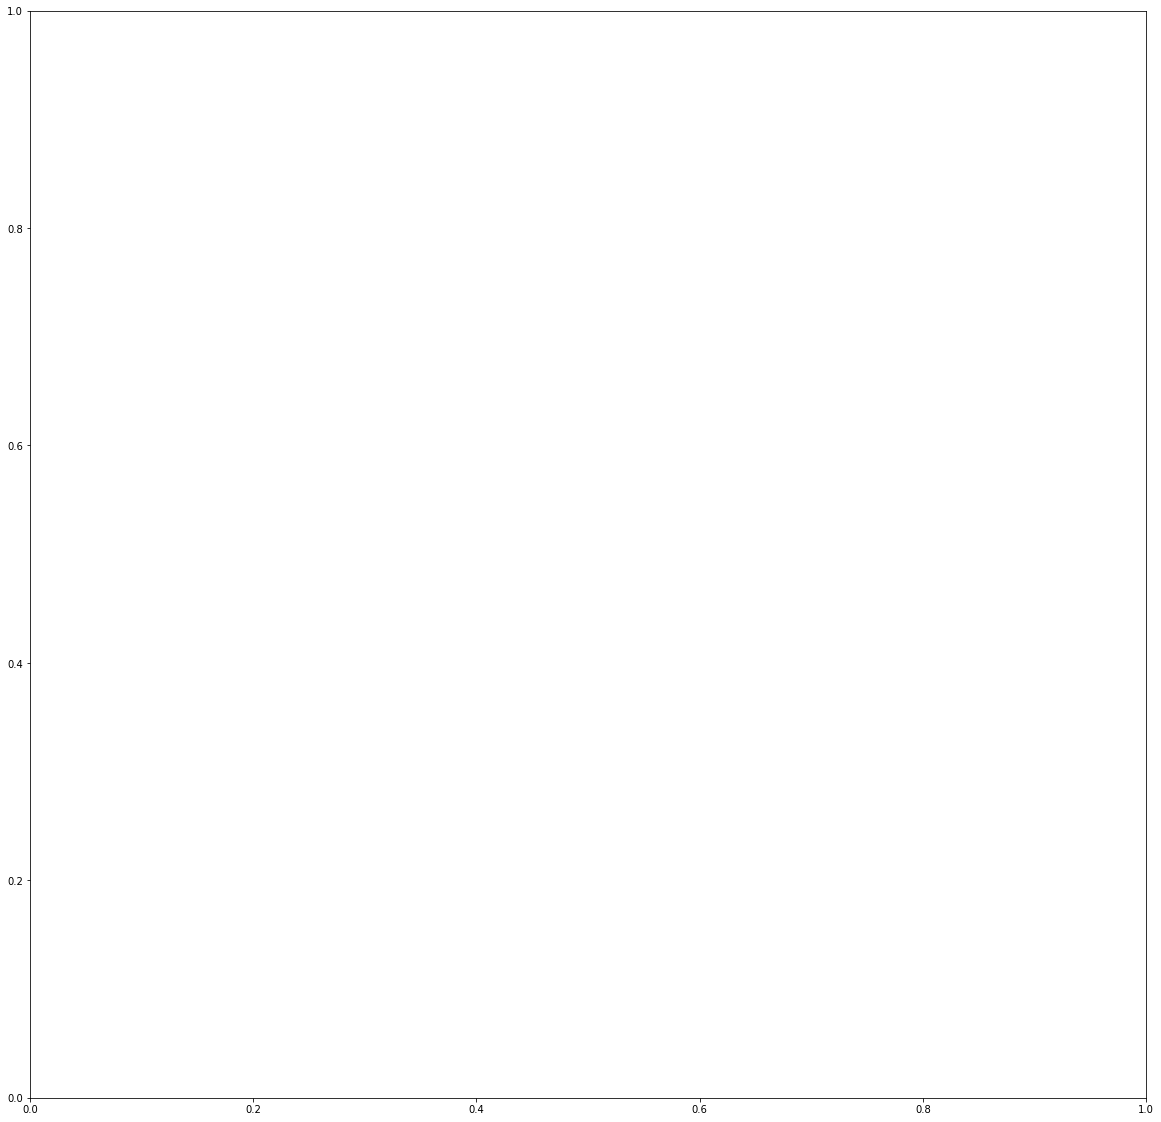

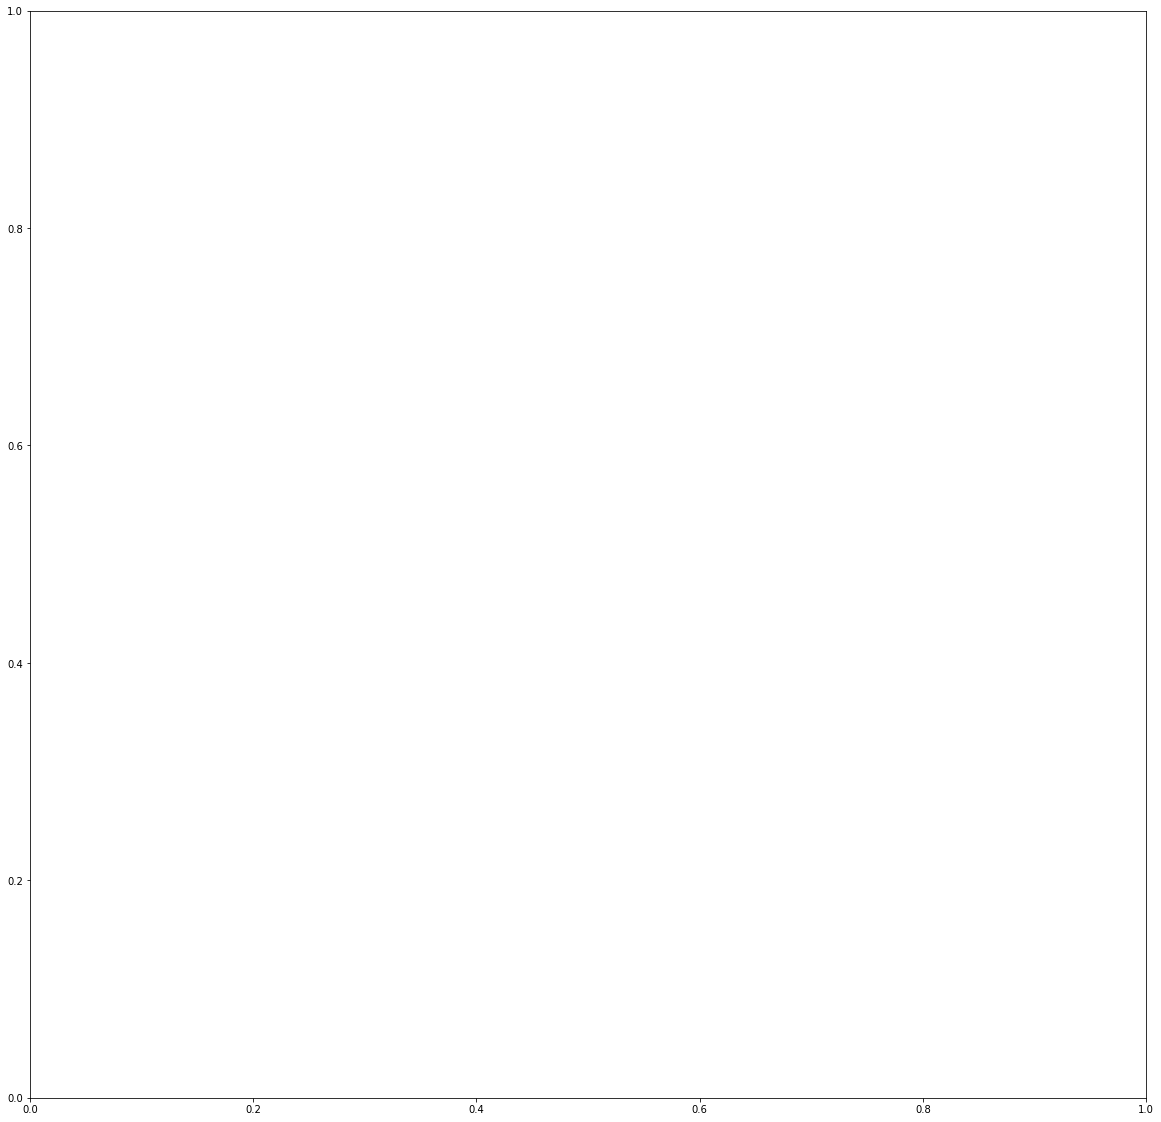

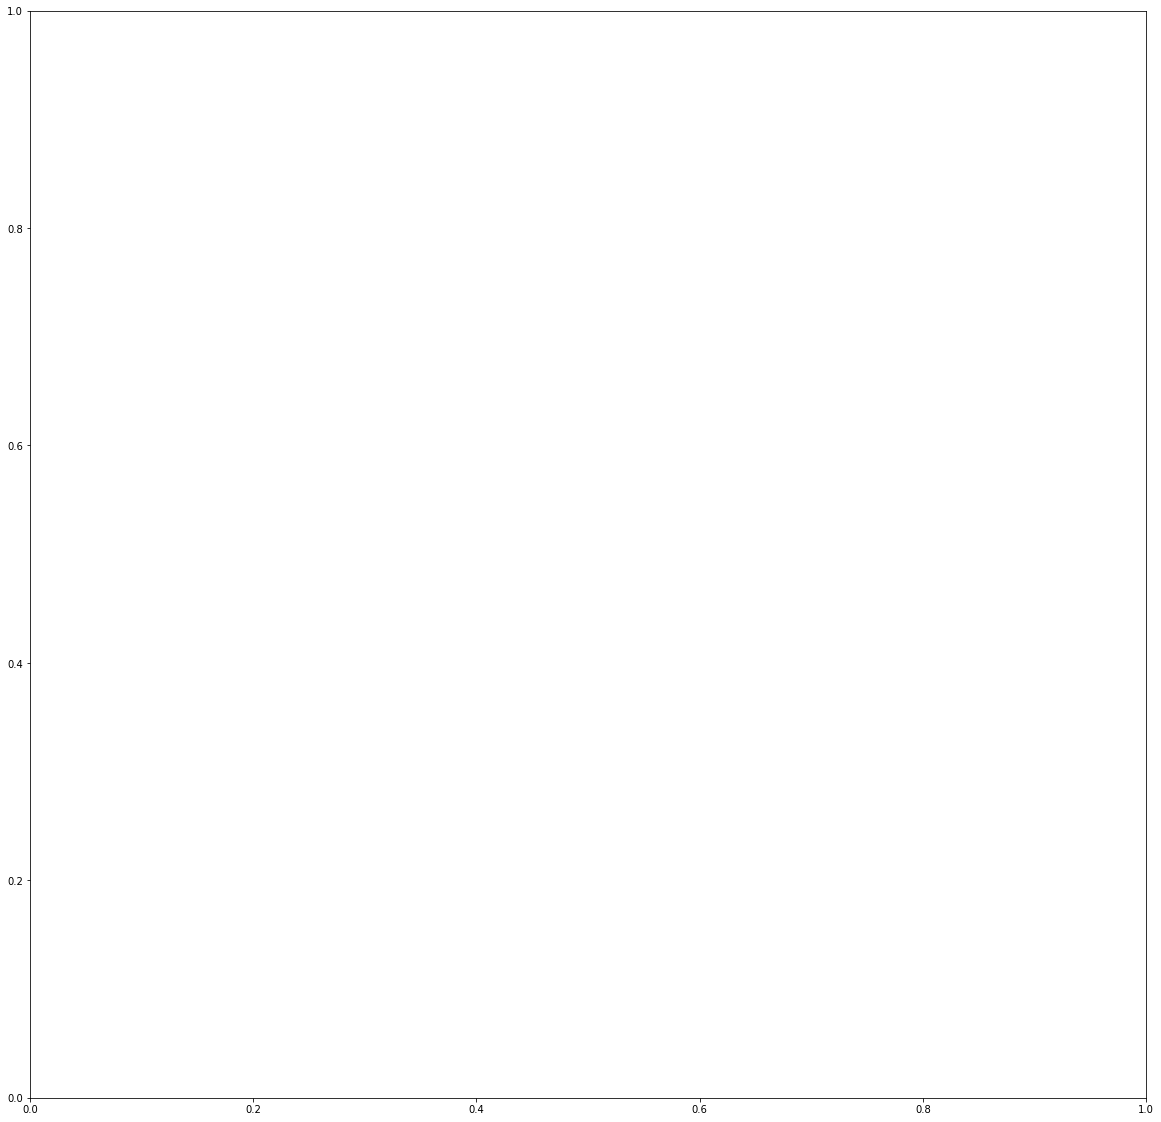

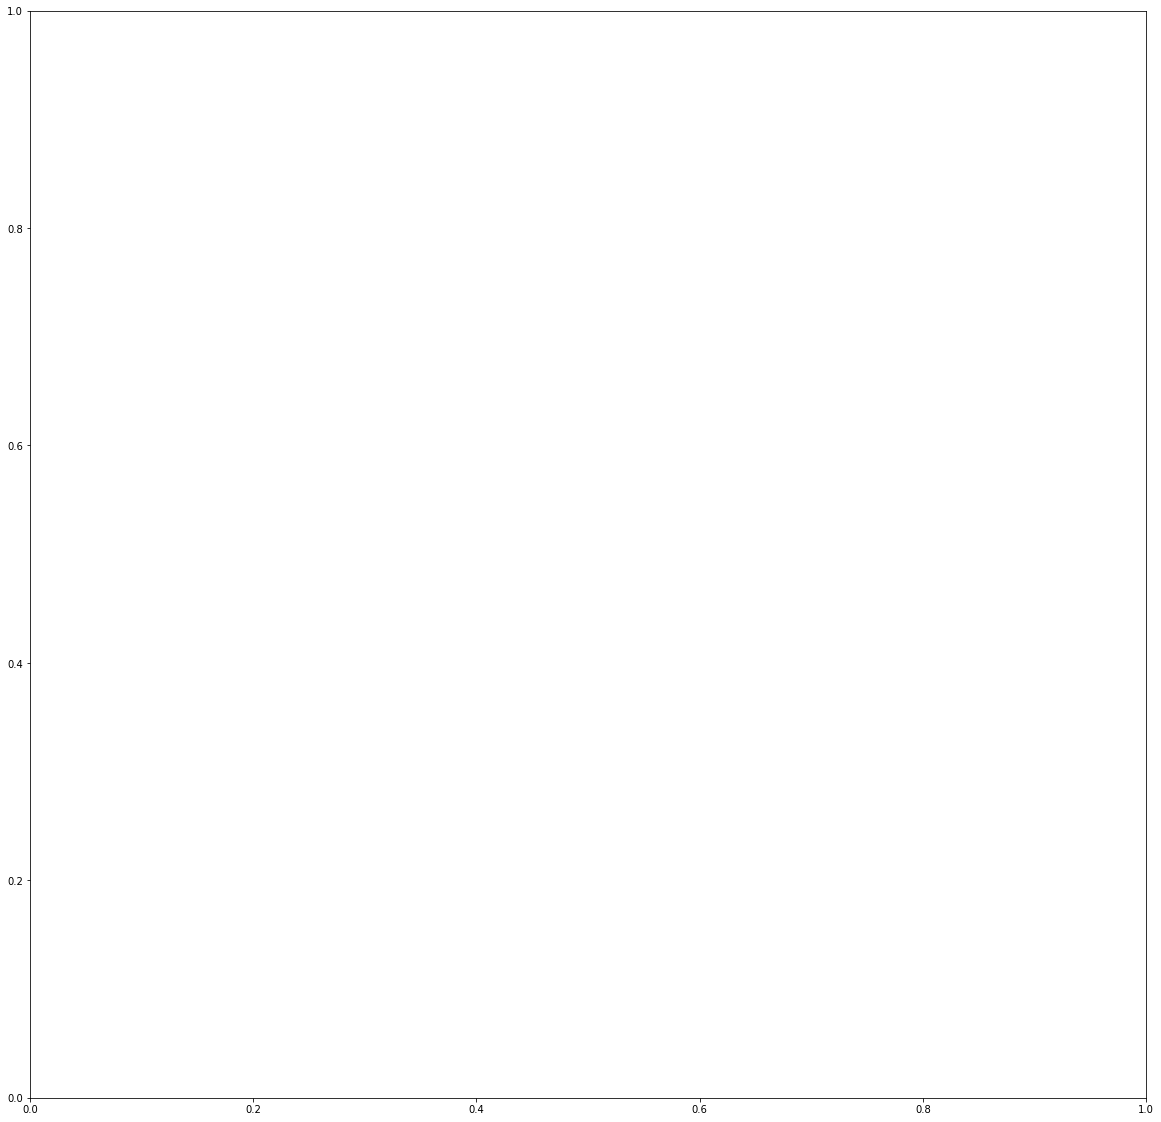

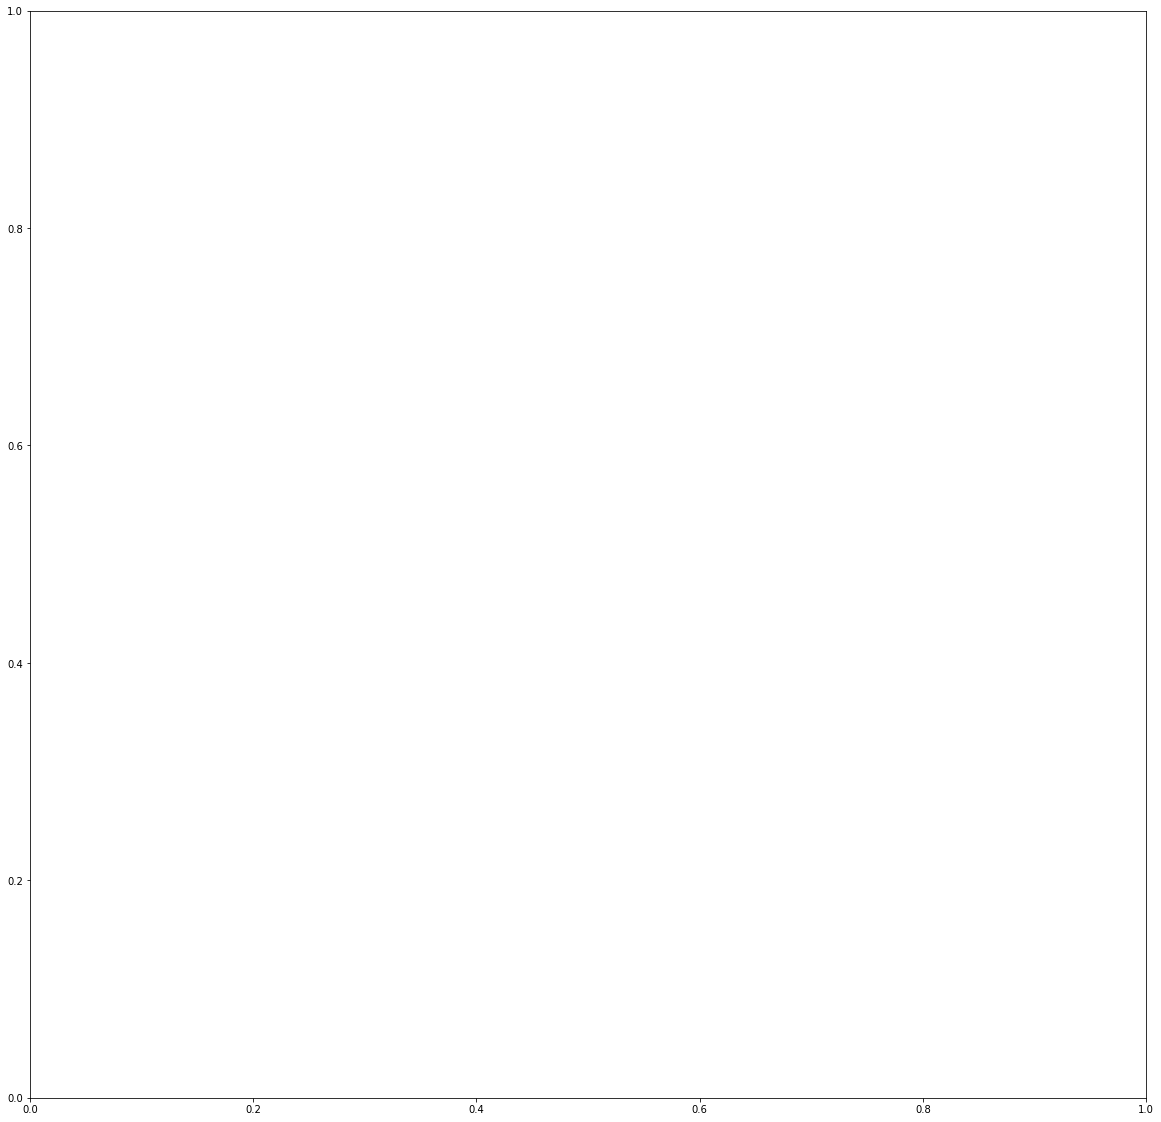

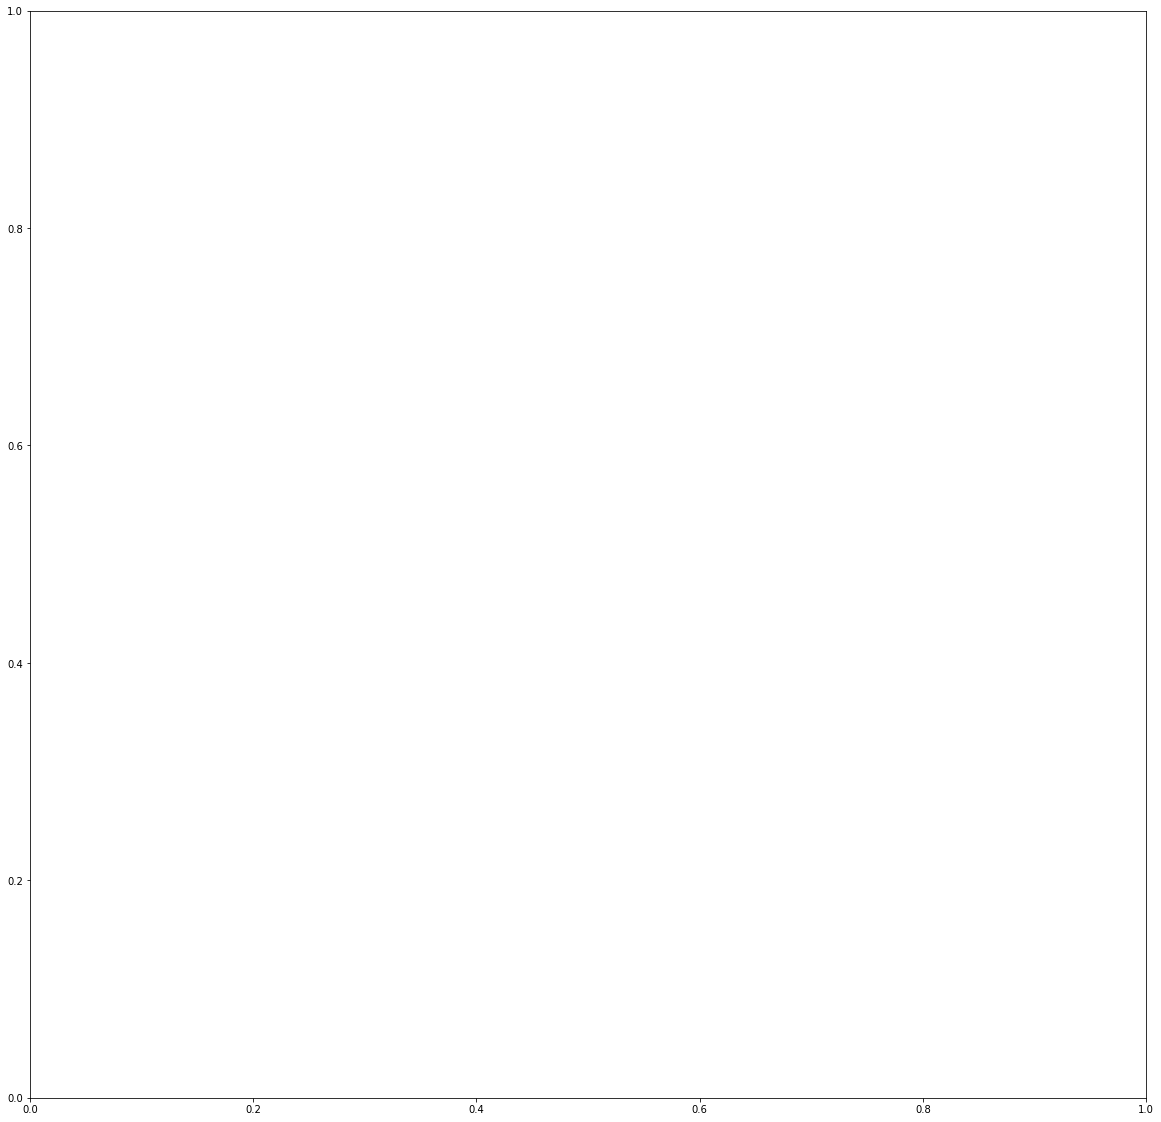

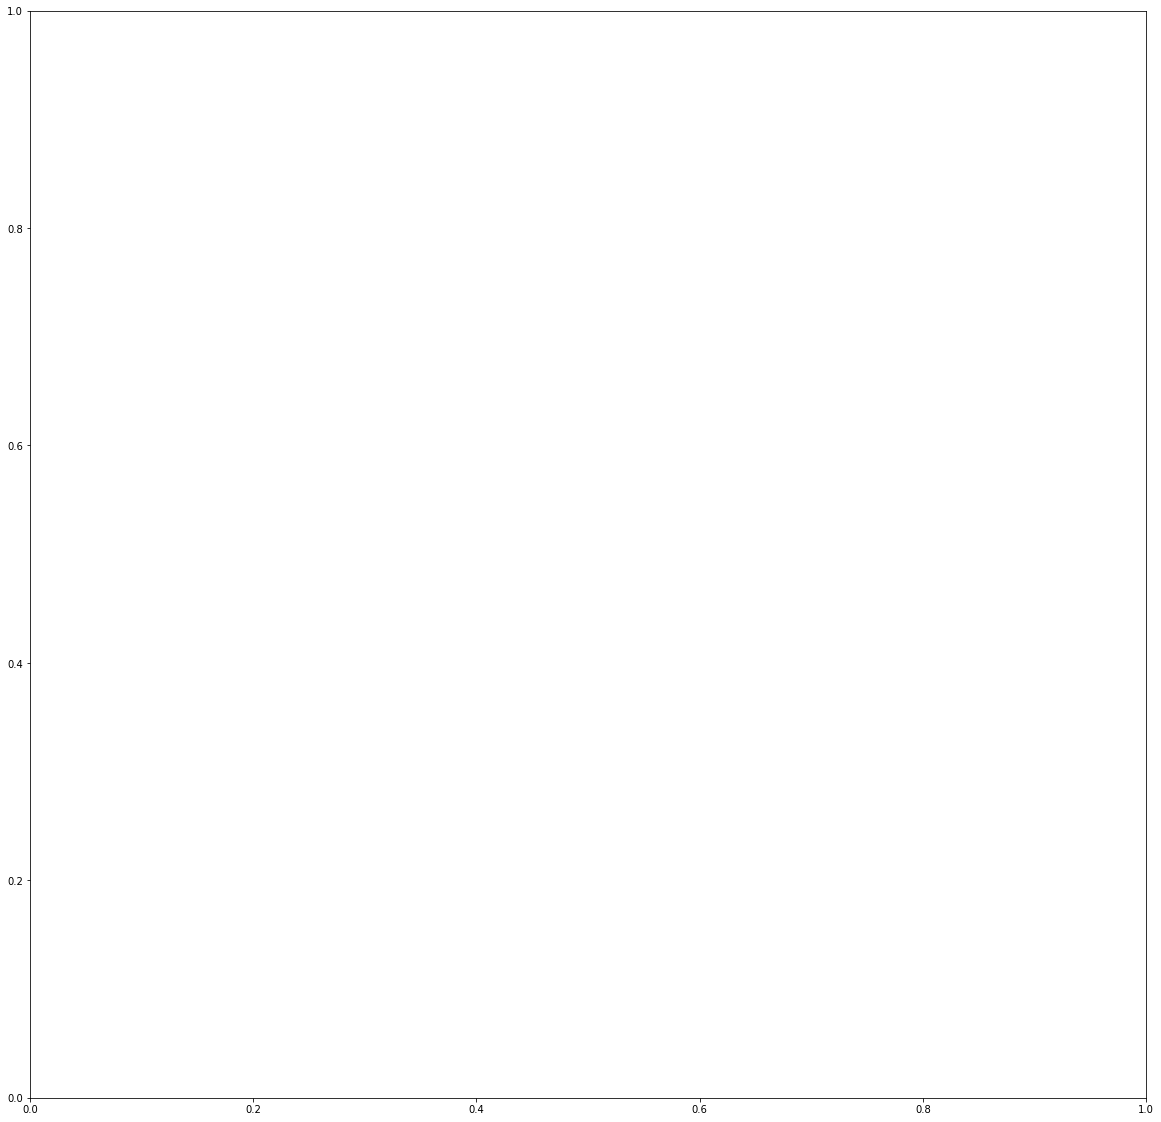

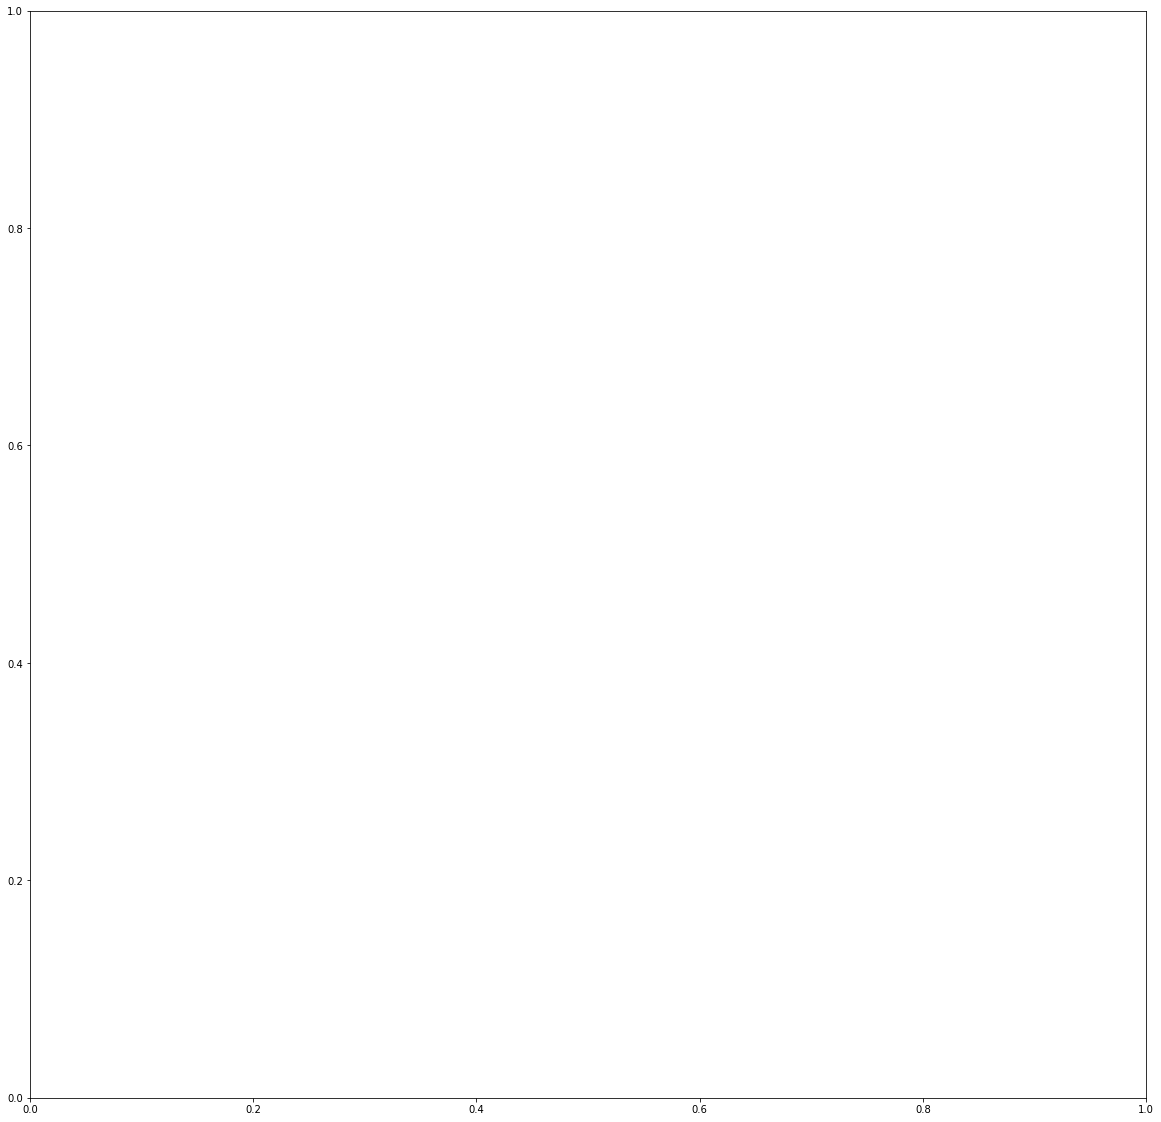

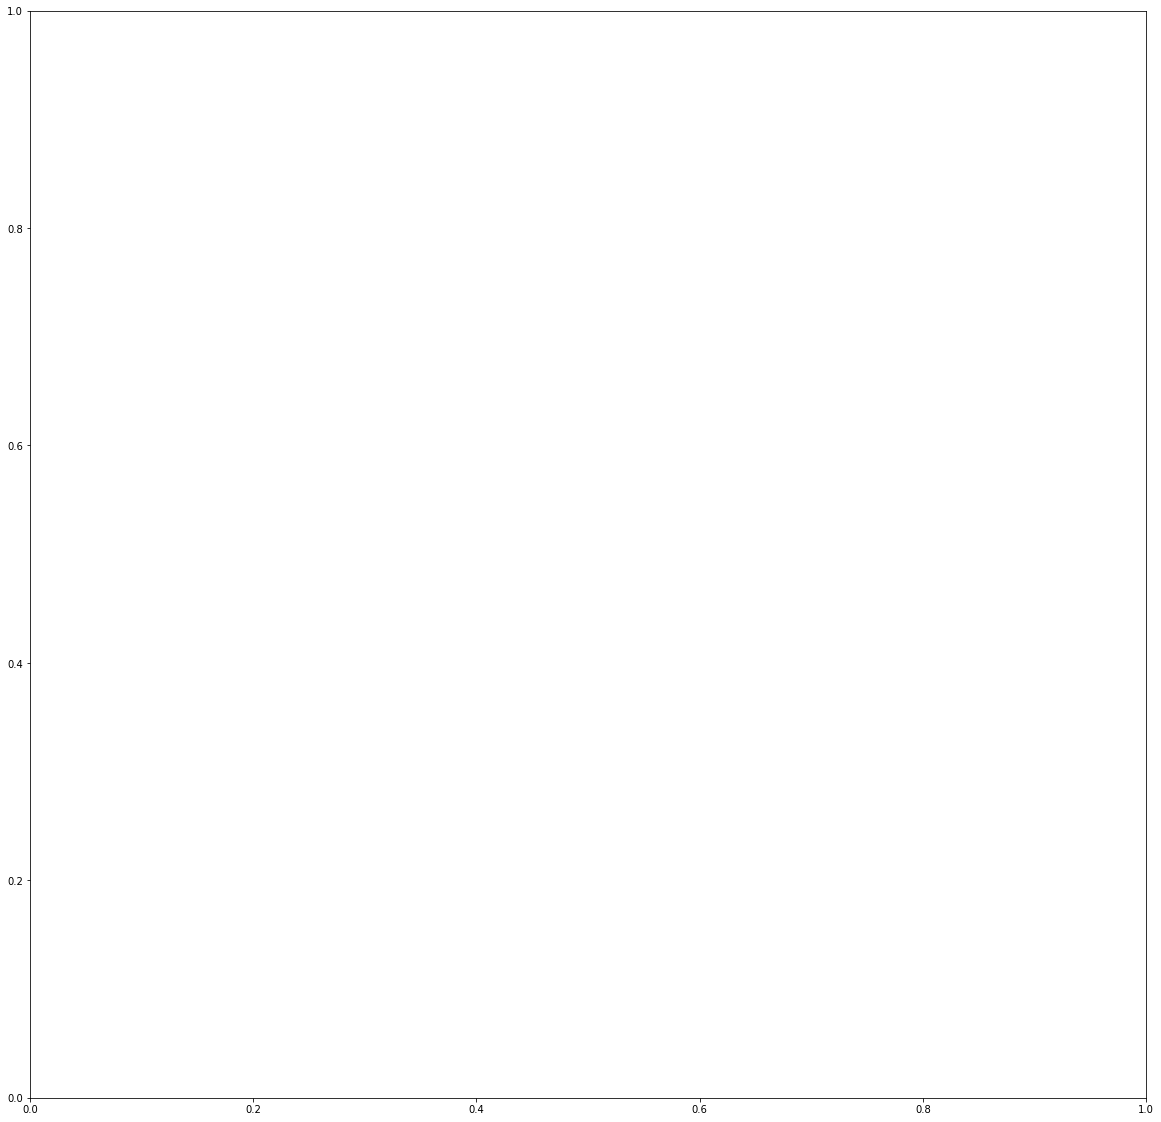

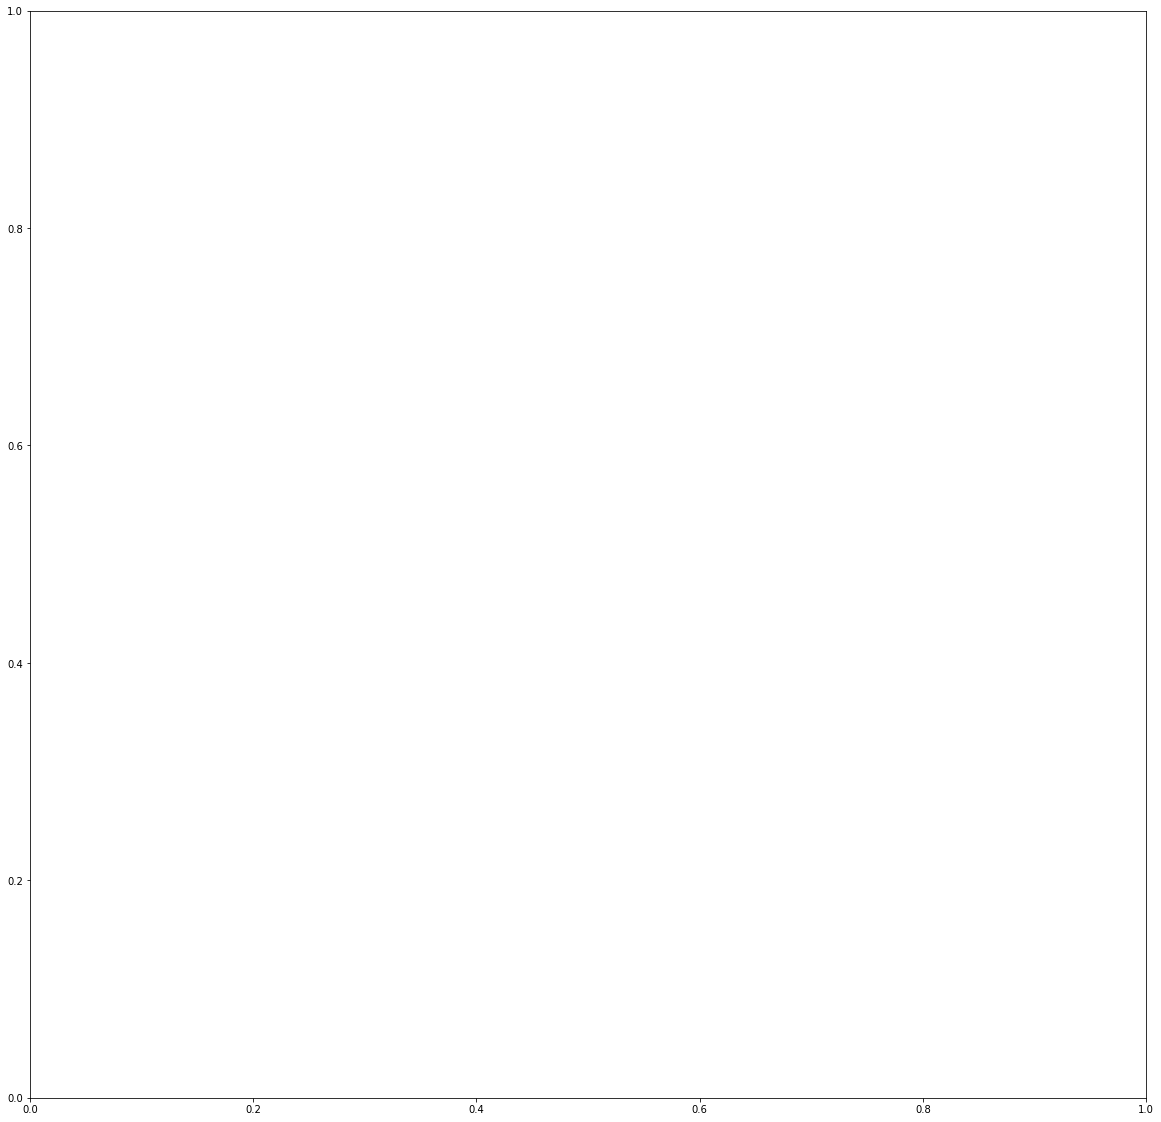

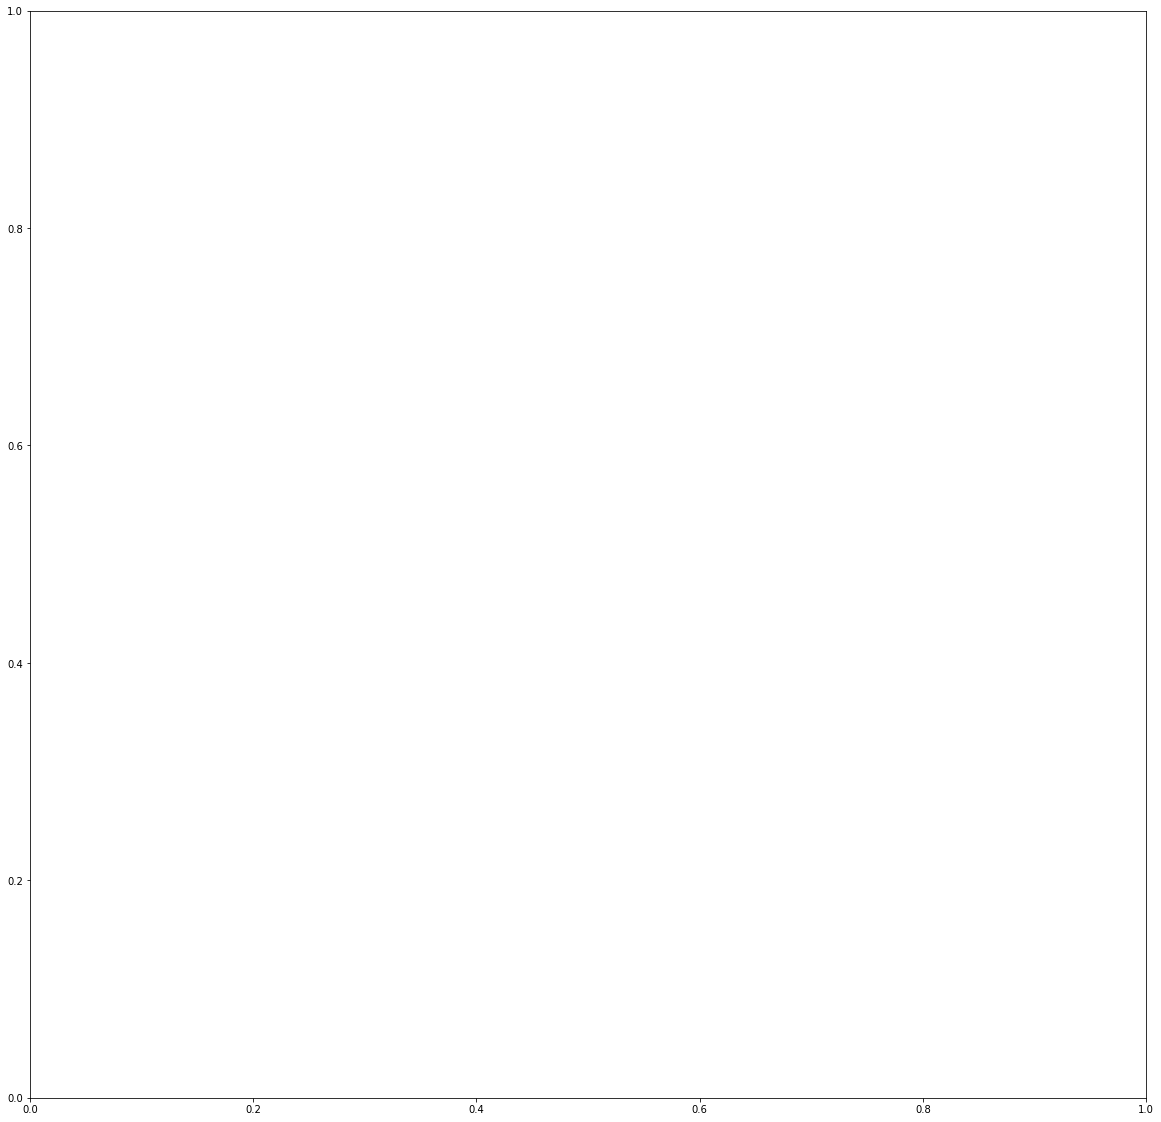

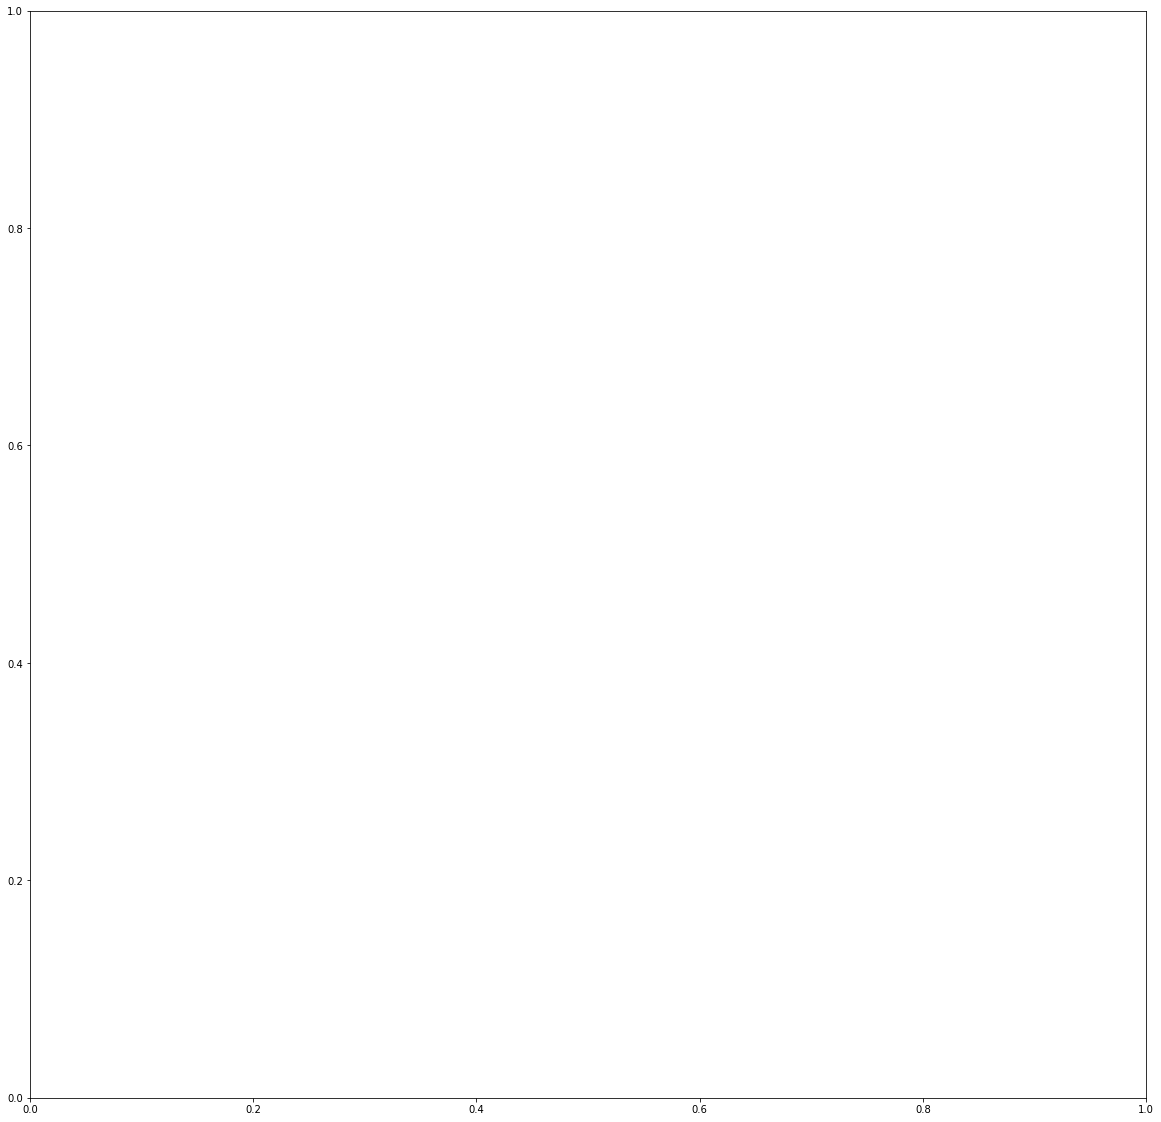

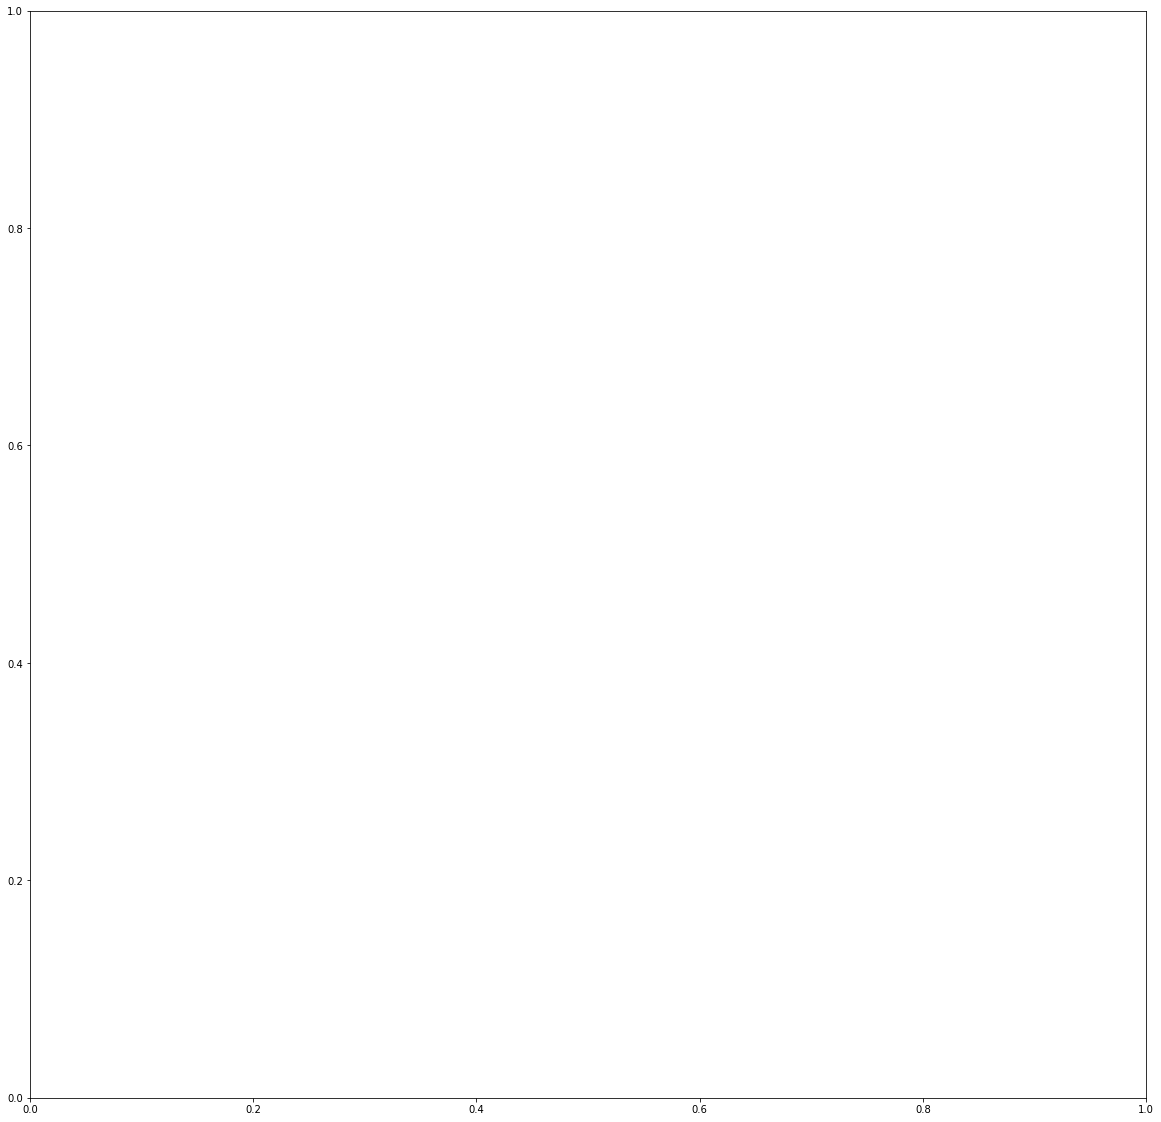

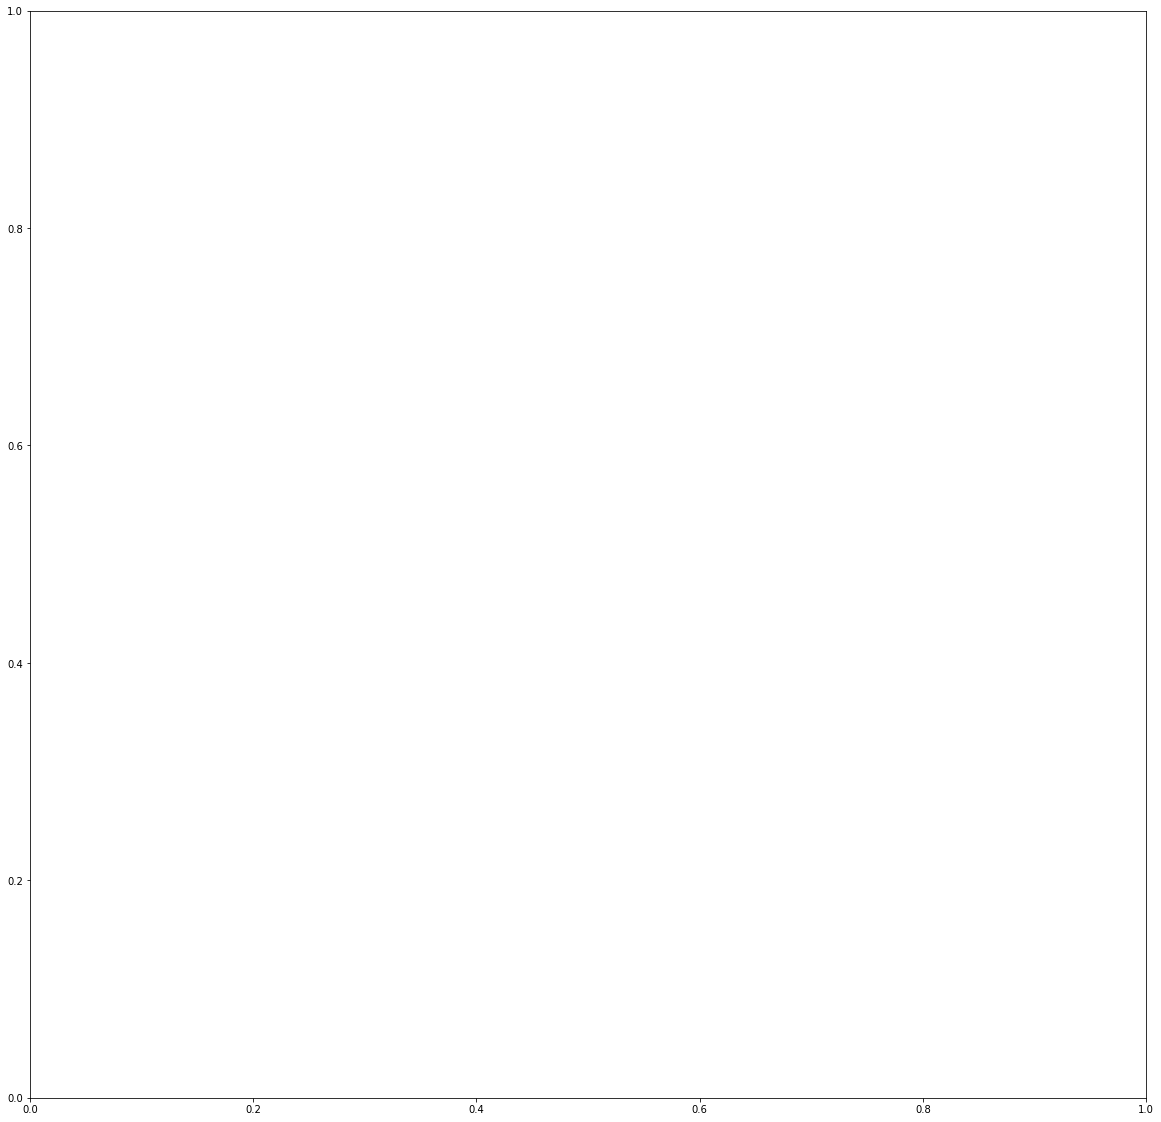

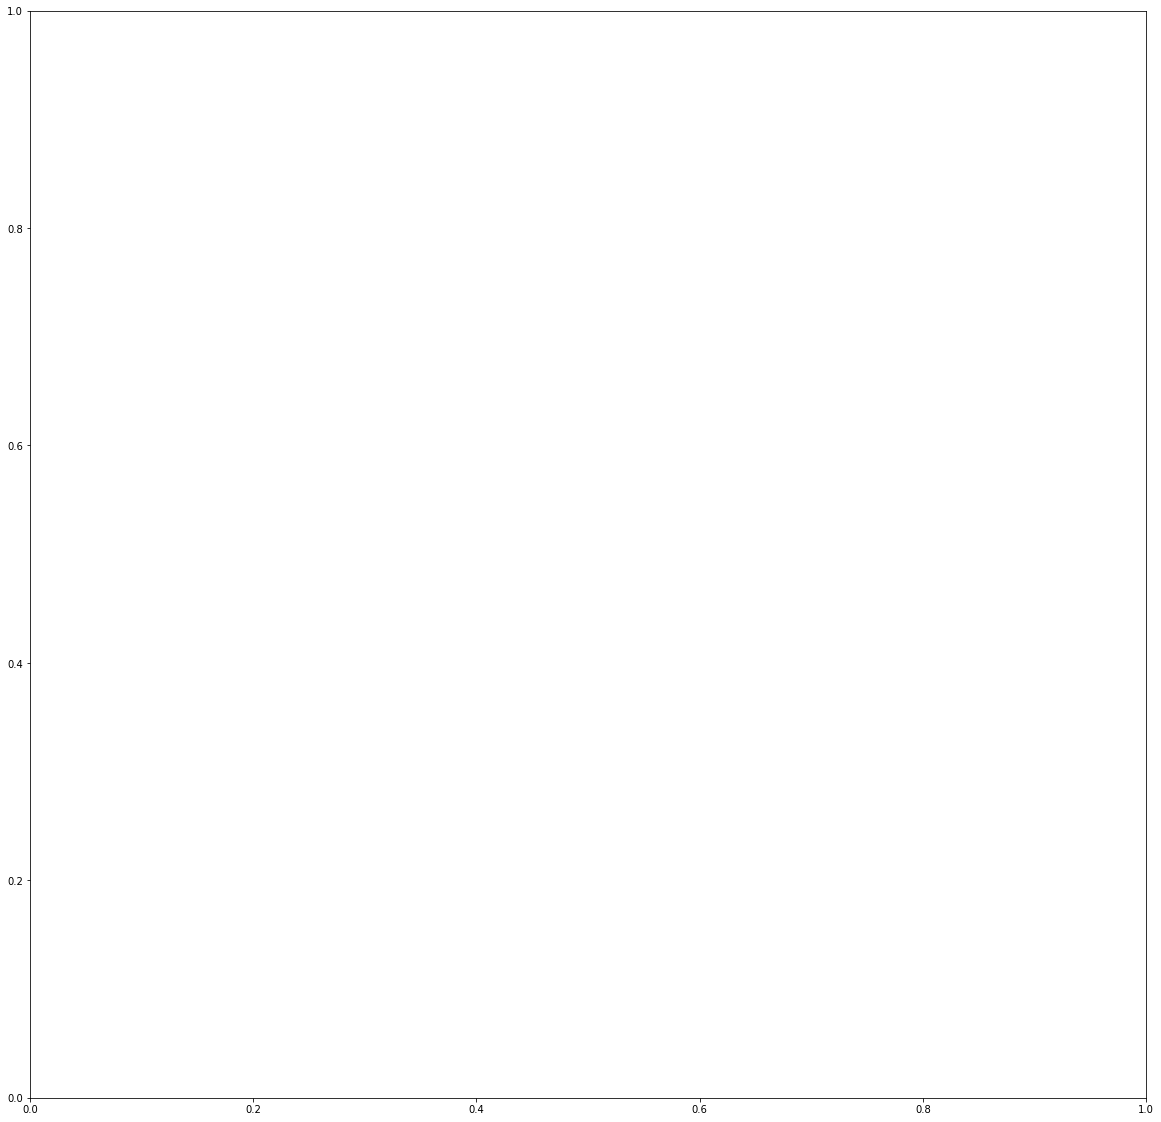

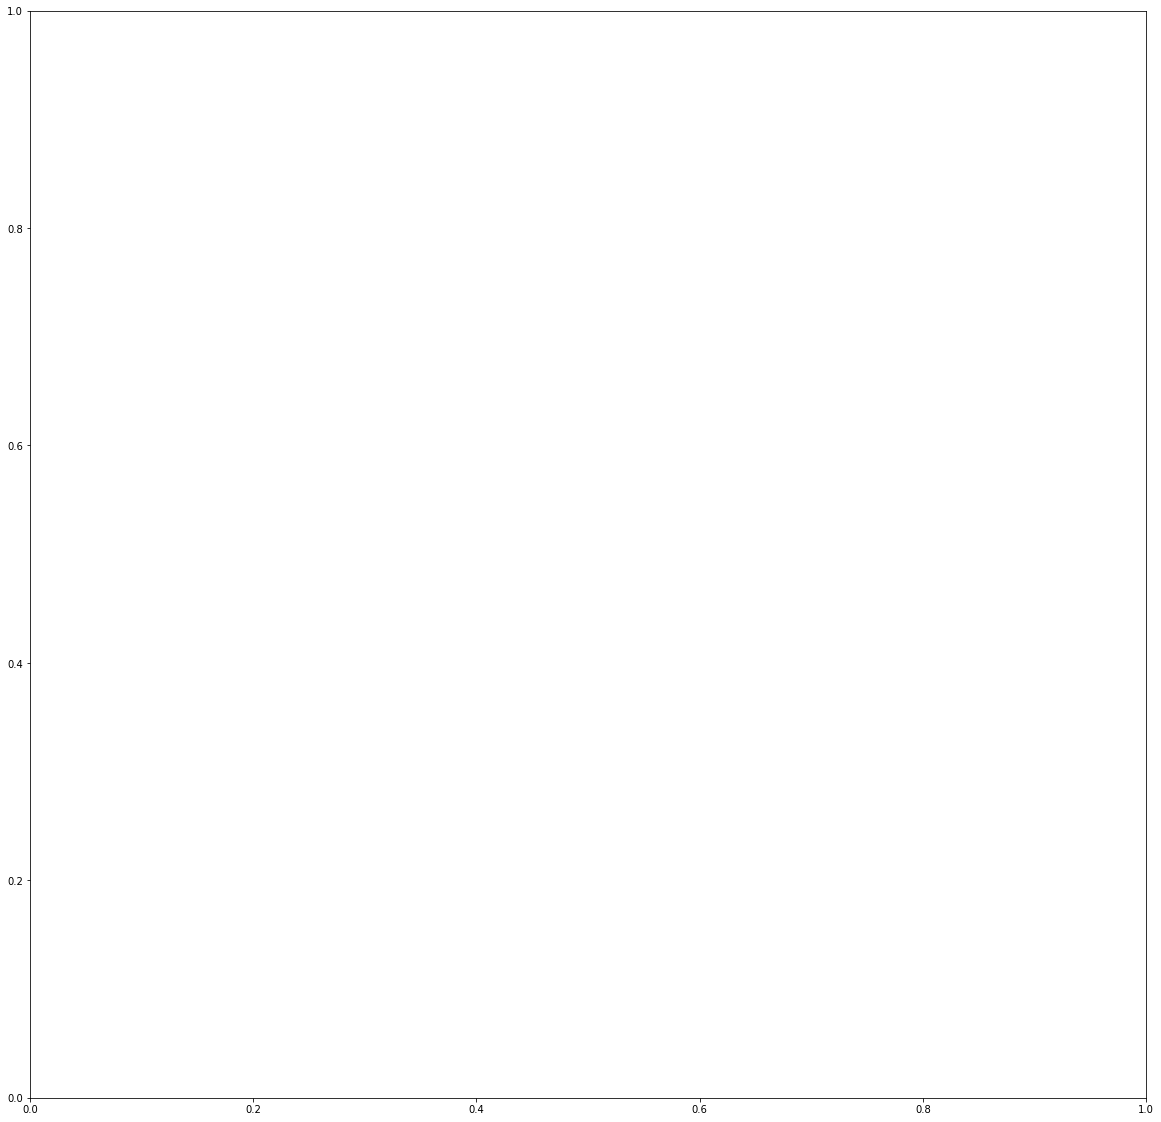

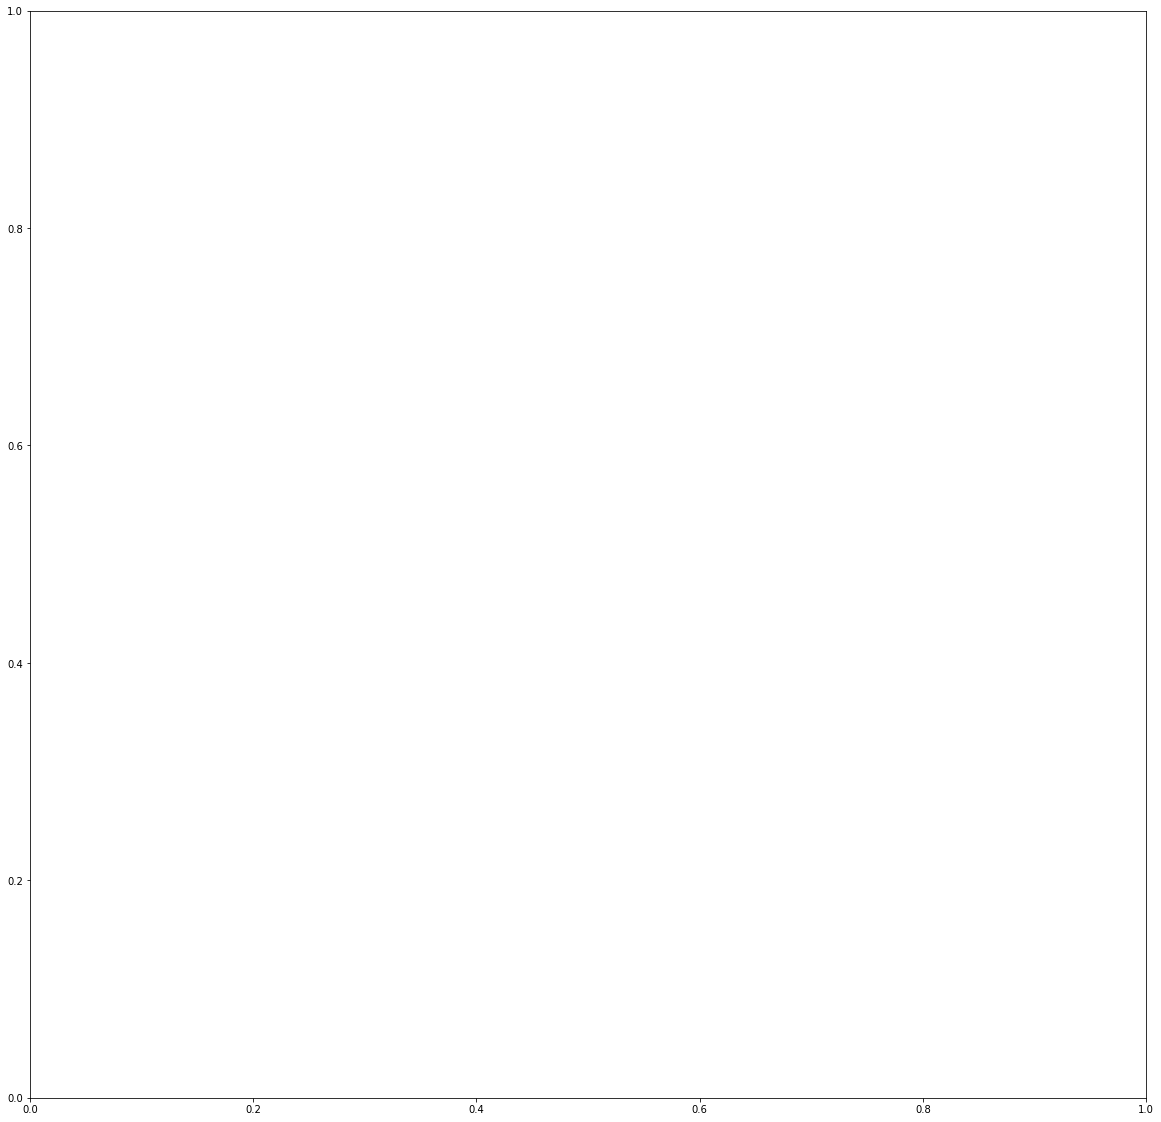

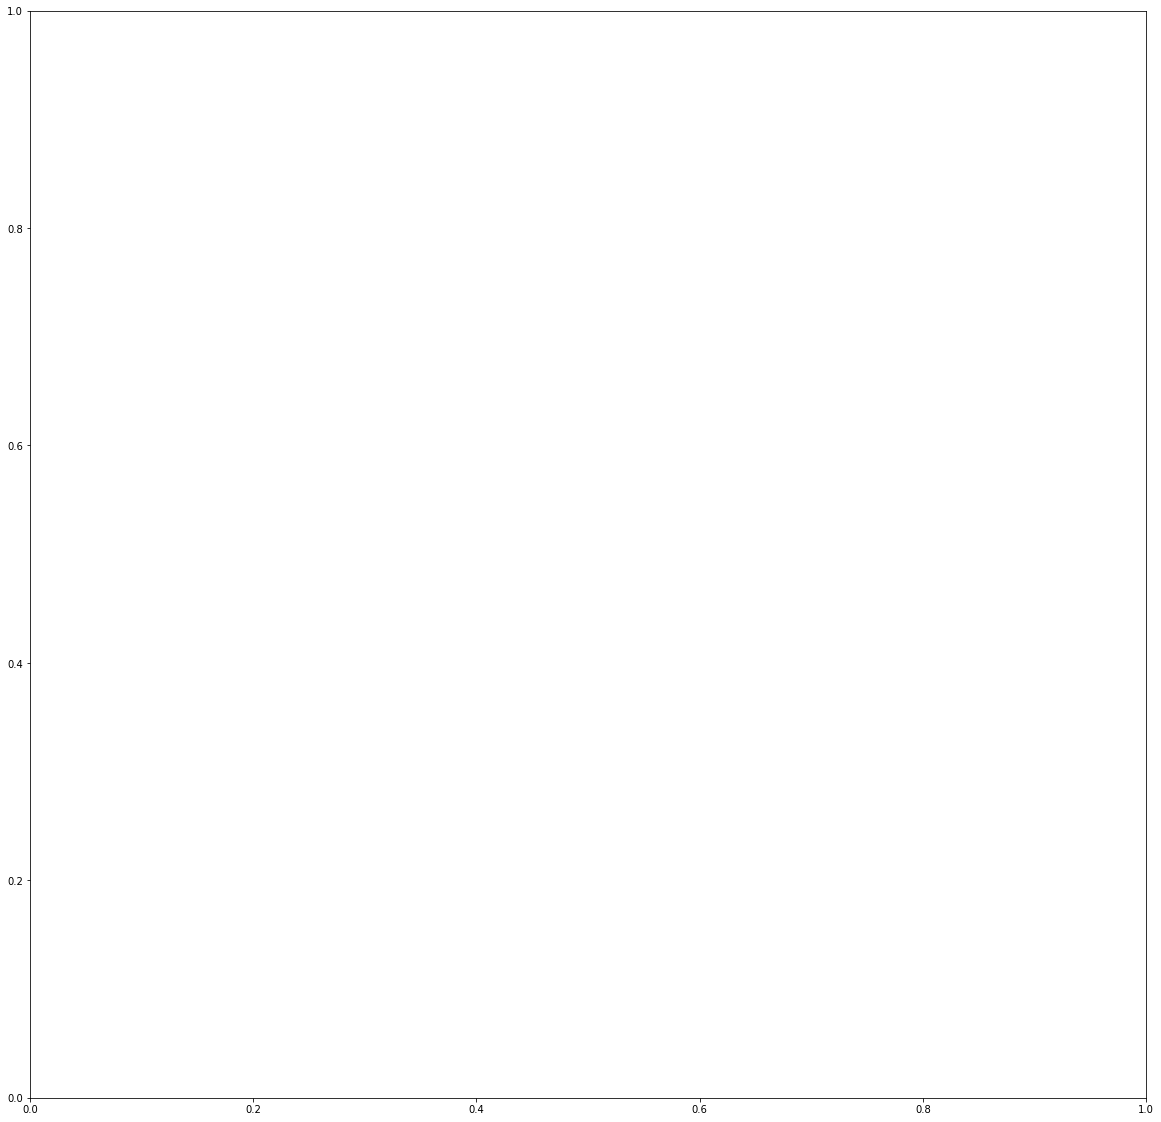

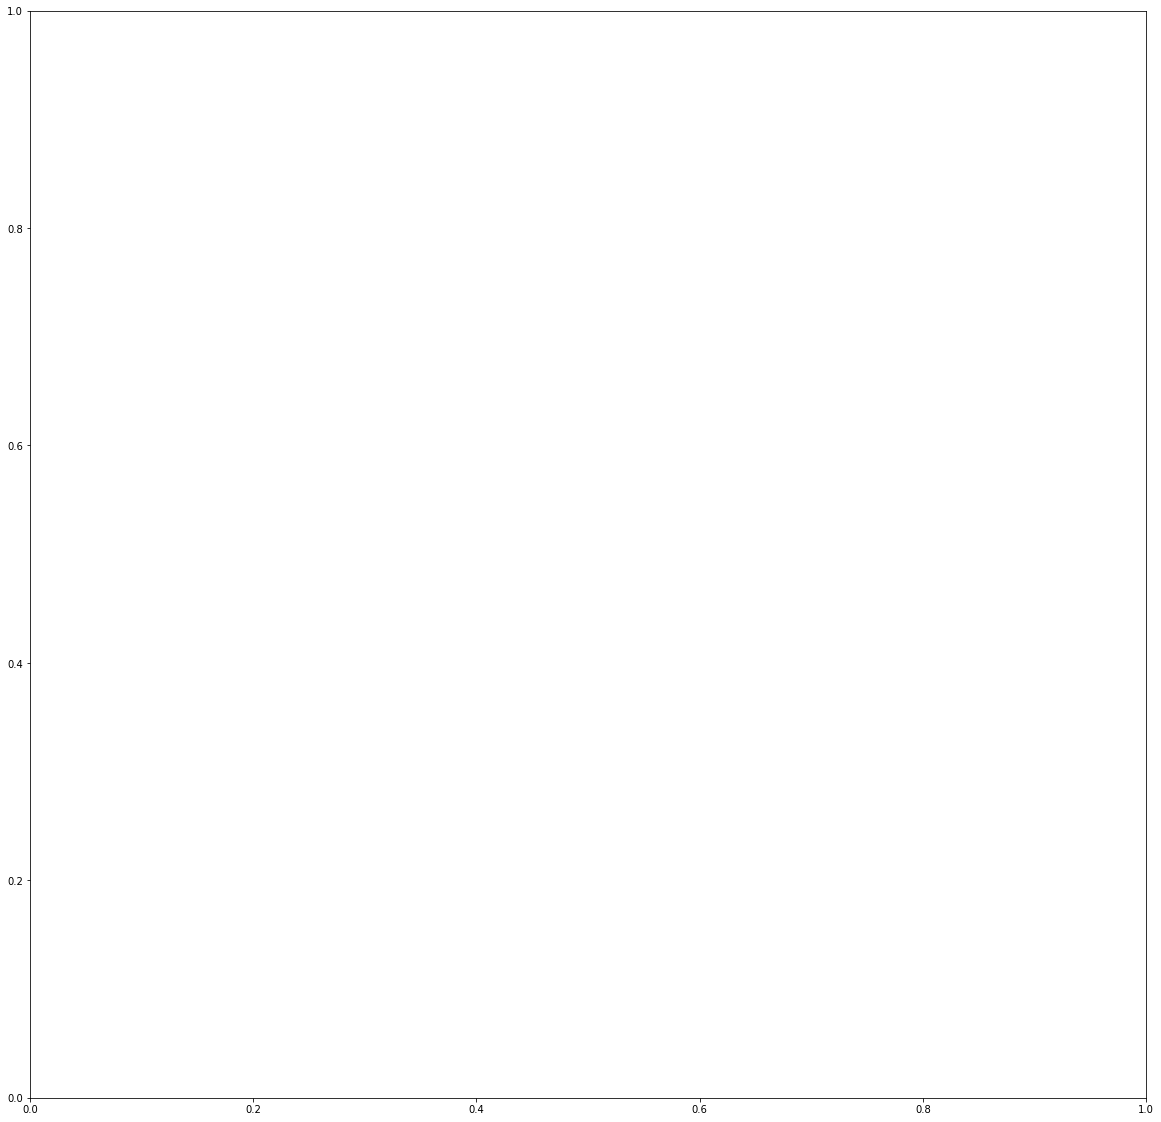

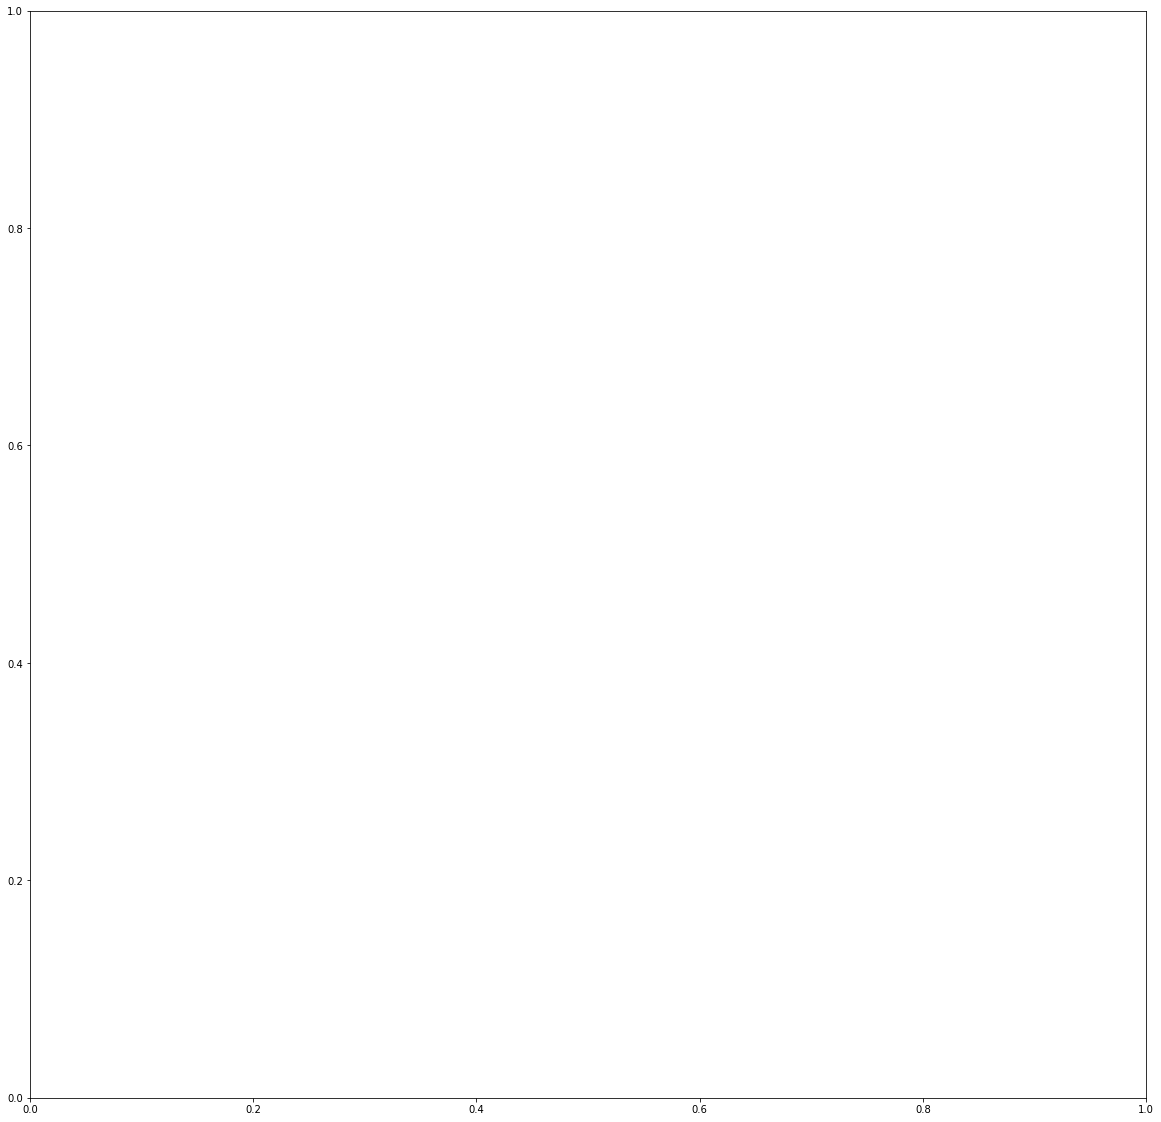

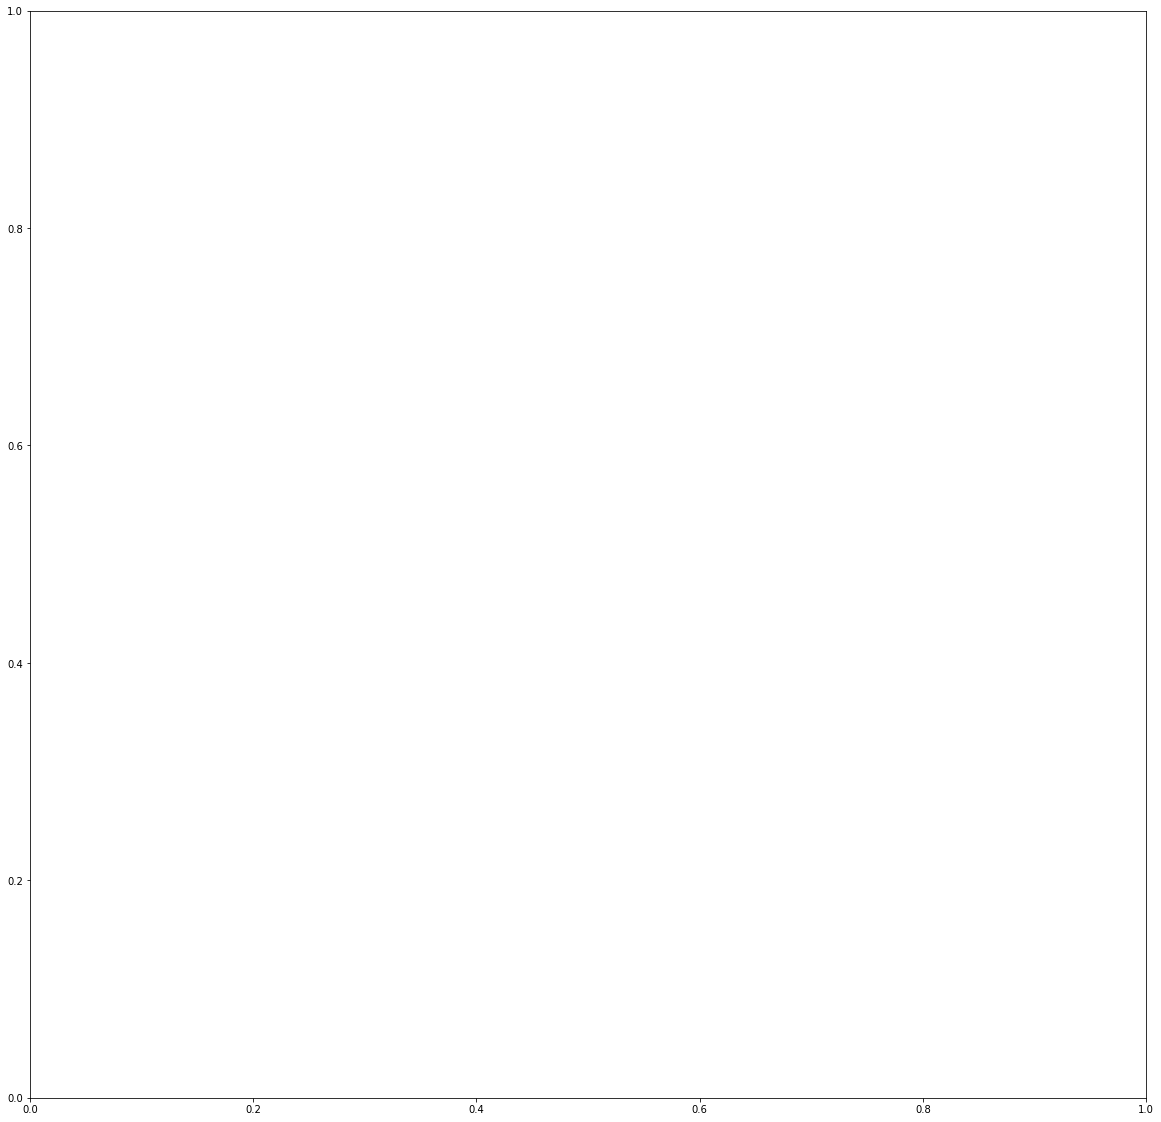

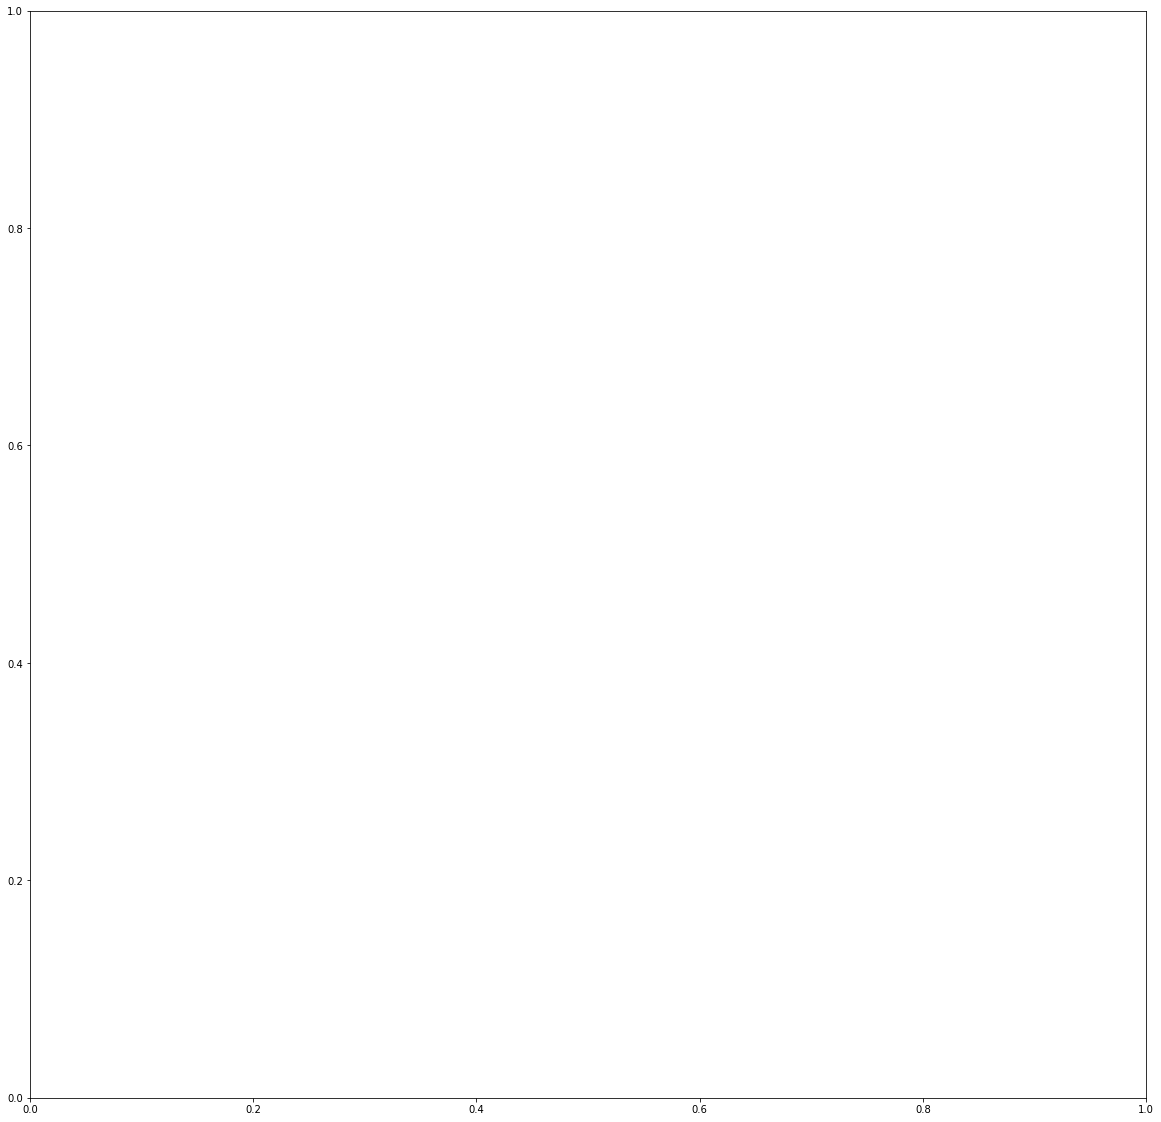

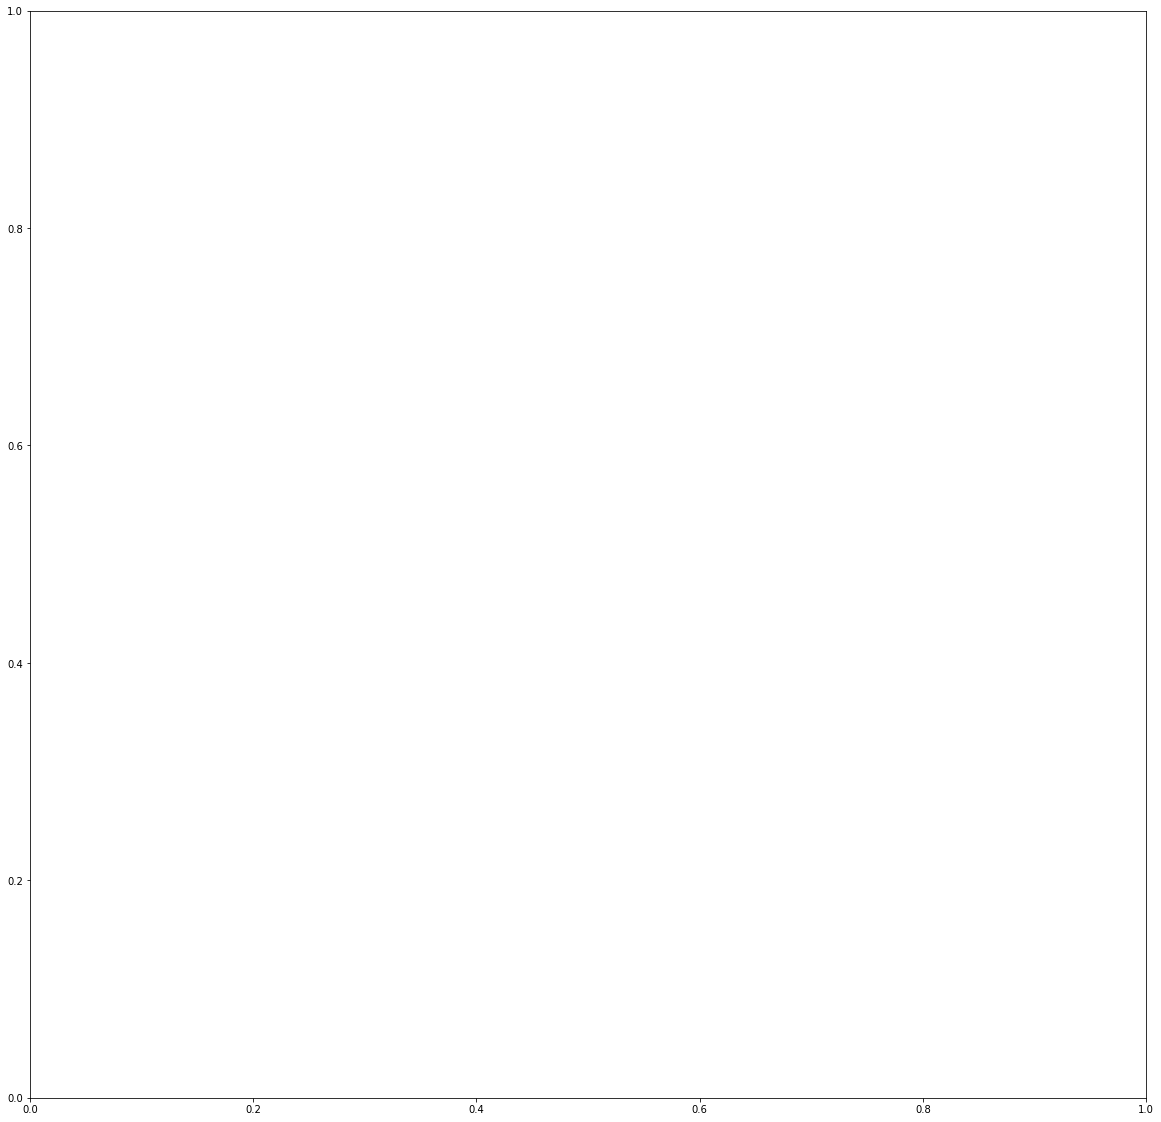

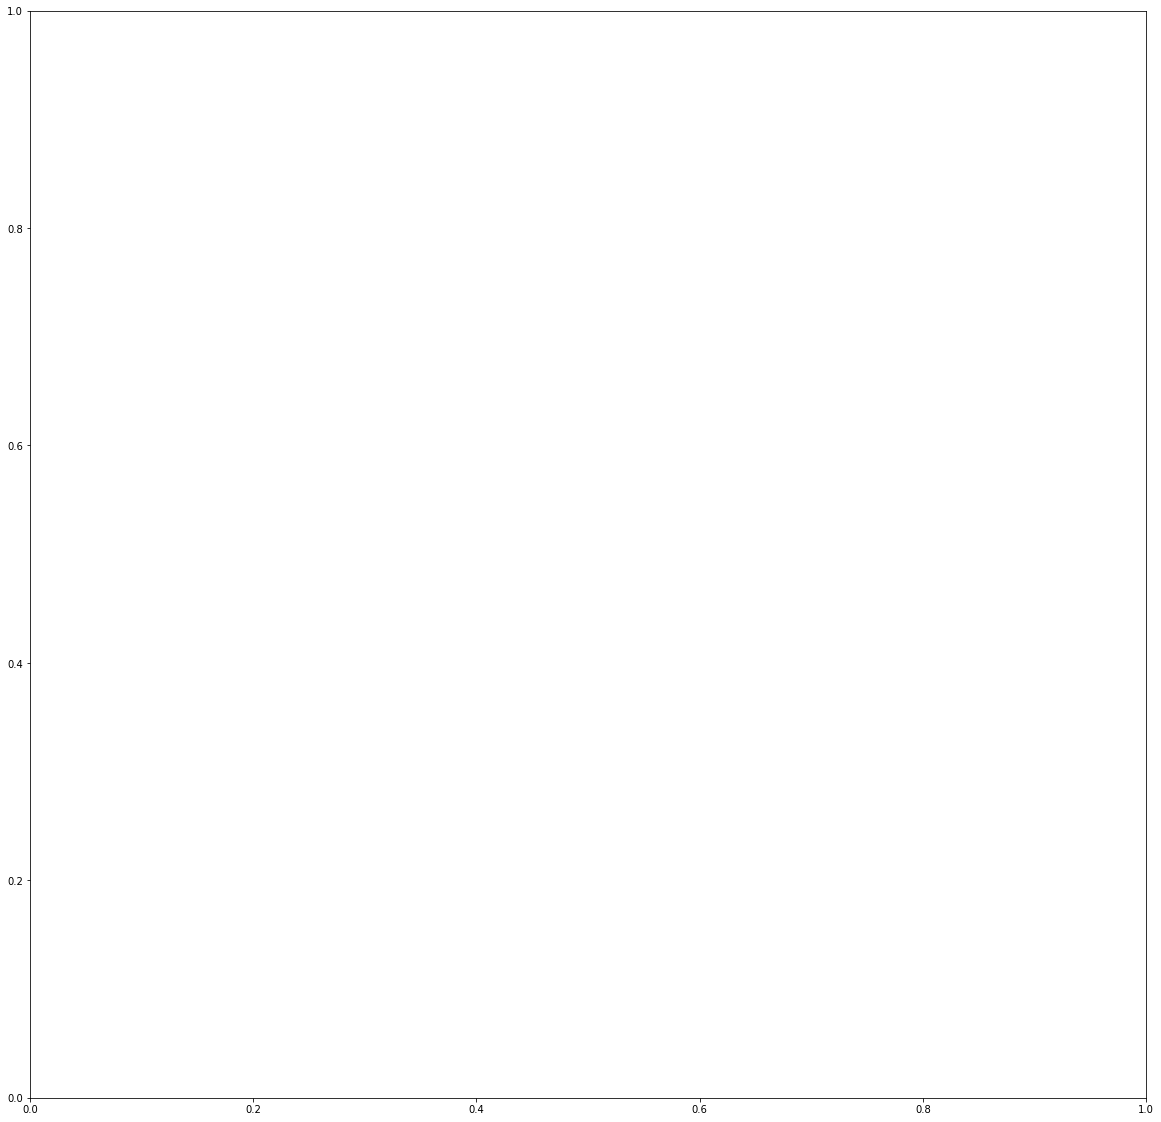

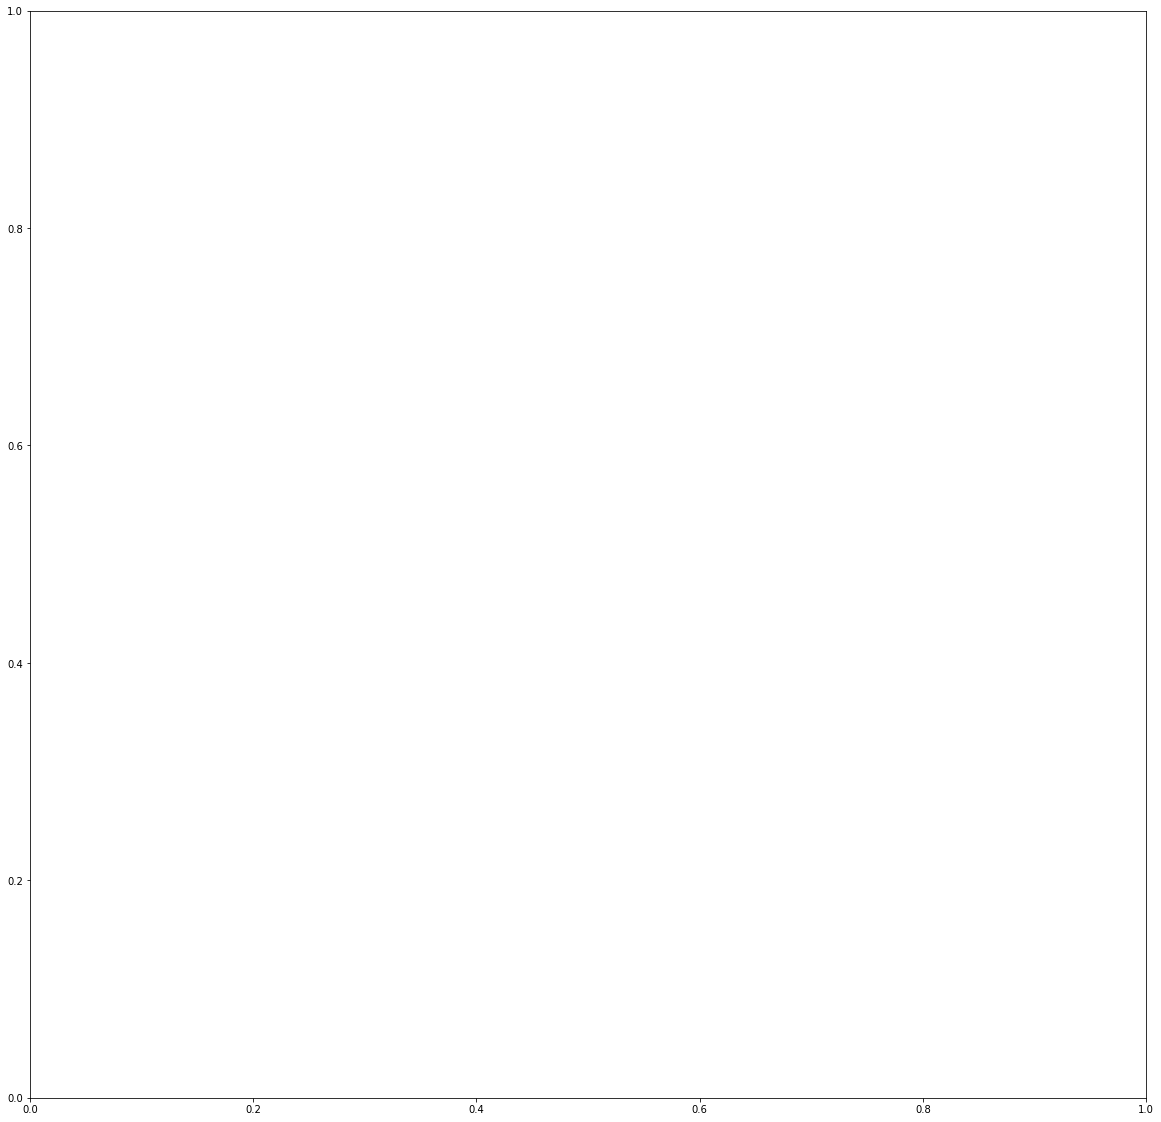

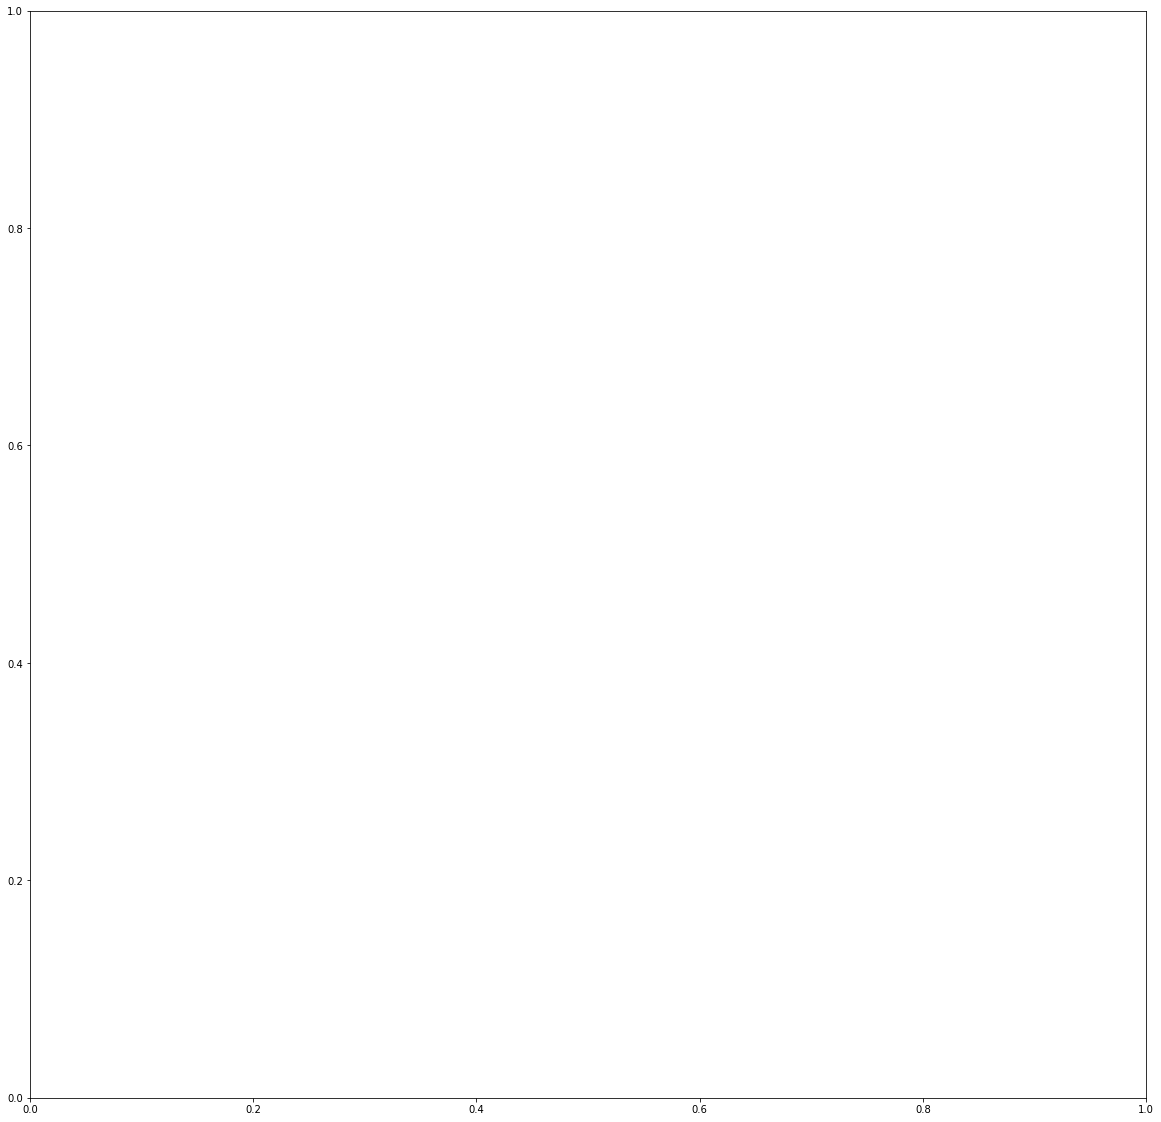

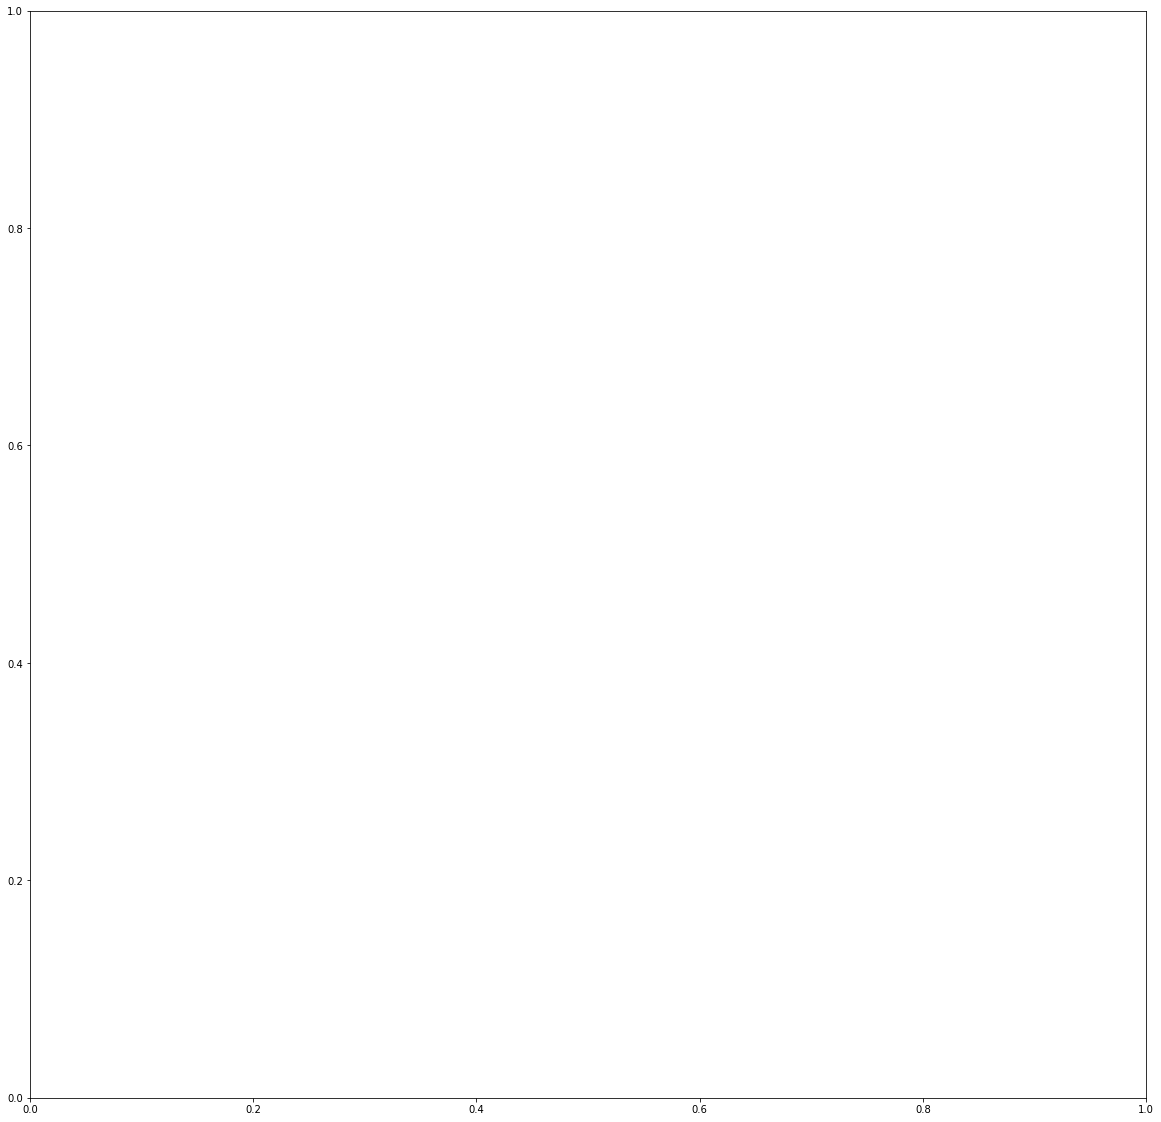

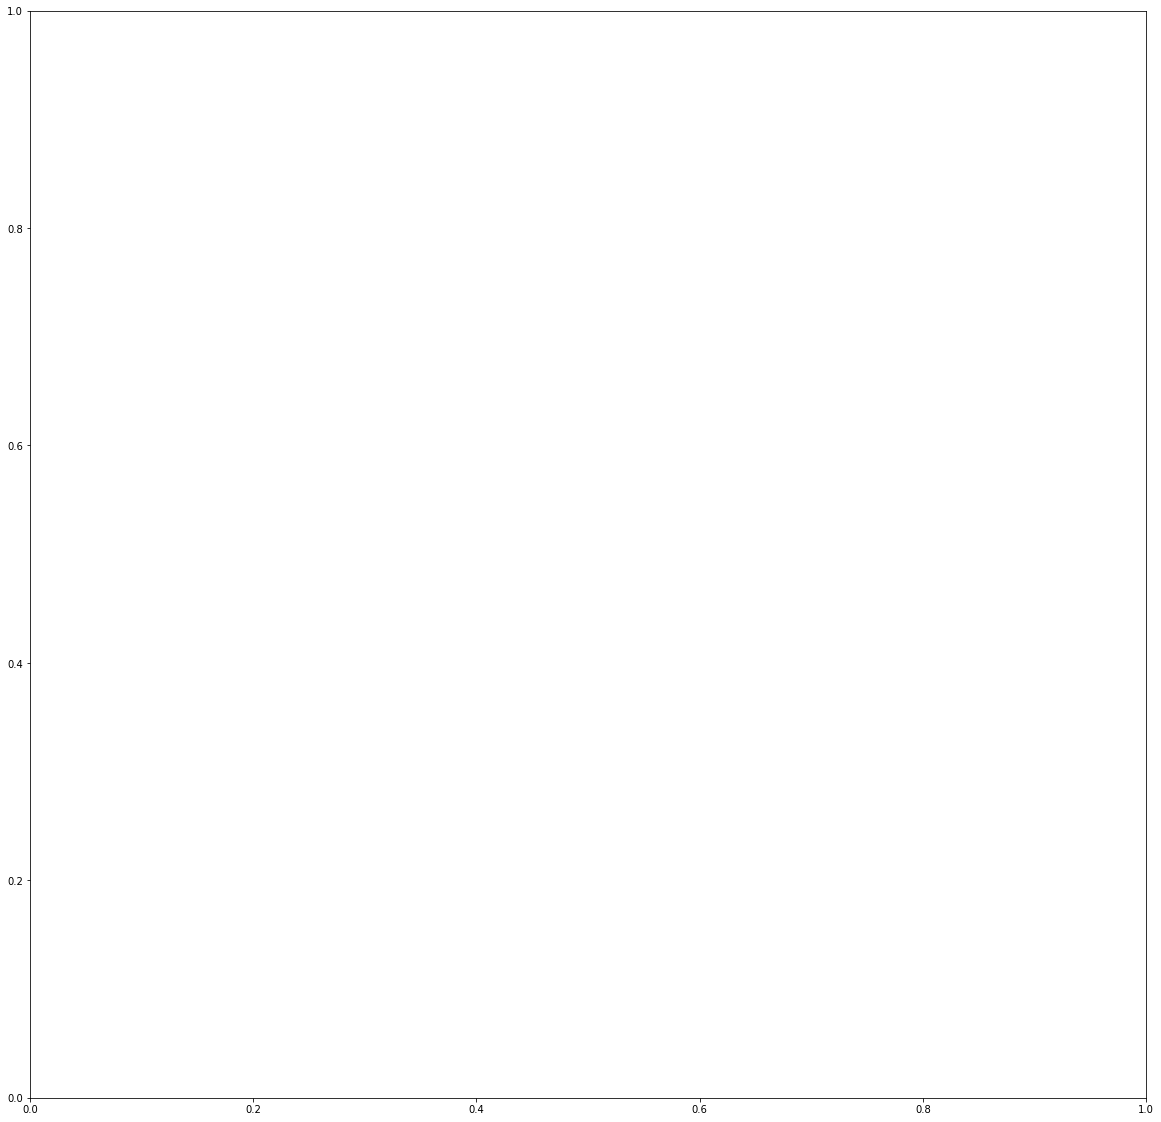

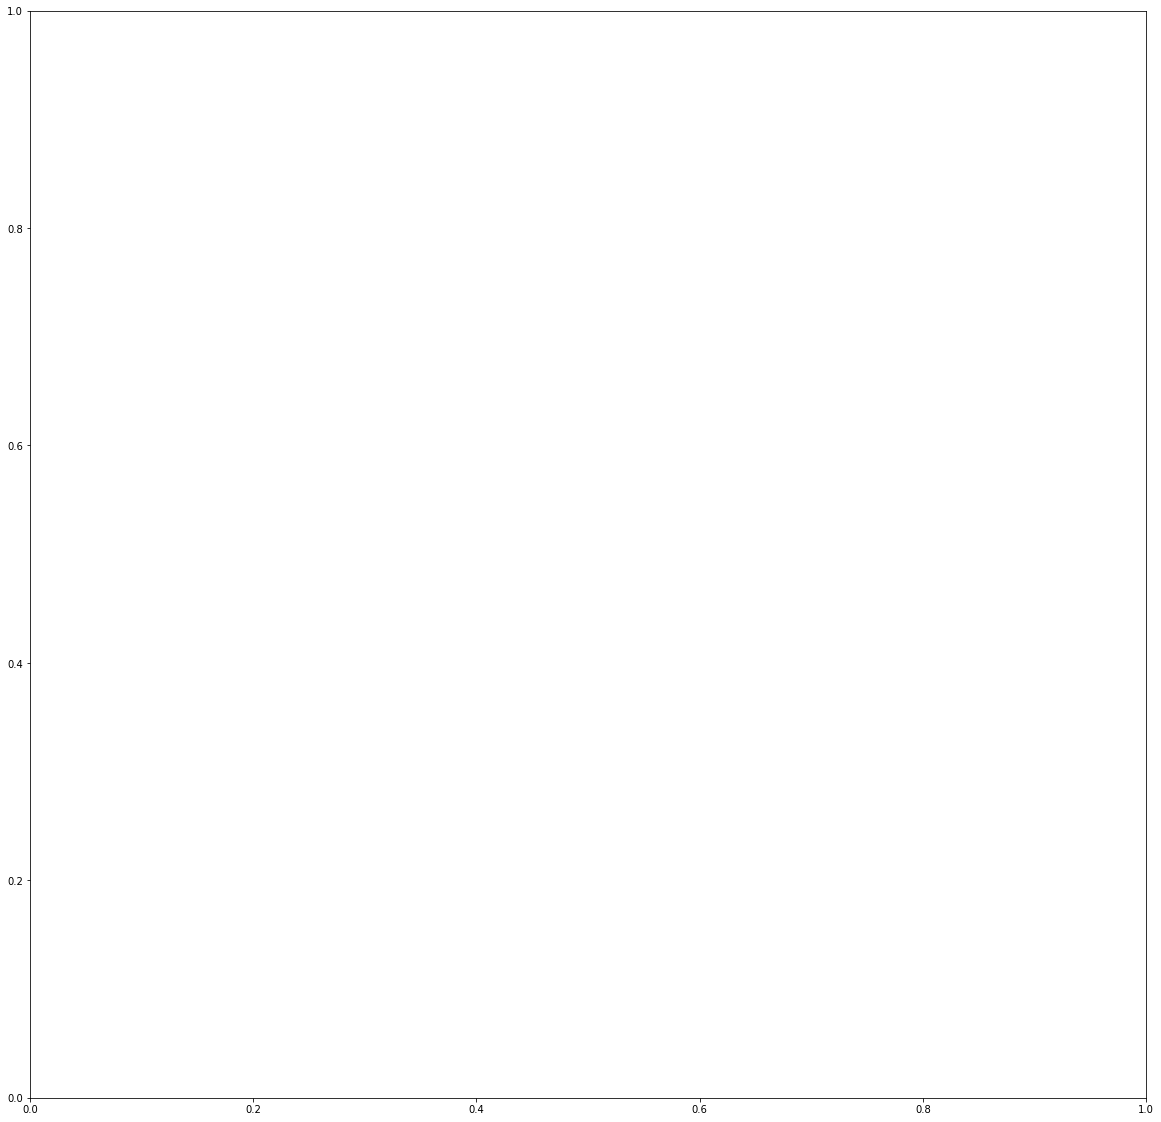

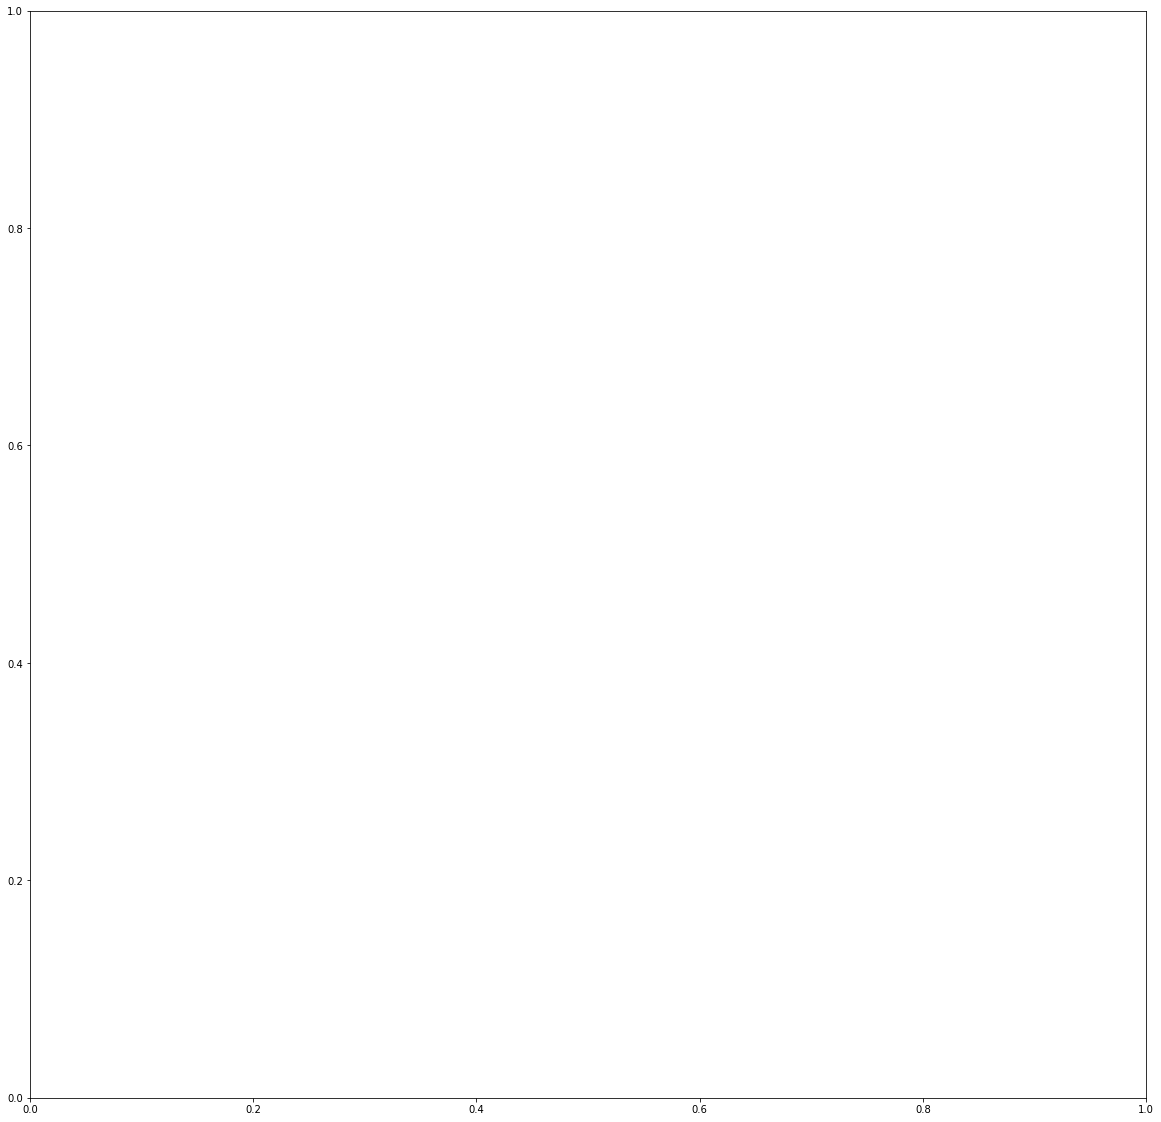

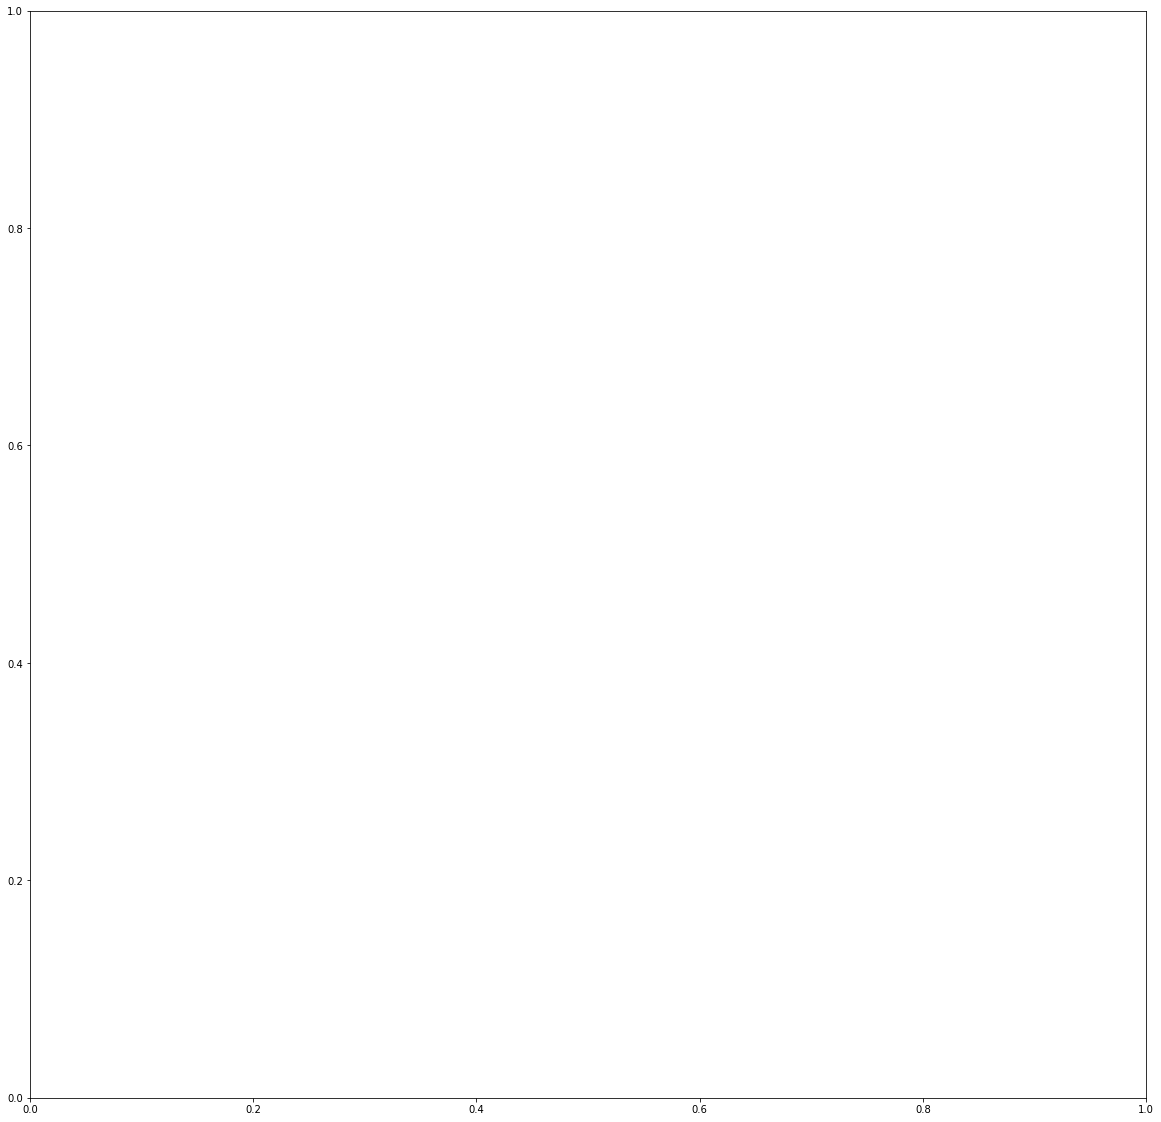

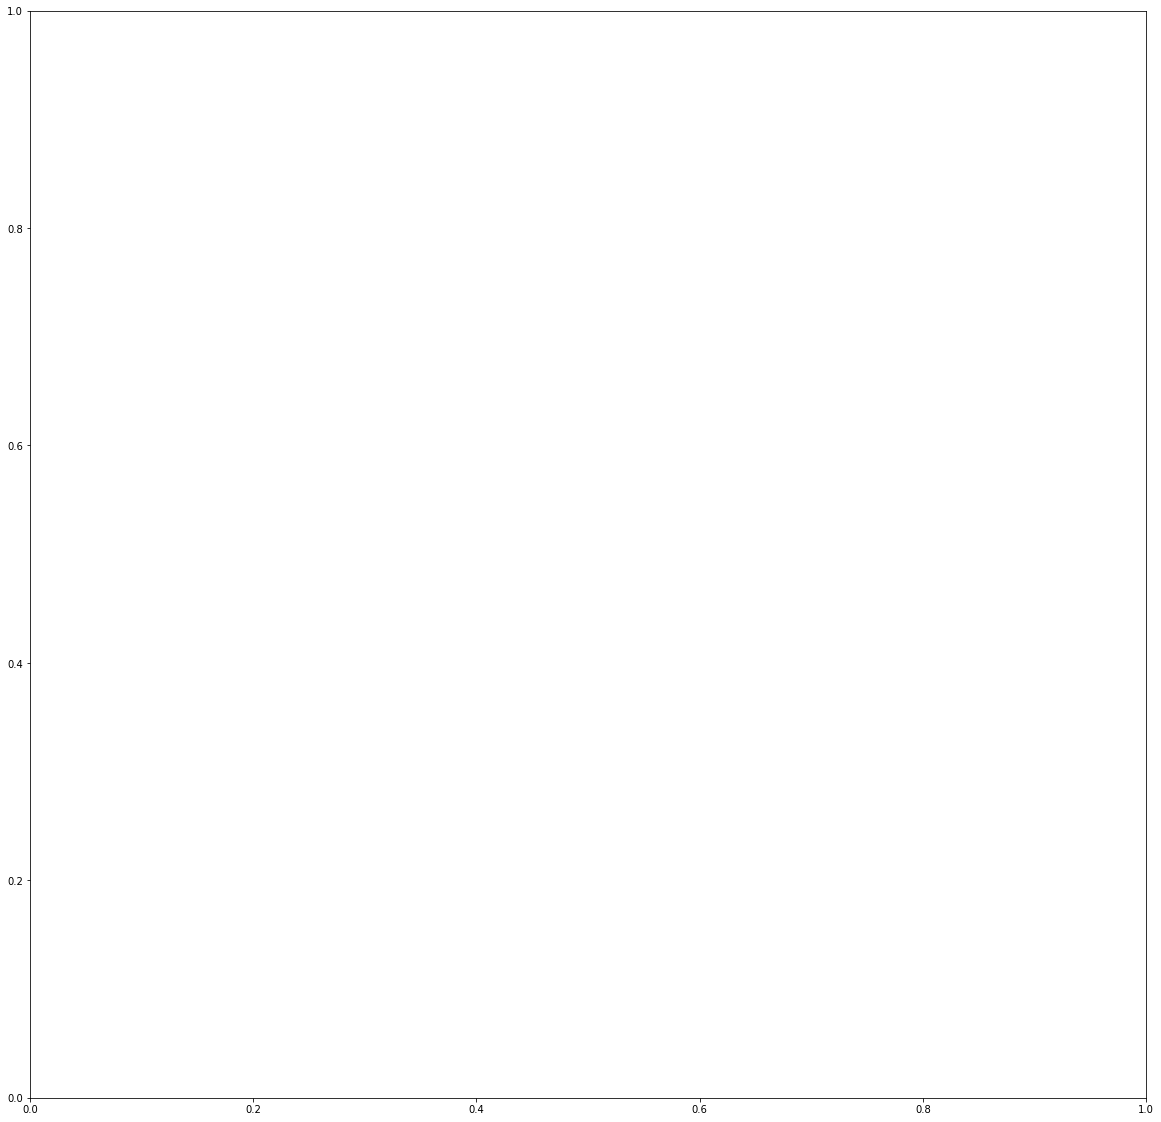

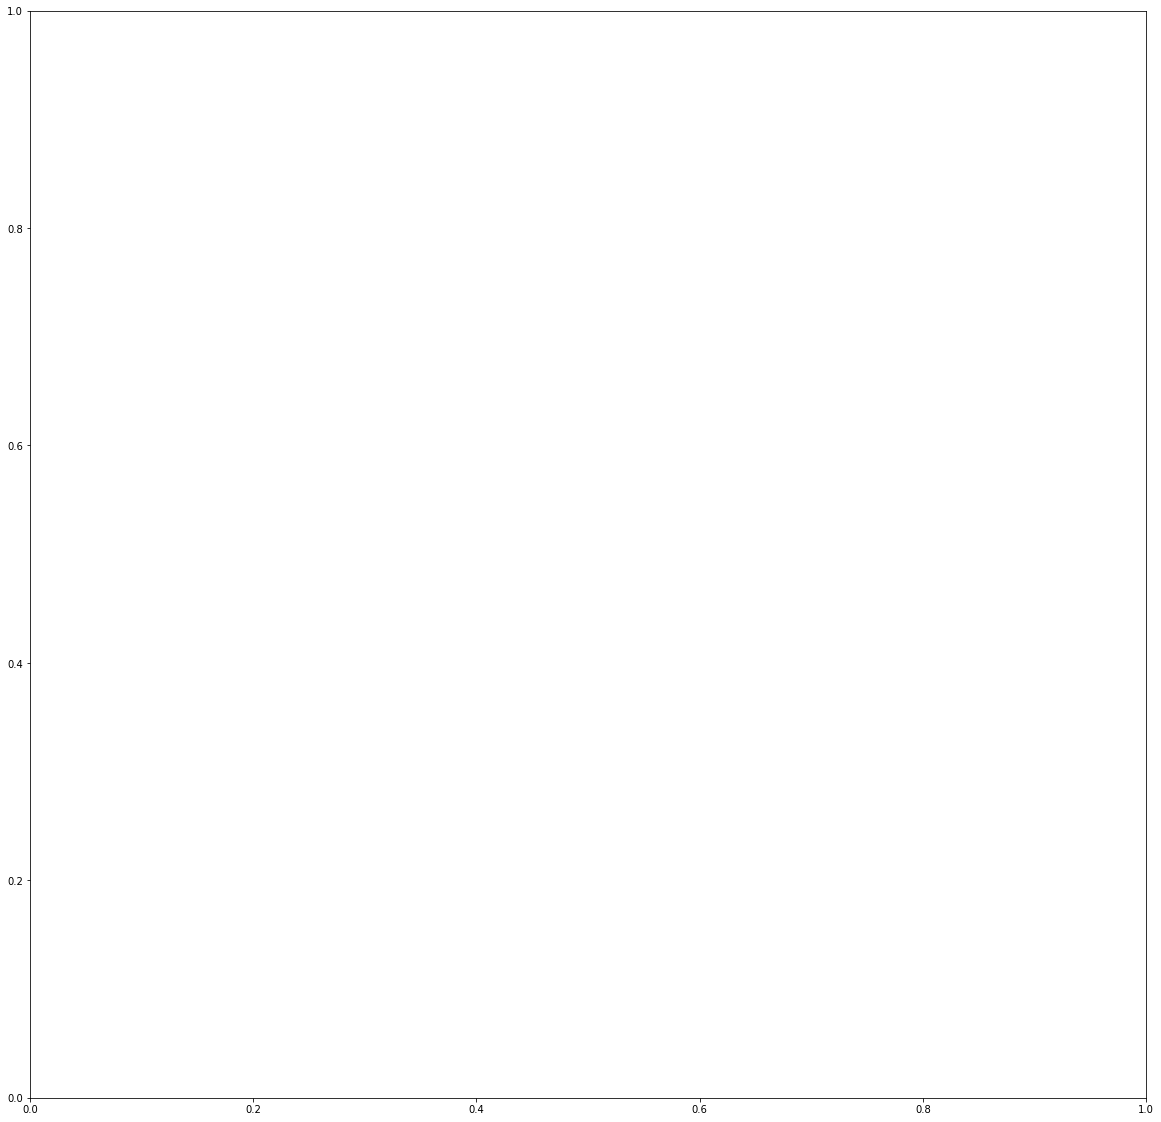

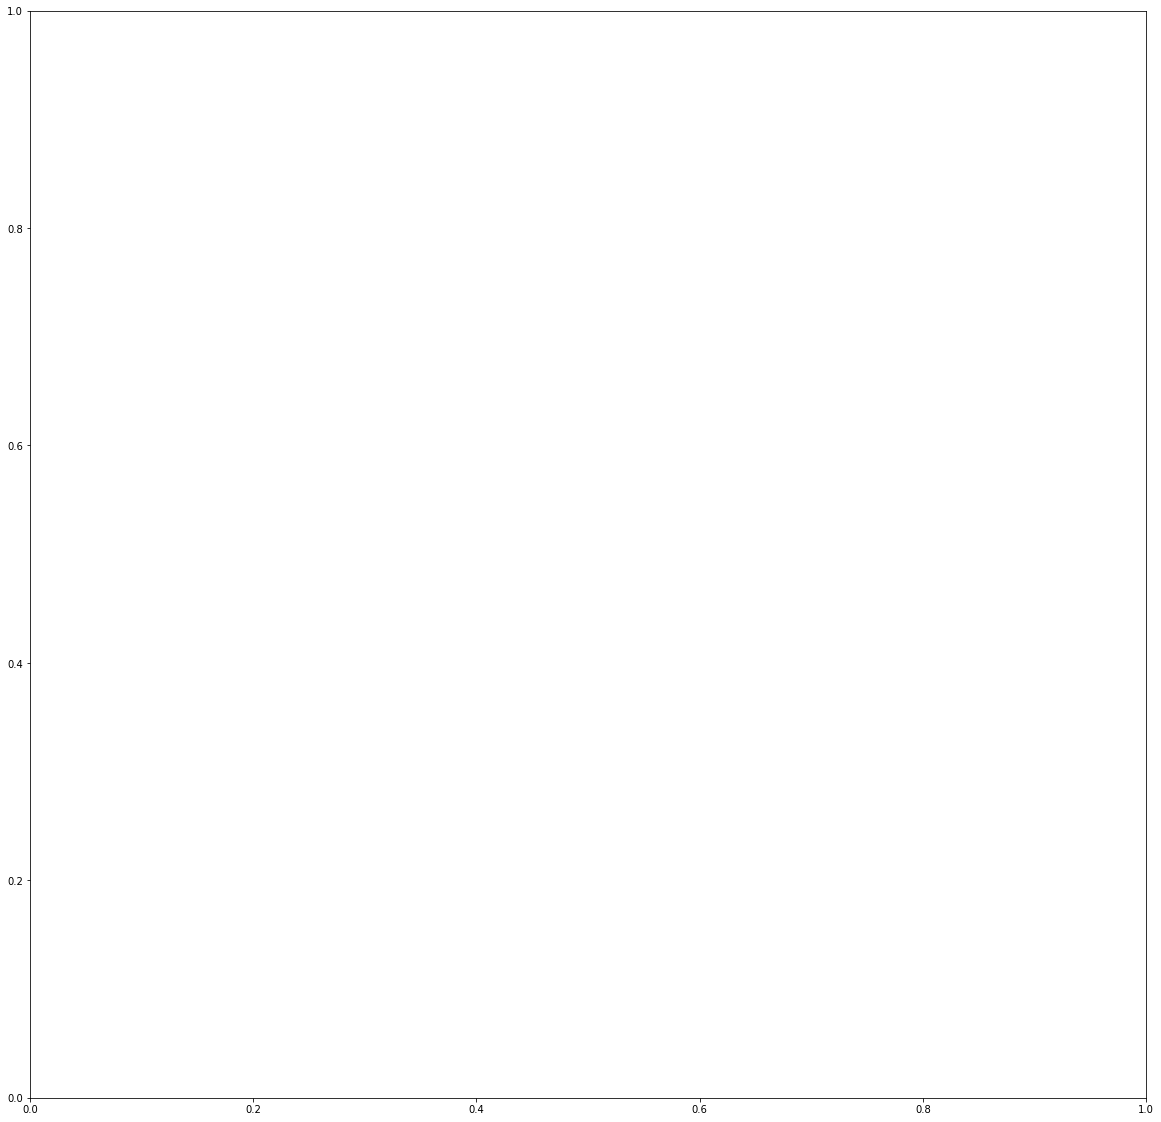

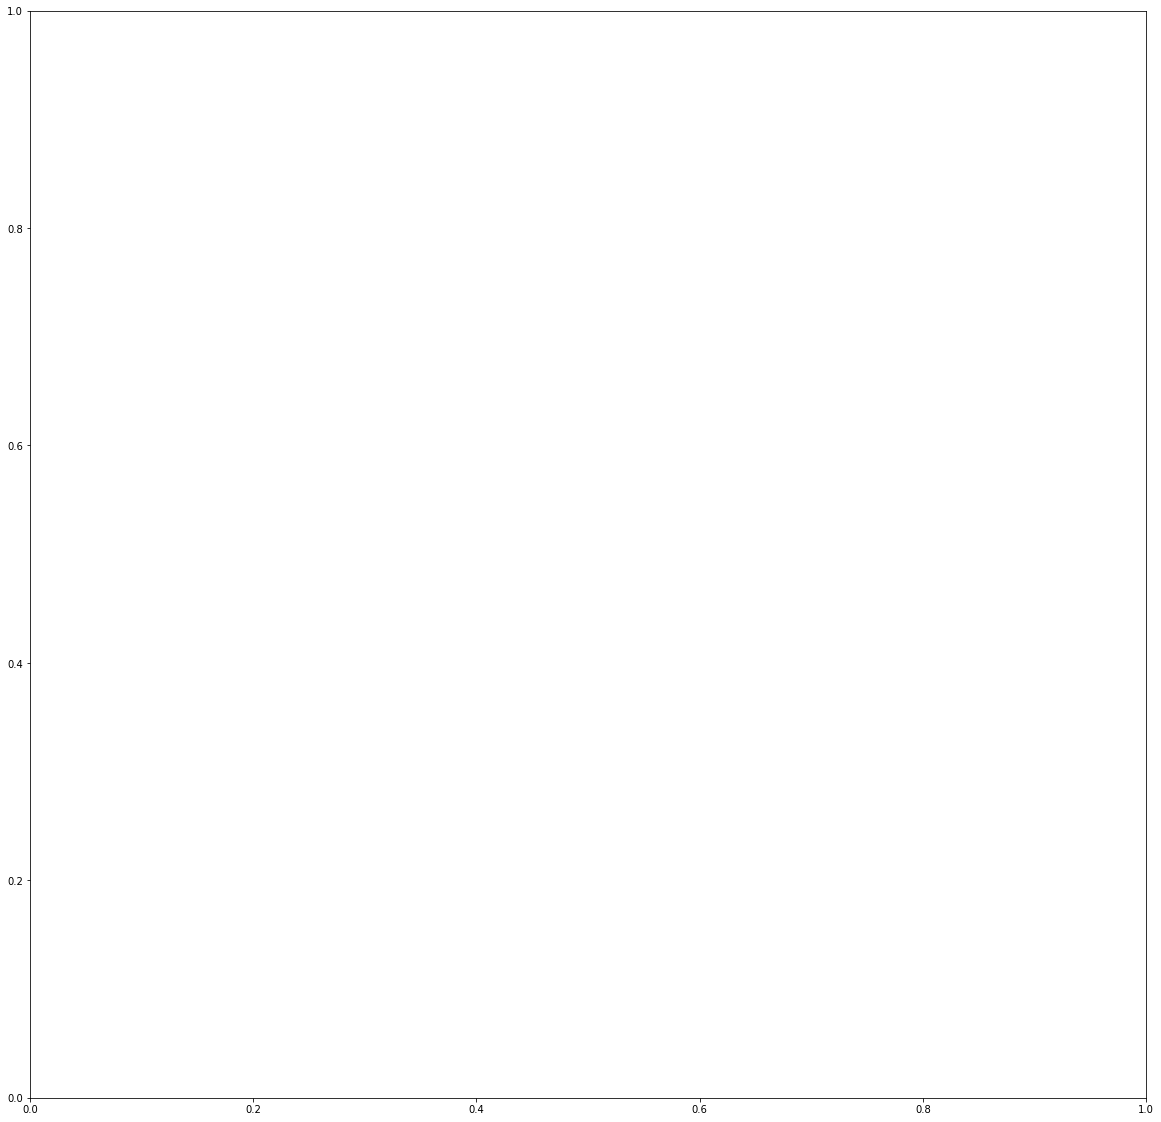

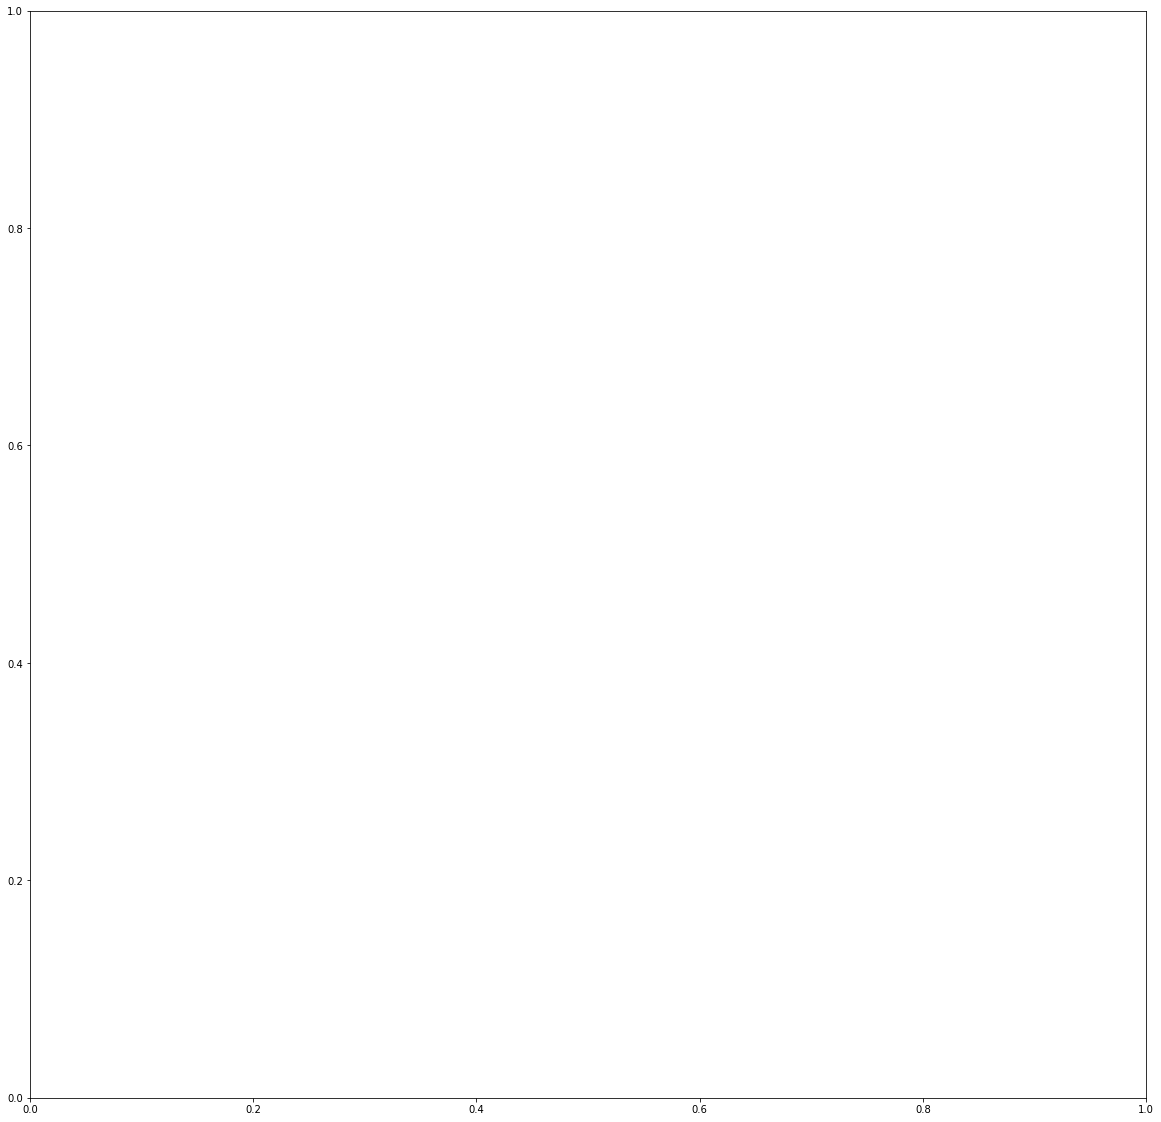

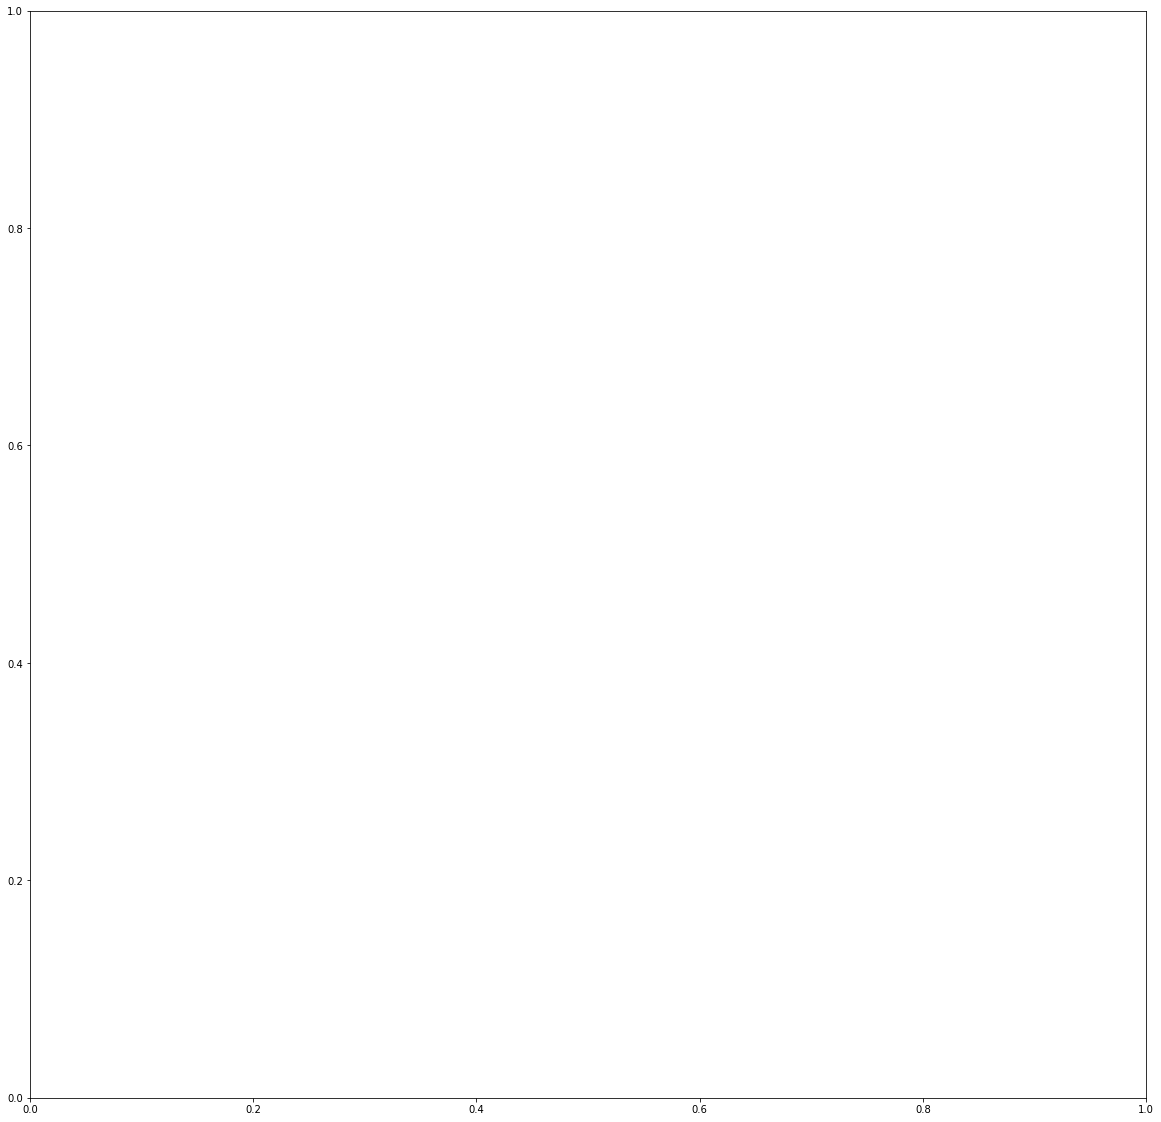

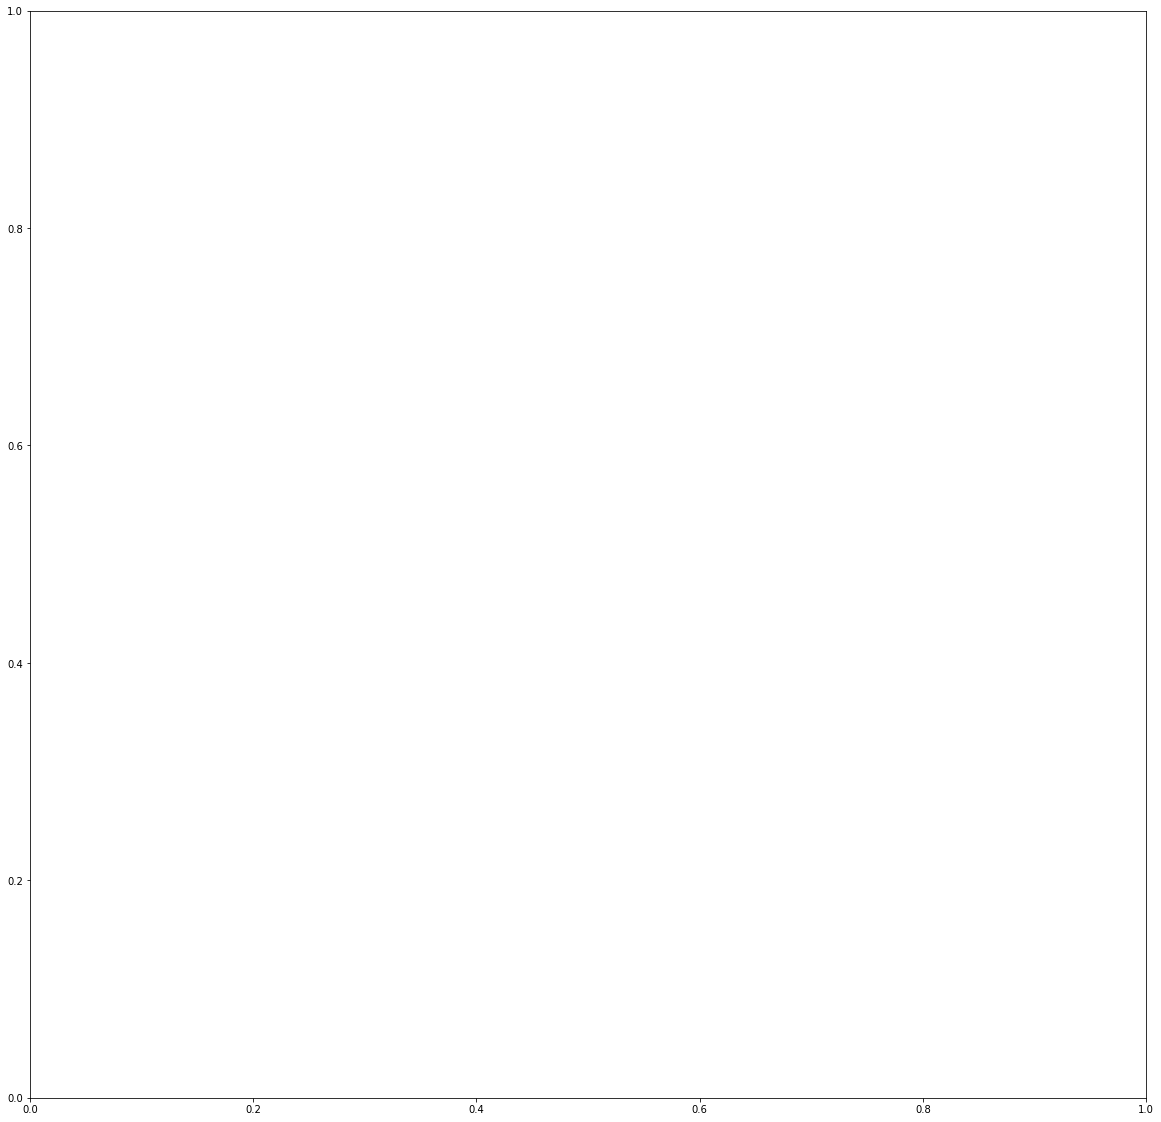

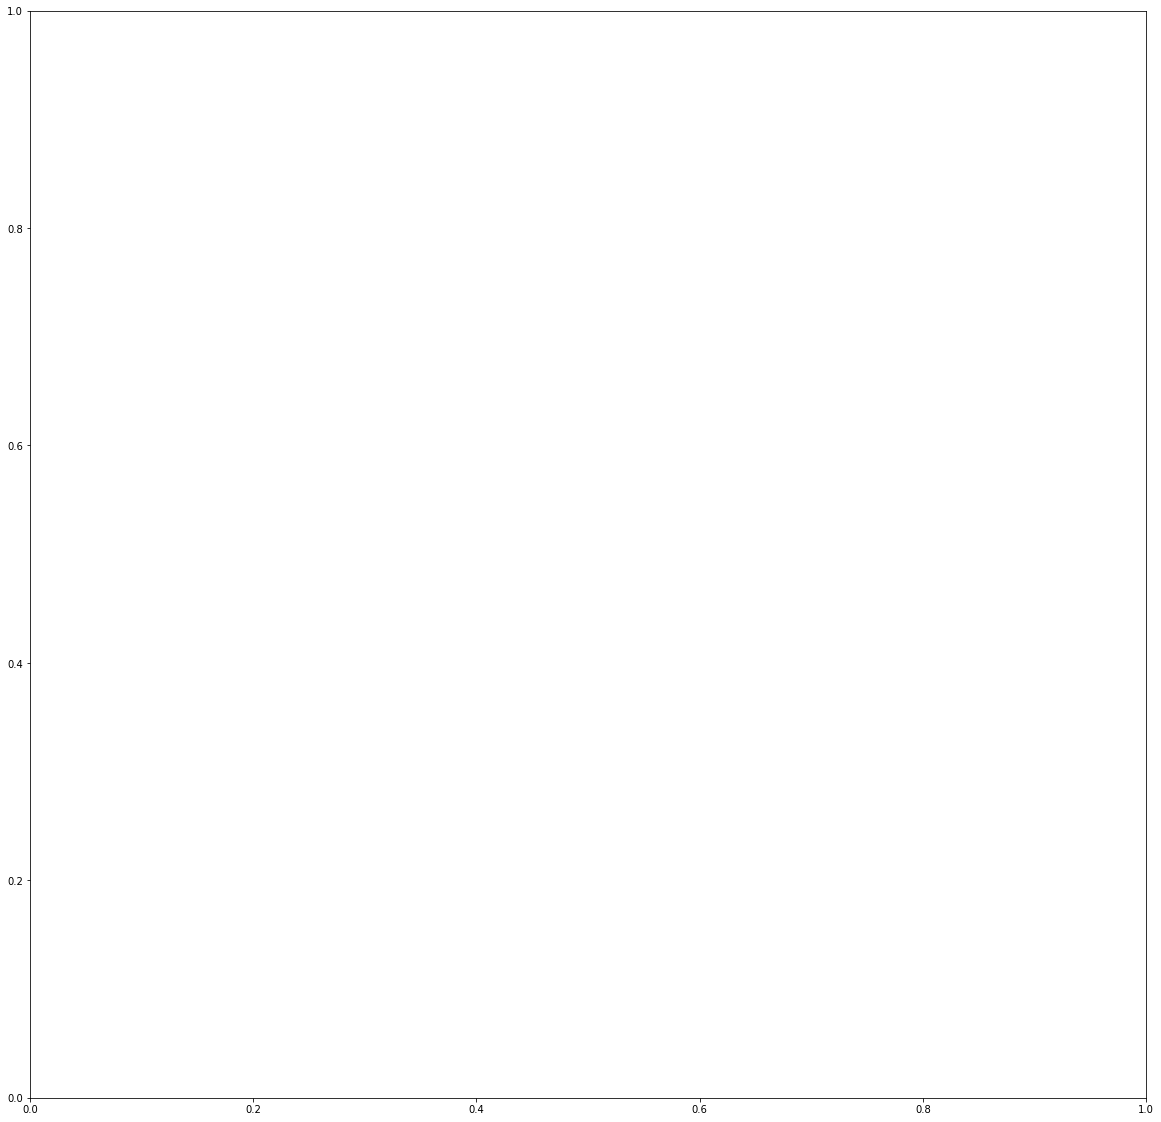

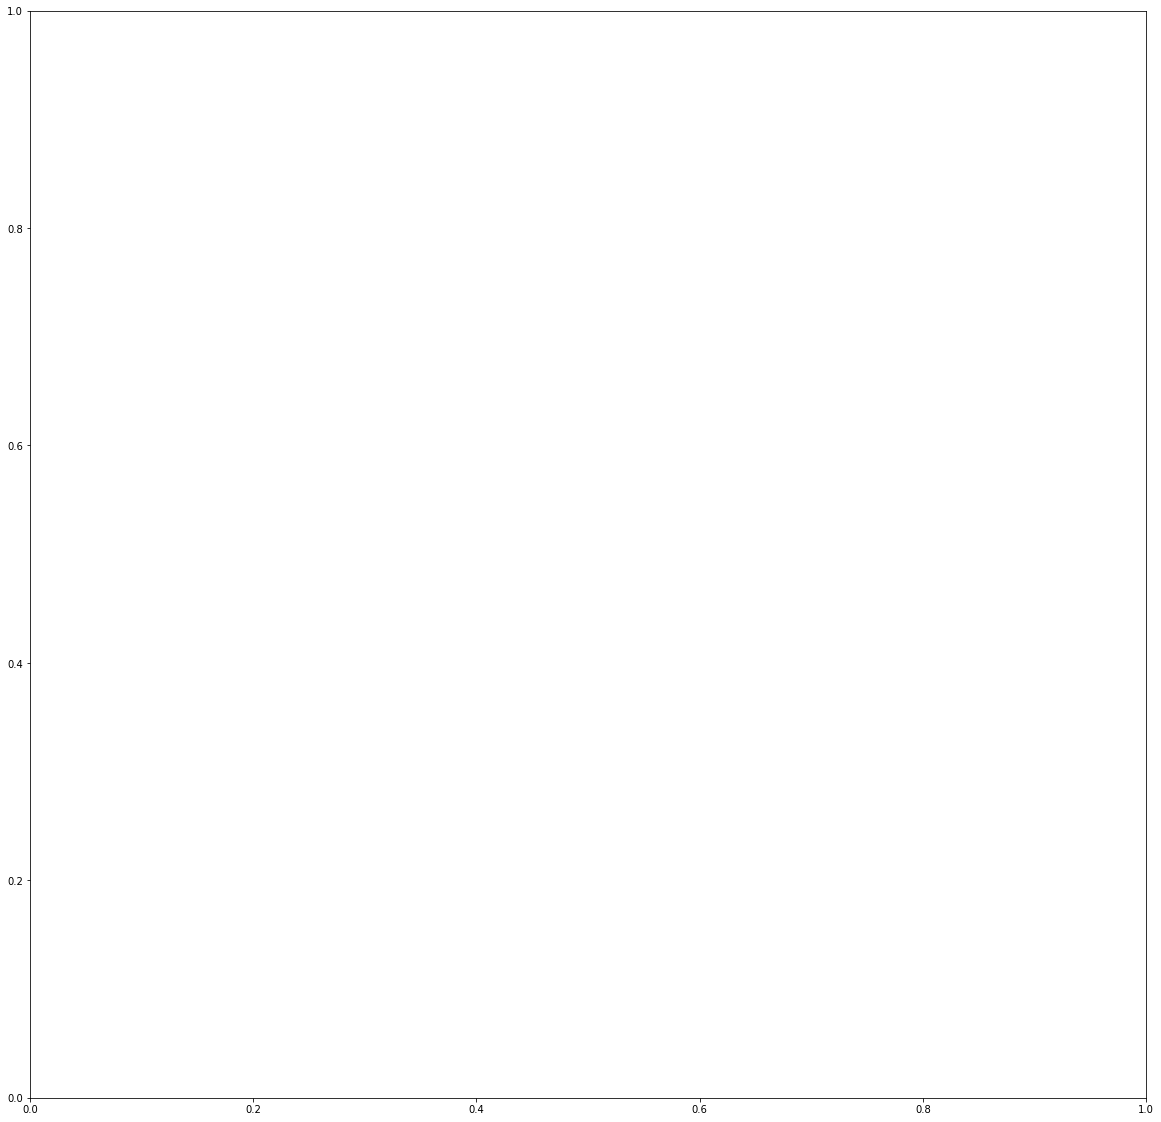

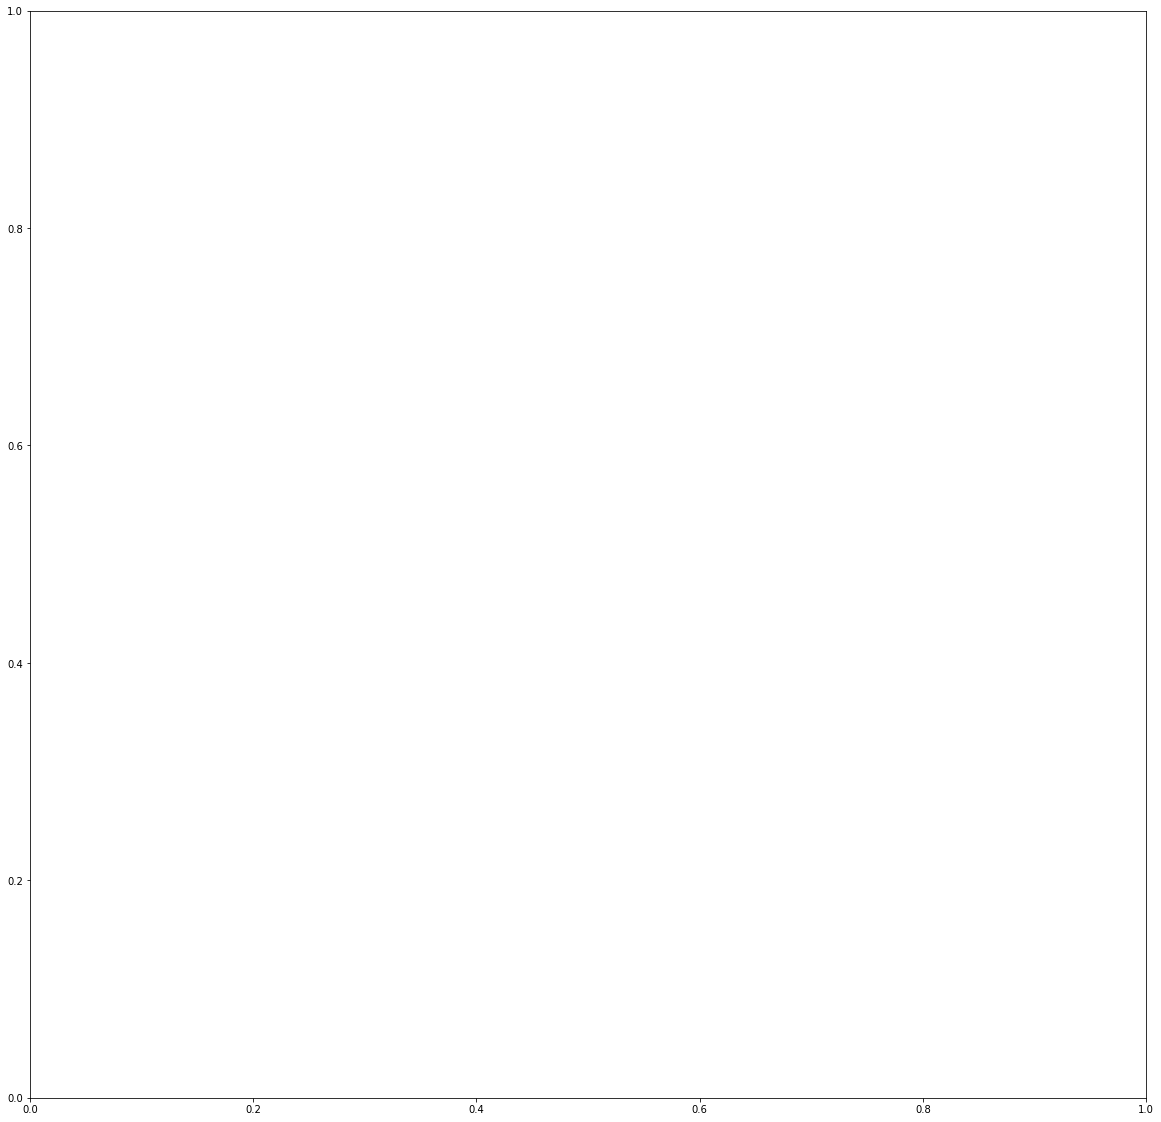

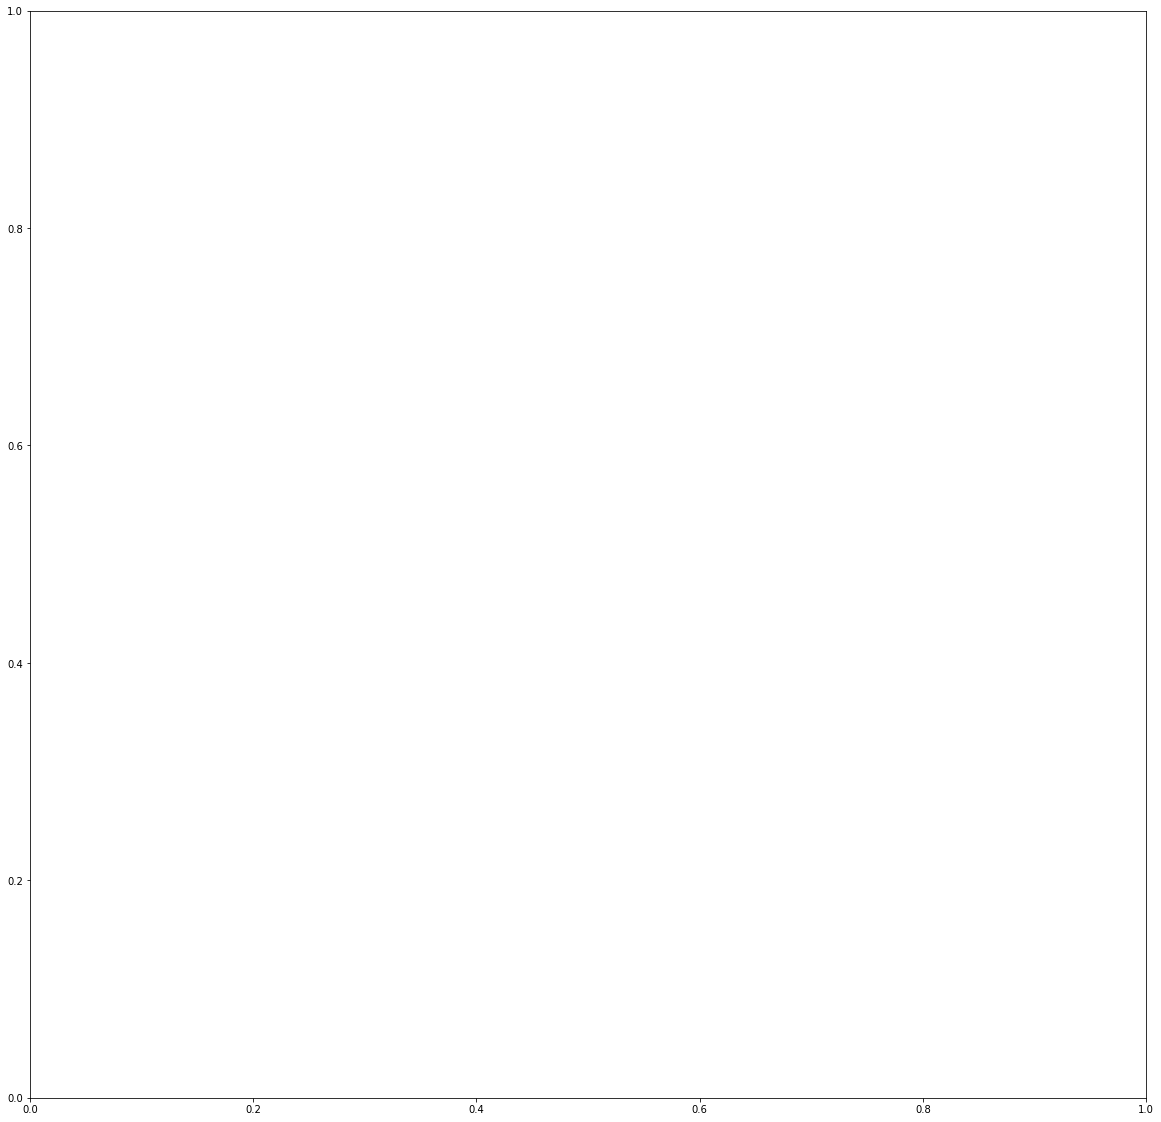

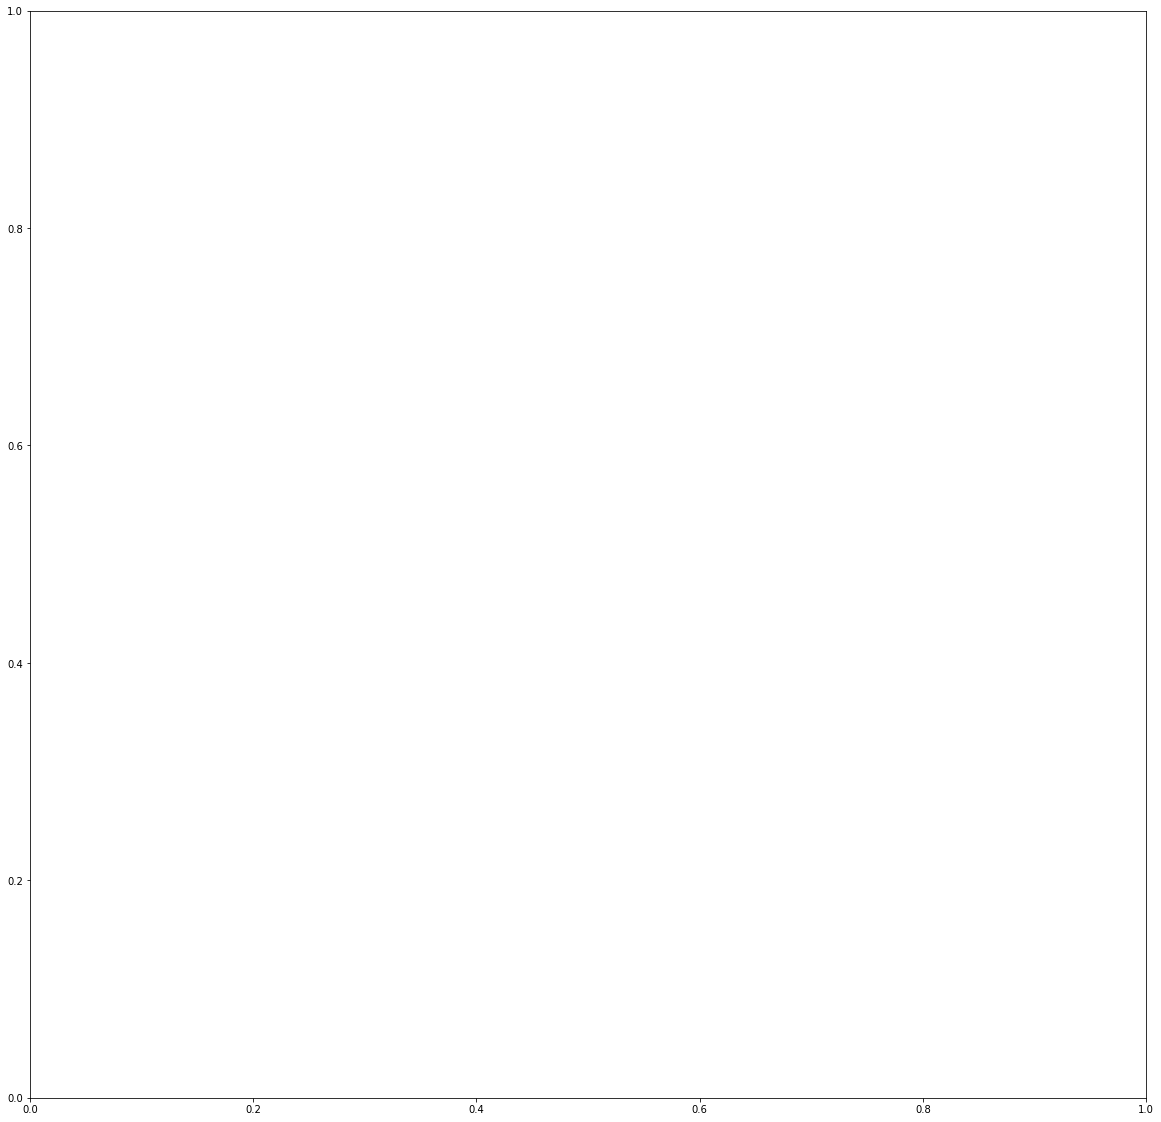

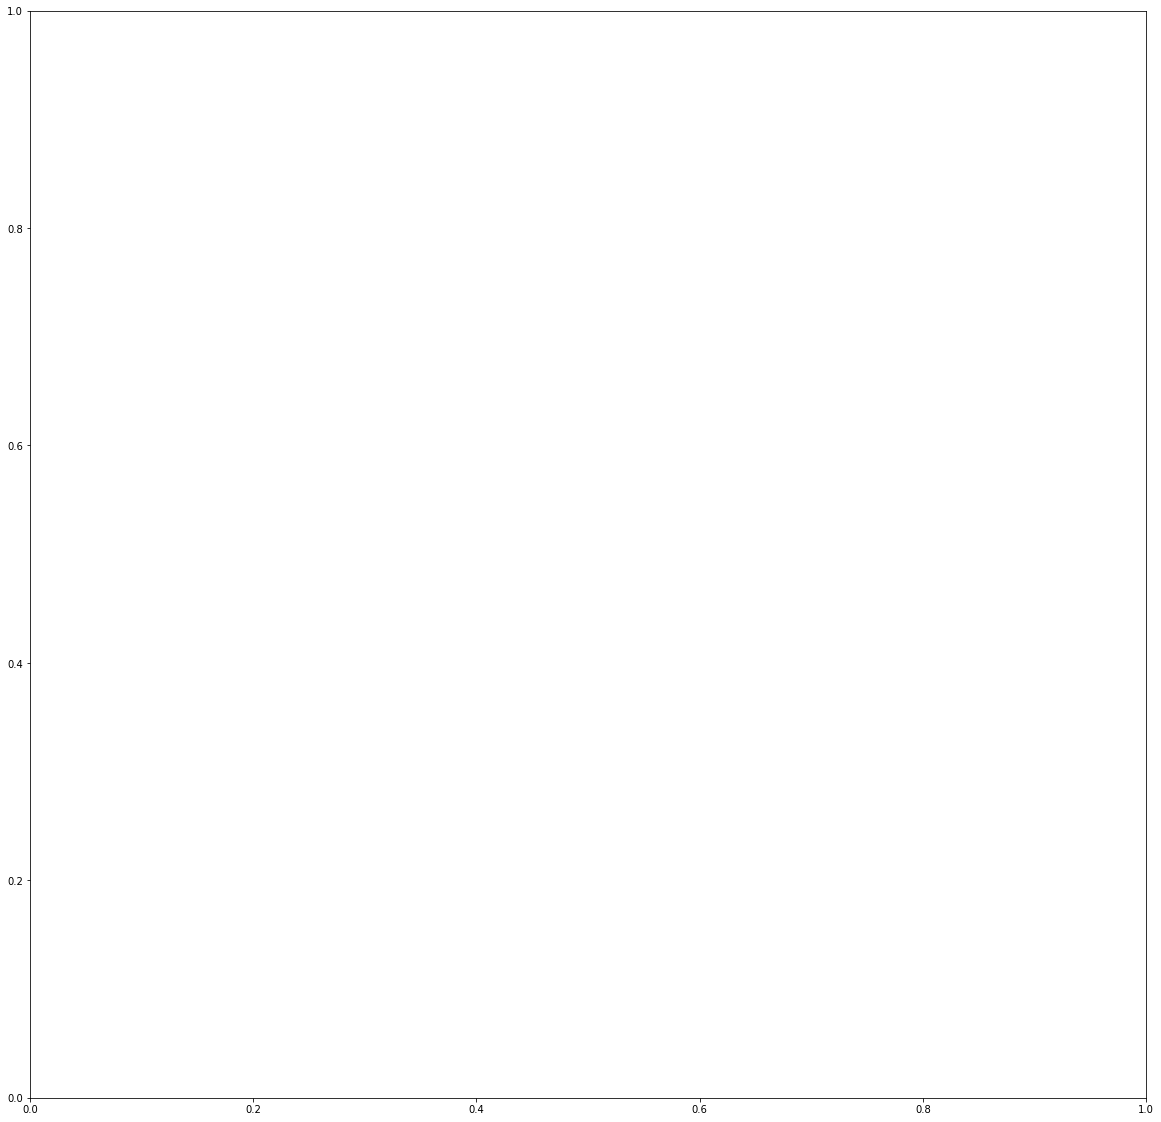

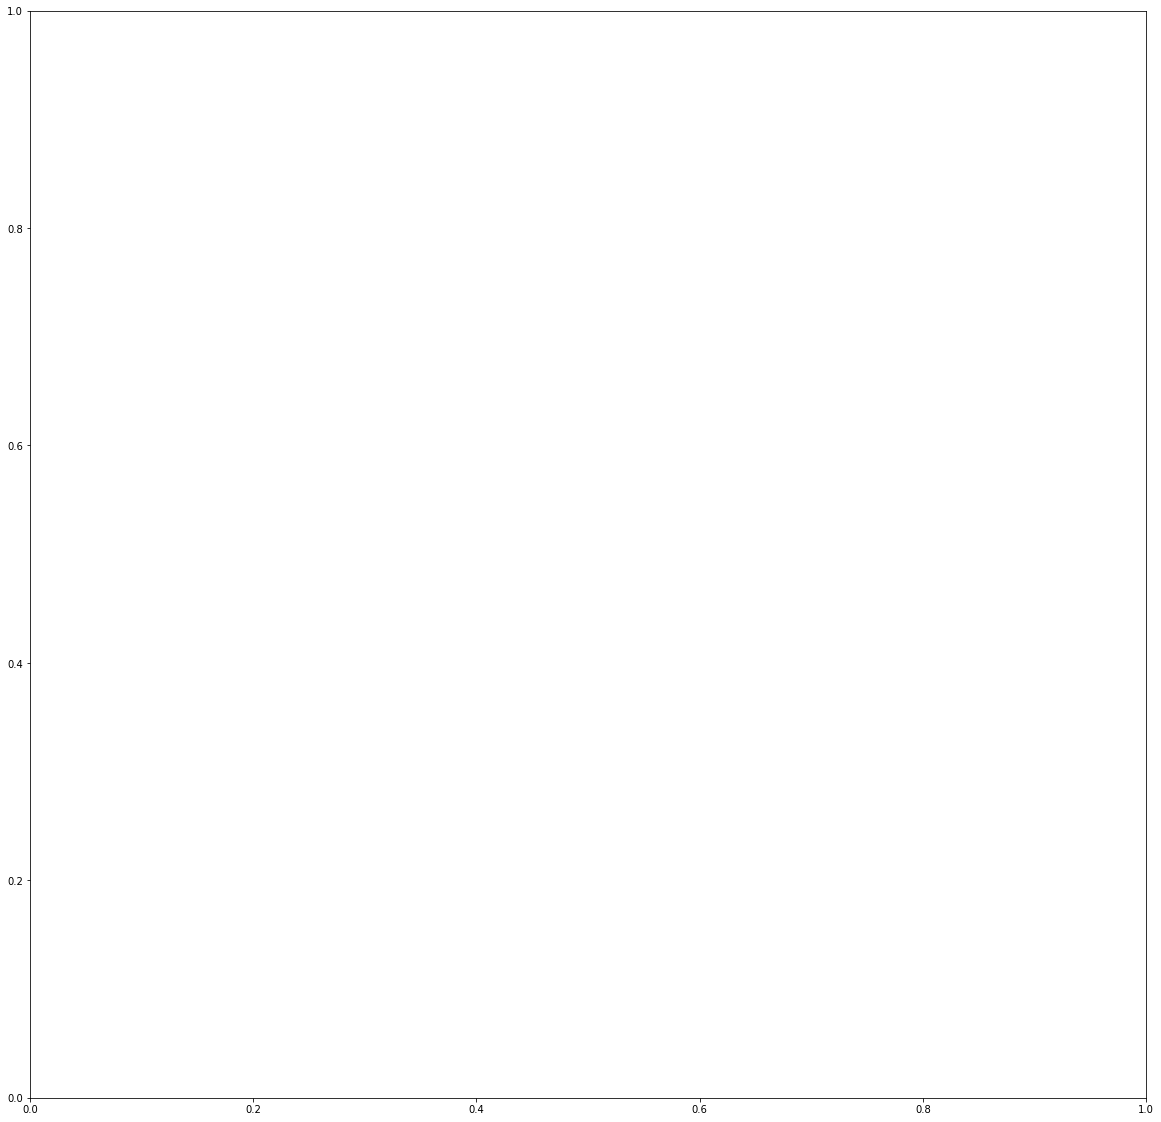

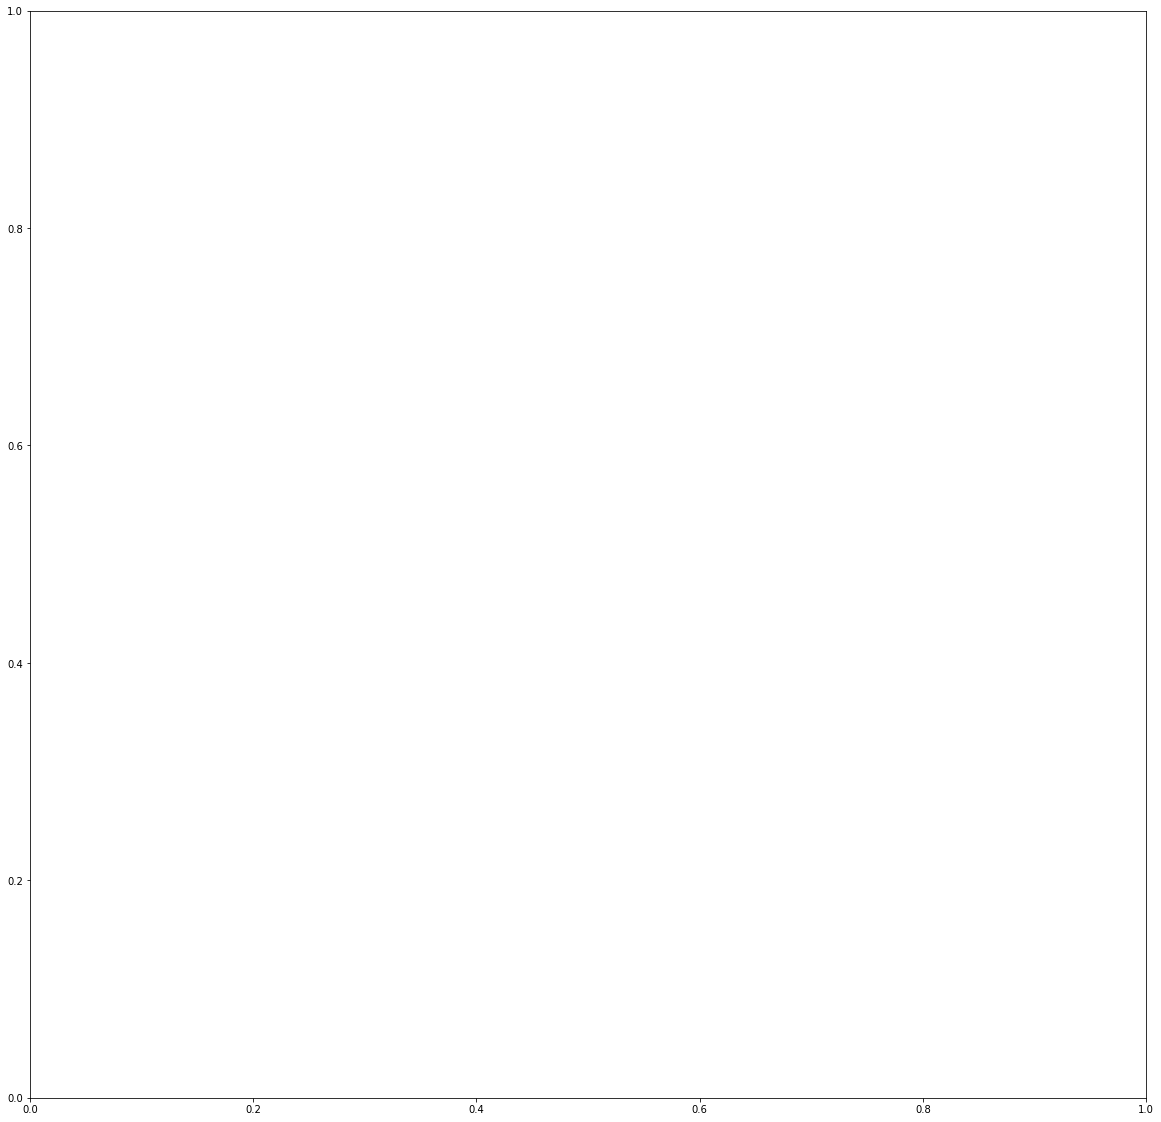

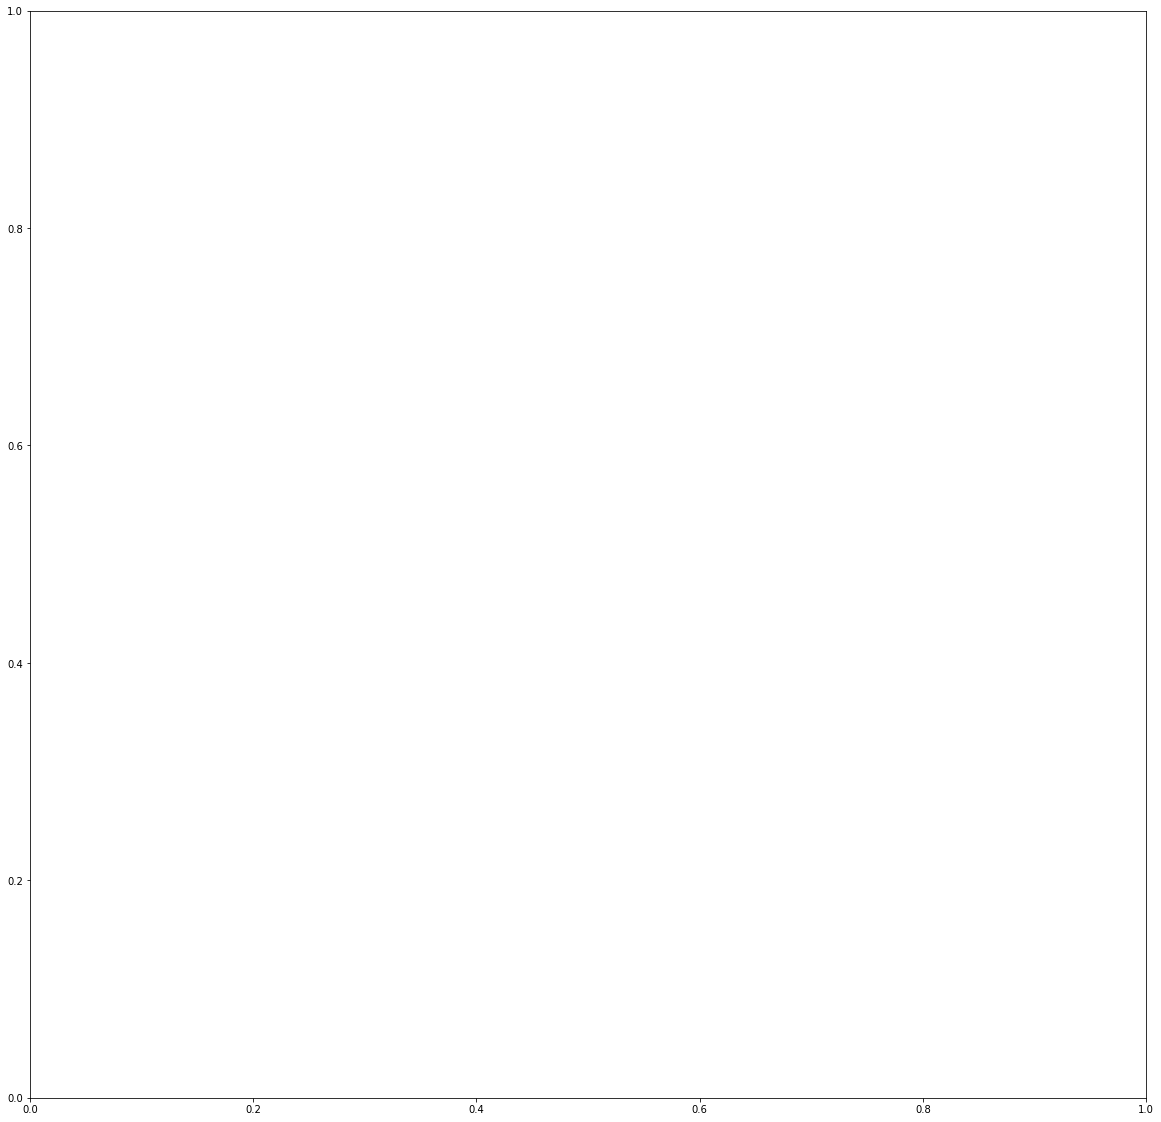

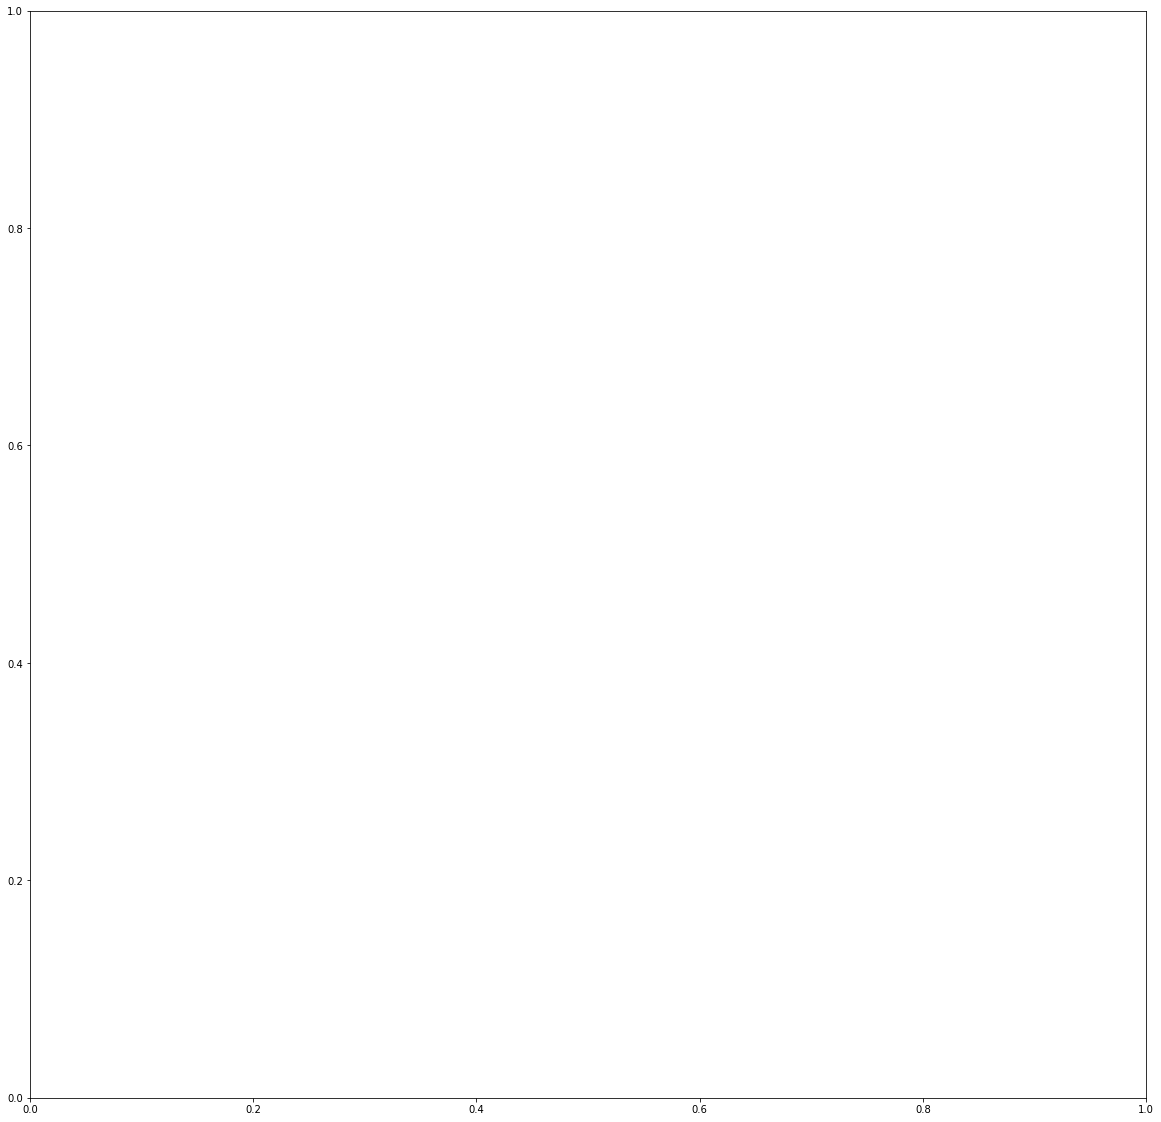

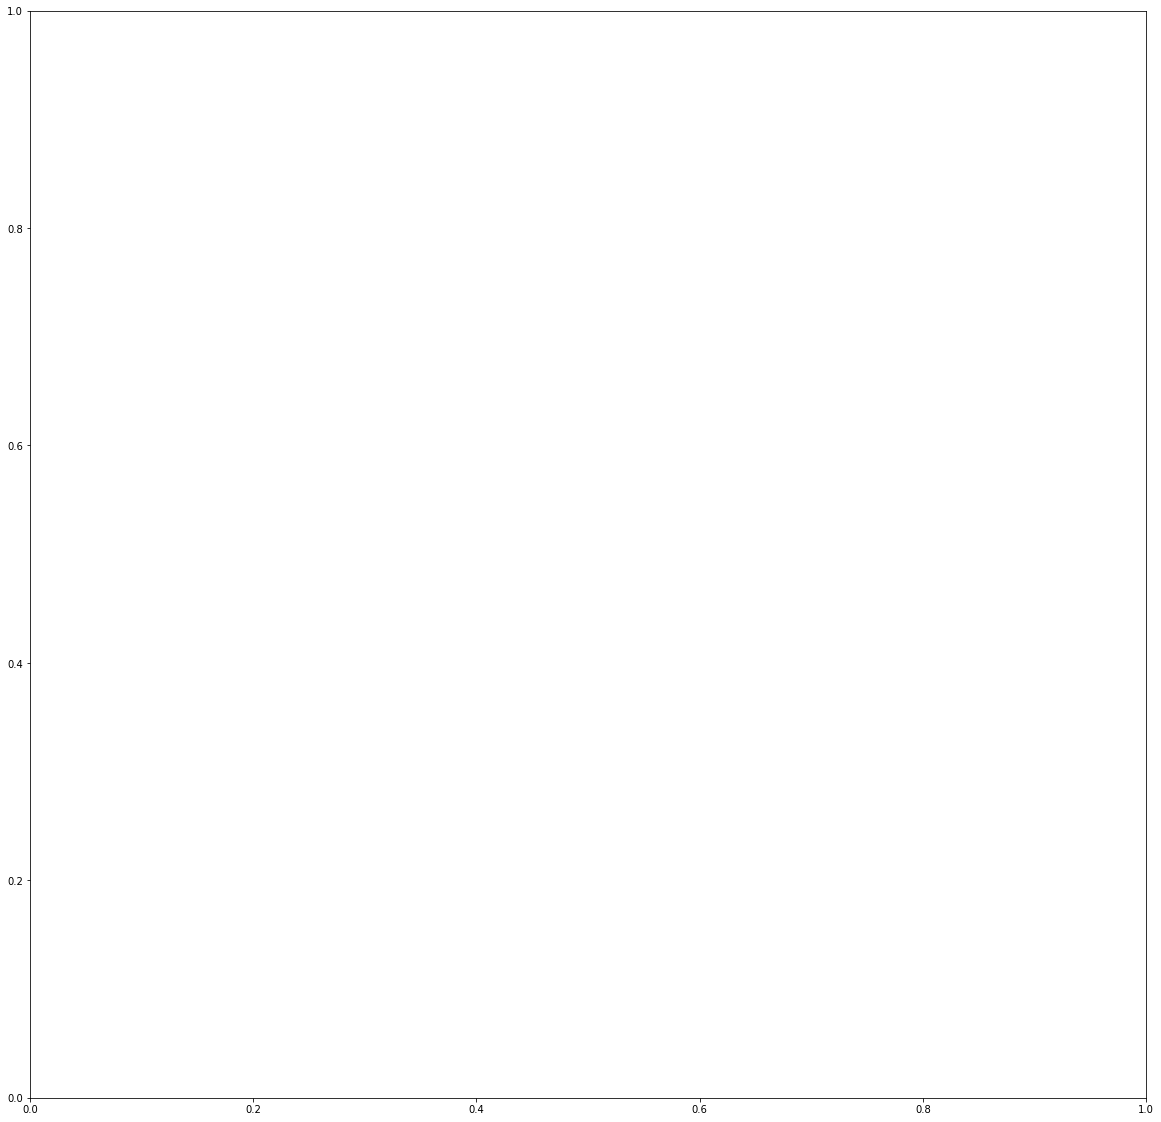

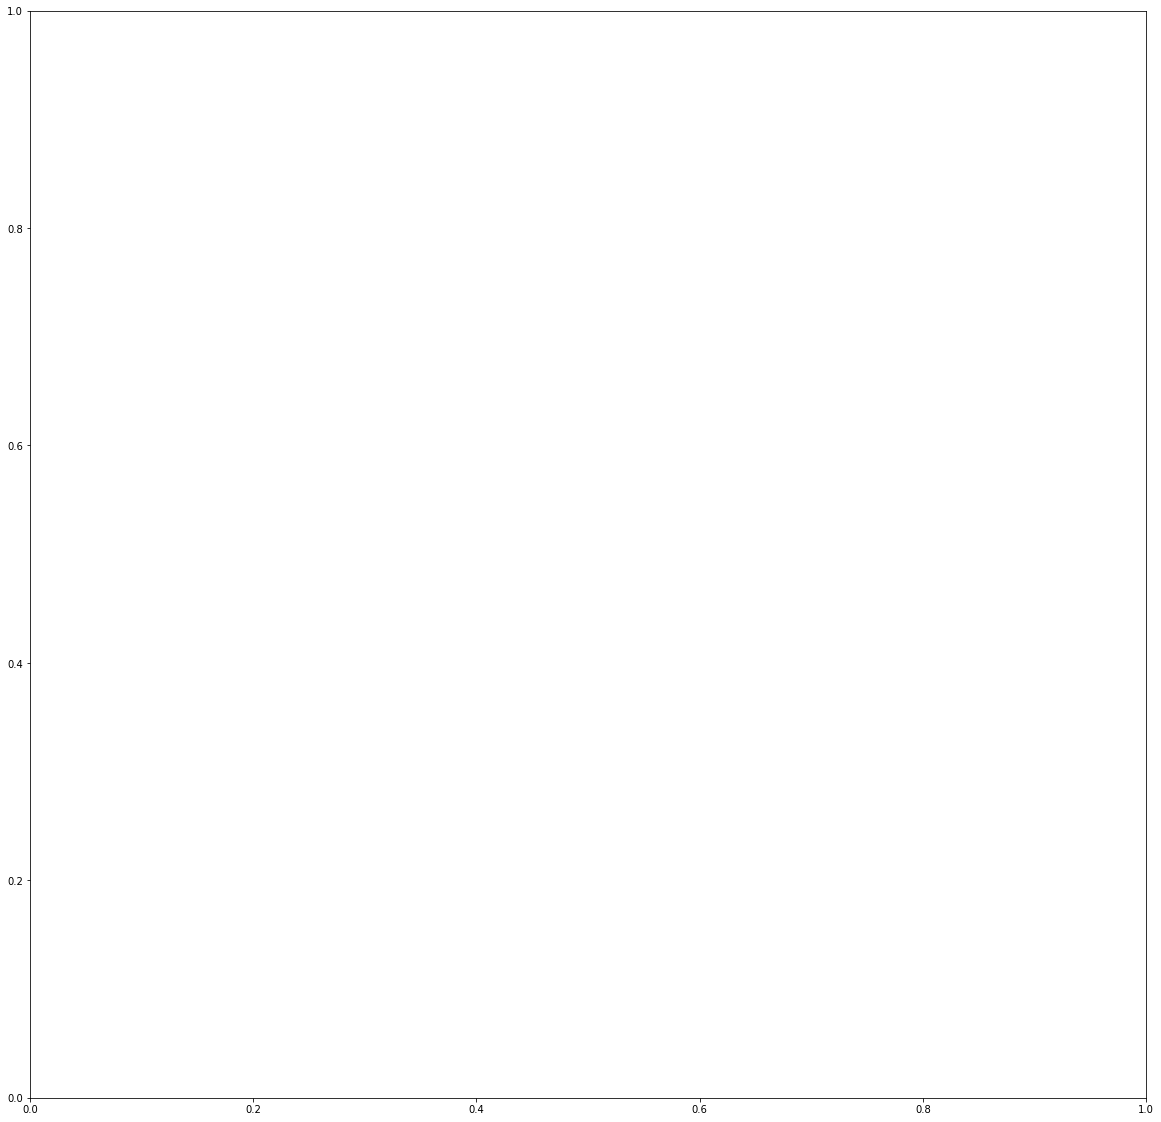

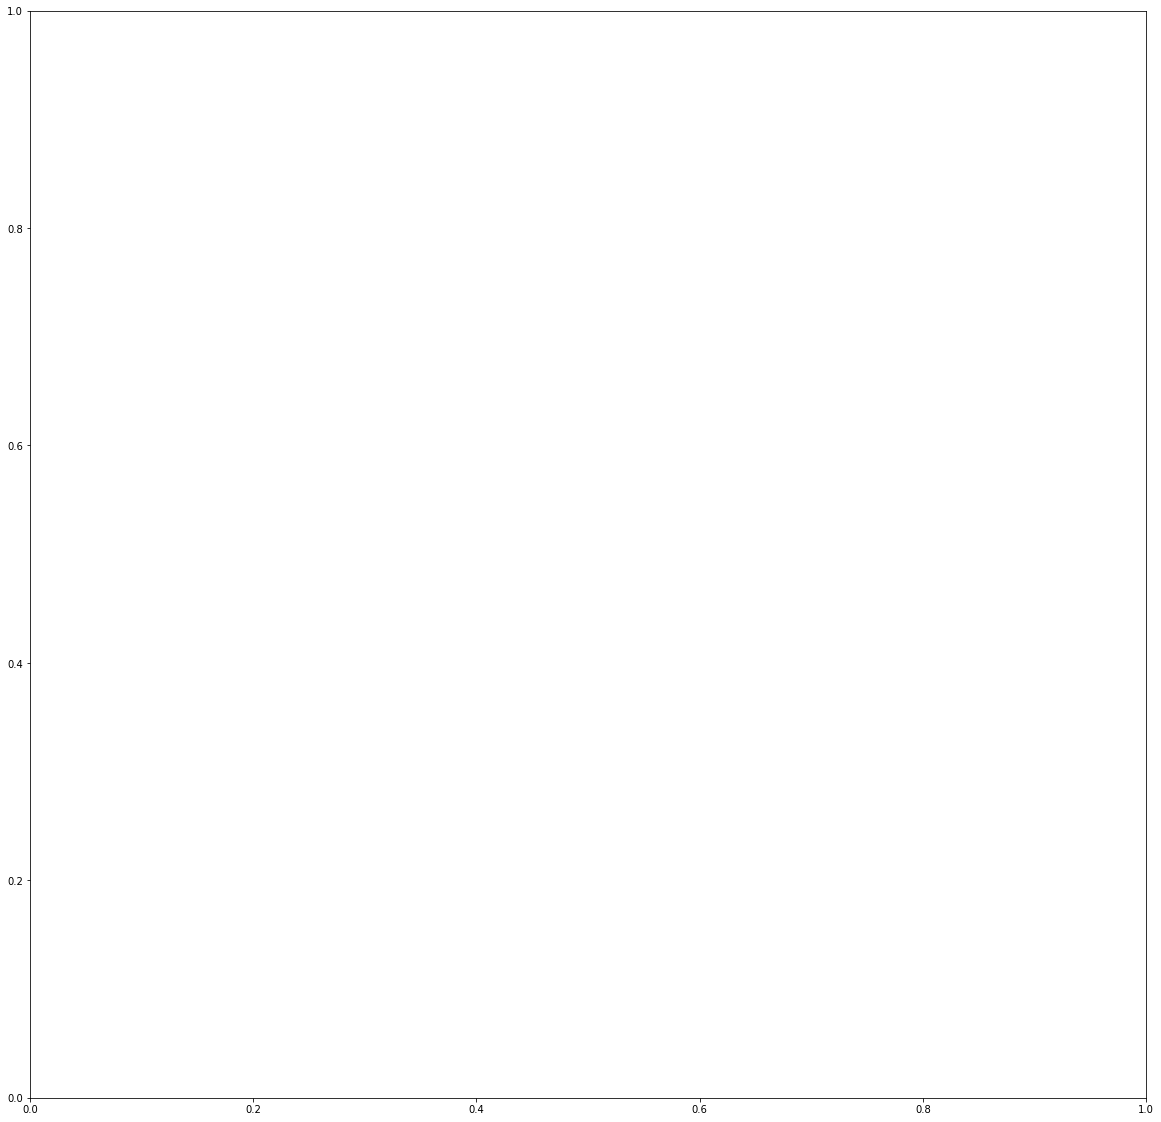

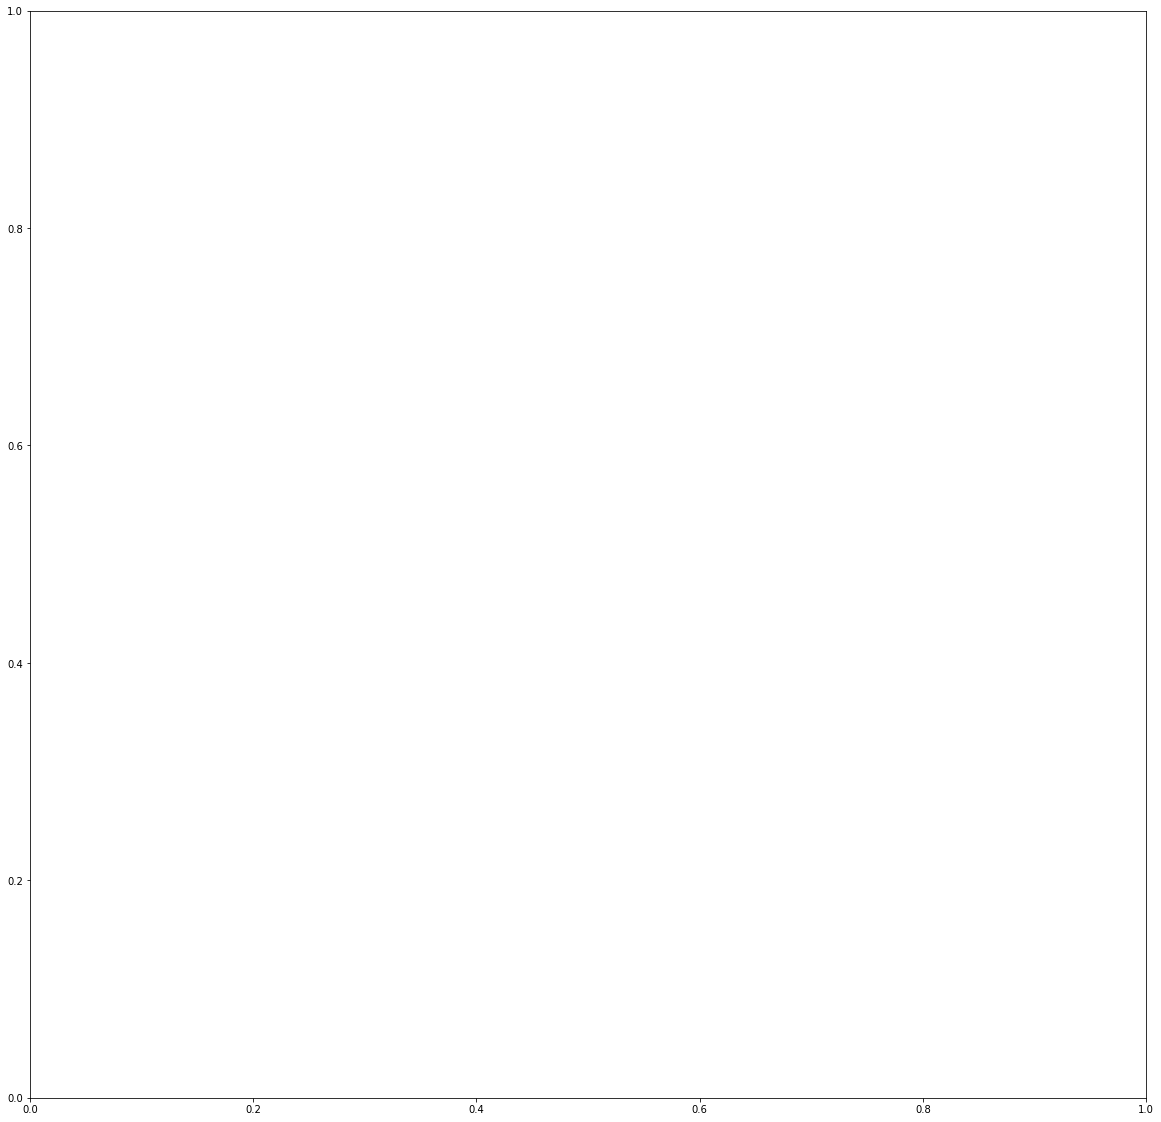

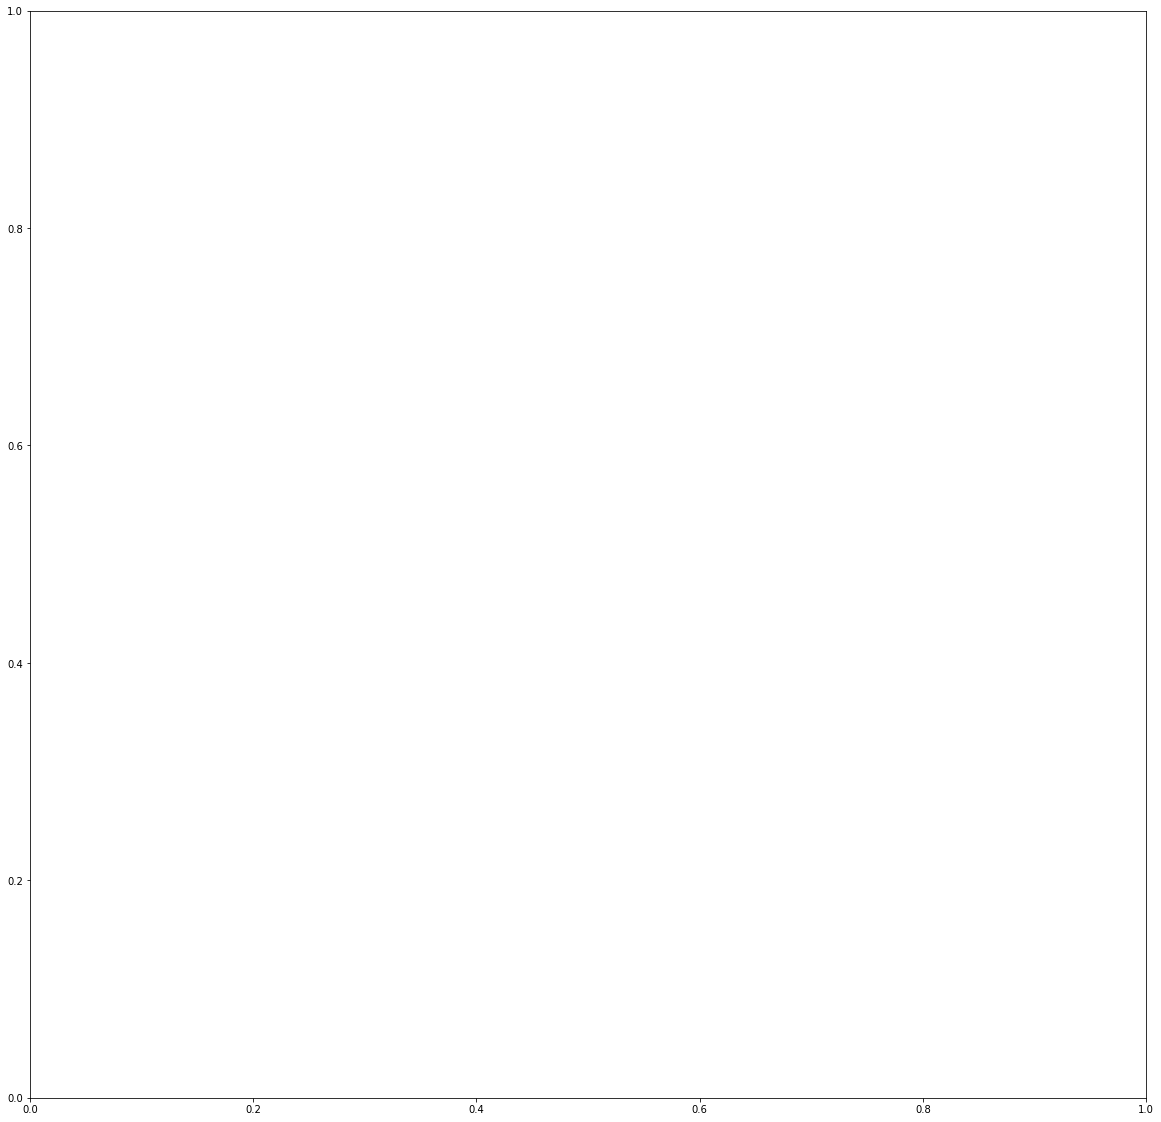

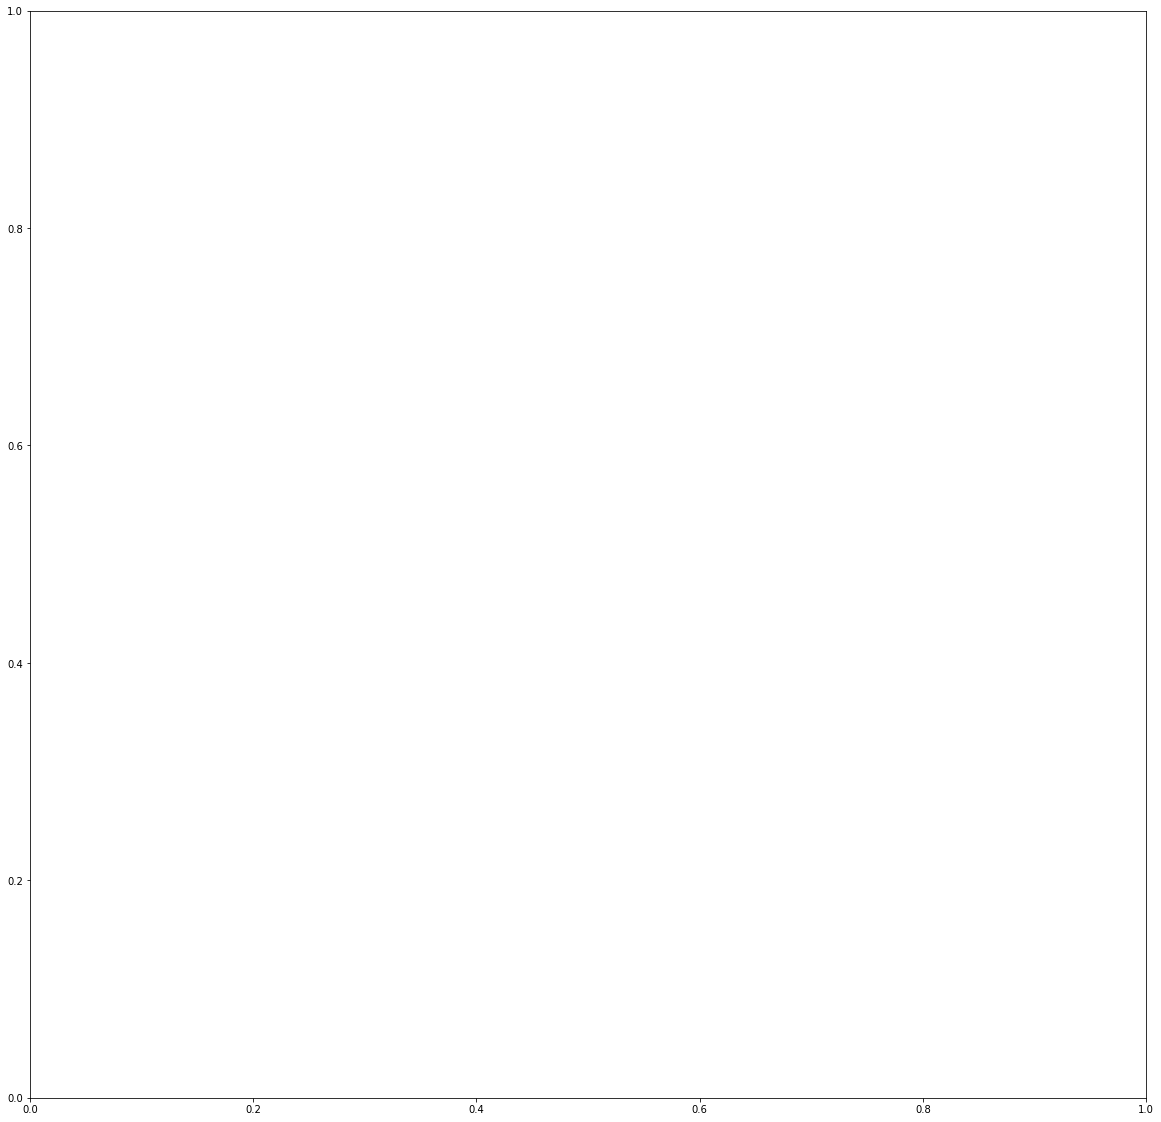

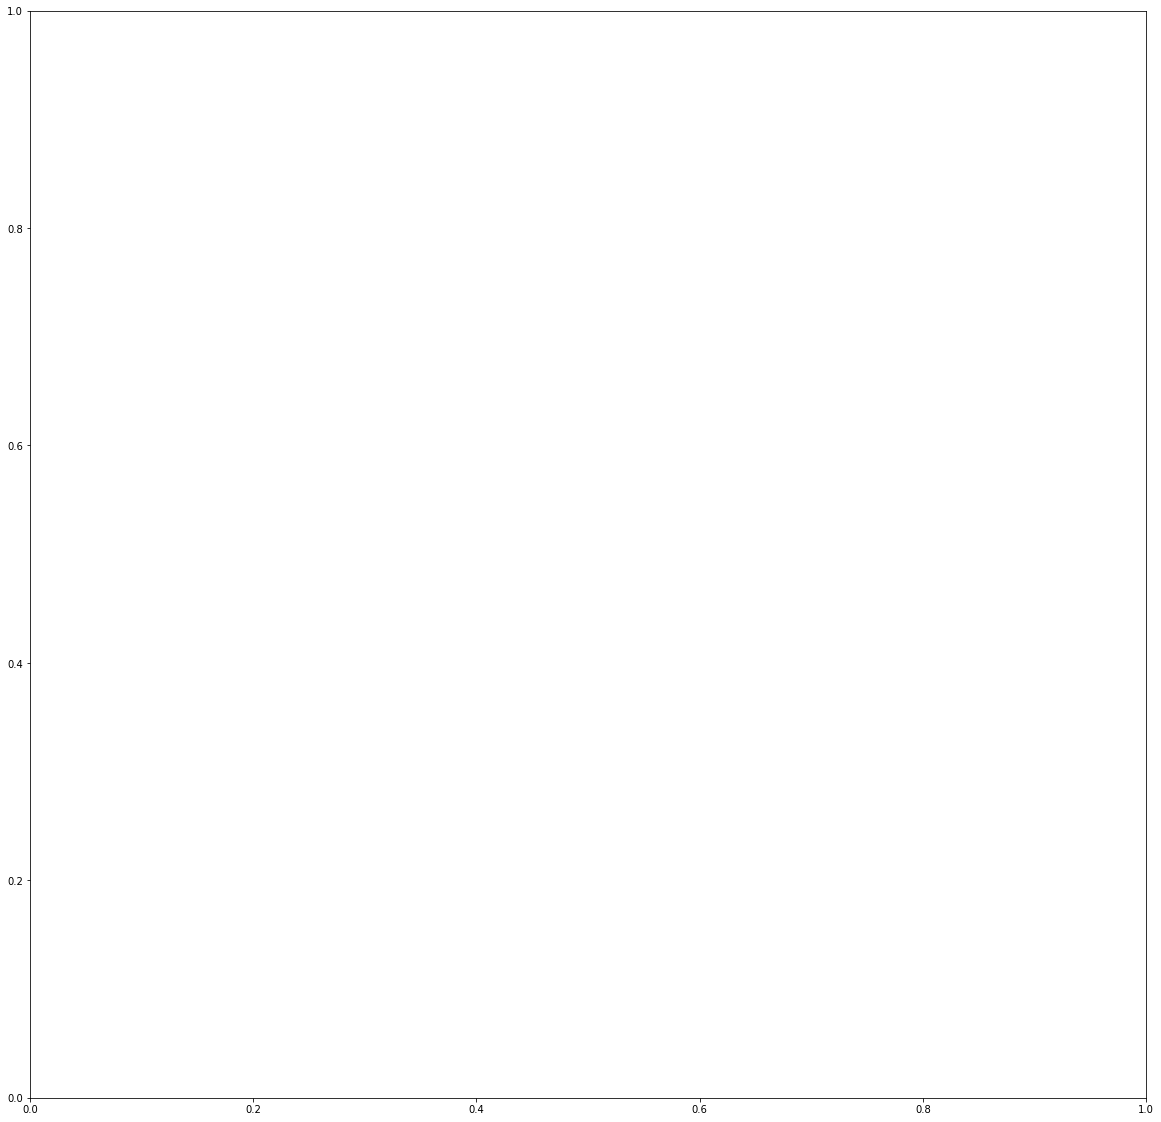

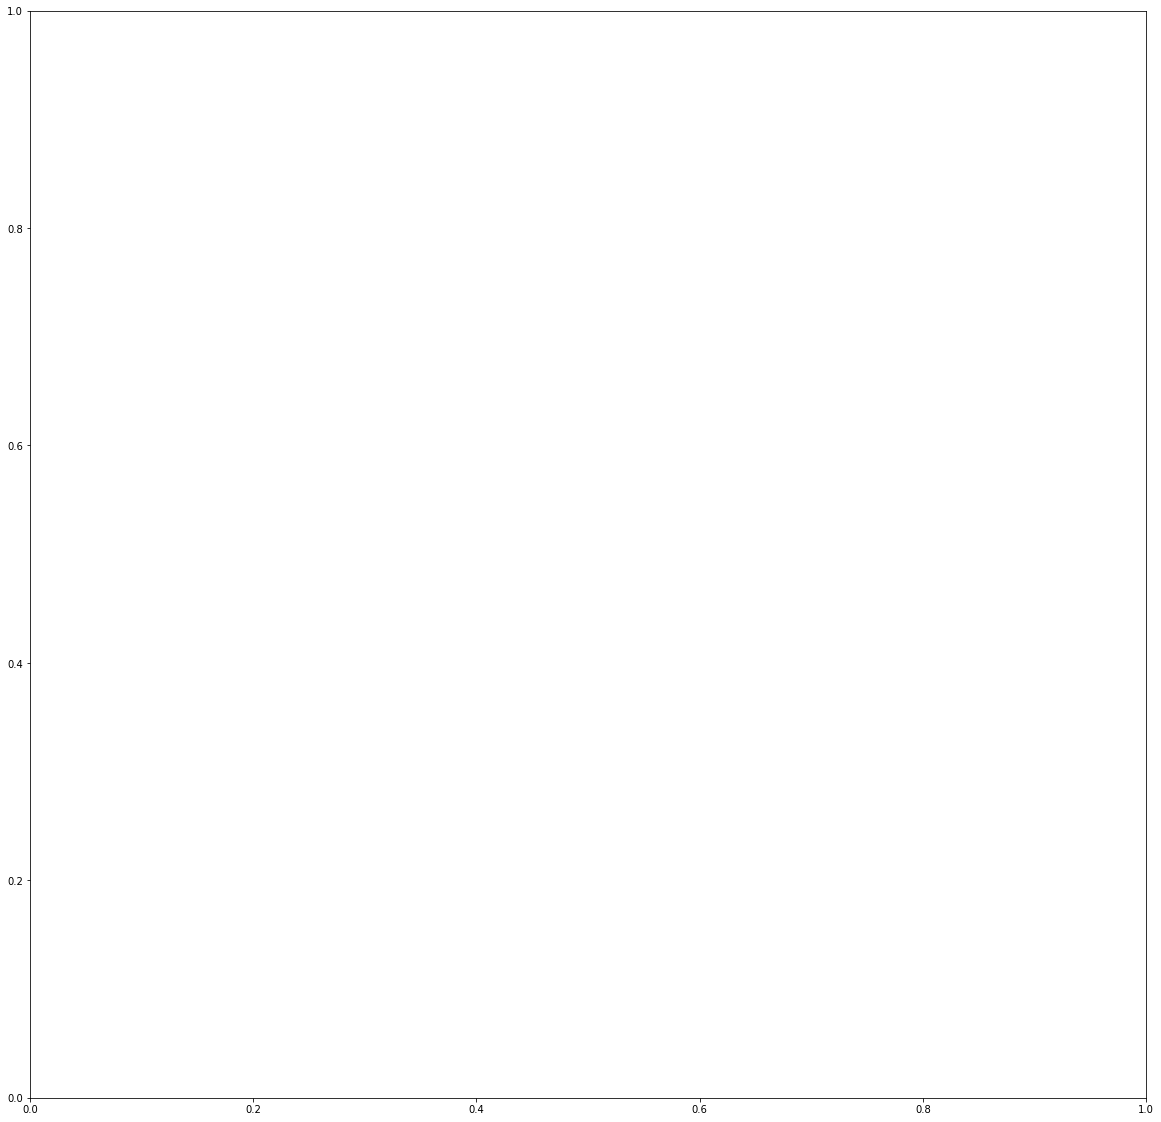

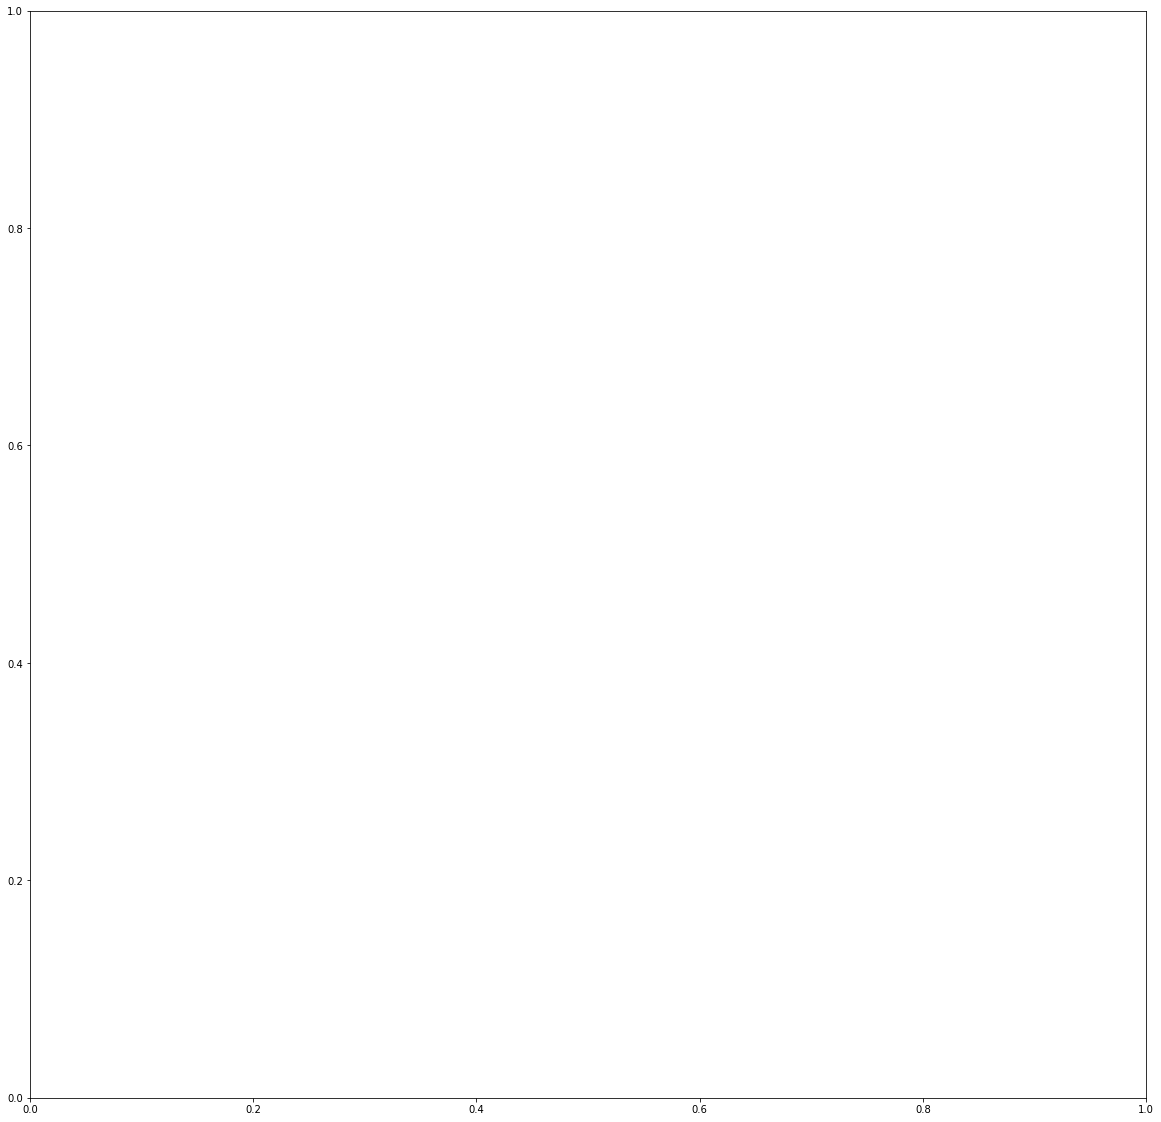

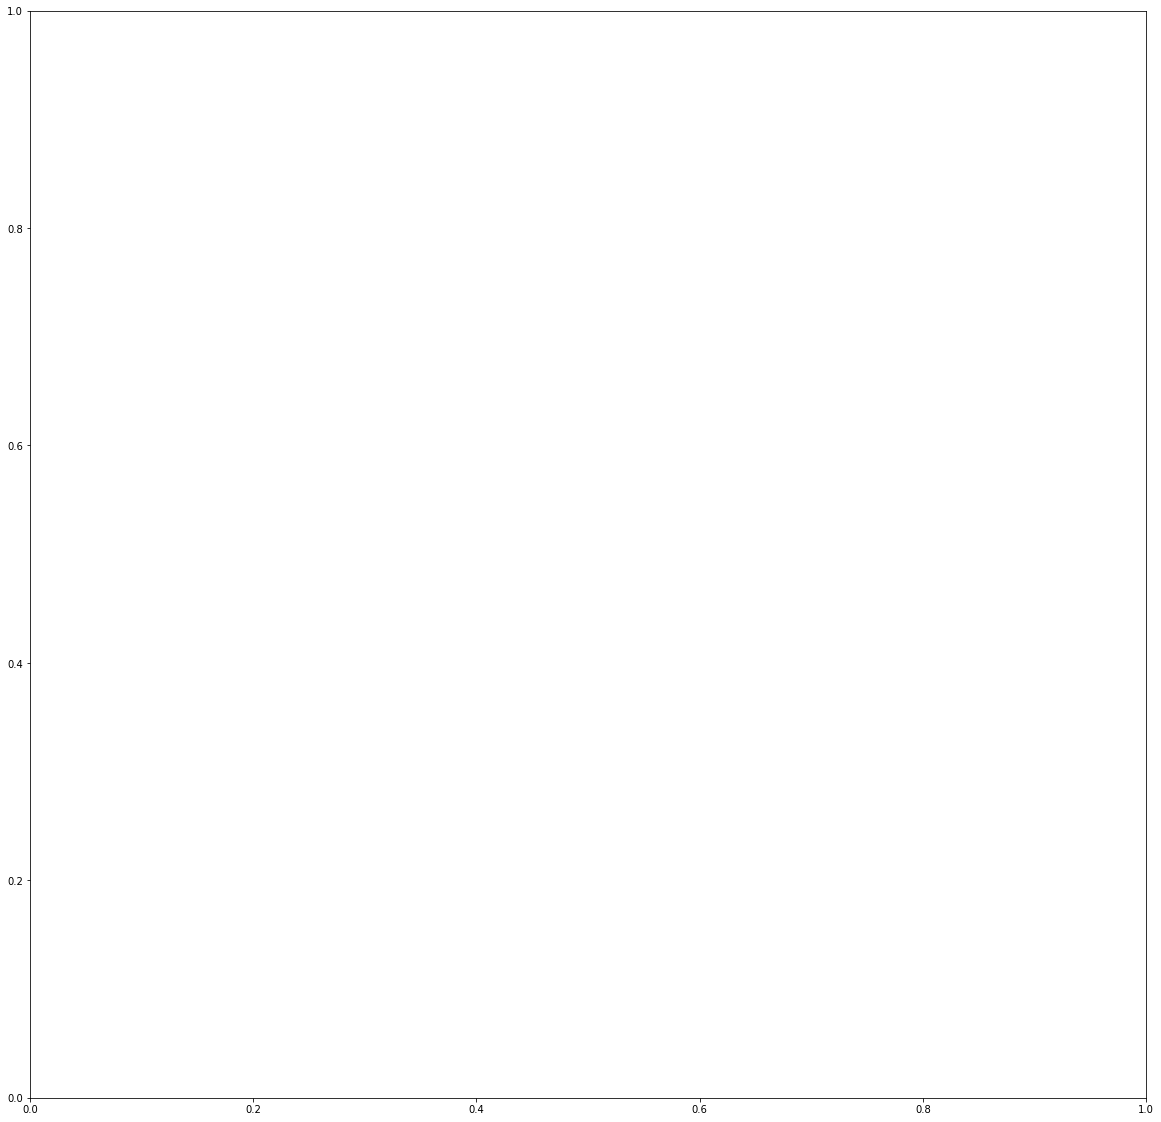

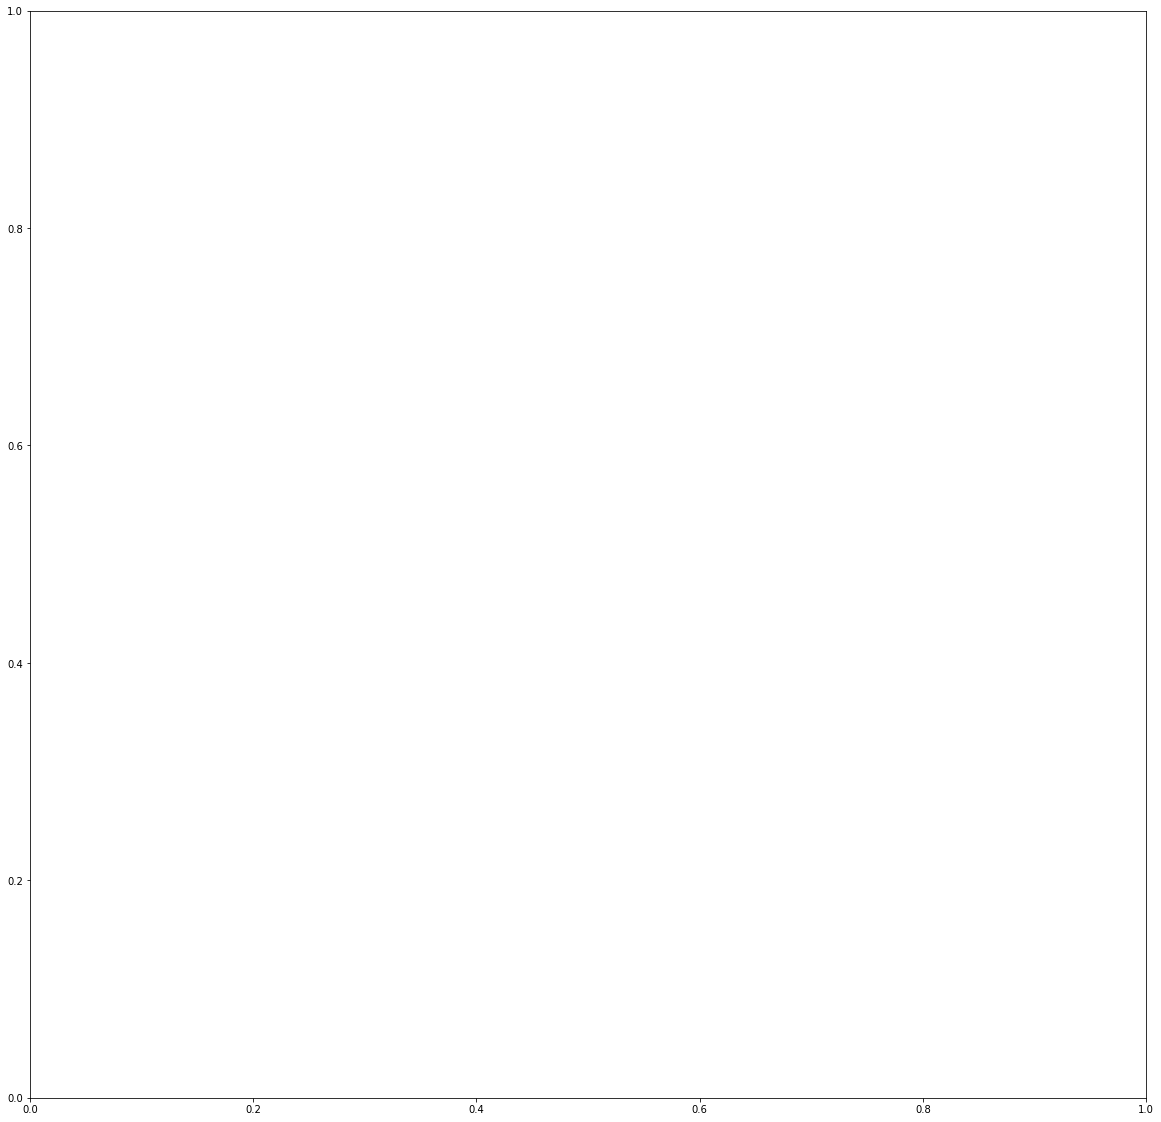

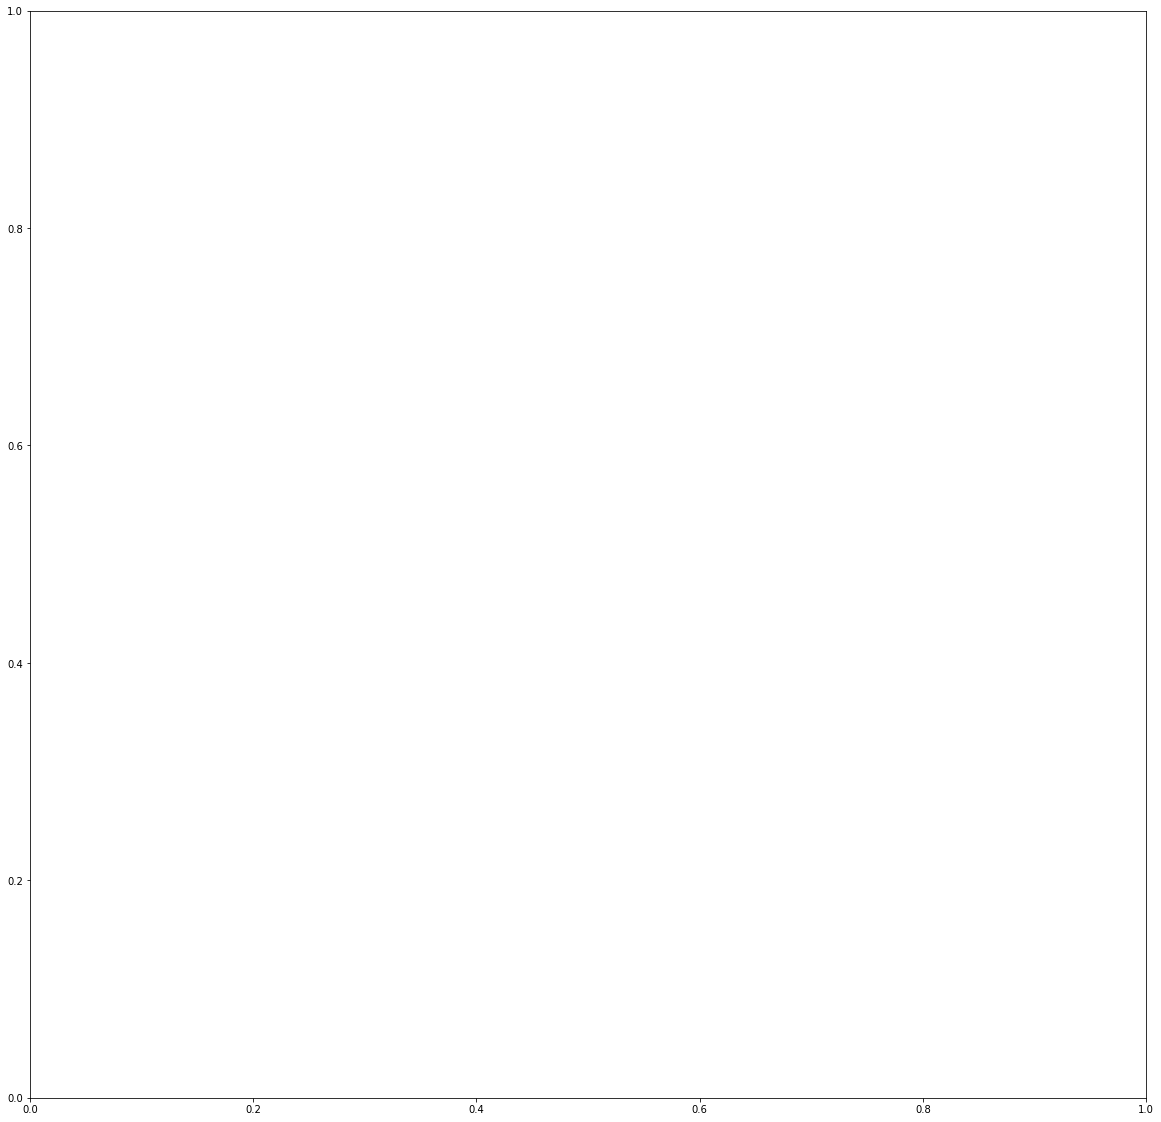

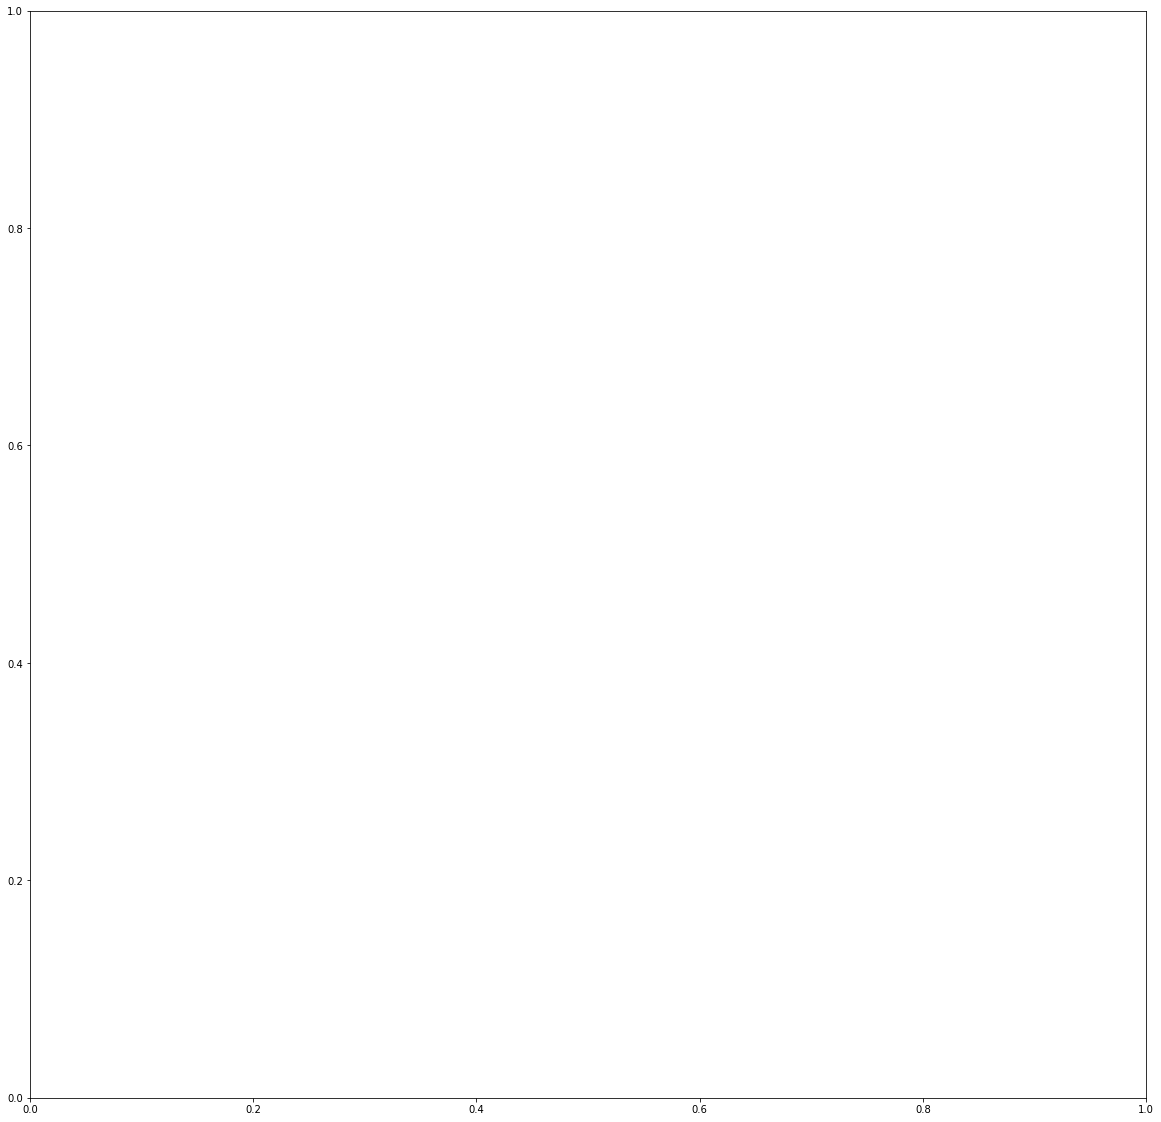

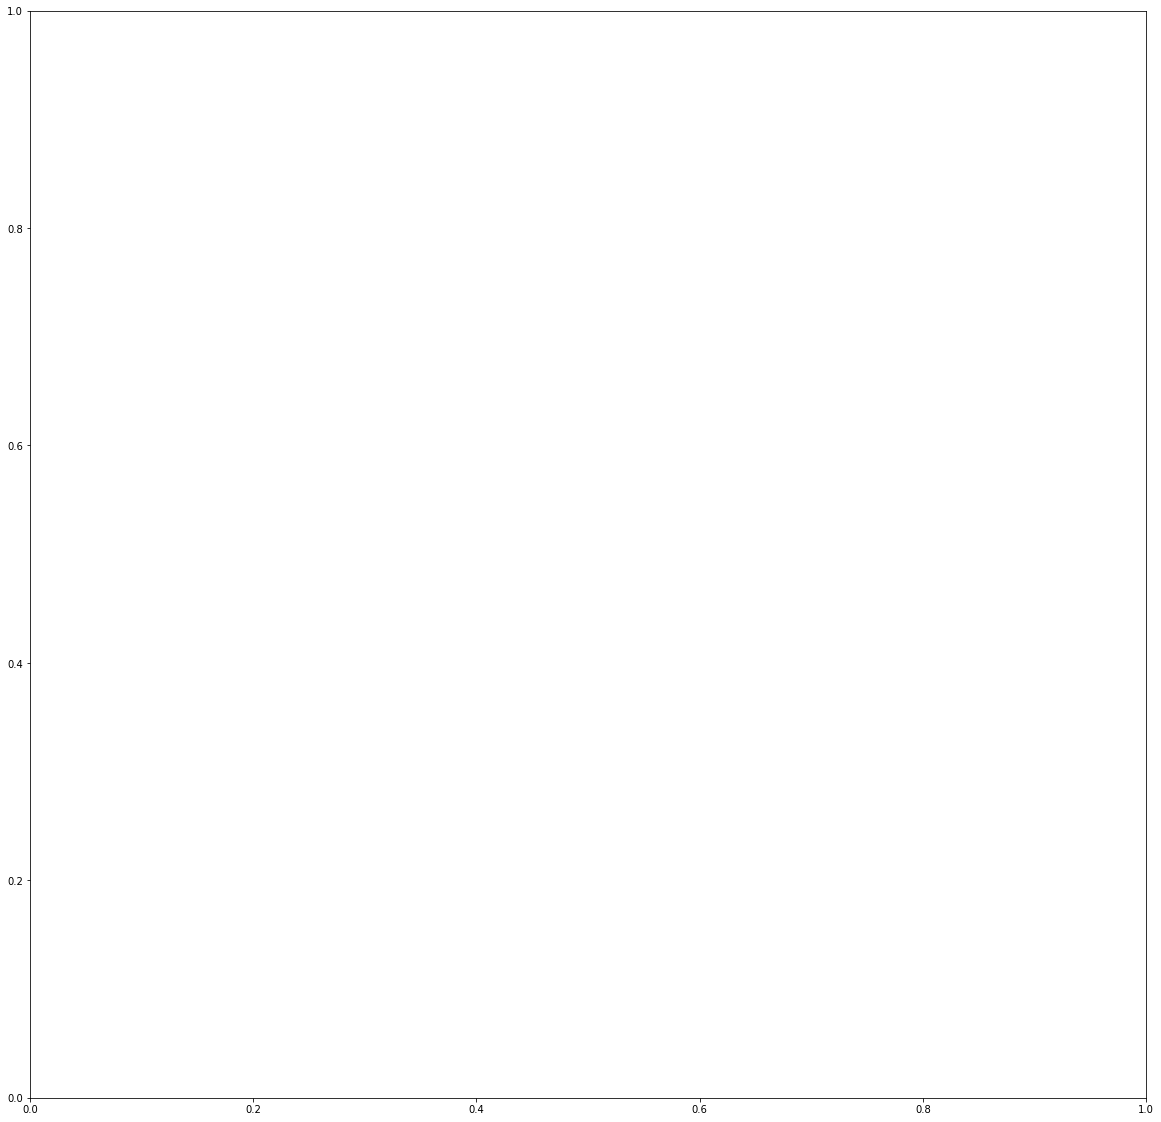

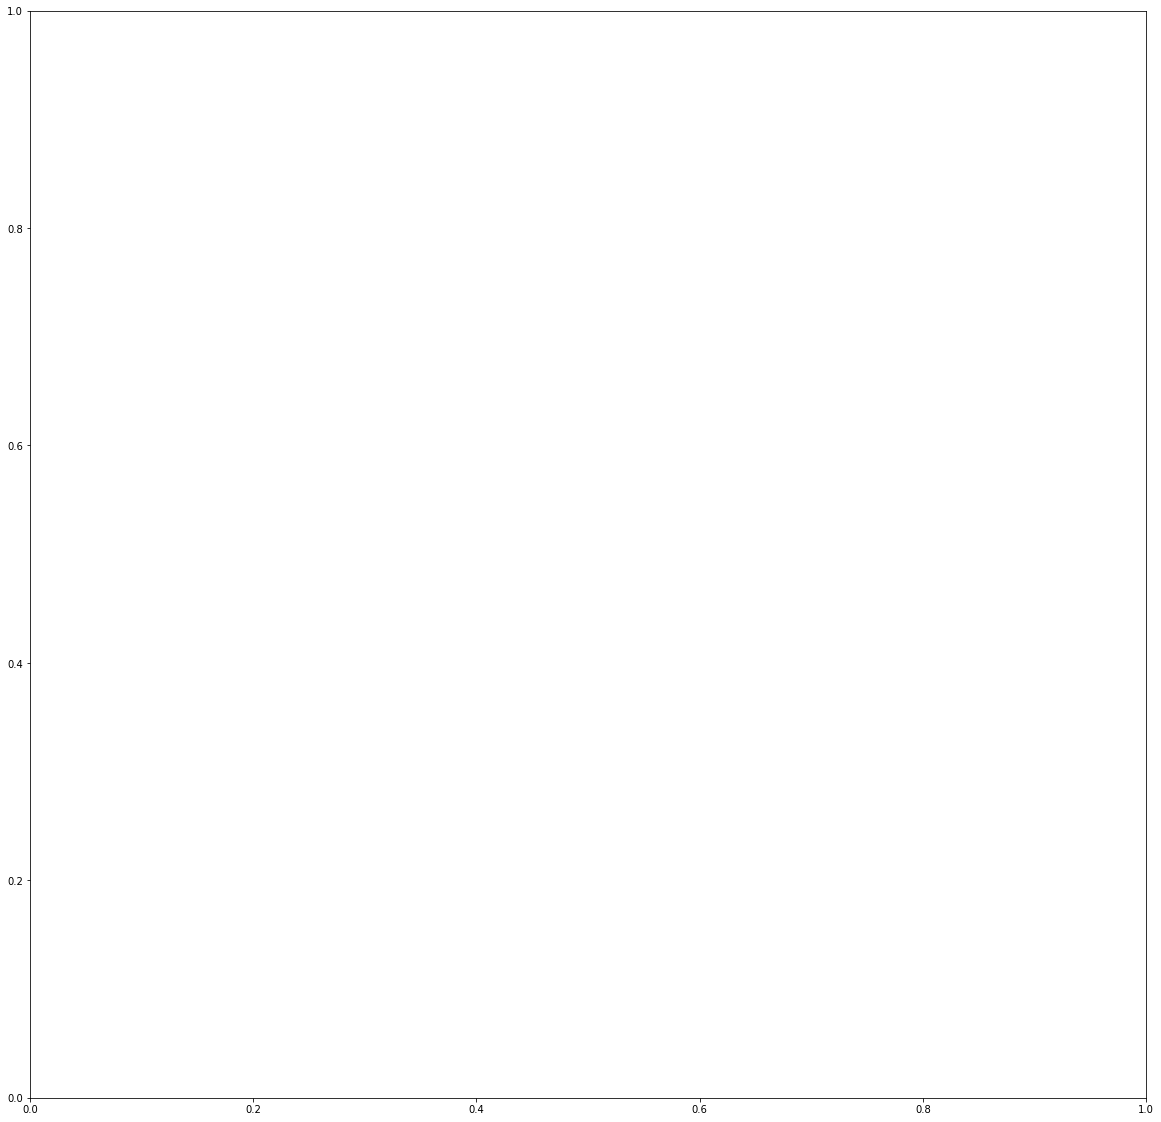

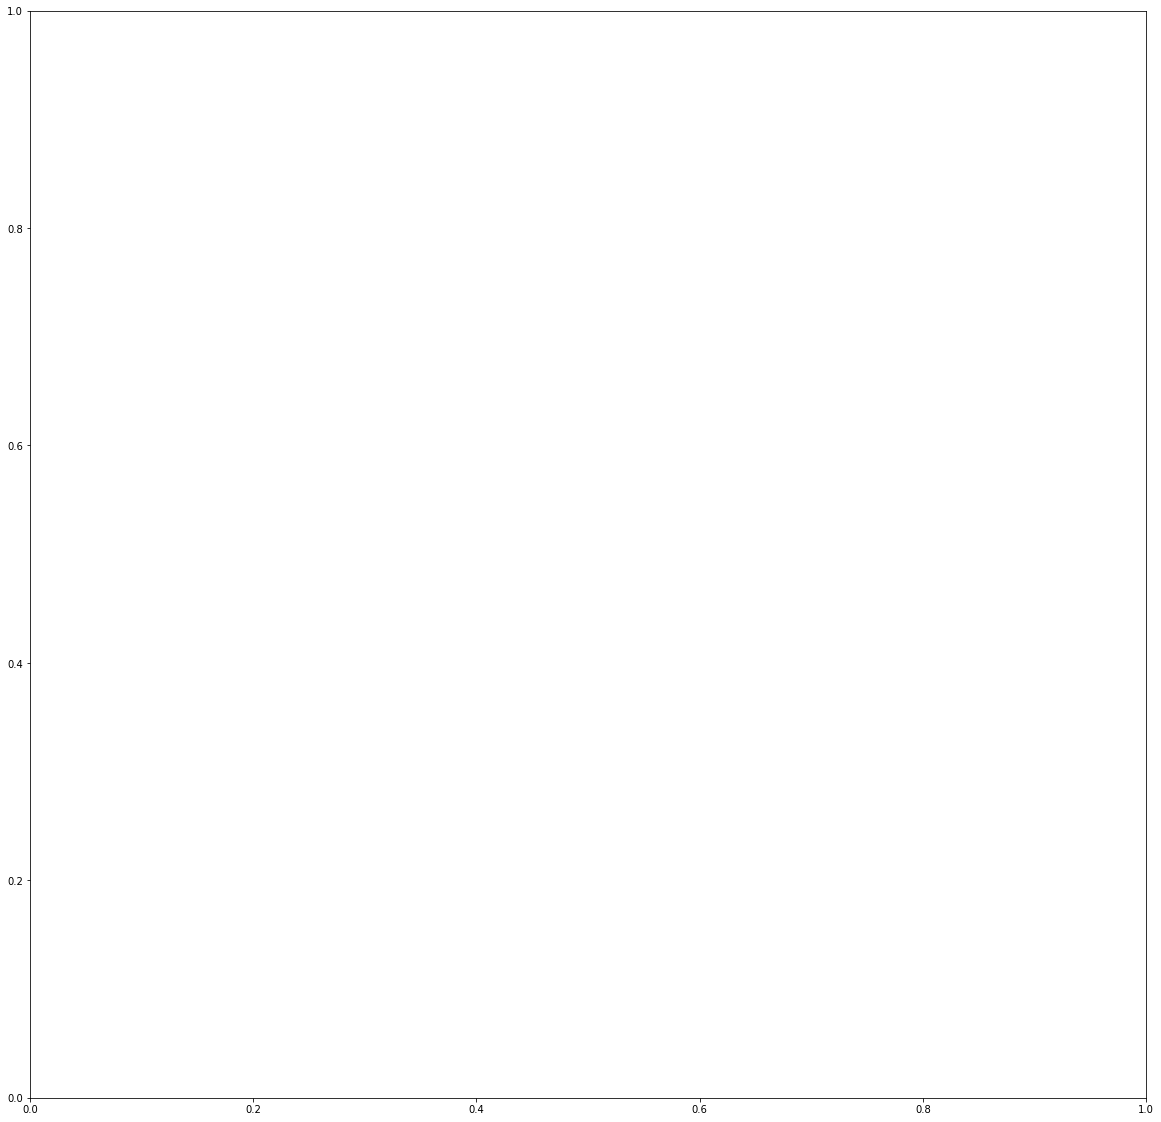

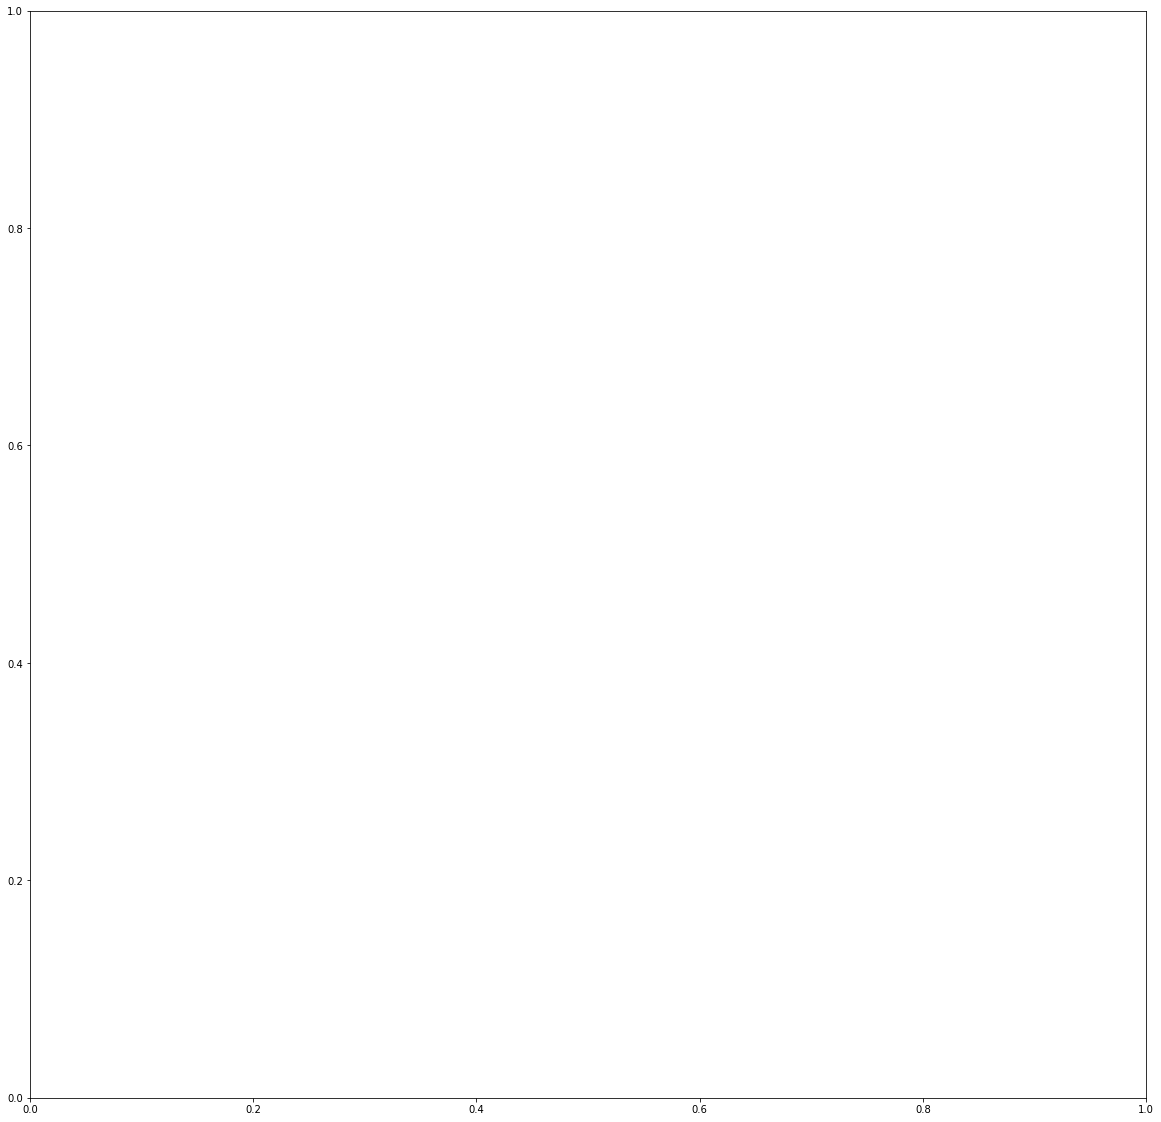

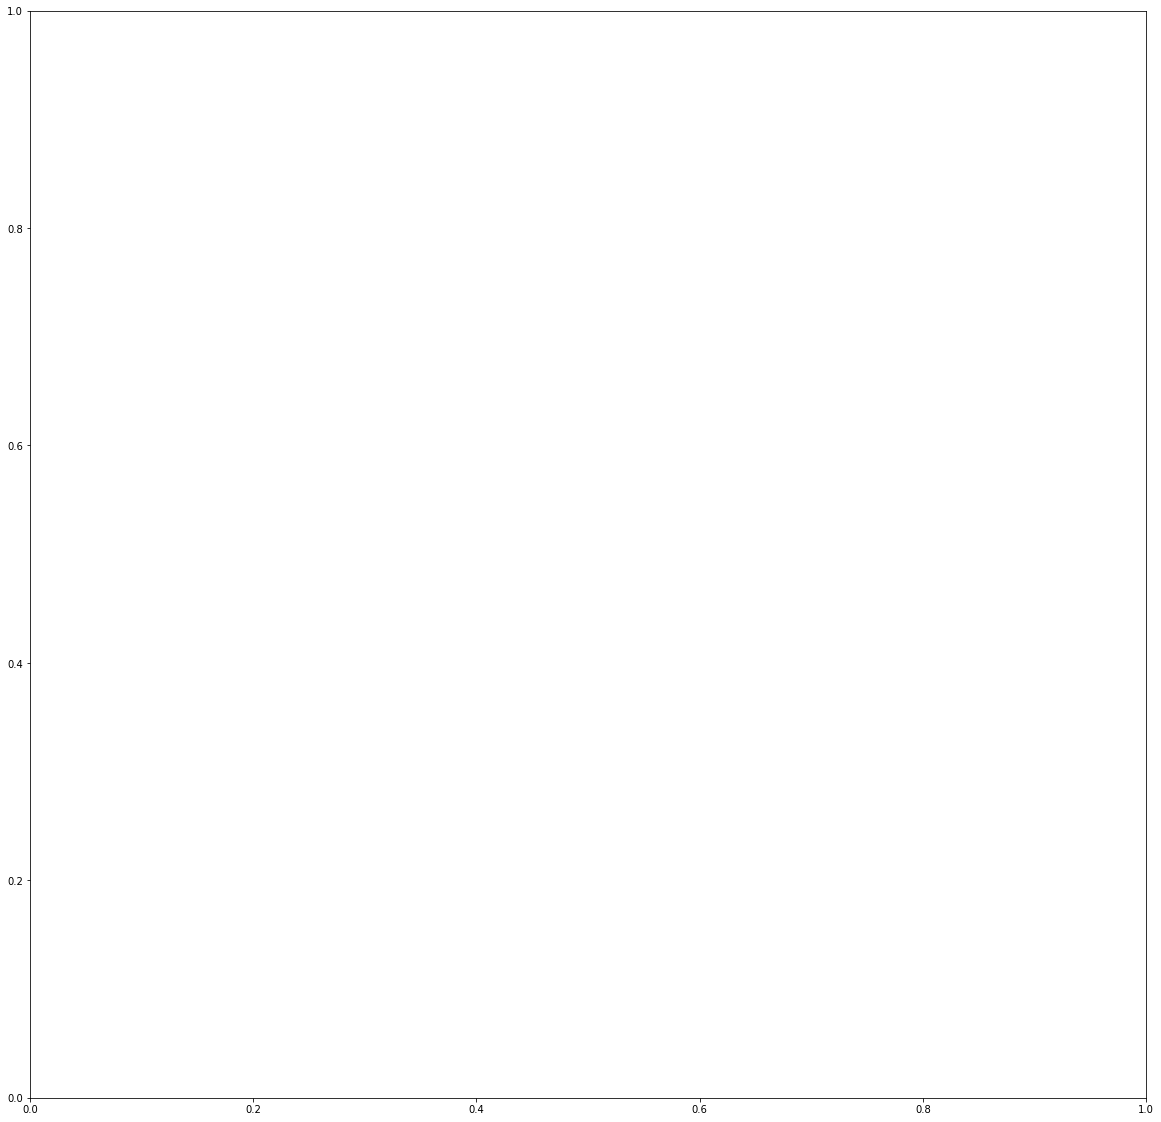

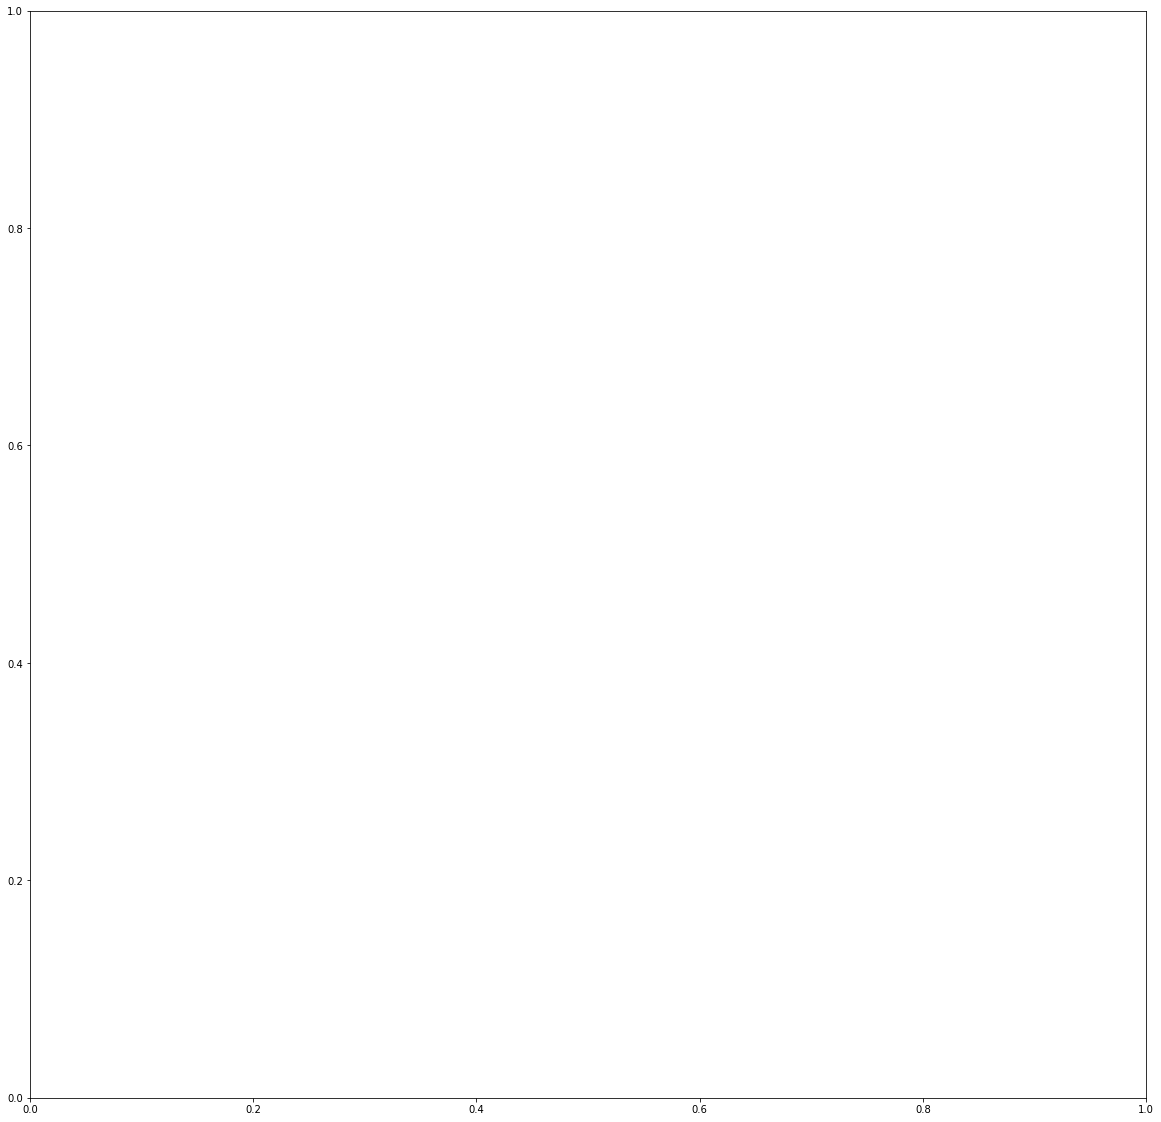

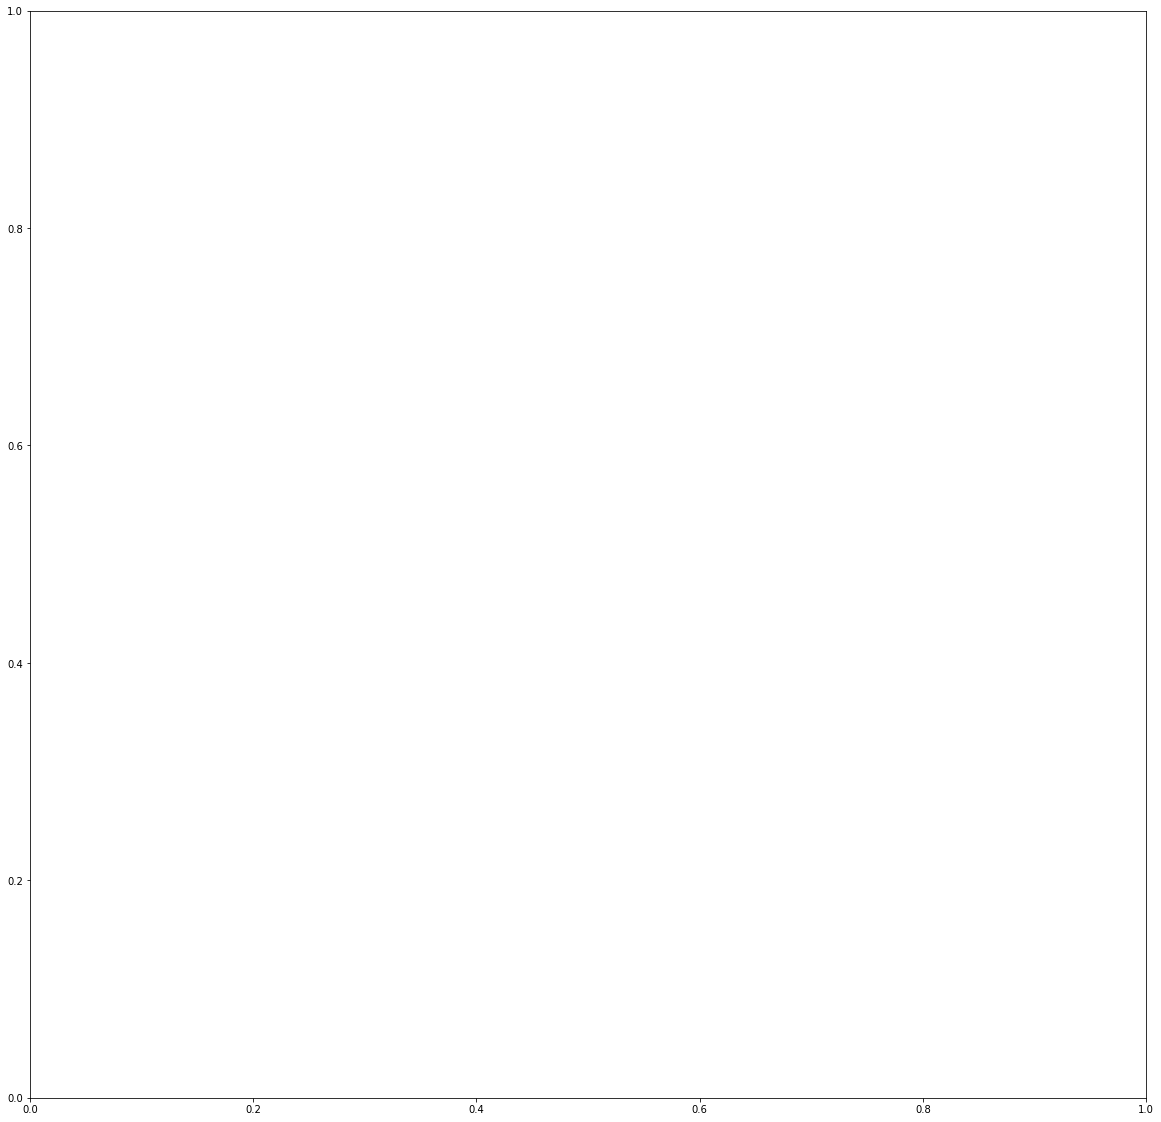

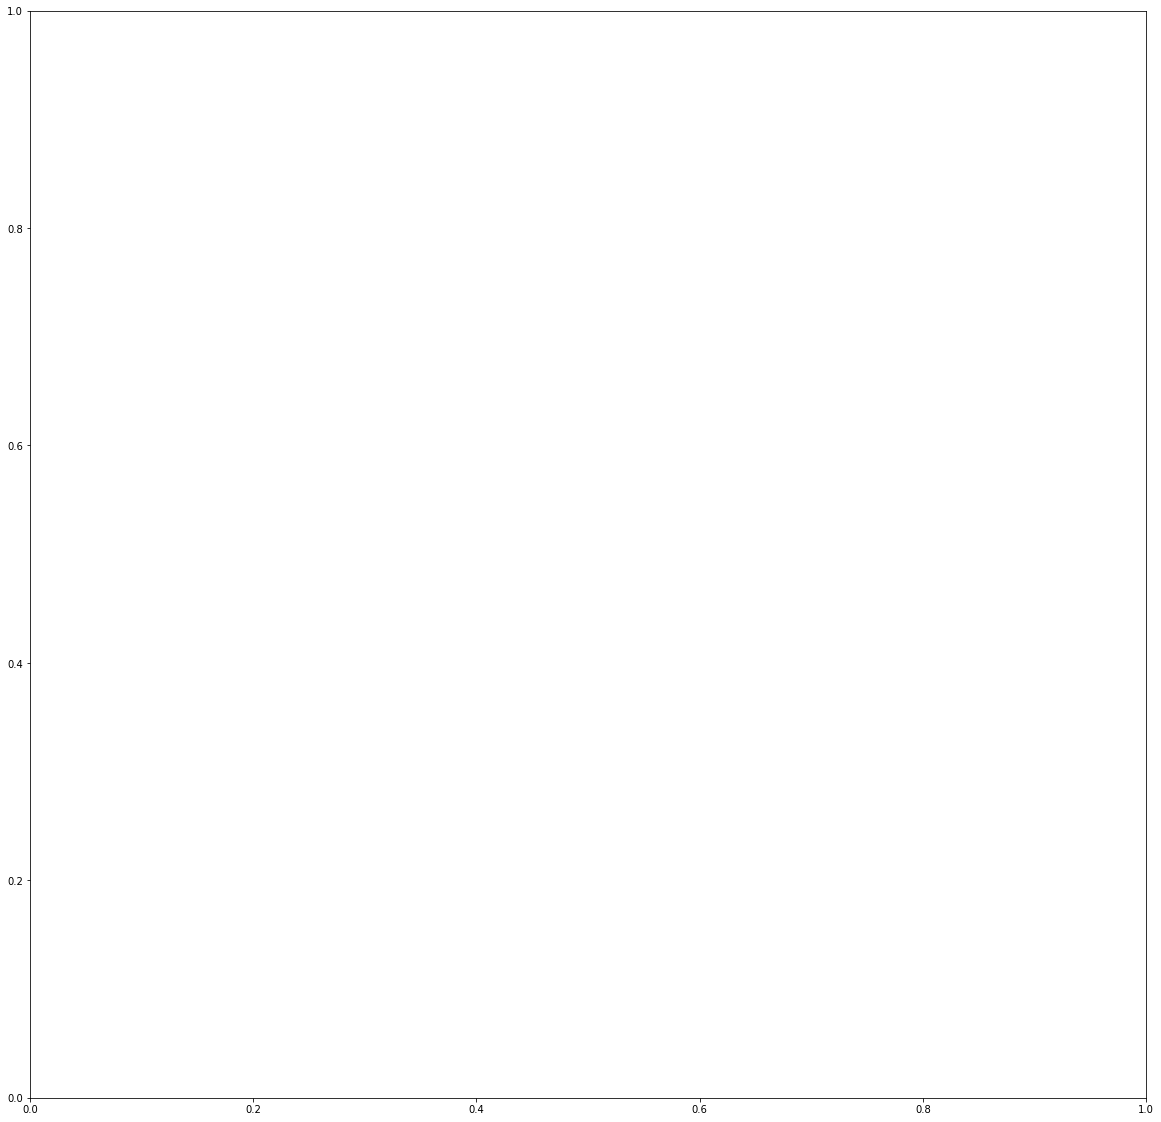

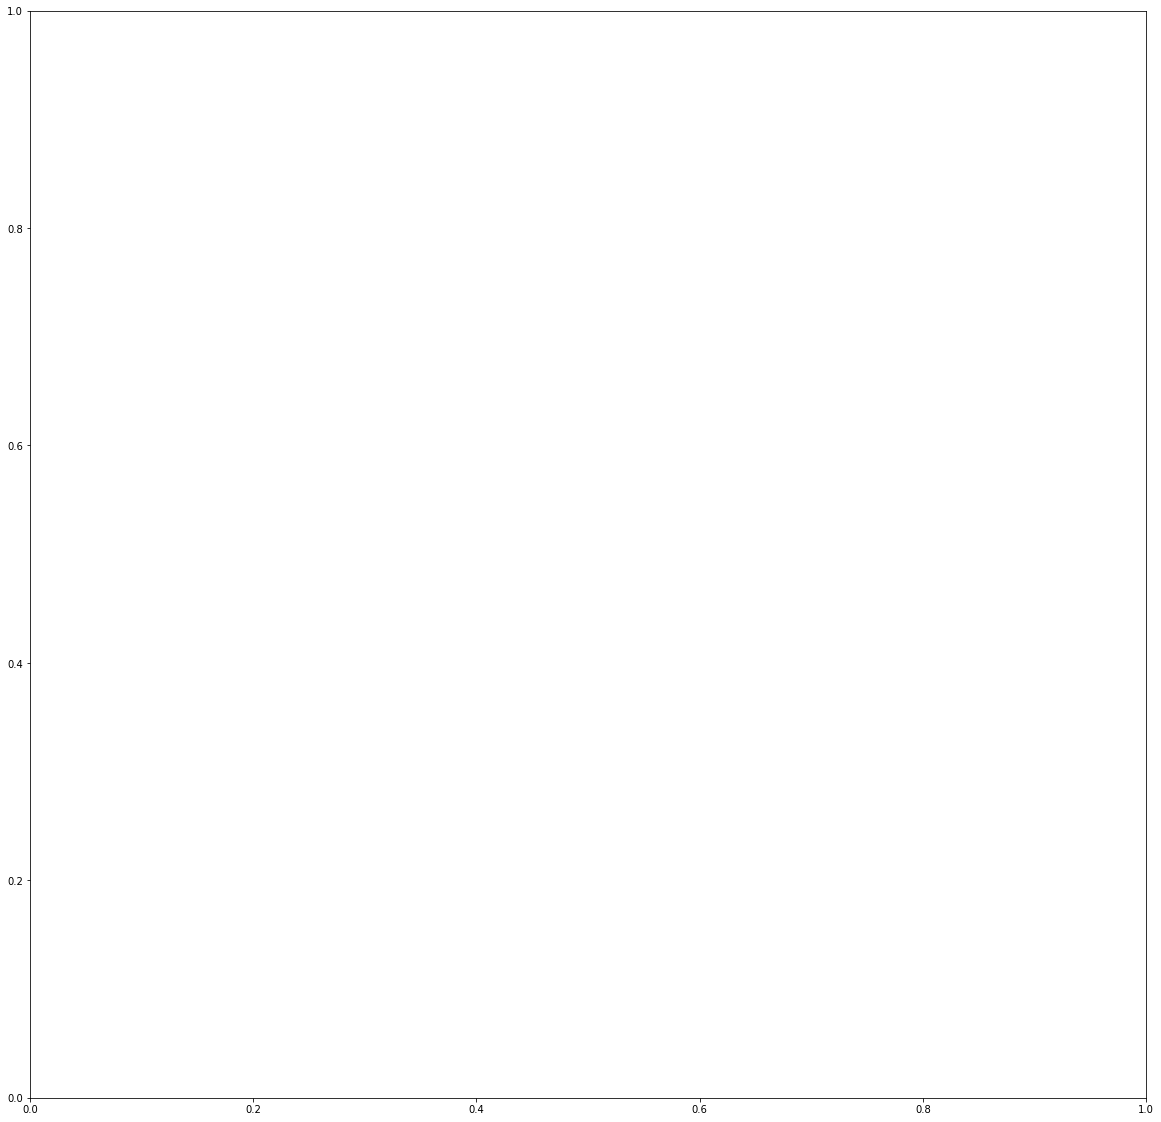

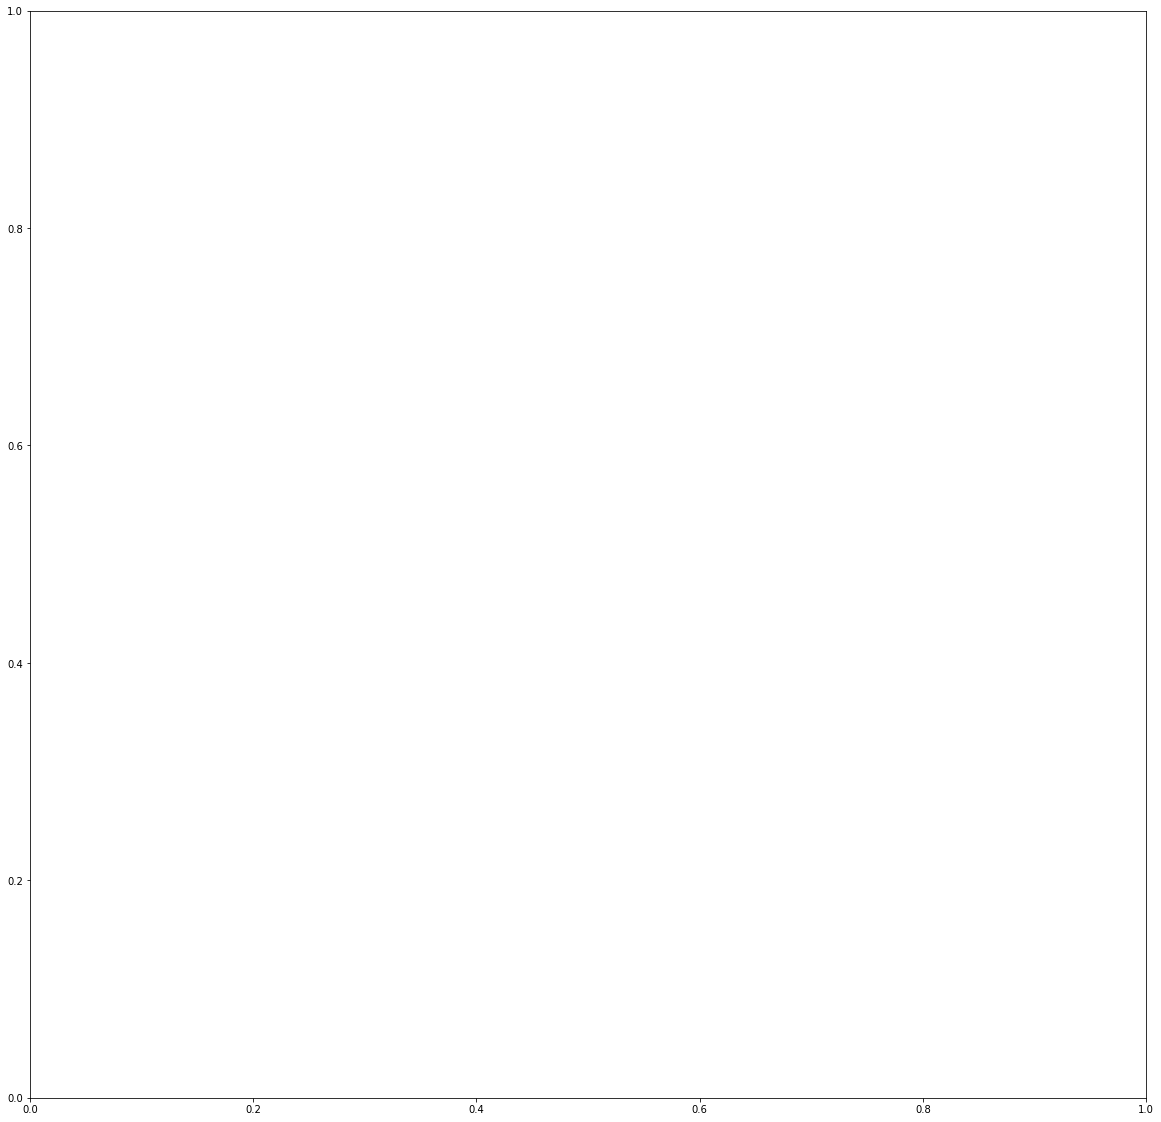

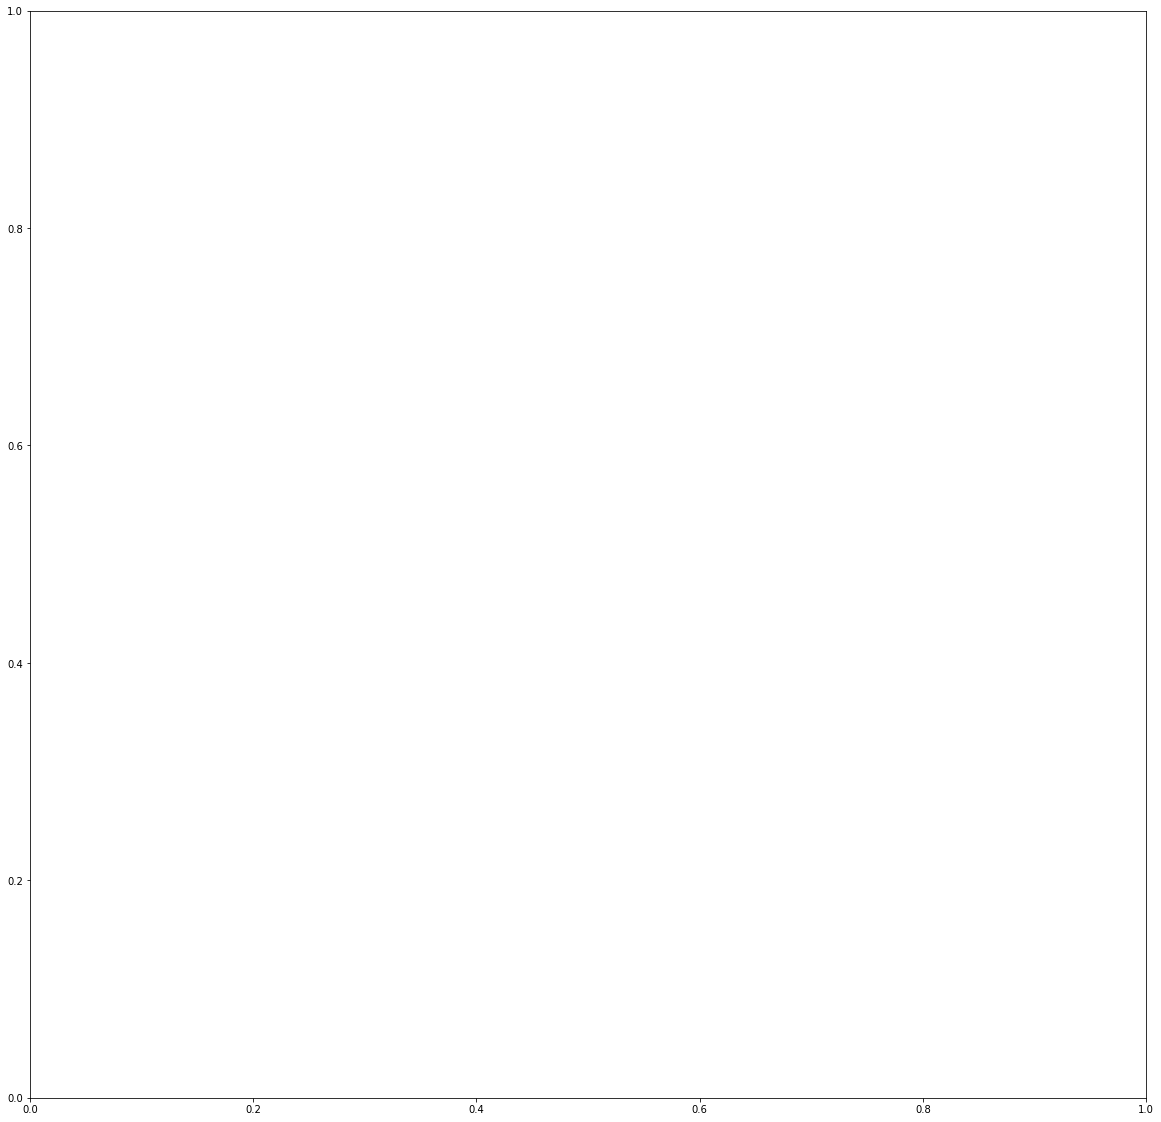

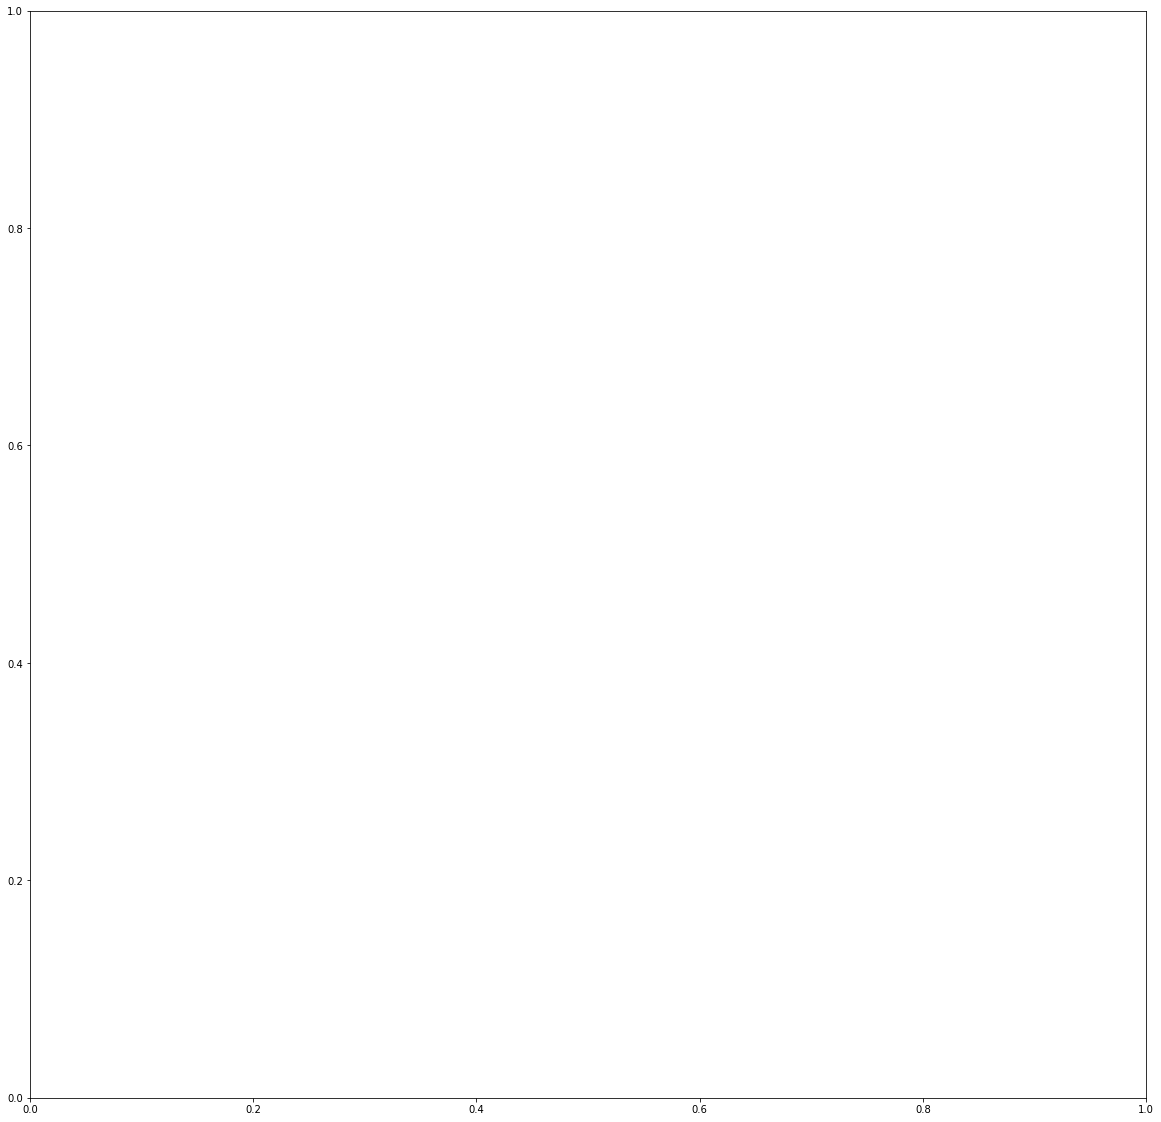

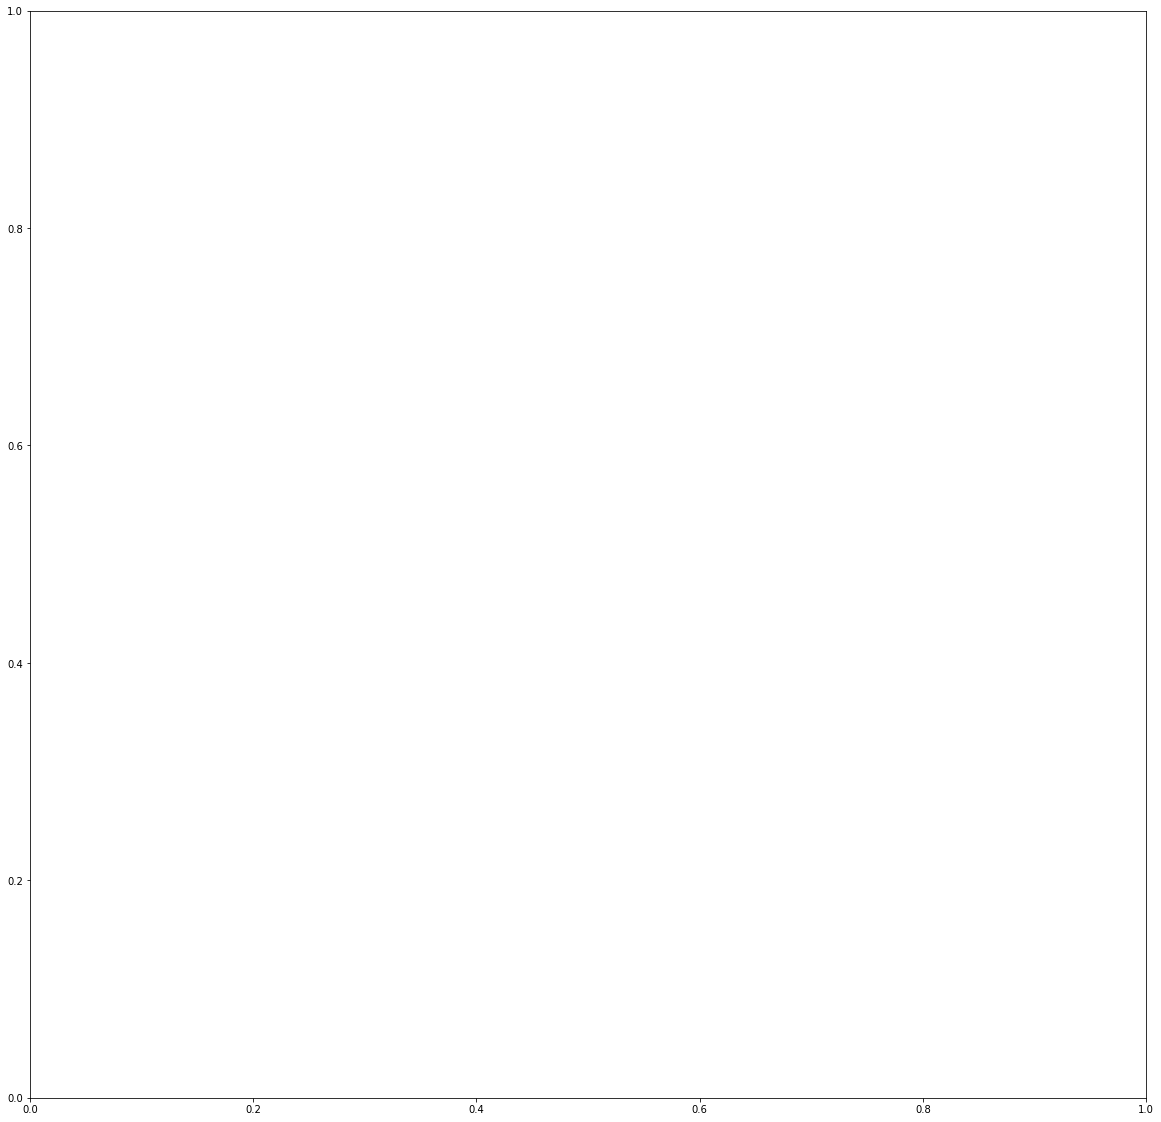

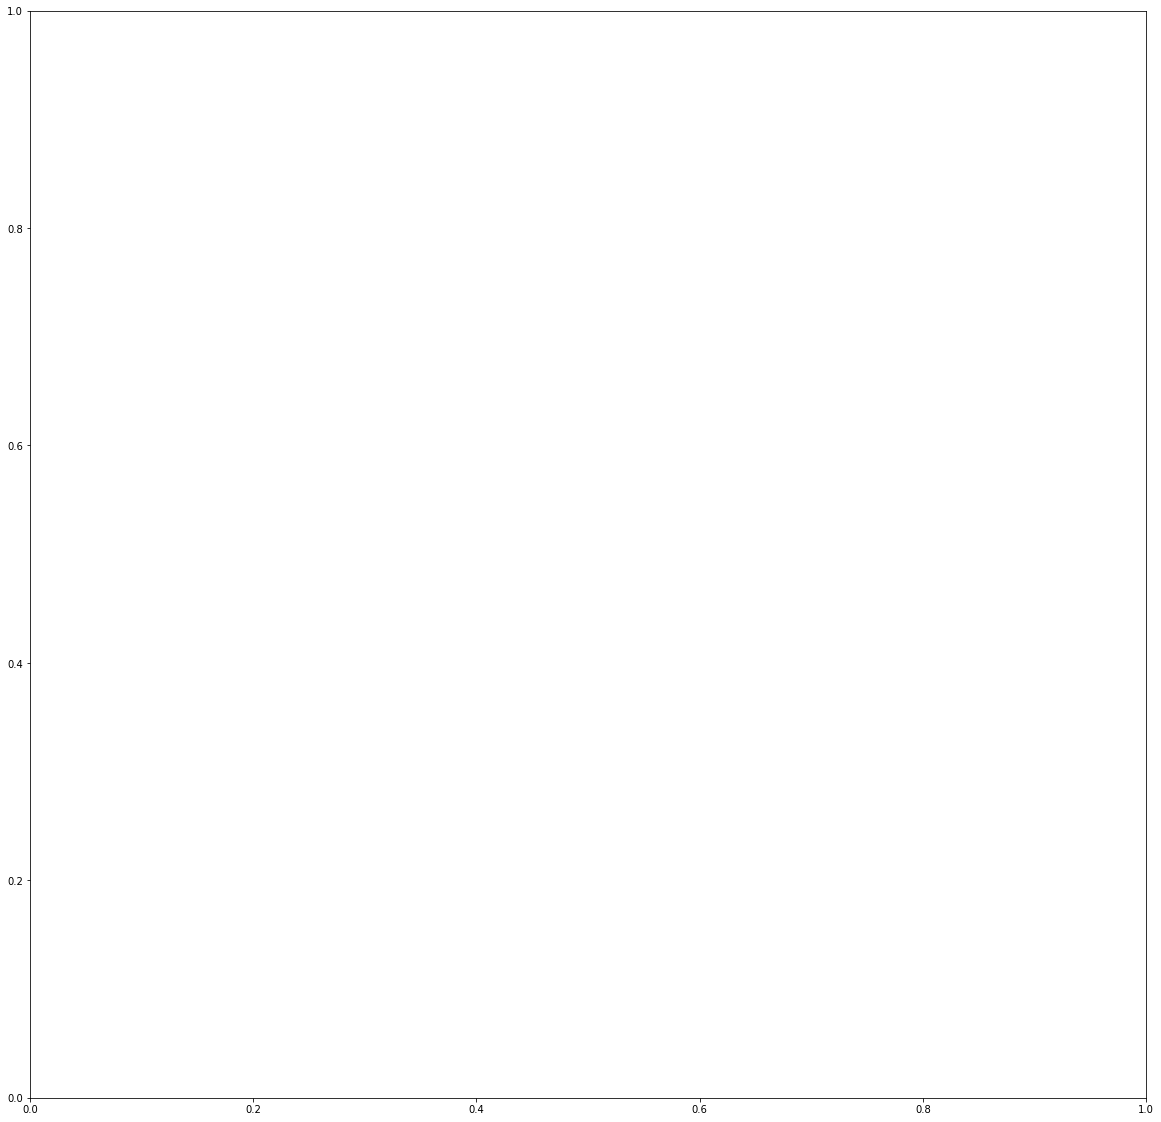

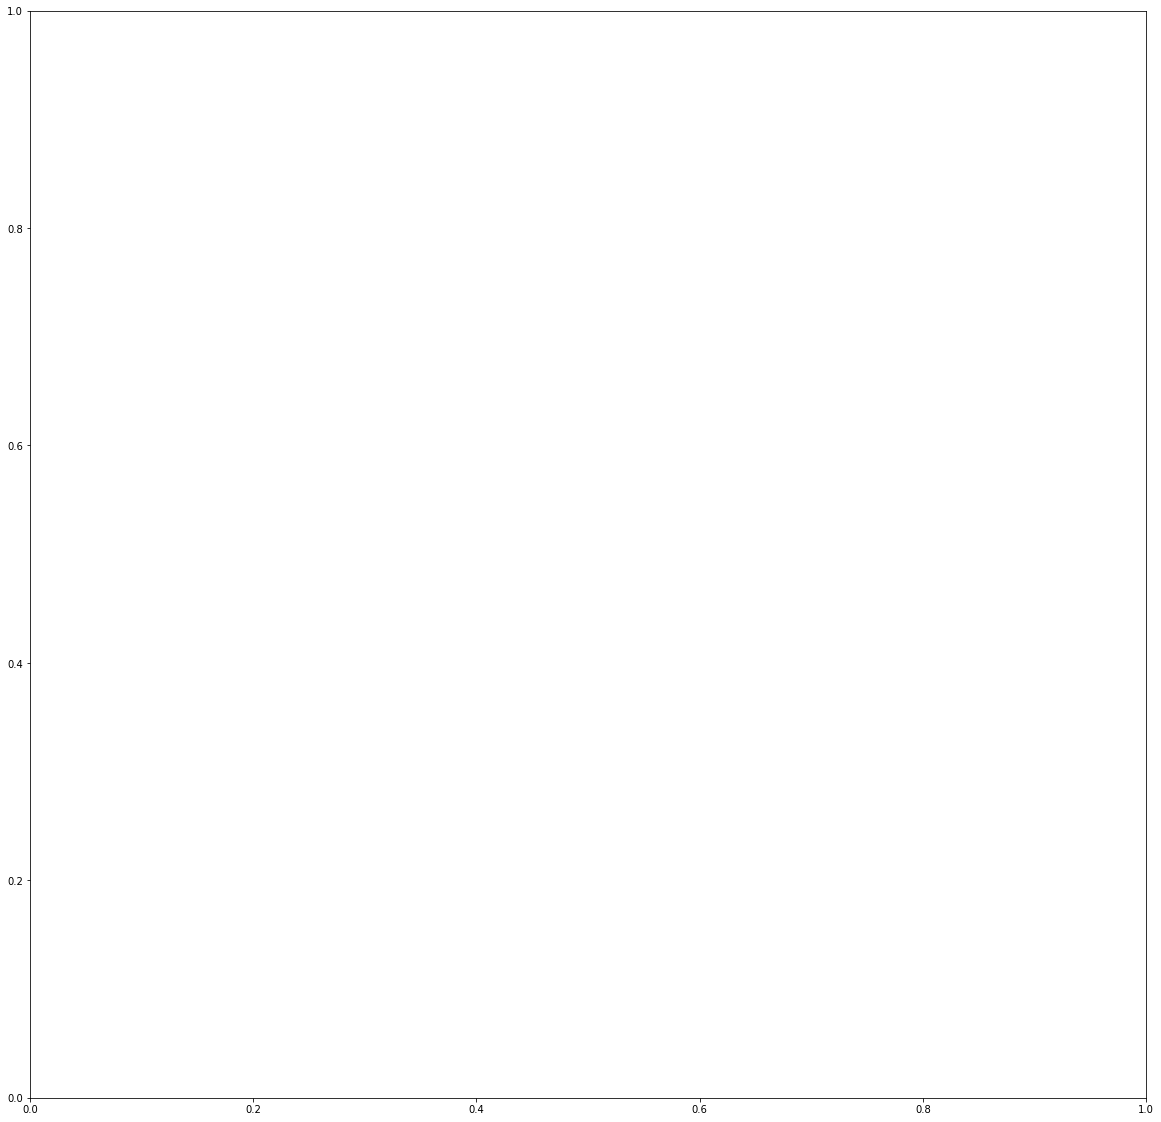

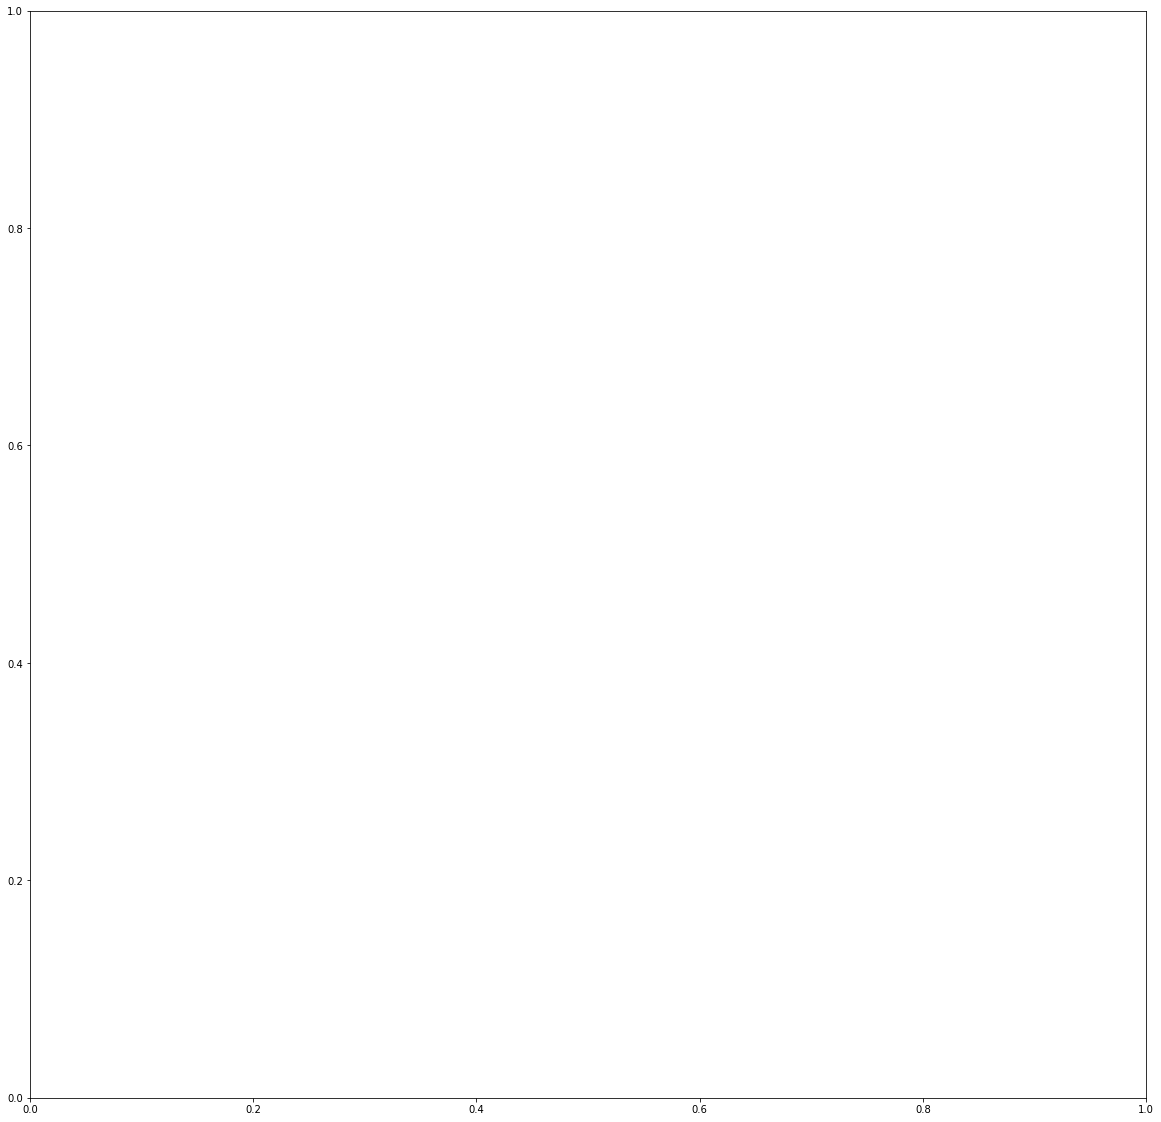

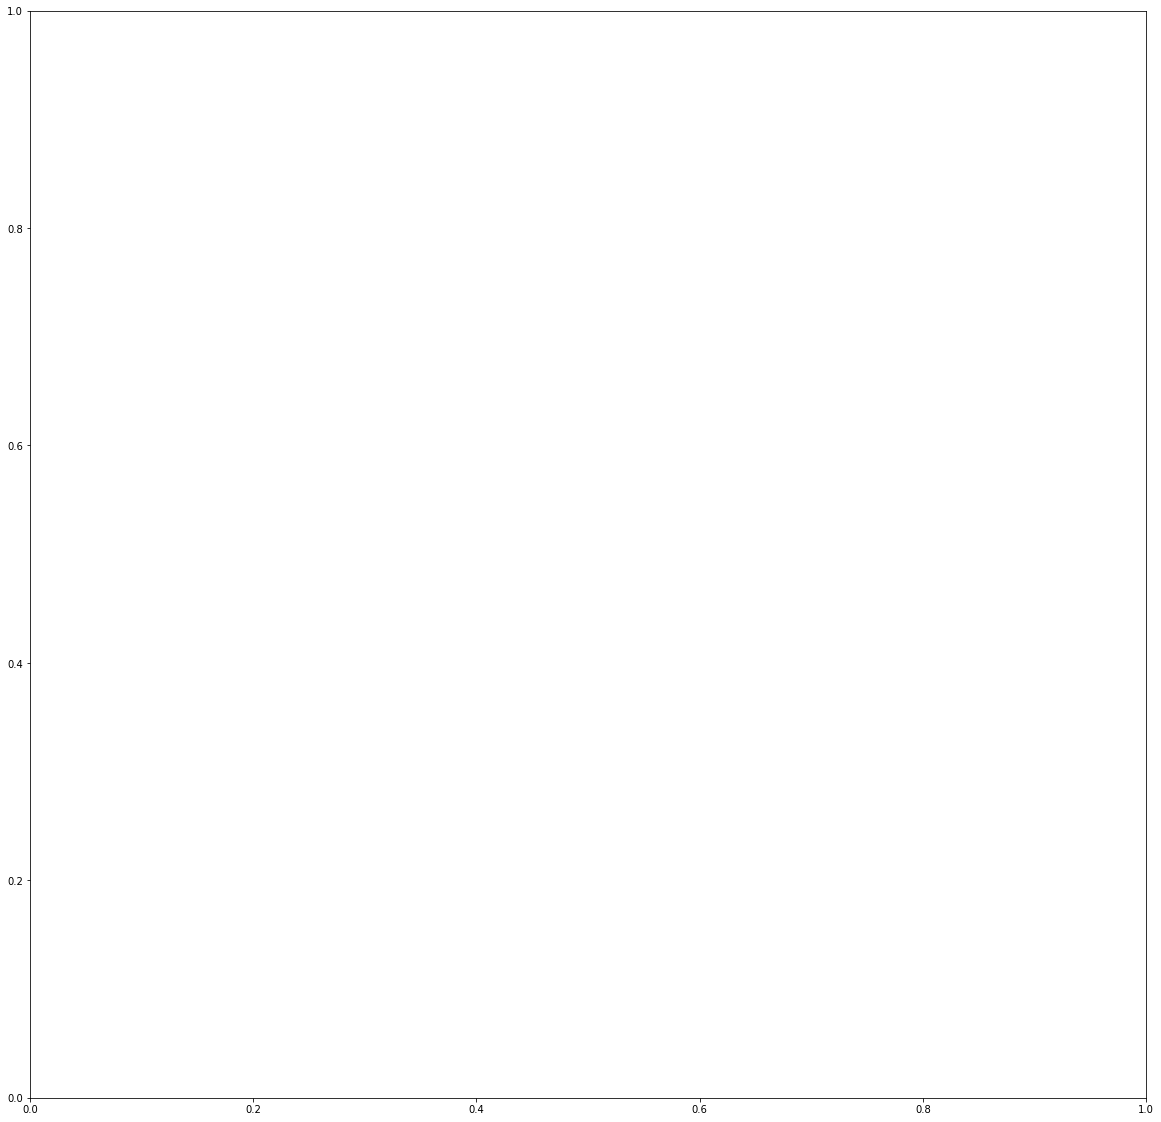

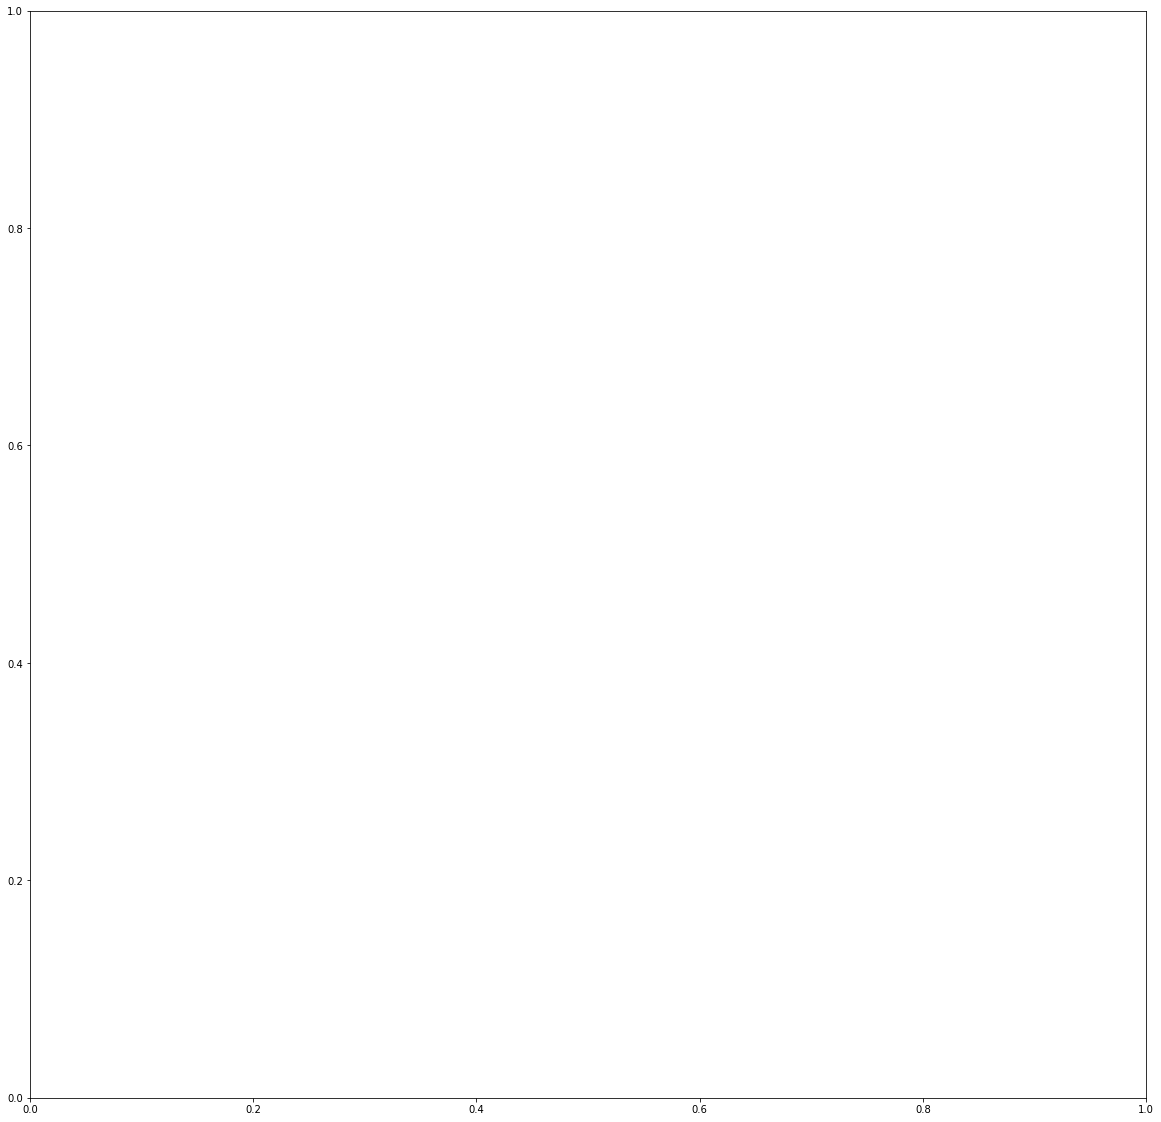

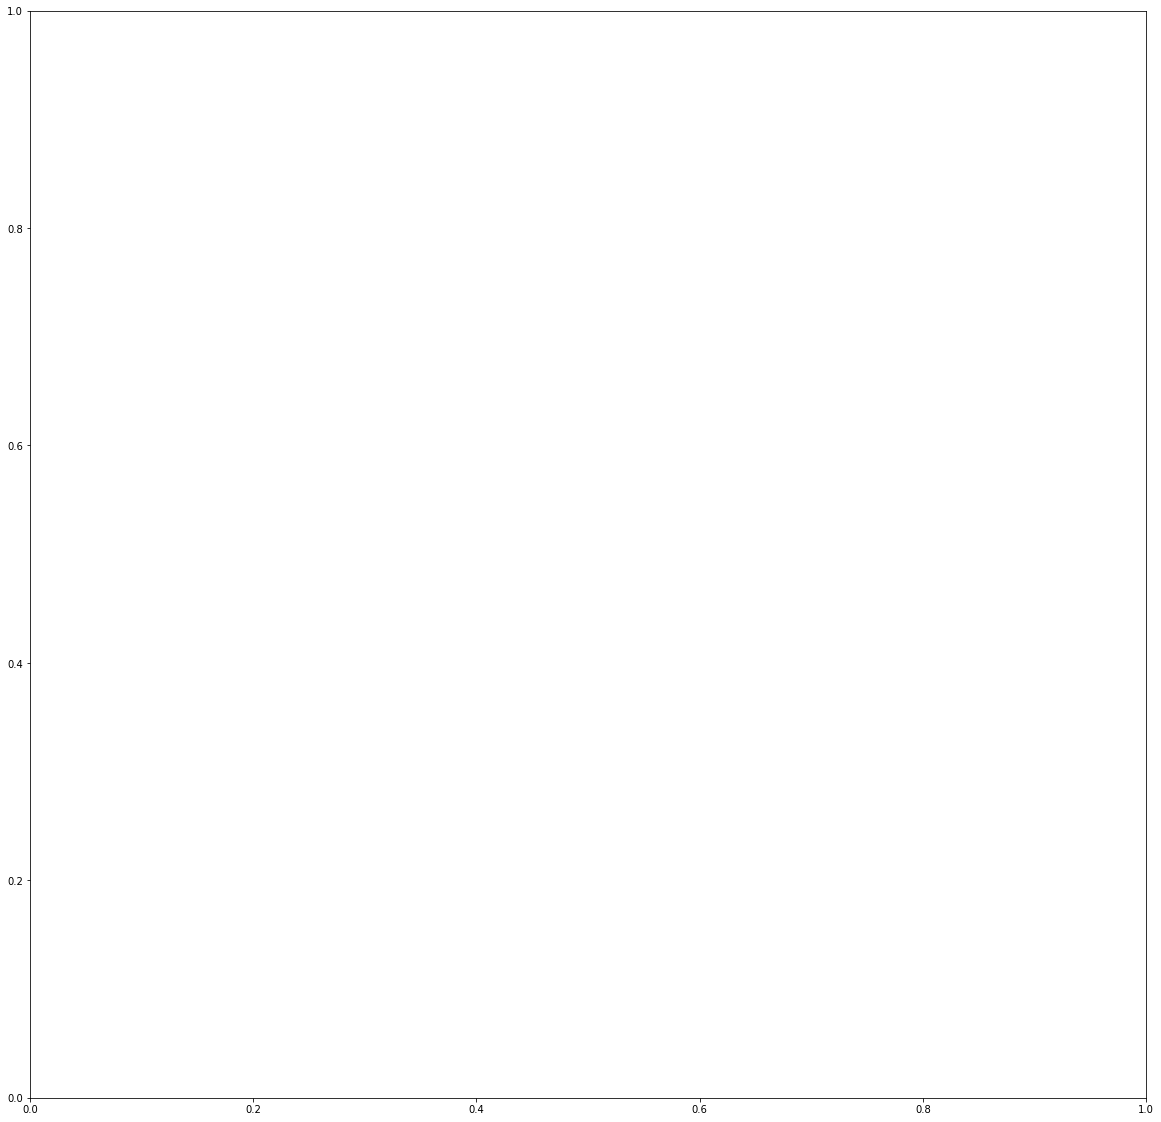

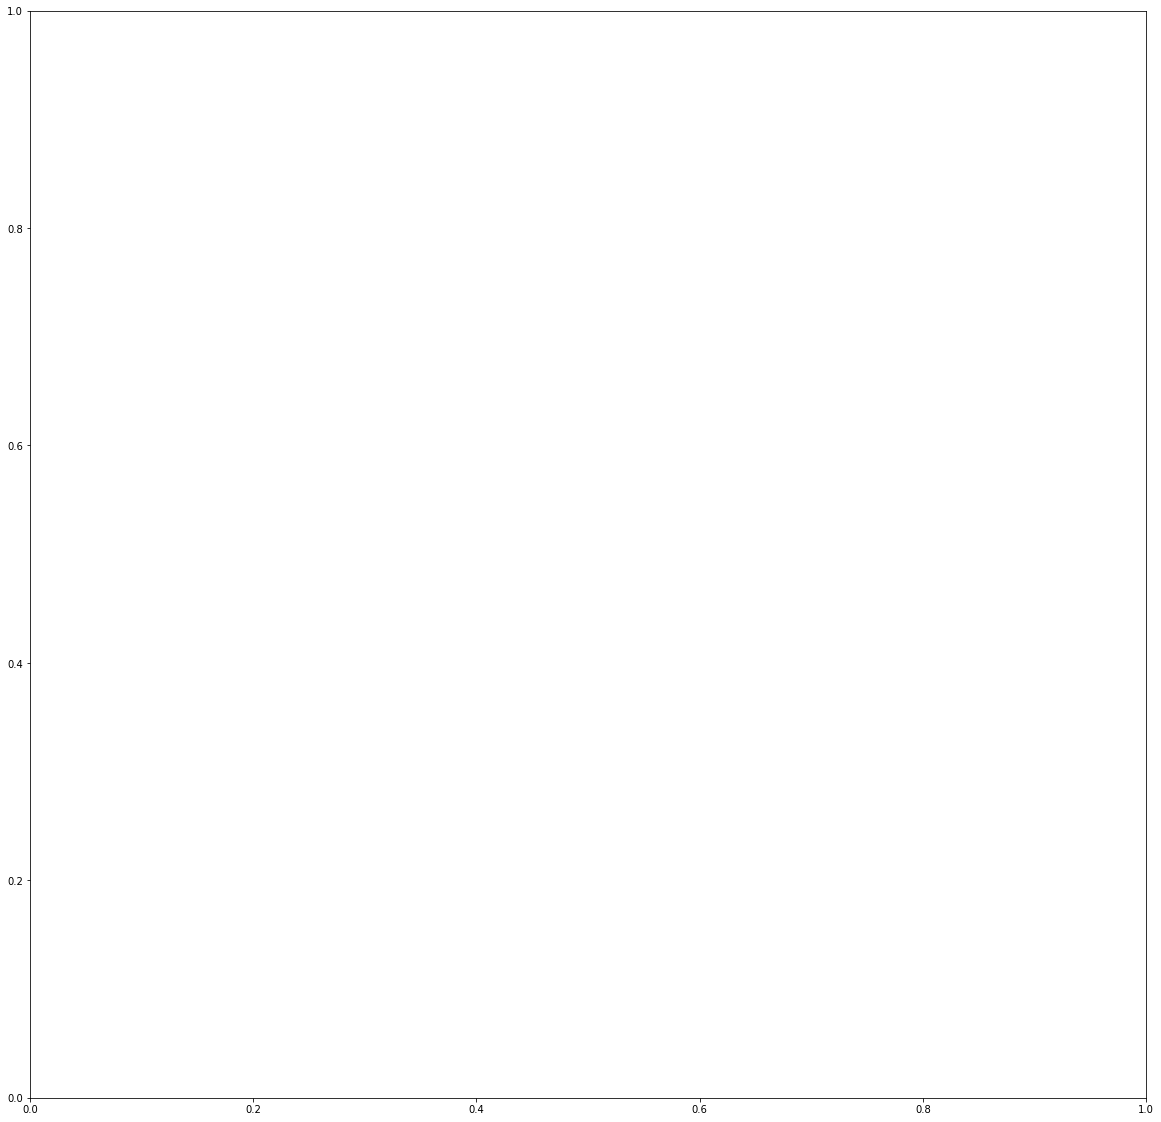

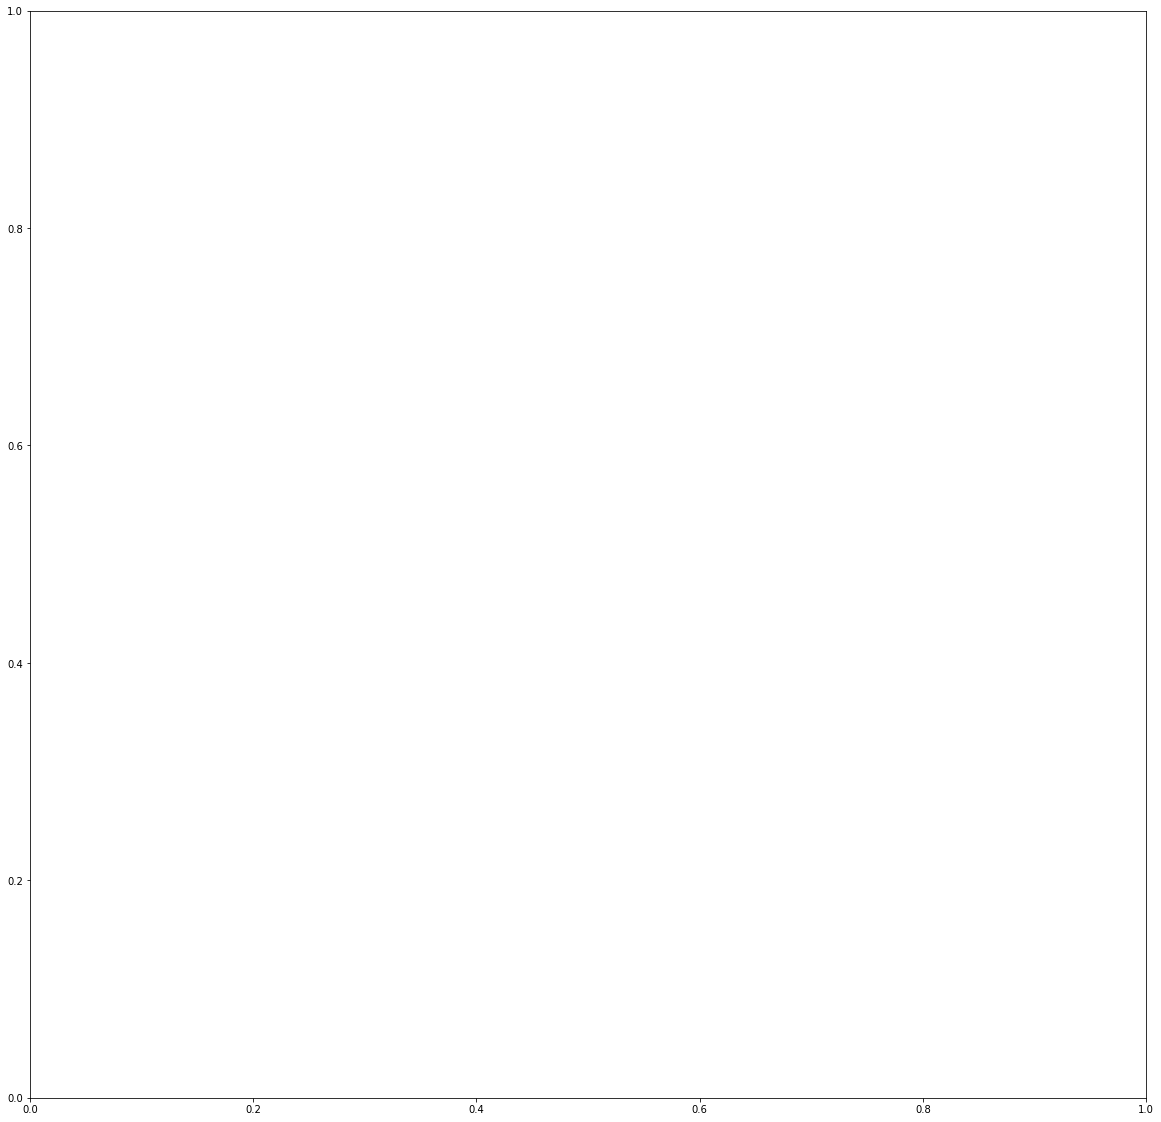

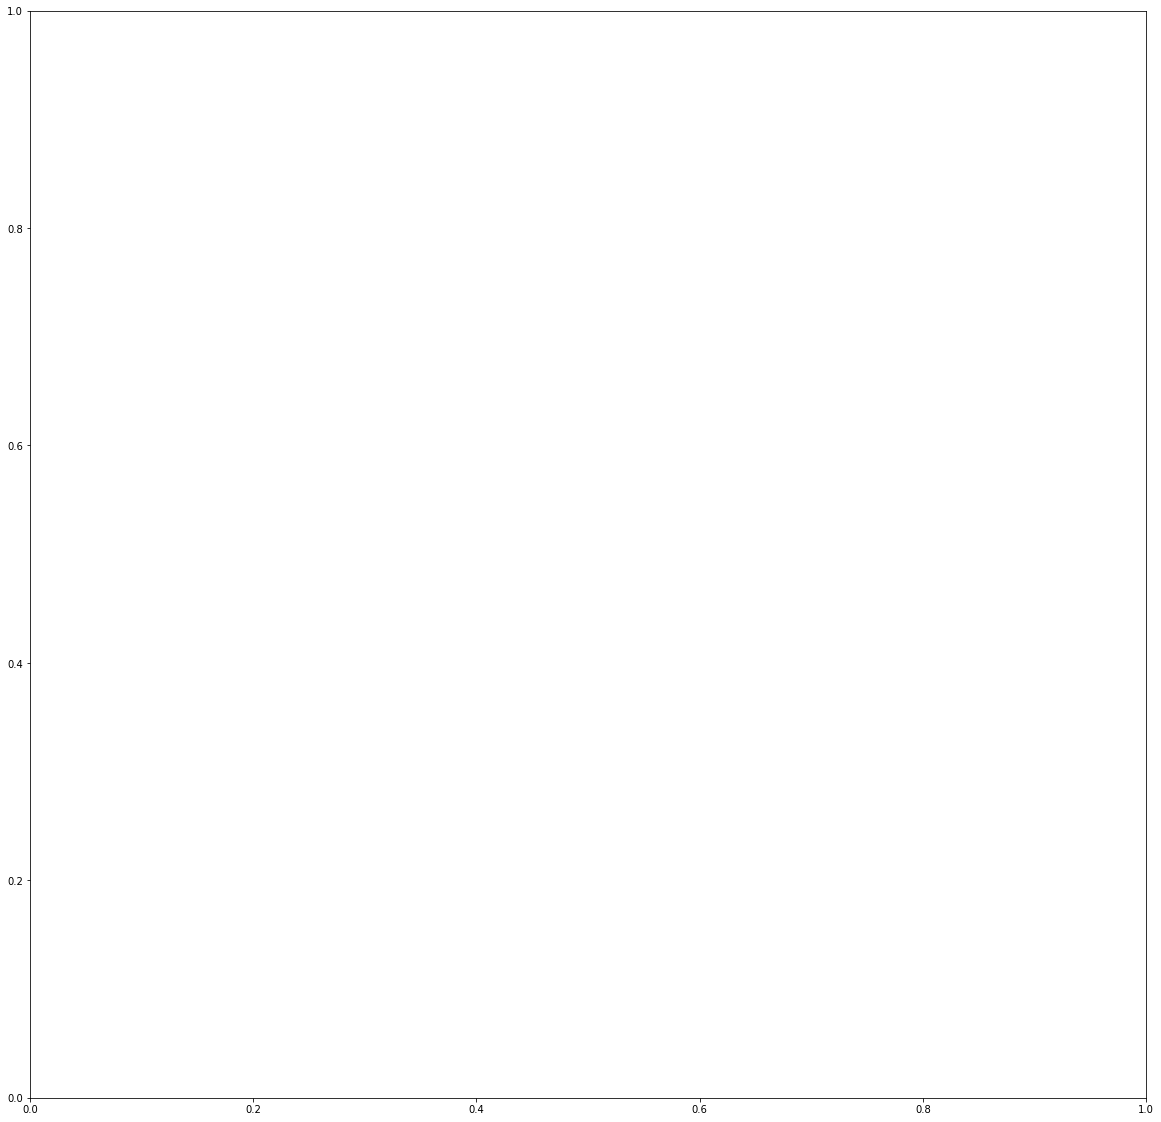

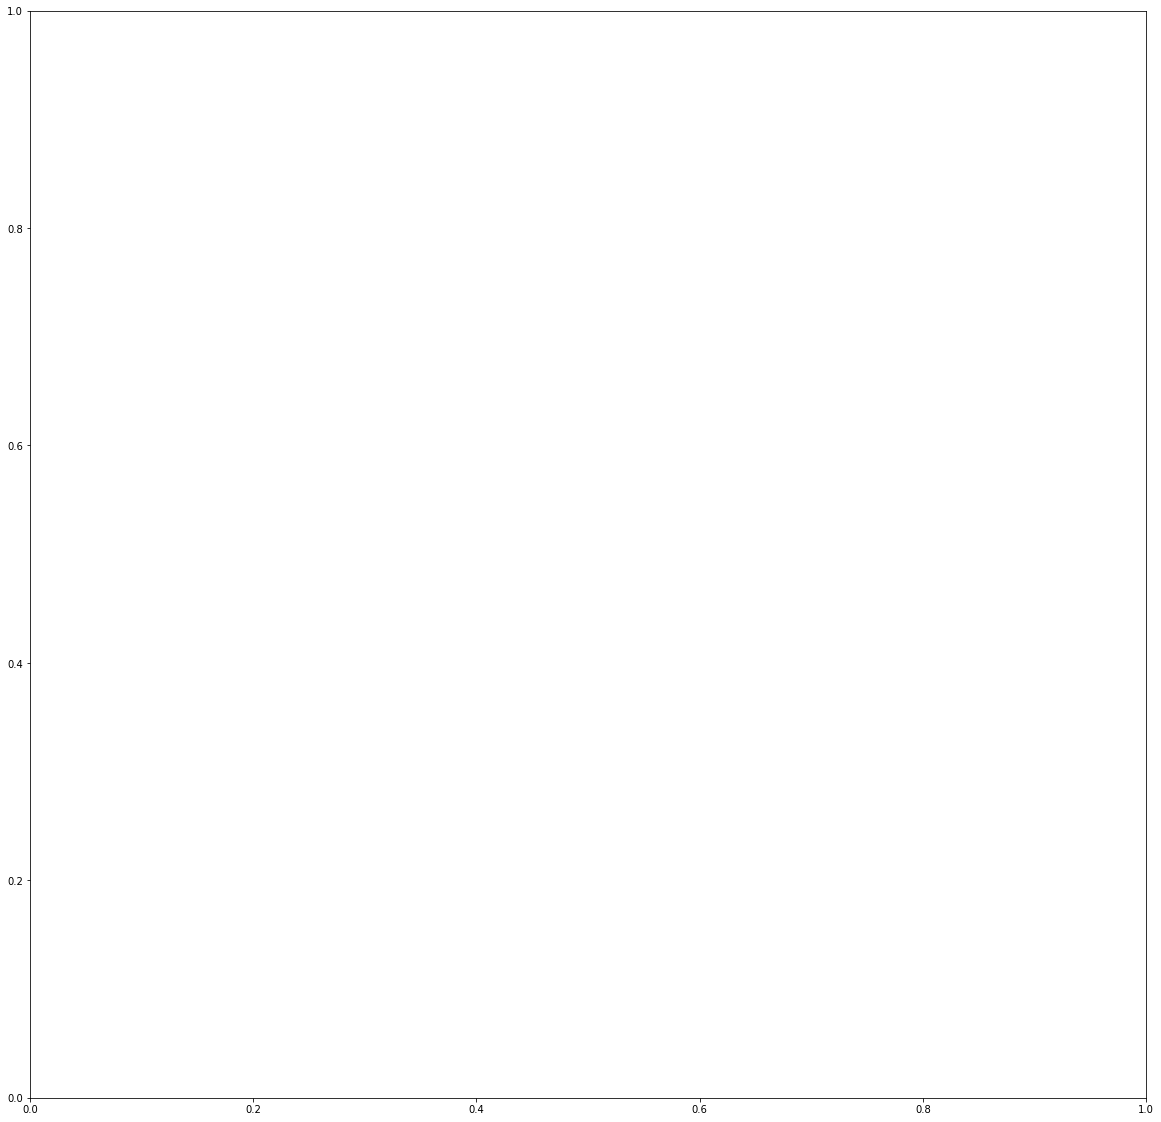

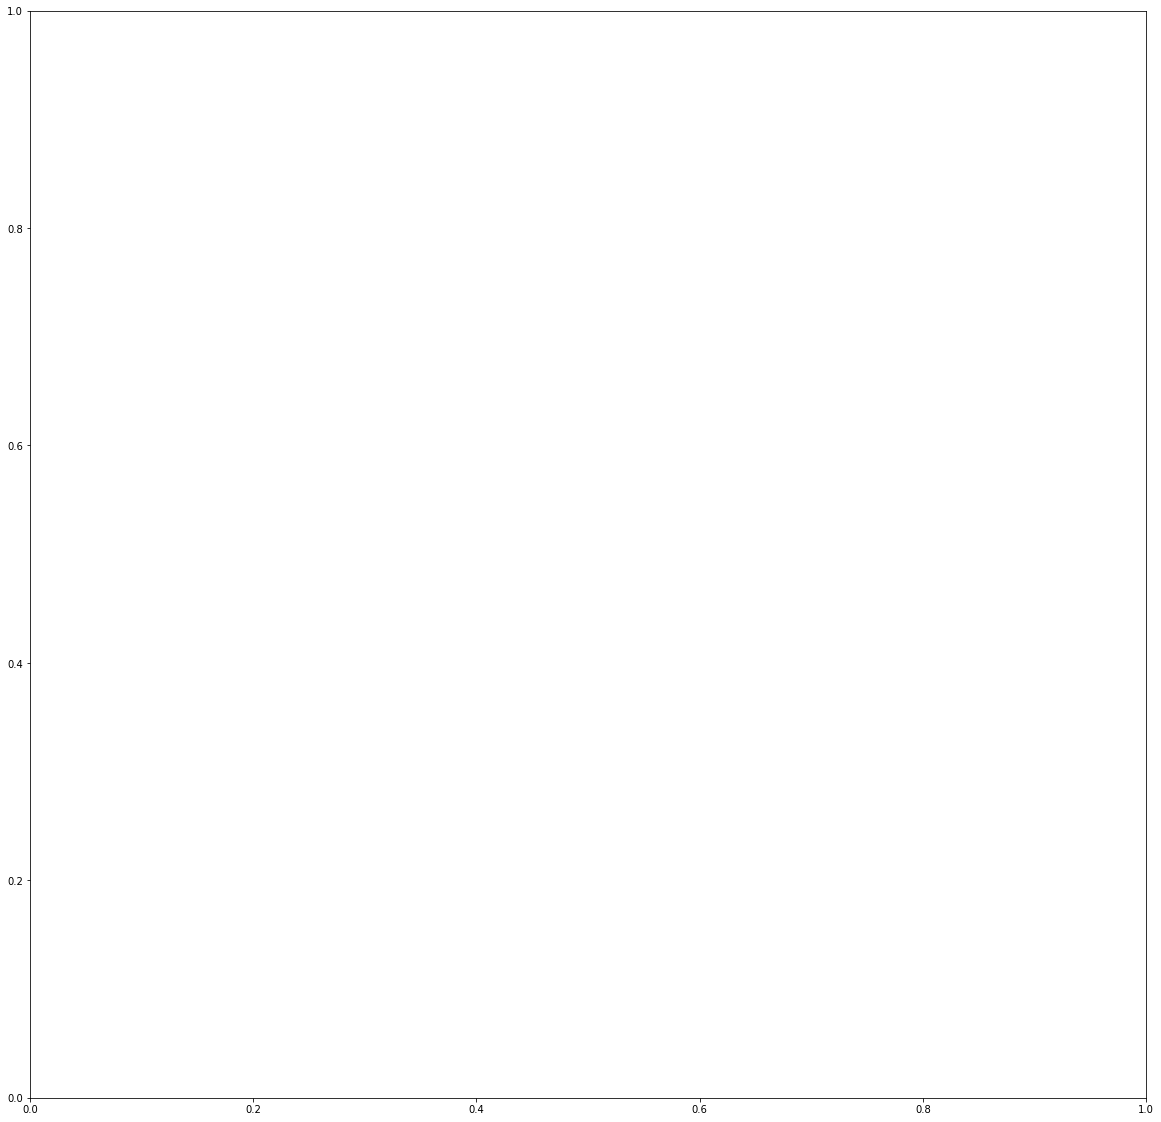

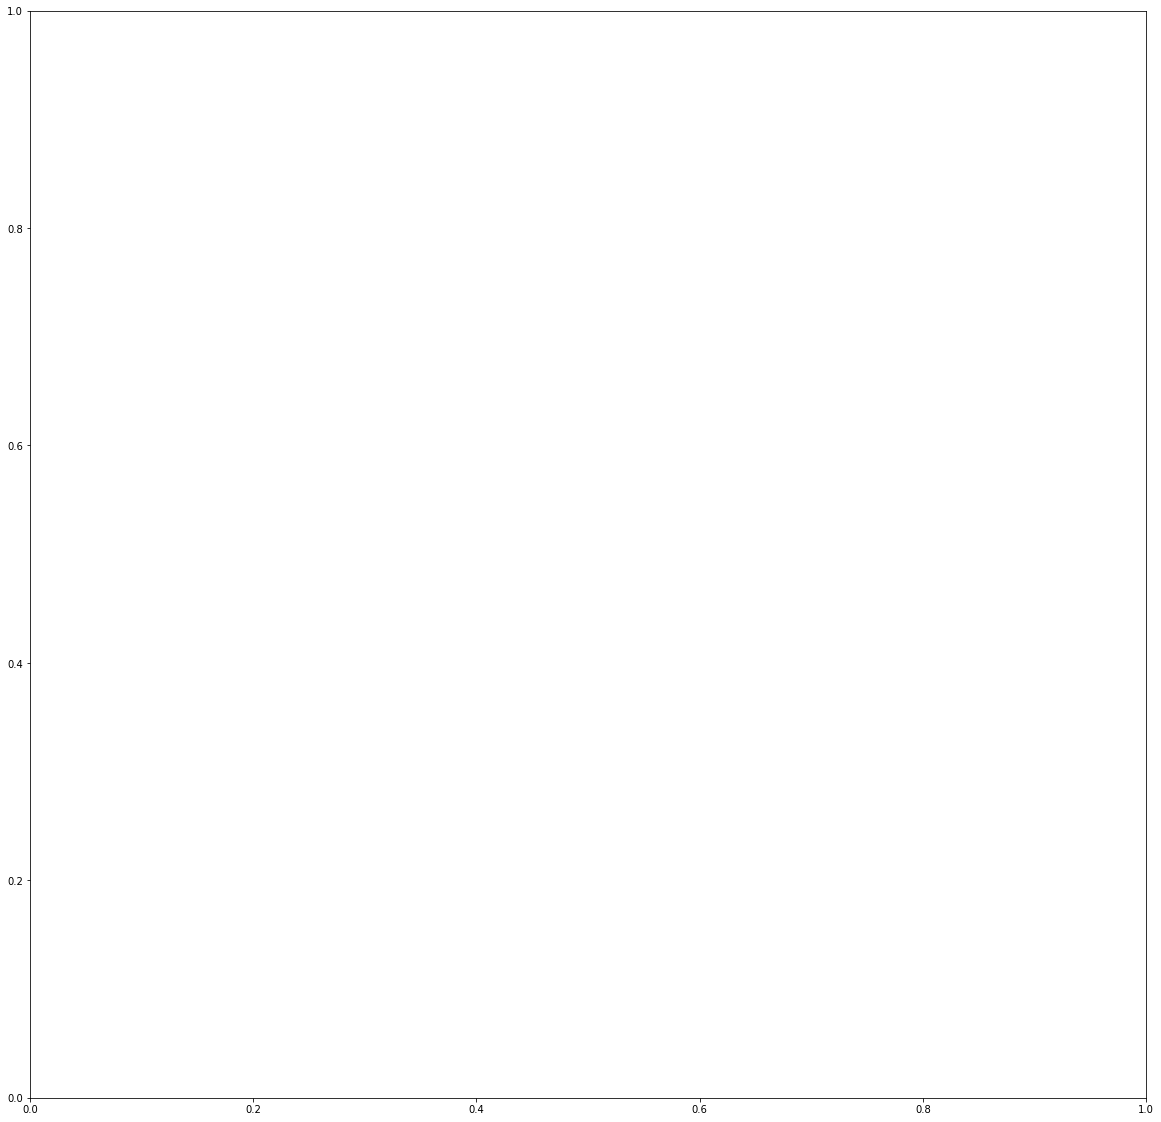

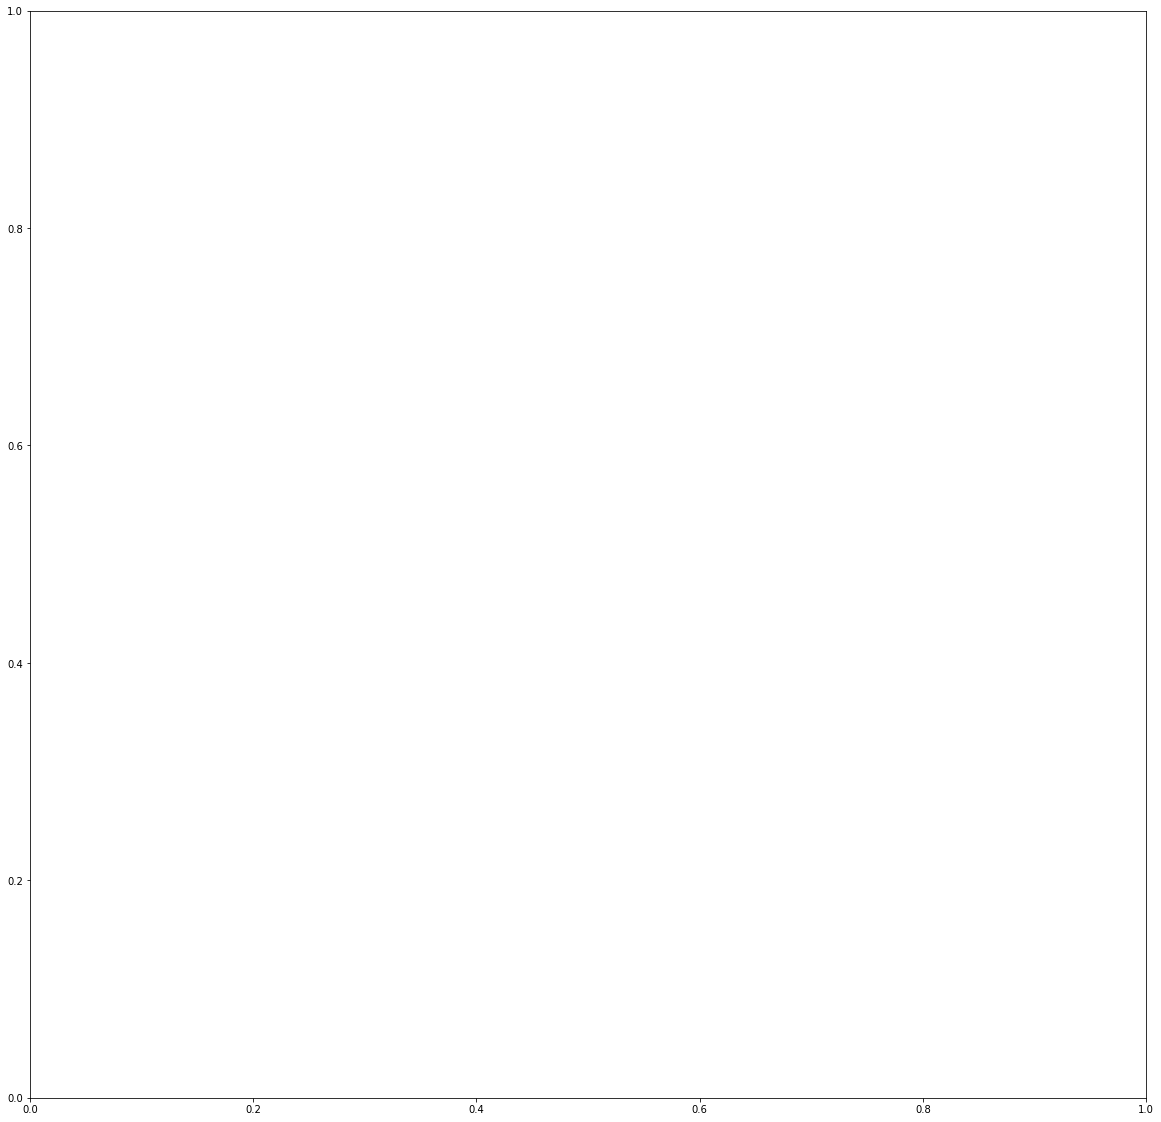

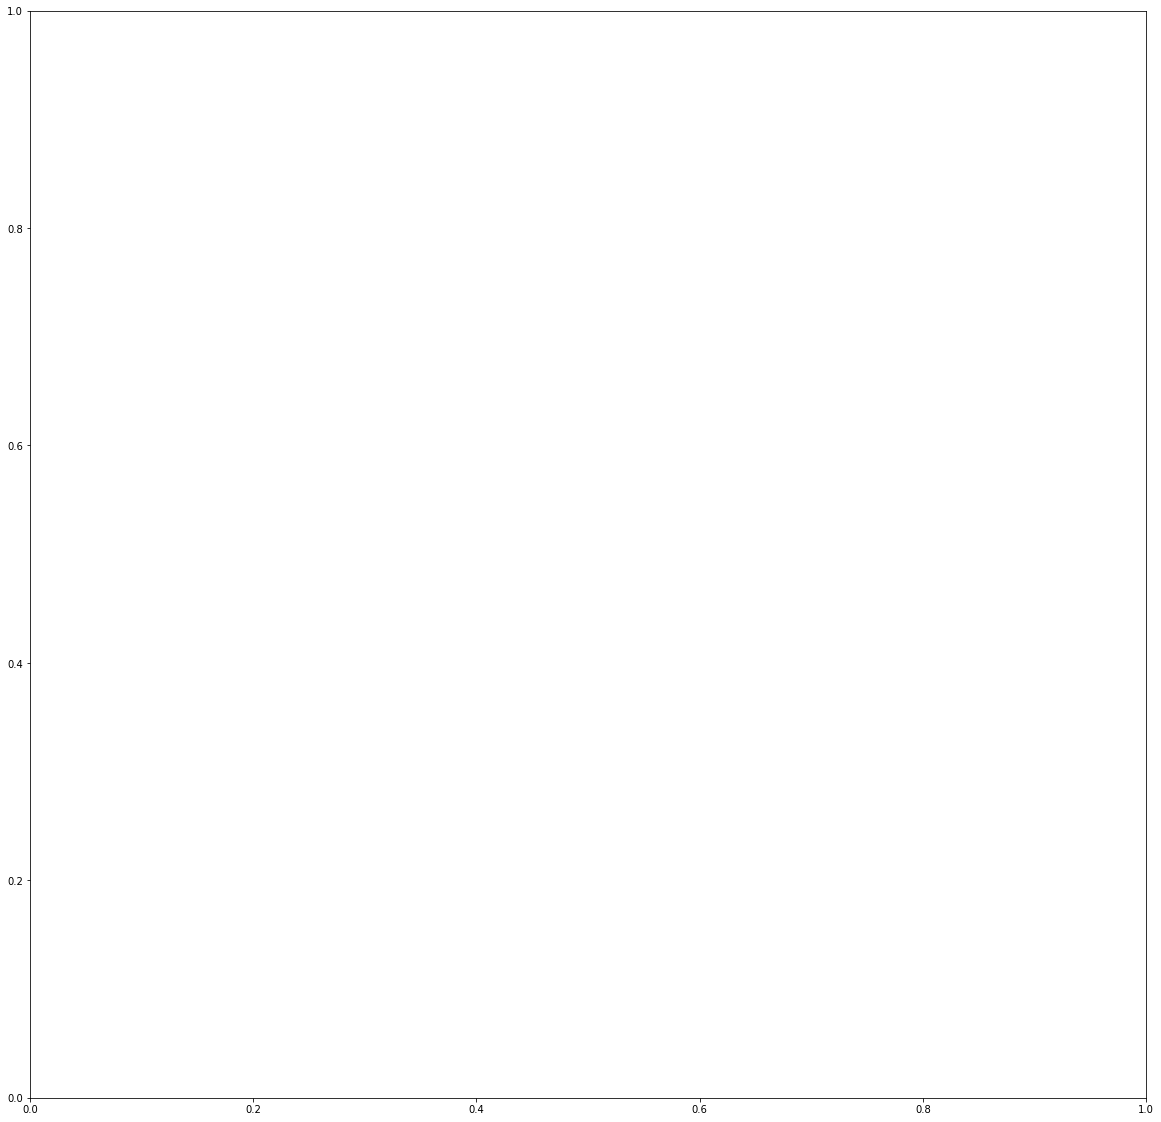

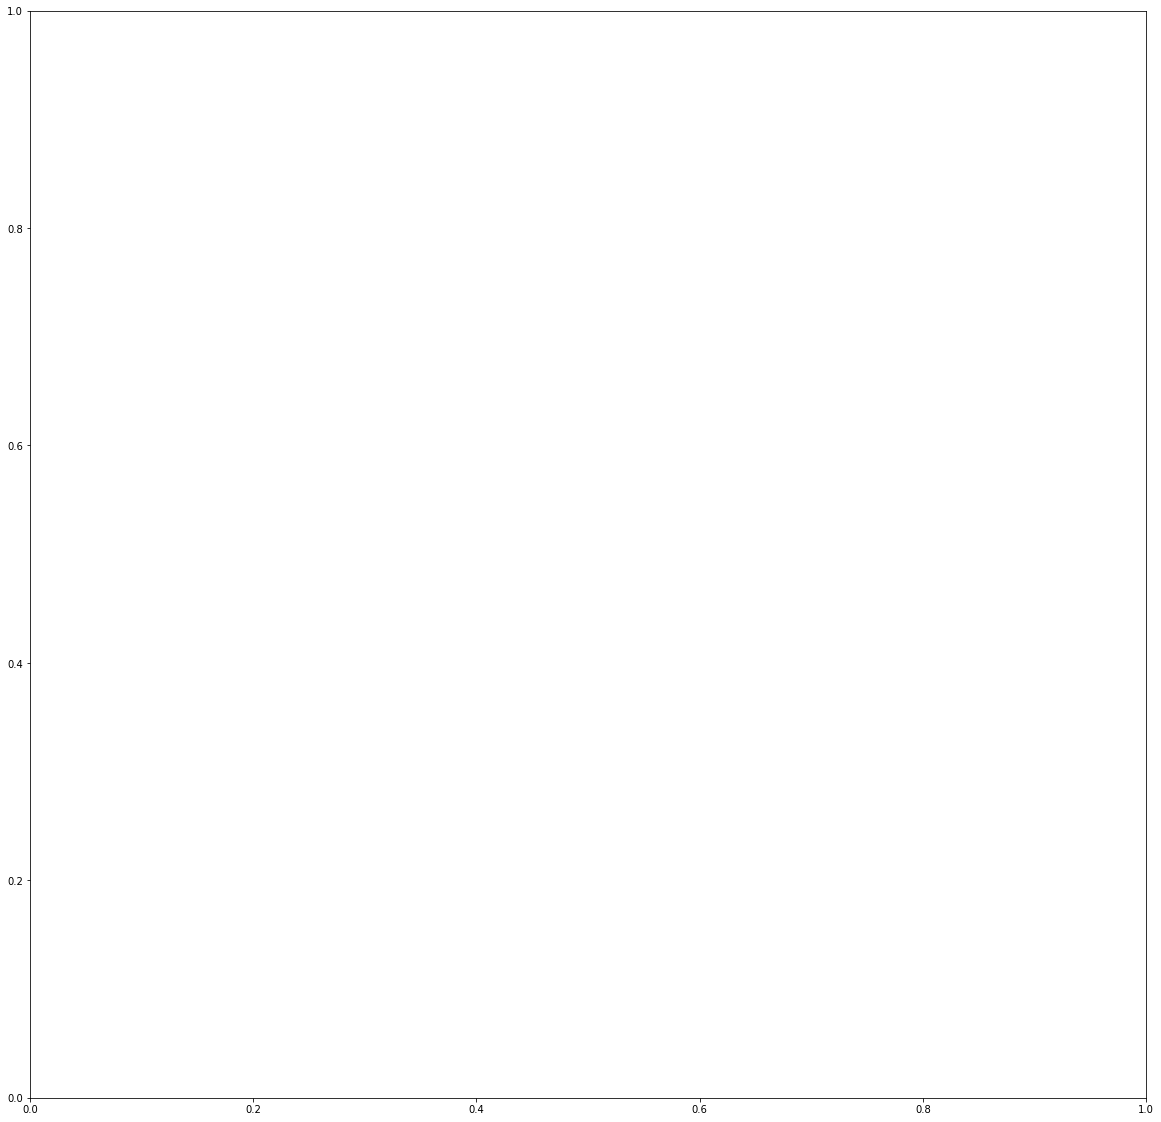

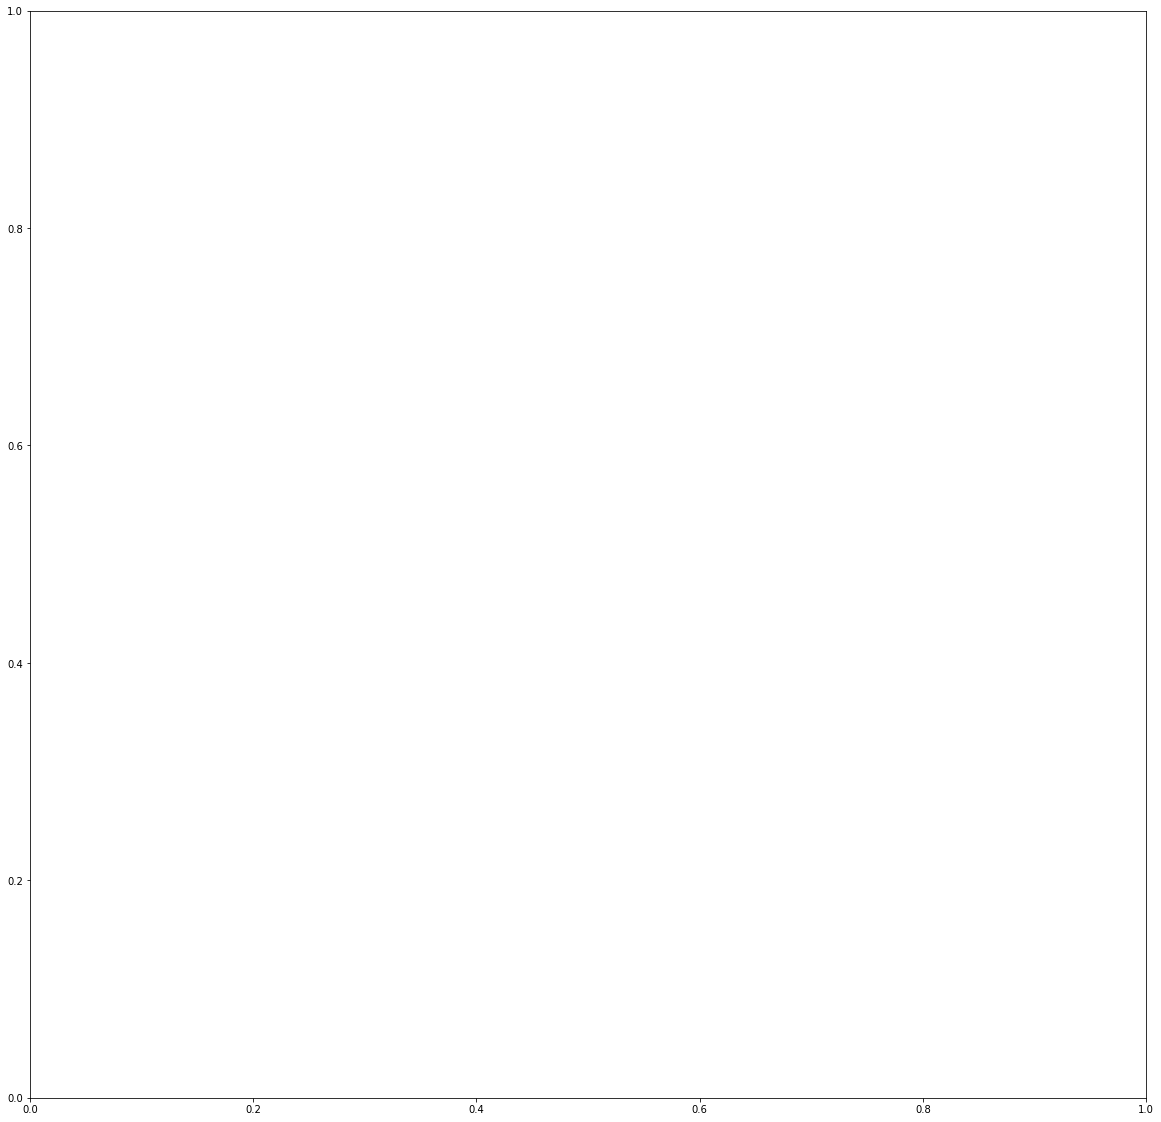

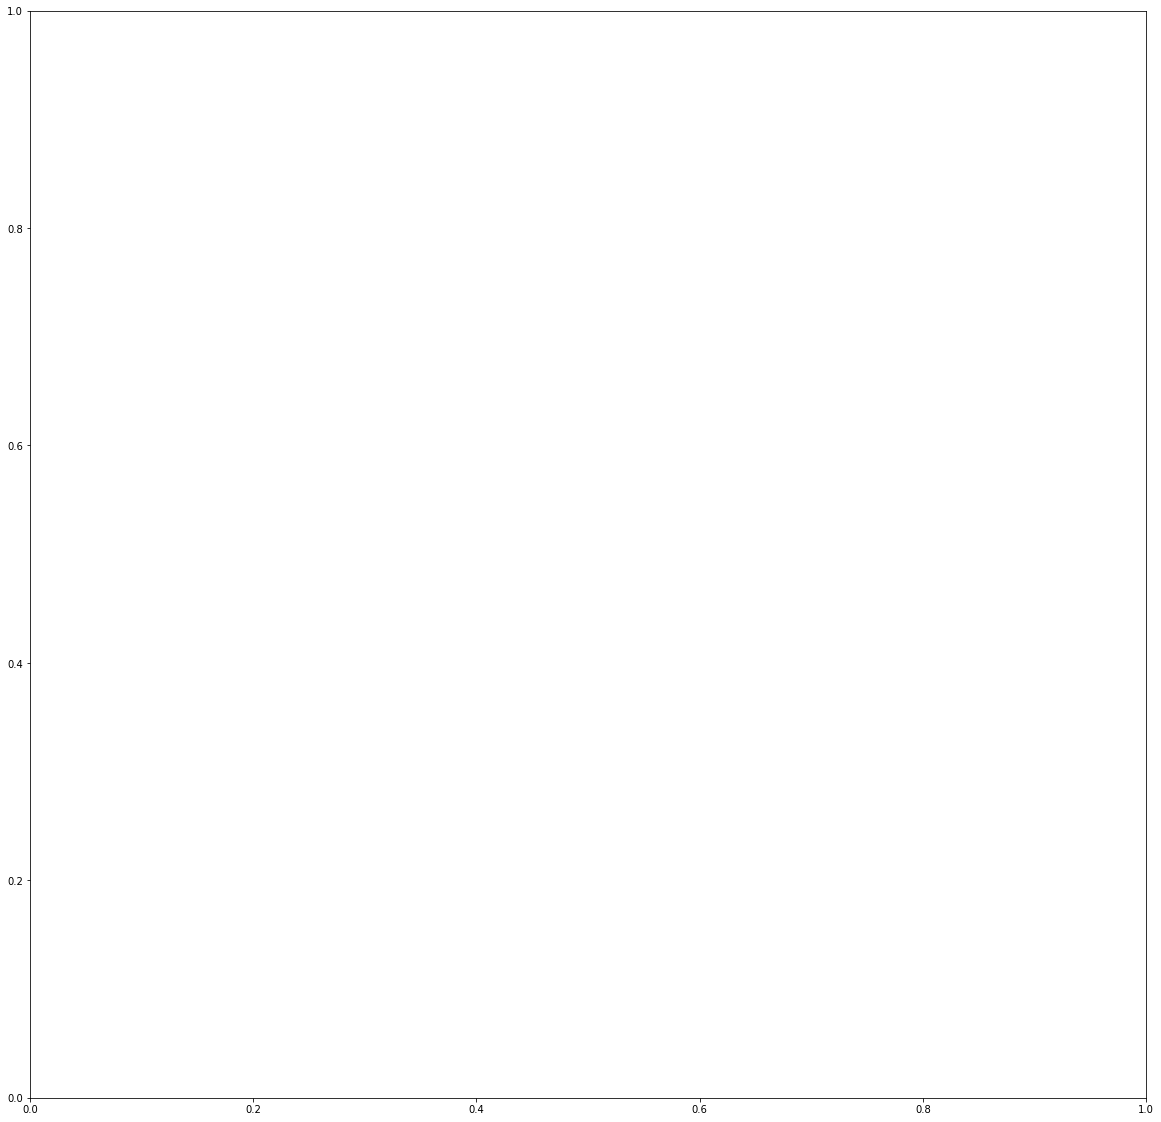

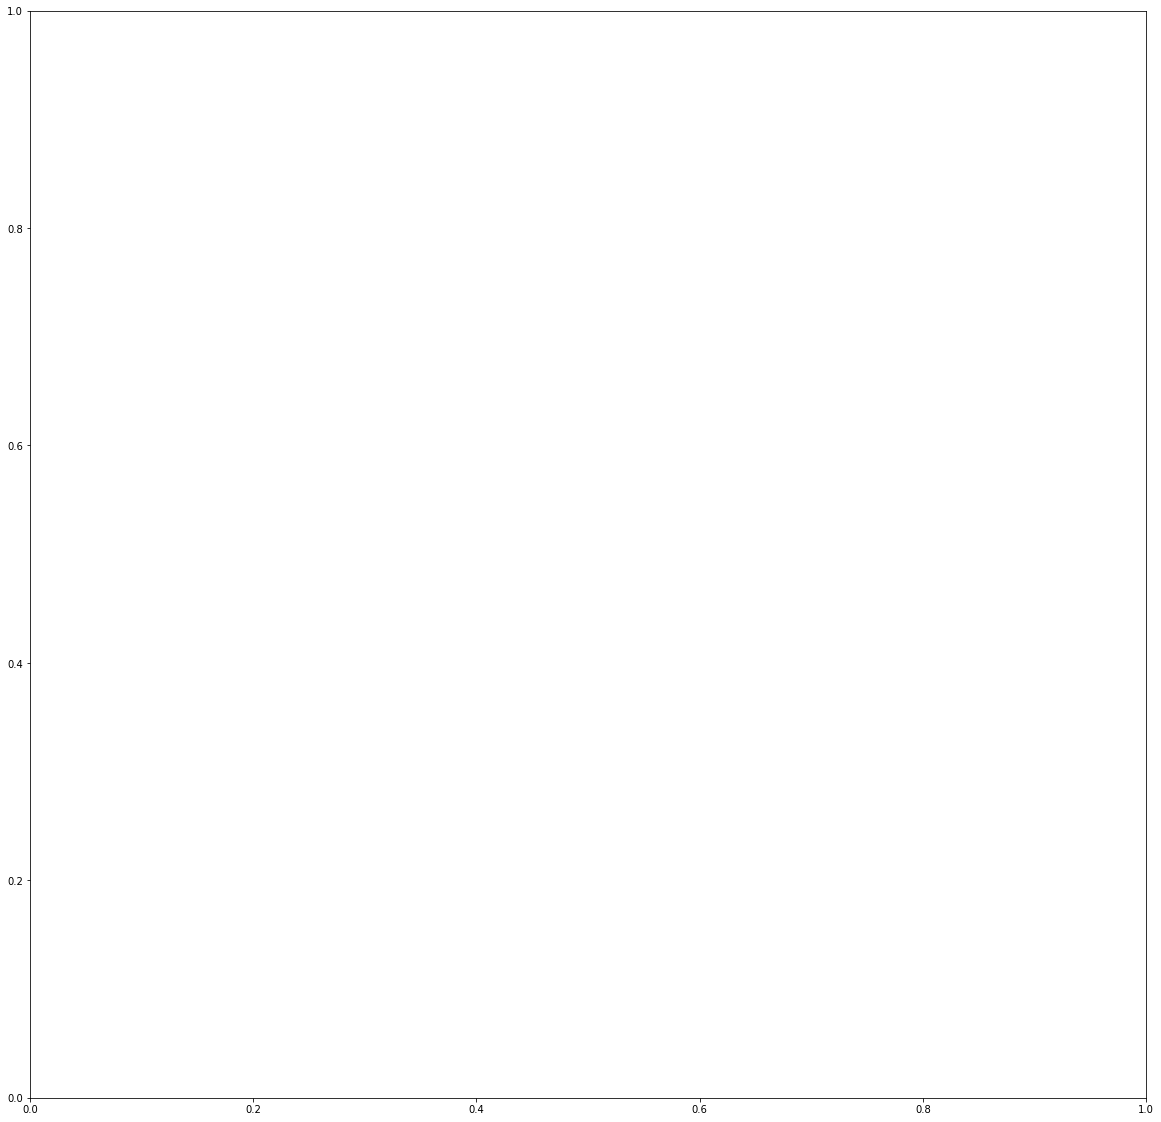

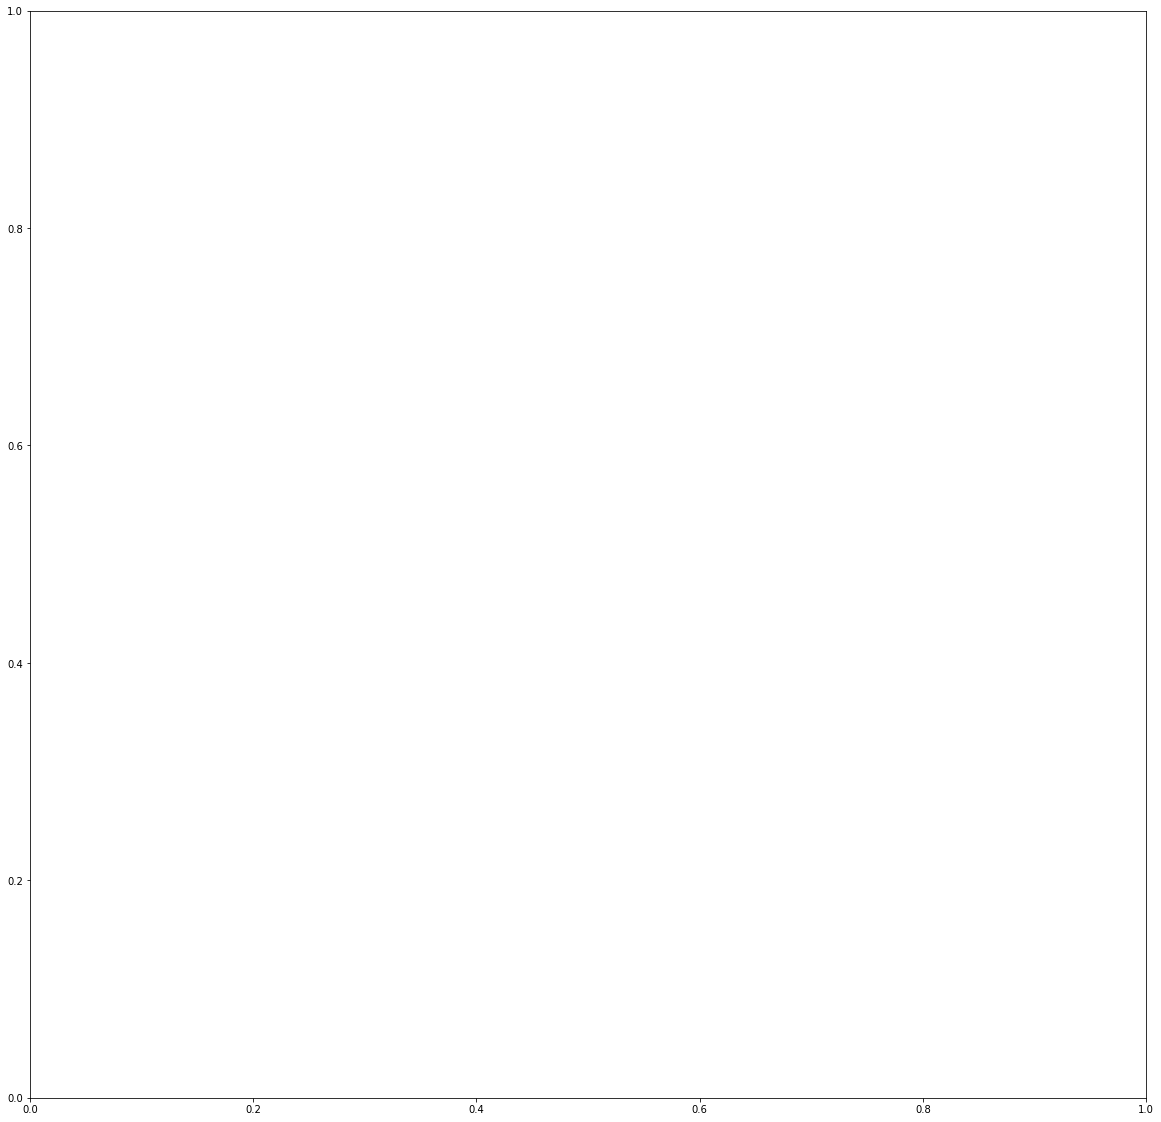

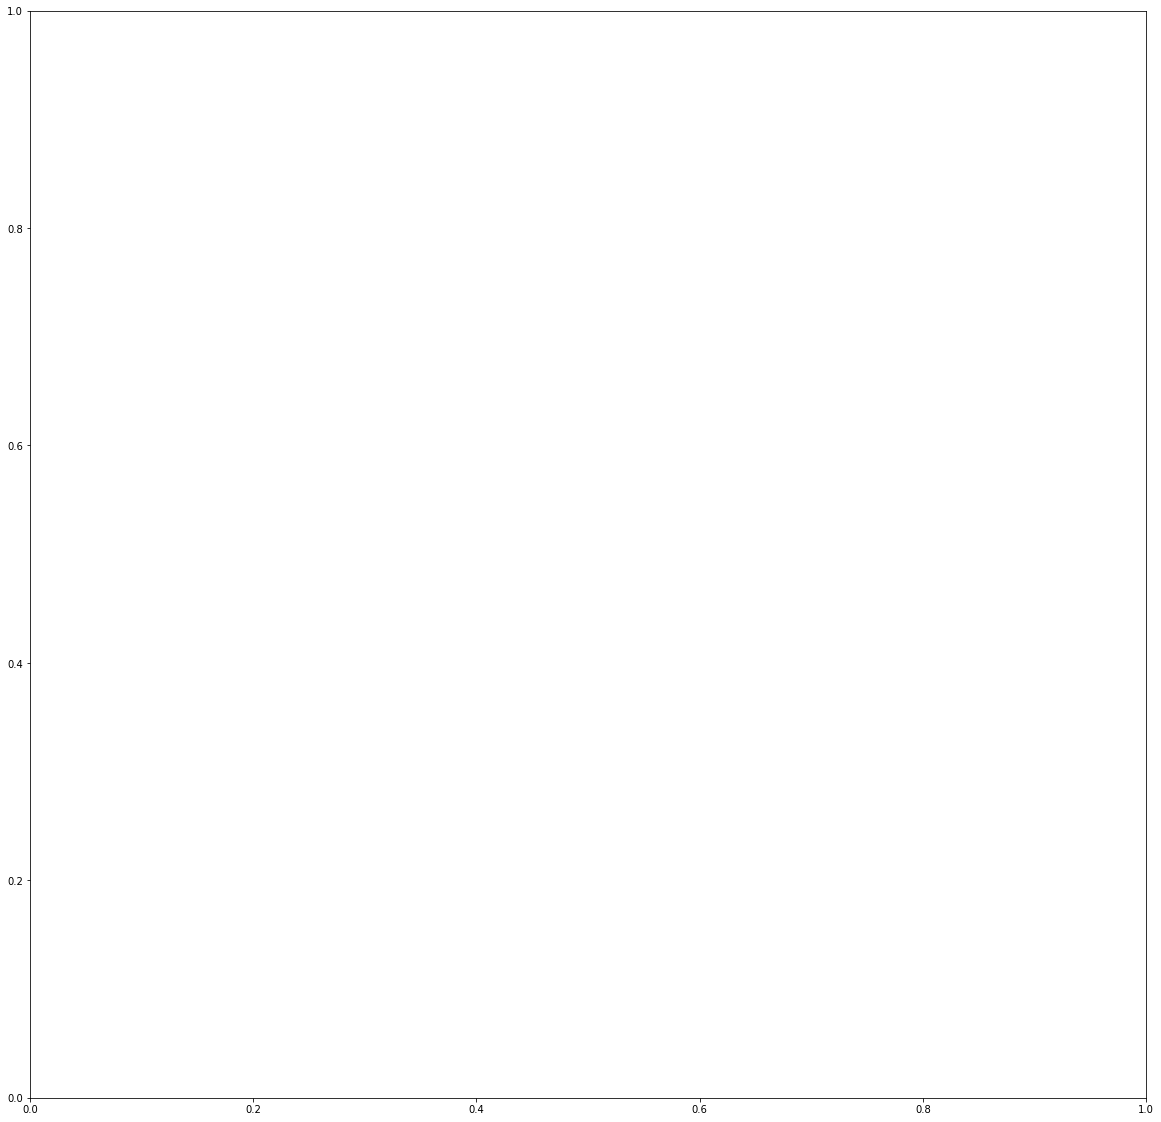

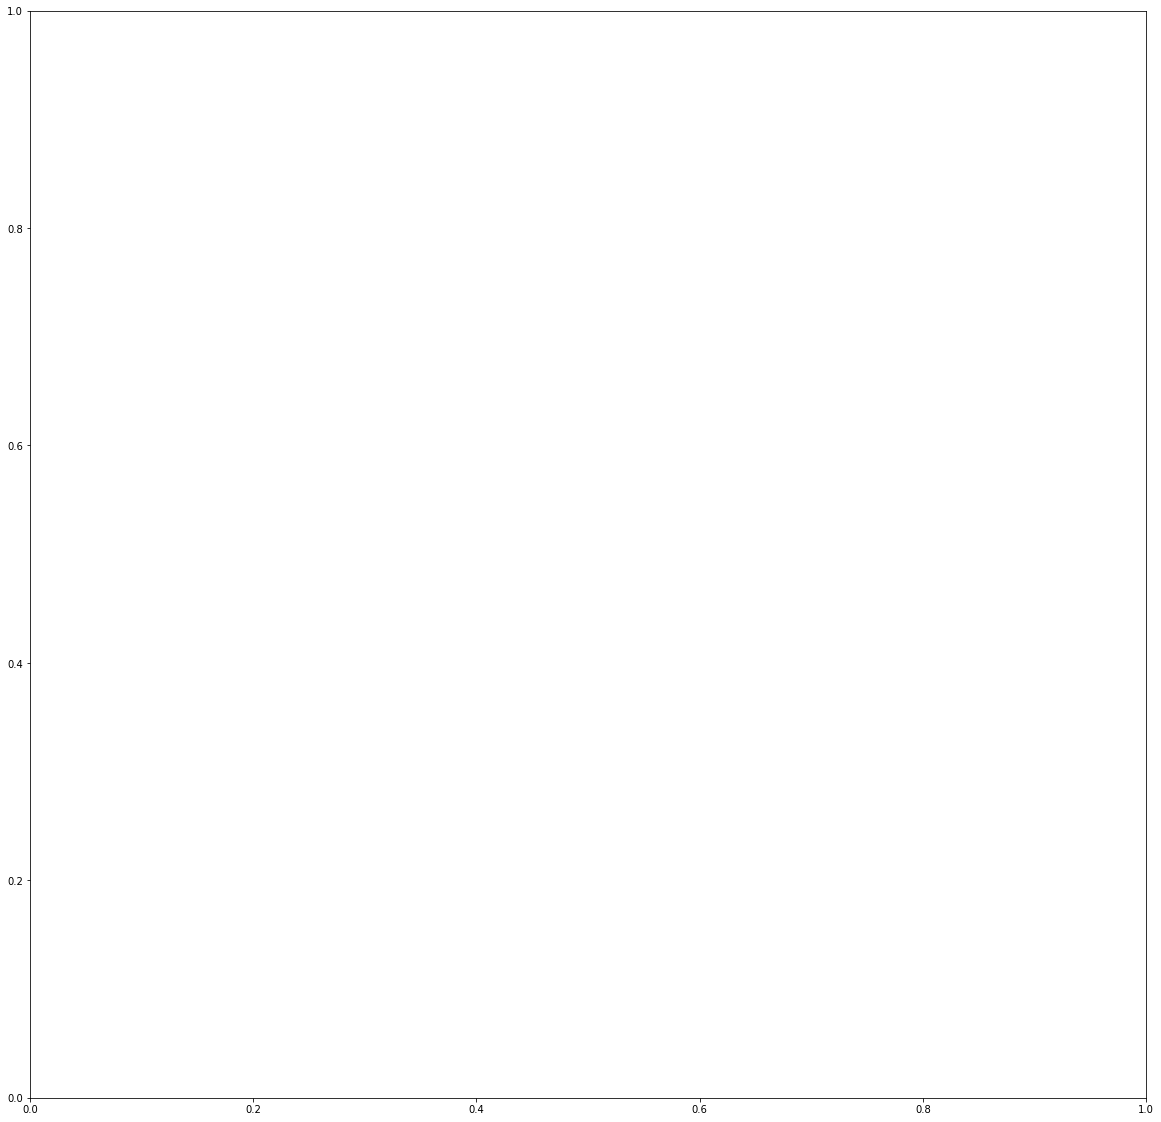

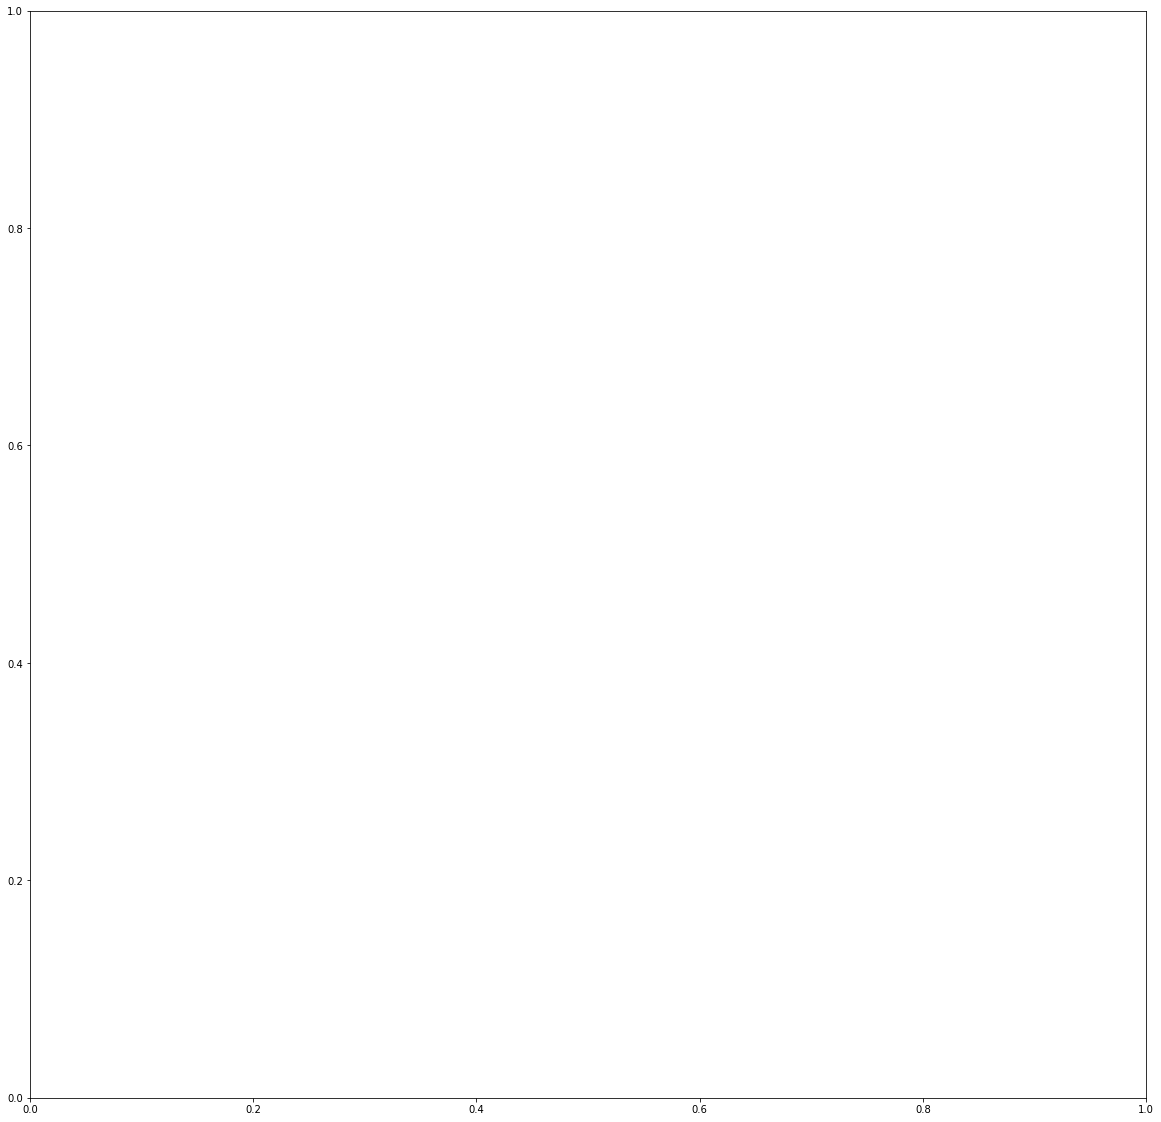

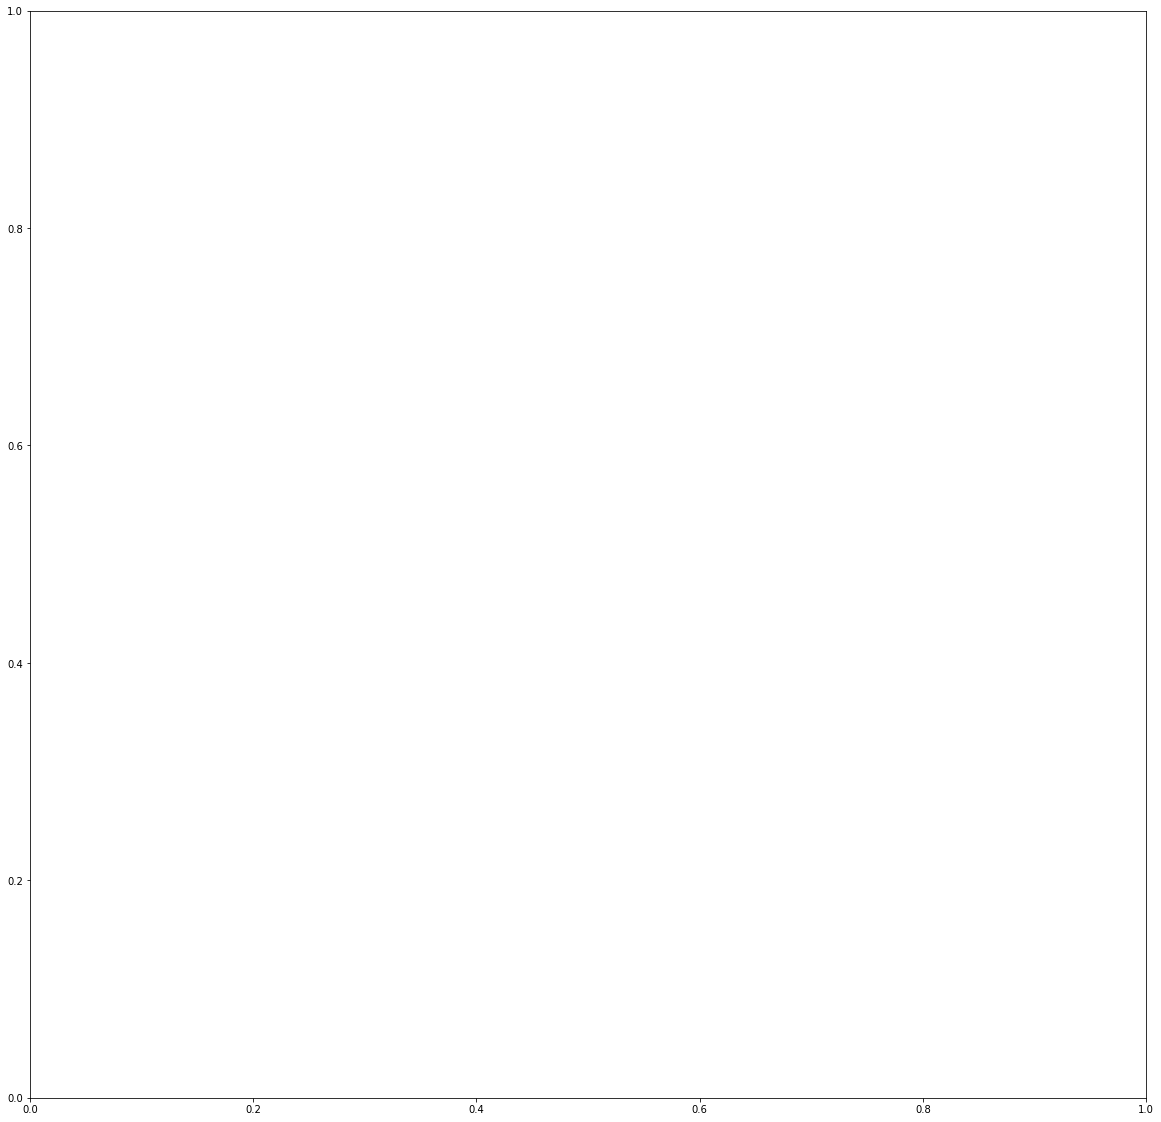

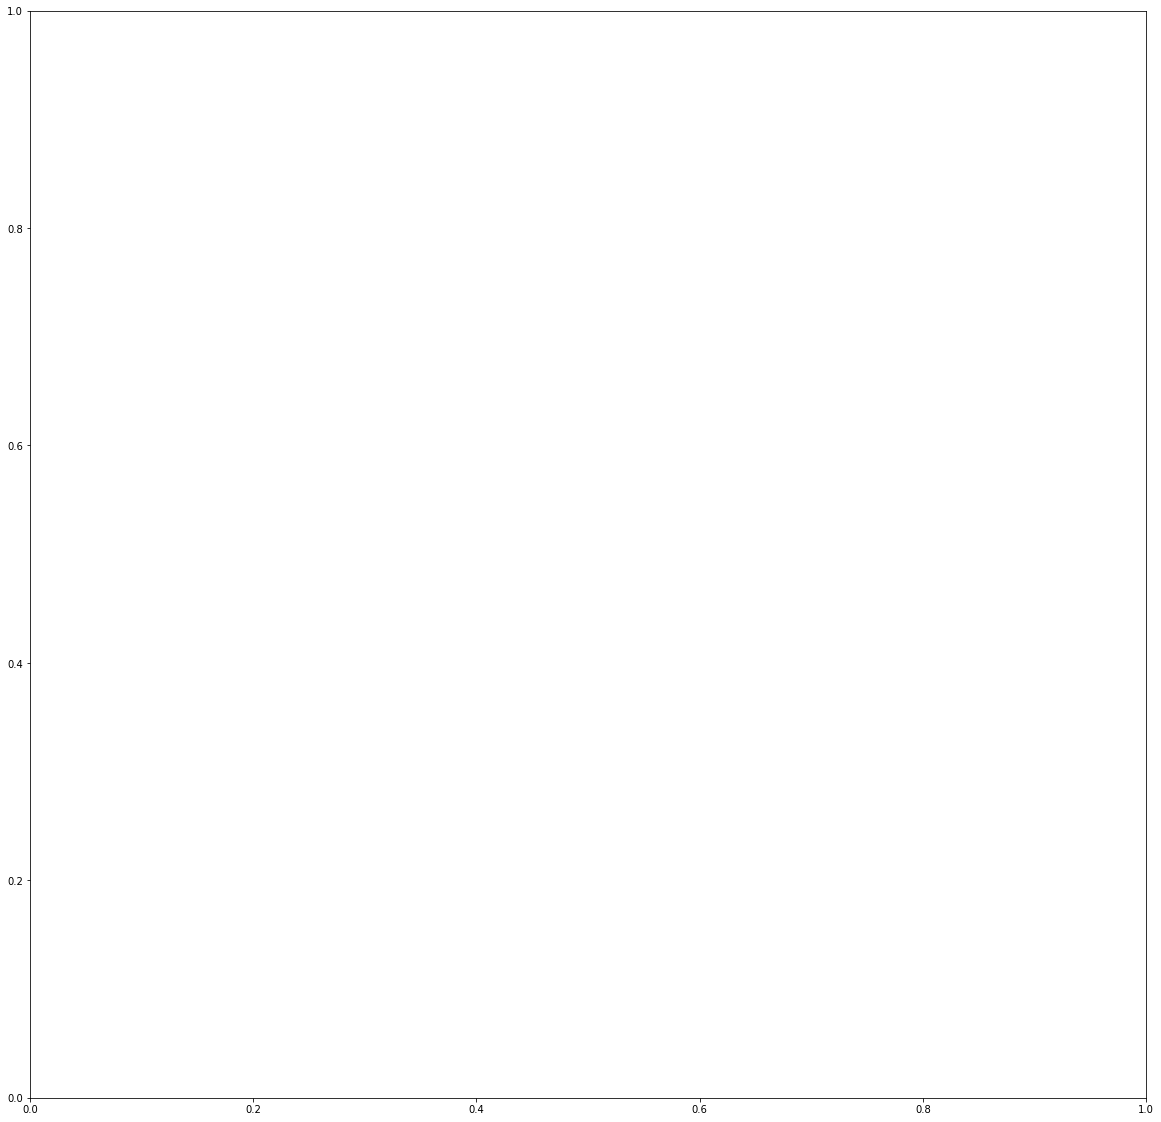

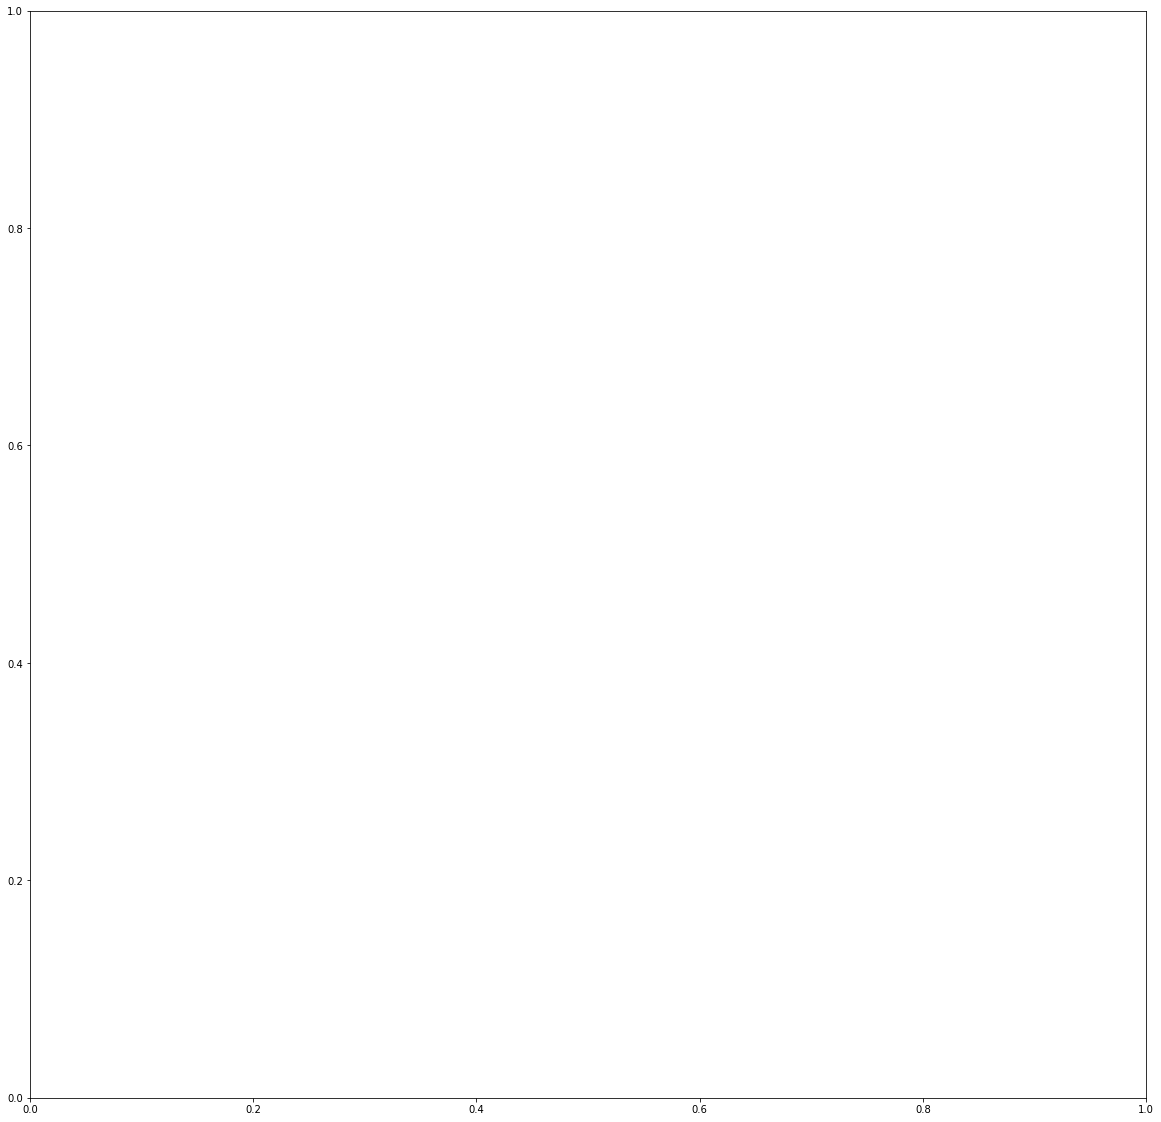

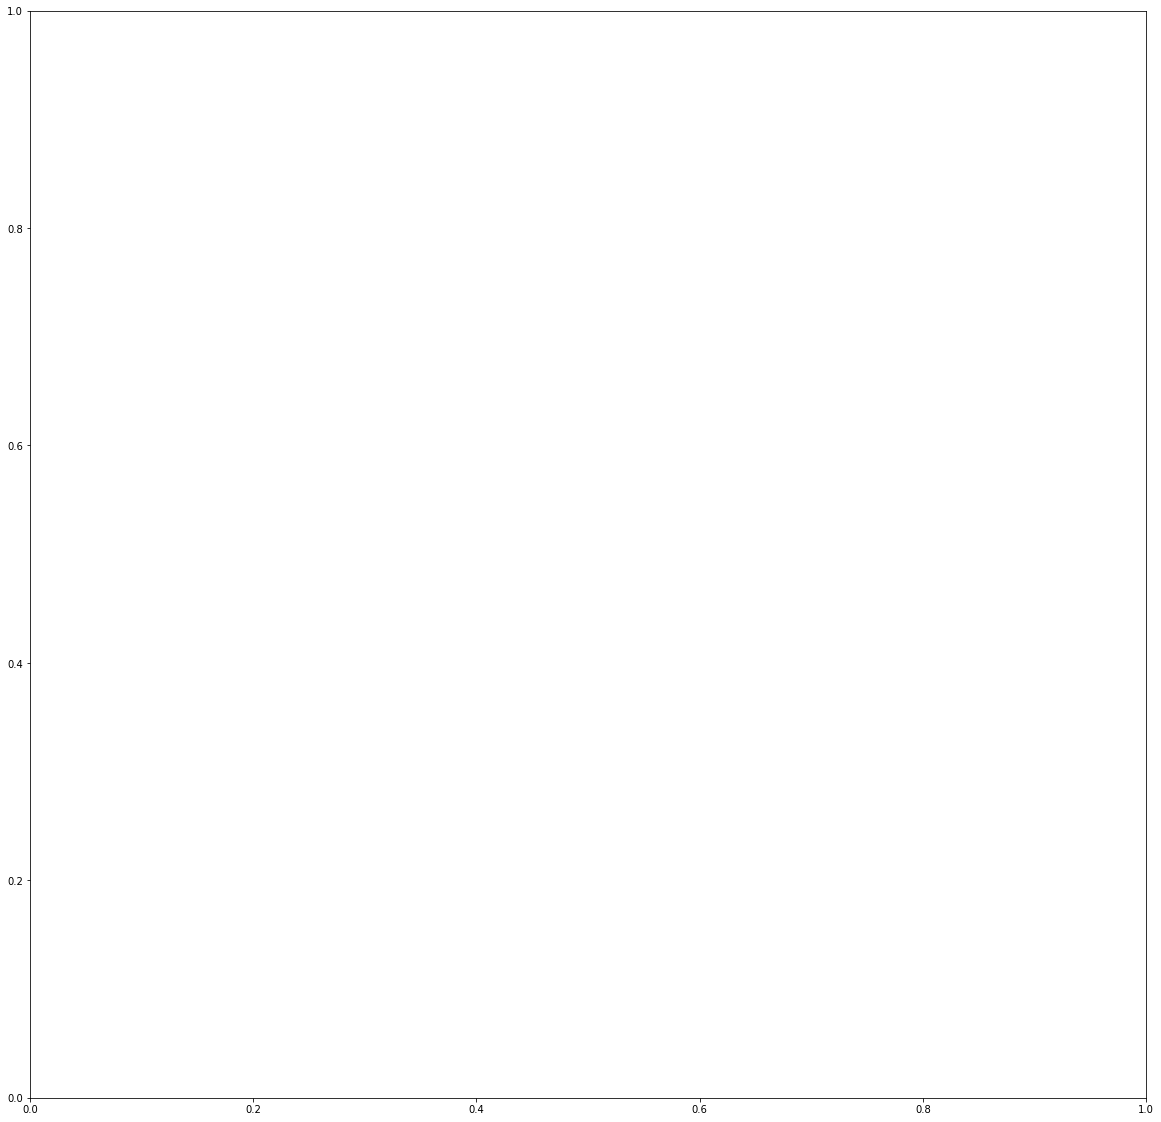

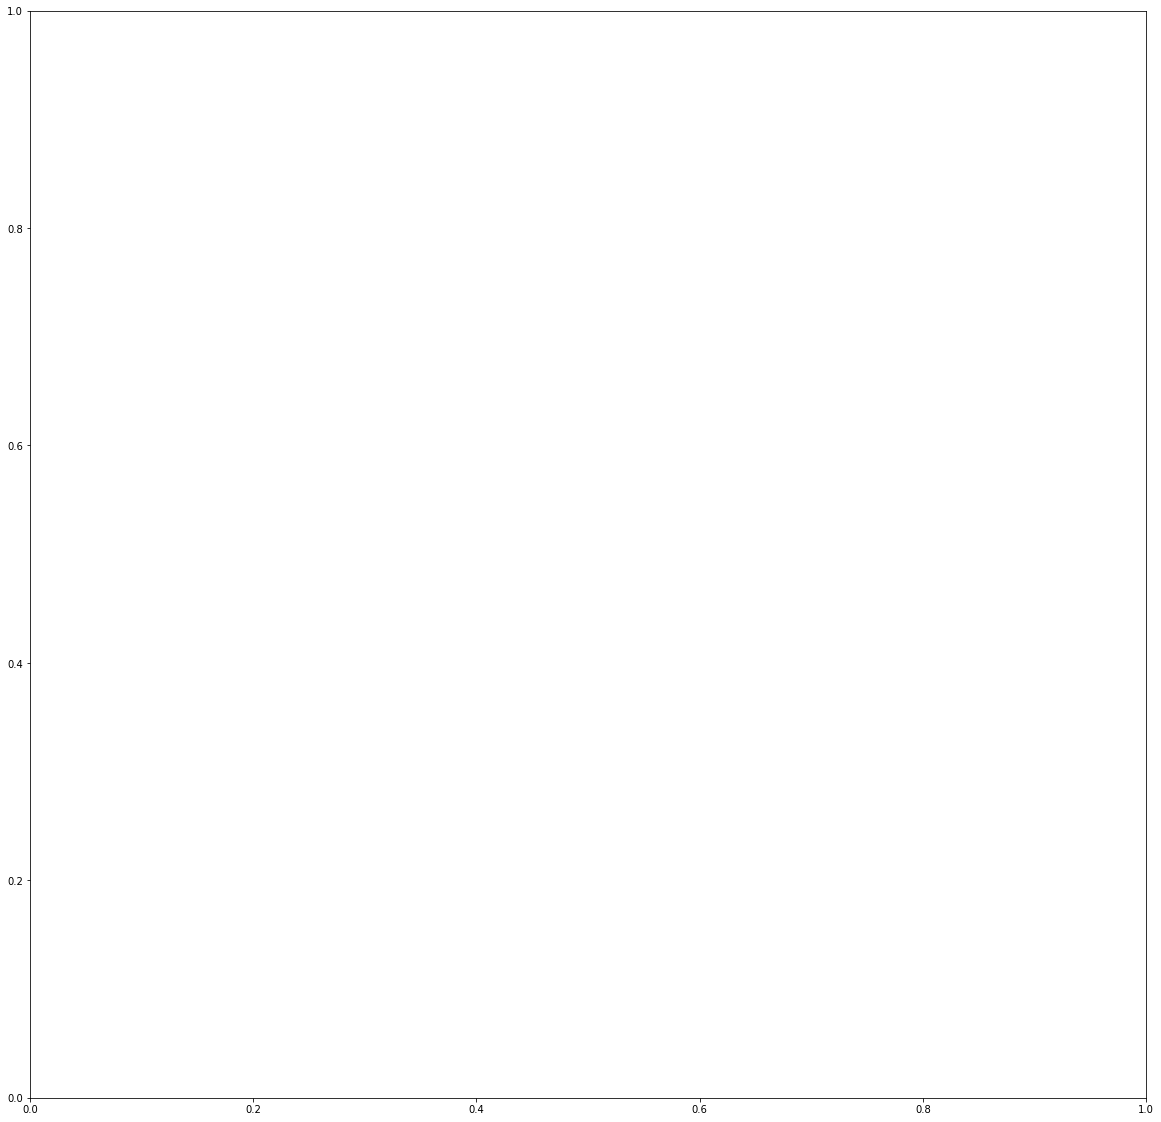

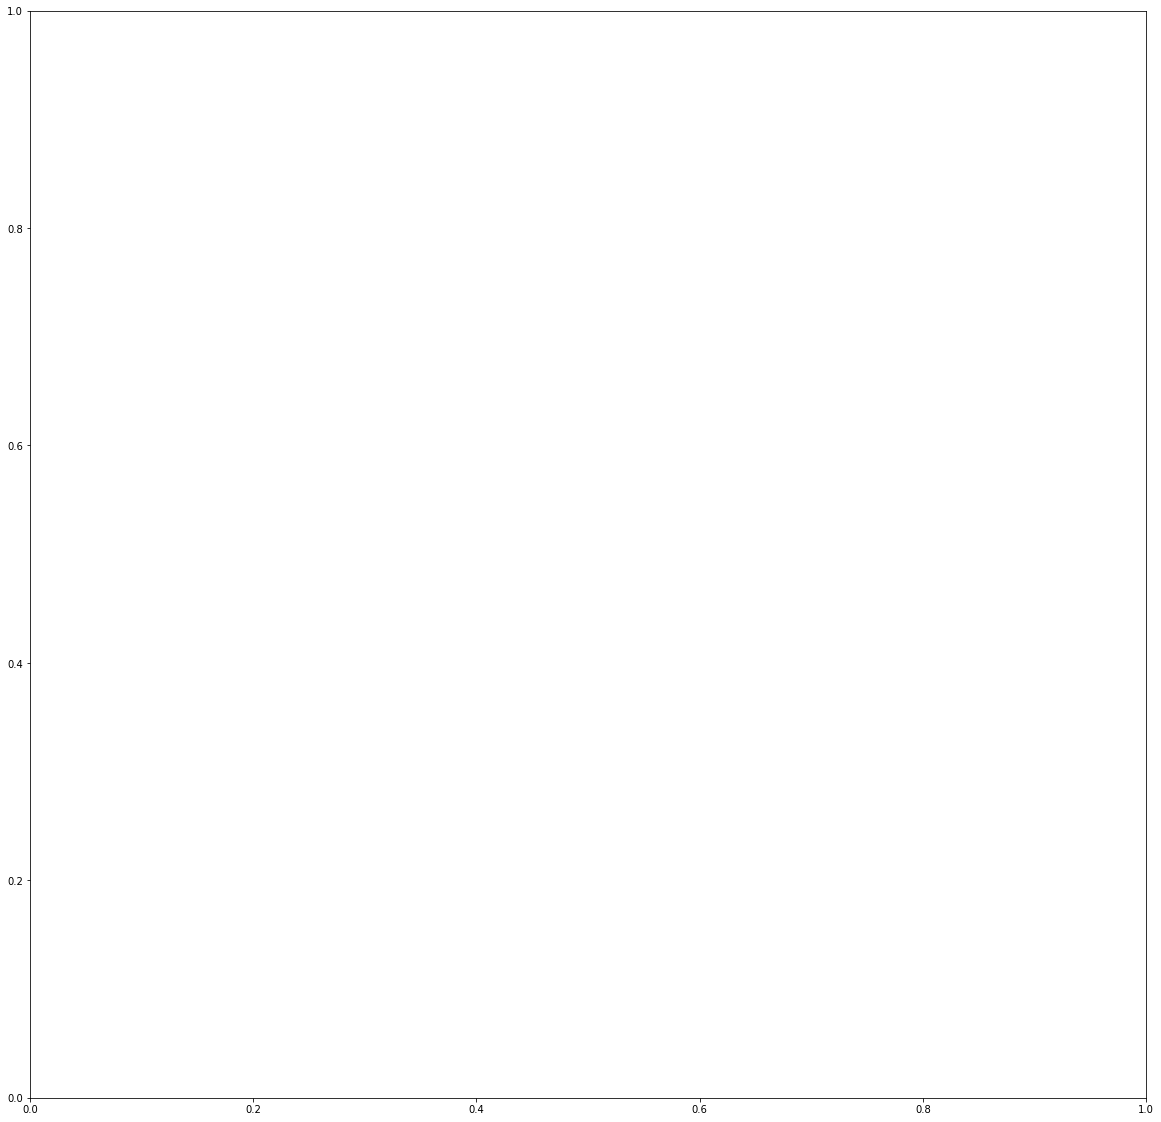

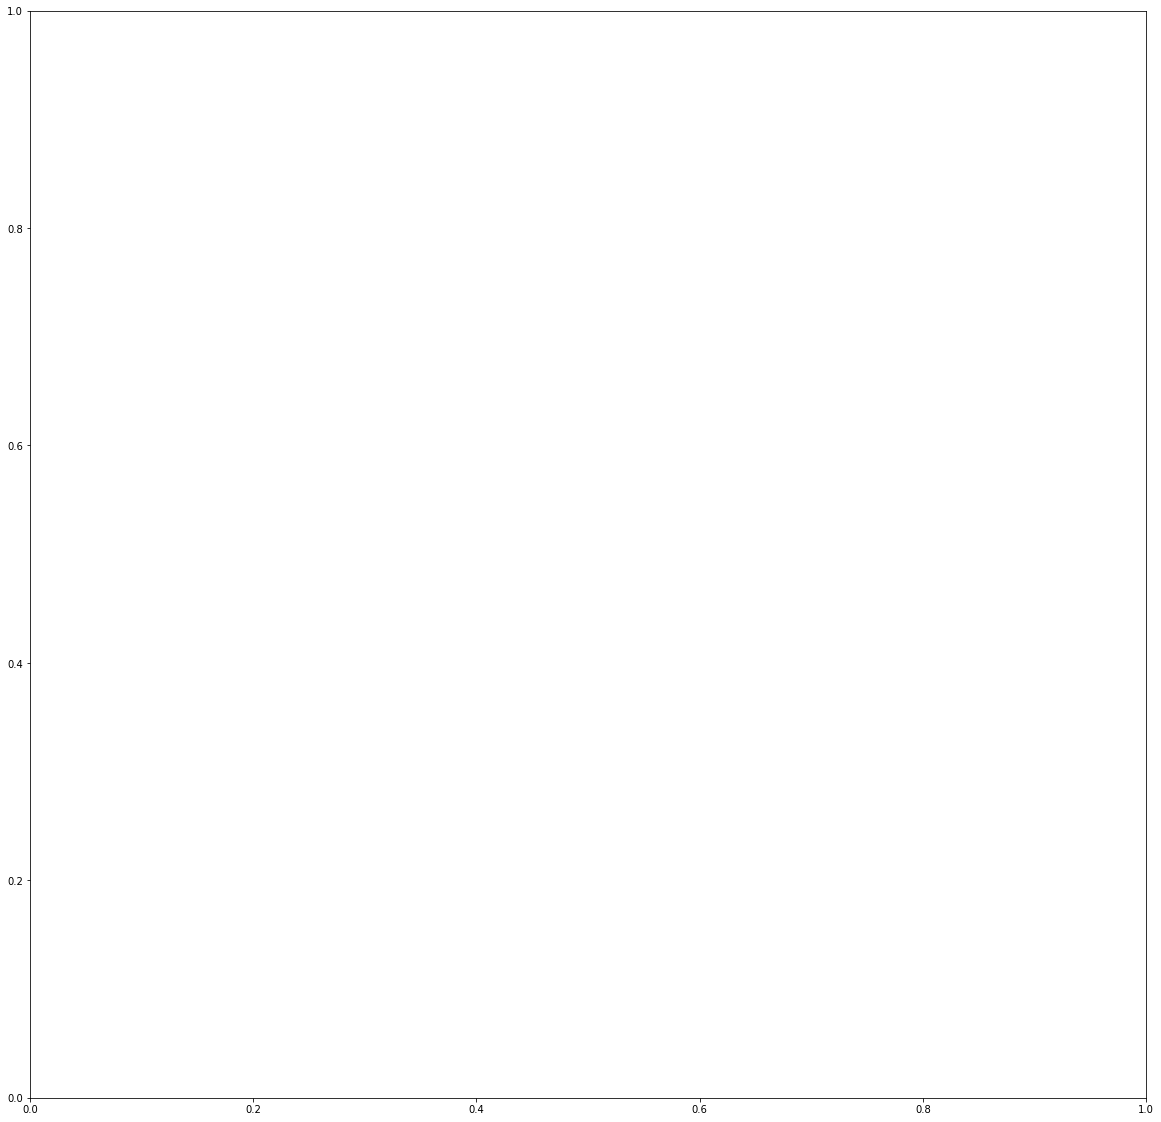

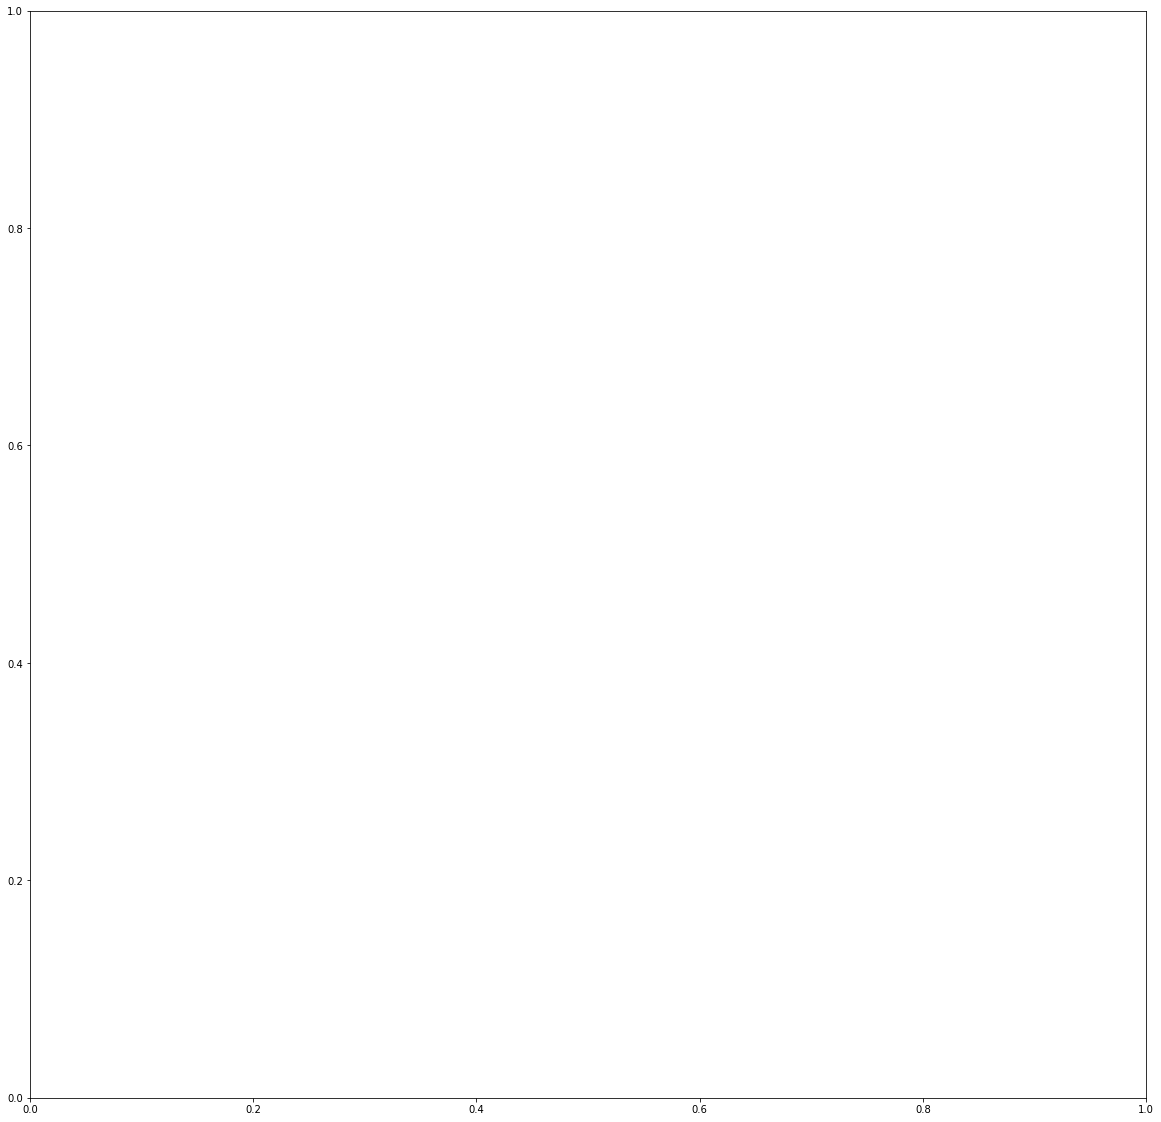

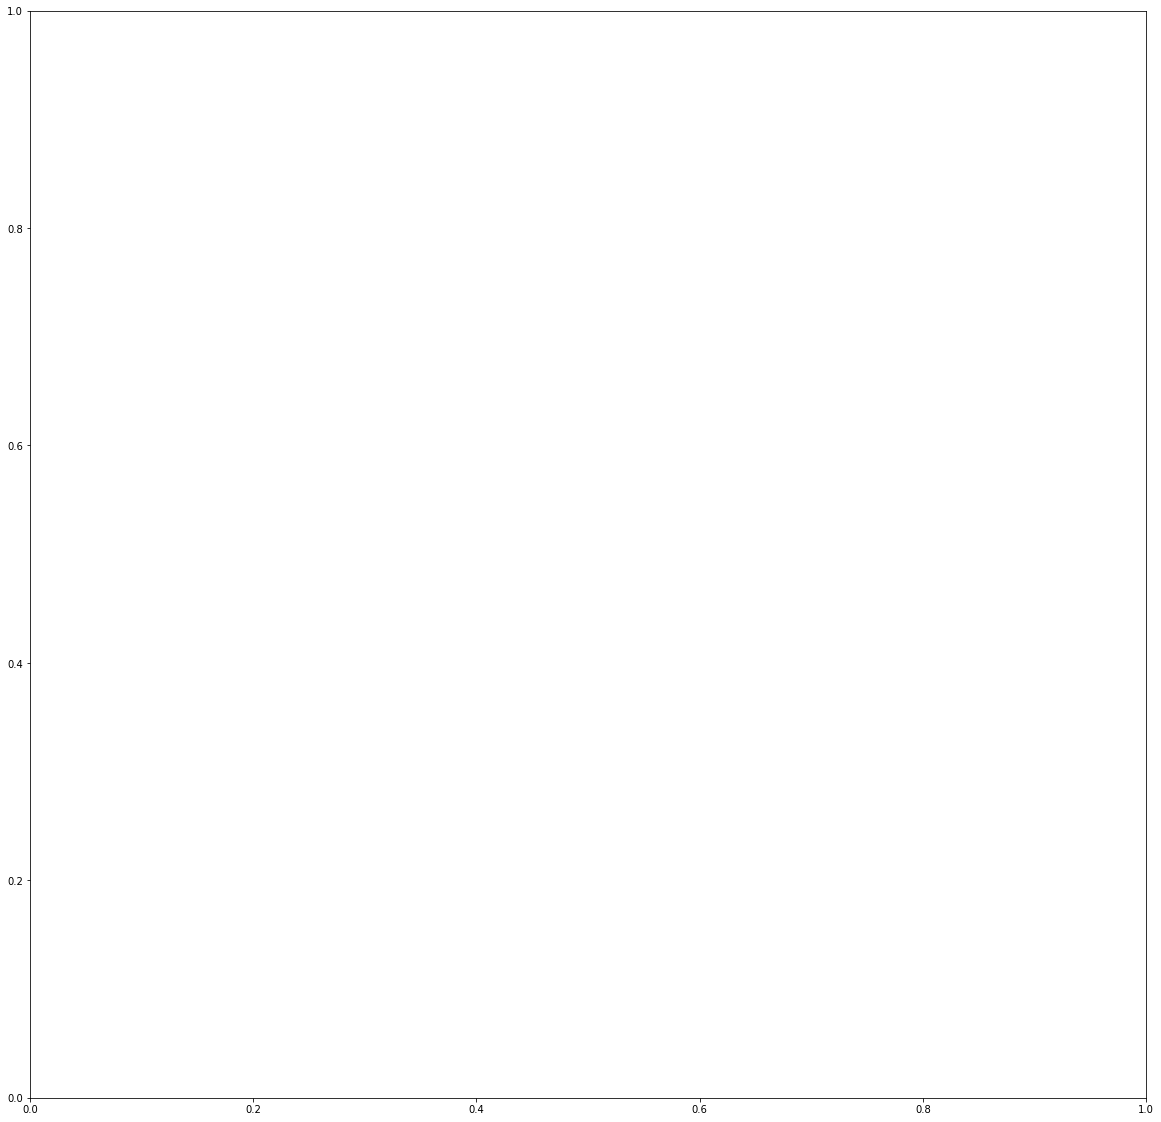

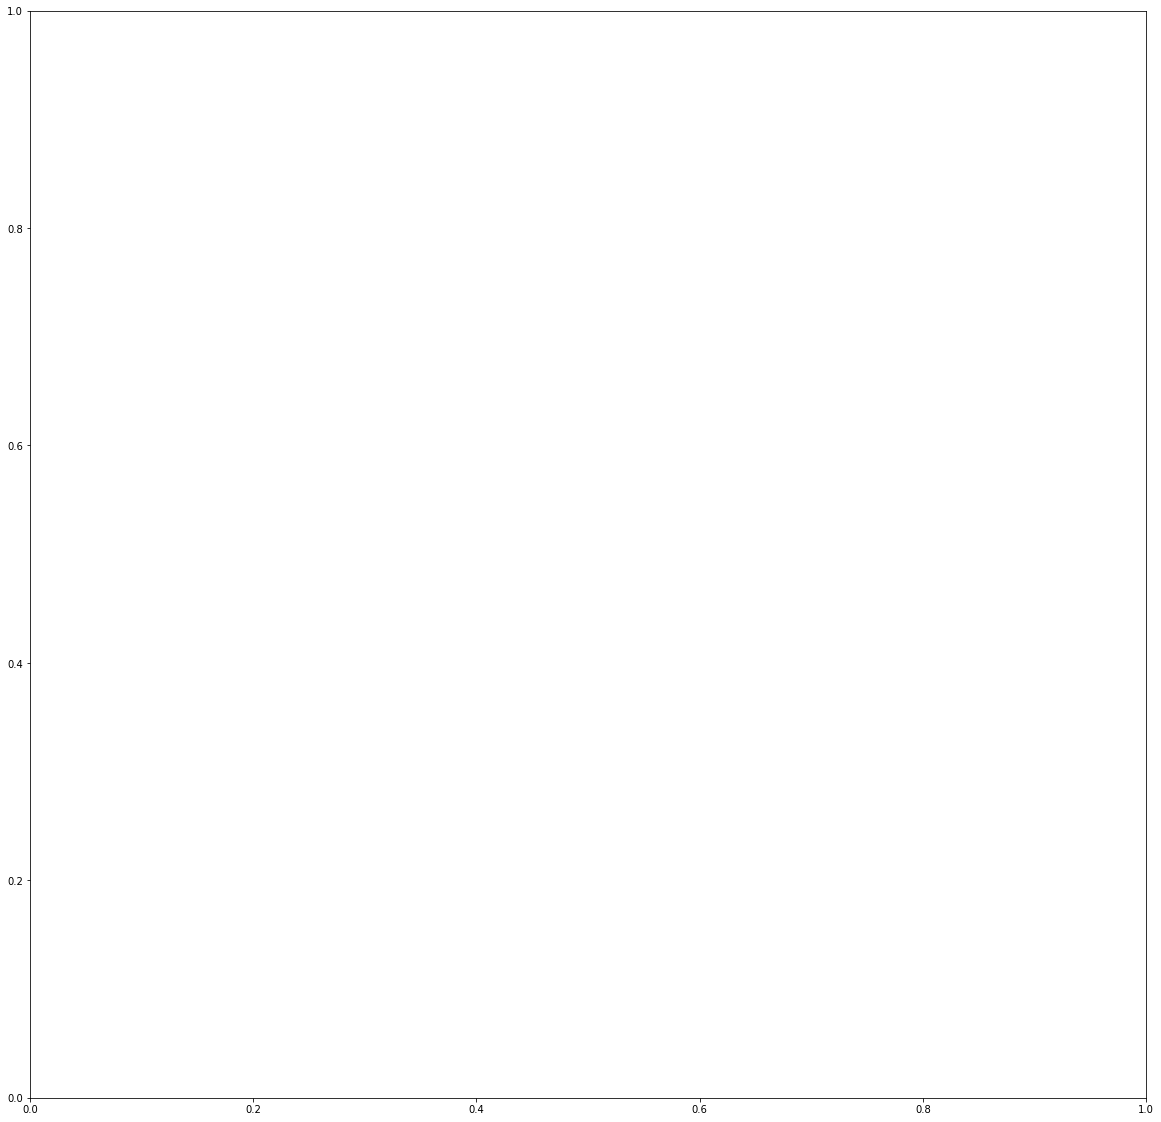

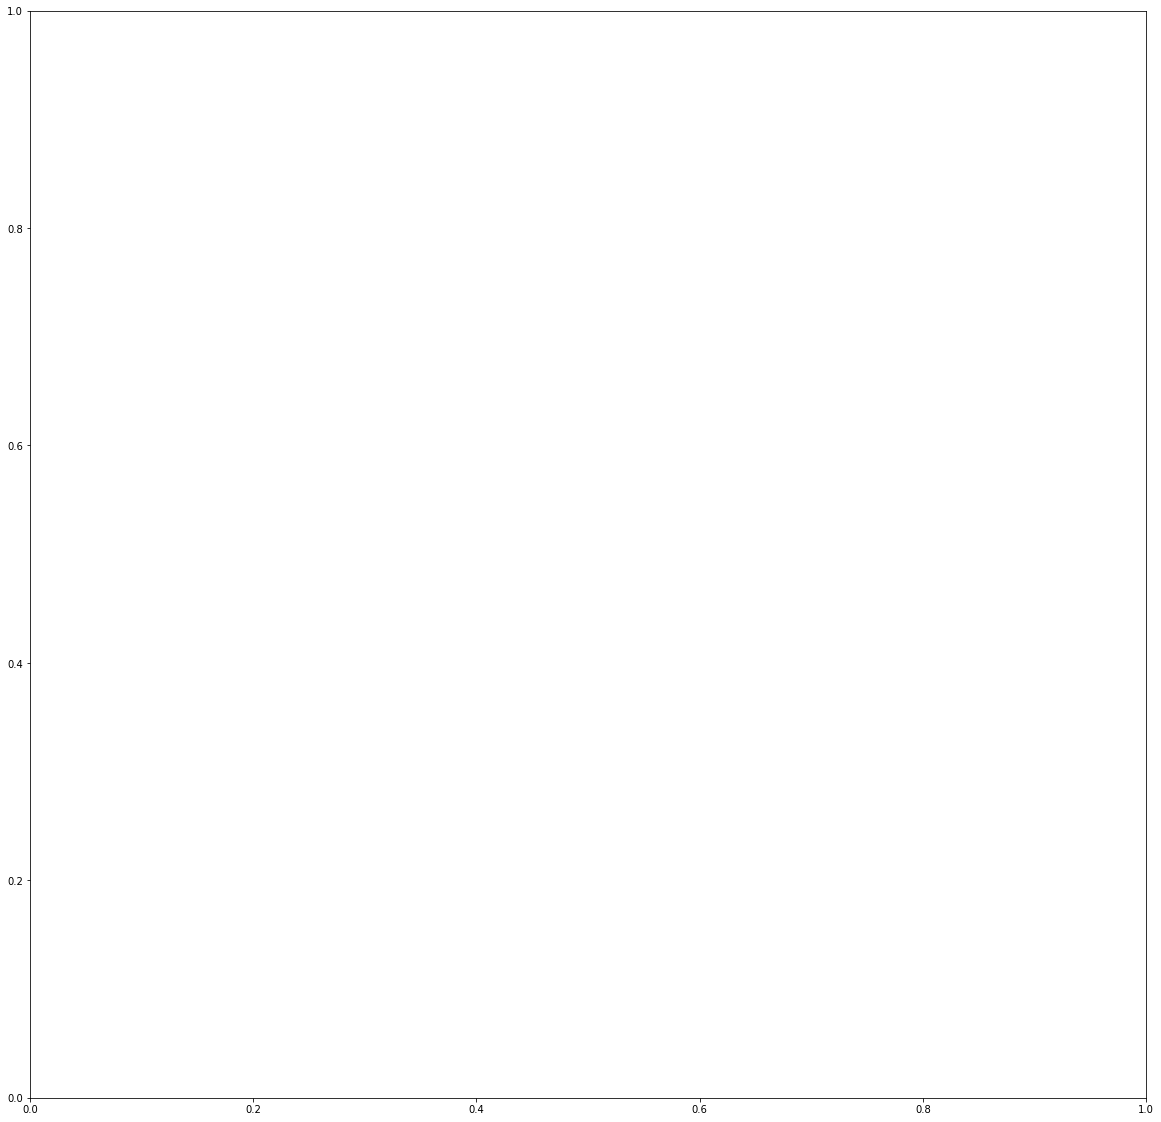

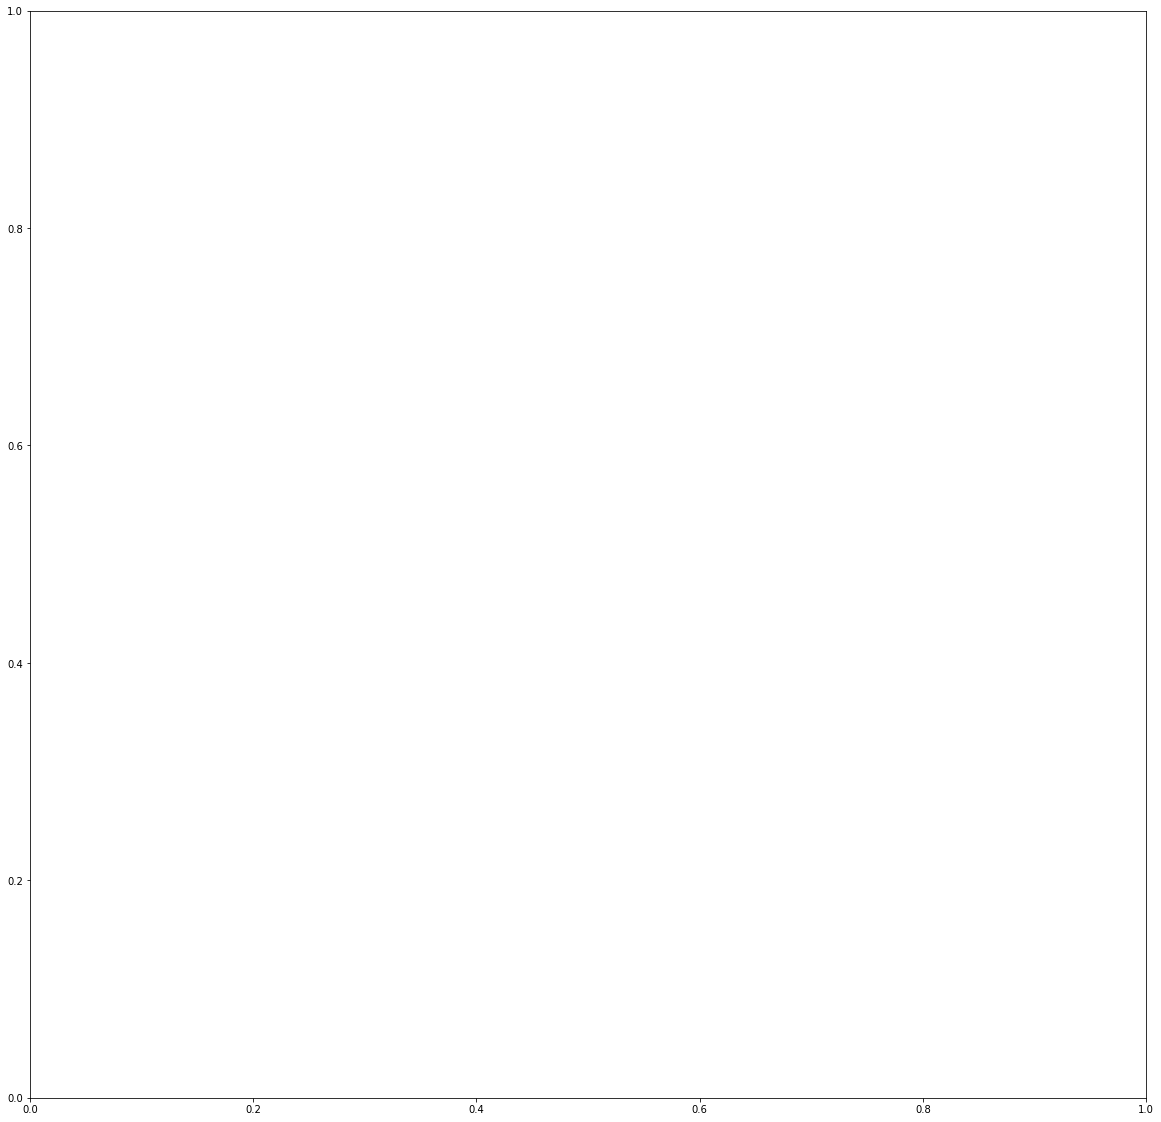

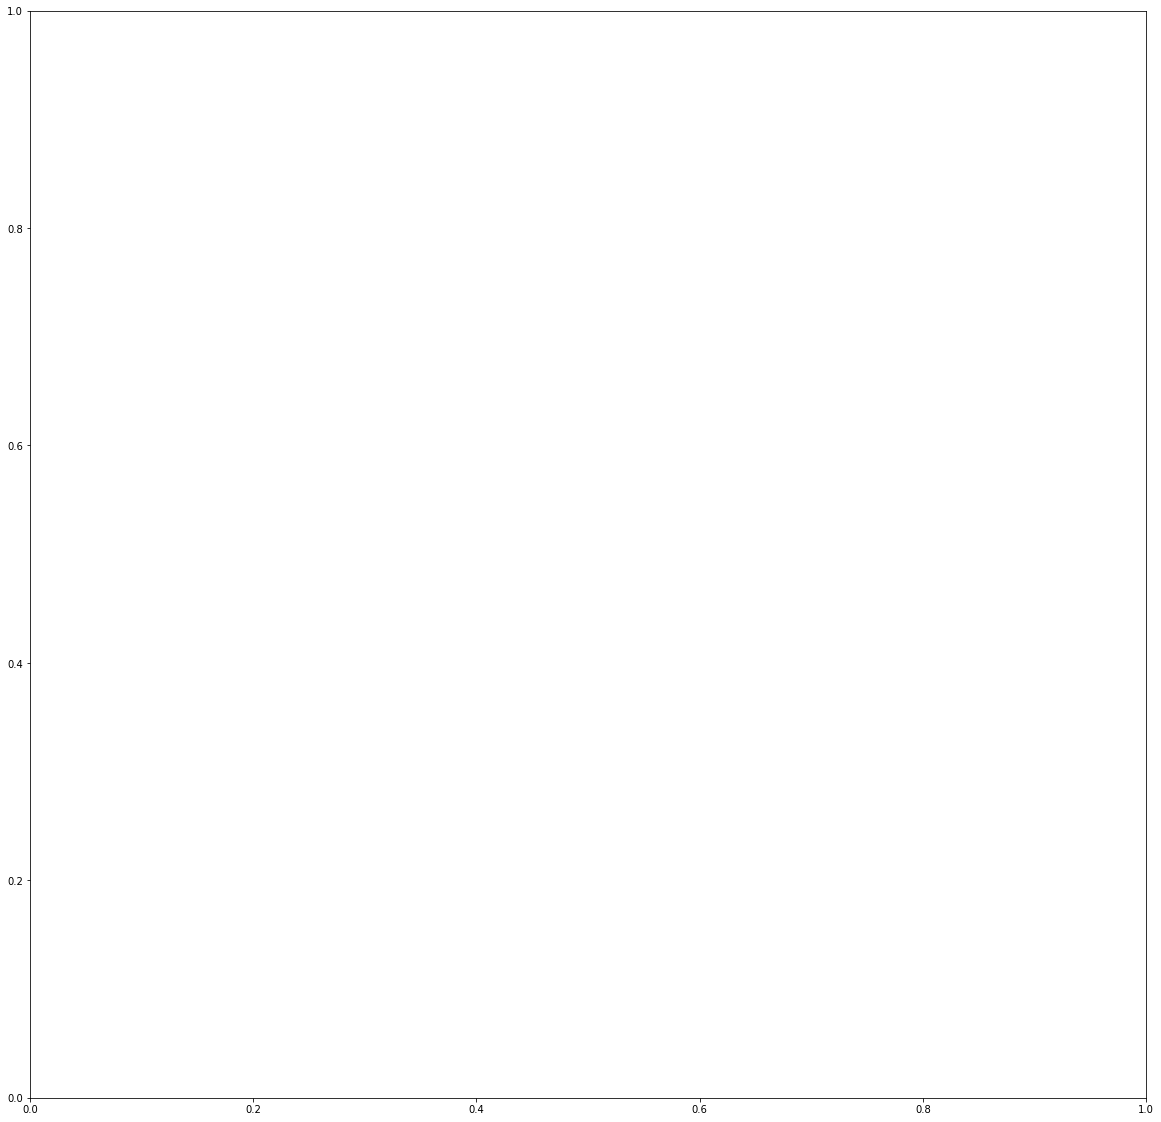

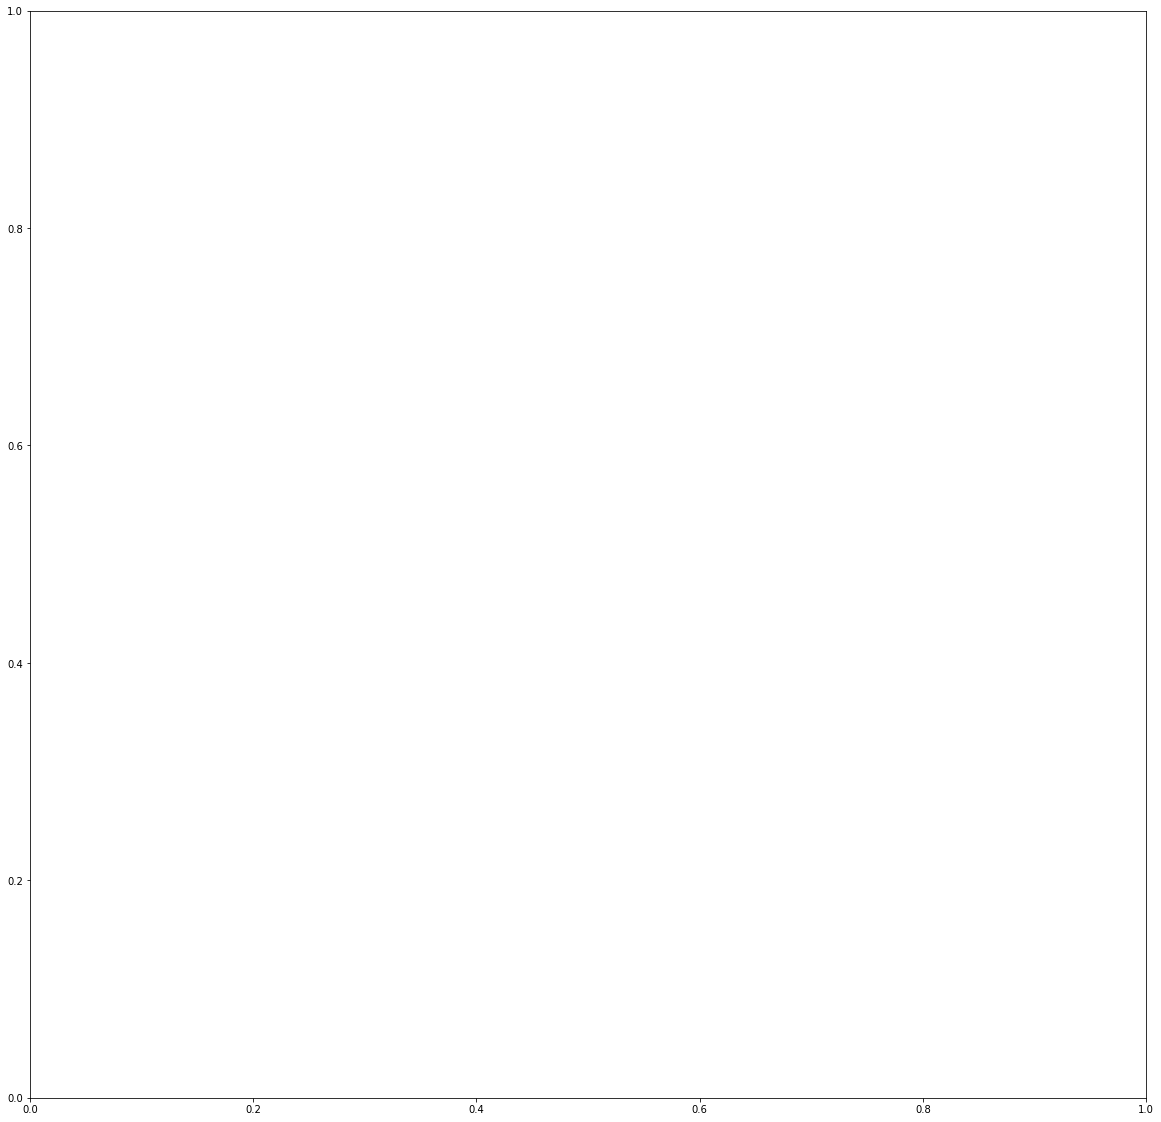

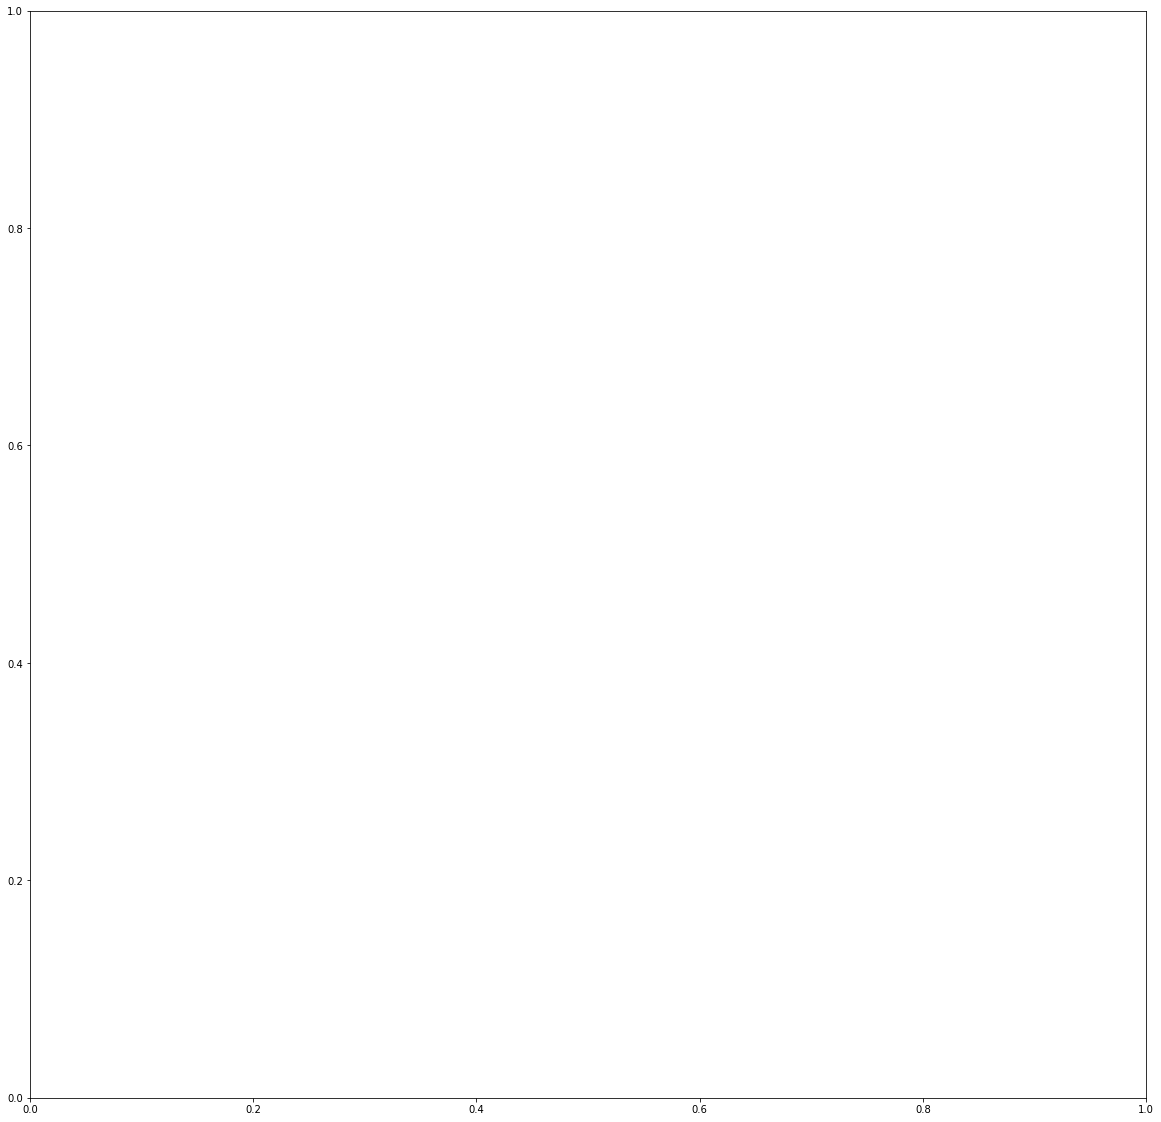

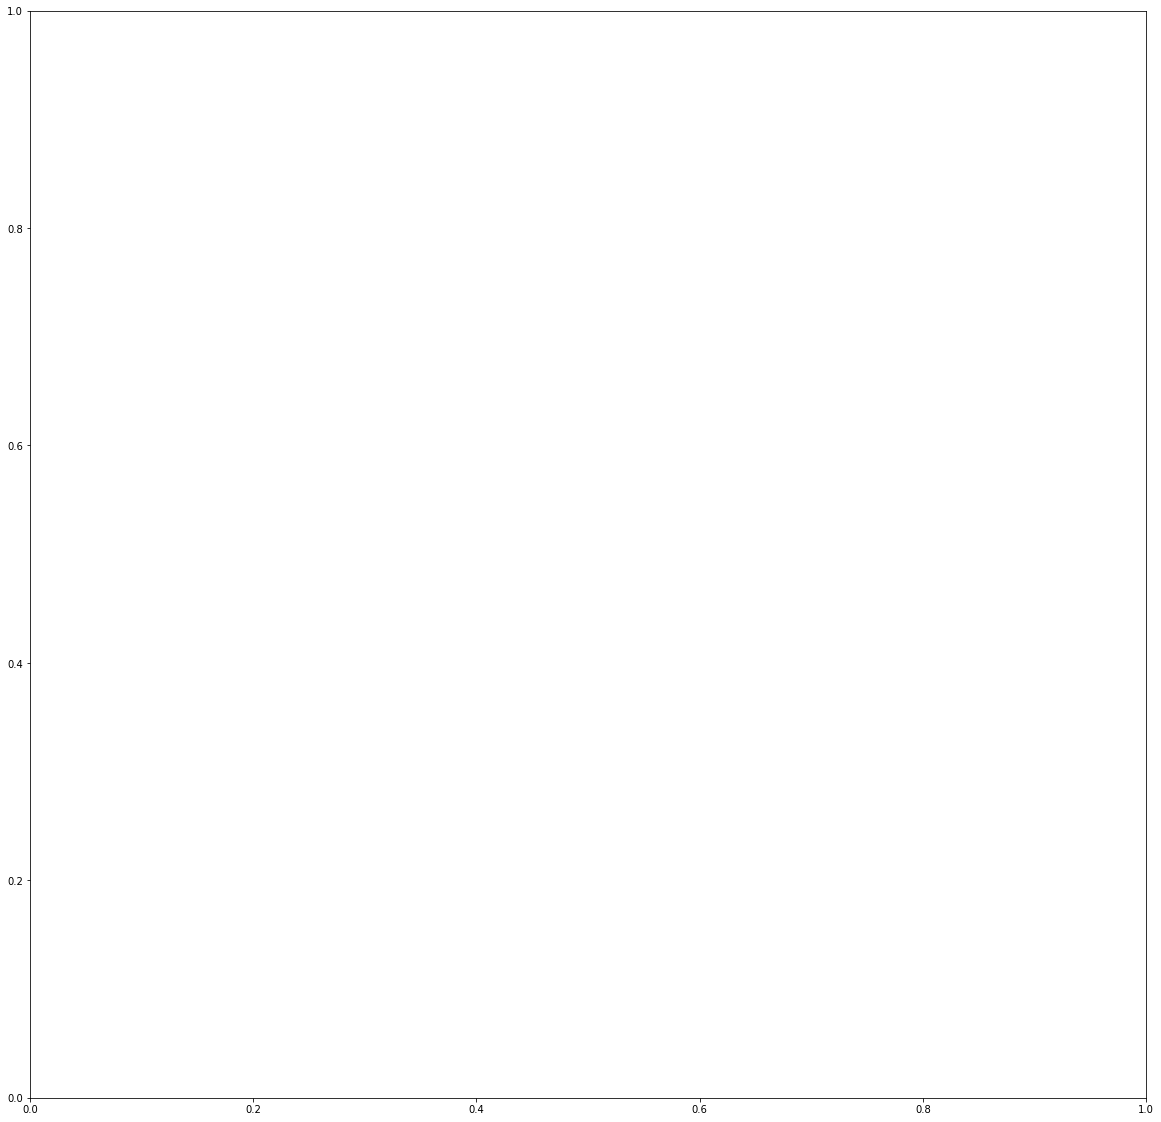

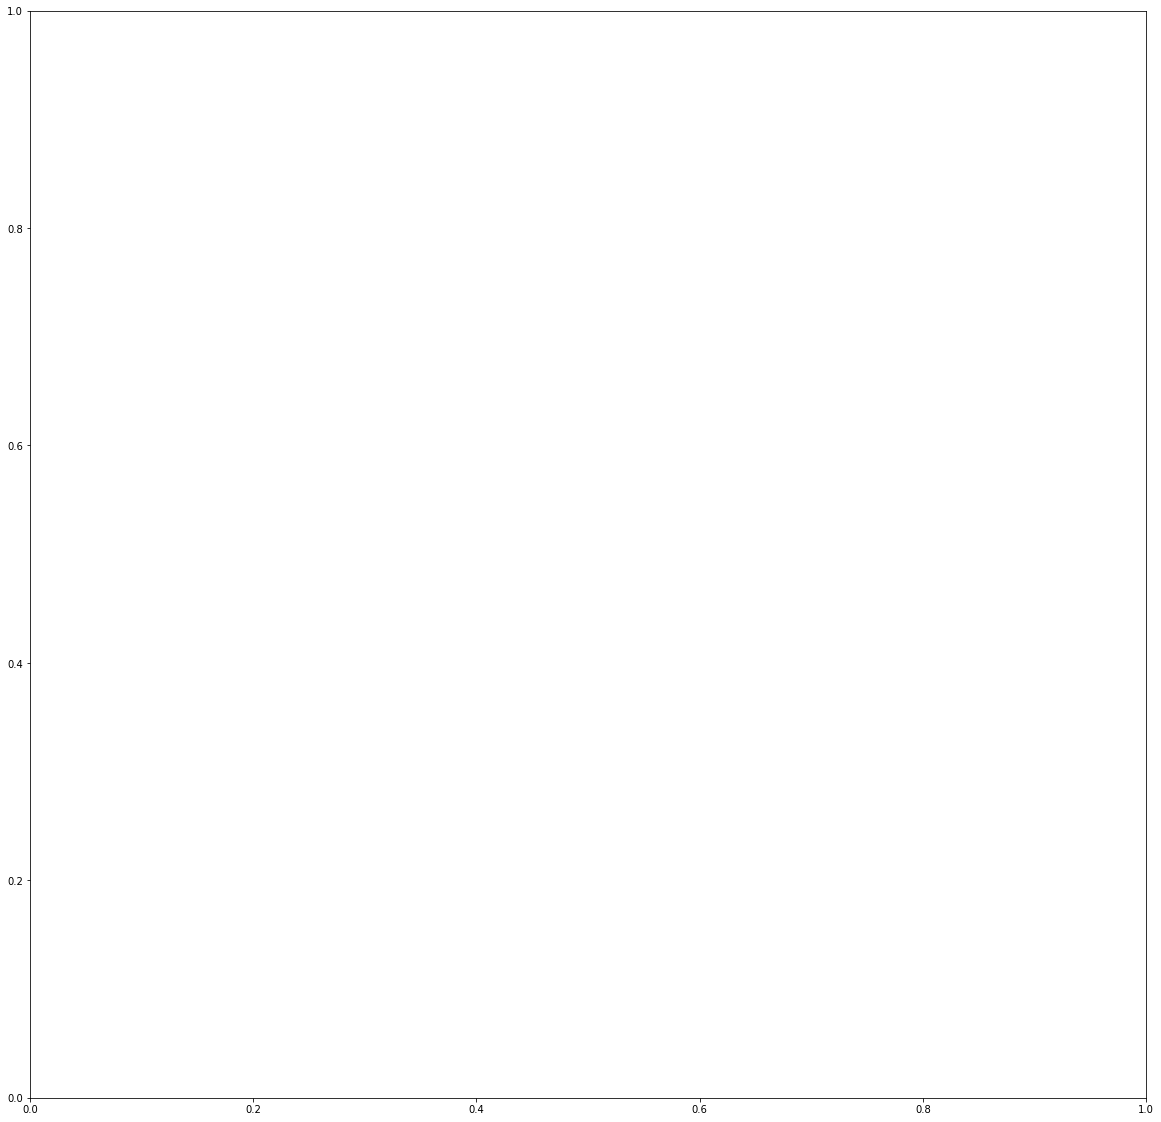

In [14]:
for cluster_ in tqdm.tqdm(range(251)):
    fig = plt.figure(figsize=(20,20))
    #cluster_ = 77#245

    for hemi,ypos,cluster in zip(['L','R'],[0.5,0.4],[cluster_,cluster_+250]):
        ##### VISUALIZE CLUSTER #####
        plot_cluster_visualization(ypos,hemi)
        ##### 2D HIST #####
        plot_2D_beh(ypos)
        ##### 1D BEH #####
        plot_supercluster_vs_beh(cluster,ypos)
        ### CORR AND UNIQUE ###
        plot_corrs(ypos)
        ### TEMPORAL ###
        plot_temporal_filters(ypos)
        plot_peak_time_bars(ypos)

    save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs/20221203_PCA_clusters'
    #timestr = time.strftime("%Y%m%d-%H%M%S")
    fname = os.path.join(save_path, '{0:03d}.png'.format(cluster_))
    plt.savefig(fname,dpi=300,bbox_inches='tight')
    plt.clf()
    plt.cla()

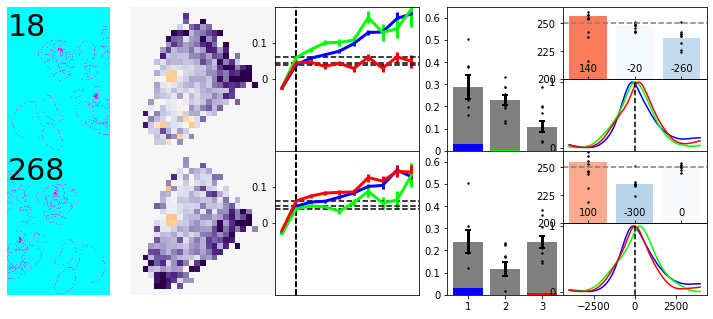

In [73]:
#for cluster in tqdm.tqdm(range(251)):
fig = plt.figure(figsize=(20,20))
cluster_ = 18

for hemi,ypos,cluster in zip(['L','R'],[0.5,0.4],[cluster_,cluster_+250]):
    ##### VISUALIZE CLUSTER #####
    plot_cluster_visualization(ypos,hemi)
    ##### 2D HIST #####
    plot_2D_beh(ypos)
    ##### 1D BEH #####
    plot_supercluster_vs_beh(cluster,ypos)
    ### CORR AND UNIQUE ###
    plot_corrs(ypos)
    ### TEMPORAL ###
    plot_temporal_filters(ypos)
    plot_peak_time_bars(ypos)

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs/20221125_PCA_clusters'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
#plt.savefig(fname,dpi=300,bbox_inches='tight')
#plt.clf()
#plt.cla()

# temporal debugging

In [61]:
supercluster_corr.shape

(501, 3)

In [122]:
temporal_v1.shape

(501, 2000)

In [63]:
superclusters_250.shape

(314, 146, 91)

In [111]:
temporal_filters.shape, superclusters_250.shape

((501, 4, 500), (314, 146, 91))

In [68]:
empty = np.zeros(superclusters_250.shape)
for cluster in range(501):
    ind = np.where(superclusters_250==cluster)
    empty[ind[0],ind[1],ind[2]] = supercluster_corr[cluster,1]/len(ind[0])#np.argmax(temporal_v1[cluster,:500])

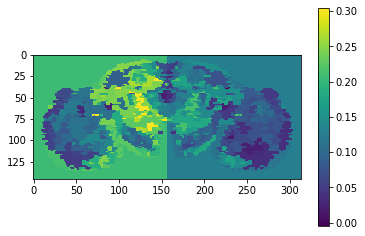

In [67]:
plt.imshow(empty[:,:,50].T)
plt.colorbar()

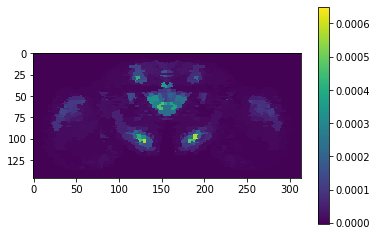

In [72]:
plt.imshow(empty[:,:,50].T)
plt.colorbar()

(array([4.171628e+06, 1.340000e+02, 0.000000e+00, 1.700000e+01,
        2.100000e+01, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 4.000000e+00]),
 array([-9.07186355e-05,  9.07305125e-04,  1.90532889e-03,  2.90335265e-03,
         3.90137641e-03,  4.89940017e-03,  5.89742393e-03,  6.89544769e-03,
         7.89347145e-03,  8.89149521e-03,  9.88951897e-03]),
 <a list of 10 Patch objects>)

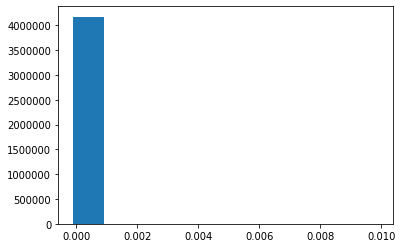

In [75]:
plt.hist(empty.flatten())

In [36]:
empty[np.where(empty==np.nan)] = 0

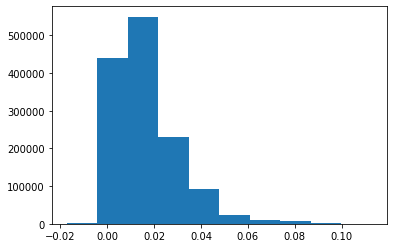

In [21]:
plt.hist(empty.flatten());

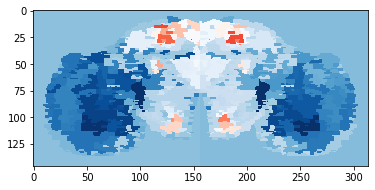

In [124]:
plt.imshow(mymap(temporal_norm(empty[:,:,50].T)))

In [16]:
temporal_map.shape

(314, 146, 91)

In [70]:
temporal_map = empty#temp[...,1]

In [52]:
temporal_map[np.isnan(temporal_map)] = 0

In [26]:
import brainsss
atlas_clean = brainsss.load_roi_atlas()
explosion_rois = brainsss.load_explosion_groups()
all_rois = brainsss.unnest_roi_groups(explosion_rois)
roi_masks = brainsss.make_single_roi_masks(all_rois, atlas_clean)
roi_contours = brainsss.make_single_roi_contours(roi_masks, atlas_clean)

In [53]:
def plot_grouped_roi_image(rois,plot=True):
    roi_data = []
    roi_contours = []

    left_edges = []
    right_edges = []
    bottom_edges = []
    top_edges = []

    for roi in rois:
        ####################
        ### Get roi mask ###
        ####################

        mask = np.zeros(atlas_clean.shape)
        mask[np.where(atlas_clean == roi)] = 1

        mask_eroded = binary_erosion(mask, structure=np.ones((2,2,2)))
        mask_dilated = binary_dilation(mask_eroded, iterations=2)

        # temporal
        masked_roi = mask_dilated*temporal_map #CORR
        masked_roi_flat = np.max(masked_roi,axis=2)
        roi_data.append(masked_roi_flat)
        
        #PCA
#         masked_roi = mask_dilated*pca_map
#         maxs = np.max(masked_roi,axis=2)
#         mins = np.min(masked_roi,axis=2)
#         maxs[np.where(np.abs(mins)>maxs)] = mins[np.where(np.abs(mins)>maxs)]
#         masked_roi_flat = maxs
#         roi_data.append(masked_roi_flat)
    
        #######################
        ### Get roi contour ###
        #######################
        
        _, mask_binary = cv2.threshold(np.max(mask_dilated,axis=-1).astype('uint8'), 0, 1, cv2.THRESH_BINARY) 
        contours, _ = cv2.findContours(mask_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)#cv2.RETR_TREE

        canvas = np.ones(atlas_clean[:,:,0].shape)
        out = cv2.drawContours(canvas, contours, -1, (0,255,0), 1)
        out = np.abs(out-1) #flip 0/1
        roi_contour = np.repeat(out[:,:,np.newaxis],repeats=4,axis=-1) ### copy into rgba channels to make white
        roi_contours.append(roi_contour)

        # for plotting
        left_edges.append(np.where(np.sum(np.nan_to_num(roi_contour),axis=0)>0)[0][0])
        right_edges.append(np.where(np.sum(np.nan_to_num(roi_contour),axis=0)>0)[0][-1])
        top_edges.append(np.where(np.sum(np.nan_to_num(roi_contour),axis=1)>0)[0][0])
        bottom_edges.append(np.where(np.sum(np.nan_to_num(roi_contour),axis=1)>0)[0][-1])
        
    # get extreme edges from all rois used
    left_edge = np.min(left_edges) - 1
    right_edge = np.max(right_edges) + 1
    top_edge = np.min(top_edges) - 1
    bottom_edge = np.max(bottom_edges) + 1

    ############
    ### PLOT ###
    ############
    
    roi_datas = np.max(np.asarray(roi_data),axis=0)
    data_map = np.swapaxes(roi_datas[top_edge:bottom_edge,left_edge:right_edge],0,1)
    
    #PCA
#     roi_data = np.asarray(roi_data)
#     maxs = np.max(roi_data,axis=0)
#     mins = np.min(roi_data,axis=0)
#     maxs[np.where(np.abs(mins)>maxs)] = mins[np.where(np.abs(mins)>maxs)]
#     data_map = np.swapaxes(maxs[top_edge:bottom_edge,left_edge:right_edge],0,1)

    if plot:
        plt.figure(figsize=(10,10))
        plt.imshow(data_map)

    contours_to_export = []
    for i in range(len(roi_contours)):
        single_contour = np.swapaxes(roi_contours[i][top_edge:bottom_edge,left_edge:right_edge],0,1)
        contours_to_export.append(single_contour)
        if plot:
            plt.imshow(single_contour)
        
    return data_map, contours_to_export

def place_on_canvas(input_canvas, to_plot, is_contour=False, is_midline=True, x_shift=0, y_shift=0):
    full_y_mid = int(input_canvas.shape[0]/2)
    full_x_mid = int(input_canvas.shape[1]/2)

    y_mid = int(to_plot.shape[0]/2)
    x_mid = int(to_plot.shape[1]/2)

    height = to_plot.shape[0]
    width = to_plot.shape[1]

    left = full_x_mid-x_mid
    right = left + width

    top = full_y_mid-y_mid
    bottom = top + height

    if is_contour:
        ys = np.where(to_plot[:,:,0]>0)[0] + full_y_mid - y_mid + y_shift
        xs = np.where(to_plot[:,:,0]>0)[1] + full_x_mid - x_mid + x_shift
        input_canvas[ys,xs]=1
    else:
        #input_canvas[top+y_shift:bottom+y_shift,left+x_shift:right+x_shift,:3] = to_plot
        input_canvas[top+y_shift:bottom+y_shift,left+x_shift:right+x_shift] = to_plot #pca
    return input_canvas

def place_on_canvas_wrapper(canvas, data_map, contours, y_shift, x_shift):
    canvas = place_on_canvas(canvas, to_plot=data_map, y_shift=y_shift, x_shift=x_shift)
    for i in range(len(contours)):
        canvas = place_on_canvas(canvas, to_plot=contours[i], is_contour=True, y_shift=y_shift, x_shift=x_shift)
    return canvas

def wraper_wraper(canvas, roi_ids, y_shift, x_shift):
    data_map, contours = plot_grouped_roi_image(roi_ids, plot=False)
    canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)
    return canvas

In [54]:
##################
### ROI GROUPS ###
##################

FB_group = {
26: 'FB',
4: 'NO',
5: 'BU_R',
54: 'BU_L',
8: 'LAL_R',
56: 'LAL_L',
31: 'PVLP_R',
76: 'PVLP_L'}

ventromedial_r_group = {
13: 'VES_R',  
40: 'EPA_R',
35: 'GOR_R',
11: 'AMMC_R'}

ventromedial_l_group = {
60: 'VES_L', 
85: 'EPA_L',
80: 'GOR_L',
58: 'AMMC_L'}

PB = {6: 'PB'}
EB = {23: 'EB'}

anterior_group = {
50: 'PRW',
9: 'SAD',
49: 'GNG',
30: 'AVLP_R',
75: 'AVLP_L',
24: 'AL_R',
70: 'AL_L',
64: 'MB_PED_L',
65: 'MB_VL_L',
66: 'MB_ML_L',
81: 'MB_CA_L',
17: 'MB_PED_R',
18: 'MB_VL_R',
19: 'MB_ML_R',
36: 'MB_CA_R',
32: 'IVLP_R',
77: 'IVLP_L',
10: 'CAN_R',
20: 'FLA_R',
57: 'CAN_L',
67: 'FLA_L'}

big_r_group = {
27: 'SLP_R',
29: 'SMP_R',
33: 'PLP_R',
7: 'LH_R',
38: 'IPS_R',
37: 'SPS_R',
16: 'CRE_R',
39: 'SCL_R',
12: 'ICL_R',
15: 'ATL_R',
14: 'IB_R',
28: 'SIP_R'}
    
big_l_group = {
72: 'SLP_L',   
74: 'SMP_L',
78: 'PLP_L',
55: 'LH_L',
83: 'IPS_L',
82: 'SPS_L',
63: 'CRE_L',
84: 'SCL_L',  
59: 'ICL_L',
62: 'ATL_L',
61: 'IB_L',
73: 'SIP_L'}

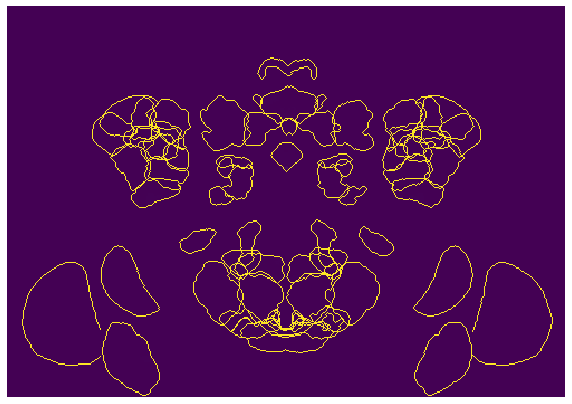

In [71]:
#input_canvas = np.zeros((500,500,3))
input_canvas = np.zeros((500,500)) #pca


x_shift=0; y_shift=0
data_map, contours = plot_grouped_roi_image(FB_group.keys(), plot=False)
canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)

x_shift=0; y_shift=-45
data_map, contours = plot_grouped_roi_image(PB.keys(), plot=False)
canvas = place_on_canvas_wrapper(canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)

x_shift=0; y_shift=35
data_map, contours = plot_grouped_roi_image({23: 'EB'}.keys(), plot=False)
canvas = place_on_canvas_wrapper(canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)

##########
### MB ###
##########

# x_shift=60; y_shift=-50
# data_map, contours = plot_grouped_roi_image(MB_left_group.keys(), plot=False)
# canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)
# x_shift=-60; y_shift=-50
# data_map, contours = plot_grouped_roi_image(MB_right_group.keys(), plot=False)
# canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)

#################
### BIG GROUP ###
#################

x_shift=-130; y_shift=30
data_map, contours = plot_grouped_roi_image(big_r_group.keys(), plot=False)
canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)
x_shift=130; y_shift=30
data_map, contours = plot_grouped_roi_image(big_l_group.keys(), plot=False)
canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)

##############
### VISUAL ###
##############

x_shift=-200; y_shift=175
data_map, contours = plot_grouped_roi_image({25: 'MED_R'}.keys(), plot=False)
canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)
x_shift=200; y_shift=175
data_map, contours = plot_grouped_roi_image({71: 'MED_L'}.keys(), plot=False)
canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)

x_shift=-140; y_shift=40+175
data_map, contours = plot_grouped_roi_image({3: 'LO_R'}.keys(), plot=False)
canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)
x_shift=140; y_shift=40+175
data_map, contours = plot_grouped_roi_image({53: 'LO_L'}.keys(), plot=False)
canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)

x_shift=-140; y_shift=-30+175
data_map, contours = plot_grouped_roi_image({22: 'LP_R'}.keys(), plot=False)
canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)
x_shift=140; y_shift=-30+175
data_map, contours = plot_grouped_roi_image({69: 'LP_L'}.keys(), plot=False)
canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)

canvas = wraper_wraper(canvas, ventromedial_r_group.keys(), y_shift=55, x_shift=-50)
canvas = wraper_wraper(canvas, ventromedial_l_group.keys(), y_shift=55, x_shift=50)

canvas = wraper_wraper(canvas, anterior_group.keys(), y_shift=150, x_shift=0)

canvas = wraper_wraper(canvas, {34: 'AOTU_R'}.keys(), y_shift=-50+175-15, x_shift=-80)
canvas = wraper_wraper(canvas, {79: 'AOTU_L'}.keys(), y_shift=-50+175-15, x_shift=80)
    
#canvas[np.where(canvas==0)] = np.nan

plt.figure(figsize=(10,10))
plt.imshow(canvas[150:,:],vmin=0,vmax=.001)

#plt.imshow(canvas[150:,:],cmap=mymap,vmin=end_c,vmax=start_c)
plt.axis('off')

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
#plt.savefig(fname,dpi=300,bbox_inches='tight')

(-0.5, 499.5, 349.5, -0.5)

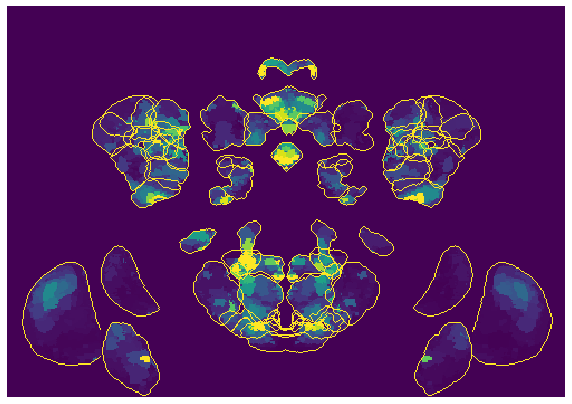

In [78]:
plt.figure(figsize=(10,10))
plt.imshow(canvas[150:,:],vmin=0,vmax=.0005)

#plt.imshow(canvas[150:,:],cmap=mymap,vmin=end_c,vmax=start_c)
plt.axis('off')

In [23]:
np.unique(canvas)

array([ 1., nan, nan, ..., nan, nan, nan])

In [ ]:
### lets look at the indiv temporal filters
file = F"/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20220921_neural_weighted_behavior/indiv_flies/responses_fly{fly}_{z}"




# Indiv flies